In [1]:
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import knn_graph, GCNConv, GATConv, SAGEConv #Import necessary GNN layers
import os.path as osp
import pandas as pd
import numpy as np
import torch
import h5py
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import optuna # Import Optuna
import random # For seeding
import os # For path manipulation

In [6]:
class AudioGraphDataset(Dataset):
    def __init__(self, root, metadata_csv_path, features_hdf5_path, k_neigh=5, transform=None, pre_transform=None, pre_filter=None):
        """
        Initialize the Audio Graph Dataset
        Args:
            root: Root directory for processed files
            metadata_csv_path: Path to the metadata CSV file
            features_hdf5_path: Path to the HDF5 file containing features
            k_neigh: Number of nearest neighbors for graph construction
            transform: Transform to be applied to the data
            pre_transform: Transform to be applied before processing
            pre_filter: Filter to be applied before processing
        """
        self.metadata_csv_path = metadata_csv_path # More descriptive names
        self.features_hdf5_path = features_hdf5_path
        self.k_neigh = k_neigh
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return [osp.basename(self.metadata_csv_path), osp.basename(self.features_hdf5_path)]

    @property
    def raw_dir(self) -> str:
        return osp.dirname(self.metadata_csv_path)

    @property
    def processed_file_names(self):
        # Include k_neigh in processed file names for different settings
        return [f'data_k{self.k_neigh}_fold{i}.pt' for i in range(10)] # Filename now includes k only

    def download(self):
        pass

    def process(self):
        """
        Process the raw data into graph format.
        Now incorporates k-NN into processing.
        """
        print(f"Processing with k_neigh={self.k_neigh}") # Indicate current settings
        # Load metadata and features using full paths
        self.df = pd.read_csv(self.metadata_csv_path)
        self.data_hdf5 = h5py.File(self.features_hdf5_path, 'r') # More descriptive name

        # Convert features and labels to torch tensors
        X_tensor = torch.tensor(np.array(self.data_hdf5['features']))
        Y_tensor = torch.tensor(np.array(self.data_hdf5['labels']))

        # Standard processing mode - 10 fold cross validation
        self._process_folds(X_tensor, Y_tensor, 0, 10, self.k_neigh) # Pass k_neigh to _process_folds

    def _process_folds(self, X_tensor, Y_tensor, start_idx, num_folds, k_neighbors):
        """
        Process data for multiple cross-validation folds
        """
        test_idx = 1
        val_idx = 2
        k = k_neighbors # Use passed k_neighbors value

        for j in range(start_idx, start_idx + num_folds):
            # Get train/test/validation splits
            idx_train, idx_test, idx_val = self._cross_validation_split(
                self.df, test_idx, val_idx)

            # Normalize features
            X_tensor_norm = self._normalize_features(X_tensor, idx_train)

            # Create graph data object
            data = self._create_graph(X_tensor_norm, Y_tensor,
                                    idx_train, idx_test, idx_val, k)

            # Save processed data - filename now includes k
            torch.save(data, osp.join(self.processed_dir, f'data_k{k}_fold{j}.pt')) # Filename updated with k

            # Update indices for next fold
            test_idx = (test_idx + 1) % 11
            val_idx = (val_idx + 1) % 11
            if val_idx == 0:
                val_idx = 1

    def _normalize_features(self, X_tensor, idx_train):
        mini = X_tensor[idx_train].min()
        maxi = X_tensor[idx_train].max()
        return (X_tensor - mini) / (maxi - mini)

    def _cross_validation_split(self, df, idx_test, idx_val):
        df = df.reset_index(drop=True)
        df_train = df.copy()
        idx_test_mask = df.index[df.fold == idx_test]
        df_train.drop(idx_test_mask, inplace=True)
        idx_val_mask = df.index[df.fold == idx_val]
        df_train.drop(idx_val_mask, inplace=True)
        idx_train_mask = df_train.index
        return idx_train_mask, idx_test_mask, idx_val_mask

    def _create_graph(self, X_tensor, Y_tensor, idx_train, idx_test, idx_val, k):
        train_mask = torch.tensor(idx_train)
        test_mask = torch.tensor(idx_test)
        val_mask = torch.tensor(idx_val)
        edge_index = knn_graph(X_tensor, k=k, batch=Y_tensor, loop=False)
        return Data(
            x=X_tensor,
            edge_index=edge_index,
            y=Y_tensor,
            train_mask=train_mask,
            test_mask=test_mask,
            val_mask=val_mask
        )

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use processed_file_names list

In [8]:
# Example of setting up datasets for different k values (using mean features)
root_processed_data = 'processed_data'
metadata_file = 'nepali_music_metadata.csv'
feature_file_mean = 'nepali_features.hdf5' # Path to your SINGLE feature file

# --- Datasets for different k values (using mean features) --- #
k_values = [5, 7, 9, 10, 15] # Example k values to test
datasets_k_vary = {}
for k in k_values:
    dataset_name = f'dataset_k_{k}'
    datasets_k_vary[dataset_name] = AudioGraphDataset(
        root=root_processed_data,
        metadata_csv_path=metadata_file,
        features_hdf5_path=feature_file_mean, # Using the SINGLE feature file
        k_neigh=k,
    )

# Example of accessing a specific graph (e.g., first fold of dataset with k=5)
# graph_example = datasets_k_vary['dataset_k_5'][0] # if you process datasets_k_vary

Processing...


Processing with k_neigh=5


Done!
Processing...


Processing with k_neigh=7


Done!
Processing...


Processing with k_neigh=9


Done!
Processing...


Processing with k_neigh=10


Done!
Processing...


Processing with k_neigh=15


Done!


In [14]:
class GCNAudioClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [15]:
class GATAudioClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=8, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads) # Multi-head attention
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * heads) # BatchNorm for concatenated heads
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads) # Input dim adjusted
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels * heads)
        self.conv3 = GATConv(hidden_channels * heads, num_classes, heads=1, concat=False) # Single head for output
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [16]:
class SAGEAudioClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [17]:
def train_model(model, data, optimizer, epochs=200, scheduler=None): # Added scheduler as argument
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')
    patience = 20
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if scheduler: # Step the scheduler if provided
            scheduler.step(loss) # Step based on training loss

        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]).item()
            train_acc = accuracy_score(data.y[data.train_mask].cpu(),
                                    out[data.train_mask].argmax(dim=1).cpu())
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy_score(data.y[data.val_mask].cpu(),
                                   out[data.val_mask].argmax(dim=1).cpu())

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs

In [18]:
from collections import defaultdict

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[data.test_mask].argmax(dim=1).cpu()
        true = data.y[data.test_mask].cpu()
        accuracy = accuracy_score(true, pred)
        precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [19]:
from collections import defaultdict

def train_k_fold(
    dataset,
    model_class,
    model_name,
    k_values_to_test,
    hidden_channels_optuna_range=None,
    lr_optuna_range=None,
    dropout_optuna_range=None,
    epochs=200,
    optuna_trials=10, # Number of Optuna trials
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fold_metrics = defaultdict(list)
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []
    best_hparams_per_fold = [] # Store best hparams from Optuna for each fold

    print(f"Starting k-fold cross-validation for {model_name}...")

    for fold in range(len(dataset)):
        print(f"\n--- Fold {fold + 1}/{len(dataset)} ---")
        data = dataset[fold].to(device)

        # --- Optuna Hyperparameter Optimization --- #
        def objective(trial):
            # Define hyperparameter search space based on provided ranges
            h_channels = trial.suggest_int('hidden_channels', *hidden_channels_optuna_range) if hidden_channels_optuna_range else 32 # Use ranges or default
            dropout_rate = trial.suggest_float('dropout', *dropout_optuna_range) if dropout_optuna_range else 0.3
            lr = trial.suggest_float('lr', *lr_optuna_range, log=True) if lr_optuna_range else 0.01

            # Initialize model with suggested hyperparameters
            model = model_class(
                num_features=data.num_node_features,
                hidden_channels=h_channels,
                num_classes=10,
                dropout=dropout_rate
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=False)

            train_losses, val_losses, _, _ = train_model(
                model=model, data=data, optimizer=optimizer, epochs=epochs, scheduler=scheduler
            )
            # Return validation loss for Optuna to minimize (using last epoch's val loss)
            return val_losses[-1] if val_losses else float('inf') # Handle case if training fails

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False) # Reduced verbosity for cleaner output

        best_trial = study.best_trial
        best_hparams_per_fold.append(best_trial.params) # Store best params for this fold
        print(f"  Fold {fold + 1} - Optuna Best Trial Val Loss: {best_trial.value:.4f}")
        print(f"  Fold {fold + 1} - Optuna Best Trial Params: {best_trial.params}")

        # --- Train final model with best hyperparameters from Optuna --- #
        best_model = model_class(
            num_features=data.num_node_features,
            hidden_channels=best_trial.params['hidden_channels'],
            num_classes=10,
            dropout=best_trial.params['dropout']
        ).to(device)
        optimizer_final = torch.optim.Adam(best_model.parameters(), lr=best_trial.params['lr'], weight_decay=5e-4)
        scheduler_final = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_final, mode='min', factor=0.5, patience=10, verbose=False)

        train_losses, val_losses, train_accs, val_accs = train_model(
            model=best_model, data=data, optimizer=optimizer_final, epochs=epochs, scheduler=scheduler_final
        )

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accs.append(train_accs)
        all_val_accs.append(val_accs)

        test_metrics = evaluate_model(best_model, data)
        for metric, value in test_metrics.items():
            fold_metrics[metric].append(value)

        print(f"  Fold {fold + 1} Test Metrics:")
        for metric, value in test_metrics.items():
            print(f"  {metric.capitalize()}: {value:.4f}")

    print("\n--- Overall Cross-Validation Results --- ")
    for metric, values in fold_metrics.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        print(f"{metric.capitalize()}: {mean_value:.4f} ± {std_value:.4f}")

    return fold_metrics, (all_train_losses, all_val_losses, all_train_accs, all_val_accs), best_hparams_per_fold # Return best hparams

In [20]:
def plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs, model_name, k_value): # Removed agg_type from title and function params
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    max_length = max(len(fold) for fold in all_train_losses)

    def pad_fold(fold, max_length):
        return np.pad(fold, (0, max_length - len(fold)), mode='constant', constant_values=np.nan)

    all_train_losses = [pad_fold(fold, max_length) for fold in all_train_losses]
    all_val_losses = [pad_fold(fold, max_length) for fold in all_val_losses]
    all_train_accs = [pad_fold(fold, max_length) for fold in all_train_accs]
    all_val_accs = [pad_fold(fold, max_length) for fold in all_val_accs]

    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accs = np.array(all_train_accs)
    all_val_accs = np.array(all_val_accs)

    train_losses_mean = np.nanmean(all_train_losses, axis=0)
    train_losses_std = np.nanstd(all_train_losses, axis=0)
    val_losses_mean = np.nanmean(all_val_losses, axis=0)
    val_losses_std = np.nanstd(all_val_losses, axis=0)

    train_accs_mean = np.nanmean(all_train_accs, axis=0)
    train_accs_std = np.nanstd(all_train_accs, axis=0)
    val_accs_mean = np.nanmean(all_val_accs, axis=0)
    val_accs_std = np.nanstd(all_val_accs, axis=0)

    epochs = range(1, len(train_losses_mean) + 1)
    ax1.plot(epochs, train_losses_mean, label='Train Loss')
    ax1.fill_between(epochs, train_losses_mean - train_losses_std,
                    train_losses_mean + train_losses_std, alpha=0.2)
    ax1.plot(epochs, val_losses_mean, label='Validation Loss')
    ax1.fill_between(epochs, val_losses_mean - val_losses_std,
                    val_losses_mean + val_losses_std, alpha=0.2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title(f'[{model_name}] Avg Train/Val Loss (k={k_value})') # Title updated, removed agg_type

    ax2.plot(epochs, train_accs_mean, label='Train Accuracy')
    ax2.fill_between(epochs, train_accs_mean - train_accs_std,
                    train_accs_mean + train_accs_std, alpha=0.2)
    ax2.plot(epochs, val_accs_mean, label='Validation Accuracy')
    ax2.fill_between(epochs, val_accs_mean - val_accs_std,
                    val_accs_mean + val_accs_std, alpha=0.2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title(f'[{model_name}] Avg Train/Val Accuracy (k={k_value})') # Title updated, removed agg_type

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_5_GCN
Using existing processed data for k_5_GCN
Starting k-fold cross-validation for GCN...

--- Fold 1/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1927, Train Acc: 0.2983, Val Loss: 2.1838, Val Acc: 0.3060
Epoch 020, Train Loss: 1.8767, Train Acc: 0.4764, Val Loss: 1.8846, Val Acc: 0.4689
Epoch 030, Train Loss: 1.4842, Train Acc: 0.5992, Val Loss: 1.5073, Val Acc: 0.5622
Epoch 040, Train Loss: 1.0123, Train Acc: 0.7510, Val Loss: 1.0452, Val Acc: 0.7239
Epoch 050, Train Loss: 0.7870, Train Acc: 0.7757, Val Loss: 0.8231, Val Acc: 0.7475


[I 2025-01-26 16:34:51,693] Trial 0 finished with value: 0.29863977432250977 and parameters: {'hidden_channels': 17, 'dropout': 0.2760014122187858, 'lr': 0.007075315547802018}. Best is trial 0 with value: 0.29863977432250977.


Epoch 060, Train Loss: 0.5627, Train Acc: 0.8460, Val Loss: 0.6003, Val Acc: 0.8147
Epoch 070, Train Loss: 0.5436, Train Acc: 0.8549, Val Loss: 0.5968, Val Acc: 0.8234
Epoch 080, Train Loss: 0.4093, Train Acc: 0.8874, Val Loss: 0.4486, Val Acc: 0.8706
Epoch 090, Train Loss: 0.3346, Train Acc: 0.9075, Val Loss: 0.3464, Val Acc: 0.9042
Epoch 100, Train Loss: 0.2802, Train Acc: 0.9180, Val Loss: 0.2986, Val Acc: 0.9005


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3111, Train Acc: 0.1045, Val Loss: 2.3105, Val Acc: 0.1057
Epoch 020, Train Loss: 2.3017, Train Acc: 0.1344, Val Loss: 2.3016, Val Acc: 0.1381
Epoch 030, Train Loss: 2.2744, Train Acc: 0.1703, Val Loss: 2.2753, Val Acc: 0.1592
Epoch 040, Train Loss: 2.2109, Train Acc: 0.2171, Val Loss: 2.2116, Val Acc: 0.2127
Epoch 050, Train Loss: 2.0994, Train Acc: 0.3599, Val Loss: 2.0944, Val Acc: 0.3607
Epoch 060, Train Loss: 1.9105, Train Acc: 0.5359, Val Loss: 1.9070, Val Acc: 0.5435
Epoch 070, Train Loss: 1.7074, Train Acc: 0.6156, Val Loss: 1.7110, Val Acc: 0.6107
Epoch 080, Train Loss: 1.5126, Train Acc: 0.6620, Val Loss: 1.5230, Val Acc: 0.6480


[I 2025-01-26 16:34:52,233] Trial 1 finished with value: 1.2908824682235718 and parameters: {'hidden_channels': 36, 'dropout': 0.20067720053900623, 'lr': 0.00015191562105106482}. Best is trial 0 with value: 0.29863977432250977.


Epoch 090, Train Loss: 1.3723, Train Acc: 0.7010, Val Loss: 1.3906, Val Acc: 0.6779
Epoch 100, Train Loss: 1.2691, Train Acc: 0.7322, Val Loss: 1.2909, Val Acc: 0.7077
Epoch 010, Train Loss: 2.3070, Train Acc: 0.1397, Val Loss: 2.3078, Val Acc: 0.1318
Epoch 020, Train Loss: 2.2983, Train Acc: 0.1083, Val Loss: 2.3034, Val Acc: 0.1107


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.2527, Train Acc: 0.1403, Val Loss: 2.2612, Val Acc: 0.1430
Epoch 040, Train Loss: 2.1508, Train Acc: 0.2702, Val Loss: 2.1604, Val Acc: 0.2624
Epoch 050, Train Loss: 1.9775, Train Acc: 0.4333, Val Loss: 1.9942, Val Acc: 0.4366
Epoch 060, Train Loss: 1.7333, Train Acc: 0.5747, Val Loss: 1.7545, Val Acc: 0.5634


[I 2025-01-26 16:34:52,815] Trial 2 finished with value: 1.0864301919937134 and parameters: {'hidden_channels': 49, 'dropout': 0.2518831632154885, 'lr': 0.00016822520953883397}. Best is trial 0 with value: 0.29863977432250977.


Epoch 070, Train Loss: 1.4943, Train Acc: 0.6614, Val Loss: 1.5235, Val Acc: 0.6381
Epoch 080, Train Loss: 1.2719, Train Acc: 0.7301, Val Loss: 1.3070, Val Acc: 0.7002
Epoch 090, Train Loss: 1.1277, Train Acc: 0.7550, Val Loss: 1.1710, Val Acc: 0.7177
Epoch 100, Train Loss: 1.0398, Train Acc: 0.7763, Val Loss: 1.0864, Val Acc: 0.7363


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2868, Train Acc: 0.1265, Val Loss: 2.2929, Val Acc: 0.1119
Epoch 020, Train Loss: 2.2312, Train Acc: 0.1596, Val Loss: 2.2441, Val Acc: 0.1418
Epoch 030, Train Loss: 2.1353, Train Acc: 0.2206, Val Loss: 2.1530, Val Acc: 0.2027
Epoch 040, Train Loss: 1.9502, Train Acc: 0.3151, Val Loss: 1.9735, Val Acc: 0.3022
Epoch 050, Train Loss: 1.6270, Train Acc: 0.5200, Val Loss: 1.6526, Val Acc: 0.5100


[I 2025-01-26 16:34:53,285] Trial 3 finished with value: 0.5122796297073364 and parameters: {'hidden_channels': 31, 'dropout': 0.22649286870153132, 'lr': 0.0008968386987424963}. Best is trial 0 with value: 0.29863977432250977.


Epoch 060, Train Loss: 1.2378, Train Acc: 0.7460, Val Loss: 1.2696, Val Acc: 0.7289
Epoch 070, Train Loss: 0.9229, Train Acc: 0.8459, Val Loss: 0.9609, Val Acc: 0.8284
Epoch 080, Train Loss: 0.7069, Train Acc: 0.8832, Val Loss: 0.7487, Val Acc: 0.8619
Epoch 090, Train Loss: 0.5625, Train Acc: 0.9149, Val Loss: 0.6029, Val Acc: 0.8943
Epoch 100, Train Loss: 0.4765, Train Acc: 0.9214, Val Loss: 0.5123, Val Acc: 0.9042


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2637, Train Acc: 0.1241, Val Loss: 2.2619, Val Acc: 0.1206
Epoch 020, Train Loss: 2.1680, Train Acc: 0.2934, Val Loss: 2.1676, Val Acc: 0.2848
Epoch 030, Train Loss: 1.9727, Train Acc: 0.4086, Val Loss: 1.9739, Val Acc: 0.4092
Epoch 040, Train Loss: 1.7030, Train Acc: 0.6141, Val Loss: 1.7088, Val Acc: 0.6206
Epoch 050, Train Loss: 1.3492, Train Acc: 0.7426, Val Loss: 1.3587, Val Acc: 0.7363


[I 2025-01-26 16:34:53,722] Trial 4 finished with value: 0.5170233845710754 and parameters: {'hidden_channels': 22, 'dropout': 0.4730687151800639, 'lr': 0.0021411789024171927}. Best is trial 0 with value: 0.29863977432250977.


Epoch 060, Train Loss: 1.0431, Train Acc: 0.8034, Val Loss: 1.0600, Val Acc: 0.7898
Epoch 070, Train Loss: 0.8075, Train Acc: 0.8569, Val Loss: 0.8305, Val Acc: 0.8333
Epoch 080, Train Loss: 0.7255, Train Acc: 0.8552, Val Loss: 0.7481, Val Acc: 0.8520
Epoch 090, Train Loss: 0.5529, Train Acc: 0.8989, Val Loss: 0.5835, Val Acc: 0.8930
Epoch 100, Train Loss: 0.4788, Train Acc: 0.8980, Val Loss: 0.5170, Val Acc: 0.8843
  Fold 1 - Optuna Best Trial Val Loss: 0.2986
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 17, 'dropout': 0.2760014122187858, 'lr': 0.007075315547802018}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1401, Train Acc: 0.4108, Val Loss: 2.1464, Val Acc: 0.4154
Epoch 020, Train Loss: 1.7684, Train Acc: 0.5195, Val Loss: 1.7798, Val Acc: 0.5149
Epoch 030, Train Loss: 1.4003, Train Acc: 0.6564, Val Loss: 1.4128, Val Acc: 0.6455
Epoch 040, Train Loss: 1.0167, Train Acc: 0.7567, Val Loss: 1.0255, Val Acc: 0.7450
Epoch 050, Train Loss: 0.7308, Train Acc: 0.8273, Val Loss: 0.7517, Val Acc: 0.8172


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 060, Train Loss: 0.5341, Train Acc: 0.8645, Val Loss: 0.5598, Val Acc: 0.8570
Epoch 070, Train Loss: 0.4280, Train Acc: 0.8872, Val Loss: 0.4466, Val Acc: 0.8731
Epoch 080, Train Loss: 0.3912, Train Acc: 0.8991, Val Loss: 0.4341, Val Acc: 0.8744
Epoch 090, Train Loss: 0.3268, Train Acc: 0.9045, Val Loss: 0.3550, Val Acc: 0.8918
Epoch 100, Train Loss: 0.2291, Train Acc: 0.9392, Val Loss: 0.2544, Val Acc: 0.9266
  Fold 1 Test Metrics:
  Accuracy: 0.9366
  Precision: 0.9364
  Recall: 0.9366
  F1: 0.9350

--- Fold 2/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:34:54,263] Trial 0 finished with value: 2.363175630569458 and parameters: {'hidden_channels': 25, 'dropout': 0.22902456816536898, 'lr': 0.00014240997397387914}. Best is trial 0 with value: 2.363175630569458.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3396, Train Acc: 0.1008, Val Loss: 2.3332, Val Acc: 0.1032
Epoch 020, Train Loss: 2.3715, Train Acc: 0.1191, Val Loss: 2.3615, Val Acc: 0.1281
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3051, Train Acc: 0.0722, Val Loss: 2.3057, Val Acc: 0.0697
Epoch 020, Train Loss: 2.2938, Train Acc: 0.1971, Val Loss: 2.2951, Val Acc: 0.2065
Epoch 030, Train Loss: 2.2535, Train Acc: 0.2966, Val Loss: 2.2504, Val Acc: 0.3010
Epoch 040, Train Loss: 2.1846, Train Acc: 0.3416, Val Loss: 2.1844, Val Acc: 0.3333
Epoch 050, Train Loss: 2.0621, Train Acc: 0.4536, Val Loss: 2.0604, Val Acc: 0.4639
Epoch 060, Train Loss: 1.8731, Train Acc: 0.5471, Val Loss: 1.8624, Val Acc: 0.5460


[I 2025-01-26 16:34:54,797] Trial 1 finished with value: 1.2391619682312012 and parameters: {'hidden_channels': 37, 'dropout': 0.41141647402308323, 'lr': 0.00016004551721001092}. Best is trial 1 with value: 1.2391619682312012.


Epoch 070, Train Loss: 1.6760, Train Acc: 0.6620, Val Loss: 1.6618, Val Acc: 0.6505
Epoch 080, Train Loss: 1.4892, Train Acc: 0.7088, Val Loss: 1.4736, Val Acc: 0.7114
Epoch 090, Train Loss: 1.3392, Train Acc: 0.7477, Val Loss: 1.3233, Val Acc: 0.7525
Epoch 100, Train Loss: 1.2496, Train Acc: 0.7591, Val Loss: 1.2392, Val Acc: 0.7662


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2898, Train Acc: 0.1042, Val Loss: 2.2968, Val Acc: 0.1032
Epoch 020, Train Loss: 2.2854, Train Acc: 0.1042, Val Loss: 2.3007, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2475, Train Acc: 0.1190, Val Loss: 2.2654, Val Acc: 0.1107
Epoch 040, Train Loss: 2.1237, Train Acc: 0.2451, Val Loss: 2.1365, Val Acc: 0.2488
Epoch 050, Train Loss: 1.9586, Train Acc: 0.4393, Val Loss: 1.9737, Val Acc: 0.4391


[I 2025-01-26 16:34:55,225] Trial 2 finished with value: 1.0778343677520752 and parameters: {'hidden_channels': 18, 'dropout': 0.20833456771470343, 'lr': 0.000691312590980095}. Best is trial 2 with value: 1.0778343677520752.


Epoch 060, Train Loss: 1.7133, Train Acc: 0.6688, Val Loss: 1.7180, Val Acc: 0.6629
Epoch 070, Train Loss: 1.4673, Train Acc: 0.7790, Val Loss: 1.4726, Val Acc: 0.7587
Epoch 080, Train Loss: 1.2829, Train Acc: 0.8032, Val Loss: 1.2921, Val Acc: 0.7948
Epoch 090, Train Loss: 1.1705, Train Acc: 0.8194, Val Loss: 1.1781, Val Acc: 0.8197
Epoch 100, Train Loss: 1.0661, Train Acc: 0.8410, Val Loss: 1.0778, Val Acc: 0.8458


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:34:55,326] Trial 3 finished with value: 2.3265671730041504 and parameters: {'hidden_channels': 26, 'dropout': 0.4461270832294223, 'lr': 0.00013615616075271272}. Best is trial 2 with value: 1.0778343677520752.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:34:55,420] Trial 4 finished with value: 2.305469512939453 and parameters: {'hidden_channels': 22, 'dropout': 0.48884854790845417, 'lr': 0.00022915303898584532}. Best is trial 2 with value: 1.0778343677520752.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: Use

Epoch 010, Train Loss: 2.3150, Train Acc: 0.1293, Val Loss: 2.3156, Val Acc: 0.1219
Epoch 020, Train Loss: 2.3266, Train Acc: 0.1328, Val Loss: 2.3265, Val Acc: 0.1256
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3056, Train Acc: 0.1801, Val Loss: 2.3057, Val Acc: 0.1866
Epoch 020, Train Loss: 2.3049, Train Acc: 0.1893, Val Loss: 2.3062, Val Acc: 0.1990
Early stopping at epoch 21
  Fold 2 - Optuna Best Trial Val Loss: 1.0778
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 18, 'dropout': 0.20833456771470343, 'lr': 0.000691312590980095}
Epoch 010, Train Loss: 2.2974, Train Acc: 0.0941, Val Loss: 2.2953, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2780, Train Acc: 0.1009, Val Loss: 2.2748, Val Acc: 0.0958
Epoch 030, Train Loss: 2.2252, Train Acc: 0.1574, Val Loss: 2.2246, Val Acc: 0.1617
Epoch 040, Train Loss: 2.1245, Train Acc: 0.2305, Val Loss: 2.1232, Val Acc: 0.2338
Epoch 050, Train Loss: 1.9391, Train Acc: 0.4313, Val Loss: 1.9344, Val Acc: 0.4129
Epoch 060, Train Loss: 

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 070, Train Loss: 1.4122, Train Acc: 0.7343, Val Loss: 1.4164, Val Acc: 0.7214
Epoch 080, Train Loss: 1.2364, Train Acc: 0.7796, Val Loss: 1.2470, Val Acc: 0.7699
Epoch 090, Train Loss: 1.1255, Train Acc: 0.8085, Val Loss: 1.1396, Val Acc: 0.8060
Epoch 100, Train Loss: 1.0451, Train Acc: 0.8211, Val Loss: 1.0621, Val Acc: 0.8085
  Fold 2 Test Metrics:
  Accuracy: 0.7948
  Precision: 0.8072
  Recall: 0.7948
  F1: 0.7913

--- Fold 3/10 ---
Epoch 010, Train Loss: 2.2857, Train Acc: 0.1048, Val Loss: 2.2786, Val Acc: 0.1095


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2156, Train Acc: 0.1580, Val Loss: 2.2053, Val Acc: 0.1468
Epoch 030, Train Loss: 2.0623, Train Acc: 0.2910, Val Loss: 2.0519, Val Acc: 0.2948
Epoch 040, Train Loss: 1.8387, Train Acc: 0.5774, Val Loss: 1.8285, Val Acc: 0.5970
Epoch 050, Train Loss: 1.5278, Train Acc: 0.7318, Val Loss: 1.5283, Val Acc: 0.7351
Epoch 060, Train Loss: 1.1780, Train Acc: 0.8367, Val Loss: 1.1728, Val Acc: 0.8396
Epoch 070, Train Loss: 0.8586, Train Acc: 0.8874, Val Loss: 0.8517, Val Acc: 0.8930
Epoch 080, Train Loss: 0.6498, Train Acc: 0.9095, Val Loss: 0.6516, Val Acc: 0.9080
Epoch 090, Train Loss: 0.5127, Train Acc: 0.9339, Val Loss: 0.5217, Val Acc: 0.9216


[I 2025-01-26 16:34:56,395] Trial 0 finished with value: 0.46470221877098083 and parameters: {'hidden_channels': 35, 'dropout': 0.2414347162303659, 'lr': 0.0010210321730504076}. Best is trial 0 with value: 0.46470221877098083.


Epoch 100, Train Loss: 0.4504, Train Acc: 0.9291, Val Loss: 0.4647, Val Acc: 0.9266
Epoch 010, Train Loss: 2.3037, Train Acc: 0.0969, Val Loss: 2.3036, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2967, Train Acc: 0.1076, Val Loss: 2.2967, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2690, Train Acc: 0.1140, Val Loss: 2.2712, Val Acc: 0.1032
Epoch 040, Train Loss: 2.2114, Train Acc: 0.1554, Val Loss: 2.2183, Val Acc: 0.1405


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 2.1194, Train Acc: 0.3078, Val Loss: 2.1309, Val Acc: 0.2873
Epoch 060, Train Loss: 1.9896, Train Acc: 0.4430, Val Loss: 2.0105, Val Acc: 0.4055
Epoch 070, Train Loss: 1.8597, Train Acc: 0.5533, Val Loss: 1.8810, Val Acc: 0.5261
Epoch 080, Train Loss: 1.7394, Train Acc: 0.6038, Val Loss: 1.7644, Val Acc: 0.5734
Epoch 090, Train Loss: 1.6478, Train Acc: 0.6393, Val Loss: 1.6724, Val Acc: 0.6182


[I 2025-01-26 16:34:56,832] Trial 1 finished with value: 1.6178926229476929 and parameters: {'hidden_channels': 17, 'dropout': 0.35313937087925784, 'lr': 0.00015553540406245463}. Best is trial 0 with value: 0.46470221877098083.


Epoch 100, Train Loss: 1.5919, Train Acc: 0.6534, Val Loss: 1.6179, Val Acc: 0.6331
Epoch 010, Train Loss: 2.2950, Train Acc: 0.1506, Val Loss: 2.2968, Val Acc: 0.1493
Epoch 020, Train Loss: 2.2642, Train Acc: 0.1655, Val Loss: 2.2660, Val Acc: 0.1716
Epoch 030, Train Loss: 2.1821, Train Acc: 0.2049, Val Loss: 2.1845, Val Acc: 0.2152


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.0310, Train Acc: 0.3620, Val Loss: 2.0303, Val Acc: 0.3756
Epoch 050, Train Loss: 1.7918, Train Acc: 0.5909, Val Loss: 1.7917, Val Acc: 0.5858
Epoch 060, Train Loss: 1.4185, Train Acc: 0.7709, Val Loss: 1.4225, Val Acc: 0.7649
Epoch 070, Train Loss: 1.0798, Train Acc: 0.8370, Val Loss: 1.0941, Val Acc: 0.8109


[I 2025-01-26 16:34:57,419] Trial 2 finished with value: 0.6421412229537964 and parameters: {'hidden_channels': 49, 'dropout': 0.23648654302116087, 'lr': 0.0004366196103463793}. Best is trial 0 with value: 0.46470221877098083.


Epoch 080, Train Loss: 0.8622, Train Acc: 0.8669, Val Loss: 0.8797, Val Acc: 0.8545
Epoch 090, Train Loss: 0.7135, Train Acc: 0.8847, Val Loss: 0.7422, Val Acc: 0.8595
Epoch 100, Train Loss: 0.6156, Train Acc: 0.9012, Val Loss: 0.6421, Val Acc: 0.8856
Epoch 010, Train Loss: 1.9936, Train Acc: 0.5444, Val Loss: 2.0064, Val Acc: 0.5808


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2157, Train Acc: 0.7183, Val Loss: 1.2184, Val Acc: 0.7127
Epoch 030, Train Loss: 0.7720, Train Acc: 0.8000, Val Loss: 0.7851, Val Acc: 0.7848
Epoch 040, Train Loss: 0.4614, Train Acc: 0.8802, Val Loss: 0.4709, Val Acc: 0.8719
Epoch 050, Train Loss: 0.3553, Train Acc: 0.8959, Val Loss: 0.3945, Val Acc: 0.8806
Epoch 060, Train Loss: 0.3168, Train Acc: 0.8931, Val Loss: 0.3322, Val Acc: 0.8893
Epoch 070, Train Loss: 0.1750, Train Acc: 0.9466, Val Loss: 0.1860, Val Acc: 0.9328
Epoch 080, Train Loss: 0.2146, Train Acc: 0.9554, Val Loss: 0.2479, Val Acc: 0.9478
Epoch 090, Train Loss: 0.1053, Train Acc: 0.9700, Val Loss: 0.1092, Val Acc: 0.9664


[I 2025-01-26 16:34:58,006] Trial 3 finished with value: 0.1168820783495903 and parameters: {'hidden_channels': 49, 'dropout': 0.24056002925182457, 'lr': 0.008185406664010615}. Best is trial 3 with value: 0.1168820783495903.


Epoch 100, Train Loss: 0.1010, Train Acc: 0.9793, Val Loss: 0.1169, Val Acc: 0.9751
Epoch 010, Train Loss: 2.2721, Train Acc: 0.2231, Val Loss: 2.2735, Val Acc: 0.2201
Epoch 020, Train Loss: 2.1886, Train Acc: 0.3901, Val Loss: 2.1876, Val Acc: 0.3905
Epoch 030, Train Loss: 2.0093, Train Acc: 0.5093, Val Loss: 2.0112, Val Acc: 0.5025


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.7417, Train Acc: 0.6640, Val Loss: 1.7416, Val Acc: 0.6803
Epoch 050, Train Loss: 1.3779, Train Acc: 0.7592, Val Loss: 1.3792, Val Acc: 0.7512
Epoch 060, Train Loss: 1.0032, Train Acc: 0.8389, Val Loss: 0.9965, Val Acc: 0.8172
Epoch 070, Train Loss: 0.7029, Train Acc: 0.8732, Val Loss: 0.7153, Val Acc: 0.8520


[I 2025-01-26 16:34:58,594] Trial 4 finished with value: 0.3544583320617676 and parameters: {'hidden_channels': 52, 'dropout': 0.42878533634460514, 'lr': 0.0008667834847014577}. Best is trial 3 with value: 0.1168820783495903.


Epoch 080, Train Loss: 0.5333, Train Acc: 0.9033, Val Loss: 0.5355, Val Acc: 0.8905
Epoch 090, Train Loss: 0.4167, Train Acc: 0.9284, Val Loss: 0.4223, Val Acc: 0.9192
Epoch 100, Train Loss: 0.3419, Train Acc: 0.9471, Val Loss: 0.3545, Val Acc: 0.9453
  Fold 3 - Optuna Best Trial Val Loss: 0.1169
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 49, 'dropout': 0.24056002925182457, 'lr': 0.008185406664010615}
Epoch 010, Train Loss: 2.0120, Train Acc: 0.4929, Val Loss: 2.0192, Val Acc: 0.4963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.3257, Train Acc: 0.6704, Val Loss: 1.3405, Val Acc: 0.6517
Epoch 030, Train Loss: 0.7456, Train Acc: 0.8247, Val Loss: 0.7644, Val Acc: 0.8097
Epoch 040, Train Loss: 0.5047, Train Acc: 0.8675, Val Loss: 0.5357, Val Acc: 0.8669
Epoch 050, Train Loss: 0.3141, Train Acc: 0.9134, Val Loss: 0.3323, Val Acc: 0.9030
Epoch 060, Train Loss: 0.2382, Train Acc: 0.9368, Val Loss: 0.2244, Val Acc: 0.9428
Epoch 070, Train Loss: 0.2466, Train Acc: 0.9353, Val Loss: 0.2813, Val Acc: 0.9229
Epoch 080, Train Loss: 0.1580, Train Acc: 0.9546, Val Loss: 0.1854, Val Acc: 0.9415
Epoch 090, Train Loss: 0.1208, Train Acc: 0.9678, Val Loss: 0.1381, Val Acc: 0.9639


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1172, Train Acc: 0.9630, Val Loss: 0.1069, Val Acc: 0.9677
  Fold 3 Test Metrics:
  Accuracy: 0.9478
  Precision: 0.9524
  Recall: 0.9478
  F1: 0.9482

--- Fold 4/10 ---
Epoch 010, Train Loss: 2.3096, Train Acc: 0.1009, Val Loss: 2.3081, Val Acc: 0.1007
Epoch 020, Train Loss: 2.3084, Train Acc: 0.1037, Val Loss: 2.3071, Val Acc: 0.1045
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3179, Train Acc: 0.1140, Val Loss: 2.3210, Val Acc: 0.1132


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:34:59,418] Trial 1 finished with value: 2.3297531604766846 and parameters: {'hidden_channels': 47, 'dropout': 0.31104494134494476, 'lr': 0.00015083984400310628}. Best is trial 0 with value: 2.306152820587158.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3270, Train Acc: 0.1168, Val Loss: 2.3304, Val Acc: 0.1231
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3028, Train Acc: 0.1297, Val Loss: 2.3077, Val Acc: 0.1095
Epoch 020, Train Loss: 2.2886, Train Acc: 0.1050, Val Loss: 2.2955, Val Acc: 0.1057
Epoch 030, Train Loss: 2.2701, Train Acc: 0.1353, Val Loss: 2.2819, Val Acc: 0.1418
Epoch 040, Train Loss: 2.2152, Train Acc: 0.2019, Val Loss: 2.2322, Val Acc: 0.2164
Epoch 050, Train Loss: 2.1330, Train Acc: 0.2853, Val Loss: 2.1561, Val Acc: 0.3109
Epoch 060, Train Loss: 1.9796, Train Acc: 0.4071, Val Loss: 1.9943, Val Acc: 0.4353
Epoch 070, Train Loss: 1.8298, Train Acc: 0.5066, Val Loss: 1.8403, Val Acc: 0.5062
Epoch 080, Train Loss: 1.7160, Train Acc: 0.5583, Val Loss: 1.7343, Val Acc: 0.5547
Epoch 090, Train Loss: 1.6390, Train Acc: 0.5852, Val Loss: 1.6630, Val Acc: 0.5784


[I 2025-01-26 16:34:59,839] Trial 2 finished with value: 1.6010463237762451 and parameters: {'hidden_channels': 16, 'dropout': 0.37443537743721655, 'lr': 0.00026311856121355605}. Best is trial 2 with value: 1.6010463237762451.


Epoch 100, Train Loss: 1.5740, Train Acc: 0.6287, Val Loss: 1.6010, Val Acc: 0.6144
Epoch 010, Train Loss: 2.2891, Train Acc: 0.1596, Val Loss: 2.2883, Val Acc: 0.1555
Epoch 020, Train Loss: 2.2452, Train Acc: 0.2594, Val Loss: 2.2458, Val Acc: 0.2600
Epoch 030, Train Loss: 2.1330, Train Acc: 0.3215, Val Loss: 2.1334, Val Acc: 0.3284
Epoch 040, Train Loss: 1.9778, Train Acc: 0.3937, Val Loss: 1.9766, Val Acc: 0.4204


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 1.7537, Train Acc: 0.5351, Val Loss: 1.7566, Val Acc: 0.5323
Epoch 060, Train Loss: 1.4566, Train Acc: 0.7171, Val Loss: 1.4648, Val Acc: 0.7040
Epoch 070, Train Loss: 1.1794, Train Acc: 0.7990, Val Loss: 1.1924, Val Acc: 0.7923
Epoch 080, Train Loss: 1.0049, Train Acc: 0.8333, Val Loss: 1.0300, Val Acc: 0.8234
Epoch 090, Train Loss: 0.8820, Train Acc: 0.8471, Val Loss: 0.9096, Val Acc: 0.8408


[I 2025-01-26 16:35:00,289] Trial 3 finished with value: 0.7856225967407227 and parameters: {'hidden_channels': 27, 'dropout': 0.4121419705124846, 'lr': 0.0007579794940764005}. Best is trial 3 with value: 0.7856225967407227.


Epoch 100, Train Loss: 0.7561, Train Acc: 0.8662, Val Loss: 0.7856, Val Acc: 0.8682
Epoch 010, Train Loss: 1.9903, Train Acc: 0.5257, Val Loss: 1.9924, Val Acc: 0.5361
Epoch 020, Train Loss: 1.4202, Train Acc: 0.6076, Val Loss: 1.4275, Val Acc: 0.6007
Epoch 030, Train Loss: 0.8797, Train Acc: 0.7788, Val Loss: 0.9101, Val Acc: 0.7637


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 0.5362, Train Acc: 0.8406, Val Loss: 0.5699, Val Acc: 0.8308
Epoch 050, Train Loss: 0.3892, Train Acc: 0.8827, Val Loss: 0.4196, Val Acc: 0.8806
Epoch 060, Train Loss: 0.2920, Train Acc: 0.9129, Val Loss: 0.3373, Val Acc: 0.8905
Epoch 070, Train Loss: 0.2161, Train Acc: 0.9326, Val Loss: 0.2459, Val Acc: 0.9254


[I 2025-01-26 16:35:00,872] Trial 4 finished with value: 0.1047573909163475 and parameters: {'hidden_channels': 49, 'dropout': 0.48920779610004345, 'lr': 0.007188811515294069}. Best is trial 4 with value: 0.1047573909163475.


Epoch 080, Train Loss: 0.2492, Train Acc: 0.9333, Val Loss: 0.2983, Val Acc: 0.9117
Epoch 090, Train Loss: 0.1110, Train Acc: 0.9718, Val Loss: 0.1182, Val Acc: 0.9677
Epoch 100, Train Loss: 0.1026, Train Acc: 0.9659, Val Loss: 0.1048, Val Acc: 0.9689
  Fold 4 - Optuna Best Trial Val Loss: 0.1048
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 49, 'dropout': 0.48920779610004345, 'lr': 0.007188811515294069}
Epoch 010, Train Loss: 1.9841, Train Acc: 0.4973, Val Loss: 2.0183, Val Acc: 0.4963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.3923, Train Acc: 0.6651, Val Loss: 1.4172, Val Acc: 0.6654
Epoch 030, Train Loss: 0.8986, Train Acc: 0.7824, Val Loss: 0.9137, Val Acc: 0.7649
Epoch 040, Train Loss: 0.5750, Train Acc: 0.8384, Val Loss: 0.5943, Val Acc: 0.8122
Epoch 050, Train Loss: 0.3982, Train Acc: 0.8843, Val Loss: 0.4443, Val Acc: 0.8607
Epoch 060, Train Loss: 0.2944, Train Acc: 0.9230, Val Loss: 0.3303, Val Acc: 0.9092
Epoch 070, Train Loss: 0.2032, Train Acc: 0.9401, Val Loss: 0.2275, Val Acc: 0.9179
Epoch 080, Train Loss: 0.1542, Train Acc: 0.9568, Val Loss: 0.1799, Val Acc: 0.9465
Epoch 090, Train Loss: 0.1809, Train Acc: 0.9521, Val Loss: 0.1974, Val Acc: 0.9415


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1191, Train Acc: 0.9697, Val Loss: 0.1410, Val Acc: 0.9627
  Fold 4 Test Metrics:
  Accuracy: 0.9602
  Precision: 0.9623
  Recall: 0.9602
  F1: 0.9605

--- Fold 5/10 ---
Epoch 010, Train Loss: 2.3329, Train Acc: 0.0997, Val Loss: 2.3306, Val Acc: 0.0995
Epoch 020, Train Loss: 2.3564, Train Acc: 0.0997, Val Loss: 2.3510, Val Acc: 0.0995
Early stopping at epoch 21
Epoch 010, Train Loss: 2.0350, Train Acc: 0.5407, Val Loss: 2.0329, Val Acc: 0.5311


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.4865, Train Acc: 0.6668, Val Loss: 1.4616, Val Acc: 0.6667
Epoch 030, Train Loss: 0.9208, Train Acc: 0.8004, Val Loss: 0.9393, Val Acc: 0.8047
Epoch 040, Train Loss: 0.5697, Train Acc: 0.8564, Val Loss: 0.5820, Val Acc: 0.8632
Epoch 050, Train Loss: 0.3828, Train Acc: 0.9025, Val Loss: 0.4080, Val Acc: 0.9030
Epoch 060, Train Loss: 0.3409, Train Acc: 0.8961, Val Loss: 0.3627, Val Acc: 0.8781
Epoch 070, Train Loss: 0.2315, Train Acc: 0.9330, Val Loss: 0.2361, Val Acc: 0.9366
Epoch 080, Train Loss: 0.1621, Train Acc: 0.9533, Val Loss: 0.1802, Val Acc: 0.9465
Epoch 090, Train Loss: 0.1677, Train Acc: 0.9536, Val Loss: 0.1987, Val Acc: 0.9440


[I 2025-01-26 16:35:02,167] Trial 1 finished with value: 0.20238880813121796 and parameters: {'hidden_channels': 51, 'dropout': 0.4600707626001023, 'lr': 0.005995516393450902}. Best is trial 1 with value: 0.20238880813121796.


Epoch 100, Train Loss: 0.2207, Train Acc: 0.9429, Val Loss: 0.2024, Val Acc: 0.9428
Epoch 010, Train Loss: 2.2654, Train Acc: 0.1352, Val Loss: 2.2626, Val Acc: 0.1405
Epoch 020, Train Loss: 2.2117, Train Acc: 0.2176, Val Loss: 2.2097, Val Acc: 0.2090
Epoch 030, Train Loss: 2.0936, Train Acc: 0.3654, Val Loss: 2.0912, Val Acc: 0.3706
Epoch 040, Train Loss: 1.8883, Train Acc: 0.5040, Val Loss: 1.9014, Val Acc: 0.5012


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 1.5295, Train Acc: 0.6976, Val Loss: 1.5486, Val Acc: 0.6940
Epoch 060, Train Loss: 1.1884, Train Acc: 0.8012, Val Loss: 1.2014, Val Acc: 0.8085
Epoch 070, Train Loss: 0.8955, Train Acc: 0.8539, Val Loss: 0.9172, Val Acc: 0.8682
Epoch 080, Train Loss: 0.6858, Train Acc: 0.9025, Val Loss: 0.7027, Val Acc: 0.8980
Epoch 090, Train Loss: 0.6141, Train Acc: 0.9047, Val Loss: 0.6483, Val Acc: 0.9005


[I 2025-01-26 16:35:02,607] Trial 2 finished with value: 0.5290660262107849 and parameters: {'hidden_channels': 23, 'dropout': 0.3893353162208335, 'lr': 0.0016136154786258996}. Best is trial 1 with value: 0.20238880813121796.


Epoch 100, Train Loss: 0.5108, Train Acc: 0.9188, Val Loss: 0.5291, Val Acc: 0.9216
Epoch 010, Train Loss: 2.2985, Train Acc: 0.1229, Val Loss: 2.3028, Val Acc: 0.1244
Epoch 020, Train Loss: 2.2802, Train Acc: 0.1753, Val Loss: 2.2882, Val Acc: 0.1667
Epoch 030, Train Loss: 2.2136, Train Acc: 0.2052, Val Loss: 2.2248, Val Acc: 0.1990


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.0548, Train Acc: 0.3458, Val Loss: 2.0714, Val Acc: 0.3284
Epoch 050, Train Loss: 1.7838, Train Acc: 0.5931, Val Loss: 1.8061, Val Acc: 0.5933
Epoch 060, Train Loss: 1.4463, Train Acc: 0.7269, Val Loss: 1.4770, Val Acc: 0.6990
Epoch 070, Train Loss: 1.1128, Train Acc: 0.8043, Val Loss: 1.1460, Val Acc: 0.8022


[I 2025-01-26 16:35:03,148] Trial 3 finished with value: 0.6902247071266174 and parameters: {'hidden_channels': 40, 'dropout': 0.49303419869228726, 'lr': 0.0004908662692259708}. Best is trial 1 with value: 0.20238880813121796.


Epoch 080, Train Loss: 0.8888, Train Acc: 0.8490, Val Loss: 0.9273, Val Acc: 0.8582
Epoch 090, Train Loss: 0.7640, Train Acc: 0.8751, Val Loss: 0.8006, Val Acc: 0.8794
Epoch 100, Train Loss: 0.6620, Train Acc: 0.8770, Val Loss: 0.6902, Val Acc: 0.8781
Epoch 010, Train Loss: 2.3017, Train Acc: 0.1156, Val Loss: 2.3057, Val Acc: 0.1107


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:35:03,270] Trial 4 finished with value: 2.3069050312042236 and parameters: {'hidden_channels': 41, 'dropout': 0.35255043915864326, 'lr': 0.00025031168540502735}. Best is trial 1 with value: 0.20238880813121796.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3058, Train Acc: 0.1117, Val Loss: 2.3089, Val Acc: 0.1107
Early stopping at epoch 22
  Fold 5 - Optuna Best Trial Val Loss: 0.2024
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 51, 'dropout': 0.4600707626001023, 'lr': 0.005995516393450902}
Epoch 010, Train Loss: 2.0894, Train Acc: 0.3699, Val Loss: 2.0828, Val Acc: 0.3682
Epoch 020, Train Loss: 1.5363, Train Acc: 0.6020, Val Loss: 1.5470, Val Acc: 0.5846
Epoch 030, Train Loss: 0.9669, Train Acc: 0.7878, Val Loss: 1.0022, Val Acc: 0.7749
Epoch 040, Train Loss: 0.6034, Train Acc: 0.8473, Val Loss: 0.6379, Val Acc: 0.8458
Epoch 050, Train Loss: 0.4130, Train Acc: 0.8896, Val Loss: 0.4327, Val Acc: 0.8794
Epoch 060, Train Loss: 0.2996, Train Acc: 0.9138, Val Loss: 0.3115, Val Acc: 0.9216
Epoch 070, Train Loss: 0.1885, Train Acc: 0.9490, Val Loss: 0.2056, Val Acc: 0.9502


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.1521, Train Acc: 0.9622, Val Loss: 0.1686, Val Acc: 0.9614
Epoch 090, Train Loss: 0.1394, Train Acc: 0.9673, Val Loss: 0.1453, Val Acc: 0.9664
Epoch 100, Train Loss: 0.1100, Train Acc: 0.9736, Val Loss: 0.1150, Val Acc: 0.9652
  Fold 5 Test Metrics:
  Accuracy: 0.9677
  Precision: 0.9687
  Recall: 0.9677
  F1: 0.9677

--- Fold 6/10 ---
Epoch 010, Train Loss: 2.2176, Train Acc: 0.3486, Val Loss: 2.2182, Val Acc: 0.3396


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0188, Train Acc: 0.5085, Val Loss: 2.0171, Val Acc: 0.5012
Epoch 030, Train Loss: 1.6864, Train Acc: 0.6320, Val Loss: 1.6867, Val Acc: 0.6368
Epoch 040, Train Loss: 1.2428, Train Acc: 0.7757, Val Loss: 1.2478, Val Acc: 0.7662
Epoch 050, Train Loss: 0.7841, Train Acc: 0.8866, Val Loss: 0.7920, Val Acc: 0.8881
Epoch 060, Train Loss: 0.4538, Train Acc: 0.9267, Val Loss: 0.4736, Val Acc: 0.9167
Epoch 070, Train Loss: 0.3051, Train Acc: 0.9448, Val Loss: 0.3302, Val Acc: 0.9403
Epoch 080, Train Loss: 0.2038, Train Acc: 0.9620, Val Loss: 0.2290, Val Acc: 0.9490
Epoch 090, Train Loss: 0.1505, Train Acc: 0.9773, Val Loss: 0.1855, Val Acc: 0.9639


[I 2025-01-26 16:35:04,500] Trial 0 finished with value: 0.17732439935207367 and parameters: {'hidden_channels': 63, 'dropout': 0.2540072489659367, 'lr': 0.002025620226125196}. Best is trial 0 with value: 0.17732439935207367.


Epoch 100, Train Loss: 0.1505, Train Acc: 0.9692, Val Loss: 0.1773, Val Acc: 0.9627
Epoch 010, Train Loss: 2.0785, Train Acc: 0.4124, Val Loss: 2.0707, Val Acc: 0.3968
Epoch 020, Train Loss: 1.6463, Train Acc: 0.5379, Val Loss: 1.6130, Val Acc: 0.5348
Epoch 030, Train Loss: 1.1010, Train Acc: 0.7115, Val Loss: 1.0910, Val Acc: 0.6915


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 0.6122, Train Acc: 0.8642, Val Loss: 0.6168, Val Acc: 0.8744
Epoch 050, Train Loss: 0.3301, Train Acc: 0.9309, Val Loss: 0.3487, Val Acc: 0.9204
Epoch 060, Train Loss: 0.1923, Train Acc: 0.9577, Val Loss: 0.2222, Val Acc: 0.9540
Epoch 070, Train Loss: 0.1234, Train Acc: 0.9764, Val Loss: 0.1346, Val Acc: 0.9764


[I 2025-01-26 16:35:05,131] Trial 1 finished with value: 0.1966446042060852 and parameters: {'hidden_channels': 62, 'dropout': 0.3277006653381592, 'lr': 0.004783939323459604}. Best is trial 0 with value: 0.17732439935207367.


Epoch 080, Train Loss: 0.1252, Train Acc: 0.9709, Val Loss: 0.1286, Val Acc: 0.9726
Epoch 090, Train Loss: 0.1177, Train Acc: 0.9720, Val Loss: 0.1089, Val Acc: 0.9726
Epoch 100, Train Loss: 0.2243, Train Acc: 0.9344, Val Loss: 0.1966, Val Acc: 0.9403
Epoch 010, Train Loss: 2.3162, Train Acc: 0.0992, Val Loss: 2.3216, Val Acc: 0.0995


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:35:05,227] Trial 2 finished with value: 2.3319506645202637 and parameters: {'hidden_channels': 19, 'dropout': 0.28962679477877035, 'lr': 0.00023108573119579772}. Best is trial 0 with value: 0.17732439935207367.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3212, Train Acc: 0.0981, Val Loss: 2.3315, Val Acc: 0.1032
Early stopping at epoch 22
Epoch 010, Train Loss: 2.2896, Train Acc: 0.1073, Val Loss: 2.2907, Val Acc: 0.1070
Epoch 020, Train Loss: 2.2476, Train Acc: 0.1871, Val Loss: 2.2470, Val Acc: 0.1953
Epoch 030, Train Loss: 2.1563, Train Acc: 0.3623, Val Loss: 2.1555, Val Acc: 0.3532
Epoch 040, Train Loss: 1.9513, Train Acc: 0.4940, Val Loss: 1.9468, Val Acc: 0.5037
Epoch 050, Train Loss: 1.6500, Train Acc: 0.6735, Val Loss: 1.6470, Val Acc: 0.6903
Epoch 060, Train Loss: 1.3201, Train Acc: 0.7899, Val Loss: 1.3211, Val Acc: 0.7910
Epoch 070, Train Loss: 1.0345, Train Acc: 0.8404, Val Loss: 1.0473, Val Acc: 0.8246


[I 2025-01-26 16:35:05,760] Trial 3 finished with value: 0.6279885768890381 and parameters: {'hidden_channels': 37, 'dropout': 0.47949423690796344, 'lr': 0.0006653705408667994}. Best is trial 0 with value: 0.17732439935207367.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:35:05,853] Trial 4 finished with value: 2.309736967086792 and parameters: {'hidden_channels': 22, 'dropout': 0.46866621734475644, 'lr': 0.0003605736834700632}. Best is trial 0 with value: 0.17732439935207367.


Epoch 080, Train Loss: 0.8331, Train Acc: 0.8687, Val Loss: 0.8494, Val Acc: 0.8445
Epoch 090, Train Loss: 0.6924, Train Acc: 0.8924, Val Loss: 0.7135, Val Acc: 0.8619
Epoch 100, Train Loss: 0.6032, Train Acc: 0.9082, Val Loss: 0.6280, Val Acc: 0.8769
Epoch 010, Train Loss: 2.3045, Train Acc: 0.1641, Val Loss: 2.3097, Val Acc: 0.1542
Epoch 020, Train Loss: 2.3038, Train Acc: 0.1429, Val Loss: 2.3124, Val Acc: 0.1368
Early stopping at epoch 21
  Fold 6 - Optuna Best Trial Val Loss: 0.1773
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 63, 'dropout': 0.2540072489659367, 'lr': 0.002025620226125196}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2432, Train Acc: 0.1181, Val Loss: 2.2459, Val Acc: 0.1107
Epoch 020, Train Loss: 2.0903, Train Acc: 0.3067, Val Loss: 2.1018, Val Acc: 0.2910
Epoch 030, Train Loss: 1.8123, Train Acc: 0.4511, Val Loss: 1.8293, Val Acc: 0.4328
Epoch 040, Train Loss: 1.4112, Train Acc: 0.5880, Val Loss: 1.4286, Val Acc: 0.5771
Epoch 050, Train Loss: 0.8973, Train Acc: 0.8261, Val Loss: 0.9097, Val Acc: 0.8134
Epoch 060, Train Loss: 0.5291, Train Acc: 0.8969, Val Loss: 0.5482, Val Acc: 0.8893
Epoch 070, Train Loss: 0.3024, Train Acc: 0.9330, Val Loss: 0.3346, Val Acc: 0.9179
Epoch 080, Train Loss: 0.2010, Train Acc: 0.9659, Val Loss: 0.2217, Val Acc: 0.9590


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1664, Train Acc: 0.9680, Val Loss: 0.1735, Val Acc: 0.9677
Epoch 100, Train Loss: 0.1363, Train Acc: 0.9784, Val Loss: 0.1681, Val Acc: 0.9677
  Fold 6 Test Metrics:
  Accuracy: 0.9813
  Precision: 0.9817
  Recall: 0.9813
  F1: 0.9813

--- Fold 7/10 ---
Epoch 010, Train Loss: 2.2008, Train Acc: 0.2611, Val Loss: 2.1990, Val Acc: 0.2677
Epoch 020, Train Loss: 1.9387, Train Acc: 0.4675, Val Loss: 1.9368, Val Acc: 0.4732


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.5518, Train Acc: 0.5431, Val Loss: 1.5443, Val Acc: 0.5579
Epoch 040, Train Loss: 1.0294, Train Acc: 0.7579, Val Loss: 1.0236, Val Acc: 0.7746
Epoch 050, Train Loss: 0.6268, Train Acc: 0.8610, Val Loss: 0.6375, Val Acc: 0.8481
Epoch 060, Train Loss: 0.4041, Train Acc: 0.9103, Val Loss: 0.4258, Val Acc: 0.8917


[I 2025-01-26 16:35:07,107] Trial 0 finished with value: 0.12066823989152908 and parameters: {'hidden_channels': 47, 'dropout': 0.24844736362552788, 'lr': 0.0033189291849959825}. Best is trial 0 with value: 0.12066823989152908.


Epoch 070, Train Loss: 0.2574, Train Acc: 0.9529, Val Loss: 0.2590, Val Acc: 0.9552
Epoch 080, Train Loss: 0.2399, Train Acc: 0.9512, Val Loss: 0.2458, Val Acc: 0.9489
Epoch 090, Train Loss: 0.1633, Train Acc: 0.9684, Val Loss: 0.1774, Val Acc: 0.9589
Epoch 100, Train Loss: 0.1134, Train Acc: 0.9734, Val Loss: 0.1207, Val Acc: 0.9676


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:35:07,246] Trial 1 finished with value: 2.3404057025909424 and parameters: {'hidden_channels': 62, 'dropout': 0.29298413612716134, 'lr': 0.00033344880451127224}. Best is trial 0 with value: 0.12066823989152908.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3274, Train Acc: 0.0992, Val Loss: 2.3280, Val Acc: 0.1021
Epoch 020, Train Loss: 2.3421, Train Acc: 0.1062, Val Loss: 2.3412, Val Acc: 0.1059
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2155, Train Acc: 0.2970, Val Loss: 2.2171, Val Acc: 0.3026
Epoch 020, Train Loss: 2.0363, Train Acc: 0.4935, Val Loss: 2.0383, Val Acc: 0.4869
Epoch 030, Train Loss: 1.7504, Train Acc: 0.6180, Val Loss: 1.7507, Val Acc: 0.6040
Epoch 040, Train Loss: 1.3046, Train Acc: 0.7877, Val Loss: 1.3122, Val Acc: 0.7870
Epoch 050, Train Loss: 0.8845, Train Acc: 0.8580, Val Loss: 0.8921, Val Acc: 0.8593
Epoch 060, Train Loss: 0.5384, Train Acc: 0.9134, Val Loss: 0.5576, Val Acc: 0.9029


[I 2025-01-26 16:35:07,864] Trial 2 finished with value: 0.15742555260658264 and parameters: {'hidden_channels': 57, 'dropout': 0.41957818796509605, 'lr': 0.00182551041374071}. Best is trial 0 with value: 0.12066823989152908.


Epoch 070, Train Loss: 0.3463, Train Acc: 0.9462, Val Loss: 0.3644, Val Acc: 0.9340
Epoch 080, Train Loss: 0.2482, Train Acc: 0.9558, Val Loss: 0.2642, Val Acc: 0.9465
Epoch 090, Train Loss: 0.2269, Train Acc: 0.9538, Val Loss: 0.2380, Val Acc: 0.9502
Epoch 100, Train Loss: 0.1456, Train Acc: 0.9793, Val Loss: 0.1574, Val Acc: 0.9813


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:35:08,001] Trial 3 finished with value: 2.3028528690338135 and parameters: {'hidden_channels': 45, 'dropout': 0.4288706237330552, 'lr': 0.0004138788624443498}. Best is trial 0 with value: 0.12066823989152908.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3103, Train Acc: 0.1316, Val Loss: 2.3097, Val Acc: 0.1295
Epoch 020, Train Loss: 2.3171, Train Acc: 0.1743, Val Loss: 2.3152, Val Acc: 0.1818
Early stopping at epoch 23
Epoch 010, Train Loss: 2.2503, Train Acc: 0.1958, Val Loss: 2.2497, Val Acc: 0.1880
Epoch 020, Train Loss: 2.1263, Train Acc: 0.3162, Val Loss: 2.1164, Val Acc: 0.3263
Epoch 030, Train Loss: 1.9125, Train Acc: 0.5149, Val Loss: 1.8963, Val Acc: 0.5218
Epoch 040, Train Loss: 1.6311, Train Acc: 0.6519, Val Loss: 1.6150, Val Acc: 0.6575
Epoch 050, Train Loss: 1.2916, Train Acc: 0.7832, Val Loss: 1.2902, Val Acc: 0.7746
Epoch 060, Train Loss: 0.9750, Train Acc: 0.8364, Val Loss: 0.9854, Val Acc: 0.8194
Epoch 070, Train Loss: 0.8023, Train Acc: 0.8523, Val Loss: 0.8049, Val Acc: 0.8369


[I 2025-01-26 16:35:08,460] Trial 4 finished with value: 0.4586681127548218 and parameters: {'hidden_channels': 20, 'dropout': 0.4706584963900665, 'lr': 0.0030001015156896145}. Best is trial 0 with value: 0.12066823989152908.


Epoch 080, Train Loss: 0.5827, Train Acc: 0.8810, Val Loss: 0.6024, Val Acc: 0.8593
Epoch 090, Train Loss: 0.4954, Train Acc: 0.8950, Val Loss: 0.5123, Val Acc: 0.8829
Epoch 100, Train Loss: 0.4363, Train Acc: 0.9033, Val Loss: 0.4587, Val Acc: 0.8904
  Fold 7 - Optuna Best Trial Val Loss: 0.1207
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 47, 'dropout': 0.24844736362552788, 'lr': 0.0033189291849959825}
Epoch 010, Train Loss: 2.1925, Train Acc: 0.3443, Val Loss: 2.1886, Val Acc: 0.3587


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8706, Train Acc: 0.5843, Val Loss: 1.8677, Val Acc: 0.6002
Epoch 030, Train Loss: 1.4382, Train Acc: 0.7152, Val Loss: 1.4334, Val Acc: 0.7385
Epoch 040, Train Loss: 0.9797, Train Acc: 0.8075, Val Loss: 0.9827, Val Acc: 0.8082
Epoch 050, Train Loss: 0.6225, Train Acc: 0.8760, Val Loss: 0.6206, Val Acc: 0.8605
Epoch 060, Train Loss: 0.3929, Train Acc: 0.9093, Val Loss: 0.4023, Val Acc: 0.8979
Epoch 070, Train Loss: 0.2838, Train Acc: 0.9348, Val Loss: 0.2870, Val Acc: 0.9253
Epoch 080, Train Loss: 0.2980, Train Acc: 0.9381, Val Loss: 0.3101, Val Acc: 0.9240
Epoch 090, Train Loss: 0.1903, Train Acc: 0.9557, Val Loss: 0.1956, Val Acc: 0.9489


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1538, Train Acc: 0.9684, Val Loss: 0.1694, Val Acc: 0.9626
  Fold 7 Test Metrics:
  Accuracy: 0.9577
  Precision: 0.9609
  Recall: 0.9577
  F1: 0.9579

--- Fold 8/10 ---
Epoch 010, Train Loss: 2.2633, Train Acc: 0.1039, Val Loss: 2.2555, Val Acc: 0.1133
Epoch 020, Train Loss: 2.1065, Train Acc: 0.3632, Val Loss: 2.1023, Val Acc: 0.3699
Epoch 030, Train Loss: 1.8219, Train Acc: 0.5826, Val Loss: 1.8113, Val Acc: 0.6027


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.4394, Train Acc: 0.7608, Val Loss: 1.4268, Val Acc: 0.7808
Epoch 050, Train Loss: 1.0181, Train Acc: 0.8321, Val Loss: 1.0162, Val Acc: 0.8381
Epoch 060, Train Loss: 0.6610, Train Acc: 0.8764, Val Loss: 0.6663, Val Acc: 0.8692
Epoch 070, Train Loss: 0.4758, Train Acc: 0.9087, Val Loss: 0.4789, Val Acc: 0.9054


[I 2025-01-26 16:35:09,634] Trial 0 finished with value: 0.23916451632976532 and parameters: {'hidden_channels': 40, 'dropout': 0.29990688955667616, 'lr': 0.0019269327504554507}. Best is trial 0 with value: 0.23916451632976532.


Epoch 080, Train Loss: 0.3474, Train Acc: 0.9260, Val Loss: 0.3615, Val Acc: 0.9141
Epoch 090, Train Loss: 0.2739, Train Acc: 0.9445, Val Loss: 0.2842, Val Acc: 0.9365
Epoch 100, Train Loss: 0.2270, Train Acc: 0.9611, Val Loss: 0.2392, Val Acc: 0.9489
Epoch 010, Train Loss: 2.2963, Train Acc: 0.1186, Val Loss: 2.2931, Val Acc: 0.1220


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2702, Train Acc: 0.1235, Val Loss: 2.2638, Val Acc: 0.1308
Epoch 030, Train Loss: 2.1991, Train Acc: 0.2572, Val Loss: 2.1937, Val Acc: 0.2590
Epoch 040, Train Loss: 2.0422, Train Acc: 0.4216, Val Loss: 2.0450, Val Acc: 0.4259
Epoch 050, Train Loss: 1.7940, Train Acc: 0.5858, Val Loss: 1.8013, Val Acc: 0.5990
Epoch 060, Train Loss: 1.5043, Train Acc: 0.7140, Val Loss: 1.5047, Val Acc: 0.7248
Epoch 070, Train Loss: 1.2309, Train Acc: 0.7842, Val Loss: 1.2304, Val Acc: 0.7870
Epoch 080, Train Loss: 0.9897, Train Acc: 0.8294, Val Loss: 0.9895, Val Acc: 0.8319
Epoch 090, Train Loss: 0.8341, Train Acc: 0.8644, Val Loss: 0.8388, Val Acc: 0.8531


[I 2025-01-26 16:35:10,214] Trial 1 finished with value: 0.7344228625297546 and parameters: {'hidden_channels': 47, 'dropout': 0.3432898193149605, 'lr': 0.0003488452540639879}. Best is trial 0 with value: 0.23916451632976532.


Epoch 100, Train Loss: 0.7243, Train Acc: 0.8829, Val Loss: 0.7344, Val Acc: 0.8692
Epoch 010, Train Loss: 2.1288, Train Acc: 0.5228, Val Loss: 2.1270, Val Acc: 0.5268
Epoch 020, Train Loss: 1.7726, Train Acc: 0.6007, Val Loss: 1.7666, Val Acc: 0.6115
Epoch 030, Train Loss: 1.3239, Train Acc: 0.6478, Val Loss: 1.3184, Val Acc: 0.6812


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 0.7889, Train Acc: 0.8257, Val Loss: 0.7899, Val Acc: 0.8169
Epoch 050, Train Loss: 0.4636, Train Acc: 0.9006, Val Loss: 0.4617, Val Acc: 0.8941
Epoch 060, Train Loss: 0.2610, Train Acc: 0.9482, Val Loss: 0.2619, Val Acc: 0.9452
Epoch 070, Train Loss: 0.2177, Train Acc: 0.9551, Val Loss: 0.2477, Val Acc: 0.9527


[I 2025-01-26 16:35:10,854] Trial 2 finished with value: 0.10437150299549103 and parameters: {'hidden_channels': 64, 'dropout': 0.33910469750239236, 'lr': 0.0037010865329072796}. Best is trial 2 with value: 0.10437150299549103.


Epoch 080, Train Loss: 0.1382, Train Acc: 0.9698, Val Loss: 0.1409, Val Acc: 0.9651
Epoch 090, Train Loss: 0.1142, Train Acc: 0.9765, Val Loss: 0.1185, Val Acc: 0.9738
Epoch 100, Train Loss: 0.0965, Train Acc: 0.9740, Val Loss: 0.1044, Val Acc: 0.9714
Epoch 010, Train Loss: 2.1213, Train Acc: 0.4100, Val Loss: 2.1230, Val Acc: 0.4184


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7459, Train Acc: 0.5749, Val Loss: 1.7453, Val Acc: 0.5940
Epoch 030, Train Loss: 1.2447, Train Acc: 0.7158, Val Loss: 1.2399, Val Acc: 0.7323
Epoch 040, Train Loss: 0.8002, Train Acc: 0.8347, Val Loss: 0.7848, Val Acc: 0.8493
Epoch 050, Train Loss: 0.5265, Train Acc: 0.8725, Val Loss: 0.5125, Val Acc: 0.8780
Epoch 060, Train Loss: 0.3563, Train Acc: 0.9118, Val Loss: 0.3585, Val Acc: 0.9078


[I 2025-01-26 16:35:11,328] Trial 3 finished with value: 0.19888243079185486 and parameters: {'hidden_channels': 31, 'dropout': 0.2791935549221548, 'lr': 0.0053481501190638615}. Best is trial 2 with value: 0.10437150299549103.


Epoch 070, Train Loss: 0.3284, Train Acc: 0.9009, Val Loss: 0.3349, Val Acc: 0.9004
Epoch 080, Train Loss: 0.2632, Train Acc: 0.9269, Val Loss: 0.2617, Val Acc: 0.9228
Epoch 090, Train Loss: 0.2965, Train Acc: 0.9247, Val Loss: 0.3073, Val Acc: 0.9128
Epoch 100, Train Loss: 0.1933, Train Acc: 0.9425, Val Loss: 0.1989, Val Acc: 0.9390
Epoch 010, Train Loss: 2.2957, Train Acc: 0.1581, Val Loss: 2.2975, Val Acc: 0.1519


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2666, Train Acc: 0.1720, Val Loss: 2.2690, Val Acc: 0.1594
Epoch 030, Train Loss: 2.1955, Train Acc: 0.2864, Val Loss: 2.1964, Val Acc: 0.2827
Epoch 040, Train Loss: 2.0710, Train Acc: 0.4954, Val Loss: 2.0683, Val Acc: 0.5068
Epoch 050, Train Loss: 1.8519, Train Acc: 0.6543, Val Loss: 1.8414, Val Acc: 0.6600
Epoch 060, Train Loss: 1.6107, Train Acc: 0.7546, Val Loss: 1.5899, Val Acc: 0.7684


[I 2025-01-26 16:35:11,767] Trial 4 finished with value: 0.9106341004371643 and parameters: {'hidden_channels': 17, 'dropout': 0.22282504916921575, 'lr': 0.001196404332702624}. Best is trial 2 with value: 0.10437150299549103.


Epoch 070, Train Loss: 1.3832, Train Acc: 0.7842, Val Loss: 1.3571, Val Acc: 0.7983
Epoch 080, Train Loss: 1.1842, Train Acc: 0.7909, Val Loss: 1.1538, Val Acc: 0.8182
Epoch 090, Train Loss: 1.0420, Train Acc: 0.8310, Val Loss: 1.0150, Val Acc: 0.8481
Epoch 100, Train Loss: 0.9318, Train Acc: 0.8632, Val Loss: 0.9106, Val Acc: 0.8792
  Fold 8 - Optuna Best Trial Val Loss: 0.1044
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 64, 'dropout': 0.33910469750239236, 'lr': 0.0037010865329072796}
Epoch 010, Train Loss: 2.1530, Train Acc: 0.3887, Val Loss: 2.1566, Val Acc: 0.3861


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8008, Train Acc: 0.5742, Val Loss: 1.8078, Val Acc: 0.5629
Epoch 030, Train Loss: 1.3197, Train Acc: 0.7241, Val Loss: 1.3376, Val Acc: 0.7161
Epoch 040, Train Loss: 0.8405, Train Acc: 0.8360, Val Loss: 0.8622, Val Acc: 0.8244
Epoch 050, Train Loss: 0.4230, Train Acc: 0.9265, Val Loss: 0.4219, Val Acc: 0.9166
Epoch 060, Train Loss: 0.2667, Train Acc: 0.9481, Val Loss: 0.2790, Val Acc: 0.9340
Epoch 070, Train Loss: 0.1856, Train Acc: 0.9600, Val Loss: 0.1953, Val Acc: 0.9514
Epoch 080, Train Loss: 0.1546, Train Acc: 0.9650, Val Loss: 0.1390, Val Acc: 0.9614
Epoch 090, Train Loss: 0.1545, Train Acc: 0.9664, Val Loss: 0.1657, Val Acc: 0.9639


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0918, Train Acc: 0.9798, Val Loss: 0.0784, Val Acc: 0.9888
  Fold 8 Test Metrics:
  Accuracy: 0.9776
  Precision: 0.9787
  Recall: 0.9776
  F1: 0.9776

--- Fold 9/10 ---
Epoch 010, Train Loss: 2.3201, Train Acc: 0.0997, Val Loss: 2.3191, Val Acc: 0.0984
Epoch 020, Train Loss: 2.3224, Train Acc: 0.0997, Val Loss: 2.3213, Val Acc: 0.0984
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2327, Train Acc: 0.3502, Val Loss: 2.2344, Val Acc: 0.3425


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0668, Train Acc: 0.3469, Val Loss: 2.0780, Val Acc: 0.3375
Epoch 030, Train Loss: 1.8133, Train Acc: 0.6005, Val Loss: 1.8392, Val Acc: 0.5766
Epoch 040, Train Loss: 1.3964, Train Acc: 0.7859, Val Loss: 1.4318, Val Acc: 0.7733
Epoch 050, Train Loss: 0.9520, Train Acc: 0.8650, Val Loss: 0.9869, Val Acc: 0.8730
Epoch 060, Train Loss: 0.6345, Train Acc: 0.9120, Val Loss: 0.6635, Val Acc: 0.9078
Epoch 070, Train Loss: 0.4527, Train Acc: 0.9289, Val Loss: 0.4774, Val Acc: 0.9253
Epoch 080, Train Loss: 0.3253, Train Acc: 0.9437, Val Loss: 0.3451, Val Acc: 0.9340
Epoch 090, Train Loss: 0.2495, Train Acc: 0.9607, Val Loss: 0.2659, Val Acc: 0.9577


[I 2025-01-26 16:35:13,143] Trial 1 finished with value: 0.2470671534538269 and parameters: {'hidden_channels': 55, 'dropout': 0.49122384217034665, 'lr': 0.0016203117025784897}. Best is trial 1 with value: 0.2470671534538269.


Epoch 100, Train Loss: 0.2275, Train Acc: 0.9516, Val Loss: 0.2471, Val Acc: 0.9402
Epoch 010, Train Loss: 2.3024, Train Acc: 0.1022, Val Loss: 2.3049, Val Acc: 0.0996
Epoch 020, Train Loss: 2.2805, Train Acc: 0.1009, Val Loss: 2.2860, Val Acc: 0.0971
Epoch 030, Train Loss: 2.2388, Train Acc: 0.1146, Val Loss: 2.2484, Val Acc: 0.1158


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.1585, Train Acc: 0.1936, Val Loss: 2.1740, Val Acc: 0.1930
Epoch 050, Train Loss: 1.9443, Train Acc: 0.3754, Val Loss: 1.9678, Val Acc: 0.3537
Epoch 060, Train Loss: 1.6381, Train Acc: 0.5585, Val Loss: 1.6681, Val Acc: 0.5392
Epoch 070, Train Loss: 1.3631, Train Acc: 0.6755, Val Loss: 1.3971, Val Acc: 0.6775


[I 2025-01-26 16:35:13,730] Trial 2 finished with value: 0.9462380409240723 and parameters: {'hidden_channels': 45, 'dropout': 0.4615752314910431, 'lr': 0.00027981052387745787}. Best is trial 1 with value: 0.2470671534538269.


Epoch 080, Train Loss: 1.1389, Train Acc: 0.7464, Val Loss: 1.1706, Val Acc: 0.7435
Epoch 090, Train Loss: 0.9910, Train Acc: 0.8008, Val Loss: 1.0261, Val Acc: 0.7995
Epoch 100, Train Loss: 0.9136, Train Acc: 0.8181, Val Loss: 0.9462, Val Acc: 0.8244
Epoch 010, Train Loss: 2.2956, Train Acc: 0.1490, Val Loss: 2.2962, Val Acc: 0.1445


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2594, Train Acc: 0.1819, Val Loss: 2.2645, Val Acc: 0.1806
Epoch 030, Train Loss: 2.1201, Train Acc: 0.3169, Val Loss: 2.1320, Val Acc: 0.3101
Epoch 040, Train Loss: 1.8922, Train Acc: 0.4676, Val Loss: 1.9159, Val Acc: 0.4508
Epoch 050, Train Loss: 1.5118, Train Acc: 0.6930, Val Loss: 1.5453, Val Acc: 0.6638
Epoch 060, Train Loss: 1.0626, Train Acc: 0.8468, Val Loss: 1.0933, Val Acc: 0.8456
Epoch 070, Train Loss: 0.7940, Train Acc: 0.8596, Val Loss: 0.8186, Val Acc: 0.8680
Epoch 080, Train Loss: 0.5733, Train Acc: 0.9190, Val Loss: 0.5933, Val Acc: 0.9215
Epoch 090, Train Loss: 0.4419, Train Acc: 0.9418, Val Loss: 0.4544, Val Acc: 0.9427


[I 2025-01-26 16:35:14,344] Trial 3 finished with value: 0.3611733019351959 and parameters: {'hidden_channels': 51, 'dropout': 0.385212569243317, 'lr': 0.0008551277683892331}. Best is trial 1 with value: 0.2470671534538269.


Epoch 100, Train Loss: 0.3426, Train Acc: 0.9498, Val Loss: 0.3612, Val Acc: 0.9465
Epoch 010, Train Loss: 2.0817, Train Acc: 0.4258, Val Loss: 2.0939, Val Acc: 0.3960
Epoch 020, Train Loss: 1.5937, Train Acc: 0.6560, Val Loss: 1.6272, Val Acc: 0.6276
Epoch 030, Train Loss: 1.1273, Train Acc: 0.6786, Val Loss: 1.1731, Val Acc: 0.6463


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 0.7052, Train Acc: 0.8103, Val Loss: 0.7431, Val Acc: 0.7945
Epoch 050, Train Loss: 0.4151, Train Acc: 0.8820, Val Loss: 0.4464, Val Acc: 0.8767
Epoch 060, Train Loss: 0.3261, Train Acc: 0.9128, Val Loss: 0.3411, Val Acc: 0.9103
Epoch 070, Train Loss: 0.2034, Train Acc: 0.9485, Val Loss: 0.2190, Val Acc: 0.9440


[I 2025-01-26 16:35:14,978] Trial 4 finished with value: 0.1321035623550415 and parameters: {'hidden_channels': 60, 'dropout': 0.3619113191822917, 'lr': 0.004611725548664277}. Best is trial 4 with value: 0.1321035623550415.


Epoch 080, Train Loss: 0.1462, Train Acc: 0.9664, Val Loss: 0.1590, Val Acc: 0.9626
Epoch 090, Train Loss: 0.1536, Train Acc: 0.9593, Val Loss: 0.1681, Val Acc: 0.9589
Epoch 100, Train Loss: 0.1110, Train Acc: 0.9697, Val Loss: 0.1321, Val Acc: 0.9639
  Fold 9 - Optuna Best Trial Val Loss: 0.1321
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 60, 'dropout': 0.3619113191822917, 'lr': 0.004611725548664277}
Epoch 010, Train Loss: 2.0619, Train Acc: 0.4822, Val Loss: 2.0739, Val Acc: 0.4521


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6286, Train Acc: 0.5900, Val Loss: 1.6592, Val Acc: 0.5641
Epoch 030, Train Loss: 1.1403, Train Acc: 0.7227, Val Loss: 1.1733, Val Acc: 0.7024
Epoch 040, Train Loss: 0.6655, Train Acc: 0.8485, Val Loss: 0.7130, Val Acc: 0.8319
Epoch 050, Train Loss: 0.3768, Train Acc: 0.9109, Val Loss: 0.3952, Val Acc: 0.8991
Epoch 060, Train Loss: 0.2796, Train Acc: 0.9249, Val Loss: 0.2948, Val Acc: 0.9091
Epoch 070, Train Loss: 0.2156, Train Acc: 0.9492, Val Loss: 0.2205, Val Acc: 0.9377
Epoch 080, Train Loss: 0.1564, Train Acc: 0.9639, Val Loss: 0.1610, Val Acc: 0.9626
Epoch 090, Train Loss: 0.1621, Train Acc: 0.9667, Val Loss: 0.1691, Val Acc: 0.9639


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1137, Train Acc: 0.9734, Val Loss: 0.1203, Val Acc: 0.9664
  Fold 9 Test Metrics:
  Accuracy: 0.9726
  Precision: 0.9750
  Recall: 0.9726
  F1: 0.9730

--- Fold 10/10 ---
Epoch 010, Train Loss: 2.3409, Train Acc: 0.1020, Val Loss: 2.3389, Val Acc: 0.1007
Epoch 020, Train Loss: 2.3529, Train Acc: 0.1020, Val Loss: 2.3500, Val Acc: 0.1007
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3111, Train Acc: 0.1012, Val Loss: 2.3110, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:35:15,874] Trial 1 finished with value: 2.3115286827087402 and parameters: {'hidden_channels': 43, 'dropout': 0.4302298041195547, 'lr': 0.00013103754765547801}. Best is trial 1 with value: 2.3115286827087402.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3151, Train Acc: 0.1485, Val Loss: 2.3140, Val Acc: 0.1567
Early stopping at epoch 22
Epoch 010, Train Loss: 2.2752, Train Acc: 0.1210, Val Loss: 2.2748, Val Acc: 0.1219
Epoch 020, Train Loss: 2.1977, Train Acc: 0.2126, Val Loss: 2.1945, Val Acc: 0.2102
Epoch 030, Train Loss: 2.0611, Train Acc: 0.2866, Val Loss: 2.0536, Val Acc: 0.3060
Epoch 040, Train Loss: 1.8043, Train Acc: 0.5854, Val Loss: 1.7960, Val Acc: 0.5684
Epoch 050, Train Loss: 1.4528, Train Acc: 0.7628, Val Loss: 1.4452, Val Acc: 0.7624
Epoch 060, Train Loss: 1.0535, Train Acc: 0.8347, Val Loss: 1.0461, Val Acc: 0.8445
Epoch 070, Train Loss: 0.7717, Train Acc: 0.8697, Val Loss: 0.7637, Val Acc: 0.8644


[I 2025-01-26 16:35:16,482] Trial 2 finished with value: 0.3635239005088806 and parameters: {'hidden_channels': 55, 'dropout': 0.4040760545633787, 'lr': 0.0007485429944301022}. Best is trial 2 with value: 0.3635239005088806.


Epoch 080, Train Loss: 0.5710, Train Acc: 0.9112, Val Loss: 0.5659, Val Acc: 0.9067
Epoch 090, Train Loss: 0.4392, Train Acc: 0.9387, Val Loss: 0.4398, Val Acc: 0.9366
Epoch 100, Train Loss: 0.3626, Train Acc: 0.9453, Val Loss: 0.3635, Val Acc: 0.9366
Epoch 010, Train Loss: 2.0975, Train Acc: 0.4694, Val Loss: 2.0870, Val Acc: 0.4851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6537, Train Acc: 0.6028, Val Loss: 1.6443, Val Acc: 0.5933
Epoch 030, Train Loss: 1.1723, Train Acc: 0.7132, Val Loss: 1.1568, Val Acc: 0.7127
Epoch 040, Train Loss: 0.8245, Train Acc: 0.7624, Val Loss: 0.8031, Val Acc: 0.7674
Epoch 050, Train Loss: 0.6091, Train Acc: 0.8313, Val Loss: 0.5845, Val Acc: 0.8308
Epoch 060, Train Loss: 0.4746, Train Acc: 0.8641, Val Loss: 0.4551, Val Acc: 0.8657


[I 2025-01-26 16:35:16,940] Trial 3 finished with value: 0.30816635489463806 and parameters: {'hidden_channels': 20, 'dropout': 0.4580131822002413, 'lr': 0.008842429967974396}. Best is trial 3 with value: 0.30816635489463806.


Epoch 070, Train Loss: 0.4237, Train Acc: 0.8793, Val Loss: 0.4180, Val Acc: 0.8744
Epoch 080, Train Loss: 0.2842, Train Acc: 0.9227, Val Loss: 0.2879, Val Acc: 0.9204
Epoch 090, Train Loss: 0.2937, Train Acc: 0.9233, Val Loss: 0.2940, Val Acc: 0.9142
Epoch 100, Train Loss: 0.3239, Train Acc: 0.8946, Val Loss: 0.3082, Val Acc: 0.8968
Epoch 010, Train Loss: 2.3111, Train Acc: 0.0994, Val Loss: 2.3124, Val Acc: 0.0958


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3010, Train Acc: 0.0970, Val Loss: 2.3008, Val Acc: 0.0945
Epoch 030, Train Loss: 2.2449, Train Acc: 0.1089, Val Loss: 2.2427, Val Acc: 0.1032
Epoch 040, Train Loss: 2.0990, Train Acc: 0.2036, Val Loss: 2.0977, Val Acc: 0.2015
Epoch 050, Train Loss: 1.8793, Train Acc: 0.4247, Val Loss: 1.8760, Val Acc: 0.4167
Epoch 060, Train Loss: 1.5983, Train Acc: 0.6286, Val Loss: 1.5914, Val Acc: 0.6318
Epoch 070, Train Loss: 1.3018, Train Acc: 0.7309, Val Loss: 1.2954, Val Acc: 0.7376
Epoch 080, Train Loss: 1.1007, Train Acc: 0.7726, Val Loss: 1.0816, Val Acc: 0.7910
Epoch 090, Train Loss: 0.9739, Train Acc: 0.7753, Val Loss: 0.9536, Val Acc: 0.7898


[I 2025-01-26 16:35:17,481] Trial 4 finished with value: 0.8575434684753418 and parameters: {'hidden_channels': 37, 'dropout': 0.39957249356530455, 'lr': 0.00037999547785367763}. Best is trial 3 with value: 0.30816635489463806.


Epoch 100, Train Loss: 0.8781, Train Acc: 0.7984, Val Loss: 0.8575, Val Acc: 0.8234
  Fold 10 - Optuna Best Trial Val Loss: 0.3082
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 20, 'dropout': 0.4580131822002413, 'lr': 0.008842429967974396}
Epoch 010, Train Loss: 2.1539, Train Acc: 0.3255, Val Loss: 2.1504, Val Acc: 0.3396
Epoch 020, Train Loss: 1.7216, Train Acc: 0.5571, Val Loss: 1.7141, Val Acc: 0.5336
Epoch 030, Train Loss: 1.2680, Train Acc: 0.6597, Val Loss: 1.2620, Val Acc: 0.6580
Epoch 040, Train Loss: 0.8987, Train Acc: 0.7488, Val Loss: 0.8872, Val Acc: 0.7463


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 0.6255, Train Acc: 0.8449, Val Loss: 0.6108, Val Acc: 0.8470
Epoch 060, Train Loss: 0.5024, Train Acc: 0.8451, Val Loss: 0.4827, Val Acc: 0.8557
Epoch 070, Train Loss: 0.4049, Train Acc: 0.8820, Val Loss: 0.3904, Val Acc: 0.8868
Epoch 080, Train Loss: 0.3715, Train Acc: 0.8729, Val Loss: 0.3549, Val Acc: 0.8769
Epoch 090, Train Loss: 0.3081, Train Acc: 0.9093, Val Loss: 0.3034, Val Acc: 0.9167
Epoch 100, Train Loss: 0.2644, Train Acc: 0.9289, Val Loss: 0.2561, Val Acc: 0.9303
  Fold 10 Test Metrics:
  Accuracy: 0.9278
  Precision: 0.9307
  Recall: 0.9278
  F1: 0.9285

--- Overall Cross-Validation Results --- 
Accuracy: 0.9424 ± 0.0519
Precision: 0.9454 ± 0.0488
Recall: 0.9424 ± 0.0519
F1: 0.9421 ± 0.0529


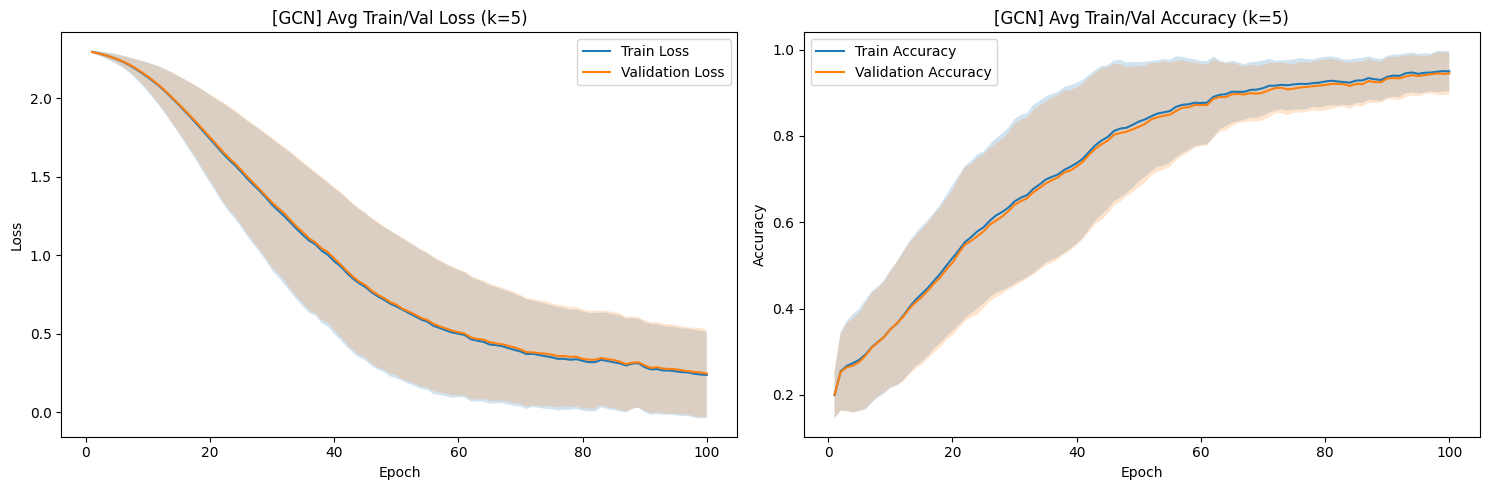

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_5_GAT
Using existing processed data for k_5_GAT
Starting k-fold cross-validation for GAT...

--- Fold 1/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8746, Train Acc: 0.3293, Val Loss: 1.8822, Val Acc: 0.3346
Epoch 020, Train Loss: 1.3370, Train Acc: 0.4951, Val Loss: 1.3502, Val Acc: 0.4913
Epoch 030, Train Loss: 0.9237, Train Acc: 0.6993, Val Loss: 0.9187, Val Acc: 0.6903
Epoch 040, Train Loss: 0.4859, Train Acc: 0.8504, Val Loss: 0.5136, Val Acc: 0.8383
Epoch 050, Train Loss: 0.1843, Train Acc: 0.9779, Val Loss: 0.2083, Val Acc: 0.9652
Epoch 060, Train Loss: 0.1985, Train Acc: 0.9644, Val Loss: 0.2104, Val Acc: 0.9465
Epoch 070, Train Loss: 0.1339, Train Acc: 0.9667, Val Loss: 0.1641, Val Acc: 0.9527
Epoch 080, Train Loss: 0.0538, Train Acc: 0.9932, Val Loss: 0.0708, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0419, Train Acc: 0.9950, Val Loss: 0.0557, Val Acc: 0.9876


[I 2025-01-26 16:35:20,896] Trial 0 finished with value: 0.04895159974694252 and parameters: {'hidden_channels': 40, 'dropout': 0.3269058769997948, 'lr': 0.003940680227629582}. Best is trial 0 with value: 0.04895159974694252.


Epoch 100, Train Loss: 0.0346, Train Acc: 0.9953, Val Loss: 0.0490, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0875, Train Acc: 0.1748, Val Loss: 2.0901, Val Acc: 0.1654
Epoch 020, Train Loss: 1.9179, Train Acc: 0.1636, Val Loss: 1.9187, Val Acc: 0.1567
Epoch 030, Train Loss: 1.6316, Train Acc: 0.2865, Val Loss: 1.6330, Val Acc: 0.2886
Epoch 040, Train Loss: 0.9430, Train Acc: 0.6611, Val Loss: 0.9414, Val Acc: 0.6754
Epoch 050, Train Loss: 0.4451, Train Acc: 0.9284, Val Loss: 0.4456, Val Acc: 0.9192
Epoch 060, Train Loss: 0.2077, Train Acc: 0.9647, Val Loss: 0.2205, Val Acc: 0.9614
Epoch 070, Train Loss: 0.1651, Train Acc: 0.9680, Val Loss: 0.1955, Val Acc: 0.9652
Epoch 080, Train Loss: 0.0816, Train Acc: 0.9821, Val Loss: 0.0933, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0841, Train Acc: 0.9798, Val Loss: 0.1022, Val Acc: 0.9776


[I 2025-01-26 16:35:23,485] Trial 1 finished with value: 0.10902086645364761 and parameters: {'hidden_channels': 37, 'dropout': 0.3351078314717824, 'lr': 0.001926110689417378}. Best is trial 0 with value: 0.04895159974694252.


Epoch 100, Train Loss: 0.1083, Train Acc: 0.9770, Val Loss: 0.1090, Val Acc: 0.9776
Epoch 010, Train Loss: 2.1935, Train Acc: 0.2497, Val Loss: 2.1983, Val Acc: 0.2450


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9866, Train Acc: 0.4396, Val Loss: 1.9926, Val Acc: 0.4142
Epoch 030, Train Loss: 1.6718, Train Acc: 0.4610, Val Loss: 1.6797, Val Acc: 0.4590
Epoch 040, Train Loss: 1.2665, Train Acc: 0.6858, Val Loss: 1.2707, Val Acc: 0.6878
Epoch 050, Train Loss: 0.9405, Train Acc: 0.7678, Val Loss: 0.9350, Val Acc: 0.7687
Epoch 060, Train Loss: 0.5077, Train Acc: 0.9008, Val Loss: 0.5305, Val Acc: 0.8781
Epoch 070, Train Loss: 0.3263, Train Acc: 0.9309, Val Loss: 0.3461, Val Acc: 0.9254
Epoch 080, Train Loss: 0.2427, Train Acc: 0.9470, Val Loss: 0.2734, Val Acc: 0.9366
Epoch 090, Train Loss: 0.1898, Train Acc: 0.9704, Val Loss: 0.2080, Val Acc: 0.9627


[I 2025-01-26 16:35:25,226] Trial 2 finished with value: 0.2513844966888428 and parameters: {'hidden_channels': 23, 'dropout': 0.49297086267073326, 'lr': 0.0012840684358452399}. Best is trial 0 with value: 0.04895159974694252.


Epoch 100, Train Loss: 0.2114, Train Acc: 0.9550, Val Loss: 0.2514, Val Acc: 0.9366
Epoch 010, Train Loss: 2.2188, Train Acc: 0.1143, Val Loss: 2.2164, Val Acc: 0.1219


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0777, Train Acc: 0.1583, Val Loss: 2.0788, Val Acc: 0.1555
Epoch 030, Train Loss: 1.8316, Train Acc: 0.2150, Val Loss: 1.8393, Val Acc: 0.2052
Epoch 040, Train Loss: 1.3946, Train Acc: 0.4152, Val Loss: 1.4064, Val Acc: 0.4216
Epoch 050, Train Loss: 0.8275, Train Acc: 0.7373, Val Loss: 0.8539, Val Acc: 0.7313
Epoch 060, Train Loss: 0.4354, Train Acc: 0.9126, Val Loss: 0.4536, Val Acc: 0.9017
Epoch 070, Train Loss: 0.2372, Train Acc: 0.9639, Val Loss: 0.2658, Val Acc: 0.9577
Epoch 080, Train Loss: 0.1372, Train Acc: 0.9809, Val Loss: 0.1531, Val Acc: 0.9776
Epoch 090, Train Loss: 0.1178, Train Acc: 0.9793, Val Loss: 0.1323, Val Acc: 0.9739


[I 2025-01-26 16:35:26,635] Trial 3 finished with value: 0.16977037489414215 and parameters: {'hidden_channels': 16, 'dropout': 0.32430297889267407, 'lr': 0.0015870914870185883}. Best is trial 0 with value: 0.04895159974694252.


Epoch 100, Train Loss: 0.1506, Train Acc: 0.9697, Val Loss: 0.1698, Val Acc: 0.9664


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7249, Train Acc: 0.3133, Val Loss: 1.7229, Val Acc: 0.3159
Epoch 020, Train Loss: 1.1938, Train Acc: 0.5335, Val Loss: 1.1908, Val Acc: 0.5410
Epoch 030, Train Loss: 0.7352, Train Acc: 0.7821, Val Loss: 0.7309, Val Acc: 0.7749
Epoch 040, Train Loss: 0.3453, Train Acc: 0.9218, Val Loss: 0.3680, Val Acc: 0.9092
Epoch 050, Train Loss: 0.1738, Train Acc: 0.9704, Val Loss: 0.1889, Val Acc: 0.9677
Epoch 060, Train Loss: 0.3012, Train Acc: 0.9454, Val Loss: 0.3405, Val Acc: 0.9279
Epoch 070, Train Loss: 0.1874, Train Acc: 0.9698, Val Loss: 0.1846, Val Acc: 0.9652
Epoch 080, Train Loss: 0.1624, Train Acc: 0.9793, Val Loss: 0.1499, Val Acc: 0.9764
Epoch 090, Train Loss: 0.0718, Train Acc: 0.9872, Val Loss: 0.0874, Val Acc: 0.9851


[I 2025-01-26 16:35:29,780] Trial 4 finished with value: 0.06735559552907944 and parameters: {'hidden_channels': 44, 'dropout': 0.3361191783065287, 'lr': 0.0051208269128475824}. Best is trial 0 with value: 0.04895159974694252.


Epoch 100, Train Loss: 0.0500, Train Acc: 0.9928, Val Loss: 0.0674, Val Acc: 0.9900
  Fold 1 - Optuna Best Trial Val Loss: 0.0490
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 40, 'dropout': 0.3269058769997948, 'lr': 0.003940680227629582}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8773, Train Acc: 0.2654, Val Loss: 1.8818, Val Acc: 0.2587
Epoch 020, Train Loss: 1.6240, Train Acc: 0.3728, Val Loss: 1.6268, Val Acc: 0.3781
Epoch 030, Train Loss: 1.3183, Train Acc: 0.4850, Val Loss: 1.3004, Val Acc: 0.4813
Epoch 040, Train Loss: 0.5706, Train Acc: 0.8071, Val Loss: 0.5890, Val Acc: 0.7960
Epoch 050, Train Loss: 0.2794, Train Acc: 0.9319, Val Loss: 0.2968, Val Acc: 0.9229
Epoch 060, Train Loss: 0.2272, Train Acc: 0.9597, Val Loss: 0.2858, Val Acc: 0.9540
Epoch 070, Train Loss: 0.1187, Train Acc: 0.9729, Val Loss: 0.1467, Val Acc: 0.9627
Epoch 080, Train Loss: 0.1332, Train Acc: 0.9704, Val Loss: 0.1682, Val Acc: 0.9652
Epoch 090, Train Loss: 0.0705, Train Acc: 0.9823, Val Loss: 0.0746, Val Acc: 0.9838


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0821, Train Acc: 0.9862, Val Loss: 0.1119, Val Acc: 0.9838
  Fold 1 Test Metrics:
  Accuracy: 0.9813
  Precision: 0.9821
  Recall: 0.9813
  F1: 0.9813

--- Fold 2/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2037, Train Acc: 0.1016, Val Loss: 2.1996, Val Acc: 0.1020
Epoch 020, Train Loss: 2.1429, Train Acc: 0.1016, Val Loss: 2.1407, Val Acc: 0.1020
Epoch 030, Train Loss: 2.1412, Train Acc: 0.1016, Val Loss: 2.1559, Val Acc: 0.1020
Epoch 040, Train Loss: 1.7954, Train Acc: 0.1394, Val Loss: 1.8116, Val Acc: 0.1405
Epoch 050, Train Loss: 1.1323, Train Acc: 0.4232, Val Loss: 1.1514, Val Acc: 0.4154
Epoch 060, Train Loss: 0.4616, Train Acc: 0.8662, Val Loss: 0.4834, Val Acc: 0.8483
Epoch 070, Train Loss: 0.1902, Train Acc: 0.9764, Val Loss: 0.2014, Val Acc: 0.9714
Epoch 080, Train Loss: 0.0812, Train Acc: 0.9939, Val Loss: 0.1259, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0682, Train Acc: 0.9919, Val Loss: 0.0986, Val Acc: 0.9838


[I 2025-01-26 16:35:36,076] Trial 0 finished with value: 0.058106958866119385 and parameters: {'hidden_channels': 52, 'dropout': 0.30257442642924937, 'lr': 0.0006846627222117825}. Best is trial 0 with value: 0.058106958866119385.


Epoch 100, Train Loss: 0.0412, Train Acc: 0.9958, Val Loss: 0.0581, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0028, Train Acc: 0.2750, Val Loss: 1.9964, Val Acc: 0.2724
Epoch 020, Train Loss: 1.7810, Train Acc: 0.1985, Val Loss: 1.7691, Val Acc: 0.2027
Epoch 030, Train Loss: 1.3197, Train Acc: 0.3806, Val Loss: 1.3370, Val Acc: 0.3731
Epoch 040, Train Loss: 0.7732, Train Acc: 0.7116, Val Loss: 0.8397, Val Acc: 0.7065
Epoch 050, Train Loss: 0.3730, Train Acc: 0.9037, Val Loss: 0.4019, Val Acc: 0.8955
Epoch 060, Train Loss: 0.2034, Train Acc: 0.9715, Val Loss: 0.2715, Val Acc: 0.9552
Epoch 070, Train Loss: 0.1286, Train Acc: 0.9714, Val Loss: 0.1658, Val Acc: 0.9540
Epoch 080, Train Loss: 0.0960, Train Acc: 0.9841, Val Loss: 0.1307, Val Acc: 0.9764
Epoch 090, Train Loss: 0.0706, Train Acc: 0.9863, Val Loss: 0.0894, Val Acc: 0.9851


[I 2025-01-26 16:35:40,008] Trial 1 finished with value: 0.1123586893081665 and parameters: {'hidden_channels': 56, 'dropout': 0.4480259807081375, 'lr': 0.0022055148857376408}. Best is trial 0 with value: 0.058106958866119385.


Epoch 100, Train Loss: 0.0671, Train Acc: 0.9877, Val Loss: 0.1124, Val Acc: 0.9751


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1780, Train Acc: 0.1044, Val Loss: 2.1716, Val Acc: 0.1070
Epoch 020, Train Loss: 2.0663, Train Acc: 0.1016, Val Loss: 2.0637, Val Acc: 0.1020
Epoch 030, Train Loss: 1.9085, Train Acc: 0.1350, Val Loss: 1.9157, Val Acc: 0.1356
Epoch 040, Train Loss: 1.3501, Train Acc: 0.3340, Val Loss: 1.3683, Val Acc: 0.3408
Epoch 050, Train Loss: 0.7011, Train Acc: 0.7605, Val Loss: 0.7158, Val Acc: 0.7575
Epoch 060, Train Loss: 0.3064, Train Acc: 0.9515, Val Loss: 0.3194, Val Acc: 0.9515
Epoch 070, Train Loss: 0.2146, Train Acc: 0.9715, Val Loss: 0.2181, Val Acc: 0.9677
Epoch 080, Train Loss: 0.1292, Train Acc: 0.9762, Val Loss: 0.1612, Val Acc: 0.9701
Epoch 090, Train Loss: 0.0731, Train Acc: 0.9908, Val Loss: 0.0900, Val Acc: 0.9851


[I 2025-01-26 16:35:42,244] Trial 2 finished with value: 0.10908675938844681 and parameters: {'hidden_channels': 31, 'dropout': 0.38594436481541683, 'lr': 0.0013698614343520543}. Best is trial 0 with value: 0.058106958866119385.


Epoch 100, Train Loss: 0.0629, Train Acc: 0.9913, Val Loss: 0.1091, Val Acc: 0.9826


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7350, Train Acc: 0.4847, Val Loss: 1.7846, Val Acc: 0.4627
Epoch 020, Train Loss: 1.1698, Train Acc: 0.6057, Val Loss: 1.2183, Val Acc: 0.5883
Epoch 030, Train Loss: 0.8012, Train Acc: 0.7385, Val Loss: 0.8122, Val Acc: 0.7214
Epoch 040, Train Loss: 0.4614, Train Acc: 0.8627, Val Loss: 0.5312, Val Acc: 0.8358
Epoch 050, Train Loss: 0.2315, Train Acc: 0.9488, Val Loss: 0.2847, Val Acc: 0.9216
Epoch 060, Train Loss: 0.1464, Train Acc: 0.9698, Val Loss: 0.2207, Val Acc: 0.9614
Epoch 070, Train Loss: 0.0718, Train Acc: 0.9846, Val Loss: 0.0815, Val Acc: 0.9826
Epoch 080, Train Loss: 0.1125, Train Acc: 0.9723, Val Loss: 0.1778, Val Acc: 0.9540
Epoch 090, Train Loss: 0.1387, Train Acc: 0.9706, Val Loss: 0.1449, Val Acc: 0.9602


[I 2025-01-26 16:35:44,261] Trial 3 finished with value: 0.04376139119267464 and parameters: {'hidden_channels': 26, 'dropout': 0.3710638222790892, 'lr': 0.005953632973595678}. Best is trial 3 with value: 0.04376139119267464.


Epoch 100, Train Loss: 0.0411, Train Acc: 0.9922, Val Loss: 0.0438, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2624, Train Acc: 0.1241, Val Loss: 2.2565, Val Acc: 0.1381
Epoch 020, Train Loss: 2.2280, Train Acc: 0.1764, Val Loss: 2.2203, Val Acc: 0.1816
Epoch 030, Train Loss: 2.1666, Train Acc: 0.1367, Val Loss: 2.1657, Val Acc: 0.1356
Epoch 040, Train Loss: 1.9492, Train Acc: 0.1468, Val Loss: 1.9496, Val Acc: 0.1480
Epoch 050, Train Loss: 1.4459, Train Acc: 0.3478, Val Loss: 1.4579, Val Acc: 0.3408
Epoch 060, Train Loss: 0.8185, Train Acc: 0.7286, Val Loss: 0.8712, Val Acc: 0.7201
Epoch 070, Train Loss: 0.3168, Train Acc: 0.9690, Val Loss: 0.3389, Val Acc: 0.9614
Epoch 080, Train Loss: 0.1713, Train Acc: 0.9826, Val Loss: 0.2177, Val Acc: 0.9689
Epoch 090, Train Loss: 0.1071, Train Acc: 0.9862, Val Loss: 0.1202, Val Acc: 0.9813


[I 2025-01-26 16:35:48,199] Trial 4 finished with value: 0.10467008501291275 and parameters: {'hidden_channels': 56, 'dropout': 0.4001329893314655, 'lr': 0.00037669192329060897}. Best is trial 3 with value: 0.04376139119267464.


Epoch 100, Train Loss: 0.0775, Train Acc: 0.9918, Val Loss: 0.1047, Val Acc: 0.9801
  Fold 2 - Optuna Best Trial Val Loss: 0.0438
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 26, 'dropout': 0.3710638222790892, 'lr': 0.005953632973595678}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.6934, Train Acc: 0.5438, Val Loss: 1.6865, Val Acc: 0.5249
Epoch 020, Train Loss: 1.1851, Train Acc: 0.5775, Val Loss: 1.2018, Val Acc: 0.5709
Epoch 030, Train Loss: 0.7124, Train Acc: 0.7791, Val Loss: 0.7365, Val Acc: 0.7674
Epoch 040, Train Loss: 0.3443, Train Acc: 0.8983, Val Loss: 0.3735, Val Acc: 0.8769
Epoch 050, Train Loss: 0.1664, Train Acc: 0.9728, Val Loss: 0.1880, Val Acc: 0.9627
Epoch 060, Train Loss: 0.1141, Train Acc: 0.9818, Val Loss: 0.1564, Val Acc: 0.9751
Epoch 070, Train Loss: 0.0884, Train Acc: 0.9826, Val Loss: 0.1284, Val Acc: 0.9813
Epoch 080, Train Loss: 0.3099, Train Acc: 0.9522, Val Loss: 0.3829, Val Acc: 0.9316
Epoch 090, Train Loss: 0.1203, Train Acc: 0.9798, Val Loss: 0.1912, Val Acc: 0.9664


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0518, Train Acc: 0.9904, Val Loss: 0.0730, Val Acc: 0.9813
  Fold 2 Test Metrics:
  Accuracy: 0.9876
  Precision: 0.9878
  Recall: 0.9876
  F1: 0.9876

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.2731, Train Acc: 0.6670, Val Loss: 1.2825, Val Acc: 0.6704
Epoch 020, Train Loss: 0.7942, Train Acc: 0.7346, Val Loss: 0.8062, Val Acc: 0.7338
Epoch 030, Train Loss: 0.5047, Train Acc: 0.8544, Val Loss: 0.5104, Val Acc: 0.8507
Epoch 040, Train Loss: 0.3417, Train Acc: 0.9182, Val Loss: 0.3563, Val Acc: 0.9179
Epoch 050, Train Loss: 0.3280, Train Acc: 0.9227, Val Loss: 0.3822, Val Acc: 0.8993
Epoch 060, Train Loss: 0.1977, Train Acc: 0.9574, Val Loss: 0.2272, Val Acc: 0.9527
Epoch 070, Train Loss: 0.2239, Train Acc: 0.9554, Val Loss: 0.2848, Val Acc: 0.9440
Epoch 080, Train Loss: 0.1773, Train Acc: 0.9597, Val Loss: 0.1900, Val Acc: 0.9540
Epoch 090, Train Loss: 0.1290, Train Acc: 0.9732, Val Loss: 0.1336, Val Acc: 0.9701


[I 2025-01-26 16:35:52,851] Trial 0 finished with value: 0.1153504028916359 and parameters: {'hidden_channels': 36, 'dropout': 0.4975787394954546, 'lr': 0.009521359343474206}. Best is trial 0 with value: 0.1153504028916359.


Epoch 100, Train Loss: 0.1005, Train Acc: 0.9742, Val Loss: 0.1154, Val Acc: 0.9652


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0805, Train Acc: 0.2350, Val Loss: 2.0899, Val Acc: 0.2388
Epoch 020, Train Loss: 1.8846, Train Acc: 0.1807, Val Loss: 1.8970, Val Acc: 0.1828
Epoch 030, Train Loss: 1.5514, Train Acc: 0.2893, Val Loss: 1.5754, Val Acc: 0.3047
Epoch 040, Train Loss: 0.9450, Train Acc: 0.6492, Val Loss: 0.9812, Val Acc: 0.6430
Epoch 050, Train Loss: 0.4595, Train Acc: 0.8650, Val Loss: 0.4910, Val Acc: 0.8582
Epoch 060, Train Loss: 0.1937, Train Acc: 0.9642, Val Loss: 0.2018, Val Acc: 0.9614
Epoch 070, Train Loss: 0.1338, Train Acc: 0.9722, Val Loss: 0.1447, Val Acc: 0.9701
Epoch 080, Train Loss: 0.0982, Train Acc: 0.9820, Val Loss: 0.1291, Val Acc: 0.9751
Epoch 090, Train Loss: 0.0589, Train Acc: 0.9905, Val Loss: 0.0713, Val Acc: 0.9863


[I 2025-01-26 16:35:55,337] Trial 1 finished with value: 0.04705921933054924 and parameters: {'hidden_channels': 34, 'dropout': 0.33169366310109905, 'lr': 0.002348420099875537}. Best is trial 1 with value: 0.04705921933054924.


Epoch 100, Train Loss: 0.0467, Train Acc: 0.9939, Val Loss: 0.0471, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2584, Train Acc: 0.1145, Val Loss: 2.2611, Val Acc: 0.1082
Epoch 020, Train Loss: 2.1810, Train Acc: 0.1621, Val Loss: 2.1826, Val Acc: 0.1654
Epoch 030, Train Loss: 2.0306, Train Acc: 0.1930, Val Loss: 2.0302, Val Acc: 0.1866
Epoch 040, Train Loss: 1.7797, Train Acc: 0.2742, Val Loss: 1.7762, Val Acc: 0.2649
Epoch 050, Train Loss: 1.3811, Train Acc: 0.4929, Val Loss: 1.3805, Val Acc: 0.4950
Epoch 060, Train Loss: 0.8291, Train Acc: 0.8275, Val Loss: 0.8358, Val Acc: 0.8221
Epoch 070, Train Loss: 0.4386, Train Acc: 0.9459, Val Loss: 0.4487, Val Acc: 0.9403
Epoch 080, Train Loss: 0.2390, Train Acc: 0.9788, Val Loss: 0.2547, Val Acc: 0.9726
Epoch 090, Train Loss: 0.1549, Train Acc: 0.9838, Val Loss: 0.1681, Val Acc: 0.9776


[I 2025-01-26 16:35:57,899] Trial 2 finished with value: 0.12324141710996628 and parameters: {'hidden_channels': 36, 'dropout': 0.3537345192907637, 'lr': 0.0003347469119788728}. Best is trial 1 with value: 0.04705921933054924.


Epoch 100, Train Loss: 0.1161, Train Acc: 0.9902, Val Loss: 0.1232, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2959, Train Acc: 0.1199, Val Loss: 2.3007, Val Acc: 0.1231
Epoch 020, Train Loss: 2.2651, Train Acc: 0.1484, Val Loss: 2.2726, Val Acc: 0.1592
Epoch 030, Train Loss: 2.1570, Train Acc: 0.1947, Val Loss: 2.1637, Val Acc: 0.2015
Epoch 040, Train Loss: 1.9619, Train Acc: 0.4038, Val Loss: 1.9641, Val Acc: 0.4067
Epoch 050, Train Loss: 1.6416, Train Acc: 0.6583, Val Loss: 1.6479, Val Acc: 0.6692
Epoch 060, Train Loss: 1.2251, Train Acc: 0.8152, Val Loss: 1.2368, Val Acc: 0.8122
Epoch 070, Train Loss: 0.8177, Train Acc: 0.8788, Val Loss: 0.8321, Val Acc: 0.8607
Epoch 080, Train Loss: 0.5482, Train Acc: 0.9208, Val Loss: 0.5602, Val Acc: 0.9142


[I 2025-01-26 16:35:59,863] Trial 3 finished with value: 0.3308141827583313 and parameters: {'hidden_channels': 25, 'dropout': 0.2778194552029914, 'lr': 0.00016695947090241344}. Best is trial 1 with value: 0.04705921933054924.


Epoch 090, Train Loss: 0.4026, Train Acc: 0.9358, Val Loss: 0.4150, Val Acc: 0.9328
Epoch 100, Train Loss: 0.3218, Train Acc: 0.9420, Val Loss: 0.3308, Val Acc: 0.9378


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2903, Train Acc: 0.1005, Val Loss: 2.2882, Val Acc: 0.1007
Epoch 020, Train Loss: 2.2485, Train Acc: 0.1073, Val Loss: 2.2444, Val Acc: 0.1107
Epoch 030, Train Loss: 2.1567, Train Acc: 0.1297, Val Loss: 2.1495, Val Acc: 0.1306
Epoch 040, Train Loss: 1.9701, Train Acc: 0.4223, Val Loss: 1.9577, Val Acc: 0.4291
Epoch 050, Train Loss: 1.6467, Train Acc: 0.6527, Val Loss: 1.6328, Val Acc: 0.6667
Epoch 060, Train Loss: 1.2425, Train Acc: 0.7822, Val Loss: 1.2279, Val Acc: 0.7973
Epoch 070, Train Loss: 0.8617, Train Acc: 0.8535, Val Loss: 0.8652, Val Acc: 0.8458
Epoch 080, Train Loss: 0.6368, Train Acc: 0.8858, Val Loss: 0.6394, Val Acc: 0.8719


[I 2025-01-26 16:36:01,557] Trial 4 finished with value: 0.4335850477218628 and parameters: {'hidden_channels': 20, 'dropout': 0.47568649703049876, 'lr': 0.00020801870182477787}. Best is trial 1 with value: 0.04705921933054924.


Epoch 090, Train Loss: 0.4927, Train Acc: 0.8975, Val Loss: 0.5012, Val Acc: 0.8881
Epoch 100, Train Loss: 0.4242, Train Acc: 0.9109, Val Loss: 0.4336, Val Acc: 0.9080
  Fold 3 - Optuna Best Trial Val Loss: 0.0471
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 34, 'dropout': 0.33169366310109905, 'lr': 0.002348420099875537}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0536, Train Acc: 0.2179, Val Loss: 2.0523, Val Acc: 0.2226
Epoch 020, Train Loss: 1.8755, Train Acc: 0.1509, Val Loss: 1.8737, Val Acc: 0.1604
Epoch 030, Train Loss: 1.5051, Train Acc: 0.2923, Val Loss: 1.5137, Val Acc: 0.3022
Epoch 040, Train Loss: 0.8622, Train Acc: 0.6468, Val Loss: 0.8878, Val Acc: 0.6368
Epoch 050, Train Loss: 0.3602, Train Acc: 0.9110, Val Loss: 0.3842, Val Acc: 0.8905
Epoch 060, Train Loss: 0.1693, Train Acc: 0.9700, Val Loss: 0.1803, Val Acc: 0.9677
Epoch 070, Train Loss: 0.1840, Train Acc: 0.9482, Val Loss: 0.1951, Val Acc: 0.9465
Epoch 080, Train Loss: 0.1157, Train Acc: 0.9700, Val Loss: 0.1364, Val Acc: 0.9614
Epoch 090, Train Loss: 0.0659, Train Acc: 0.9877, Val Loss: 0.0747, Val Acc: 0.9863


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0648, Train Acc: 0.9816, Val Loss: 0.0677, Val Acc: 0.9813
  Fold 3 Test Metrics:
  Accuracy: 0.9764
  Precision: 0.9782
  Recall: 0.9764
  F1: 0.9766

--- Fold 4/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1472, Train Acc: 0.2406, Val Loss: 2.1484, Val Acc: 0.2276
Epoch 020, Train Loss: 1.9607, Train Acc: 0.1048, Val Loss: 1.9708, Val Acc: 0.1070
Epoch 030, Train Loss: 1.7427, Train Acc: 0.1451, Val Loss: 1.7635, Val Acc: 0.1418
Epoch 040, Train Loss: 1.2395, Train Acc: 0.4256, Val Loss: 1.2605, Val Acc: 0.4055
Epoch 050, Train Loss: 0.6657, Train Acc: 0.7931, Val Loss: 0.7099, Val Acc: 0.7600
Epoch 060, Train Loss: 0.3455, Train Acc: 0.9311, Val Loss: 0.3818, Val Acc: 0.9154
Epoch 070, Train Loss: 0.1541, Train Acc: 0.9785, Val Loss: 0.1748, Val Acc: 0.9726
Epoch 080, Train Loss: 0.0915, Train Acc: 0.9891, Val Loss: 0.0997, Val Acc: 0.9888


[I 2025-01-26 16:36:06,035] Trial 0 finished with value: 0.13307449221611023 and parameters: {'hidden_channels': 25, 'dropout': 0.24751465708167644, 'lr': 0.0013850551748367838}. Best is trial 0 with value: 0.13307449221611023.


Epoch 090, Train Loss: 0.1060, Train Acc: 0.9818, Val Loss: 0.1446, Val Acc: 0.9751
Epoch 100, Train Loss: 0.1012, Train Acc: 0.9802, Val Loss: 0.1331, Val Acc: 0.9726


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0941, Train Acc: 0.4327, Val Loss: 2.0954, Val Acc: 0.4328
Epoch 020, Train Loss: 1.6990, Train Acc: 0.5211, Val Loss: 1.7056, Val Acc: 0.5174
Epoch 030, Train Loss: 1.2701, Train Acc: 0.6083, Val Loss: 1.2859, Val Acc: 0.5846
Epoch 040, Train Loss: 0.8356, Train Acc: 0.7633, Val Loss: 0.8556, Val Acc: 0.7413
Epoch 050, Train Loss: 0.4788, Train Acc: 0.8860, Val Loss: 0.4902, Val Acc: 0.8818
Epoch 060, Train Loss: 0.2814, Train Acc: 0.9527, Val Loss: 0.3156, Val Acc: 0.9366
Epoch 070, Train Loss: 0.1636, Train Acc: 0.9667, Val Loss: 0.1831, Val Acc: 0.9614
Epoch 080, Train Loss: 0.1299, Train Acc: 0.9742, Val Loss: 0.1622, Val Acc: 0.9689


[I 2025-01-26 16:36:07,553] Trial 1 finished with value: 0.11070604622364044 and parameters: {'hidden_channels': 17, 'dropout': 0.2857566423914607, 'lr': 0.002378790405891533}. Best is trial 1 with value: 0.11070604622364044.


Epoch 090, Train Loss: 0.1098, Train Acc: 0.9736, Val Loss: 0.1069, Val Acc: 0.9739
Epoch 100, Train Loss: 0.0866, Train Acc: 0.9860, Val Loss: 0.1107, Val Acc: 0.9826


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2387, Train Acc: 0.1030, Val Loss: 2.2409, Val Acc: 0.1020
Epoch 020, Train Loss: 2.1897, Train Acc: 0.1543, Val Loss: 2.1963, Val Acc: 0.1567
Epoch 030, Train Loss: 2.1843, Train Acc: 0.1285, Val Loss: 2.1992, Val Acc: 0.1281
Epoch 040, Train Loss: 1.9155, Train Acc: 0.1703, Val Loss: 1.9406, Val Acc: 0.1704
Epoch 050, Train Loss: 1.2950, Train Acc: 0.4184, Val Loss: 1.3221, Val Acc: 0.4104
Epoch 060, Train Loss: 0.5840, Train Acc: 0.8479, Val Loss: 0.6164, Val Acc: 0.8433
Epoch 070, Train Loss: 0.2163, Train Acc: 0.9809, Val Loss: 0.2401, Val Acc: 0.9776
Epoch 080, Train Loss: 0.1193, Train Acc: 0.9899, Val Loss: 0.1519, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0741, Train Acc: 0.9902, Val Loss: 0.0855, Val Acc: 0.9863


[I 2025-01-26 16:36:10,106] Trial 2 finished with value: 0.09149974584579468 and parameters: {'hidden_channels': 36, 'dropout': 0.24656418844106104, 'lr': 0.000679105878674494}. Best is trial 2 with value: 0.09149974584579468.


Epoch 100, Train Loss: 0.0657, Train Acc: 0.9922, Val Loss: 0.0915, Val Acc: 0.9876
Epoch 010, Train Loss: 1.7108, Train Acc: 0.4879, Val Loss: 1.7476, Val Acc: 0.4664


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.1105, Train Acc: 0.6211, Val Loss: 1.1491, Val Acc: 0.6057
Epoch 030, Train Loss: 0.6715, Train Acc: 0.7878, Val Loss: 0.6974, Val Acc: 0.7898
Epoch 040, Train Loss: 0.3912, Train Acc: 0.8827, Val Loss: 0.3998, Val Acc: 0.8893
Epoch 050, Train Loss: 0.2092, Train Acc: 0.9544, Val Loss: 0.2447, Val Acc: 0.9440
Epoch 060, Train Loss: 0.2021, Train Acc: 0.9608, Val Loss: 0.2477, Val Acc: 0.9614
Epoch 070, Train Loss: 0.2098, Train Acc: 0.9561, Val Loss: 0.2355, Val Acc: 0.9639
Epoch 080, Train Loss: 0.1332, Train Acc: 0.9630, Val Loss: 0.1534, Val Acc: 0.9577
Epoch 090, Train Loss: 0.0664, Train Acc: 0.9899, Val Loss: 0.1020, Val Acc: 0.9838


[I 2025-01-26 16:36:11,898] Trial 3 finished with value: 0.049455590546131134 and parameters: {'hidden_channels': 23, 'dropout': 0.31855520880103183, 'lr': 0.0064146189584100505}. Best is trial 3 with value: 0.049455590546131134.


Epoch 100, Train Loss: 0.0391, Train Acc: 0.9932, Val Loss: 0.0495, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7167, Train Acc: 0.2820, Val Loss: 1.7727, Val Acc: 0.2749
Epoch 020, Train Loss: 1.2730, Train Acc: 0.4861, Val Loss: 1.3569, Val Acc: 0.4478
Epoch 030, Train Loss: 0.8561, Train Acc: 0.6916, Val Loss: 0.9225, Val Acc: 0.6555
Epoch 040, Train Loss: 0.5231, Train Acc: 0.8323, Val Loss: 0.5871, Val Acc: 0.8134
Epoch 050, Train Loss: 0.2584, Train Acc: 0.9309, Val Loss: 0.3033, Val Acc: 0.9154
Epoch 060, Train Loss: 0.2328, Train Acc: 0.9488, Val Loss: 0.2758, Val Acc: 0.9478
Epoch 070, Train Loss: 0.1892, Train Acc: 0.9596, Val Loss: 0.2407, Val Acc: 0.9540
Epoch 080, Train Loss: 0.1420, Train Acc: 0.9737, Val Loss: 0.1854, Val Acc: 0.9664
Epoch 090, Train Loss: 0.1646, Train Acc: 0.9720, Val Loss: 0.2222, Val Acc: 0.9739


[I 2025-01-26 16:36:16,053] Trial 4 finished with value: 0.13194788992404938 and parameters: {'hidden_channels': 64, 'dropout': 0.3742870873346468, 'lr': 0.004805789091558417}. Best is trial 3 with value: 0.049455590546131134.


Epoch 100, Train Loss: 0.0995, Train Acc: 0.9846, Val Loss: 0.1319, Val Acc: 0.9826
  Fold 4 - Optuna Best Trial Val Loss: 0.0495
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 23, 'dropout': 0.31855520880103183, 'lr': 0.0064146189584100505}
Epoch 010, Train Loss: 1.6982, Train Acc: 0.5121, Val Loss: 1.7237, Val Acc: 0.5012


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.1114, Train Acc: 0.6405, Val Loss: 1.1707, Val Acc: 0.6194
Epoch 030, Train Loss: 0.6381, Train Acc: 0.8194, Val Loss: 0.6817, Val Acc: 0.8147
Epoch 040, Train Loss: 0.4106, Train Acc: 0.8644, Val Loss: 0.4412, Val Acc: 0.8470
Epoch 050, Train Loss: 0.2351, Train Acc: 0.9412, Val Loss: 0.2749, Val Acc: 0.9353
Epoch 060, Train Loss: 0.1595, Train Acc: 0.9672, Val Loss: 0.2050, Val Acc: 0.9590
Epoch 070, Train Loss: 0.2444, Train Acc: 0.9493, Val Loss: 0.3100, Val Acc: 0.9540
Epoch 080, Train Loss: 0.0981, Train Acc: 0.9764, Val Loss: 0.1251, Val Acc: 0.9714
Epoch 090, Train Loss: 0.0728, Train Acc: 0.9809, Val Loss: 0.0974, Val Acc: 0.9751


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0998, Train Acc: 0.9770, Val Loss: 0.1373, Val Acc: 0.9701
  Fold 4 Test Metrics:
  Accuracy: 0.9776
  Precision: 0.9797
  Recall: 0.9776
  F1: 0.9780

--- Fold 5/10 ---
Epoch 010, Train Loss: 2.0408, Train Acc: 0.2083, Val Loss: 2.0323, Val Acc: 0.1915


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7475, Train Acc: 0.2318, Val Loss: 1.7585, Val Acc: 0.2065
Epoch 030, Train Loss: 1.4506, Train Acc: 0.4083, Val Loss: 1.4869, Val Acc: 0.3993
Epoch 040, Train Loss: 0.9690, Train Acc: 0.6410, Val Loss: 1.0535, Val Acc: 0.6119
Epoch 050, Train Loss: 0.3910, Train Acc: 0.8818, Val Loss: 0.4383, Val Acc: 0.8582
Epoch 060, Train Loss: 0.1385, Train Acc: 0.9773, Val Loss: 0.1510, Val Acc: 0.9764
Epoch 070, Train Loss: 0.1367, Train Acc: 0.9704, Val Loss: 0.1345, Val Acc: 0.9726
Epoch 080, Train Loss: 0.1921, Train Acc: 0.9568, Val Loss: 0.1488, Val Acc: 0.9627
Epoch 090, Train Loss: 0.0966, Train Acc: 0.9798, Val Loss: 0.0899, Val Acc: 0.9838


[I 2025-01-26 16:36:19,488] Trial 0 finished with value: 0.04725554957985878 and parameters: {'hidden_channels': 21, 'dropout': 0.2054429847032299, 'lr': 0.0029398388458748773}. Best is trial 0 with value: 0.04725554957985878.


Epoch 100, Train Loss: 0.0482, Train Acc: 0.9896, Val Loss: 0.0473, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2295, Train Acc: 0.1062, Val Loss: 2.2346, Val Acc: 0.1007
Epoch 020, Train Loss: 2.1731, Train Acc: 0.1607, Val Loss: 2.1893, Val Acc: 0.1604
Epoch 030, Train Loss: 2.0628, Train Acc: 0.1240, Val Loss: 2.0945, Val Acc: 0.1294
Epoch 040, Train Loss: 1.7775, Train Acc: 0.1891, Val Loss: 1.8391, Val Acc: 0.1978
Epoch 050, Train Loss: 1.2130, Train Acc: 0.4007, Val Loss: 1.2804, Val Acc: 0.3781
Epoch 060, Train Loss: 0.5800, Train Acc: 0.8382, Val Loss: 0.6394, Val Acc: 0.8060
Epoch 070, Train Loss: 0.2127, Train Acc: 0.9785, Val Loss: 0.2476, Val Acc: 0.9701
Epoch 080, Train Loss: 0.0874, Train Acc: 0.9942, Val Loss: 0.1036, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0556, Train Acc: 0.9932, Val Loss: 0.0584, Val Acc: 0.9938


[I 2025-01-26 16:36:23,607] Trial 1 finished with value: 0.04918339475989342 and parameters: {'hidden_channels': 64, 'dropout': 0.26265535786868843, 'lr': 0.00046332886211548023}. Best is trial 0 with value: 0.04725554957985878.


Epoch 100, Train Loss: 0.0423, Train Acc: 0.9946, Val Loss: 0.0492, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2393, Train Acc: 0.2279, Val Loss: 2.2415, Val Acc: 0.2090
Epoch 020, Train Loss: 2.1484, Train Acc: 0.1291, Val Loss: 2.1543, Val Acc: 0.1294
Epoch 030, Train Loss: 2.0438, Train Acc: 0.1042, Val Loss: 2.0569, Val Acc: 0.1057
Epoch 040, Train Loss: 1.7898, Train Acc: 0.1513, Val Loss: 1.8233, Val Acc: 0.1493
Epoch 050, Train Loss: 1.2705, Train Acc: 0.4254, Val Loss: 1.3232, Val Acc: 0.4055
Epoch 060, Train Loss: 0.7213, Train Acc: 0.8012, Val Loss: 0.7805, Val Acc: 0.7649
Epoch 070, Train Loss: 0.3166, Train Acc: 0.9619, Val Loss: 0.3394, Val Acc: 0.9490
Epoch 080, Train Loss: 0.1679, Train Acc: 0.9849, Val Loss: 0.1891, Val Acc: 0.9789
Epoch 090, Train Loss: 0.1140, Train Acc: 0.9880, Val Loss: 0.1176, Val Acc: 0.9876


[I 2025-01-26 16:36:27,159] Trial 2 finished with value: 0.1285862773656845 and parameters: {'hidden_channels': 51, 'dropout': 0.43941510383374904, 'lr': 0.00040514423408689974}. Best is trial 0 with value: 0.04725554957985878.


Epoch 100, Train Loss: 0.1017, Train Acc: 0.9918, Val Loss: 0.1286, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.4705, Train Acc: 0.6394, Val Loss: 1.4696, Val Acc: 0.6331
Epoch 020, Train Loss: 0.8668, Train Acc: 0.7466, Val Loss: 0.9123, Val Acc: 0.7351
Epoch 030, Train Loss: 0.5622, Train Acc: 0.8326, Val Loss: 0.6225, Val Acc: 0.7973
Epoch 040, Train Loss: 0.4039, Train Acc: 0.8642, Val Loss: 0.4638, Val Acc: 0.8209
Epoch 050, Train Loss: 0.2124, Train Acc: 0.9368, Val Loss: 0.2240, Val Acc: 0.9341
Epoch 060, Train Loss: 0.1488, Train Acc: 0.9701, Val Loss: 0.1676, Val Acc: 0.9590
Epoch 070, Train Loss: 0.2127, Train Acc: 0.9415, Val Loss: 0.2458, Val Acc: 0.9291


[I 2025-01-26 16:36:28,983] Trial 3 finished with value: 0.1829185038805008 and parameters: {'hidden_channels': 30, 'dropout': 0.47148941001644085, 'lr': 0.008748190802262738}. Best is trial 0 with value: 0.04725554957985878.


Early stopping at epoch 80


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1989, Train Acc: 0.2078, Val Loss: 2.1996, Val Acc: 0.2177
Epoch 020, Train Loss: 2.1088, Train Acc: 0.1014, Val Loss: 2.1202, Val Acc: 0.1045
Epoch 030, Train Loss: 2.0493, Train Acc: 0.1058, Val Loss: 2.0786, Val Acc: 0.1082
Epoch 040, Train Loss: 1.6938, Train Acc: 0.1616, Val Loss: 1.7465, Val Acc: 0.1604
Epoch 050, Train Loss: 1.0537, Train Acc: 0.4767, Val Loss: 1.0934, Val Acc: 0.4627
Epoch 060, Train Loss: 0.4777, Train Acc: 0.8577, Val Loss: 0.5183, Val Acc: 0.8184
Epoch 070, Train Loss: 0.2680, Train Acc: 0.9547, Val Loss: 0.3121, Val Acc: 0.9353
Epoch 080, Train Loss: 0.0958, Train Acc: 0.9927, Val Loss: 0.1088, Val Acc: 0.9863
Epoch 090, Train Loss: 0.1256, Train Acc: 0.9751, Val Loss: 0.1387, Val Acc: 0.9701


[I 2025-01-26 16:36:32,451] Trial 4 finished with value: 0.09054537117481232 and parameters: {'hidden_channels': 49, 'dropout': 0.37531986070550727, 'lr': 0.0008223033803301956}. Best is trial 0 with value: 0.04725554957985878.


Epoch 100, Train Loss: 0.0847, Train Acc: 0.9862, Val Loss: 0.0905, Val Acc: 0.9863
  Fold 5 - Optuna Best Trial Val Loss: 0.0473
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 21, 'dropout': 0.2054429847032299, 'lr': 0.0029398388458748773}
Epoch 010, Train Loss: 2.0853, Train Acc: 0.2795, Val Loss: 2.0935, Val Acc: 0.2823


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7583, Train Acc: 0.2526, Val Loss: 1.7811, Val Acc: 0.2512
Epoch 030, Train Loss: 1.3135, Train Acc: 0.4665, Val Loss: 1.3589, Val Acc: 0.4602
Epoch 040, Train Loss: 0.7825, Train Acc: 0.7342, Val Loss: 0.8254, Val Acc: 0.7090
Epoch 050, Train Loss: 0.3736, Train Acc: 0.9005, Val Loss: 0.3996, Val Acc: 0.8818
Epoch 060, Train Loss: 0.2227, Train Acc: 0.9589, Val Loss: 0.2472, Val Acc: 0.9465
Epoch 070, Train Loss: 0.1155, Train Acc: 0.9782, Val Loss: 0.1091, Val Acc: 0.9751
Epoch 080, Train Loss: 0.0865, Train Acc: 0.9896, Val Loss: 0.0882, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0917, Train Acc: 0.9846, Val Loss: 0.1067, Val Acc: 0.9801


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0662, Train Acc: 0.9916, Val Loss: 0.0674, Val Acc: 0.9876
  Fold 5 Test Metrics:
  Accuracy: 0.9888
  Precision: 0.9897
  Recall: 0.9888
  F1: 0.9890

--- Fold 6/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1576, Train Acc: 0.2319, Val Loss: 2.1597, Val Acc: 0.2313
Epoch 020, Train Loss: 2.1002, Train Acc: 0.1020, Val Loss: 2.1060, Val Acc: 0.1032
Epoch 030, Train Loss: 2.0538, Train Acc: 0.1167, Val Loss: 2.0432, Val Acc: 0.1219
Epoch 040, Train Loss: 1.6278, Train Acc: 0.2122, Val Loss: 1.6172, Val Acc: 0.2276
Epoch 050, Train Loss: 0.9425, Train Acc: 0.5656, Val Loss: 0.9184, Val Acc: 0.5622
Epoch 060, Train Loss: 0.3567, Train Acc: 0.9250, Val Loss: 0.3496, Val Acc: 0.9291
Epoch 070, Train Loss: 0.1510, Train Acc: 0.9795, Val Loss: 0.1787, Val Acc: 0.9701
Epoch 080, Train Loss: 0.0804, Train Acc: 0.9910, Val Loss: 0.0806, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0513, Train Acc: 0.9950, Val Loss: 0.0572, Val Acc: 0.9938


[I 2025-01-26 16:36:37,220] Trial 0 finished with value: 0.1033746525645256 and parameters: {'hidden_channels': 46, 'dropout': 0.2899647680285658, 'lr': 0.0010958498130645724}. Best is trial 0 with value: 0.1033746525645256.


Epoch 100, Train Loss: 0.0944, Train Acc: 0.9759, Val Loss: 0.1034, Val Acc: 0.9726


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2832, Train Acc: 0.1087, Val Loss: 2.2864, Val Acc: 0.1082
Epoch 020, Train Loss: 2.2313, Train Acc: 0.1033, Val Loss: 2.2384, Val Acc: 0.0983
Epoch 030, Train Loss: 2.1235, Train Acc: 0.1121, Val Loss: 2.1351, Val Acc: 0.1032
Epoch 040, Train Loss: 1.9117, Train Acc: 0.2969, Val Loss: 1.9239, Val Acc: 0.2910
Epoch 050, Train Loss: 1.5715, Train Acc: 0.4940, Val Loss: 1.5789, Val Acc: 0.4776
Epoch 060, Train Loss: 1.1109, Train Acc: 0.7749, Val Loss: 1.1147, Val Acc: 0.7799
Epoch 070, Train Loss: 0.6712, Train Acc: 0.9104, Val Loss: 0.6802, Val Acc: 0.9154
Epoch 080, Train Loss: 0.4075, Train Acc: 0.9473, Val Loss: 0.4218, Val Acc: 0.9328
Epoch 090, Train Loss: 0.2772, Train Acc: 0.9661, Val Loss: 0.3045, Val Acc: 0.9453


[I 2025-01-26 16:36:40,182] Trial 1 finished with value: 0.2275334894657135 and parameters: {'hidden_channels': 41, 'dropout': 0.41393122600374443, 'lr': 0.00016569914992704314}. Best is trial 0 with value: 0.1033746525645256.


Epoch 100, Train Loss: 0.2118, Train Acc: 0.9764, Val Loss: 0.2275, Val Acc: 0.9689


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2653, Train Acc: 0.1075, Val Loss: 2.2663, Val Acc: 0.1070
Epoch 020, Train Loss: 2.1787, Train Acc: 0.2083, Val Loss: 2.1893, Val Acc: 0.2139
Epoch 030, Train Loss: 2.0254, Train Acc: 0.3688, Val Loss: 2.0390, Val Acc: 0.3632
Epoch 040, Train Loss: 1.7644, Train Acc: 0.5334, Val Loss: 1.7816, Val Acc: 0.5286
Epoch 050, Train Loss: 1.3645, Train Acc: 0.7208, Val Loss: 1.3698, Val Acc: 0.7214
Epoch 060, Train Loss: 0.9208, Train Acc: 0.8325, Val Loss: 0.9284, Val Acc: 0.8134
Epoch 070, Train Loss: 0.5660, Train Acc: 0.9064, Val Loss: 0.5834, Val Acc: 0.8980
Epoch 080, Train Loss: 0.3670, Train Acc: 0.9294, Val Loss: 0.3811, Val Acc: 0.9192
Epoch 090, Train Loss: 0.2842, Train Acc: 0.9463, Val Loss: 0.3065, Val Acc: 0.9341


[I 2025-01-26 16:36:42,308] Trial 2 finished with value: 0.24949368834495544 and parameters: {'hidden_channels': 28, 'dropout': 0.49703988456298304, 'lr': 0.0003721981989363658}. Best is trial 0 with value: 0.1033746525645256.


Epoch 100, Train Loss: 0.2312, Train Acc: 0.9634, Val Loss: 0.2495, Val Acc: 0.9565


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1068, Train Acc: 0.1971, Val Loss: 2.1022, Val Acc: 0.2027
Epoch 020, Train Loss: 1.9906, Train Acc: 0.1076, Val Loss: 1.9853, Val Acc: 0.1157
Epoch 030, Train Loss: 1.8263, Train Acc: 0.1481, Val Loss: 1.8157, Val Acc: 0.1592
Epoch 040, Train Loss: 1.2574, Train Acc: 0.3719, Val Loss: 1.2590, Val Acc: 0.3706
Epoch 050, Train Loss: 0.6462, Train Acc: 0.7962, Val Loss: 0.6330, Val Acc: 0.7873
Epoch 060, Train Loss: 0.2263, Train Acc: 0.9754, Val Loss: 0.2344, Val Acc: 0.9776
Epoch 070, Train Loss: 0.1345, Train Acc: 0.9765, Val Loss: 0.1688, Val Acc: 0.9664
Epoch 080, Train Loss: 0.1133, Train Acc: 0.9796, Val Loss: 0.1506, Val Acc: 0.9751
Epoch 090, Train Loss: 0.1111, Train Acc: 0.9804, Val Loss: 0.1171, Val Acc: 0.9801


[I 2025-01-26 16:36:45,416] Trial 3 finished with value: 0.07938426733016968 and parameters: {'hidden_channels': 42, 'dropout': 0.3451833026684713, 'lr': 0.0015456115317122221}. Best is trial 3 with value: 0.07938426733016968.


Epoch 100, Train Loss: 0.0757, Train Acc: 0.9869, Val Loss: 0.0794, Val Acc: 0.9863
Epoch 010, Train Loss: 1.8962, Train Acc: 0.5166, Val Loss: 1.9255, Val Acc: 0.4963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.3065, Train Acc: 0.5522, Val Loss: 1.3219, Val Acc: 0.5236
Epoch 030, Train Loss: 0.8726, Train Acc: 0.6841, Val Loss: 0.8856, Val Acc: 0.6642
Epoch 040, Train Loss: 0.4942, Train Acc: 0.8487, Val Loss: 0.5102, Val Acc: 0.8520
Epoch 050, Train Loss: 0.3207, Train Acc: 0.9200, Val Loss: 0.3569, Val Acc: 0.9092
Epoch 060, Train Loss: 0.1679, Train Acc: 0.9647, Val Loss: 0.2382, Val Acc: 0.9540
Epoch 070, Train Loss: 0.1895, Train Acc: 0.9686, Val Loss: 0.2685, Val Acc: 0.9502
Epoch 080, Train Loss: 0.0918, Train Acc: 0.9851, Val Loss: 0.1009, Val Acc: 0.9813
Epoch 090, Train Loss: 0.0825, Train Acc: 0.9820, Val Loss: 0.1167, Val Acc: 0.9714


[I 2025-01-26 16:36:46,856] Trial 4 finished with value: 0.06709059327840805 and parameters: {'hidden_channels': 16, 'dropout': 0.35786811845818756, 'lr': 0.005293126702216505}. Best is trial 4 with value: 0.06709059327840805.


Epoch 100, Train Loss: 0.0555, Train Acc: 0.9925, Val Loss: 0.0671, Val Acc: 0.9876
  Fold 6 - Optuna Best Trial Val Loss: 0.0671
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 16, 'dropout': 0.35786811845818756, 'lr': 0.005293126702216505}
Epoch 010, Train Loss: 1.8248, Train Acc: 0.6566, Val Loss: 1.8404, Val Acc: 0.6418


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2428, Train Acc: 0.6524, Val Loss: 1.2692, Val Acc: 0.6194
Epoch 030, Train Loss: 0.8384, Train Acc: 0.7248, Val Loss: 0.8654, Val Acc: 0.7164
Epoch 040, Train Loss: 0.4395, Train Acc: 0.8986, Val Loss: 0.4521, Val Acc: 0.8868
Epoch 050, Train Loss: 0.2813, Train Acc: 0.9350, Val Loss: 0.3194, Val Acc: 0.9167
Epoch 060, Train Loss: 0.1939, Train Acc: 0.9544, Val Loss: 0.2057, Val Acc: 0.9415
Epoch 070, Train Loss: 0.1641, Train Acc: 0.9529, Val Loss: 0.2138, Val Acc: 0.9428
Epoch 080, Train Loss: 0.1425, Train Acc: 0.9652, Val Loss: 0.1822, Val Acc: 0.9577
Epoch 090, Train Loss: 0.0533, Train Acc: 0.9911, Val Loss: 0.0669, Val Acc: 0.9876


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0593, Train Acc: 0.9849, Val Loss: 0.0581, Val Acc: 0.9838
  Fold 6 Test Metrics:
  Accuracy: 0.9826
  Precision: 0.9831
  Recall: 0.9826
  F1: 0.9825

--- Fold 7/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.2129, Train Acc: 0.6607, Val Loss: 1.1818, Val Acc: 0.6663
Epoch 020, Train Loss: 0.7772, Train Acc: 0.7879, Val Loss: 0.7417, Val Acc: 0.7833
Epoch 030, Train Loss: 0.5286, Train Acc: 0.8518, Val Loss: 0.5138, Val Acc: 0.8506
Epoch 040, Train Loss: 0.3390, Train Acc: 0.9037, Val Loss: 0.3435, Val Acc: 0.8892
Epoch 050, Train Loss: 0.2458, Train Acc: 0.9350, Val Loss: 0.2658, Val Acc: 0.9215
Epoch 060, Train Loss: 0.1907, Train Acc: 0.9513, Val Loss: 0.1897, Val Acc: 0.9440
Epoch 070, Train Loss: 0.1627, Train Acc: 0.9608, Val Loss: 0.1566, Val Acc: 0.9552
Epoch 080, Train Loss: 0.1261, Train Acc: 0.9711, Val Loss: 0.1275, Val Acc: 0.9639
Epoch 090, Train Loss: 0.1050, Train Acc: 0.9880, Val Loss: 0.0838, Val Acc: 0.9925


[I 2025-01-26 16:36:51,489] Trial 0 finished with value: 0.08088687807321548 and parameters: {'hidden_channels': 48, 'dropout': 0.4941774584520696, 'lr': 0.008891182050269016}. Best is trial 0 with value: 0.08088687807321548.


Epoch 100, Train Loss: 0.0970, Train Acc: 0.9854, Val Loss: 0.0809, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9931, Train Acc: 0.1369, Val Loss: 1.9956, Val Acc: 0.1295
Epoch 020, Train Loss: 2.1584, Train Acc: 0.1143, Val Loss: 2.1670, Val Acc: 0.1096
Epoch 030, Train Loss: 1.8836, Train Acc: 0.1838, Val Loss: 1.8756, Val Acc: 0.1681
Epoch 040, Train Loss: 0.9814, Train Acc: 0.5420, Val Loss: 0.9666, Val Acc: 0.5293
Epoch 050, Train Loss: 0.3302, Train Acc: 0.9000, Val Loss: 0.3406, Val Acc: 0.9041
Epoch 060, Train Loss: 0.2577, Train Acc: 0.9434, Val Loss: 0.2388, Val Acc: 0.9440
Epoch 070, Train Loss: 0.0836, Train Acc: 0.9872, Val Loss: 0.0840, Val Acc: 0.9913
Epoch 080, Train Loss: 0.0559, Train Acc: 0.9885, Val Loss: 0.0599, Val Acc: 0.9875
Epoch 090, Train Loss: 0.0361, Train Acc: 0.9944, Val Loss: 0.0385, Val Acc: 0.9950


[I 2025-01-26 16:36:55,305] Trial 1 finished with value: 0.026406170800328255 and parameters: {'hidden_channels': 57, 'dropout': 0.24732747018258008, 'lr': 0.0026242275806133393}. Best is trial 1 with value: 0.026406170800328255.


Epoch 100, Train Loss: 0.0336, Train Acc: 0.9953, Val Loss: 0.0264, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2975, Train Acc: 0.0995, Val Loss: 2.3012, Val Acc: 0.0996
Epoch 020, Train Loss: 2.2770, Train Acc: 0.1505, Val Loss: 2.2840, Val Acc: 0.1320
Epoch 030, Train Loss: 2.1968, Train Acc: 0.1267, Val Loss: 2.2051, Val Acc: 0.1171
Epoch 040, Train Loss: 1.9736, Train Acc: 0.1631, Val Loss: 1.9791, Val Acc: 0.1619
Epoch 050, Train Loss: 1.5394, Train Acc: 0.3639, Val Loss: 1.5418, Val Acc: 0.3611
Epoch 060, Train Loss: 0.9861, Train Acc: 0.7456, Val Loss: 0.9910, Val Acc: 0.7323
Epoch 070, Train Loss: 0.5391, Train Acc: 0.9198, Val Loss: 0.5525, Val Acc: 0.8991
Epoch 080, Train Loss: 0.2921, Train Acc: 0.9663, Val Loss: 0.3044, Val Acc: 0.9601
Epoch 090, Train Loss: 0.1848, Train Acc: 0.9829, Val Loss: 0.1950, Val Acc: 0.9776


[I 2025-01-26 16:36:58,392] Trial 2 finished with value: 0.14092449843883514 and parameters: {'hidden_channels': 47, 'dropout': 0.3458739203794198, 'lr': 0.00019300635453509577}. Best is trial 1 with value: 0.026406170800328255.


Epoch 100, Train Loss: 0.1327, Train Acc: 0.9891, Val Loss: 0.1409, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2689, Train Acc: 0.0967, Val Loss: 2.2664, Val Acc: 0.0996
Epoch 020, Train Loss: 2.1930, Train Acc: 0.1255, Val Loss: 2.1895, Val Acc: 0.1345
Epoch 030, Train Loss: 2.0838, Train Acc: 0.1913, Val Loss: 2.0790, Val Acc: 0.1943
Epoch 040, Train Loss: 1.8829, Train Acc: 0.2140, Val Loss: 1.8783, Val Acc: 0.2042
Epoch 050, Train Loss: 1.5146, Train Acc: 0.4009, Val Loss: 1.5083, Val Acc: 0.3761
Epoch 060, Train Loss: 0.9991, Train Acc: 0.7429, Val Loss: 0.9963, Val Acc: 0.7484
Epoch 070, Train Loss: 0.5306, Train Acc: 0.9297, Val Loss: 0.5400, Val Acc: 0.9278
Epoch 080, Train Loss: 0.2865, Train Acc: 0.9725, Val Loss: 0.3020, Val Acc: 0.9651
Epoch 090, Train Loss: 0.1945, Train Acc: 0.9792, Val Loss: 0.2202, Val Acc: 0.9676


[I 2025-01-26 16:37:02,248] Trial 3 finished with value: 0.17884212732315063 and parameters: {'hidden_channels': 54, 'dropout': 0.4534637581798303, 'lr': 0.0002135999479893621}. Best is trial 1 with value: 0.026406170800328255.


Epoch 100, Train Loss: 0.1561, Train Acc: 0.9841, Val Loss: 0.1788, Val Acc: 0.9738
Epoch 010, Train Loss: 2.1338, Train Acc: 0.3028, Val Loss: 2.1316, Val Acc: 0.2889


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8661, Train Acc: 0.3121, Val Loss: 1.8579, Val Acc: 0.3039
Epoch 030, Train Loss: 1.5405, Train Acc: 0.3317, Val Loss: 1.5313, Val Acc: 0.3350
Epoch 040, Train Loss: 1.0124, Train Acc: 0.6457, Val Loss: 1.0076, Val Acc: 0.6451
Epoch 050, Train Loss: 0.6071, Train Acc: 0.8406, Val Loss: 0.6067, Val Acc: 0.8344
Epoch 060, Train Loss: 0.3051, Train Acc: 0.9499, Val Loss: 0.3120, Val Acc: 0.9552
Epoch 070, Train Loss: 0.1945, Train Acc: 0.9659, Val Loss: 0.2097, Val Acc: 0.9614
Epoch 080, Train Loss: 0.1759, Train Acc: 0.9642, Val Loss: 0.1747, Val Acc: 0.9589
Epoch 090, Train Loss: 0.1149, Train Acc: 0.9806, Val Loss: 0.1155, Val Acc: 0.9776


[I 2025-01-26 16:37:04,046] Trial 4 finished with value: 0.15404289960861206 and parameters: {'hidden_channels': 24, 'dropout': 0.4684893479595582, 'lr': 0.00176735317772556}. Best is trial 1 with value: 0.026406170800328255.


Epoch 100, Train Loss: 0.1544, Train Acc: 0.9639, Val Loss: 0.1540, Val Acc: 0.9601
  Fold 7 - Optuna Best Trial Val Loss: 0.0264
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 57, 'dropout': 0.24732747018258008, 'lr': 0.0026242275806133393}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9637, Train Acc: 0.2381, Val Loss: 1.9642, Val Acc: 0.2117
Epoch 020, Train Loss: 1.7191, Train Acc: 0.2230, Val Loss: 1.7181, Val Acc: 0.2167
Epoch 030, Train Loss: 1.2383, Train Acc: 0.4364, Val Loss: 1.2286, Val Acc: 0.4284
Epoch 040, Train Loss: 0.7266, Train Acc: 0.7090, Val Loss: 0.7159, Val Acc: 0.6924
Epoch 050, Train Loss: 0.2947, Train Acc: 0.9389, Val Loss: 0.3002, Val Acc: 0.9278
Epoch 060, Train Loss: 0.1496, Train Acc: 0.9698, Val Loss: 0.1566, Val Acc: 0.9651
Epoch 070, Train Loss: 0.0898, Train Acc: 0.9869, Val Loss: 0.0876, Val Acc: 0.9851
Epoch 080, Train Loss: 0.0746, Train Acc: 0.9890, Val Loss: 0.0648, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0448, Train Acc: 0.9942, Val Loss: 0.0431, Val Acc: 0.9963


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0706, Train Acc: 0.9801, Val Loss: 0.0906, Val Acc: 0.9726
  Fold 7 Test Metrics:
  Accuracy: 0.9726
  Precision: 0.9739
  Recall: 0.9726
  F1: 0.9722

--- Fold 8/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2483, Train Acc: 0.1046, Val Loss: 2.2488, Val Acc: 0.1071
Epoch 020, Train Loss: 2.1389, Train Acc: 0.1440, Val Loss: 2.1446, Val Acc: 0.1407
Epoch 030, Train Loss: 1.9595, Train Acc: 0.1908, Val Loss: 1.9646, Val Acc: 0.1831
Epoch 040, Train Loss: 1.6561, Train Acc: 0.2787, Val Loss: 1.6586, Val Acc: 0.2752
Epoch 050, Train Loss: 1.1572, Train Acc: 0.6546, Val Loss: 1.1559, Val Acc: 0.6638
Epoch 060, Train Loss: 0.6411, Train Acc: 0.8817, Val Loss: 0.6387, Val Acc: 0.8767
Epoch 070, Train Loss: 0.3826, Train Acc: 0.9297, Val Loss: 0.3804, Val Acc: 0.9203
Epoch 080, Train Loss: 0.2131, Train Acc: 0.9736, Val Loss: 0.2133, Val Acc: 0.9689
Epoch 090, Train Loss: 0.1535, Train Acc: 0.9835, Val Loss: 0.1538, Val Acc: 0.9788


[I 2025-01-26 16:37:10,140] Trial 0 finished with value: 0.1347271054983139 and parameters: {'hidden_channels': 30, 'dropout': 0.45166744317776486, 'lr': 0.0005701958093651892}. Best is trial 0 with value: 0.1347271054983139.


Epoch 100, Train Loss: 0.1280, Train Acc: 0.9807, Val Loss: 0.1347, Val Acc: 0.9776


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.6639, Train Acc: 0.4771, Val Loss: 1.6535, Val Acc: 0.4844
Epoch 020, Train Loss: 1.1695, Train Acc: 0.5596, Val Loss: 1.1554, Val Acc: 0.5716
Epoch 030, Train Loss: 0.7534, Train Acc: 0.7640, Val Loss: 0.7406, Val Acc: 0.7671
Epoch 040, Train Loss: 0.4491, Train Acc: 0.8566, Val Loss: 0.4557, Val Acc: 0.8456
Epoch 050, Train Loss: 0.2980, Train Acc: 0.9241, Val Loss: 0.3282, Val Acc: 0.9153
Epoch 060, Train Loss: 0.1671, Train Acc: 0.9633, Val Loss: 0.1585, Val Acc: 0.9676
Epoch 070, Train Loss: 0.1057, Train Acc: 0.9848, Val Loss: 0.1123, Val Acc: 0.9826
Epoch 080, Train Loss: 0.2398, Train Acc: 0.9448, Val Loss: 0.1945, Val Acc: 0.9539
Epoch 090, Train Loss: 0.1006, Train Acc: 0.9801, Val Loss: 0.1202, Val Acc: 0.9701


[I 2025-01-26 16:37:13,913] Trial 1 finished with value: 0.12001713365316391 and parameters: {'hidden_channels': 53, 'dropout': 0.4685128330016414, 'lr': 0.004674319396279882}. Best is trial 1 with value: 0.12001713365316391.


Epoch 100, Train Loss: 0.1105, Train Acc: 0.9747, Val Loss: 0.1200, Val Acc: 0.9788


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2753, Train Acc: 0.1054, Val Loss: 2.2763, Val Acc: 0.1009
Epoch 020, Train Loss: 2.1986, Train Acc: 0.1331, Val Loss: 2.2008, Val Acc: 0.1220
Epoch 030, Train Loss: 2.0482, Train Acc: 0.2497, Val Loss: 2.0499, Val Acc: 0.2478
Epoch 040, Train Loss: 1.8105, Train Acc: 0.3545, Val Loss: 1.8117, Val Acc: 0.3362
Epoch 050, Train Loss: 1.4542, Train Acc: 0.6049, Val Loss: 1.4565, Val Acc: 0.6040
Epoch 060, Train Loss: 0.9750, Train Acc: 0.8521, Val Loss: 0.9795, Val Acc: 0.8331
Epoch 070, Train Loss: 0.5786, Train Acc: 0.9302, Val Loss: 0.5914, Val Acc: 0.9178
Epoch 080, Train Loss: 0.3413, Train Acc: 0.9569, Val Loss: 0.3545, Val Acc: 0.9465
Epoch 090, Train Loss: 0.2384, Train Acc: 0.9714, Val Loss: 0.2461, Val Acc: 0.9589


[I 2025-01-26 16:37:16,497] Trial 2 finished with value: 0.19692084193229675 and parameters: {'hidden_channels': 35, 'dropout': 0.40598625602373156, 'lr': 0.0002419342441350623}. Best is trial 1 with value: 0.12001713365316391.


Epoch 100, Train Loss: 0.1884, Train Acc: 0.9785, Val Loss: 0.1969, Val Acc: 0.9701


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2702, Train Acc: 0.1522, Val Loss: 2.2710, Val Acc: 0.1656
Epoch 020, Train Loss: 2.2087, Train Acc: 0.1886, Val Loss: 2.2109, Val Acc: 0.1868
Epoch 030, Train Loss: 2.0703, Train Acc: 0.2068, Val Loss: 2.0747, Val Acc: 0.2055
Epoch 040, Train Loss: 1.8138, Train Acc: 0.2916, Val Loss: 1.8164, Val Acc: 0.2852
Epoch 050, Train Loss: 1.4010, Train Acc: 0.5215, Val Loss: 1.4028, Val Acc: 0.5268
Epoch 060, Train Loss: 0.8747, Train Acc: 0.8010, Val Loss: 0.8835, Val Acc: 0.8045
Epoch 070, Train Loss: 0.4820, Train Acc: 0.9311, Val Loss: 0.4869, Val Acc: 0.9240
Epoch 080, Train Loss: 0.2769, Train Acc: 0.9611, Val Loss: 0.2840, Val Acc: 0.9527
Epoch 090, Train Loss: 0.1812, Train Acc: 0.9762, Val Loss: 0.1915, Val Acc: 0.9726


[I 2025-01-26 16:37:19,631] Trial 3 finished with value: 0.1416609287261963 and parameters: {'hidden_channels': 47, 'dropout': 0.46980210633799724, 'lr': 0.000288327217436993}. Best is trial 1 with value: 0.12001713365316391.


Epoch 100, Train Loss: 0.1474, Train Acc: 0.9734, Val Loss: 0.1417, Val Acc: 0.9714


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3041, Train Acc: 0.1067, Val Loss: 2.3035, Val Acc: 0.1021
Epoch 020, Train Loss: 2.2834, Train Acc: 0.1462, Val Loss: 2.2856, Val Acc: 0.1432
Epoch 030, Train Loss: 2.2053, Train Acc: 0.1149, Val Loss: 2.2102, Val Acc: 0.1183
Epoch 040, Train Loss: 2.0301, Train Acc: 0.1480, Val Loss: 2.0369, Val Acc: 0.1432
Epoch 050, Train Loss: 1.6806, Train Acc: 0.3236, Val Loss: 1.6916, Val Acc: 0.3200
Epoch 060, Train Loss: 1.1596, Train Acc: 0.6668, Val Loss: 1.1699, Val Acc: 0.6687
Epoch 070, Train Loss: 0.6609, Train Acc: 0.8912, Val Loss: 0.6717, Val Acc: 0.8904
Epoch 080, Train Loss: 0.3849, Train Acc: 0.9406, Val Loss: 0.3936, Val Acc: 0.9365
Epoch 090, Train Loss: 0.2466, Train Acc: 0.9726, Val Loss: 0.2622, Val Acc: 0.9589


[I 2025-01-26 16:37:23,499] Trial 4 finished with value: 0.20538468658924103 and parameters: {'hidden_channels': 58, 'dropout': 0.28282638107458247, 'lr': 0.00011630732378414145}. Best is trial 1 with value: 0.12001713365316391.


Epoch 100, Train Loss: 0.1942, Train Acc: 0.9737, Val Loss: 0.2054, Val Acc: 0.9664
  Fold 8 - Optuna Best Trial Val Loss: 0.1200
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 53, 'dropout': 0.4685128330016414, 'lr': 0.004674319396279882}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.6968, Train Acc: 0.4338, Val Loss: 1.6707, Val Acc: 0.4309
Epoch 020, Train Loss: 1.3357, Train Acc: 0.4726, Val Loss: 1.2965, Val Acc: 0.4832
Epoch 030, Train Loss: 0.8760, Train Acc: 0.7038, Val Loss: 0.8567, Val Acc: 0.7036
Epoch 040, Train Loss: 0.4746, Train Acc: 0.8800, Val Loss: 0.4749, Val Acc: 0.8829
Epoch 050, Train Loss: 0.3623, Train Acc: 0.9126, Val Loss: 0.3278, Val Acc: 0.9191
Epoch 060, Train Loss: 0.1699, Train Acc: 0.9720, Val Loss: 0.1577, Val Acc: 0.9738
Epoch 070, Train Loss: 0.2413, Train Acc: 0.9373, Val Loss: 0.2492, Val Acc: 0.9340
Epoch 080, Train Loss: 0.2035, Train Acc: 0.9566, Val Loss: 0.1995, Val Acc: 0.9626
Epoch 090, Train Loss: 0.0962, Train Acc: 0.9872, Val Loss: 0.0889, Val Acc: 0.9900


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0754, Train Acc: 0.9865, Val Loss: 0.0692, Val Acc: 0.9888
  Fold 8 Test Metrics:
  Accuracy: 0.9863
  Precision: 0.9867
  Recall: 0.9863
  F1: 0.9863

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2992, Train Acc: 0.1532, Val Loss: 2.2981, Val Acc: 0.1569
Epoch 020, Train Loss: 2.2532, Train Acc: 0.1179, Val Loss: 2.2557, Val Acc: 0.1171
Epoch 030, Train Loss: 2.1434, Train Acc: 0.1504, Val Loss: 2.1540, Val Acc: 0.1395
Epoch 040, Train Loss: 1.9523, Train Acc: 0.2998, Val Loss: 1.9779, Val Acc: 0.2491
Epoch 050, Train Loss: 1.6269, Train Acc: 0.5450, Val Loss: 1.6716, Val Acc: 0.4944
Epoch 060, Train Loss: 1.1805, Train Acc: 0.7806, Val Loss: 1.2398, Val Acc: 0.7621
Epoch 070, Train Loss: 0.7466, Train Acc: 0.8843, Val Loss: 0.8055, Val Acc: 0.8867
Epoch 080, Train Loss: 0.4722, Train Acc: 0.9370, Val Loss: 0.5191, Val Acc: 0.9315
Epoch 090, Train Loss: 0.3424, Train Acc: 0.9476, Val Loss: 0.3837, Val Acc: 0.9390


[I 2025-01-26 16:37:30,748] Trial 0 finished with value: 0.2948083281517029 and parameters: {'hidden_channels': 49, 'dropout': 0.24485067642541858, 'lr': 0.00010234704639059799}. Best is trial 0 with value: 0.2948083281517029.


Epoch 100, Train Loss: 0.2683, Train Acc: 0.9560, Val Loss: 0.2948, Val Acc: 0.9539
Epoch 010, Train Loss: 2.2782, Train Acc: 0.1557, Val Loss: 2.2804, Val Acc: 0.1420


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2124, Train Acc: 0.1866, Val Loss: 2.2207, Val Acc: 0.1743
Epoch 030, Train Loss: 2.0782, Train Acc: 0.2180, Val Loss: 2.0993, Val Acc: 0.2005
Epoch 040, Train Loss: 1.8594, Train Acc: 0.3496, Val Loss: 1.8966, Val Acc: 0.3151
Epoch 050, Train Loss: 1.5251, Train Acc: 0.5503, Val Loss: 1.5845, Val Acc: 0.4882
Epoch 060, Train Loss: 1.0687, Train Acc: 0.7899, Val Loss: 1.1329, Val Acc: 0.7634
Epoch 070, Train Loss: 0.6907, Train Acc: 0.8884, Val Loss: 0.7454, Val Acc: 0.8804
Epoch 080, Train Loss: 0.4488, Train Acc: 0.9353, Val Loss: 0.4949, Val Acc: 0.9303
Epoch 090, Train Loss: 0.3231, Train Acc: 0.9561, Val Loss: 0.3576, Val Acc: 0.9539


[I 2025-01-26 16:37:32,408] Trial 1 finished with value: 0.29071471095085144 and parameters: {'hidden_channels': 21, 'dropout': 0.3337700192035903, 'lr': 0.00030831727559757054}. Best is trial 1 with value: 0.29071471095085144.


Epoch 100, Train Loss: 0.2627, Train Acc: 0.9608, Val Loss: 0.2907, Val Acc: 0.9589


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2231, Train Acc: 0.1706, Val Loss: 2.2284, Val Acc: 0.1681
Epoch 020, Train Loss: 2.1118, Train Acc: 0.1022, Val Loss: 2.1281, Val Acc: 0.1009
Epoch 030, Train Loss: 1.9202, Train Acc: 0.1126, Val Loss: 1.9595, Val Acc: 0.1034
Epoch 040, Train Loss: 1.5352, Train Acc: 0.2452, Val Loss: 1.5948, Val Acc: 0.2179
Epoch 050, Train Loss: 0.9600, Train Acc: 0.6377, Val Loss: 1.0219, Val Acc: 0.5915
Epoch 060, Train Loss: 0.4139, Train Acc: 0.9139, Val Loss: 0.4464, Val Acc: 0.8991
Epoch 070, Train Loss: 0.1634, Train Acc: 0.9779, Val Loss: 0.1804, Val Acc: 0.9726
Epoch 080, Train Loss: 0.0938, Train Acc: 0.9886, Val Loss: 0.1060, Val Acc: 0.9851
Epoch 090, Train Loss: 0.0731, Train Acc: 0.9838, Val Loss: 0.0780, Val Acc: 0.9838


[I 2025-01-26 16:37:34,799] Trial 2 finished with value: 0.13579536974430084 and parameters: {'hidden_channels': 32, 'dropout': 0.2957478146577634, 'lr': 0.0010317236932749058}. Best is trial 2 with value: 0.13579536974430084.


Epoch 100, Train Loss: 0.1515, Train Acc: 0.9636, Val Loss: 0.1358, Val Acc: 0.9651


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.3293, Train Acc: 0.5372, Val Loss: 1.3826, Val Acc: 0.4795
Epoch 020, Train Loss: 1.0365, Train Acc: 0.5889, Val Loss: 1.0964, Val Acc: 0.5604
Epoch 030, Train Loss: 0.7004, Train Acc: 0.7781, Val Loss: 0.7149, Val Acc: 0.7709
Epoch 040, Train Loss: 0.3648, Train Acc: 0.9205, Val Loss: 0.3742, Val Acc: 0.9178
Epoch 050, Train Loss: 0.1593, Train Acc: 0.9736, Val Loss: 0.1492, Val Acc: 0.9776
Epoch 060, Train Loss: 0.1760, Train Acc: 0.9625, Val Loss: 0.1452, Val Acc: 0.9614
Epoch 070, Train Loss: 0.2450, Train Acc: 0.9436, Val Loss: 0.2307, Val Acc: 0.9514
Epoch 080, Train Loss: 0.0951, Train Acc: 0.9787, Val Loss: 0.0844, Val Acc: 0.9813
Epoch 090, Train Loss: 0.3000, Train Acc: 0.9520, Val Loss: 0.2177, Val Acc: 0.9577


[I 2025-01-26 16:37:38,664] Trial 3 finished with value: 0.06013939529657364 and parameters: {'hidden_channels': 61, 'dropout': 0.25113525588570434, 'lr': 0.007146097944658914}. Best is trial 3 with value: 0.06013939529657364.


Epoch 100, Train Loss: 0.0830, Train Acc: 0.9852, Val Loss: 0.0601, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8639, Train Acc: 0.1833, Val Loss: 1.8804, Val Acc: 0.1669
Epoch 020, Train Loss: 1.5034, Train Acc: 0.3965, Val Loss: 1.5444, Val Acc: 0.3624
Epoch 030, Train Loss: 0.8992, Train Acc: 0.7066, Val Loss: 0.9451, Val Acc: 0.7173
Epoch 040, Train Loss: 0.4503, Train Acc: 0.8832, Val Loss: 0.4781, Val Acc: 0.8643
Epoch 050, Train Loss: 0.2271, Train Acc: 0.9639, Val Loss: 0.2270, Val Acc: 0.9514
Epoch 060, Train Loss: 0.1662, Train Acc: 0.9481, Val Loss: 0.1846, Val Acc: 0.9402
Epoch 070, Train Loss: 0.0904, Train Acc: 0.9826, Val Loss: 0.0734, Val Acc: 0.9888
Epoch 080, Train Loss: 0.0925, Train Acc: 0.9765, Val Loss: 0.0768, Val Acc: 0.9751
Epoch 090, Train Loss: 0.0672, Train Acc: 0.9837, Val Loss: 0.0591, Val Acc: 0.9838


[I 2025-01-26 16:37:42,486] Trial 4 finished with value: 0.05231352895498276 and parameters: {'hidden_channels': 55, 'dropout': 0.3204106858952515, 'lr': 0.0040010135473043116}. Best is trial 4 with value: 0.05231352895498276.


Epoch 100, Train Loss: 0.0453, Train Acc: 0.9905, Val Loss: 0.0523, Val Acc: 0.9888
  Fold 9 - Optuna Best Trial Val Loss: 0.0523
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 55, 'dropout': 0.3204106858952515, 'lr': 0.0040010135473043116}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8361, Train Acc: 0.2446, Val Loss: 1.8620, Val Acc: 0.2130
Epoch 020, Train Loss: 1.6143, Train Acc: 0.3710, Val Loss: 1.6629, Val Acc: 0.3400
Epoch 030, Train Loss: 1.1487, Train Acc: 0.5662, Val Loss: 1.2152, Val Acc: 0.5492
Epoch 040, Train Loss: 0.5836, Train Acc: 0.8131, Val Loss: 0.6280, Val Acc: 0.8057
Epoch 050, Train Loss: 0.2234, Train Acc: 0.9526, Val Loss: 0.2327, Val Acc: 0.9564
Epoch 060, Train Loss: 0.1988, Train Acc: 0.9465, Val Loss: 0.1916, Val Acc: 0.9489
Epoch 070, Train Loss: 0.1192, Train Acc: 0.9753, Val Loss: 0.0930, Val Acc: 0.9838
Epoch 080, Train Loss: 0.1181, Train Acc: 0.9843, Val Loss: 0.1366, Val Acc: 0.9826
Epoch 090, Train Loss: 0.1021, Train Acc: 0.9649, Val Loss: 0.1018, Val Acc: 0.9676


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0456, Train Acc: 0.9949, Val Loss: 0.0435, Val Acc: 0.9938
  Fold 9 Test Metrics:
  Accuracy: 0.9938
  Precision: 0.9938
  Recall: 0.9938
  F1: 0.9938

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0004, Train Acc: 0.2728, Val Loss: 1.9903, Val Acc: 0.2898
Epoch 020, Train Loss: 1.7125, Train Acc: 0.2946, Val Loss: 1.6897, Val Acc: 0.2985
Epoch 030, Train Loss: 1.2325, Train Acc: 0.4921, Val Loss: 1.1944, Val Acc: 0.4963
Epoch 040, Train Loss: 0.6311, Train Acc: 0.8193, Val Loss: 0.6234, Val Acc: 0.8184
Epoch 050, Train Loss: 0.3297, Train Acc: 0.9479, Val Loss: 0.2973, Val Acc: 0.9440
Epoch 060, Train Loss: 0.1884, Train Acc: 0.9743, Val Loss: 0.1702, Val Acc: 0.9677
Epoch 070, Train Loss: 0.1679, Train Acc: 0.9672, Val Loss: 0.1396, Val Acc: 0.9664
Epoch 080, Train Loss: 0.1349, Train Acc: 0.9675, Val Loss: 0.1285, Val Acc: 0.9726
Epoch 090, Train Loss: 0.1198, Train Acc: 0.9745, Val Loss: 0.1046, Val Acc: 0.9751


[I 2025-01-26 16:37:49,835] Trial 0 finished with value: 0.06110258400440216 and parameters: {'hidden_channels': 49, 'dropout': 0.41414311800285364, 'lr': 0.00251503055295091}. Best is trial 0 with value: 0.06110258400440216.


Epoch 100, Train Loss: 0.0692, Train Acc: 0.9858, Val Loss: 0.0611, Val Acc: 0.9876
Epoch 010, Train Loss: 2.0183, Train Acc: 0.4523, Val Loss: 2.0109, Val Acc: 0.4453


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.5390, Train Acc: 0.5277, Val Loss: 1.5151, Val Acc: 0.5684
Epoch 030, Train Loss: 0.9630, Train Acc: 0.7687, Val Loss: 0.9457, Val Acc: 0.7823
Epoch 040, Train Loss: 0.6211, Train Acc: 0.8546, Val Loss: 0.6009, Val Acc: 0.8507
Epoch 050, Train Loss: 0.3496, Train Acc: 0.9218, Val Loss: 0.3370, Val Acc: 0.9341
Epoch 060, Train Loss: 0.2476, Train Acc: 0.9498, Val Loss: 0.2186, Val Acc: 0.9478
Epoch 070, Train Loss: 0.1622, Train Acc: 0.9739, Val Loss: 0.1529, Val Acc: 0.9751
Epoch 080, Train Loss: 0.1372, Train Acc: 0.9655, Val Loss: 0.1257, Val Acc: 0.9664
Epoch 090, Train Loss: 0.1441, Train Acc: 0.9711, Val Loss: 0.1247, Val Acc: 0.9701


[I 2025-01-26 16:37:51,634] Trial 1 finished with value: 0.12672775983810425 and parameters: {'hidden_channels': 24, 'dropout': 0.45317016093134926, 'lr': 0.0031726212057744695}. Best is trial 0 with value: 0.06110258400440216.


Epoch 100, Train Loss: 0.1336, Train Acc: 0.9680, Val Loss: 0.1267, Val Acc: 0.9677


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1385, Train Acc: 0.2299, Val Loss: 2.1365, Val Acc: 0.2525
Epoch 020, Train Loss: 2.1542, Train Acc: 0.1168, Val Loss: 2.1290, Val Acc: 0.1169
Epoch 030, Train Loss: 2.0036, Train Acc: 0.1323, Val Loss: 1.9647, Val Acc: 0.1381
Epoch 040, Train Loss: 1.4462, Train Acc: 0.2848, Val Loss: 1.4029, Val Acc: 0.2811
Epoch 050, Train Loss: 0.8064, Train Acc: 0.6827, Val Loss: 0.7646, Val Acc: 0.7114
Epoch 060, Train Loss: 0.2624, Train Acc: 0.9499, Val Loss: 0.2502, Val Acc: 0.9577
Epoch 070, Train Loss: 0.1418, Train Acc: 0.9771, Val Loss: 0.1268, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0983, Train Acc: 0.9890, Val Loss: 0.0803, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0501, Train Acc: 0.9916, Val Loss: 0.0532, Val Acc: 0.9925


[I 2025-01-26 16:37:55,530] Trial 2 finished with value: 0.04336175695061684 and parameters: {'hidden_channels': 59, 'dropout': 0.24648248954920482, 'lr': 0.0013035075927750616}. Best is trial 2 with value: 0.04336175695061684.


Epoch 100, Train Loss: 0.0542, Train Acc: 0.9925, Val Loss: 0.0434, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2162, Train Acc: 0.3558, Val Loss: 2.2163, Val Acc: 0.3582
Epoch 020, Train Loss: 2.0711, Train Acc: 0.1663, Val Loss: 2.0627, Val Acc: 0.1642
Epoch 030, Train Loss: 1.9387, Train Acc: 0.1235, Val Loss: 1.9211, Val Acc: 0.1269
Epoch 040, Train Loss: 1.6302, Train Acc: 0.2159, Val Loss: 1.6048, Val Acc: 0.2326
Epoch 050, Train Loss: 1.1367, Train Acc: 0.5149, Val Loss: 1.1040, Val Acc: 0.5423
Epoch 060, Train Loss: 0.5602, Train Acc: 0.8398, Val Loss: 0.5468, Val Acc: 0.8582
Epoch 070, Train Loss: 0.2259, Train Acc: 0.9726, Val Loss: 0.2190, Val Acc: 0.9776
Epoch 080, Train Loss: 0.1028, Train Acc: 0.9902, Val Loss: 0.1026, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0767, Train Acc: 0.9905, Val Loss: 0.0712, Val Acc: 0.9925


[I 2025-01-26 16:37:59,460] Trial 3 finished with value: 0.060780905187129974 and parameters: {'hidden_channels': 56, 'dropout': 0.2372654957707768, 'lr': 0.0004683058297086467}. Best is trial 2 with value: 0.04336175695061684.


Epoch 100, Train Loss: 0.0599, Train Acc: 0.9877, Val Loss: 0.0608, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2543, Train Acc: 0.0992, Val Loss: 2.2506, Val Acc: 0.1020
Epoch 020, Train Loss: 2.1569, Train Acc: 0.1037, Val Loss: 2.1487, Val Acc: 0.1057
Epoch 030, Train Loss: 2.0320, Train Acc: 0.1507, Val Loss: 2.0170, Val Acc: 0.1542
Epoch 040, Train Loss: 1.7884, Train Acc: 0.2686, Val Loss: 1.7566, Val Acc: 0.2811
Epoch 050, Train Loss: 1.2727, Train Acc: 0.5434, Val Loss: 1.2374, Val Acc: 0.5796
Epoch 060, Train Loss: 0.7180, Train Acc: 0.8479, Val Loss: 0.6936, Val Acc: 0.8694
Epoch 070, Train Loss: 0.3677, Train Acc: 0.9439, Val Loss: 0.3580, Val Acc: 0.9415
Epoch 080, Train Loss: 0.2141, Train Acc: 0.9664, Val Loss: 0.2135, Val Acc: 0.9614
Epoch 090, Train Loss: 0.1562, Train Acc: 0.9790, Val Loss: 0.1468, Val Acc: 0.9801


[I 2025-01-26 16:38:02,198] Trial 4 finished with value: 0.10965648293495178 and parameters: {'hidden_channels': 40, 'dropout': 0.4745768460313258, 'lr': 0.00045445079898138503}. Best is trial 2 with value: 0.04336175695061684.


Epoch 100, Train Loss: 0.1223, Train Acc: 0.9846, Val Loss: 0.1097, Val Acc: 0.9851
  Fold 10 - Optuna Best Trial Val Loss: 0.0434
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 59, 'dropout': 0.24648248954920482, 'lr': 0.0013035075927750616}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1358, Train Acc: 0.1748, Val Loss: 2.1335, Val Acc: 0.1828
Epoch 020, Train Loss: 2.2893, Train Acc: 0.1138, Val Loss: 2.2684, Val Acc: 0.1082
Epoch 030, Train Loss: 2.3800, Train Acc: 0.1421, Val Loss: 2.3448, Val Acc: 0.1393
Early stopping at epoch 32
  Fold 10 Test Metrics:
  Accuracy: 0.1382
  Precision: 0.2073
  Recall: 0.1382
  F1: 0.0781

--- Overall Cross-Validation Results --- 
Accuracy: 0.8985 ± 0.2535
Precision: 0.9062 ± 0.2330
Recall: 0.8985 ± 0.2535
F1: 0.8925 ± 0.2715


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


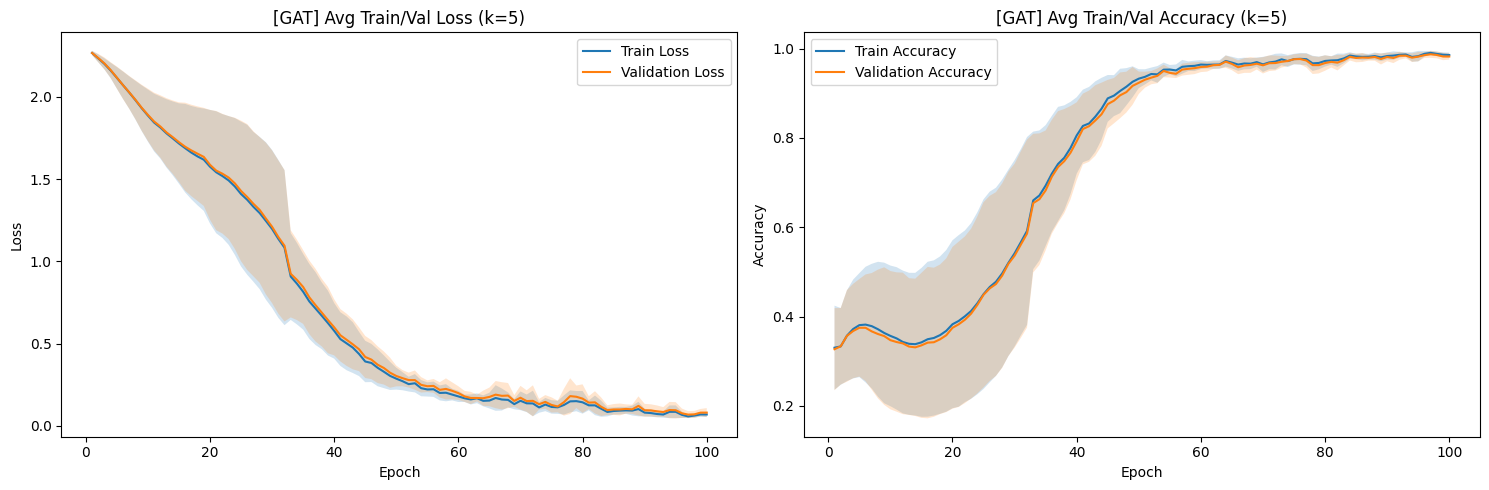

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_5_SAGE
Using existing processed data for k_5_SAGE
Starting k-fold cross-validation for SAGE...

--- Fold 1/10 ---
Epoch 010, Train Loss: 2.2886, Train Acc: 0.1692, Val Loss: 2.2907, Val Acc: 0.1741
Epoch 020, Train Loss: 2.2462, Train Acc: 0.2192, Val Loss: 2.2496, Val Acc: 0.2164
Epoch 030, Train Loss: 2.1549, Train Acc: 0.2786, Val Loss: 2.1597, Val Acc: 0.2786
Epoch 040, Train Loss: 1.9763, Train Acc: 0.5368, Val Loss: 1.9850, Val Acc: 0.5398
Epoch 050, Train Loss: 1.6977, Train Acc: 0.6973, Val Loss: 1.7121, Val Acc: 0.6953
Epoch 060, Train Loss: 1.3665, Train Acc: 0.7807, Val Loss: 1.3854, Val Acc: 0.7699
Epoch 070, Train Loss: 1.0877, Train Acc: 0.8007, Val Loss: 1.1051, Val Acc: 0.7811
Epoch 080, Train Loss: 0.8692, Train Acc: 0.8361, Val Loss: 0.8863, Val Acc: 0.8271


[I 2025-01-26 16:38:04,631] Trial 0 finished with value: 0.6525475978851318 and parameters: {'hidden_channels': 28, 'dropout': 0.3627466442969015, 'lr': 0.0007389119953291373}. Best is trial 0 with value: 0.6525475978851318.


Epoch 090, Train Loss: 0.7410, Train Acc: 0.8625, Val Loss: 0.7597, Val Acc: 0.8507
Epoch 100, Train Loss: 0.6387, Train Acc: 0.8896, Val Loss: 0.6525, Val Acc: 0.8818


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9041, Train Acc: 0.4397, Val Loss: 1.9053, Val Acc: 0.4366
Epoch 020, Train Loss: 1.2886, Train Acc: 0.6368, Val Loss: 1.3032, Val Acc: 0.6294
Epoch 030, Train Loss: 0.8539, Train Acc: 0.7340, Val Loss: 0.8708, Val Acc: 0.7338
Epoch 040, Train Loss: 0.5680, Train Acc: 0.8289, Val Loss: 0.6069, Val Acc: 0.8172
Epoch 050, Train Loss: 0.4366, Train Acc: 0.8511, Val Loss: 0.4801, Val Acc: 0.8284
Epoch 060, Train Loss: 0.3624, Train Acc: 0.8869, Val Loss: 0.4163, Val Acc: 0.8557
Epoch 070, Train Loss: 0.2858, Train Acc: 0.9132, Val Loss: 0.3138, Val Acc: 0.8993
Epoch 080, Train Loss: 0.2276, Train Acc: 0.9186, Val Loss: 0.2418, Val Acc: 0.9030


[I 2025-01-26 16:38:05,766] Trial 1 finished with value: 0.17947915196418762 and parameters: {'hidden_channels': 40, 'dropout': 0.44503616638976606, 'lr': 0.0064748005223634175}. Best is trial 1 with value: 0.17947915196418762.


Epoch 090, Train Loss: 0.2415, Train Acc: 0.9263, Val Loss: 0.2707, Val Acc: 0.9167
Epoch 100, Train Loss: 0.1677, Train Acc: 0.9502, Val Loss: 0.1795, Val Acc: 0.9453


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1232, Train Acc: 0.3008, Val Loss: 2.1309, Val Acc: 0.2960
Epoch 020, Train Loss: 1.6419, Train Acc: 0.5303, Val Loss: 1.6561, Val Acc: 0.5050
Epoch 030, Train Loss: 1.1349, Train Acc: 0.7300, Val Loss: 1.1584, Val Acc: 0.6953
Epoch 040, Train Loss: 0.7339, Train Acc: 0.8252, Val Loss: 0.7673, Val Acc: 0.8035
Epoch 050, Train Loss: 0.5041, Train Acc: 0.8527, Val Loss: 0.5317, Val Acc: 0.8296
Epoch 060, Train Loss: 0.4086, Train Acc: 0.8760, Val Loss: 0.4382, Val Acc: 0.8520
Epoch 070, Train Loss: 0.2883, Train Acc: 0.9197, Val Loss: 0.3144, Val Acc: 0.9017
Epoch 080, Train Loss: 0.2628, Train Acc: 0.9137, Val Loss: 0.2885, Val Acc: 0.8968


[I 2025-01-26 16:38:06,897] Trial 2 finished with value: 0.16348694264888763 and parameters: {'hidden_channels': 40, 'dropout': 0.36173190167959623, 'lr': 0.0035680146885750034}. Best is trial 2 with value: 0.16348694264888763.


Epoch 090, Train Loss: 0.1773, Train Acc: 0.9466, Val Loss: 0.1965, Val Acc: 0.9353
Epoch 100, Train Loss: 0.1431, Train Acc: 0.9585, Val Loss: 0.1635, Val Acc: 0.9440


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3038, Train Acc: 0.1216, Val Loss: 2.3053, Val Acc: 0.1219
Epoch 020, Train Loss: 2.2970, Train Acc: 0.1467, Val Loss: 2.3003, Val Acc: 0.1455
Epoch 030, Train Loss: 2.2519, Train Acc: 0.3094, Val Loss: 2.2559, Val Acc: 0.3085
Epoch 040, Train Loss: 2.1660, Train Acc: 0.3668, Val Loss: 2.1701, Val Acc: 0.3619
Epoch 050, Train Loss: 1.9985, Train Acc: 0.4867, Val Loss: 2.0037, Val Acc: 0.4739
Epoch 060, Train Loss: 1.7397, Train Acc: 0.6228, Val Loss: 1.7497, Val Acc: 0.6132
Epoch 070, Train Loss: 1.4246, Train Acc: 0.7348, Val Loss: 1.4418, Val Acc: 0.7251
Epoch 080, Train Loss: 1.1449, Train Acc: 0.8062, Val Loss: 1.1705, Val Acc: 0.7910


[I 2025-01-26 16:38:08,098] Trial 3 finished with value: 0.8425530791282654 and parameters: {'hidden_channels': 63, 'dropout': 0.3836847610931264, 'lr': 0.0001763982666414392}. Best is trial 2 with value: 0.16348694264888763.


Epoch 090, Train Loss: 0.9412, Train Acc: 0.8381, Val Loss: 0.9762, Val Acc: 0.8097
Epoch 100, Train Loss: 0.8070, Train Acc: 0.8611, Val Loss: 0.8426, Val Acc: 0.8333


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3020, Train Acc: 0.1011, Val Loss: 2.3021, Val Acc: 0.1045
Epoch 020, Train Loss: 2.2791, Train Acc: 0.1072, Val Loss: 2.2796, Val Acc: 0.1070
Epoch 030, Train Loss: 2.2375, Train Acc: 0.1272, Val Loss: 2.2394, Val Acc: 0.1182
Epoch 040, Train Loss: 2.1581, Train Acc: 0.2223, Val Loss: 2.1580, Val Acc: 0.2388
Epoch 050, Train Loss: 2.0224, Train Acc: 0.4769, Val Loss: 2.0285, Val Acc: 0.4627
Epoch 060, Train Loss: 1.8761, Train Acc: 0.5659, Val Loss: 1.8830, Val Acc: 0.5585
Epoch 070, Train Loss: 1.7221, Train Acc: 0.6310, Val Loss: 1.7306, Val Acc: 0.6182
Epoch 080, Train Loss: 1.5619, Train Acc: 0.6788, Val Loss: 1.5739, Val Acc: 0.6629
Epoch 090, Train Loss: 1.4224, Train Acc: 0.7211, Val Loss: 1.4410, Val Acc: 0.6928


[I 2025-01-26 16:38:09,070] Trial 4 finished with value: 1.3298394680023193 and parameters: {'hidden_channels': 17, 'dropout': 0.29924620141672204, 'lr': 0.0003054258567726174}. Best is trial 2 with value: 0.16348694264888763.


Epoch 100, Train Loss: 1.3073, Train Acc: 0.7420, Val Loss: 1.3298, Val Acc: 0.7239
  Fold 1 - Optuna Best Trial Val Loss: 0.1635
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 40, 'dropout': 0.36173190167959623, 'lr': 0.0035680146885750034}
Epoch 010, Train Loss: 2.0983, Train Acc: 0.4971, Val Loss: 2.1005, Val Acc: 0.4913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6362, Train Acc: 0.5780, Val Loss: 1.6504, Val Acc: 0.5721
Epoch 030, Train Loss: 1.0585, Train Acc: 0.7374, Val Loss: 1.0786, Val Acc: 0.7189
Epoch 040, Train Loss: 0.6837, Train Acc: 0.8146, Val Loss: 0.7153, Val Acc: 0.7948
Epoch 050, Train Loss: 0.4431, Train Acc: 0.8751, Val Loss: 0.4717, Val Acc: 0.8582
Epoch 060, Train Loss: 0.3948, Train Acc: 0.8893, Val Loss: 0.4380, Val Acc: 0.8719
Epoch 070, Train Loss: 0.2823, Train Acc: 0.9113, Val Loss: 0.3144, Val Acc: 0.8968
Epoch 080, Train Loss: 0.1902, Train Acc: 0.9451, Val Loss: 0.2162, Val Acc: 0.9266
Epoch 090, Train Loss: 0.1878, Train Acc: 0.9527, Val Loss: 0.2012, Val Acc: 0.9527


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1275, Train Acc: 0.9647, Val Loss: 0.1410, Val Acc: 0.9639
  Fold 1 Test Metrics:
  Accuracy: 0.9565
  Precision: 0.9574
  Recall: 0.9565
  F1: 0.9563

--- Fold 2/10 ---
Epoch 010, Train Loss: 2.3035, Train Acc: 0.1107, Val Loss: 2.3024, Val Acc: 0.1182


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2920, Train Acc: 0.1663, Val Loss: 2.2894, Val Acc: 0.1692
Epoch 030, Train Loss: 2.2599, Train Acc: 0.2321, Val Loss: 2.2561, Val Acc: 0.2264
Epoch 040, Train Loss: 2.2045, Train Acc: 0.3800, Val Loss: 2.2015, Val Acc: 0.3706
Epoch 050, Train Loss: 2.1083, Train Acc: 0.5047, Val Loss: 2.1044, Val Acc: 0.5062
Epoch 060, Train Loss: 1.9410, Train Acc: 0.6472, Val Loss: 1.9382, Val Acc: 0.6567
Epoch 070, Train Loss: 1.7297, Train Acc: 0.7115, Val Loss: 1.7306, Val Acc: 0.7114
Epoch 080, Train Loss: 1.5185, Train Acc: 0.7497, Val Loss: 1.5279, Val Acc: 0.7438
Epoch 090, Train Loss: 1.3425, Train Acc: 0.7648, Val Loss: 1.3546, Val Acc: 0.7624


[I 2025-01-26 16:38:11,358] Trial 0 finished with value: 1.235143780708313 and parameters: {'hidden_channels': 47, 'dropout': 0.3908923892217808, 'lr': 0.00010725850924678054}. Best is trial 0 with value: 1.235143780708313.


Epoch 100, Train Loss: 1.2201, Train Acc: 0.7841, Val Loss: 1.2351, Val Acc: 0.7886
Epoch 010, Train Loss: 2.2945, Train Acc: 0.0995, Val Loss: 2.2960, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2371, Train Acc: 0.2977, Val Loss: 2.2382, Val Acc: 0.2935


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1386, Train Acc: 0.3736, Val Loss: 2.1406, Val Acc: 0.3719
Epoch 040, Train Loss: 1.9784, Train Acc: 0.4757, Val Loss: 1.9806, Val Acc: 0.4664
Epoch 050, Train Loss: 1.7296, Train Acc: 0.6366, Val Loss: 1.7357, Val Acc: 0.6343
Epoch 060, Train Loss: 1.4050, Train Acc: 0.7594, Val Loss: 1.4158, Val Acc: 0.7438
Epoch 070, Train Loss: 1.0932, Train Acc: 0.8034, Val Loss: 1.1138, Val Acc: 0.7935
Epoch 080, Train Loss: 0.8707, Train Acc: 0.8367, Val Loss: 0.8964, Val Acc: 0.8209


[I 2025-01-26 16:38:12,342] Trial 1 finished with value: 0.6342893838882446 and parameters: {'hidden_channels': 23, 'dropout': 0.20463898874492925, 'lr': 0.000729979892673925}. Best is trial 1 with value: 0.6342893838882446.


Epoch 090, Train Loss: 0.7292, Train Acc: 0.8634, Val Loss: 0.7636, Val Acc: 0.8470
Epoch 100, Train Loss: 0.6044, Train Acc: 0.8874, Val Loss: 0.6343, Val Acc: 0.8731


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2994, Train Acc: 0.1022, Val Loss: 2.2988, Val Acc: 0.1057
Epoch 020, Train Loss: 2.2707, Train Acc: 0.1638, Val Loss: 2.2698, Val Acc: 0.1580
Epoch 030, Train Loss: 2.2031, Train Acc: 0.1756, Val Loss: 2.2018, Val Acc: 0.1779
Epoch 040, Train Loss: 2.0911, Train Acc: 0.2927, Val Loss: 2.0912, Val Acc: 0.2948
Epoch 050, Train Loss: 1.9095, Train Acc: 0.5256, Val Loss: 1.9085, Val Acc: 0.5323
Epoch 060, Train Loss: 1.6279, Train Acc: 0.7337, Val Loss: 1.6291, Val Acc: 0.7201
Epoch 070, Train Loss: 1.3353, Train Acc: 0.8000, Val Loss: 1.3397, Val Acc: 0.7960
Epoch 080, Train Loss: 1.0913, Train Acc: 0.8454, Val Loss: 1.1011, Val Acc: 0.8296


[I 2025-01-26 16:38:13,477] Trial 2 finished with value: 0.8354135155677795 and parameters: {'hidden_channels': 41, 'dropout': 0.2954782919904357, 'lr': 0.0002904090868714152}. Best is trial 1 with value: 0.6342893838882446.


Epoch 090, Train Loss: 0.9206, Train Acc: 0.8623, Val Loss: 0.9354, Val Acc: 0.8458
Epoch 100, Train Loss: 0.8154, Train Acc: 0.8700, Val Loss: 0.8354, Val Acc: 0.8545


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3013, Train Acc: 0.1003, Val Loss: 2.3020, Val Acc: 0.0983
Epoch 020, Train Loss: 2.2881, Train Acc: 0.0999, Val Loss: 2.2900, Val Acc: 0.0983
Epoch 030, Train Loss: 2.2520, Train Acc: 0.0999, Val Loss: 2.2557, Val Acc: 0.0983
Epoch 040, Train Loss: 2.1720, Train Acc: 0.2119, Val Loss: 2.1762, Val Acc: 0.2077
Epoch 050, Train Loss: 2.0203, Train Acc: 0.4029, Val Loss: 2.0243, Val Acc: 0.4055
Epoch 060, Train Loss: 1.7751, Train Acc: 0.6556, Val Loss: 1.7786, Val Acc: 0.6468
Epoch 070, Train Loss: 1.4625, Train Acc: 0.7771, Val Loss: 1.4711, Val Acc: 0.7736
Epoch 080, Train Loss: 1.1736, Train Acc: 0.8273, Val Loss: 1.1901, Val Acc: 0.8308


[I 2025-01-26 16:38:14,617] Trial 3 finished with value: 0.8421832323074341 and parameters: {'hidden_channels': 44, 'dropout': 0.2752151380353349, 'lr': 0.00020654632462296105}. Best is trial 1 with value: 0.6342893838882446.


Epoch 090, Train Loss: 0.9659, Train Acc: 0.8525, Val Loss: 0.9892, Val Acc: 0.8582
Epoch 100, Train Loss: 0.8226, Train Acc: 0.8791, Val Loss: 0.8422, Val Acc: 0.8744


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9567, Train Acc: 0.5337, Val Loss: 1.9591, Val Acc: 0.5261
Epoch 020, Train Loss: 1.1702, Train Acc: 0.7056, Val Loss: 1.1993, Val Acc: 0.6853
Epoch 030, Train Loss: 0.7229, Train Acc: 0.7906, Val Loss: 0.7546, Val Acc: 0.7724
Epoch 040, Train Loss: 0.4856, Train Acc: 0.8547, Val Loss: 0.5256, Val Acc: 0.8321
Epoch 050, Train Loss: 0.4951, Train Acc: 0.8647, Val Loss: 0.5709, Val Acc: 0.8259
Epoch 060, Train Loss: 0.2526, Train Acc: 0.9188, Val Loss: 0.3053, Val Acc: 0.8905
Epoch 070, Train Loss: 0.1839, Train Acc: 0.9384, Val Loss: 0.2174, Val Acc: 0.9229
Epoch 080, Train Loss: 0.1180, Train Acc: 0.9743, Val Loss: 0.1359, Val Acc: 0.9652


[I 2025-01-26 16:38:15,756] Trial 4 finished with value: 0.16212449967861176 and parameters: {'hidden_channels': 55, 'dropout': 0.21219668674944012, 'lr': 0.00481019653743101}. Best is trial 4 with value: 0.16212449967861176.


Epoch 090, Train Loss: 0.2574, Train Acc: 0.9491, Val Loss: 0.3818, Val Acc: 0.9266
Early stopping at epoch 97
  Fold 2 - Optuna Best Trial Val Loss: 0.1621
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 55, 'dropout': 0.21219668674944012, 'lr': 0.00481019653743101}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9221, Train Acc: 0.5943, Val Loss: 1.9293, Val Acc: 0.5883
Epoch 020, Train Loss: 1.1386, Train Acc: 0.7306, Val Loss: 1.1518, Val Acc: 0.7177
Epoch 030, Train Loss: 0.6837, Train Acc: 0.8267, Val Loss: 0.7042, Val Acc: 0.8122
Epoch 040, Train Loss: 0.4851, Train Acc: 0.8642, Val Loss: 0.5275, Val Acc: 0.8495
Epoch 050, Train Loss: 0.3016, Train Acc: 0.9089, Val Loss: 0.3482, Val Acc: 0.8955
Epoch 060, Train Loss: 0.1925, Train Acc: 0.9457, Val Loss: 0.2217, Val Acc: 0.9303
Epoch 070, Train Loss: 0.1343, Train Acc: 0.9653, Val Loss: 0.1637, Val Acc: 0.9527
Epoch 080, Train Loss: 0.2057, Train Acc: 0.9345, Val Loss: 0.2528, Val Acc: 0.9142


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0978, Train Acc: 0.9810, Val Loss: 0.1275, Val Acc: 0.9714
Epoch 100, Train Loss: 0.0665, Train Acc: 0.9849, Val Loss: 0.0920, Val Acc: 0.9726
  Fold 2 Test Metrics:
  Accuracy: 0.9726
  Precision: 0.9734
  Recall: 0.9726
  F1: 0.9725

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1885, Train Acc: 0.4279, Val Loss: 2.1978, Val Acc: 0.4104
Epoch 020, Train Loss: 1.9143, Train Acc: 0.5564, Val Loss: 1.9189, Val Acc: 0.5746
Epoch 030, Train Loss: 1.4703, Train Acc: 0.7160, Val Loss: 1.4707, Val Acc: 0.7139
Epoch 040, Train Loss: 1.0297, Train Acc: 0.8180, Val Loss: 1.0392, Val Acc: 0.8022
Epoch 050, Train Loss: 0.6882, Train Acc: 0.8538, Val Loss: 0.6995, Val Acc: 0.8445
Epoch 060, Train Loss: 0.4733, Train Acc: 0.8902, Val Loss: 0.4881, Val Acc: 0.8694
Epoch 070, Train Loss: 0.4036, Train Acc: 0.8956, Val Loss: 0.4289, Val Acc: 0.8881
Epoch 080, Train Loss: 0.4275, Train Acc: 0.8866, Val Loss: 0.4576, Val Acc: 0.8706


[I 2025-01-26 16:38:17,974] Trial 0 finished with value: 0.21160195767879486 and parameters: {'hidden_channels': 32, 'dropout': 0.491058616404977, 'lr': 0.002680759631472349}. Best is trial 0 with value: 0.21160195767879486.


Epoch 090, Train Loss: 0.2710, Train Acc: 0.9263, Val Loss: 0.3028, Val Acc: 0.9179
Epoch 100, Train Loss: 0.1993, Train Acc: 0.9522, Val Loss: 0.2116, Val Acc: 0.9465


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1677, Train Acc: 0.2182, Val Loss: 2.1779, Val Acc: 0.2251
Epoch 020, Train Loss: 1.8705, Train Acc: 0.5335, Val Loss: 1.8888, Val Acc: 0.5124
Epoch 030, Train Loss: 1.4736, Train Acc: 0.6100, Val Loss: 1.4912, Val Acc: 0.6082
Epoch 040, Train Loss: 1.0950, Train Acc: 0.6996, Val Loss: 1.1241, Val Acc: 0.6841
Epoch 050, Train Loss: 0.8310, Train Acc: 0.7605, Val Loss: 0.8553, Val Acc: 0.7475
Epoch 060, Train Loss: 0.6643, Train Acc: 0.7877, Val Loss: 0.6973, Val Acc: 0.7724
Epoch 070, Train Loss: 0.5597, Train Acc: 0.8208, Val Loss: 0.5995, Val Acc: 0.8072
Epoch 080, Train Loss: 0.4400, Train Acc: 0.8714, Val Loss: 0.4760, Val Acc: 0.8383
Epoch 090, Train Loss: 0.3487, Train Acc: 0.9045, Val Loss: 0.3725, Val Acc: 0.8943


[I 2025-01-26 16:38:18,949] Trial 1 finished with value: 0.3419748544692993 and parameters: {'hidden_channels': 16, 'dropout': 0.35564295501339466, 'lr': 0.004962941281418306}. Best is trial 0 with value: 0.21160195767879486.


Epoch 100, Train Loss: 0.3116, Train Acc: 0.9078, Val Loss: 0.3420, Val Acc: 0.8831
Epoch 010, Train Loss: 2.2940, Train Acc: 0.0994, Val Loss: 2.2933, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2654, Train Acc: 0.1058, Val Loss: 2.2642, Val Acc: 0.1057
Epoch 030, Train Loss: 2.2037, Train Acc: 0.2203, Val Loss: 2.2022, Val Acc: 0.2313
Epoch 040, Train Loss: 2.0859, Train Acc: 0.4606, Val Loss: 2.0851, Val Acc: 0.4602
Epoch 050, Train Loss: 1.8619, Train Acc: 0.6539, Val Loss: 1.8643, Val Acc: 0.6542
Epoch 060, Train Loss: 1.5372, Train Acc: 0.7813, Val Loss: 1.5422, Val Acc: 0.7711
Epoch 070, Train Loss: 1.1772, Train Acc: 0.8451, Val Loss: 1.1871, Val Acc: 0.8259
Epoch 080, Train Loss: 0.8649, Train Acc: 0.8818, Val Loss: 0.8766, Val Acc: 0.8831
Epoch 090, Train Loss: 0.6815, Train Acc: 0.9084, Val Loss: 0.6934, Val Acc: 0.8955


[I 2025-01-26 16:38:20,140] Trial 2 finished with value: 0.575166642665863 and parameters: {'hidden_channels': 59, 'dropout': 0.4635956027283709, 'lr': 0.0003388590587762287}. Best is trial 0 with value: 0.21160195767879486.


Epoch 100, Train Loss: 0.5599, Train Acc: 0.9235, Val Loss: 0.5752, Val Acc: 0.9092
Epoch 010, Train Loss: 2.2695, Train Acc: 0.1034, Val Loss: 2.2693, Val Acc: 0.1045


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1658, Train Acc: 0.1375, Val Loss: 2.1656, Val Acc: 0.1318
Epoch 030, Train Loss: 1.9528, Train Acc: 0.5296, Val Loss: 1.9558, Val Acc: 0.5299
Epoch 040, Train Loss: 1.6305, Train Acc: 0.7241, Val Loss: 1.6419, Val Acc: 0.7164
Epoch 050, Train Loss: 1.2121, Train Acc: 0.8253, Val Loss: 1.2242, Val Acc: 0.8122
Epoch 060, Train Loss: 0.8036, Train Acc: 0.8804, Val Loss: 0.8215, Val Acc: 0.8719
Epoch 070, Train Loss: 0.4892, Train Acc: 0.9202, Val Loss: 0.4938, Val Acc: 0.9266
Epoch 080, Train Loss: 0.3531, Train Acc: 0.9386, Val Loss: 0.3612, Val Acc: 0.9341
Epoch 090, Train Loss: 0.2418, Train Acc: 0.9616, Val Loss: 0.2562, Val Acc: 0.9565


[I 2025-01-26 16:38:21,333] Trial 3 finished with value: 0.20770986378192902 and parameters: {'hidden_channels': 61, 'dropout': 0.3189207897107407, 'lr': 0.0008191882751142827}. Best is trial 3 with value: 0.20770986378192902.


Epoch 100, Train Loss: 0.2033, Train Acc: 0.9642, Val Loss: 0.2077, Val Acc: 0.9577
Epoch 010, Train Loss: 2.2868, Train Acc: 0.1087, Val Loss: 2.2862, Val Acc: 0.1020
Epoch 020, Train Loss: 2.2423, Train Acc: 0.2817, Val Loss: 2.2460, Val Acc: 0.2736


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1467, Train Acc: 0.3951, Val Loss: 2.1534, Val Acc: 0.3856
Epoch 040, Train Loss: 1.9820, Train Acc: 0.5007, Val Loss: 1.9898, Val Acc: 0.4925
Epoch 050, Train Loss: 1.7211, Train Acc: 0.6727, Val Loss: 1.7323, Val Acc: 0.6716
Epoch 060, Train Loss: 1.3933, Train Acc: 0.7905, Val Loss: 1.4093, Val Acc: 0.7761
Epoch 070, Train Loss: 1.1287, Train Acc: 0.8138, Val Loss: 1.1473, Val Acc: 0.7998
Epoch 080, Train Loss: 0.9105, Train Acc: 0.8543, Val Loss: 0.9352, Val Acc: 0.8408


[I 2025-01-26 16:38:22,316] Trial 4 finished with value: 0.6930137276649475 and parameters: {'hidden_channels': 23, 'dropout': 0.21876772312090897, 'lr': 0.0007692169862756841}. Best is trial 3 with value: 0.20770986378192902.


Epoch 090, Train Loss: 0.7547, Train Acc: 0.8731, Val Loss: 0.7732, Val Acc: 0.8731
Epoch 100, Train Loss: 0.6646, Train Acc: 0.8907, Val Loss: 0.6930, Val Acc: 0.8756
  Fold 3 - Optuna Best Trial Val Loss: 0.2077
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 61, 'dropout': 0.3189207897107407, 'lr': 0.0008191882751142827}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2579, Train Acc: 0.1818, Val Loss: 2.2586, Val Acc: 0.1915
Epoch 020, Train Loss: 2.1389, Train Acc: 0.2840, Val Loss: 2.1392, Val Acc: 0.2699
Epoch 030, Train Loss: 1.9385, Train Acc: 0.4699, Val Loss: 1.9414, Val Acc: 0.4789
Epoch 040, Train Loss: 1.6426, Train Acc: 0.6636, Val Loss: 1.6511, Val Acc: 0.6443
Epoch 050, Train Loss: 1.2513, Train Acc: 0.8116, Val Loss: 1.2645, Val Acc: 0.7910
Epoch 060, Train Loss: 0.8237, Train Acc: 0.8986, Val Loss: 0.8401, Val Acc: 0.8794
Epoch 070, Train Loss: 0.4948, Train Acc: 0.9345, Val Loss: 0.5130, Val Acc: 0.9241
Epoch 080, Train Loss: 0.3144, Train Acc: 0.9597, Val Loss: 0.3280, Val Acc: 0.9515


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.2338, Train Acc: 0.9572, Val Loss: 0.2521, Val Acc: 0.9465
Epoch 100, Train Loss: 0.1728, Train Acc: 0.9760, Val Loss: 0.1826, Val Acc: 0.9726
  Fold 3 Test Metrics:
  Accuracy: 0.9689
  Precision: 0.9712
  Recall: 0.9689
  F1: 0.9693

--- Fold 4/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0881, Train Acc: 0.4296, Val Loss: 2.1099, Val Acc: 0.4502
Epoch 020, Train Loss: 1.5903, Train Acc: 0.5898, Val Loss: 1.6253, Val Acc: 0.5796
Epoch 030, Train Loss: 1.0682, Train Acc: 0.6951, Val Loss: 1.1051, Val Acc: 0.6754
Epoch 040, Train Loss: 0.7129, Train Acc: 0.7942, Val Loss: 0.7437, Val Acc: 0.7761
Epoch 050, Train Loss: 0.5324, Train Acc: 0.8323, Val Loss: 0.5477, Val Acc: 0.8358
Epoch 060, Train Loss: 0.4223, Train Acc: 0.8555, Val Loss: 0.4552, Val Acc: 0.8433
Epoch 070, Train Loss: 0.3734, Train Acc: 0.8781, Val Loss: 0.4056, Val Acc: 0.8669
Epoch 080, Train Loss: 0.4615, Train Acc: 0.8513, Val Loss: 0.4719, Val Acc: 0.8507
Epoch 090, Train Loss: 0.3200, Train Acc: 0.9012, Val Loss: 0.3800, Val Acc: 0.8893


[I 2025-01-26 16:38:24,509] Trial 0 finished with value: 0.2402968853712082 and parameters: {'hidden_channels': 22, 'dropout': 0.264534610334597, 'lr': 0.005890955740126036}. Best is trial 0 with value: 0.2402968853712082.


Epoch 100, Train Loss: 0.2046, Train Acc: 0.9410, Val Loss: 0.2403, Val Acc: 0.9241
Epoch 010, Train Loss: 2.2692, Train Acc: 0.1405, Val Loss: 2.2704, Val Acc: 0.1331


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1350, Train Acc: 0.3361, Val Loss: 2.1429, Val Acc: 0.3296
Epoch 030, Train Loss: 1.8954, Train Acc: 0.5023, Val Loss: 1.9062, Val Acc: 0.5025
Epoch 040, Train Loss: 1.5971, Train Acc: 0.6488, Val Loss: 1.6171, Val Acc: 0.6580
Epoch 050, Train Loss: 1.2284, Train Acc: 0.7953, Val Loss: 1.2545, Val Acc: 0.7761
Epoch 060, Train Loss: 0.9174, Train Acc: 0.8429, Val Loss: 0.9572, Val Acc: 0.8097
Epoch 070, Train Loss: 0.6731, Train Acc: 0.8781, Val Loss: 0.7208, Val Acc: 0.8470
Epoch 080, Train Loss: 0.5617, Train Acc: 0.8751, Val Loss: 0.6088, Val Acc: 0.8570
Epoch 090, Train Loss: 0.4372, Train Acc: 0.8997, Val Loss: 0.4717, Val Acc: 0.8769


[I 2025-01-26 16:38:25,519] Trial 1 finished with value: 0.3981795012950897 and parameters: {'hidden_channels': 29, 'dropout': 0.39637988074693753, 'lr': 0.0014917318571308572}. Best is trial 0 with value: 0.2402968853712082.


Epoch 100, Train Loss: 0.3597, Train Acc: 0.9362, Val Loss: 0.3982, Val Acc: 0.9192
Epoch 010, Train Loss: 1.9230, Train Acc: 0.4652, Val Loss: 1.9319, Val Acc: 0.4714


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.1467, Train Acc: 0.6628, Val Loss: 1.1555, Val Acc: 0.6567
Epoch 030, Train Loss: 0.7840, Train Acc: 0.7480, Val Loss: 0.8142, Val Acc: 0.7425
Epoch 040, Train Loss: 0.5541, Train Acc: 0.8227, Val Loss: 0.5677, Val Acc: 0.8209
Epoch 050, Train Loss: 0.5088, Train Acc: 0.8326, Val Loss: 0.5217, Val Acc: 0.8172
Epoch 060, Train Loss: 0.3430, Train Acc: 0.8866, Val Loss: 0.3566, Val Acc: 0.8818
Epoch 070, Train Loss: 0.2529, Train Acc: 0.9171, Val Loss: 0.2652, Val Acc: 0.9067
Epoch 080, Train Loss: 0.3253, Train Acc: 0.9081, Val Loss: 0.3156, Val Acc: 0.9080
Epoch 090, Train Loss: 0.2545, Train Acc: 0.9225, Val Loss: 0.2537, Val Acc: 0.9266


[I 2025-01-26 16:38:26,546] Trial 2 finished with value: 0.17864637076854706 and parameters: {'hidden_channels': 32, 'dropout': 0.4468797817368042, 'lr': 0.009506492931447522}. Best is trial 2 with value: 0.17864637076854706.


Epoch 100, Train Loss: 0.1722, Train Acc: 0.9470, Val Loss: 0.1786, Val Acc: 0.9415
Epoch 010, Train Loss: 2.2966, Train Acc: 0.1125, Val Loss: 2.2961, Val Acc: 0.1095


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2699, Train Acc: 0.2790, Val Loss: 2.2699, Val Acc: 0.2836
Epoch 030, Train Loss: 2.2138, Train Acc: 0.3361, Val Loss: 2.2166, Val Acc: 0.3383
Epoch 040, Train Loss: 2.1234, Train Acc: 0.4148, Val Loss: 2.1300, Val Acc: 0.4005
Epoch 050, Train Loss: 1.9610, Train Acc: 0.5834, Val Loss: 1.9727, Val Acc: 0.5647
Epoch 060, Train Loss: 1.7020, Train Acc: 0.7234, Val Loss: 1.7216, Val Acc: 0.7152
Epoch 070, Train Loss: 1.4030, Train Acc: 0.8135, Val Loss: 1.4318, Val Acc: 0.7836
Epoch 080, Train Loss: 1.1116, Train Acc: 0.8561, Val Loss: 1.1501, Val Acc: 0.8333
Epoch 090, Train Loss: 0.9132, Train Acc: 0.8796, Val Loss: 0.9581, Val Acc: 0.8557


[I 2025-01-26 16:38:27,717] Trial 3 finished with value: 0.8281749486923218 and parameters: {'hidden_channels': 56, 'dropout': 0.40503098672941384, 'lr': 0.00017756459836836897}. Best is trial 2 with value: 0.17864637076854706.


Epoch 100, Train Loss: 0.7819, Train Acc: 0.8902, Val Loss: 0.8282, Val Acc: 0.8818
Epoch 010, Train Loss: 2.3027, Train Acc: 0.1629, Val Loss: 2.3031, Val Acc: 0.1729


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2842, Train Acc: 0.2245, Val Loss: 2.2846, Val Acc: 0.2239
Epoch 030, Train Loss: 2.2256, Train Acc: 0.2607, Val Loss: 2.2272, Val Acc: 0.2475
Epoch 040, Train Loss: 2.1037, Train Acc: 0.3515, Val Loss: 2.1082, Val Acc: 0.3420
Epoch 050, Train Loss: 1.8881, Train Acc: 0.5335, Val Loss: 1.8975, Val Acc: 0.5211
Epoch 060, Train Loss: 1.5624, Train Acc: 0.7060, Val Loss: 1.5797, Val Acc: 0.6965
Epoch 070, Train Loss: 1.1921, Train Acc: 0.8252, Val Loss: 1.2156, Val Acc: 0.8134
Epoch 080, Train Loss: 0.9004, Train Acc: 0.8771, Val Loss: 0.9339, Val Acc: 0.8557
Epoch 090, Train Loss: 0.7071, Train Acc: 0.9009, Val Loss: 0.7436, Val Acc: 0.8806


[I 2025-01-26 16:38:28,855] Trial 4 finished with value: 0.630009114742279 and parameters: {'hidden_channels': 44, 'dropout': 0.26149718403045547, 'lr': 0.0003316455519977689}. Best is trial 2 with value: 0.17864637076854706.


Epoch 100, Train Loss: 0.5936, Train Acc: 0.9176, Val Loss: 0.6300, Val Acc: 0.9067
  Fold 4 - Optuna Best Trial Val Loss: 0.1786
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 32, 'dropout': 0.4468797817368042, 'lr': 0.009506492931447522}
Epoch 010, Train Loss: 1.8709, Train Acc: 0.4425, Val Loss: 1.8801, Val Acc: 0.4291


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.1503, Train Acc: 0.6642, Val Loss: 1.1550, Val Acc: 0.6716
Epoch 030, Train Loss: 0.7624, Train Acc: 0.7592, Val Loss: 0.7797, Val Acc: 0.7500
Epoch 040, Train Loss: 0.5410, Train Acc: 0.8312, Val Loss: 0.5830, Val Acc: 0.7998
Epoch 050, Train Loss: 0.4582, Train Acc: 0.8449, Val Loss: 0.5250, Val Acc: 0.8346
Epoch 060, Train Loss: 0.3560, Train Acc: 0.8874, Val Loss: 0.3513, Val Acc: 0.8881
Epoch 070, Train Loss: 0.3084, Train Acc: 0.9025, Val Loss: 0.3213, Val Acc: 0.8955
Epoch 080, Train Loss: 0.2433, Train Acc: 0.9230, Val Loss: 0.2564, Val Acc: 0.9104
Epoch 090, Train Loss: 0.2291, Train Acc: 0.9253, Val Loss: 0.2699, Val Acc: 0.9042


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.2047, Train Acc: 0.9348, Val Loss: 0.2240, Val Acc: 0.9229
  Fold 4 Test Metrics:
  Accuracy: 0.9291
  Precision: 0.9312
  Recall: 0.9291
  F1: 0.9276

--- Fold 5/10 ---
Epoch 010, Train Loss: 2.2939, Train Acc: 0.2252, Val Loss: 2.2939, Val Acc: 0.2201


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2725, Train Acc: 0.2100, Val Loss: 2.2746, Val Acc: 0.2065
Epoch 030, Train Loss: 2.2261, Train Acc: 0.2161, Val Loss: 2.2279, Val Acc: 0.2090
Epoch 040, Train Loss: 2.1324, Train Acc: 0.3626, Val Loss: 2.1346, Val Acc: 0.3570
Epoch 050, Train Loss: 1.9633, Train Acc: 0.5506, Val Loss: 1.9711, Val Acc: 0.5672
Epoch 060, Train Loss: 1.6879, Train Acc: 0.7183, Val Loss: 1.6970, Val Acc: 0.7226
Epoch 070, Train Loss: 1.4009, Train Acc: 0.7965, Val Loss: 1.4125, Val Acc: 0.8010
Epoch 080, Train Loss: 1.1291, Train Acc: 0.8454, Val Loss: 1.1370, Val Acc: 0.8458
Epoch 090, Train Loss: 0.9382, Train Acc: 0.8754, Val Loss: 0.9511, Val Acc: 0.8794


[I 2025-01-26 16:38:31,011] Trial 0 finished with value: 0.819635272026062 and parameters: {'hidden_channels': 37, 'dropout': 0.2810159130186115, 'lr': 0.0003087795359714973}. Best is trial 0 with value: 0.819635272026062.


Epoch 100, Train Loss: 0.8031, Train Acc: 0.8949, Val Loss: 0.8196, Val Acc: 0.9042
Epoch 010, Train Loss: 2.1941, Train Acc: 0.3108, Val Loss: 2.1961, Val Acc: 0.2836


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9335, Train Acc: 0.5821, Val Loss: 1.9434, Val Acc: 0.5771
Epoch 030, Train Loss: 1.5257, Train Acc: 0.7160, Val Loss: 1.5469, Val Acc: 0.7127
Epoch 040, Train Loss: 1.0498, Train Acc: 0.8174, Val Loss: 1.0865, Val Acc: 0.8122
Epoch 050, Train Loss: 0.6256, Train Acc: 0.8661, Val Loss: 0.6556, Val Acc: 0.8657
Epoch 060, Train Loss: 0.3908, Train Acc: 0.9115, Val Loss: 0.3954, Val Acc: 0.9192
Epoch 070, Train Loss: 0.2391, Train Acc: 0.9519, Val Loss: 0.2576, Val Acc: 0.9440
Epoch 080, Train Loss: 0.1982, Train Acc: 0.9540, Val Loss: 0.2039, Val Acc: 0.9627
Epoch 090, Train Loss: 0.1466, Train Acc: 0.9585, Val Loss: 0.1579, Val Acc: 0.9577


[I 2025-01-26 16:38:32,213] Trial 1 finished with value: 0.1293225884437561 and parameters: {'hidden_channels': 63, 'dropout': 0.45636828962223874, 'lr': 0.0016232430445542359}. Best is trial 1 with value: 0.1293225884437561.


Epoch 100, Train Loss: 0.1177, Train Acc: 0.9796, Val Loss: 0.1293, Val Acc: 0.9801
Epoch 010, Train Loss: 2.3092, Train Acc: 0.0994, Val Loss: 2.3091, Val Acc: 0.0995


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3072, Train Acc: 0.1078, Val Loss: 2.3046, Val Acc: 0.1107
Epoch 030, Train Loss: 2.2935, Train Acc: 0.1154, Val Loss: 2.2877, Val Acc: 0.1256
Epoch 040, Train Loss: 2.2515, Train Acc: 0.1202, Val Loss: 2.2442, Val Acc: 0.1294
Epoch 050, Train Loss: 2.1625, Train Acc: 0.2122, Val Loss: 2.1560, Val Acc: 0.2139
Epoch 060, Train Loss: 1.9971, Train Acc: 0.4374, Val Loss: 1.9930, Val Acc: 0.4453
Epoch 070, Train Loss: 1.7717, Train Acc: 0.6183, Val Loss: 1.7785, Val Acc: 0.6157
Epoch 080, Train Loss: 1.5271, Train Acc: 0.7035, Val Loss: 1.5367, Val Acc: 0.6953
Epoch 090, Train Loss: 1.3427, Train Acc: 0.7398, Val Loss: 1.3554, Val Acc: 0.7413


[I 2025-01-26 16:38:33,357] Trial 2 finished with value: 1.2410401105880737 and parameters: {'hidden_channels': 45, 'dropout': 0.4278832746775675, 'lr': 0.0001173180565626856}. Best is trial 1 with value: 0.1293225884437561.


Epoch 100, Train Loss: 1.2266, Train Acc: 0.7612, Val Loss: 1.2410, Val Acc: 0.7624
Epoch 010, Train Loss: 2.2890, Train Acc: 0.1414, Val Loss: 2.2887, Val Acc: 0.1480


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2439, Train Acc: 0.2151, Val Loss: 2.2432, Val Acc: 0.2214
Epoch 030, Train Loss: 2.1654, Train Acc: 0.3140, Val Loss: 2.1664, Val Acc: 0.2948
Epoch 040, Train Loss: 2.0231, Train Acc: 0.5205, Val Loss: 2.0294, Val Acc: 0.5211
Epoch 050, Train Loss: 1.7659, Train Acc: 0.7060, Val Loss: 1.7811, Val Acc: 0.7077
Epoch 060, Train Loss: 1.4195, Train Acc: 0.8219, Val Loss: 1.4393, Val Acc: 0.8333
Epoch 070, Train Loss: 1.0654, Train Acc: 0.8611, Val Loss: 1.0829, Val Acc: 0.8769
Epoch 080, Train Loss: 0.7832, Train Acc: 0.8889, Val Loss: 0.8020, Val Acc: 0.9005
Epoch 090, Train Loss: 0.6009, Train Acc: 0.9042, Val Loss: 0.6119, Val Acc: 0.9142


[I 2025-01-26 16:38:34,524] Trial 3 finished with value: 0.5058407187461853 and parameters: {'hidden_channels': 52, 'dropout': 0.4944578362896754, 'lr': 0.0004472559034240099}. Best is trial 1 with value: 0.1293225884437561.


Epoch 100, Train Loss: 0.4810, Train Acc: 0.9314, Val Loss: 0.5058, Val Acc: 0.9341
Epoch 010, Train Loss: 2.3057, Train Acc: 0.1635, Val Loss: 2.3069, Val Acc: 0.1468
Epoch 020, Train Loss: 2.2967, Train Acc: 0.1078, Val Loss: 2.3014, Val Acc: 0.1057


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.2464, Train Acc: 0.0991, Val Loss: 2.2533, Val Acc: 0.1032
Epoch 040, Train Loss: 2.1226, Train Acc: 0.1781, Val Loss: 2.1339, Val Acc: 0.1667
Epoch 050, Train Loss: 1.9395, Train Acc: 0.4175, Val Loss: 1.9527, Val Acc: 0.4080
Epoch 060, Train Loss: 1.7090, Train Acc: 0.6167, Val Loss: 1.7291, Val Acc: 0.5933
Epoch 070, Train Loss: 1.4898, Train Acc: 0.7368, Val Loss: 1.5100, Val Acc: 0.7338
Epoch 080, Train Loss: 1.2980, Train Acc: 0.7633, Val Loss: 1.3363, Val Acc: 0.7413


[I 2025-01-26 16:38:35,487] Trial 4 finished with value: 1.0647722482681274 and parameters: {'hidden_channels': 17, 'dropout': 0.4138421154245966, 'lr': 0.0006735967381429217}. Best is trial 1 with value: 0.1293225884437561.


Epoch 090, Train Loss: 1.1472, Train Acc: 0.8168, Val Loss: 1.1820, Val Acc: 0.7985
Epoch 100, Train Loss: 1.0310, Train Acc: 0.8541, Val Loss: 1.0648, Val Acc: 0.8532
  Fold 5 - Optuna Best Trial Val Loss: 0.1293
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 63, 'dropout': 0.45636828962223874, 'lr': 0.0016232430445542359}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2177, Train Acc: 0.1840, Val Loss: 2.2211, Val Acc: 0.1704
Epoch 020, Train Loss: 1.9747, Train Acc: 0.3245, Val Loss: 1.9893, Val Acc: 0.2848
Epoch 030, Train Loss: 1.6347, Train Acc: 0.5066, Val Loss: 1.6640, Val Acc: 0.4776
Epoch 040, Train Loss: 1.1378, Train Acc: 0.6956, Val Loss: 1.1802, Val Acc: 0.6667
Epoch 050, Train Loss: 0.6539, Train Acc: 0.8673, Val Loss: 0.7019, Val Acc: 0.8545
Epoch 060, Train Loss: 0.4151, Train Acc: 0.9098, Val Loss: 0.4457, Val Acc: 0.9080
Epoch 070, Train Loss: 0.2917, Train Acc: 0.9219, Val Loss: 0.3206, Val Acc: 0.9167
Epoch 080, Train Loss: 0.2235, Train Acc: 0.9384, Val Loss: 0.2535, Val Acc: 0.9316


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1665, Train Acc: 0.9577, Val Loss: 0.1737, Val Acc: 0.9614
Epoch 100, Train Loss: 0.2217, Train Acc: 0.9474, Val Loss: 0.2398, Val Acc: 0.9428
  Fold 5 Test Metrics:
  Accuracy: 0.9353
  Precision: 0.9443
  Recall: 0.9353
  F1: 0.9331

--- Fold 6/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2584, Train Acc: 0.1229, Val Loss: 2.2588, Val Acc: 0.1157
Epoch 020, Train Loss: 2.1556, Train Acc: 0.2640, Val Loss: 2.1567, Val Acc: 0.2575
Epoch 030, Train Loss: 1.9703, Train Acc: 0.4589, Val Loss: 1.9664, Val Acc: 0.4328
Epoch 040, Train Loss: 1.6779, Train Acc: 0.6242, Val Loss: 1.6822, Val Acc: 0.6095
Epoch 050, Train Loss: 1.2924, Train Acc: 0.7825, Val Loss: 1.2973, Val Acc: 0.7699
Epoch 060, Train Loss: 0.9162, Train Acc: 0.8751, Val Loss: 0.9250, Val Acc: 0.8719
Epoch 070, Train Loss: 0.6144, Train Acc: 0.9188, Val Loss: 0.6484, Val Acc: 0.9042
Epoch 080, Train Loss: 0.4552, Train Acc: 0.9362, Val Loss: 0.4645, Val Acc: 0.9241


[I 2025-01-26 16:38:37,829] Trial 0 finished with value: 0.2872093617916107 and parameters: {'hidden_channels': 39, 'dropout': 0.21742982563331467, 'lr': 0.0009543661021051522}. Best is trial 0 with value: 0.2872093617916107.


Epoch 090, Train Loss: 0.3602, Train Acc: 0.9387, Val Loss: 0.3947, Val Acc: 0.9129
Epoch 100, Train Loss: 0.2675, Train Acc: 0.9557, Val Loss: 0.2872, Val Acc: 0.9428


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2460, Train Acc: 0.1101, Val Loss: 2.2517, Val Acc: 0.1057
Epoch 020, Train Loss: 2.1010, Train Acc: 0.3190, Val Loss: 2.1064, Val Acc: 0.3109
Epoch 030, Train Loss: 1.8347, Train Acc: 0.5525, Val Loss: 1.8354, Val Acc: 0.5535
Epoch 040, Train Loss: 1.4184, Train Acc: 0.7294, Val Loss: 1.4172, Val Acc: 0.7450
Epoch 050, Train Loss: 1.0092, Train Acc: 0.8154, Val Loss: 1.0029, Val Acc: 0.8234
Epoch 060, Train Loss: 0.6999, Train Acc: 0.8630, Val Loss: 0.7154, Val Acc: 0.8557
Epoch 070, Train Loss: 0.4919, Train Acc: 0.8989, Val Loss: 0.5018, Val Acc: 0.8881
Epoch 080, Train Loss: 0.3784, Train Acc: 0.9106, Val Loss: 0.4243, Val Acc: 0.8930


[I 2025-01-26 16:38:38,941] Trial 1 finished with value: 0.24725444614887238 and parameters: {'hidden_channels': 36, 'dropout': 0.30008388072936815, 'lr': 0.0016097659175482429}. Best is trial 1 with value: 0.24725444614887238.


Epoch 090, Train Loss: 0.2645, Train Acc: 0.9480, Val Loss: 0.2908, Val Acc: 0.9341
Epoch 100, Train Loss: 0.2430, Train Acc: 0.9396, Val Loss: 0.2473, Val Acc: 0.9303


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3132, Train Acc: 0.0997, Val Loss: 2.3130, Val Acc: 0.0995
Epoch 020, Train Loss: 2.3099, Train Acc: 0.1145, Val Loss: 2.3106, Val Acc: 0.1182
Epoch 030, Train Loss: 2.2925, Train Acc: 0.1196, Val Loss: 2.2918, Val Acc: 0.1244
Epoch 040, Train Loss: 2.2503, Train Acc: 0.1843, Val Loss: 2.2485, Val Acc: 0.2002
Epoch 050, Train Loss: 2.1814, Train Acc: 0.2167, Val Loss: 2.1815, Val Acc: 0.2139
Epoch 060, Train Loss: 2.0742, Train Acc: 0.2797, Val Loss: 2.0786, Val Acc: 0.2637
Epoch 070, Train Loss: 1.9112, Train Acc: 0.4371, Val Loss: 1.9172, Val Acc: 0.4117
Epoch 080, Train Loss: 1.7504, Train Acc: 0.5295, Val Loss: 1.7573, Val Acc: 0.5224
Epoch 090, Train Loss: 1.6189, Train Acc: 0.5646, Val Loss: 1.6280, Val Acc: 0.5535


[I 2025-01-26 16:38:39,914] Trial 2 finished with value: 1.551834225654602 and parameters: {'hidden_channels': 19, 'dropout': 0.28346864673418704, 'lr': 0.00016159317272289908}. Best is trial 1 with value: 0.24725444614887238.


Epoch 100, Train Loss: 1.5407, Train Acc: 0.6214, Val Loss: 1.5518, Val Acc: 0.6032
Epoch 010, Train Loss: 2.3032, Train Acc: 0.1017, Val Loss: 2.3031, Val Acc: 0.1007


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2887, Train Acc: 0.1213, Val Loss: 2.2899, Val Acc: 0.1157
Epoch 030, Train Loss: 2.2572, Train Acc: 0.1635, Val Loss: 2.2595, Val Acc: 0.1617
Epoch 040, Train Loss: 2.1752, Train Acc: 0.2864, Val Loss: 2.1799, Val Acc: 0.2649
Epoch 050, Train Loss: 2.0206, Train Acc: 0.5464, Val Loss: 2.0263, Val Acc: 0.5336
Epoch 060, Train Loss: 1.8126, Train Acc: 0.6776, Val Loss: 1.8173, Val Acc: 0.6704
Epoch 070, Train Loss: 1.5723, Train Acc: 0.7455, Val Loss: 1.5821, Val Acc: 0.7301
Epoch 080, Train Loss: 1.3510, Train Acc: 0.7976, Val Loss: 1.3690, Val Acc: 0.7898
Epoch 090, Train Loss: 1.1816, Train Acc: 0.8250, Val Loss: 1.2073, Val Acc: 0.8022


[I 2025-01-26 16:38:40,943] Trial 3 finished with value: 1.0962251424789429 and parameters: {'hidden_channels': 31, 'dropout': 0.2281446948115888, 'lr': 0.00021547515746897446}. Best is trial 1 with value: 0.24725444614887238.


Epoch 100, Train Loss: 1.0708, Train Acc: 0.8417, Val Loss: 1.0962, Val Acc: 0.8172
Epoch 010, Train Loss: 2.2268, Train Acc: 0.2279, Val Loss: 2.2219, Val Acc: 0.2289
Epoch 020, Train Loss: 1.8674, Train Acc: 0.4173, Val Loss: 1.8596, Val Acc: 0.4366


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.4001, Train Acc: 0.5587, Val Loss: 1.4136, Val Acc: 0.5547
Epoch 040, Train Loss: 1.0200, Train Acc: 0.6699, Val Loss: 1.0316, Val Acc: 0.6381
Epoch 050, Train Loss: 0.8857, Train Acc: 0.7004, Val Loss: 0.9209, Val Acc: 0.6779
Epoch 060, Train Loss: 0.8054, Train Acc: 0.7317, Val Loss: 0.8446, Val Acc: 0.6978
Epoch 070, Train Loss: 0.6219, Train Acc: 0.8197, Val Loss: 0.6507, Val Acc: 0.8060
Epoch 080, Train Loss: 0.4793, Train Acc: 0.8507, Val Loss: 0.5117, Val Acc: 0.8333


[I 2025-01-26 16:38:41,920] Trial 4 finished with value: 0.3865833282470703 and parameters: {'hidden_channels': 18, 'dropout': 0.41812161805192094, 'lr': 0.00744905729428644}. Best is trial 1 with value: 0.24725444614887238.


Epoch 090, Train Loss: 0.3954, Train Acc: 0.8746, Val Loss: 0.4387, Val Acc: 0.8657
Epoch 100, Train Loss: 0.3544, Train Acc: 0.8902, Val Loss: 0.3866, Val Acc: 0.8781
  Fold 6 - Optuna Best Trial Val Loss: 0.2473
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 36, 'dropout': 0.30008388072936815, 'lr': 0.0016097659175482429}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2500, Train Acc: 0.1190, Val Loss: 2.2547, Val Acc: 0.1107
Epoch 020, Train Loss: 2.0757, Train Acc: 0.3186, Val Loss: 2.0831, Val Acc: 0.3047
Epoch 030, Train Loss: 1.7607, Train Acc: 0.5670, Val Loss: 1.7687, Val Acc: 0.5622
Epoch 040, Train Loss: 1.3626, Train Acc: 0.7306, Val Loss: 1.3700, Val Acc: 0.7338
Epoch 050, Train Loss: 0.9521, Train Acc: 0.8272, Val Loss: 0.9655, Val Acc: 0.8147
Epoch 060, Train Loss: 0.6632, Train Acc: 0.8812, Val Loss: 0.6815, Val Acc: 0.8731
Epoch 070, Train Loss: 0.4655, Train Acc: 0.9104, Val Loss: 0.4898, Val Acc: 0.8943
Epoch 080, Train Loss: 0.3573, Train Acc: 0.9312, Val Loss: 0.3778, Val Acc: 0.9192


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.3539, Train Acc: 0.9288, Val Loss: 0.3809, Val Acc: 0.9080
Epoch 100, Train Loss: 0.2420, Train Acc: 0.9526, Val Loss: 0.2517, Val Acc: 0.9453
  Fold 6 Test Metrics:
  Accuracy: 0.9478
  Precision: 0.9499
  Recall: 0.9478
  F1: 0.9476

--- Fold 7/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2620, Train Acc: 0.2249, Val Loss: 2.2621, Val Acc: 0.2528
Epoch 020, Train Loss: 2.1385, Train Acc: 0.4145, Val Loss: 2.1351, Val Acc: 0.4371
Epoch 030, Train Loss: 1.9361, Train Acc: 0.5316, Val Loss: 1.9276, Val Acc: 0.5517
Epoch 040, Train Loss: 1.5671, Train Acc: 0.7160, Val Loss: 1.5626, Val Acc: 0.6936
Epoch 050, Train Loss: 1.1832, Train Acc: 0.8120, Val Loss: 1.1809, Val Acc: 0.8144
Epoch 060, Train Loss: 0.8785, Train Acc: 0.8446, Val Loss: 0.8884, Val Acc: 0.8456
Epoch 070, Train Loss: 0.7049, Train Acc: 0.8485, Val Loss: 0.7122, Val Acc: 0.8493
Epoch 080, Train Loss: 0.5597, Train Acc: 0.8737, Val Loss: 0.5737, Val Acc: 0.8643


[I 2025-01-26 16:38:44,037] Trial 0 finished with value: 0.42422667145729065 and parameters: {'hidden_channels': 19, 'dropout': 0.36865250942470396, 'lr': 0.002327556944342893}. Best is trial 0 with value: 0.42422667145729065.


Epoch 090, Train Loss: 0.5307, Train Acc: 0.8680, Val Loss: 0.5542, Val Acc: 0.8593
Epoch 100, Train Loss: 0.4025, Train Acc: 0.9103, Val Loss: 0.4242, Val Acc: 0.9029


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3072, Train Acc: 0.1100, Val Loss: 2.3047, Val Acc: 0.1108
Epoch 020, Train Loss: 2.3053, Train Acc: 0.1022, Val Loss: 2.3009, Val Acc: 0.1059
Epoch 030, Train Loss: 2.2821, Train Acc: 0.1031, Val Loss: 2.2754, Val Acc: 0.1071
Epoch 040, Train Loss: 2.2253, Train Acc: 0.1156, Val Loss: 2.2181, Val Acc: 0.1121
Epoch 050, Train Loss: 2.1240, Train Acc: 0.2591, Val Loss: 2.1167, Val Acc: 0.2677
Epoch 060, Train Loss: 1.9571, Train Acc: 0.4779, Val Loss: 1.9487, Val Acc: 0.5006
Epoch 070, Train Loss: 1.7285, Train Acc: 0.6219, Val Loss: 1.7181, Val Acc: 0.6389
Epoch 080, Train Loss: 1.5089, Train Acc: 0.6798, Val Loss: 1.5042, Val Acc: 0.6874


[I 2025-01-26 16:38:45,160] Trial 1 finished with value: 1.2373218536376953 and parameters: {'hidden_channels': 36, 'dropout': 0.4707354829504595, 'lr': 0.00017732012791766384}. Best is trial 0 with value: 0.42422667145729065.


Epoch 090, Train Loss: 1.3356, Train Acc: 0.7281, Val Loss: 1.3346, Val Acc: 0.7385
Epoch 100, Train Loss: 1.2303, Train Acc: 0.7611, Val Loss: 1.2373, Val Acc: 0.7621


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2864, Train Acc: 0.1198, Val Loss: 2.2887, Val Acc: 0.1183
Epoch 020, Train Loss: 2.2512, Train Acc: 0.1918, Val Loss: 2.2546, Val Acc: 0.1918
Epoch 030, Train Loss: 2.1778, Train Acc: 0.1691, Val Loss: 2.1836, Val Acc: 0.1719
Epoch 040, Train Loss: 2.0115, Train Acc: 0.2250, Val Loss: 2.0209, Val Acc: 0.2291
Epoch 050, Train Loss: 1.7245, Train Acc: 0.4653, Val Loss: 1.7326, Val Acc: 0.4608
Epoch 060, Train Loss: 1.2949, Train Acc: 0.7453, Val Loss: 1.3055, Val Acc: 0.7210
Epoch 070, Train Loss: 0.8751, Train Acc: 0.8586, Val Loss: 0.8945, Val Acc: 0.8369
Epoch 080, Train Loss: 0.6345, Train Acc: 0.9079, Val Loss: 0.6527, Val Acc: 0.8966


[I 2025-01-26 16:38:46,358] Trial 2 finished with value: 0.4013945162296295 and parameters: {'hidden_channels': 62, 'dropout': 0.479397085478124, 'lr': 0.0004662174765319386}. Best is trial 2 with value: 0.4013945162296295.


Epoch 090, Train Loss: 0.4646, Train Acc: 0.9216, Val Loss: 0.4841, Val Acc: 0.9116
Epoch 100, Train Loss: 0.3754, Train Acc: 0.9400, Val Loss: 0.4014, Val Acc: 0.9290


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2148, Train Acc: 0.3446, Val Loss: 2.2113, Val Acc: 0.3599
Epoch 020, Train Loss: 2.0179, Train Acc: 0.4677, Val Loss: 2.0131, Val Acc: 0.4458
Epoch 030, Train Loss: 1.6803, Train Acc: 0.6275, Val Loss: 1.6776, Val Acc: 0.6164
Epoch 040, Train Loss: 1.2328, Train Acc: 0.7891, Val Loss: 1.2380, Val Acc: 0.7671
Epoch 050, Train Loss: 0.7594, Train Acc: 0.8740, Val Loss: 0.7762, Val Acc: 0.8593
Epoch 060, Train Loss: 0.4743, Train Acc: 0.9086, Val Loss: 0.4985, Val Acc: 0.8854
Epoch 070, Train Loss: 0.3325, Train Acc: 0.9216, Val Loss: 0.3491, Val Acc: 0.9041
Epoch 080, Train Loss: 0.2952, Train Acc: 0.9313, Val Loss: 0.2976, Val Acc: 0.9365


[I 2025-01-26 16:38:47,515] Trial 3 finished with value: 0.18223263323307037 and parameters: {'hidden_channels': 48, 'dropout': 0.41097348363059855, 'lr': 0.0016470217360291294}. Best is trial 3 with value: 0.18223263323307037.


Epoch 090, Train Loss: 0.2129, Train Acc: 0.9491, Val Loss: 0.2275, Val Acc: 0.9390
Epoch 100, Train Loss: 0.1654, Train Acc: 0.9691, Val Loss: 0.1822, Val Acc: 0.9689


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2857, Train Acc: 0.1869, Val Loss: 2.2857, Val Acc: 0.1856
Epoch 020, Train Loss: 2.2317, Train Acc: 0.2652, Val Loss: 2.2296, Val Acc: 0.2727
Epoch 030, Train Loss: 2.1220, Train Acc: 0.3678, Val Loss: 2.1183, Val Acc: 0.3798
Epoch 040, Train Loss: 1.9205, Train Acc: 0.5446, Val Loss: 1.9181, Val Acc: 0.5641
Epoch 050, Train Loss: 1.5999, Train Acc: 0.7628, Val Loss: 1.6017, Val Acc: 0.7534
Epoch 060, Train Loss: 1.2320, Train Acc: 0.8260, Val Loss: 1.2388, Val Acc: 0.8257
Epoch 070, Train Loss: 0.9164, Train Acc: 0.8519, Val Loss: 0.9277, Val Acc: 0.8555
Epoch 080, Train Loss: 0.6858, Train Acc: 0.8855, Val Loss: 0.7003, Val Acc: 0.8767


[I 2025-01-26 16:38:48,639] Trial 4 finished with value: 0.4902482330799103 and parameters: {'hidden_channels': 39, 'dropout': 0.3904458103264614, 'lr': 0.0006859886209248273}. Best is trial 3 with value: 0.18223263323307037.


Epoch 090, Train Loss: 0.5632, Train Acc: 0.9096, Val Loss: 0.5800, Val Acc: 0.8892
Epoch 100, Train Loss: 0.4744, Train Acc: 0.9170, Val Loss: 0.4902, Val Acc: 0.9054
  Fold 7 - Optuna Best Trial Val Loss: 0.1822
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 48, 'dropout': 0.41097348363059855, 'lr': 0.0016470217360291294}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2248, Train Acc: 0.1784, Val Loss: 2.2224, Val Acc: 0.1893
Epoch 020, Train Loss: 2.0054, Train Acc: 0.5061, Val Loss: 1.9991, Val Acc: 0.5181
Epoch 030, Train Loss: 1.6562, Train Acc: 0.6659, Val Loss: 1.6494, Val Acc: 0.6862
Epoch 040, Train Loss: 1.2002, Train Acc: 0.7723, Val Loss: 1.2024, Val Acc: 0.7684
Epoch 050, Train Loss: 0.7998, Train Acc: 0.8345, Val Loss: 0.8197, Val Acc: 0.8257
Epoch 060, Train Loss: 0.4851, Train Acc: 0.9008, Val Loss: 0.5036, Val Acc: 0.8867
Epoch 070, Train Loss: 0.3239, Train Acc: 0.9283, Val Loss: 0.3470, Val Acc: 0.9253
Epoch 080, Train Loss: 0.2478, Train Acc: 0.9342, Val Loss: 0.2710, Val Acc: 0.9253


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.2107, Train Acc: 0.9527, Val Loss: 0.2338, Val Acc: 0.9452
Epoch 100, Train Loss: 0.1449, Train Acc: 0.9621, Val Loss: 0.1604, Val Acc: 0.9564
  Fold 7 Test Metrics:
  Accuracy: 0.9515
  Precision: 0.9541
  Recall: 0.9515
  F1: 0.9514

--- Fold 8/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3039, Train Acc: 0.0994, Val Loss: 2.3024, Val Acc: 0.1034
Epoch 020, Train Loss: 2.3005, Train Acc: 0.1210, Val Loss: 2.2987, Val Acc: 0.1258
Epoch 030, Train Loss: 2.2591, Train Acc: 0.1550, Val Loss: 2.2541, Val Acc: 0.1619
Epoch 040, Train Loss: 2.1593, Train Acc: 0.2255, Val Loss: 2.1539, Val Acc: 0.2242
Epoch 050, Train Loss: 1.9655, Train Acc: 0.3743, Val Loss: 1.9615, Val Acc: 0.3861
Epoch 060, Train Loss: 1.6640, Train Acc: 0.6545, Val Loss: 1.6556, Val Acc: 0.6675
Epoch 070, Train Loss: 1.3216, Train Acc: 0.8090, Val Loss: 1.3164, Val Acc: 0.8095
Epoch 080, Train Loss: 1.0174, Train Acc: 0.8551, Val Loss: 1.0145, Val Acc: 0.8643


[I 2025-01-26 16:38:50,976] Trial 0 finished with value: 0.6946799755096436 and parameters: {'hidden_channels': 52, 'dropout': 0.2278894991550435, 'lr': 0.0002173592551958303}. Best is trial 0 with value: 0.6946799755096436.


Epoch 090, Train Loss: 0.8246, Train Acc: 0.8806, Val Loss: 0.8262, Val Acc: 0.8780
Epoch 100, Train Loss: 0.6883, Train Acc: 0.9017, Val Loss: 0.6947, Val Acc: 0.8979


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3013, Train Acc: 0.1000, Val Loss: 2.3022, Val Acc: 0.0959
Epoch 020, Train Loss: 2.2844, Train Acc: 0.0997, Val Loss: 2.2868, Val Acc: 0.0959
Epoch 030, Train Loss: 2.2463, Train Acc: 0.1463, Val Loss: 2.2499, Val Acc: 0.1482
Epoch 040, Train Loss: 2.1868, Train Acc: 0.2563, Val Loss: 2.1910, Val Acc: 0.2516
Epoch 050, Train Loss: 2.0871, Train Acc: 0.3758, Val Loss: 2.0920, Val Acc: 0.3574
Epoch 060, Train Loss: 1.9225, Train Acc: 0.5402, Val Loss: 1.9264, Val Acc: 0.5193
Epoch 070, Train Loss: 1.7110, Train Acc: 0.6773, Val Loss: 1.7113, Val Acc: 0.6750
Epoch 080, Train Loss: 1.5059, Train Acc: 0.7469, Val Loss: 1.5035, Val Acc: 0.7572


[I 2025-01-26 16:38:51,985] Trial 1 finished with value: 1.2407536506652832 and parameters: {'hidden_channels': 27, 'dropout': 0.3523700769871856, 'lr': 0.00020052084647567375}. Best is trial 0 with value: 0.6946799755096436.


Epoch 090, Train Loss: 1.3529, Train Acc: 0.7601, Val Loss: 1.3475, Val Acc: 0.7721
Epoch 100, Train Loss: 1.2484, Train Acc: 0.7794, Val Loss: 1.2408, Val Acc: 0.7821


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3073, Train Acc: 0.1020, Val Loss: 2.3060, Val Acc: 0.1009
Epoch 020, Train Loss: 2.2950, Train Acc: 0.1538, Val Loss: 2.2935, Val Acc: 0.1631
Epoch 030, Train Loss: 2.2599, Train Acc: 0.1445, Val Loss: 2.2588, Val Acc: 0.1370
Epoch 040, Train Loss: 2.1842, Train Acc: 0.1756, Val Loss: 2.1855, Val Acc: 0.1606
Epoch 050, Train Loss: 2.0353, Train Acc: 0.2967, Val Loss: 2.0385, Val Acc: 0.2877
Epoch 060, Train Loss: 1.7987, Train Acc: 0.5889, Val Loss: 1.7973, Val Acc: 0.6065
Epoch 070, Train Loss: 1.4950, Train Acc: 0.7714, Val Loss: 1.4901, Val Acc: 0.7796
Epoch 080, Train Loss: 1.2181, Train Acc: 0.8162, Val Loss: 1.2093, Val Acc: 0.8182


[I 2025-01-26 16:38:53,205] Trial 2 finished with value: 0.8578580021858215 and parameters: {'hidden_channels': 60, 'dropout': 0.3783898279003396, 'lr': 0.00017231471428981175}. Best is trial 0 with value: 0.6946799755096436.


Epoch 090, Train Loss: 1.0112, Train Acc: 0.8406, Val Loss: 1.0015, Val Acc: 0.8369
Epoch 100, Train Loss: 0.8657, Train Acc: 0.8554, Val Loss: 0.8579, Val Acc: 0.8580


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2989, Train Acc: 0.1023, Val Loss: 2.3003, Val Acc: 0.0996
Epoch 020, Train Loss: 2.2802, Train Acc: 0.1023, Val Loss: 2.2822, Val Acc: 0.0996
Epoch 030, Train Loss: 2.2311, Train Acc: 0.1042, Val Loss: 2.2330, Val Acc: 0.1021
Epoch 040, Train Loss: 2.1254, Train Acc: 0.1642, Val Loss: 2.1286, Val Acc: 0.1569
Epoch 050, Train Loss: 1.9338, Train Acc: 0.4855, Val Loss: 1.9373, Val Acc: 0.4807
Epoch 060, Train Loss: 1.6601, Train Acc: 0.7170, Val Loss: 1.6607, Val Acc: 0.7161
Epoch 070, Train Loss: 1.3583, Train Acc: 0.7933, Val Loss: 1.3534, Val Acc: 0.7920
Epoch 080, Train Loss: 1.1048, Train Acc: 0.8280, Val Loss: 1.0972, Val Acc: 0.8306


[I 2025-01-26 16:38:54,416] Trial 3 finished with value: 0.796042263507843 and parameters: {'hidden_channels': 58, 'dropout': 0.4094995573957636, 'lr': 0.00019325035678802253}. Best is trial 0 with value: 0.6946799755096436.


Epoch 090, Train Loss: 0.9222, Train Acc: 0.8484, Val Loss: 0.9110, Val Acc: 0.8506
Epoch 100, Train Loss: 0.8045, Train Acc: 0.8694, Val Loss: 0.7960, Val Acc: 0.8705


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2466, Train Acc: 0.1019, Val Loss: 2.2464, Val Acc: 0.1009
Epoch 020, Train Loss: 2.0590, Train Acc: 0.2802, Val Loss: 2.0555, Val Acc: 0.2765
Epoch 030, Train Loss: 1.6989, Train Acc: 0.5663, Val Loss: 1.6900, Val Acc: 0.5716
Epoch 040, Train Loss: 1.2930, Train Acc: 0.7335, Val Loss: 1.2760, Val Acc: 0.7472
Epoch 050, Train Loss: 0.9395, Train Acc: 0.7929, Val Loss: 0.9225, Val Acc: 0.8070
Epoch 060, Train Loss: 0.6952, Train Acc: 0.8451, Val Loss: 0.6926, Val Acc: 0.8418
Epoch 070, Train Loss: 0.6146, Train Acc: 0.8335, Val Loss: 0.5938, Val Acc: 0.8394
Epoch 080, Train Loss: 0.4674, Train Acc: 0.8672, Val Loss: 0.4516, Val Acc: 0.8655


[I 2025-01-26 16:38:55,422] Trial 4 finished with value: 0.3071216642856598 and parameters: {'hidden_channels': 24, 'dropout': 0.43403584322235866, 'lr': 0.0025199484391770165}. Best is trial 4 with value: 0.3071216642856598.


Epoch 090, Train Loss: 0.3634, Train Acc: 0.9022, Val Loss: 0.3794, Val Acc: 0.8829
Epoch 100, Train Loss: 0.3103, Train Acc: 0.9131, Val Loss: 0.3071, Val Acc: 0.9215
  Fold 8 - Optuna Best Trial Val Loss: 0.3071
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 24, 'dropout': 0.43403584322235866, 'lr': 0.0025199484391770165}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2478, Train Acc: 0.2721, Val Loss: 2.2431, Val Acc: 0.2727
Epoch 020, Train Loss: 2.1154, Train Acc: 0.3718, Val Loss: 2.1063, Val Acc: 0.3761
Epoch 030, Train Loss: 1.8356, Train Acc: 0.5963, Val Loss: 1.8297, Val Acc: 0.6177
Epoch 040, Train Loss: 1.4254, Train Acc: 0.7013, Val Loss: 1.4080, Val Acc: 0.7198
Epoch 050, Train Loss: 0.9654, Train Acc: 0.7991, Val Loss: 0.9445, Val Acc: 0.8194
Epoch 060, Train Loss: 0.6844, Train Acc: 0.8498, Val Loss: 0.6795, Val Acc: 0.8605
Epoch 070, Train Loss: 0.5231, Train Acc: 0.8680, Val Loss: 0.5281, Val Acc: 0.8605
Epoch 080, Train Loss: 0.4291, Train Acc: 0.8812, Val Loss: 0.4239, Val Acc: 0.8817


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.4019, Train Acc: 0.9048, Val Loss: 0.4037, Val Acc: 0.8991
Epoch 100, Train Loss: 0.2934, Train Acc: 0.9292, Val Loss: 0.2996, Val Acc: 0.9240
  Fold 8 Test Metrics:
  Accuracy: 0.9178
  Precision: 0.9198
  Recall: 0.9178
  F1: 0.9166

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0423, Train Acc: 0.4724, Val Loss: 2.0585, Val Acc: 0.4446
Epoch 020, Train Loss: 1.4016, Train Acc: 0.6197, Val Loss: 1.4463, Val Acc: 0.6065
Epoch 030, Train Loss: 0.8640, Train Acc: 0.7815, Val Loss: 0.9064, Val Acc: 0.7870
Epoch 040, Train Loss: 0.5422, Train Acc: 0.8534, Val Loss: 0.5794, Val Acc: 0.8468
Epoch 050, Train Loss: 0.3668, Train Acc: 0.8961, Val Loss: 0.4037, Val Acc: 0.8792
Epoch 060, Train Loss: 0.2515, Train Acc: 0.9241, Val Loss: 0.2940, Val Acc: 0.9091
Epoch 070, Train Loss: 0.1723, Train Acc: 0.9457, Val Loss: 0.2087, Val Acc: 0.9328
Epoch 080, Train Loss: 0.1388, Train Acc: 0.9645, Val Loss: 0.1592, Val Acc: 0.9465


[I 2025-01-26 16:38:57,636] Trial 0 finished with value: 0.11594726145267487 and parameters: {'hidden_channels': 54, 'dropout': 0.42020927906890204, 'lr': 0.00392904490827362}. Best is trial 0 with value: 0.11594726145267487.


Epoch 090, Train Loss: 0.1181, Train Acc: 0.9672, Val Loss: 0.1352, Val Acc: 0.9639
Epoch 100, Train Loss: 0.0994, Train Acc: 0.9740, Val Loss: 0.1159, Val Acc: 0.9626


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2984, Train Acc: 0.1134, Val Loss: 2.3004, Val Acc: 0.1059
Epoch 020, Train Loss: 2.2830, Train Acc: 0.1676, Val Loss: 2.2857, Val Acc: 0.1606
Epoch 030, Train Loss: 2.2472, Train Acc: 0.1501, Val Loss: 2.2516, Val Acc: 0.1445
Epoch 040, Train Loss: 2.1708, Train Acc: 0.3309, Val Loss: 2.1771, Val Acc: 0.3163
Epoch 050, Train Loss: 2.0502, Train Acc: 0.4841, Val Loss: 2.0589, Val Acc: 0.4633
Epoch 060, Train Loss: 1.8636, Train Acc: 0.6226, Val Loss: 1.8778, Val Acc: 0.5953
Epoch 070, Train Loss: 1.6368, Train Acc: 0.7195, Val Loss: 1.6584, Val Acc: 0.7036
Epoch 080, Train Loss: 1.4227, Train Acc: 0.7668, Val Loss: 1.4525, Val Acc: 0.7447


[I 2025-01-26 16:38:58,803] Trial 1 finished with value: 1.1915907859802246 and parameters: {'hidden_channels': 38, 'dropout': 0.4319826229646775, 'lr': 0.0001820499783114947}. Best is trial 0 with value: 0.11594726145267487.


Epoch 090, Train Loss: 1.2649, Train Acc: 0.7944, Val Loss: 1.2980, Val Acc: 0.7696
Epoch 100, Train Loss: 1.1574, Train Acc: 0.8131, Val Loss: 1.1916, Val Acc: 0.8007


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3048, Train Acc: 0.1022, Val Loss: 2.3048, Val Acc: 0.1009
Epoch 020, Train Loss: 2.2945, Train Acc: 0.1031, Val Loss: 2.2944, Val Acc: 0.1009
Epoch 030, Train Loss: 2.2643, Train Acc: 0.2029, Val Loss: 2.2653, Val Acc: 0.2017
Epoch 040, Train Loss: 2.1936, Train Acc: 0.3488, Val Loss: 2.1994, Val Acc: 0.3462
Epoch 050, Train Loss: 2.0675, Train Acc: 0.4595, Val Loss: 2.0799, Val Acc: 0.4533
Epoch 060, Train Loss: 1.8884, Train Acc: 0.6428, Val Loss: 1.9091, Val Acc: 0.6189
Epoch 070, Train Loss: 1.6690, Train Acc: 0.7419, Val Loss: 1.6947, Val Acc: 0.7198
Epoch 080, Train Loss: 1.4479, Train Acc: 0.7753, Val Loss: 1.4779, Val Acc: 0.7497


[I 2025-01-26 16:38:59,945] Trial 2 finished with value: 1.1912906169891357 and parameters: {'hidden_channels': 36, 'dropout': 0.3888667072390487, 'lr': 0.00015546376175443533}. Best is trial 0 with value: 0.11594726145267487.


Epoch 090, Train Loss: 1.2820, Train Acc: 0.8005, Val Loss: 1.3138, Val Acc: 0.7808
Epoch 100, Train Loss: 1.1565, Train Acc: 0.8122, Val Loss: 1.1913, Val Acc: 0.7895


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2959, Train Acc: 0.1113, Val Loss: 2.2955, Val Acc: 0.1158
Epoch 020, Train Loss: 2.2730, Train Acc: 0.2292, Val Loss: 2.2729, Val Acc: 0.2379
Epoch 030, Train Loss: 2.2345, Train Acc: 0.3110, Val Loss: 2.2363, Val Acc: 0.3088
Epoch 040, Train Loss: 2.1617, Train Acc: 0.4416, Val Loss: 2.1682, Val Acc: 0.4296
Epoch 050, Train Loss: 2.0112, Train Acc: 0.5968, Val Loss: 2.0293, Val Acc: 0.5666
Epoch 060, Train Loss: 1.7477, Train Acc: 0.7108, Val Loss: 1.7750, Val Acc: 0.7011
Epoch 070, Train Loss: 1.4200, Train Acc: 0.7671, Val Loss: 1.4546, Val Acc: 0.7559
Epoch 080, Train Loss: 1.1540, Train Acc: 0.8145, Val Loss: 1.1904, Val Acc: 0.8120


[I 2025-01-26 16:39:01,154] Trial 3 finished with value: 0.8477515578269958 and parameters: {'hidden_channels': 57, 'dropout': 0.44204197776679166, 'lr': 0.00021118693466390062}. Best is trial 0 with value: 0.11594726145267487.


Epoch 090, Train Loss: 0.9595, Train Acc: 0.8389, Val Loss: 0.9934, Val Acc: 0.8406
Epoch 100, Train Loss: 0.8186, Train Acc: 0.8641, Val Loss: 0.8478, Val Acc: 0.8767


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2672, Train Acc: 0.1048, Val Loss: 2.2702, Val Acc: 0.1021
Epoch 020, Train Loss: 2.1629, Train Acc: 0.2717, Val Loss: 2.1713, Val Acc: 0.2516
Epoch 030, Train Loss: 1.9899, Train Acc: 0.3696, Val Loss: 2.0055, Val Acc: 0.3313
Epoch 040, Train Loss: 1.7141, Train Acc: 0.5508, Val Loss: 1.7409, Val Acc: 0.5205
Epoch 050, Train Loss: 1.3459, Train Acc: 0.6896, Val Loss: 1.3840, Val Acc: 0.6700
Epoch 060, Train Loss: 0.8957, Train Acc: 0.8394, Val Loss: 0.9275, Val Acc: 0.8207
Epoch 070, Train Loss: 0.5697, Train Acc: 0.8989, Val Loss: 0.6056, Val Acc: 0.8867
Epoch 080, Train Loss: 0.3854, Train Acc: 0.9420, Val Loss: 0.4169, Val Acc: 0.9303


[I 2025-01-26 16:39:02,353] Trial 4 finished with value: 0.2785561978816986 and parameters: {'hidden_channels': 53, 'dropout': 0.39608312083869157, 'lr': 0.0008101813427779054}. Best is trial 0 with value: 0.11594726145267487.


Epoch 090, Train Loss: 0.2987, Train Acc: 0.9502, Val Loss: 0.3295, Val Acc: 0.9315
Epoch 100, Train Loss: 0.2618, Train Acc: 0.9543, Val Loss: 0.2786, Val Acc: 0.9514
  Fold 9 - Optuna Best Trial Val Loss: 0.1159
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 54, 'dropout': 0.42020927906890204, 'lr': 0.00392904490827362}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0617, Train Acc: 0.5341, Val Loss: 2.0669, Val Acc: 0.5293
Epoch 020, Train Loss: 1.4141, Train Acc: 0.6341, Val Loss: 1.4553, Val Acc: 0.6065
Epoch 030, Train Loss: 0.9199, Train Acc: 0.7784, Val Loss: 0.9716, Val Acc: 0.7572
Epoch 040, Train Loss: 0.5564, Train Acc: 0.8541, Val Loss: 0.5937, Val Acc: 0.8418
Epoch 050, Train Loss: 0.3659, Train Acc: 0.9056, Val Loss: 0.3973, Val Acc: 0.8991
Epoch 060, Train Loss: 0.3035, Train Acc: 0.9053, Val Loss: 0.3359, Val Acc: 0.8941
Epoch 070, Train Loss: 0.2275, Train Acc: 0.9350, Val Loss: 0.2508, Val Acc: 0.9253
Epoch 080, Train Loss: 0.2114, Train Acc: 0.9219, Val Loss: 0.2425, Val Acc: 0.9103


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1846, Train Acc: 0.9538, Val Loss: 0.2006, Val Acc: 0.9477
Epoch 100, Train Loss: 0.1008, Train Acc: 0.9753, Val Loss: 0.1092, Val Acc: 0.9701
  Fold 9 Test Metrics:
  Accuracy: 0.9726
  Precision: 0.9726
  Recall: 0.9726
  F1: 0.9724

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7892, Train Acc: 0.4686, Val Loss: 1.7660, Val Acc: 0.4701
Epoch 020, Train Loss: 1.0380, Train Acc: 0.6700, Val Loss: 1.0075, Val Acc: 0.6853
Epoch 030, Train Loss: 0.7013, Train Acc: 0.7844, Val Loss: 0.6684, Val Acc: 0.7749
Epoch 040, Train Loss: 0.4176, Train Acc: 0.8501, Val Loss: 0.4043, Val Acc: 0.8532
Epoch 050, Train Loss: 0.3028, Train Acc: 0.9047, Val Loss: 0.2974, Val Acc: 0.8993
Epoch 060, Train Loss: 0.2315, Train Acc: 0.9342, Val Loss: 0.2475, Val Acc: 0.9279
Epoch 070, Train Loss: 0.2199, Train Acc: 0.9313, Val Loss: 0.2354, Val Acc: 0.9254
Epoch 080, Train Loss: 0.1490, Train Acc: 0.9547, Val Loss: 0.1667, Val Acc: 0.9478


[I 2025-01-26 16:39:04,752] Trial 0 finished with value: 0.1719128042459488 and parameters: {'hidden_channels': 45, 'dropout': 0.43599935445607707, 'lr': 0.007993836779174352}. Best is trial 0 with value: 0.1719128042459488.


Epoch 090, Train Loss: 0.1457, Train Acc: 0.9543, Val Loss: 0.1394, Val Acc: 0.9490
Epoch 100, Train Loss: 0.1657, Train Acc: 0.9502, Val Loss: 0.1719, Val Acc: 0.9415


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1751, Train Acc: 0.4547, Val Loss: 2.1702, Val Acc: 0.4776
Epoch 020, Train Loss: 1.8516, Train Acc: 0.5897, Val Loss: 1.8391, Val Acc: 0.5896
Epoch 030, Train Loss: 1.4026, Train Acc: 0.7073, Val Loss: 1.3808, Val Acc: 0.7338
Epoch 040, Train Loss: 0.9239, Train Acc: 0.8159, Val Loss: 0.8998, Val Acc: 0.8259
Epoch 050, Train Loss: 0.5504, Train Acc: 0.8714, Val Loss: 0.5359, Val Acc: 0.8893
Epoch 060, Train Loss: 0.3768, Train Acc: 0.9089, Val Loss: 0.3650, Val Acc: 0.8993
Epoch 070, Train Loss: 0.2162, Train Acc: 0.9445, Val Loss: 0.2168, Val Acc: 0.9403
Epoch 080, Train Loss: 0.1868, Train Acc: 0.9439, Val Loss: 0.1930, Val Acc: 0.9366


[I 2025-01-26 16:39:05,975] Trial 1 finished with value: 0.10013815760612488 and parameters: {'hidden_channels': 57, 'dropout': 0.23604504461123618, 'lr': 0.002205576084523469}. Best is trial 1 with value: 0.10013815760612488.


Epoch 090, Train Loss: 0.1048, Train Acc: 0.9782, Val Loss: 0.1127, Val Acc: 0.9764
Epoch 100, Train Loss: 0.1162, Train Acc: 0.9762, Val Loss: 0.1001, Val Acc: 0.9801


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2981, Train Acc: 0.1030, Val Loss: 2.2993, Val Acc: 0.1057
Epoch 020, Train Loss: 2.2735, Train Acc: 0.1045, Val Loss: 2.2741, Val Acc: 0.1107
Epoch 030, Train Loss: 2.2123, Train Acc: 0.2527, Val Loss: 2.2133, Val Acc: 0.2662
Epoch 040, Train Loss: 2.1023, Train Acc: 0.3913, Val Loss: 2.1019, Val Acc: 0.3955
Epoch 050, Train Loss: 1.9310, Train Acc: 0.5733, Val Loss: 1.9286, Val Acc: 0.5784
Epoch 060, Train Loss: 1.7058, Train Acc: 0.7241, Val Loss: 1.7020, Val Acc: 0.7276
Epoch 070, Train Loss: 1.4560, Train Acc: 0.8033, Val Loss: 1.4482, Val Acc: 0.8134
Epoch 080, Train Loss: 1.2246, Train Acc: 0.8365, Val Loss: 1.2156, Val Acc: 0.8420


[I 2025-01-26 16:39:07,108] Trial 2 finished with value: 0.9214689135551453 and parameters: {'hidden_channels': 36, 'dropout': 0.48859851716507335, 'lr': 0.0002833713256501286}. Best is trial 1 with value: 0.10013815760612488.


Epoch 090, Train Loss: 1.0511, Train Acc: 0.8451, Val Loss: 1.0417, Val Acc: 0.8582
Epoch 100, Train Loss: 0.9300, Train Acc: 0.8631, Val Loss: 0.9215, Val Acc: 0.8794


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2799, Train Acc: 0.2750, Val Loss: 2.2786, Val Acc: 0.2799
Epoch 020, Train Loss: 2.2181, Train Acc: 0.1991, Val Loss: 2.2143, Val Acc: 0.2052
Epoch 030, Train Loss: 2.0934, Train Acc: 0.2372, Val Loss: 2.0849, Val Acc: 0.2450
Epoch 040, Train Loss: 1.8804, Train Acc: 0.4107, Val Loss: 1.8655, Val Acc: 0.4129
Epoch 050, Train Loss: 1.5616, Train Acc: 0.6628, Val Loss: 1.5421, Val Acc: 0.6642
Epoch 060, Train Loss: 1.1590, Train Acc: 0.8432, Val Loss: 1.1442, Val Acc: 0.8483
Epoch 070, Train Loss: 0.7928, Train Acc: 0.8969, Val Loss: 0.7859, Val Acc: 0.9042
Epoch 080, Train Loss: 0.5577, Train Acc: 0.9294, Val Loss: 0.5556, Val Acc: 0.9254


[I 2025-01-26 16:39:08,312] Trial 3 finished with value: 0.3348832428455353 and parameters: {'hidden_channels': 60, 'dropout': 0.4334019553237412, 'lr': 0.0005118084935403409}. Best is trial 1 with value: 0.10013815760612488.


Epoch 090, Train Loss: 0.4086, Train Acc: 0.9390, Val Loss: 0.4105, Val Acc: 0.9303
Epoch 100, Train Loss: 0.3290, Train Acc: 0.9519, Val Loss: 0.3349, Val Acc: 0.9428


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2979, Train Acc: 0.0994, Val Loss: 2.2982, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2669, Train Acc: 0.1740, Val Loss: 2.2656, Val Acc: 0.1754
Epoch 030, Train Loss: 2.1792, Train Acc: 0.3188, Val Loss: 2.1749, Val Acc: 0.3197
Epoch 040, Train Loss: 2.0338, Train Acc: 0.4633, Val Loss: 2.0240, Val Acc: 0.4739
Epoch 050, Train Loss: 1.7968, Train Acc: 0.6356, Val Loss: 1.7849, Val Acc: 0.6530
Epoch 060, Train Loss: 1.4728, Train Acc: 0.7778, Val Loss: 1.4593, Val Acc: 0.7799
Epoch 070, Train Loss: 1.1114, Train Acc: 0.8574, Val Loss: 1.1014, Val Acc: 0.8582
Epoch 080, Train Loss: 0.8182, Train Acc: 0.8916, Val Loss: 0.8120, Val Acc: 0.8868


[I 2025-01-26 16:39:09,525] Trial 4 finished with value: 0.5113731026649475 and parameters: {'hidden_channels': 59, 'dropout': 0.2942748521506808, 'lr': 0.0002970311707346134}. Best is trial 1 with value: 0.10013815760612488.


Epoch 090, Train Loss: 0.6279, Train Acc: 0.9129, Val Loss: 0.6192, Val Acc: 0.9154
Epoch 100, Train Loss: 0.5039, Train Acc: 0.9342, Val Loss: 0.5114, Val Acc: 0.9254
  Fold 10 - Optuna Best Trial Val Loss: 0.1001
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 57, 'dropout': 0.23604504461123618, 'lr': 0.002205576084523469}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1600, Train Acc: 0.5184, Val Loss: 2.1589, Val Acc: 0.5162
Epoch 020, Train Loss: 1.7835, Train Acc: 0.6509, Val Loss: 1.7676, Val Acc: 0.6542
Epoch 030, Train Loss: 1.3324, Train Acc: 0.6821, Val Loss: 1.3101, Val Acc: 0.7276
Epoch 040, Train Loss: 0.8264, Train Acc: 0.8048, Val Loss: 0.8049, Val Acc: 0.8060
Epoch 050, Train Loss: 0.4937, Train Acc: 0.8938, Val Loss: 0.4901, Val Acc: 0.8856
Epoch 060, Train Loss: 0.2947, Train Acc: 0.9275, Val Loss: 0.2960, Val Acc: 0.9204
Epoch 070, Train Loss: 0.1888, Train Acc: 0.9624, Val Loss: 0.1994, Val Acc: 0.9565
Epoch 080, Train Loss: 0.1468, Train Acc: 0.9641, Val Loss: 0.1584, Val Acc: 0.9527
Epoch 090, Train Loss: 0.1057, Train Acc: 0.9750, Val Loss: 0.1106, Val Acc: 0.9701
Epoch 100, Train Loss: 0.0701, Train Acc: 0.9869, Val Loss: 0.0773, Val Acc: 0.9813
  Fold 10 Test Metrics:
  Accuracy: 0.9863
  Precision: 0.9867
  Recall: 0.9863
  F1: 0.9863

--- Overall Cross-Validation Results --- 
Accuracy: 0.9538 ± 0.020

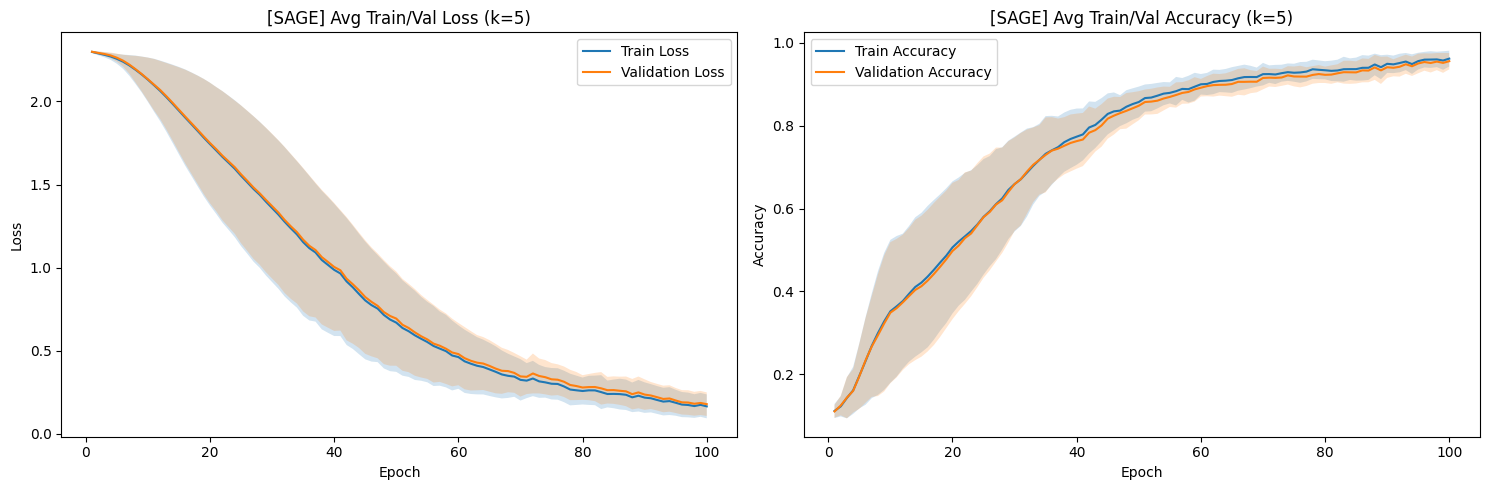

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_7_GCN
Using existing processed data for k_7_GCN
Starting k-fold cross-validation for GCN...

--- Fold 1/10 ---
Epoch 010, Train Loss: 2.2894, Train Acc: 0.1387, Val Loss: 2.2881, Val Acc: 0.1430
Epoch 020, Train Loss: 2.2508, Train Acc: 0.2464, Val Loss: 2.2484, Val Acc: 0.2488


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1722, Train Acc: 0.2728, Val Loss: 2.1684, Val Acc: 0.2749
Epoch 040, Train Loss: 2.0226, Train Acc: 0.4212, Val Loss: 2.0209, Val Acc: 0.4266
Epoch 050, Train Loss: 1.7873, Train Acc: 0.6460, Val Loss: 1.7952, Val Acc: 0.6343
Epoch 060, Train Loss: 1.4520, Train Acc: 0.7631, Val Loss: 1.4711, Val Acc: 0.7413


[I 2025-01-26 16:39:11,522] Trial 0 finished with value: 0.662510335445404 and parameters: {'hidden_channels': 53, 'dropout': 0.4427331553264168, 'lr': 0.00029666567825236773}. Best is trial 0 with value: 0.662510335445404.


Epoch 070, Train Loss: 1.1216, Train Acc: 0.8194, Val Loss: 1.1521, Val Acc: 0.7935
Epoch 080, Train Loss: 0.8725, Train Acc: 0.8443, Val Loss: 0.9079, Val Acc: 0.8221
Epoch 090, Train Loss: 0.7269, Train Acc: 0.8667, Val Loss: 0.7663, Val Acc: 0.8383
Epoch 100, Train Loss: 0.6195, Train Acc: 0.8849, Val Loss: 0.6625, Val Acc: 0.8644


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3002, Train Acc: 0.1279, Val Loss: 2.3020, Val Acc: 0.1343
Epoch 020, Train Loss: 2.2607, Train Acc: 0.1350, Val Loss: 2.2644, Val Acc: 0.1405
Epoch 030, Train Loss: 2.1429, Train Acc: 0.1471, Val Loss: 2.1478, Val Acc: 0.1567
Epoch 040, Train Loss: 1.8887, Train Acc: 0.3175, Val Loss: 1.8959, Val Acc: 0.3308
Epoch 050, Train Loss: 1.5054, Train Acc: 0.5819, Val Loss: 1.5215, Val Acc: 0.5759
Epoch 060, Train Loss: 1.0805, Train Acc: 0.8012, Val Loss: 1.1024, Val Acc: 0.7724
Epoch 070, Train Loss: 0.7393, Train Acc: 0.8970, Val Loss: 0.7652, Val Acc: 0.8719
Epoch 080, Train Loss: 0.5142, Train Acc: 0.9200, Val Loss: 0.5445, Val Acc: 0.9067


[I 2025-01-26 16:39:12,192] Trial 1 finished with value: 0.33883795142173767 and parameters: {'hidden_channels': 56, 'dropout': 0.38563036161002795, 'lr': 0.0006956855906242252}. Best is trial 1 with value: 0.33883795142173767.


Epoch 090, Train Loss: 0.3949, Train Acc: 0.9428, Val Loss: 0.4227, Val Acc: 0.9328
Epoch 100, Train Loss: 0.3155, Train Acc: 0.9647, Val Loss: 0.3388, Val Acc: 0.9627
Epoch 010, Train Loss: 2.1826, Train Acc: 0.4260, Val Loss: 2.1824, Val Acc: 0.4353
Epoch 020, Train Loss: 1.8971, Train Acc: 0.4733, Val Loss: 1.9033, Val Acc: 0.4876


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.4829, Train Acc: 0.6402, Val Loss: 1.4936, Val Acc: 0.6318
Epoch 040, Train Loss: 1.0931, Train Acc: 0.7423, Val Loss: 1.1132, Val Acc: 0.7376
Epoch 050, Train Loss: 0.7501, Train Acc: 0.7998, Val Loss: 0.7611, Val Acc: 0.7886
Epoch 060, Train Loss: 0.5020, Train Acc: 0.8765, Val Loss: 0.5258, Val Acc: 0.8632
Epoch 070, Train Loss: 0.4465, Train Acc: 0.8809, Val Loss: 0.4668, Val Acc: 0.8731


[I 2025-01-26 16:39:12,651] Trial 2 finished with value: 0.21604004502296448 and parameters: {'hidden_channels': 19, 'dropout': 0.21384948495272488, 'lr': 0.0063391883899832045}. Best is trial 2 with value: 0.21604004502296448.


Epoch 080, Train Loss: 0.2874, Train Acc: 0.9418, Val Loss: 0.3041, Val Acc: 0.9403
Epoch 090, Train Loss: 0.2504, Train Acc: 0.9401, Val Loss: 0.2651, Val Acc: 0.9353
Epoch 100, Train Loss: 0.1996, Train Acc: 0.9571, Val Loss: 0.2160, Val Acc: 0.9565
Epoch 010, Train Loss: 2.2630, Train Acc: 0.1019, Val Loss: 2.2689, Val Acc: 0.1020
Epoch 020, Train Loss: 2.1265, Train Acc: 0.3050, Val Loss: 2.1406, Val Acc: 0.2948


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.8892, Train Acc: 0.5723, Val Loss: 1.9050, Val Acc: 0.5622
Epoch 040, Train Loss: 1.5375, Train Acc: 0.7010, Val Loss: 1.5593, Val Acc: 0.6803
Epoch 050, Train Loss: 1.1498, Train Acc: 0.8102, Val Loss: 1.1729, Val Acc: 0.7910
Epoch 060, Train Loss: 0.8259, Train Acc: 0.8494, Val Loss: 0.8546, Val Acc: 0.8259
Epoch 070, Train Loss: 0.6086, Train Acc: 0.8866, Val Loss: 0.6324, Val Acc: 0.8706


[I 2025-01-26 16:39:13,113] Trial 3 finished with value: 0.3817680776119232 and parameters: {'hidden_channels': 21, 'dropout': 0.22437917900076532, 'lr': 0.0028996907155194995}. Best is trial 2 with value: 0.21604004502296448.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:13,222] Trial 4 finished with value: 2.381817102432251 and parameters: {'hidden_channels': 30, 'dropout': 0.32788169095851966, 'lr': 0.00018019168979208802}. Best is trial 2 with value: 0.21604004502296448.


Epoch 080, Train Loss: 0.4824, Train Acc: 0.8922, Val Loss: 0.5105, Val Acc: 0.8794
Epoch 090, Train Loss: 0.4192, Train Acc: 0.9283, Val Loss: 0.4465, Val Acc: 0.9167
Epoch 100, Train Loss: 0.3634, Train Acc: 0.9337, Val Loss: 0.3818, Val Acc: 0.9254
Epoch 010, Train Loss: 2.3416, Train Acc: 0.1061, Val Loss: 2.3452, Val Acc: 0.1057
Epoch 020, Train Loss: 2.3772, Train Acc: 0.1061, Val Loss: 2.3812, Val Acc: 0.1057
Early stopping at epoch 21
  Fold 1 - Optuna Best Trial Val Loss: 0.2160
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 19, 'dropout': 0.21384948495272488, 'lr': 0.0063391883899832045}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1830, Train Acc: 0.2510, Val Loss: 2.1882, Val Acc: 0.2425
Epoch 020, Train Loss: 1.7659, Train Acc: 0.5438, Val Loss: 1.7750, Val Acc: 0.5323
Epoch 030, Train Loss: 1.2687, Train Acc: 0.7037, Val Loss: 1.2950, Val Acc: 0.6604
Epoch 040, Train Loss: 0.8189, Train Acc: 0.8415, Val Loss: 0.8585, Val Acc: 0.8134
Epoch 050, Train Loss: 0.5100, Train Acc: 0.8955, Val Loss: 0.5565, Val Acc: 0.8731


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 060, Train Loss: 0.3829, Train Acc: 0.9188, Val Loss: 0.4213, Val Acc: 0.9104
Epoch 070, Train Loss: 0.3027, Train Acc: 0.9267, Val Loss: 0.3401, Val Acc: 0.9104
Epoch 080, Train Loss: 0.2155, Train Acc: 0.9680, Val Loss: 0.2422, Val Acc: 0.9652
Epoch 090, Train Loss: 0.1869, Train Acc: 0.9577, Val Loss: 0.2000, Val Acc: 0.9590
Epoch 100, Train Loss: 0.1476, Train Acc: 0.9627, Val Loss: 0.1634, Val Acc: 0.9627
  Fold 1 Test Metrics:
  Accuracy: 0.9614
  Precision: 0.9636
  Recall: 0.9614
  F1: 0.9619

--- Fold 2/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3083, Train Acc: 0.0992, Val Loss: 2.3109, Val Acc: 0.0958
Epoch 020, Train Loss: 2.3011, Train Acc: 0.1028, Val Loss: 2.3013, Val Acc: 0.1007
Epoch 030, Train Loss: 2.2732, Train Acc: 0.2543, Val Loss: 2.2722, Val Acc: 0.2512
Epoch 040, Train Loss: 2.2007, Train Acc: 0.3974, Val Loss: 2.1981, Val Acc: 0.3856
Epoch 050, Train Loss: 2.0671, Train Acc: 0.5192, Val Loss: 2.0654, Val Acc: 0.5062
Epoch 060, Train Loss: 1.8474, Train Acc: 0.5960, Val Loss: 1.8457, Val Acc: 0.6095
Epoch 070, Train Loss: 1.5711, Train Acc: 0.6541, Val Loss: 1.5657, Val Acc: 0.6580
Epoch 080, Train Loss: 1.3462, Train Acc: 0.7042, Val Loss: 1.3414, Val Acc: 0.7152


[I 2025-01-26 16:39:14,284] Trial 0 finished with value: 1.0580761432647705 and parameters: {'hidden_channels': 42, 'dropout': 0.45158603450312135, 'lr': 0.00015339404677367757}. Best is trial 0 with value: 1.0580761432647705.


Epoch 090, Train Loss: 1.1856, Train Acc: 0.7311, Val Loss: 1.1726, Val Acc: 0.7488
Epoch 100, Train Loss: 1.0675, Train Acc: 0.7776, Val Loss: 1.0581, Val Acc: 0.7823
Epoch 010, Train Loss: 2.2202, Train Acc: 0.2554, Val Loss: 2.2173, Val Acc: 0.2724
Epoch 020, Train Loss: 1.9717, Train Acc: 0.4360, Val Loss: 1.9685, Val Acc: 0.4403


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.5528, Train Acc: 0.6692, Val Loss: 1.5563, Val Acc: 0.6766
Epoch 040, Train Loss: 1.0709, Train Acc: 0.8143, Val Loss: 1.0993, Val Acc: 0.7985
Epoch 050, Train Loss: 0.6205, Train Acc: 0.9061, Val Loss: 0.6307, Val Acc: 0.8943
Epoch 060, Train Loss: 0.3835, Train Acc: 0.9431, Val Loss: 0.4045, Val Acc: 0.9316


[I 2025-01-26 16:39:14,867] Trial 1 finished with value: 0.21549566090106964 and parameters: {'hidden_channels': 38, 'dropout': 0.3196161270824735, 'lr': 0.003180073381676757}. Best is trial 1 with value: 0.21549566090106964.


Epoch 070, Train Loss: 0.2407, Train Acc: 0.9610, Val Loss: 0.2733, Val Acc: 0.9565
Epoch 080, Train Loss: 0.2087, Train Acc: 0.9538, Val Loss: 0.2532, Val Acc: 0.9403
Epoch 090, Train Loss: 0.1603, Train Acc: 0.9740, Val Loss: 0.1657, Val Acc: 0.9701
Epoch 100, Train Loss: 0.1775, Train Acc: 0.9659, Val Loss: 0.2155, Val Acc: 0.9527


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2935, Train Acc: 0.1145, Val Loss: 2.2948, Val Acc: 0.1119
Epoch 020, Train Loss: 2.2630, Train Acc: 0.1373, Val Loss: 2.2633, Val Acc: 0.1231
Epoch 030, Train Loss: 2.2036, Train Acc: 0.1622, Val Loss: 2.2060, Val Acc: 0.1530
Epoch 040, Train Loss: 2.0398, Train Acc: 0.3078, Val Loss: 2.0405, Val Acc: 0.2898
Epoch 050, Train Loss: 1.7858, Train Acc: 0.5895, Val Loss: 1.7817, Val Acc: 0.5908


[I 2025-01-26 16:39:15,315] Trial 2 finished with value: 0.9807353615760803 and parameters: {'hidden_channels': 17, 'dropout': 0.477967504853653, 'lr': 0.0007777749998464526}. Best is trial 1 with value: 0.21549566090106964.


Epoch 060, Train Loss: 1.5187, Train Acc: 0.7093, Val Loss: 1.5232, Val Acc: 0.6903
Epoch 070, Train Loss: 1.2973, Train Acc: 0.7620, Val Loss: 1.3031, Val Acc: 0.7488
Epoch 080, Train Loss: 1.1307, Train Acc: 0.8071, Val Loss: 1.1369, Val Acc: 0.7960
Epoch 090, Train Loss: 1.0488, Train Acc: 0.8183, Val Loss: 1.0687, Val Acc: 0.7998
Epoch 100, Train Loss: 0.9621, Train Acc: 0.8309, Val Loss: 0.9807, Val Acc: 0.8184


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0581, Train Acc: 0.5376, Val Loss: 2.0530, Val Acc: 0.5348
Epoch 020, Train Loss: 1.5208, Train Acc: 0.6982, Val Loss: 1.5201, Val Acc: 0.6915
Epoch 030, Train Loss: 0.9579, Train Acc: 0.8266, Val Loss: 0.9712, Val Acc: 0.8097
Epoch 040, Train Loss: 0.5551, Train Acc: 0.9015, Val Loss: 0.5938, Val Acc: 0.8905
Epoch 050, Train Loss: 0.3552, Train Acc: 0.9185, Val Loss: 0.3898, Val Acc: 0.9092
Epoch 060, Train Loss: 0.2524, Train Acc: 0.9322, Val Loss: 0.2933, Val Acc: 0.9204
Epoch 070, Train Loss: 0.1493, Train Acc: 0.9680, Val Loss: 0.1765, Val Acc: 0.9652
Epoch 080, Train Loss: 0.1127, Train Acc: 0.9748, Val Loss: 0.1289, Val Acc: 0.9664


[I 2025-01-26 16:39:15,965] Trial 3 finished with value: 0.1747429519891739 and parameters: {'hidden_channels': 51, 'dropout': 0.47669181383028564, 'lr': 0.005619086426400496}. Best is trial 3 with value: 0.1747429519891739.


Epoch 090, Train Loss: 0.1229, Train Acc: 0.9708, Val Loss: 0.1736, Val Acc: 0.9614
Epoch 100, Train Loss: 0.1232, Train Acc: 0.9810, Val Loss: 0.1747, Val Acc: 0.9764
Epoch 010, Train Loss: 2.1089, Train Acc: 0.4665, Val Loss: 2.0979, Val Acc: 0.4764
Epoch 020, Train Loss: 1.6368, Train Acc: 0.6368, Val Loss: 1.6416, Val Acc: 0.6194


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.0862, Train Acc: 0.7430, Val Loss: 1.0883, Val Acc: 0.7313
Epoch 040, Train Loss: 0.6524, Train Acc: 0.8631, Val Loss: 0.6630, Val Acc: 0.8445
Epoch 050, Train Loss: 0.4068, Train Acc: 0.9098, Val Loss: 0.4323, Val Acc: 0.9005
Epoch 060, Train Loss: 0.2826, Train Acc: 0.9241, Val Loss: 0.3198, Val Acc: 0.9104


[I 2025-01-26 16:39:16,573] Trial 4 finished with value: 0.1081467717885971 and parameters: {'hidden_channels': 42, 'dropout': 0.42253604198043665, 'lr': 0.0056620097672010275}. Best is trial 4 with value: 0.1081467717885971.


Epoch 070, Train Loss: 0.2104, Train Acc: 0.9389, Val Loss: 0.2238, Val Acc: 0.9266
Epoch 080, Train Loss: 0.1496, Train Acc: 0.9676, Val Loss: 0.1699, Val Acc: 0.9590
Epoch 090, Train Loss: 0.1227, Train Acc: 0.9712, Val Loss: 0.1411, Val Acc: 0.9627
Epoch 100, Train Loss: 0.0907, Train Acc: 0.9830, Val Loss: 0.1081, Val Acc: 0.9801
  Fold 2 - Optuna Best Trial Val Loss: 0.1081
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 42, 'dropout': 0.42253604198043665, 'lr': 0.0056620097672010275}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0787, Train Acc: 0.4725, Val Loss: 2.0676, Val Acc: 0.4689
Epoch 020, Train Loss: 1.5659, Train Acc: 0.7384, Val Loss: 1.5777, Val Acc: 0.7338
Epoch 030, Train Loss: 1.0698, Train Acc: 0.7987, Val Loss: 1.0809, Val Acc: 0.8022
Epoch 040, Train Loss: 0.6269, Train Acc: 0.8728, Val Loss: 0.6426, Val Acc: 0.8682
Epoch 050, Train Loss: 0.3569, Train Acc: 0.9238, Val Loss: 0.3851, Val Acc: 0.9042
Epoch 060, Train Loss: 0.2194, Train Acc: 0.9519, Val Loss: 0.2513, Val Acc: 0.9440
Epoch 070, Train Loss: 0.1764, Train Acc: 0.9512, Val Loss: 0.2136, Val Acc: 0.9403
Epoch 080, Train Loss: 0.1485, Train Acc: 0.9592, Val Loss: 0.1987, Val Acc: 0.9502


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1287, Train Acc: 0.9701, Val Loss: 0.1640, Val Acc: 0.9614
Epoch 100, Train Loss: 0.1083, Train Acc: 0.9704, Val Loss: 0.1387, Val Acc: 0.9627
  Fold 2 Test Metrics:
  Accuracy: 0.9701
  Precision: 0.9716
  Recall: 0.9701
  F1: 0.9702

--- Fold 3/10 ---
Epoch 010, Train Loss: 2.2925, Train Acc: 0.0967, Val Loss: 2.2966, Val Acc: 0.0945
Epoch 020, Train Loss: 2.2504, Train Acc: 0.1562, Val Loss: 2.2580, Val Acc: 0.1517


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1423, Train Acc: 0.3388, Val Loss: 2.1527, Val Acc: 0.3296
Epoch 040, Train Loss: 1.9592, Train Acc: 0.5002, Val Loss: 1.9715, Val Acc: 0.4938
Epoch 050, Train Loss: 1.6624, Train Acc: 0.6746, Val Loss: 1.6709, Val Acc: 0.6654
Epoch 060, Train Loss: 1.3208, Train Acc: 0.7913, Val Loss: 1.3338, Val Acc: 0.7799
Epoch 070, Train Loss: 1.0031, Train Acc: 0.8516, Val Loss: 1.0071, Val Acc: 0.8371


[I 2025-01-26 16:39:17,681] Trial 0 finished with value: 0.5836899876594543 and parameters: {'hidden_channels': 27, 'dropout': 0.42814066300159737, 'lr': 0.0009489212263926772}. Best is trial 0 with value: 0.5836899876594543.


Epoch 080, Train Loss: 0.7682, Train Acc: 0.8835, Val Loss: 0.7731, Val Acc: 0.8744
Epoch 090, Train Loss: 0.6279, Train Acc: 0.9132, Val Loss: 0.6431, Val Acc: 0.9055
Epoch 100, Train Loss: 0.5677, Train Acc: 0.9101, Val Loss: 0.5837, Val Acc: 0.8993
Epoch 010, Train Loss: 2.2861, Train Acc: 0.1031, Val Loss: 2.2857, Val Acc: 0.1057


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2256, Train Acc: 0.1215, Val Loss: 2.2246, Val Acc: 0.1306
Epoch 030, Train Loss: 2.0920, Train Acc: 0.1885, Val Loss: 2.0939, Val Acc: 0.1816
Epoch 040, Train Loss: 1.8663, Train Acc: 0.3483, Val Loss: 1.8691, Val Acc: 0.3458
Epoch 050, Train Loss: 1.4917, Train Acc: 0.6724, Val Loss: 1.4971, Val Acc: 0.6729
Epoch 060, Train Loss: 1.0800, Train Acc: 0.8336, Val Loss: 1.0826, Val Acc: 0.8296
Epoch 070, Train Loss: 0.7365, Train Acc: 0.9056, Val Loss: 0.7423, Val Acc: 0.8980
Epoch 080, Train Loss: 0.5228, Train Acc: 0.9367, Val Loss: 0.5371, Val Acc: 0.9254
Epoch 090, Train Loss: 0.4053, Train Acc: 0.9507, Val Loss: 0.4264, Val Acc: 0.9440


[I 2025-01-26 16:39:18,297] Trial 1 finished with value: 0.3448585867881775 and parameters: {'hidden_channels': 45, 'dropout': 0.3954568539535289, 'lr': 0.0008779472161718969}. Best is trial 1 with value: 0.3448585867881775.


Epoch 100, Train Loss: 0.3226, Train Acc: 0.9644, Val Loss: 0.3449, Val Acc: 0.9577
Epoch 010, Train Loss: 2.3065, Train Acc: 0.0999, Val Loss: 2.3056, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2931, Train Acc: 0.1036, Val Loss: 2.2905, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2304, Train Acc: 0.1062, Val Loss: 2.2252, Val Acc: 0.1057


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.1093, Train Acc: 0.1241, Val Loss: 2.0986, Val Acc: 0.1343
Epoch 050, Train Loss: 1.9022, Train Acc: 0.2860, Val Loss: 1.8873, Val Acc: 0.3072
Epoch 060, Train Loss: 1.5834, Train Acc: 0.5436, Val Loss: 1.5685, Val Acc: 0.5348
Epoch 070, Train Loss: 1.2306, Train Acc: 0.7645, Val Loss: 1.2227, Val Acc: 0.7450


[I 2025-01-26 16:39:18,952] Trial 2 finished with value: 0.7068279981613159 and parameters: {'hidden_channels': 56, 'dropout': 0.3242593391495391, 'lr': 0.0002419766253815698}. Best is trial 1 with value: 0.3448585867881775.


Epoch 080, Train Loss: 0.9666, Train Acc: 0.8580, Val Loss: 0.9666, Val Acc: 0.8470
Epoch 090, Train Loss: 0.7975, Train Acc: 0.8935, Val Loss: 0.7998, Val Acc: 0.8831
Epoch 100, Train Loss: 0.7013, Train Acc: 0.9068, Val Loss: 0.7068, Val Acc: 0.9017
Epoch 010, Train Loss: 2.2939, Train Acc: 0.1129, Val Loss: 2.2989, Val Acc: 0.1045


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2552, Train Acc: 0.1182, Val Loss: 2.2642, Val Acc: 0.1119
Epoch 030, Train Loss: 2.1925, Train Acc: 0.1736, Val Loss: 2.2061, Val Acc: 0.1617
Epoch 040, Train Loss: 2.0731, Train Acc: 0.4036, Val Loss: 2.0858, Val Acc: 0.3980
Epoch 050, Train Loss: 1.8802, Train Acc: 0.5834, Val Loss: 1.8908, Val Acc: 0.5721
Epoch 060, Train Loss: 1.6368, Train Acc: 0.6821, Val Loss: 1.6543, Val Acc: 0.6629


[I 2025-01-26 16:39:19,399] Trial 3 finished with value: 0.9668446779251099 and parameters: {'hidden_channels': 20, 'dropout': 0.3874246553175035, 'lr': 0.0007927296490921703}. Best is trial 1 with value: 0.3448585867881775.


Epoch 070, Train Loss: 1.3543, Train Acc: 0.7552, Val Loss: 1.3725, Val Acc: 0.7351
Epoch 080, Train Loss: 1.1539, Train Acc: 0.7919, Val Loss: 1.1745, Val Acc: 0.7799
Epoch 090, Train Loss: 1.0442, Train Acc: 0.8376, Val Loss: 1.0708, Val Acc: 0.8358
Epoch 100, Train Loss: 0.9388, Train Acc: 0.8617, Val Loss: 0.9668, Val Acc: 0.8595
Epoch 010, Train Loss: 2.2854, Train Acc: 0.1028, Val Loss: 2.2833, Val Acc: 0.0983


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2166, Train Acc: 0.1509, Val Loss: 2.2128, Val Acc: 0.1455
Epoch 030, Train Loss: 2.0942, Train Acc: 0.3646, Val Loss: 2.0896, Val Acc: 0.3557
Epoch 040, Train Loss: 1.8418, Train Acc: 0.5511, Val Loss: 1.8396, Val Acc: 0.5535
Epoch 050, Train Loss: 1.4494, Train Acc: 0.7667, Val Loss: 1.4530, Val Acc: 0.7662
Epoch 060, Train Loss: 1.0569, Train Acc: 0.8567, Val Loss: 1.0629, Val Acc: 0.8495
Epoch 070, Train Loss: 0.7228, Train Acc: 0.9159, Val Loss: 0.7326, Val Acc: 0.9104
Epoch 080, Train Loss: 0.5243, Train Acc: 0.9389, Val Loss: 0.5373, Val Acc: 0.9316
Epoch 090, Train Loss: 0.4141, Train Acc: 0.9418, Val Loss: 0.4337, Val Acc: 0.9291


[I 2025-01-26 16:39:20,067] Trial 4 finished with value: 0.3379652500152588 and parameters: {'hidden_channels': 57, 'dropout': 0.2783291964343262, 'lr': 0.0006472753852803614}. Best is trial 4 with value: 0.3379652500152588.


Epoch 100, Train Loss: 0.3252, Train Acc: 0.9628, Val Loss: 0.3380, Val Acc: 0.9502
  Fold 3 - Optuna Best Trial Val Loss: 0.3380
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 57, 'dropout': 0.2783291964343262, 'lr': 0.0006472753852803614}
Epoch 010, Train Loss: 2.2805, Train Acc: 0.1093, Val Loss: 2.2789, Val Acc: 0.1169
Epoch 020, Train Loss: 2.2291, Train Acc: 0.1137, Val Loss: 2.2309, Val Acc: 0.1107
Epoch 030, Train Loss: 2.1214, Train Acc: 0.1325, Val Loss: 2.1289, Val Acc: 0.1331


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.9212, Train Acc: 0.2352, Val Loss: 1.9320, Val Acc: 0.2264
Epoch 050, Train Loss: 1.5647, Train Acc: 0.5587, Val Loss: 1.5808, Val Acc: 0.5647
Epoch 060, Train Loss: 1.1083, Train Acc: 0.8070, Val Loss: 1.1225, Val Acc: 0.7948
Epoch 070, Train Loss: 0.7443, Train Acc: 0.8812, Val Loss: 0.7654, Val Acc: 0.8669


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.5352, Train Acc: 0.9163, Val Loss: 0.5506, Val Acc: 0.8980
Epoch 090, Train Loss: 0.4044, Train Acc: 0.9406, Val Loss: 0.4234, Val Acc: 0.9303
Epoch 100, Train Loss: 0.3253, Train Acc: 0.9552, Val Loss: 0.3434, Val Acc: 0.9440
  Fold 3 Test Metrics:
  Accuracy: 0.9453
  Precision: 0.9480
  Recall: 0.9453
  F1: 0.9456

--- Fold 4/10 ---
Epoch 010, Train Loss: 2.1758, Train Acc: 0.2055, Val Loss: 2.1770, Val Acc: 0.2189


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8988, Train Acc: 0.4783, Val Loss: 1.9175, Val Acc: 0.4490
Epoch 030, Train Loss: 1.4474, Train Acc: 0.7115, Val Loss: 1.4751, Val Acc: 0.6903
Epoch 040, Train Loss: 0.9928, Train Acc: 0.8286, Val Loss: 1.0282, Val Acc: 0.8010
Epoch 050, Train Loss: 0.6504, Train Acc: 0.8745, Val Loss: 0.6836, Val Acc: 0.8682
Epoch 060, Train Loss: 0.4471, Train Acc: 0.9101, Val Loss: 0.4721, Val Acc: 0.9080


[I 2025-01-26 16:39:21,243] Trial 0 finished with value: 0.20028045773506165 and parameters: {'hidden_channels': 32, 'dropout': 0.4595416378582032, 'lr': 0.004004984692374412}. Best is trial 0 with value: 0.20028045773506165.


Epoch 070, Train Loss: 0.3233, Train Acc: 0.9435, Val Loss: 0.3487, Val Acc: 0.9378
Epoch 080, Train Loss: 0.2289, Train Acc: 0.9535, Val Loss: 0.2458, Val Acc: 0.9515
Epoch 090, Train Loss: 0.2358, Train Acc: 0.9424, Val Loss: 0.2743, Val Acc: 0.9428
Epoch 100, Train Loss: 0.1867, Train Acc: 0.9522, Val Loss: 0.2003, Val Acc: 0.9453
Epoch 010, Train Loss: 2.3176, Train Acc: 0.1140, Val Loss: 2.3216, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:21,351] Trial 1 finished with value: 2.3397793769836426 and parameters: {'hidden_channels': 29, 'dropout': 0.2637099153202881, 'lr': 0.00015562335131647908}. Best is trial 0 with value: 0.20028045773506165.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:21,473] Trial 2 finished with value: 2.344505786895752 and parameters: {'hidden_channels': 34, 'dropout': 0.3688168991112625, 'lr': 0.00019708523121592182}. Best is trial 0 with value: 0.20028045773506165.


Epoch 020, Train Loss: 2.3301, Train Acc: 0.1179, Val Loss: 2.3397, Val Acc: 0.1144
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3212, Train Acc: 0.1086, Val Loss: 2.3215, Val Acc: 0.1057
Epoch 020, Train Loss: 2.3434, Train Acc: 0.0999, Val Loss: 2.3451, Val Acc: 0.0995
Early stopping at epoch 21
Epoch 010, Train Loss: 2.0838, Train Acc: 0.3424, Val Loss: 2.0890, Val Acc: 0.3321


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6310, Train Acc: 0.5415, Val Loss: 1.6464, Val Acc: 0.5473
Epoch 030, Train Loss: 1.1550, Train Acc: 0.6581, Val Loss: 1.1771, Val Acc: 0.6567
Epoch 040, Train Loss: 0.6975, Train Acc: 0.8200, Val Loss: 0.7322, Val Acc: 0.8060
Epoch 050, Train Loss: 0.3531, Train Acc: 0.9280, Val Loss: 0.3742, Val Acc: 0.9241
Epoch 060, Train Loss: 0.1985, Train Acc: 0.9701, Val Loss: 0.2183, Val Acc: 0.9664
Epoch 070, Train Loss: 0.1715, Train Acc: 0.9662, Val Loss: 0.1999, Val Acc: 0.9602
Epoch 080, Train Loss: 0.2029, Train Acc: 0.9756, Val Loss: 0.2822, Val Acc: 0.9689
Epoch 090, Train Loss: 0.0729, Train Acc: 0.9882, Val Loss: 0.0819, Val Acc: 0.9851


[I 2025-01-26 16:39:22,139] Trial 3 finished with value: 0.25827813148498535 and parameters: {'hidden_channels': 57, 'dropout': 0.2369968057945715, 'lr': 0.004033911044020501}. Best is trial 0 with value: 0.20028045773506165.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:22,247] Trial 4 finished with value: 2.3103740215301514 and parameters: {'hidden_channels': 27, 'dropout': 0.2139992474234402, 'lr': 0.00016200670458161646}. Best is trial 0 with value: 0.20028045773506165.


Epoch 100, Train Loss: 0.1774, Train Acc: 0.9684, Val Loss: 0.2583, Val Acc: 0.9590
Epoch 010, Train Loss: 2.3043, Train Acc: 0.1016, Val Loss: 2.3065, Val Acc: 0.1020
Epoch 020, Train Loss: 2.3020, Train Acc: 0.1016, Val Loss: 2.3104, Val Acc: 0.1020
Early stopping at epoch 22
  Fold 4 - Optuna Best Trial Val Loss: 0.2003
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 32, 'dropout': 0.4595416378582032, 'lr': 0.004004984692374412}
Epoch 010, Train Loss: 2.1977, Train Acc: 0.3094, Val Loss: 2.1975, Val Acc: 0.3072


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9300, Train Acc: 0.4764, Val Loss: 1.9365, Val Acc: 0.4664
Epoch 030, Train Loss: 1.4580, Train Acc: 0.6539, Val Loss: 1.4744, Val Acc: 0.6318
Epoch 040, Train Loss: 0.9278, Train Acc: 0.8297, Val Loss: 0.9436, Val Acc: 0.8271
Epoch 050, Train Loss: 0.5854, Train Acc: 0.8799, Val Loss: 0.6175, Val Acc: 0.8843
Epoch 060, Train Loss: 0.3465, Train Acc: 0.9309, Val Loss: 0.3589, Val Acc: 0.9341


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 070, Train Loss: 0.3323, Train Acc: 0.9182, Val Loss: 0.3524, Val Acc: 0.9229
Epoch 080, Train Loss: 0.2539, Train Acc: 0.9473, Val Loss: 0.2878, Val Acc: 0.9490
Epoch 090, Train Loss: 0.1961, Train Acc: 0.9555, Val Loss: 0.2127, Val Acc: 0.9565
Epoch 100, Train Loss: 0.1946, Train Acc: 0.9490, Val Loss: 0.2186, Val Acc: 0.9391
  Fold 4 Test Metrics:
  Accuracy: 0.9540
  Precision: 0.9554
  Recall: 0.9540
  F1: 0.9536

--- Fold 5/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8563, Train Acc: 0.5985, Val Loss: 1.8570, Val Acc: 0.5945
Epoch 020, Train Loss: 1.0834, Train Acc: 0.7082, Val Loss: 1.0872, Val Acc: 0.7052
Epoch 030, Train Loss: 0.6072, Train Acc: 0.8368, Val Loss: 0.6283, Val Acc: 0.8383
Epoch 040, Train Loss: 0.3104, Train Acc: 0.9221, Val Loss: 0.3252, Val Acc: 0.9179
Epoch 050, Train Loss: 0.2468, Train Acc: 0.9216, Val Loss: 0.2655, Val Acc: 0.9080
Epoch 060, Train Loss: 0.1546, Train Acc: 0.9596, Val Loss: 0.1519, Val Acc: 0.9540
Epoch 070, Train Loss: 0.1080, Train Acc: 0.9802, Val Loss: 0.1112, Val Acc: 0.9789
Epoch 080, Train Loss: 0.1574, Train Acc: 0.9452, Val Loss: 0.1915, Val Acc: 0.9316


[I 2025-01-26 16:39:23,331] Trial 0 finished with value: 0.16085036098957062 and parameters: {'hidden_channels': 45, 'dropout': 0.24562085706541795, 'lr': 0.009796678361541739}. Best is trial 0 with value: 0.16085036098957062.


Epoch 090, Train Loss: 0.1134, Train Acc: 0.9748, Val Loss: 0.1227, Val Acc: 0.9701
Early stopping at epoch 92
Epoch 010, Train Loss: 2.2525, Train Acc: 0.2170, Val Loss: 2.2535, Val Acc: 0.2214
Epoch 020, Train Loss: 2.1177, Train Acc: 0.3542, Val Loss: 2.1152, Val Acc: 0.3408
Epoch 030, Train Loss: 1.8613, Train Acc: 0.5030, Val Loss: 1.8634, Val Acc: 0.5037


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.4828, Train Acc: 0.6755, Val Loss: 1.5002, Val Acc: 0.6592
Epoch 050, Train Loss: 1.0513, Train Acc: 0.8451, Val Loss: 1.0824, Val Acc: 0.8383
Epoch 060, Train Loss: 0.6965, Train Acc: 0.9005, Val Loss: 0.7255, Val Acc: 0.8905
Epoch 070, Train Loss: 0.4960, Train Acc: 0.9208, Val Loss: 0.5207, Val Acc: 0.9154


[I 2025-01-26 16:39:23,901] Trial 1 finished with value: 0.35618215799331665 and parameters: {'hidden_channels': 35, 'dropout': 0.4042164132750983, 'lr': 0.001861426093003432}. Best is trial 0 with value: 0.16085036098957062.


Epoch 080, Train Loss: 0.3756, Train Acc: 0.9386, Val Loss: 0.3771, Val Acc: 0.9378
Epoch 090, Train Loss: 0.2464, Train Acc: 0.9631, Val Loss: 0.2561, Val Acc: 0.9614
Epoch 100, Train Loss: 0.3991, Train Acc: 0.9182, Val Loss: 0.3562, Val Acc: 0.9229
Epoch 010, Train Loss: 2.3115, Train Acc: 0.0967, Val Loss: 2.3099, Val Acc: 0.1007


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:24,032] Trial 2 finished with value: 2.303664207458496 and parameters: {'hidden_channels': 41, 'dropout': 0.41348178019803017, 'lr': 0.00023606674790536215}. Best is trial 0 with value: 0.16085036098957062.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3112, Train Acc: 0.1008, Val Loss: 2.3054, Val Acc: 0.1045
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2695, Train Acc: 0.1725, Val Loss: 2.2687, Val Acc: 0.1791
Epoch 020, Train Loss: 2.1421, Train Acc: 0.2465, Val Loss: 2.1467, Val Acc: 0.2711
Epoch 030, Train Loss: 1.9099, Train Acc: 0.4610, Val Loss: 1.9152, Val Acc: 0.4590
Epoch 040, Train Loss: 1.5747, Train Acc: 0.7000, Val Loss: 1.5951, Val Acc: 0.6915
Epoch 050, Train Loss: 1.1357, Train Acc: 0.8308, Val Loss: 1.1720, Val Acc: 0.8358
Epoch 060, Train Loss: 0.7526, Train Acc: 0.8647, Val Loss: 0.7835, Val Acc: 0.8619
Epoch 070, Train Loss: 0.5104, Train Acc: 0.9159, Val Loss: 0.5128, Val Acc: 0.9204
Epoch 080, Train Loss: 0.3576, Train Acc: 0.9294, Val Loss: 0.3519, Val Acc: 0.9353


[I 2025-01-26 16:39:24,528] Trial 3 finished with value: 0.27745524048805237 and parameters: {'hidden_channels': 30, 'dropout': 0.3531542661847221, 'lr': 0.0024127777600017174}. Best is trial 0 with value: 0.16085036098957062.


Epoch 090, Train Loss: 0.3151, Train Acc: 0.9466, Val Loss: 0.3276, Val Acc: 0.9565
Epoch 100, Train Loss: 0.2696, Train Acc: 0.9613, Val Loss: 0.2775, Val Acc: 0.9677
Epoch 010, Train Loss: 2.3041, Train Acc: 0.1050, Val Loss: 2.3071, Val Acc: 0.0983
Epoch 020, Train Loss: 2.2869, Train Acc: 0.1048, Val Loss: 2.2913, Val Acc: 0.0983


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.2019, Train Acc: 0.1739, Val Loss: 2.2084, Val Acc: 0.1741
Epoch 040, Train Loss: 2.0218, Train Acc: 0.3567, Val Loss: 2.0395, Val Acc: 0.3321
Epoch 050, Train Loss: 1.7304, Train Acc: 0.6121, Val Loss: 1.7557, Val Acc: 0.5684
Epoch 060, Train Loss: 1.3814, Train Acc: 0.7609, Val Loss: 1.4128, Val Acc: 0.7463


[I 2025-01-26 16:39:25,192] Trial 4 finished with value: 0.5450358986854553 and parameters: {'hidden_channels': 56, 'dropout': 0.22708905399706028, 'lr': 0.00033668522061533436}. Best is trial 0 with value: 0.16085036098957062.


Epoch 070, Train Loss: 1.0218, Train Acc: 0.8558, Val Loss: 1.0552, Val Acc: 0.8483
Epoch 080, Train Loss: 0.7727, Train Acc: 0.8956, Val Loss: 0.8100, Val Acc: 0.8893
Epoch 090, Train Loss: 0.6101, Train Acc: 0.9127, Val Loss: 0.6393, Val Acc: 0.9092
Epoch 100, Train Loss: 0.5206, Train Acc: 0.9238, Val Loss: 0.5450, Val Acc: 0.9254
  Fold 5 - Optuna Best Trial Val Loss: 0.1609
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 45, 'dropout': 0.24562085706541795, 'lr': 0.009796678361541739}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8822, Train Acc: 0.5847, Val Loss: 1.8828, Val Acc: 0.5721
Epoch 020, Train Loss: 1.1404, Train Acc: 0.6984, Val Loss: 1.1620, Val Acc: 0.7052
Epoch 030, Train Loss: 0.6879, Train Acc: 0.8076, Val Loss: 0.7037, Val Acc: 0.7998
Epoch 040, Train Loss: 0.3904, Train Acc: 0.8893, Val Loss: 0.4021, Val Acc: 0.8993
Epoch 050, Train Loss: 0.2847, Train Acc: 0.9185, Val Loss: 0.2862, Val Acc: 0.9179
Epoch 060, Train Loss: 0.1952, Train Acc: 0.9552, Val Loss: 0.1980, Val Acc: 0.9540
Epoch 070, Train Loss: 0.1662, Train Acc: 0.9502, Val Loss: 0.1676, Val Acc: 0.9490
Epoch 080, Train Loss: 0.1228, Train Acc: 0.9706, Val Loss: 0.1170, Val Acc: 0.9689


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0904, Train Acc: 0.9848, Val Loss: 0.0860, Val Acc: 0.9838
Epoch 100, Train Loss: 0.0650, Train Acc: 0.9893, Val Loss: 0.0674, Val Acc: 0.9863
  Fold 5 Test Metrics:
  Accuracy: 0.9838
  Precision: 0.9847
  Recall: 0.9838
  F1: 0.9838

--- Fold 6/10 ---
Epoch 010, Train Loss: 2.3376, Train Acc: 0.1014, Val Loss: 2.3380, Val Acc: 0.0958


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:25,975] Trial 0 finished with value: 2.374056339263916 and parameters: {'hidden_channels': 64, 'dropout': 0.421052579260485, 'lr': 0.00018064750489166863}. Best is trial 0 with value: 2.374056339263916.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3735, Train Acc: 0.1072, Val Loss: 2.3751, Val Acc: 0.0945
Early stopping at epoch 21
Epoch 010, Train Loss: 1.9682, Train Acc: 0.5131, Val Loss: 1.9583, Val Acc: 0.5323
Epoch 020, Train Loss: 1.3715, Train Acc: 0.5945, Val Loss: 1.3827, Val Acc: 0.5771
Epoch 030, Train Loss: 0.8272, Train Acc: 0.7416, Val Loss: 0.8451, Val Acc: 0.7239
Epoch 040, Train Loss: 0.4152, Train Acc: 0.8967, Val Loss: 0.4514, Val Acc: 0.8843
Epoch 050, Train Loss: 0.2502, Train Acc: 0.9353, Val Loss: 0.2687, Val Acc: 0.9353
Epoch 060, Train Loss: 0.1822, Train Acc: 0.9566, Val Loss: 0.2023, Val Acc: 0.9490
Epoch 070, Train Loss: 0.2328, Train Acc: 0.9421, Val Loss: 0.2672, Val Acc: 0.9428
Epoch 080, Train Loss: 0.0811, Train Acc: 0.9880, Val Loss: 0.0969, Val Acc: 0.9826


[I 2025-01-26 16:39:26,678] Trial 1 finished with value: 0.09273575246334076 and parameters: {'hidden_channels': 62, 'dropout': 0.31976484254133053, 'lr': 0.006724394916688295}. Best is trial 1 with value: 0.09273575246334076.


Epoch 090, Train Loss: 0.1198, Train Acc: 0.9575, Val Loss: 0.1451, Val Acc: 0.9540
Epoch 100, Train Loss: 0.0913, Train Acc: 0.9823, Val Loss: 0.0927, Val Acc: 0.9789
Epoch 010, Train Loss: 2.2047, Train Acc: 0.1425, Val Loss: 2.2126, Val Acc: 0.1318


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8674, Train Acc: 0.4071, Val Loss: 1.8792, Val Acc: 0.4104
Epoch 030, Train Loss: 1.4160, Train Acc: 0.6329, Val Loss: 1.4323, Val Acc: 0.6468
Epoch 040, Train Loss: 0.9311, Train Acc: 0.7937, Val Loss: 0.9528, Val Acc: 0.7836
Epoch 050, Train Loss: 0.5538, Train Acc: 0.8947, Val Loss: 0.5754, Val Acc: 0.8781
Epoch 060, Train Loss: 0.3372, Train Acc: 0.9269, Val Loss: 0.3607, Val Acc: 0.9142
Epoch 070, Train Loss: 0.2099, Train Acc: 0.9572, Val Loss: 0.2239, Val Acc: 0.9478
Epoch 080, Train Loss: 0.1290, Train Acc: 0.9813, Val Loss: 0.1532, Val Acc: 0.9714
Epoch 090, Train Loss: 0.1060, Train Acc: 0.9835, Val Loss: 0.1178, Val Acc: 0.9863


[I 2025-01-26 16:39:27,335] Trial 2 finished with value: 0.09282582998275757 and parameters: {'hidden_channels': 53, 'dropout': 0.30452583045837034, 'lr': 0.003049146002358875}. Best is trial 1 with value: 0.09273575246334076.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:27,431] Trial 3 finished with value: 2.3017804622650146 and parameters: {'hidden_channels': 19, 'dropout': 0.4111094478068129, 'lr': 0.00022119884011336934}. Best is trial 1 with value: 0.09273575246334076.


Epoch 100, Train Loss: 0.0794, Train Acc: 0.9869, Val Loss: 0.0928, Val Acc: 0.9851
Epoch 010, Train Loss: 2.3055, Train Acc: 0.1224, Val Loss: 2.3052, Val Acc: 0.1281
Epoch 020, Train Loss: 2.3051, Train Acc: 0.1324, Val Loss: 2.3042, Val Acc: 0.1381
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3067, Train Acc: 0.1255, Val Loss: 2.3036, Val Acc: 0.1281


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3034, Train Acc: 0.1201, Val Loss: 2.2998, Val Acc: 0.1306
Epoch 030, Train Loss: 2.2822, Train Acc: 0.1503, Val Loss: 2.2813, Val Acc: 0.1555
Epoch 040, Train Loss: 2.2330, Train Acc: 0.1717, Val Loss: 2.2397, Val Acc: 0.1629
Epoch 050, Train Loss: 2.1599, Train Acc: 0.2434, Val Loss: 2.1649, Val Acc: 0.2276
Epoch 060, Train Loss: 2.0344, Train Acc: 0.4080, Val Loss: 2.0514, Val Acc: 0.4104
Epoch 070, Train Loss: 1.8482, Train Acc: 0.5424, Val Loss: 1.8652, Val Acc: 0.5473
Epoch 080, Train Loss: 1.6845, Train Acc: 0.5572, Val Loss: 1.7009, Val Acc: 0.5547
Epoch 090, Train Loss: 1.5610, Train Acc: 0.5797, Val Loss: 1.5738, Val Acc: 0.5659


[I 2025-01-26 16:39:27,995] Trial 4 finished with value: 1.4886729717254639 and parameters: {'hidden_channels': 34, 'dropout': 0.3362669469408529, 'lr': 0.00011992853900491188}. Best is trial 1 with value: 0.09273575246334076.


Epoch 100, Train Loss: 1.4661, Train Acc: 0.6069, Val Loss: 1.4887, Val Acc: 0.5759
  Fold 6 - Optuna Best Trial Val Loss: 0.0927
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 62, 'dropout': 0.31976484254133053, 'lr': 0.006724394916688295}
Epoch 010, Train Loss: 1.9477, Train Acc: 0.4155, Val Loss: 1.9524, Val Acc: 0.4167
Epoch 020, Train Loss: 1.2966, Train Acc: 0.6699, Val Loss: 1.2961, Val Acc: 0.6692


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 0.7349, Train Acc: 0.8065, Val Loss: 0.7448, Val Acc: 0.7998
Epoch 040, Train Loss: 0.3833, Train Acc: 0.9036, Val Loss: 0.3896, Val Acc: 0.9017
Epoch 050, Train Loss: 0.2465, Train Acc: 0.9386, Val Loss: 0.2621, Val Acc: 0.9316
Epoch 060, Train Loss: 0.2212, Train Acc: 0.9403, Val Loss: 0.2779, Val Acc: 0.9341
Epoch 070, Train Loss: 0.1439, Train Acc: 0.9683, Val Loss: 0.1465, Val Acc: 0.9639
Epoch 080, Train Loss: 0.0975, Train Acc: 0.9827, Val Loss: 0.1004, Val Acc: 0.9764


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0660, Train Acc: 0.9865, Val Loss: 0.0888, Val Acc: 0.9801
Epoch 100, Train Loss: 0.0774, Train Acc: 0.9804, Val Loss: 0.0939, Val Acc: 0.9739
  Fold 6 Test Metrics:
  Accuracy: 0.9863
  Precision: 0.9871
  Recall: 0.9863
  F1: 0.9864

--- Fold 7/10 ---
Epoch 010, Train Loss: 2.2336, Train Acc: 0.1361, Val Loss: 2.2262, Val Acc: 0.1308


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0818, Train Acc: 0.1998, Val Loss: 2.0688, Val Acc: 0.1980
Epoch 030, Train Loss: 1.8111, Train Acc: 0.4020, Val Loss: 1.7953, Val Acc: 0.4172
Epoch 040, Train Loss: 1.3404, Train Acc: 0.6779, Val Loss: 1.3213, Val Acc: 0.7061
Epoch 050, Train Loss: 0.7903, Train Acc: 0.8697, Val Loss: 0.7820, Val Acc: 0.8667
Epoch 060, Train Loss: 0.4529, Train Acc: 0.9201, Val Loss: 0.4565, Val Acc: 0.9103
Epoch 070, Train Loss: 0.3148, Train Acc: 0.9370, Val Loss: 0.3289, Val Acc: 0.9203
Epoch 080, Train Loss: 0.2302, Train Acc: 0.9593, Val Loss: 0.2502, Val Acc: 0.9577
Epoch 090, Train Loss: 0.1487, Train Acc: 0.9802, Val Loss: 0.1533, Val Acc: 0.9875


[I 2025-01-26 16:39:29,327] Trial 0 finished with value: 0.12933127582073212 and parameters: {'hidden_channels': 48, 'dropout': 0.2975286771660992, 'lr': 0.0023053178615100437}. Best is trial 0 with value: 0.12933127582073212.


Epoch 100, Train Loss: 0.1152, Train Acc: 0.9827, Val Loss: 0.1293, Val Acc: 0.9776
Epoch 010, Train Loss: 2.2641, Train Acc: 0.2030, Val Loss: 2.2635, Val Acc: 0.2030
Epoch 020, Train Loss: 2.1647, Train Acc: 0.3400, Val Loss: 2.1615, Val Acc: 0.3425
Epoch 030, Train Loss: 1.9968, Train Acc: 0.5036, Val Loss: 1.9882, Val Acc: 0.5143


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.7289, Train Acc: 0.6558, Val Loss: 1.7204, Val Acc: 0.6787
Epoch 050, Train Loss: 1.3781, Train Acc: 0.7885, Val Loss: 1.3717, Val Acc: 0.7709
Epoch 060, Train Loss: 1.0212, Train Acc: 0.8655, Val Loss: 1.0163, Val Acc: 0.8580
Epoch 070, Train Loss: 0.7230, Train Acc: 0.8994, Val Loss: 0.7229, Val Acc: 0.8854


[I 2025-01-26 16:39:29,895] Trial 1 finished with value: 0.3529980778694153 and parameters: {'hidden_channels': 36, 'dropout': 0.4779825704347042, 'lr': 0.0011150311843298474}. Best is trial 0 with value: 0.12933127582073212.


Epoch 080, Train Loss: 0.5306, Train Acc: 0.9306, Val Loss: 0.5366, Val Acc: 0.9178
Epoch 090, Train Loss: 0.4349, Train Acc: 0.9431, Val Loss: 0.4522, Val Acc: 0.9215
Epoch 100, Train Loss: 0.3341, Train Acc: 0.9560, Val Loss: 0.3530, Val Acc: 0.9377
Epoch 010, Train Loss: 2.1976, Train Acc: 0.2641, Val Loss: 2.1936, Val Acc: 0.2665


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9299, Train Acc: 0.4031, Val Loss: 1.9289, Val Acc: 0.4097
Epoch 030, Train Loss: 1.5285, Train Acc: 0.6327, Val Loss: 1.5288, Val Acc: 0.6364
Epoch 040, Train Loss: 1.0399, Train Acc: 0.8045, Val Loss: 1.0472, Val Acc: 0.8007
Epoch 050, Train Loss: 0.6032, Train Acc: 0.9051, Val Loss: 0.6248, Val Acc: 0.8966
Epoch 060, Train Loss: 0.3287, Train Acc: 0.9509, Val Loss: 0.3535, Val Acc: 0.9402
Epoch 070, Train Loss: 0.2208, Train Acc: 0.9627, Val Loss: 0.2358, Val Acc: 0.9527
Epoch 080, Train Loss: 0.1437, Train Acc: 0.9760, Val Loss: 0.1641, Val Acc: 0.9751
Epoch 090, Train Loss: 0.1390, Train Acc: 0.9739, Val Loss: 0.1394, Val Acc: 0.9701


[I 2025-01-26 16:39:30,574] Trial 2 finished with value: 0.13642607629299164 and parameters: {'hidden_channels': 59, 'dropout': 0.3682549709671286, 'lr': 0.002837744661988172}. Best is trial 0 with value: 0.12933127582073212.


Epoch 100, Train Loss: 0.1199, Train Acc: 0.9743, Val Loss: 0.1364, Val Acc: 0.9726
Epoch 010, Train Loss: 2.2781, Train Acc: 0.1040, Val Loss: 2.2787, Val Acc: 0.1021
Epoch 020, Train Loss: 2.2217, Train Acc: 0.1474, Val Loss: 2.2243, Val Acc: 0.1420
Epoch 030, Train Loss: 2.0927, Train Acc: 0.1812, Val Loss: 2.0954, Val Acc: 0.1806
Epoch 040, Train Loss: 1.8656, Train Acc: 0.3513, Val Loss: 1.8728, Val Acc: 0.3512


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 1.5388, Train Acc: 0.6838, Val Loss: 1.5500, Val Acc: 0.6575
Epoch 060, Train Loss: 1.2038, Train Acc: 0.8215, Val Loss: 1.2196, Val Acc: 0.8032
Epoch 070, Train Loss: 0.8829, Train Acc: 0.8863, Val Loss: 0.8977, Val Acc: 0.8618
Epoch 080, Train Loss: 0.7335, Train Acc: 0.8890, Val Loss: 0.7626, Val Acc: 0.8618
Epoch 090, Train Loss: 0.5757, Train Acc: 0.9299, Val Loss: 0.5969, Val Acc: 0.9141


[I 2025-01-26 16:39:31,036] Trial 3 finished with value: 0.5287994146347046 and parameters: {'hidden_channels': 22, 'dropout': 0.4436332849700637, 'lr': 0.0014085576430551924}. Best is trial 0 with value: 0.12933127582073212.


Epoch 100, Train Loss: 0.5118, Train Acc: 0.9403, Val Loss: 0.5288, Val Acc: 0.9265
Epoch 010, Train Loss: 2.2525, Train Acc: 0.1569, Val Loss: 2.2523, Val Acc: 0.1532
Epoch 020, Train Loss: 2.1252, Train Acc: 0.2583, Val Loss: 2.1298, Val Acc: 0.2441
Epoch 030, Train Loss: 1.9042, Train Acc: 0.3857, Val Loss: 1.9113, Val Acc: 0.3686
Epoch 040, Train Loss: 1.5750, Train Acc: 0.6490, Val Loss: 1.5900, Val Acc: 0.6189


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 1.1783, Train Acc: 0.8190, Val Loss: 1.2004, Val Acc: 0.7808
Epoch 060, Train Loss: 0.8909, Train Acc: 0.8585, Val Loss: 0.9110, Val Acc: 0.8294
Epoch 070, Train Loss: 0.6431, Train Acc: 0.8908, Val Loss: 0.6654, Val Acc: 0.8692
Epoch 080, Train Loss: 0.4968, Train Acc: 0.9187, Val Loss: 0.5219, Val Acc: 0.9016
Epoch 090, Train Loss: 0.3933, Train Acc: 0.9365, Val Loss: 0.4214, Val Acc: 0.9240


[I 2025-01-26 16:39:31,482] Trial 4 finished with value: 0.3528970181941986 and parameters: {'hidden_channels': 20, 'dropout': 0.2941277355288697, 'lr': 0.0024550553548300606}. Best is trial 0 with value: 0.12933127582073212.


Epoch 100, Train Loss: 0.3240, Train Acc: 0.9563, Val Loss: 0.3529, Val Acc: 0.9477
  Fold 7 - Optuna Best Trial Val Loss: 0.1293
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 48, 'dropout': 0.2975286771660992, 'lr': 0.0023053178615100437}
Epoch 010, Train Loss: 2.2324, Train Acc: 0.1621, Val Loss: 2.2311, Val Acc: 0.1694
Epoch 020, Train Loss: 2.0284, Train Acc: 0.5204, Val Loss: 2.0247, Val Acc: 0.5193
Epoch 030, Train Loss: 1.6885, Train Acc: 0.6774, Val Loss: 1.6798, Val Acc: 0.6750


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.2633, Train Acc: 0.7916, Val Loss: 1.2638, Val Acc: 0.7808
Epoch 050, Train Loss: 0.8066, Train Acc: 0.8722, Val Loss: 0.8166, Val Acc: 0.8618
Epoch 060, Train Loss: 0.4984, Train Acc: 0.9096, Val Loss: 0.5120, Val Acc: 0.8966
Epoch 070, Train Loss: 0.3030, Train Acc: 0.9642, Val Loss: 0.3205, Val Acc: 0.9489


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.2334, Train Acc: 0.9639, Val Loss: 0.2558, Val Acc: 0.9502
Epoch 090, Train Loss: 0.1992, Train Acc: 0.9701, Val Loss: 0.2048, Val Acc: 0.9614
Epoch 100, Train Loss: 0.1363, Train Acc: 0.9798, Val Loss: 0.1522, Val Acc: 0.9788
  Fold 7 Test Metrics:
  Accuracy: 0.9776
  Precision: 0.9781
  Recall: 0.9776
  F1: 0.9777

--- Fold 8/10 ---
Epoch 010, Train Loss: 2.3651, Train Acc: 0.1012, Val Loss: 2.3643, Val Acc: 0.1009


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:32,246] Trial 0 finished with value: 2.397972583770752 and parameters: {'hidden_channels': 30, 'dropout': 0.38622228302038353, 'lr': 0.00015905494776622756}. Best is trial 0 with value: 2.397972583770752.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3993, Train Acc: 0.1487, Val Loss: 2.3988, Val Acc: 0.1532
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2771, Train Acc: 0.1701, Val Loss: 2.2757, Val Acc: 0.1694
Epoch 020, Train Loss: 2.1873, Train Acc: 0.2376, Val Loss: 2.1855, Val Acc: 0.2366
Epoch 030, Train Loss: 2.0041, Train Acc: 0.3455, Val Loss: 2.0017, Val Acc: 0.3474
Epoch 040, Train Loss: 1.6715, Train Acc: 0.6189, Val Loss: 1.6697, Val Acc: 0.6301
Epoch 050, Train Loss: 1.2048, Train Acc: 0.7951, Val Loss: 1.1972, Val Acc: 0.8107
Epoch 060, Train Loss: 0.7626, Train Acc: 0.8821, Val Loss: 0.7565, Val Acc: 0.8879
Epoch 070, Train Loss: 0.4819, Train Acc: 0.9292, Val Loss: 0.4740, Val Acc: 0.9240


[I 2025-01-26 16:39:32,849] Trial 1 finished with value: 0.22228753566741943 and parameters: {'hidden_channels': 39, 'dropout': 0.3707533483216121, 'lr': 0.0016954913324448927}. Best is trial 1 with value: 0.22228753566741943.


Epoch 080, Train Loss: 0.3340, Train Acc: 0.9373, Val Loss: 0.3302, Val Acc: 0.9290
Epoch 090, Train Loss: 0.2849, Train Acc: 0.9555, Val Loss: 0.2848, Val Acc: 0.9489
Epoch 100, Train Loss: 0.2135, Train Acc: 0.9712, Val Loss: 0.2223, Val Acc: 0.9676
Epoch 010, Train Loss: 2.2979, Train Acc: 0.1409, Val Loss: 2.2991, Val Acc: 0.1333


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2588, Train Acc: 0.1031, Val Loss: 2.2593, Val Acc: 0.0996
Epoch 030, Train Loss: 2.1491, Train Acc: 0.2898, Val Loss: 2.1473, Val Acc: 0.2927
Epoch 040, Train Loss: 1.9626, Train Acc: 0.4643, Val Loss: 1.9587, Val Acc: 0.4869
Epoch 050, Train Loss: 1.6566, Train Acc: 0.6355, Val Loss: 1.6461, Val Acc: 0.6513
Epoch 060, Train Loss: 1.2868, Train Acc: 0.7784, Val Loss: 1.2716, Val Acc: 0.7933
Epoch 070, Train Loss: 0.9267, Train Acc: 0.8576, Val Loss: 0.9238, Val Acc: 0.8593
Epoch 080, Train Loss: 0.7038, Train Acc: 0.8946, Val Loss: 0.6971, Val Acc: 0.8954


[I 2025-01-26 16:39:33,535] Trial 2 finished with value: 0.4869067668914795 and parameters: {'hidden_channels': 58, 'dropout': 0.20811794634021683, 'lr': 0.00038788668629091537}. Best is trial 1 with value: 0.22228753566741943.


Epoch 090, Train Loss: 0.5595, Train Acc: 0.9202, Val Loss: 0.5674, Val Acc: 0.9078
Epoch 100, Train Loss: 0.4731, Train Acc: 0.9292, Val Loss: 0.4869, Val Acc: 0.9141
Epoch 010, Train Loss: 2.2969, Train Acc: 0.1633, Val Loss: 2.2965, Val Acc: 0.1681
Epoch 020, Train Loss: 2.2702, Train Acc: 0.1958, Val Loss: 2.2719, Val Acc: 0.2030
Epoch 030, Train Loss: 2.2002, Train Acc: 0.2821, Val Loss: 2.2016, Val Acc: 0.2777


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.1082, Train Acc: 0.3202, Val Loss: 2.1064, Val Acc: 0.3064
Epoch 050, Train Loss: 1.9778, Train Acc: 0.4104, Val Loss: 1.9727, Val Acc: 0.4097
Epoch 060, Train Loss: 1.8097, Train Acc: 0.5377, Val Loss: 1.8004, Val Acc: 0.5554
Epoch 070, Train Loss: 1.6180, Train Acc: 0.6531, Val Loss: 1.6028, Val Acc: 0.6687
Epoch 080, Train Loss: 1.4846, Train Acc: 0.7257, Val Loss: 1.4725, Val Acc: 0.7273


[I 2025-01-26 16:39:33,972] Trial 3 finished with value: 1.229445457458496 and parameters: {'hidden_channels': 16, 'dropout': 0.27120134045103844, 'lr': 0.0005562206737787609}. Best is trial 1 with value: 0.22228753566741943.


Epoch 090, Train Loss: 1.3645, Train Acc: 0.7996, Val Loss: 1.3464, Val Acc: 0.7958
Epoch 100, Train Loss: 1.2414, Train Acc: 0.8274, Val Loss: 1.2294, Val Acc: 0.8232
Epoch 010, Train Loss: 2.2865, Train Acc: 0.1692, Val Loss: 2.2854, Val Acc: 0.1756
Epoch 020, Train Loss: 2.2392, Train Acc: 0.2443, Val Loss: 2.2361, Val Acc: 0.2491


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1133, Train Acc: 0.3814, Val Loss: 2.1064, Val Acc: 0.3873
Epoch 040, Train Loss: 1.8746, Train Acc: 0.5783, Val Loss: 1.8657, Val Acc: 0.6040
Epoch 050, Train Loss: 1.5289, Train Acc: 0.7566, Val Loss: 1.5208, Val Acc: 0.7684
Epoch 060, Train Loss: 1.1095, Train Acc: 0.8468, Val Loss: 1.0969, Val Acc: 0.8418
Epoch 070, Train Loss: 0.7751, Train Acc: 0.9028, Val Loss: 0.7604, Val Acc: 0.8941
Epoch 080, Train Loss: 0.5630, Train Acc: 0.9302, Val Loss: 0.5543, Val Acc: 0.9166


[I 2025-01-26 16:39:34,693] Trial 4 finished with value: 0.3711312711238861 and parameters: {'hidden_channels': 63, 'dropout': 0.46187262069834123, 'lr': 0.000518062688425025}. Best is trial 1 with value: 0.22228753566741943.


Epoch 090, Train Loss: 0.4363, Train Acc: 0.9392, Val Loss: 0.4332, Val Acc: 0.9265
Epoch 100, Train Loss: 0.3726, Train Acc: 0.9462, Val Loss: 0.3711, Val Acc: 0.9328
  Fold 8 - Optuna Best Trial Val Loss: 0.2223
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 39, 'dropout': 0.3707533483216121, 'lr': 0.0016954913324448927}
Epoch 010, Train Loss: 2.2571, Train Acc: 0.1749, Val Loss: 2.2559, Val Acc: 0.1706
Epoch 020, Train Loss: 2.1471, Train Acc: 0.3472, Val Loss: 2.1447, Val Acc: 0.3487


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.9306, Train Acc: 0.5071, Val Loss: 1.9210, Val Acc: 0.5318
Epoch 040, Train Loss: 1.5761, Train Acc: 0.7526, Val Loss: 1.5648, Val Acc: 0.7634
Epoch 050, Train Loss: 1.1221, Train Acc: 0.8635, Val Loss: 1.1104, Val Acc: 0.8655
Epoch 060, Train Loss: 0.7403, Train Acc: 0.9047, Val Loss: 0.7234, Val Acc: 0.8966


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 070, Train Loss: 0.5085, Train Acc: 0.9101, Val Loss: 0.5041, Val Acc: 0.9153
Epoch 080, Train Loss: 0.3485, Train Acc: 0.9504, Val Loss: 0.3550, Val Acc: 0.9377
Epoch 090, Train Loss: 0.2846, Train Acc: 0.9504, Val Loss: 0.2992, Val Acc: 0.9377
Epoch 100, Train Loss: 0.2141, Train Acc: 0.9698, Val Loss: 0.2240, Val Acc: 0.9601
  Fold 8 Test Metrics:
  Accuracy: 0.9676
  Precision: 0.9687
  Recall: 0.9676
  F1: 0.9667

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3076, Train Acc: 0.1087, Val Loss: 2.3066, Val Acc: 0.1096
Epoch 020, Train Loss: 2.3074, Train Acc: 0.1087, Val Loss: 2.3098, Val Acc: 0.1096
Epoch 030, Train Loss: 2.2345, Train Acc: 0.1130, Val Loss: 2.2398, Val Acc: 0.1146
Epoch 040, Train Loss: 2.0104, Train Acc: 0.2648, Val Loss: 2.0243, Val Acc: 0.2540
Epoch 050, Train Loss: 1.6966, Train Acc: 0.5400, Val Loss: 1.7141, Val Acc: 0.5168
Epoch 060, Train Loss: 1.3170, Train Acc: 0.7352, Val Loss: 1.3342, Val Acc: 0.7360
Epoch 070, Train Loss: 0.9796, Train Acc: 0.8328, Val Loss: 0.9975, Val Acc: 0.8369
Epoch 080, Train Loss: 0.7408, Train Acc: 0.8857, Val Loss: 0.7528, Val Acc: 0.8879


[I 2025-01-26 16:39:35,946] Trial 0 finished with value: 0.4932806193828583 and parameters: {'hidden_channels': 55, 'dropout': 0.4731588685897558, 'lr': 0.0004770737054514046}. Best is trial 0 with value: 0.4932806193828583.


Epoch 090, Train Loss: 0.5970, Train Acc: 0.9118, Val Loss: 0.6039, Val Acc: 0.9153
Epoch 100, Train Loss: 0.4832, Train Acc: 0.9341, Val Loss: 0.4933, Val Acc: 0.9290
Epoch 010, Train Loss: 2.2701, Train Acc: 0.1129, Val Loss: 2.2709, Val Acc: 0.1146
Epoch 020, Train Loss: 2.2007, Train Acc: 0.2060, Val Loss: 2.2046, Val Acc: 0.1993
Epoch 030, Train Loss: 2.0570, Train Acc: 0.2578, Val Loss: 2.0705, Val Acc: 0.2528


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.7754, Train Acc: 0.5079, Val Loss: 1.7987, Val Acc: 0.4795
Epoch 050, Train Loss: 1.4225, Train Acc: 0.6756, Val Loss: 1.4439, Val Acc: 0.6750
Epoch 060, Train Loss: 1.1174, Train Acc: 0.7716, Val Loss: 1.1401, Val Acc: 0.7746
Epoch 070, Train Loss: 0.8882, Train Acc: 0.8086, Val Loss: 0.9085, Val Acc: 0.8169
Epoch 080, Train Loss: 0.7530, Train Acc: 0.8398, Val Loss: 0.7552, Val Acc: 0.8543


[I 2025-01-26 16:39:36,402] Trial 1 finished with value: 0.5348308086395264 and parameters: {'hidden_channels': 22, 'dropout': 0.45630387111945026, 'lr': 0.0016373611800056783}. Best is trial 0 with value: 0.4932806193828583.


Epoch 090, Train Loss: 0.6681, Train Acc: 0.8717, Val Loss: 0.6799, Val Acc: 0.8892
Epoch 100, Train Loss: 0.5283, Train Acc: 0.9041, Val Loss: 0.5348, Val Acc: 0.9116
Epoch 010, Train Loss: 2.2039, Train Acc: 0.2149, Val Loss: 2.2105, Val Acc: 0.2042
Epoch 020, Train Loss: 1.9148, Train Acc: 0.5539, Val Loss: 1.9311, Val Acc: 0.5355


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.4847, Train Acc: 0.6655, Val Loss: 1.5159, Val Acc: 0.6526
Epoch 040, Train Loss: 0.9658, Train Acc: 0.8277, Val Loss: 0.9995, Val Acc: 0.8244
Epoch 050, Train Loss: 0.5910, Train Acc: 0.9020, Val Loss: 0.6165, Val Acc: 0.9004
Epoch 060, Train Loss: 0.3385, Train Acc: 0.9529, Val Loss: 0.3406, Val Acc: 0.9477


[I 2025-01-26 16:39:36,958] Trial 2 finished with value: 0.12519116699695587 and parameters: {'hidden_channels': 33, 'dropout': 0.22718331944555284, 'lr': 0.0036878942332063793}. Best is trial 2 with value: 0.12519116699695587.


Epoch 070, Train Loss: 0.2568, Train Acc: 0.9400, Val Loss: 0.2576, Val Acc: 0.9427
Epoch 080, Train Loss: 0.2021, Train Acc: 0.9650, Val Loss: 0.2159, Val Acc: 0.9601
Epoch 090, Train Loss: 0.1694, Train Acc: 0.9650, Val Loss: 0.1761, Val Acc: 0.9626
Epoch 100, Train Loss: 0.1187, Train Acc: 0.9848, Val Loss: 0.1252, Val Acc: 0.9788


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2860, Train Acc: 0.1146, Val Loss: 2.2889, Val Acc: 0.1146
Epoch 020, Train Loss: 2.2319, Train Acc: 0.2362, Val Loss: 2.2420, Val Acc: 0.2416
Epoch 030, Train Loss: 2.0757, Train Acc: 0.2897, Val Loss: 2.0983, Val Acc: 0.2839
Epoch 040, Train Loss: 1.7665, Train Acc: 0.4957, Val Loss: 1.8075, Val Acc: 0.4595
Epoch 050, Train Loss: 1.2944, Train Acc: 0.7559, Val Loss: 1.3430, Val Acc: 0.7136


[I 2025-01-26 16:39:37,442] Trial 3 finished with value: 0.2825882136821747 and parameters: {'hidden_channels': 28, 'dropout': 0.25341715601963555, 'lr': 0.001952436674220988}. Best is trial 2 with value: 0.12519116699695587.


Epoch 060, Train Loss: 0.8130, Train Acc: 0.8932, Val Loss: 0.8472, Val Acc: 0.8842
Epoch 070, Train Loss: 0.5719, Train Acc: 0.9278, Val Loss: 0.5826, Val Acc: 0.9228
Epoch 080, Train Loss: 0.4365, Train Acc: 0.9498, Val Loss: 0.4531, Val Acc: 0.9390
Epoch 090, Train Loss: 0.3215, Train Acc: 0.9645, Val Loss: 0.3388, Val Acc: 0.9577
Epoch 100, Train Loss: 0.2700, Train Acc: 0.9613, Val Loss: 0.2826, Val Acc: 0.9514


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3027, Train Acc: 0.1000, Val Loss: 2.3015, Val Acc: 0.1009
Epoch 020, Train Loss: 2.2959, Train Acc: 0.1093, Val Loss: 2.2949, Val Acc: 0.1146
Epoch 030, Train Loss: 2.2801, Train Acc: 0.1323, Val Loss: 2.2811, Val Acc: 0.1283
Epoch 040, Train Loss: 2.2382, Train Acc: 0.1574, Val Loss: 2.2422, Val Acc: 0.1432
Epoch 050, Train Loss: 2.1332, Train Acc: 0.2738, Val Loss: 2.1461, Val Acc: 0.2366
Epoch 060, Train Loss: 1.9587, Train Acc: 0.4631, Val Loss: 1.9839, Val Acc: 0.4359
Epoch 070, Train Loss: 1.7439, Train Acc: 0.6211, Val Loss: 1.7795, Val Acc: 0.5928
Epoch 080, Train Loss: 1.5263, Train Acc: 0.6784, Val Loss: 1.5708, Val Acc: 0.6501


[I 2025-01-26 16:39:38,104] Trial 4 finished with value: 1.3175016641616821 and parameters: {'hidden_channels': 56, 'dropout': 0.43069912544474626, 'lr': 0.00010868564159836989}. Best is trial 2 with value: 0.12519116699695587.


Epoch 090, Train Loss: 1.3664, Train Acc: 0.7055, Val Loss: 1.4102, Val Acc: 0.6924
Epoch 100, Train Loss: 1.2723, Train Acc: 0.7179, Val Loss: 1.3175, Val Acc: 0.7073
  Fold 9 - Optuna Best Trial Val Loss: 0.1252
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 33, 'dropout': 0.22718331944555284, 'lr': 0.0036878942332063793}
Epoch 010, Train Loss: 2.1967, Train Acc: 0.1642, Val Loss: 2.1992, Val Acc: 0.1544
Epoch 020, Train Loss: 1.9226, Train Acc: 0.4634, Val Loss: 1.9357, Val Acc: 0.4396


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.5079, Train Acc: 0.5758, Val Loss: 1.5361, Val Acc: 0.5492
Epoch 040, Train Loss: 1.0565, Train Acc: 0.7786, Val Loss: 1.0933, Val Acc: 0.7621
Epoch 050, Train Loss: 0.6403, Train Acc: 0.8748, Val Loss: 0.6705, Val Acc: 0.8643
Epoch 060, Train Loss: 0.4307, Train Acc: 0.9126, Val Loss: 0.4380, Val Acc: 0.9153


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 070, Train Loss: 0.2467, Train Acc: 0.9554, Val Loss: 0.2641, Val Acc: 0.9465
Epoch 080, Train Loss: 0.2011, Train Acc: 0.9642, Val Loss: 0.2114, Val Acc: 0.9614
Epoch 090, Train Loss: 0.1733, Train Acc: 0.9641, Val Loss: 0.1860, Val Acc: 0.9564
Epoch 100, Train Loss: 0.1160, Train Acc: 0.9803, Val Loss: 0.1228, Val Acc: 0.9801
  Fold 9 Test Metrics:
  Accuracy: 0.9751
  Precision: 0.9760
  Recall: 0.9751
  F1: 0.9752

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2496, Train Acc: 0.2146, Val Loss: 2.2522, Val Acc: 0.2090
Epoch 020, Train Loss: 2.1562, Train Acc: 0.2241, Val Loss: 2.1515, Val Acc: 0.2351
Epoch 030, Train Loss: 1.9212, Train Acc: 0.4649, Val Loss: 1.9045, Val Acc: 0.4801
Epoch 040, Train Loss: 1.5355, Train Acc: 0.7000, Val Loss: 1.5131, Val Acc: 0.7040
Epoch 050, Train Loss: 1.0304, Train Acc: 0.8502, Val Loss: 1.0146, Val Acc: 0.8607


[I 2025-01-26 16:39:39,178] Trial 0 finished with value: 0.23560498654842377 and parameters: {'hidden_channels': 31, 'dropout': 0.34093126907739435, 'lr': 0.0021849208606828994}. Best is trial 0 with value: 0.23560498654842377.


Epoch 060, Train Loss: 0.7243, Train Acc: 0.8885, Val Loss: 0.7087, Val Acc: 0.8918
Epoch 070, Train Loss: 0.5011, Train Acc: 0.9252, Val Loss: 0.4864, Val Acc: 0.9216
Epoch 080, Train Loss: 0.3651, Train Acc: 0.9316, Val Loss: 0.3578, Val Acc: 0.9266
Epoch 090, Train Loss: 0.2953, Train Acc: 0.9565, Val Loss: 0.2831, Val Acc: 0.9540
Epoch 100, Train Loss: 0.2431, Train Acc: 0.9687, Val Loss: 0.2356, Val Acc: 0.9590


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2166, Train Acc: 0.2023, Val Loss: 2.2167, Val Acc: 0.2077
Epoch 020, Train Loss: 2.0330, Train Acc: 0.3963, Val Loss: 2.0300, Val Acc: 0.3993
Epoch 030, Train Loss: 1.7097, Train Acc: 0.5610, Val Loss: 1.6953, Val Acc: 0.5771
Epoch 040, Train Loss: 1.2567, Train Acc: 0.7543, Val Loss: 1.2403, Val Acc: 0.7799
Epoch 050, Train Loss: 0.7739, Train Acc: 0.8885, Val Loss: 0.7570, Val Acc: 0.8968
Epoch 060, Train Loss: 0.4008, Train Acc: 0.9635, Val Loss: 0.3936, Val Acc: 0.9627
Epoch 070, Train Loss: 0.2693, Train Acc: 0.9560, Val Loss: 0.2529, Val Acc: 0.9639
Epoch 080, Train Loss: 0.1729, Train Acc: 0.9717, Val Loss: 0.1690, Val Acc: 0.9677
Epoch 090, Train Loss: 0.1106, Train Acc: 0.9826, Val Loss: 0.1094, Val Acc: 0.9851


[I 2025-01-26 16:39:39,879] Trial 1 finished with value: 0.09380486607551575 and parameters: {'hidden_channels': 64, 'dropout': 0.4035276108323003, 'lr': 0.00200560290421494}. Best is trial 1 with value: 0.09380486607551575.


Epoch 100, Train Loss: 0.1038, Train Acc: 0.9826, Val Loss: 0.0938, Val Acc: 0.9851
Epoch 010, Train Loss: 2.2830, Train Acc: 0.1748, Val Loss: 2.2851, Val Acc: 0.1754
Epoch 020, Train Loss: 2.2563, Train Acc: 0.2582, Val Loss: 2.2576, Val Acc: 0.2525
Epoch 030, Train Loss: 2.2148, Train Acc: 0.3482, Val Loss: 2.2179, Val Acc: 0.3396
Epoch 040, Train Loss: 2.1386, Train Acc: 0.4579, Val Loss: 2.1367, Val Acc: 0.4739


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 1.9660, Train Acc: 0.6207, Val Loss: 1.9607, Val Acc: 0.6356
Epoch 060, Train Loss: 1.6710, Train Acc: 0.6701, Val Loss: 1.6641, Val Acc: 0.6716
Epoch 070, Train Loss: 1.3866, Train Acc: 0.7026, Val Loss: 1.3842, Val Acc: 0.6965
Epoch 080, Train Loss: 1.1868, Train Acc: 0.7337, Val Loss: 1.1927, Val Acc: 0.7326
Epoch 090, Train Loss: 1.0522, Train Acc: 0.7597, Val Loss: 1.0590, Val Acc: 0.7525


[I 2025-01-26 16:39:40,329] Trial 2 finished with value: 0.9484171867370605 and parameters: {'hidden_channels': 19, 'dropout': 0.4101545850913586, 'lr': 0.0007142539212122428}. Best is trial 1 with value: 0.09380486607551575.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:40,439] Trial 3 finished with value: 2.3514256477355957 and parameters: {'hidden_channels': 27, 'dropout': 0.24996699806630185, 'lr': 0.00010481969161991606}. Best is trial 1 with value: 0.09380486607551575.


Epoch 100, Train Loss: 0.9403, Train Acc: 0.8121, Val Loss: 0.9484, Val Acc: 0.8172
Epoch 010, Train Loss: 2.3190, Train Acc: 0.0994, Val Loss: 2.3225, Val Acc: 0.0958
Epoch 020, Train Loss: 2.3455, Train Acc: 0.0974, Val Loss: 2.3485, Val Acc: 0.0958
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3152, Train Acc: 0.1132, Val Loss: 2.3141, Val Acc: 0.1132


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:39:40,543] Trial 4 finished with value: 2.3086163997650146 and parameters: {'hidden_channels': 24, 'dropout': 0.3033901916971728, 'lr': 0.0002265777467617367}. Best is trial 1 with value: 0.09380486607551575.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3123, Train Acc: 0.1303, Val Loss: 2.3096, Val Acc: 0.1331
Early stopping at epoch 21
  Fold 10 - Optuna Best Trial Val Loss: 0.0938
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 64, 'dropout': 0.4035276108323003, 'lr': 0.00200560290421494}
Epoch 010, Train Loss: 2.2127, Train Acc: 0.1439, Val Loss: 2.2111, Val Acc: 0.1405
Epoch 020, Train Loss: 2.0239, Train Acc: 0.2666, Val Loss: 2.0128, Val Acc: 0.2711
Epoch 030, Train Loss: 1.7024, Train Acc: 0.5308, Val Loss: 1.6725, Val Acc: 0.5299
Epoch 040, Train Loss: 1.2200, Train Acc: 0.7897, Val Loss: 1.1909, Val Acc: 0.8035
Epoch 050, Train Loss: 0.7157, Train Acc: 0.9051, Val Loss: 0.6859, Val Acc: 0.9192
Epoch 060, Train Loss: 0.4184, Train Acc: 0.9235, Val Loss: 0.3889, Val Acc: 0.9303
Epoch 070, Train Loss: 0.2959, Train Acc: 0.9397, Val Loss: 0.2861, Val Acc: 0.9403
Epoch 080, Train Loss: 0.1789, Train Acc: 0.9589, Val Loss: 0.1708, Val Acc: 0.9565
Epoch 090, Train Loss: 0.1231, Train Acc: 0.9855, 

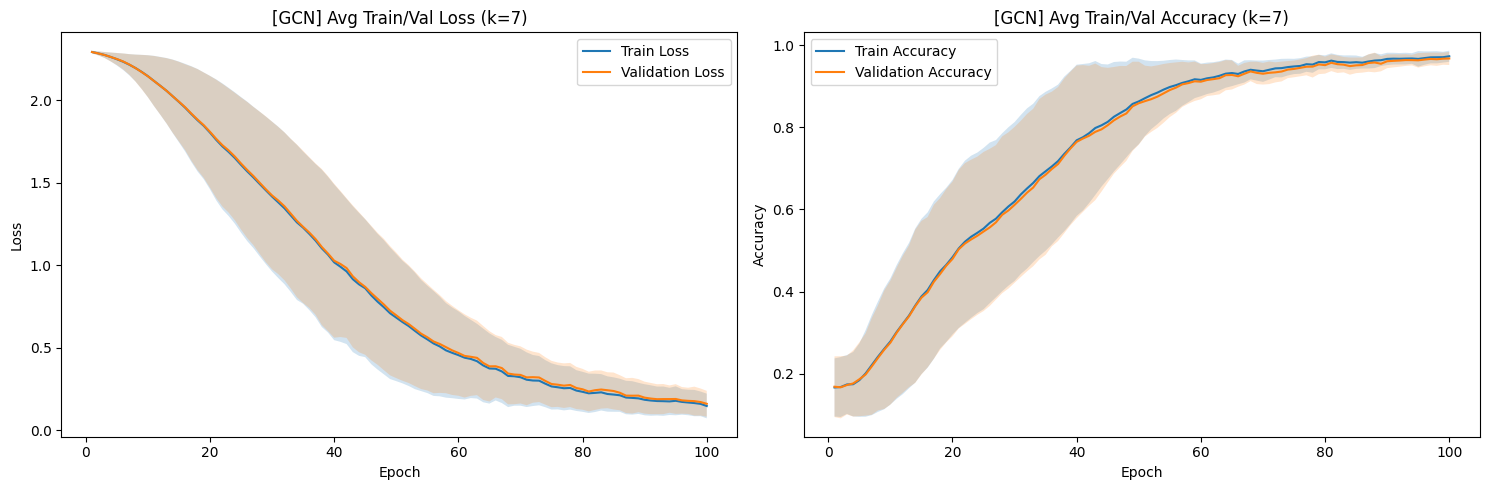

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_7_GAT
Using existing processed data for k_7_GAT
Starting k-fold cross-validation for GAT...

--- Fold 1/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8601, Train Acc: 0.2367, Val Loss: 1.8723, Val Acc: 0.2189
Epoch 020, Train Loss: 1.4866, Train Acc: 0.3326, Val Loss: 1.4907, Val Acc: 0.3358
Epoch 030, Train Loss: 0.9430, Train Acc: 0.6679, Val Loss: 0.9349, Val Acc: 0.6679
Epoch 040, Train Loss: 0.4705, Train Acc: 0.8927, Val Loss: 0.4676, Val Acc: 0.8955
Epoch 050, Train Loss: 0.2145, Train Acc: 0.9644, Val Loss: 0.2348, Val Acc: 0.9652
Epoch 060, Train Loss: 0.1680, Train Acc: 0.9748, Val Loss: 0.1641, Val Acc: 0.9739
Epoch 070, Train Loss: 0.0735, Train Acc: 0.9933, Val Loss: 0.0877, Val Acc: 0.9925
Epoch 080, Train Loss: 0.1023, Train Acc: 0.9809, Val Loss: 0.1251, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0539, Train Acc: 0.9927, Val Loss: 0.0717, Val Acc: 0.9900


[I 2025-01-26 16:39:46,193] Trial 0 finished with value: 0.050182659178972244 and parameters: {'hidden_channels': 64, 'dropout': 0.27081475429800167, 'lr': 0.003317466208478783}. Best is trial 0 with value: 0.050182659178972244.


Epoch 100, Train Loss: 0.0371, Train Acc: 0.9942, Val Loss: 0.0502, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2107, Train Acc: 0.2546, Val Loss: 2.2125, Val Acc: 0.2612
Epoch 020, Train Loss: 2.1165, Train Acc: 0.1017, Val Loss: 2.1160, Val Acc: 0.1032
Epoch 030, Train Loss: 2.0723, Train Acc: 0.1041, Val Loss: 2.0643, Val Acc: 0.1082
Epoch 040, Train Loss: 1.8105, Train Acc: 0.1531, Val Loss: 1.7989, Val Acc: 0.1592
Epoch 050, Train Loss: 1.2107, Train Acc: 0.3984, Val Loss: 1.2066, Val Acc: 0.4154
Epoch 060, Train Loss: 0.5421, Train Acc: 0.8107, Val Loss: 0.5474, Val Acc: 0.7985
Epoch 070, Train Loss: 0.2170, Train Acc: 0.9571, Val Loss: 0.2372, Val Acc: 0.9378
Epoch 080, Train Loss: 0.0987, Train Acc: 0.9899, Val Loss: 0.1051, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0658, Train Acc: 0.9919, Val Loss: 0.0773, Val Acc: 0.9900


[I 2025-01-26 16:39:50,132] Trial 1 finished with value: 0.13726022839546204 and parameters: {'hidden_channels': 49, 'dropout': 0.3265682296920159, 'lr': 0.0006253403375875446}. Best is trial 0 with value: 0.050182659178972244.


Epoch 100, Train Loss: 0.1049, Train Acc: 0.9762, Val Loss: 0.1373, Val Acc: 0.9751


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2326, Train Acc: 0.1083, Val Loss: 2.2348, Val Acc: 0.1032
Epoch 020, Train Loss: 2.1471, Train Acc: 0.1031, Val Loss: 2.1487, Val Acc: 0.1057
Epoch 030, Train Loss: 2.0399, Train Acc: 0.1101, Val Loss: 2.0424, Val Acc: 0.1144
Epoch 040, Train Loss: 1.7595, Train Acc: 0.1588, Val Loss: 1.7636, Val Acc: 0.1580
Epoch 050, Train Loss: 1.2206, Train Acc: 0.4273, Val Loss: 1.2254, Val Acc: 0.4391
Epoch 060, Train Loss: 0.6390, Train Acc: 0.8449, Val Loss: 0.6492, Val Acc: 0.8408
Epoch 070, Train Loss: 0.2887, Train Acc: 0.9625, Val Loss: 0.3051, Val Acc: 0.9465
Epoch 080, Train Loss: 0.1495, Train Acc: 0.9882, Val Loss: 0.1660, Val Acc: 0.9838
Epoch 090, Train Loss: 0.0973, Train Acc: 0.9837, Val Loss: 0.1083, Val Acc: 0.9826


[I 2025-01-26 16:39:54,673] Trial 2 finished with value: 0.08862895518541336 and parameters: {'hidden_channels': 59, 'dropout': 0.46212350882471037, 'lr': 0.0004052466178729346}. Best is trial 0 with value: 0.050182659178972244.


Epoch 100, Train Loss: 0.0808, Train Acc: 0.9862, Val Loss: 0.0886, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.6892, Train Acc: 0.5099, Val Loss: 1.7086, Val Acc: 0.4975
Epoch 020, Train Loss: 1.1557, Train Acc: 0.5974, Val Loss: 1.1956, Val Acc: 0.5771
Epoch 030, Train Loss: 0.7271, Train Acc: 0.7466, Val Loss: 0.7613, Val Acc: 0.7413
Epoch 040, Train Loss: 0.4196, Train Acc: 0.8645, Val Loss: 0.4617, Val Acc: 0.8545
Epoch 050, Train Loss: 0.1687, Train Acc: 0.9648, Val Loss: 0.1873, Val Acc: 0.9689
Epoch 060, Train Loss: 0.1584, Train Acc: 0.9631, Val Loss: 0.1799, Val Acc: 0.9627
Epoch 070, Train Loss: 0.1677, Train Acc: 0.9619, Val Loss: 0.1996, Val Acc: 0.9590
Epoch 080, Train Loss: 0.0843, Train Acc: 0.9844, Val Loss: 0.1114, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0442, Train Acc: 0.9944, Val Loss: 0.0589, Val Acc: 0.9925


[I 2025-01-26 16:39:58,753] Trial 3 finished with value: 0.09154592454433441 and parameters: {'hidden_channels': 51, 'dropout': 0.24674229399890657, 'lr': 0.004321153687798264}. Best is trial 0 with value: 0.050182659178972244.


Epoch 100, Train Loss: 0.0691, Train Acc: 0.9830, Val Loss: 0.0915, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2541, Train Acc: 0.1787, Val Loss: 2.2572, Val Acc: 0.1741
Epoch 020, Train Loss: 2.2100, Train Acc: 0.1031, Val Loss: 2.2123, Val Acc: 0.1032
Epoch 030, Train Loss: 2.1732, Train Acc: 0.1023, Val Loss: 2.1737, Val Acc: 0.1032
Epoch 040, Train Loss: 1.9477, Train Acc: 0.1372, Val Loss: 1.9488, Val Acc: 0.1405
Epoch 050, Train Loss: 1.4009, Train Acc: 0.3240, Val Loss: 1.4050, Val Acc: 0.3197
Epoch 060, Train Loss: 0.7255, Train Acc: 0.7933, Val Loss: 0.7403, Val Acc: 0.7848
Epoch 070, Train Loss: 0.3101, Train Acc: 0.9547, Val Loss: 0.3260, Val Acc: 0.9502
Epoch 080, Train Loss: 0.1400, Train Acc: 0.9837, Val Loss: 0.1513, Val Acc: 0.9838
Epoch 090, Train Loss: 0.0993, Train Acc: 0.9869, Val Loss: 0.1144, Val Acc: 0.9888


[I 2025-01-26 16:40:03,318] Trial 4 finished with value: 0.08757807314395905 and parameters: {'hidden_channels': 56, 'dropout': 0.32297761717046425, 'lr': 0.00036262025481588163}. Best is trial 0 with value: 0.050182659178972244.


Epoch 100, Train Loss: 0.0739, Train Acc: 0.9913, Val Loss: 0.0876, Val Acc: 0.9913
  Fold 1 - Optuna Best Trial Val Loss: 0.0502
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 64, 'dropout': 0.27081475429800167, 'lr': 0.003317466208478783}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8828, Train Acc: 0.2419, Val Loss: 1.8939, Val Acc: 0.2351
Epoch 020, Train Loss: 1.5470, Train Acc: 0.2885, Val Loss: 1.5638, Val Acc: 0.2886
Epoch 030, Train Loss: 0.8928, Train Acc: 0.6880, Val Loss: 0.9067, Val Acc: 0.6741
Epoch 040, Train Loss: 0.4726, Train Acc: 0.8818, Val Loss: 0.4941, Val Acc: 0.8856
Epoch 050, Train Loss: 0.2082, Train Acc: 0.9591, Val Loss: 0.2211, Val Acc: 0.9515
Epoch 060, Train Loss: 0.2221, Train Acc: 0.9600, Val Loss: 0.2356, Val Acc: 0.9515
Epoch 070, Train Loss: 0.1378, Train Acc: 0.9708, Val Loss: 0.1683, Val Acc: 0.9614
Epoch 080, Train Loss: 0.1014, Train Acc: 0.9849, Val Loss: 0.1315, Val Acc: 0.9838


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1073, Train Acc: 0.9704, Val Loss: 0.1248, Val Acc: 0.9664
Early stopping at epoch 91
  Fold 1 Test Metrics:
  Accuracy: 0.9751
  Precision: 0.9769
  Recall: 0.9751
  F1: 0.9752

--- Fold 2/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1035, Train Acc: 0.1867, Val Loss: 2.0962, Val Acc: 0.1953
Epoch 020, Train Loss: 2.0155, Train Acc: 0.1543, Val Loss: 2.0006, Val Acc: 0.1530
Epoch 030, Train Loss: 1.8012, Train Acc: 0.1826, Val Loss: 1.7819, Val Acc: 0.1940
Epoch 040, Train Loss: 1.1162, Train Acc: 0.4836, Val Loss: 1.0937, Val Acc: 0.4851
Epoch 050, Train Loss: 0.4945, Train Acc: 0.8723, Val Loss: 0.4927, Val Acc: 0.8831
Epoch 060, Train Loss: 0.2369, Train Acc: 0.9754, Val Loss: 0.2330, Val Acc: 0.9714
Epoch 070, Train Loss: 0.1078, Train Acc: 0.9851, Val Loss: 0.1225, Val Acc: 0.9838
Epoch 080, Train Loss: 0.1132, Train Acc: 0.9793, Val Loss: 0.1187, Val Acc: 0.9701
Epoch 090, Train Loss: 0.0619, Train Acc: 0.9921, Val Loss: 0.0602, Val Acc: 0.9925


[I 2025-01-26 16:40:11,658] Trial 0 finished with value: 0.05128328502178192 and parameters: {'hidden_channels': 50, 'dropout': 0.4443398131140969, 'lr': 0.0015109362507391207}. Best is trial 0 with value: 0.05128328502178192.


Epoch 100, Train Loss: 0.0365, Train Acc: 0.9956, Val Loss: 0.0513, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2713, Train Acc: 0.1000, Val Loss: 2.2669, Val Acc: 0.1057
Epoch 020, Train Loss: 2.1957, Train Acc: 0.0992, Val Loss: 2.1875, Val Acc: 0.1020
Epoch 030, Train Loss: 2.0438, Train Acc: 0.1459, Val Loss: 2.0330, Val Acc: 0.1443
Epoch 040, Train Loss: 1.7578, Train Acc: 0.2339, Val Loss: 1.7429, Val Acc: 0.2425
Epoch 050, Train Loss: 1.2811, Train Acc: 0.5366, Val Loss: 1.2743, Val Acc: 0.5199
Epoch 060, Train Loss: 0.7256, Train Acc: 0.8485, Val Loss: 0.7258, Val Acc: 0.8358
Epoch 070, Train Loss: 0.3461, Train Acc: 0.9564, Val Loss: 0.3567, Val Acc: 0.9527
Epoch 080, Train Loss: 0.1726, Train Acc: 0.9829, Val Loss: 0.1996, Val Acc: 0.9764
Epoch 090, Train Loss: 0.1122, Train Acc: 0.9899, Val Loss: 0.1423, Val Acc: 0.9826


[I 2025-01-26 16:40:14,786] Trial 1 finished with value: 0.11826808750629425 and parameters: {'hidden_channels': 39, 'dropout': 0.4479963319816136, 'lr': 0.00041711654241050674}. Best is trial 0 with value: 0.05128328502178192.


Epoch 100, Train Loss: 0.0889, Train Acc: 0.9896, Val Loss: 0.1183, Val Acc: 0.9801


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1653, Train Acc: 0.1615, Val Loss: 2.1629, Val Acc: 0.1667
Epoch 020, Train Loss: 2.0732, Train Acc: 0.1705, Val Loss: 2.0769, Val Acc: 0.1654
Epoch 030, Train Loss: 1.8044, Train Acc: 0.1940, Val Loss: 1.8394, Val Acc: 0.1940
Epoch 040, Train Loss: 1.1353, Train Acc: 0.4792, Val Loss: 1.1882, Val Acc: 0.4527
Epoch 050, Train Loss: 0.5320, Train Acc: 0.8256, Val Loss: 0.6100, Val Acc: 0.7960
Epoch 060, Train Loss: 0.2370, Train Acc: 0.9634, Val Loss: 0.3272, Val Acc: 0.9440
Epoch 070, Train Loss: 0.1456, Train Acc: 0.9737, Val Loss: 0.2290, Val Acc: 0.9614
Epoch 080, Train Loss: 0.0910, Train Acc: 0.9911, Val Loss: 0.1638, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0626, Train Acc: 0.9865, Val Loss: 0.0896, Val Acc: 0.9826


[I 2025-01-26 16:40:19,046] Trial 2 finished with value: 0.07922246307134628 and parameters: {'hidden_channels': 53, 'dropout': 0.38786636657410684, 'lr': 0.0013692497052811407}. Best is trial 0 with value: 0.05128328502178192.


Epoch 100, Train Loss: 0.0424, Train Acc: 0.9960, Val Loss: 0.0792, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1544, Train Acc: 0.1420, Val Loss: 2.1450, Val Acc: 0.1430
Epoch 020, Train Loss: 1.9581, Train Acc: 0.1086, Val Loss: 1.9530, Val Acc: 0.1082
Epoch 030, Train Loss: 1.6459, Train Acc: 0.1974, Val Loss: 1.6561, Val Acc: 0.1891
Epoch 040, Train Loss: 1.1265, Train Acc: 0.4715, Val Loss: 1.1338, Val Acc: 0.4701
Epoch 050, Train Loss: 0.6477, Train Acc: 0.7378, Val Loss: 0.6729, Val Acc: 0.7090
Epoch 060, Train Loss: 0.2669, Train Acc: 0.9396, Val Loss: 0.3156, Val Acc: 0.9241
Epoch 070, Train Loss: 0.1400, Train Acc: 0.9746, Val Loss: 0.1753, Val Acc: 0.9689
Epoch 080, Train Loss: 0.0762, Train Acc: 0.9922, Val Loss: 0.1108, Val Acc: 0.9851
Epoch 090, Train Loss: 0.0499, Train Acc: 0.9932, Val Loss: 0.0825, Val Acc: 0.9876


[I 2025-01-26 16:40:21,452] Trial 3 finished with value: 0.03894062712788582 and parameters: {'hidden_channels': 28, 'dropout': 0.2864256987995812, 'lr': 0.001608918959560419}. Best is trial 3 with value: 0.03894062712788582.


Epoch 100, Train Loss: 0.0322, Train Acc: 0.9961, Val Loss: 0.0389, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2312, Train Acc: 0.1101, Val Loss: 2.2261, Val Acc: 0.1082
Epoch 020, Train Loss: 2.1845, Train Acc: 0.1580, Val Loss: 2.1821, Val Acc: 0.1617
Epoch 030, Train Loss: 2.1570, Train Acc: 0.1207, Val Loss: 2.1544, Val Acc: 0.1182
Epoch 040, Train Loss: 1.8565, Train Acc: 0.1338, Val Loss: 1.8655, Val Acc: 0.1281
Epoch 050, Train Loss: 1.1713, Train Acc: 0.3858, Val Loss: 1.1903, Val Acc: 0.3881
Epoch 060, Train Loss: 0.5063, Train Acc: 0.8524, Val Loss: 0.5236, Val Acc: 0.8557
Epoch 070, Train Loss: 0.1961, Train Acc: 0.9810, Val Loss: 0.2449, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0899, Train Acc: 0.9871, Val Loss: 0.1313, Val Acc: 0.9789
Epoch 090, Train Loss: 0.0758, Train Acc: 0.9890, Val Loss: 0.0856, Val Acc: 0.9851


[I 2025-01-26 16:40:24,907] Trial 4 finished with value: 0.06828711181879044 and parameters: {'hidden_channels': 42, 'dropout': 0.2503555606631822, 'lr': 0.0006718271763363756}. Best is trial 3 with value: 0.03894062712788582.


Epoch 100, Train Loss: 0.0567, Train Acc: 0.9918, Val Loss: 0.0683, Val Acc: 0.9900
  Fold 2 - Optuna Best Trial Val Loss: 0.0389
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 28, 'dropout': 0.2864256987995812, 'lr': 0.001608918959560419}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1631, Train Acc: 0.1050, Val Loss: 2.1603, Val Acc: 0.1095
Epoch 020, Train Loss: 2.0239, Train Acc: 0.1117, Val Loss: 2.0365, Val Acc: 0.1107
Epoch 030, Train Loss: 1.8802, Train Acc: 0.1324, Val Loss: 1.9060, Val Acc: 0.1368
Epoch 040, Train Loss: 1.2592, Train Acc: 0.3965, Val Loss: 1.2802, Val Acc: 0.3968
Epoch 050, Train Loss: 0.5482, Train Acc: 0.8093, Val Loss: 0.5825, Val Acc: 0.7998
Epoch 060, Train Loss: 0.2374, Train Acc: 0.9647, Val Loss: 0.3045, Val Acc: 0.9490
Epoch 070, Train Loss: 0.1135, Train Acc: 0.9846, Val Loss: 0.1646, Val Acc: 0.9739
Epoch 080, Train Loss: 0.1514, Train Acc: 0.9642, Val Loss: 0.2456, Val Acc: 0.9415
Epoch 090, Train Loss: 0.0724, Train Acc: 0.9918, Val Loss: 0.1209, Val Acc: 0.9863


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0748, Train Acc: 0.9830, Val Loss: 0.1206, Val Acc: 0.9726
  Fold 2 Test Metrics:
  Accuracy: 0.9776
  Precision: 0.9808
  Recall: 0.9776
  F1: 0.9781

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1923, Train Acc: 0.1062, Val Loss: 2.1939, Val Acc: 0.1082
Epoch 020, Train Loss: 2.1704, Train Acc: 0.1016, Val Loss: 2.1708, Val Acc: 0.1032
Epoch 030, Train Loss: 2.0817, Train Acc: 0.1016, Val Loss: 2.0770, Val Acc: 0.1032
Epoch 040, Train Loss: 1.6282, Train Acc: 0.1895, Val Loss: 1.6260, Val Acc: 0.1878
Epoch 050, Train Loss: 0.8969, Train Acc: 0.6051, Val Loss: 0.8980, Val Acc: 0.6244
Epoch 060, Train Loss: 0.3614, Train Acc: 0.9204, Val Loss: 0.3611, Val Acc: 0.9129
Epoch 070, Train Loss: 0.1333, Train Acc: 0.9849, Val Loss: 0.1367, Val Acc: 0.9863
Epoch 080, Train Loss: 0.0982, Train Acc: 0.9841, Val Loss: 0.0883, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0935, Train Acc: 0.9820, Val Loss: 0.0820, Val Acc: 0.9813


[I 2025-01-26 16:40:31,797] Trial 0 finished with value: 0.061798978596925735 and parameters: {'hidden_channels': 59, 'dropout': 0.4258852894771328, 'lr': 0.000815245401859911}. Best is trial 0 with value: 0.061798978596925735.


Epoch 100, Train Loss: 0.0610, Train Acc: 0.9899, Val Loss: 0.0618, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.4125, Train Acc: 0.6090, Val Loss: 1.4254, Val Acc: 0.6007
Epoch 020, Train Loss: 0.9287, Train Acc: 0.6659, Val Loss: 0.9342, Val Acc: 0.6716
Epoch 030, Train Loss: 0.5088, Train Acc: 0.8493, Val Loss: 0.5309, Val Acc: 0.8420
Epoch 040, Train Loss: 0.3620, Train Acc: 0.8927, Val Loss: 0.3364, Val Acc: 0.9030
Epoch 050, Train Loss: 0.1492, Train Acc: 0.9810, Val Loss: 0.1468, Val Acc: 0.9826
Epoch 060, Train Loss: 0.2338, Train Acc: 0.9627, Val Loss: 0.2590, Val Acc: 0.9577
Epoch 070, Train Loss: 0.1766, Train Acc: 0.9602, Val Loss: 0.1388, Val Acc: 0.9614
Epoch 080, Train Loss: 0.0572, Train Acc: 0.9946, Val Loss: 0.0531, Val Acc: 0.9950
Epoch 090, Train Loss: 0.0655, Train Acc: 0.9877, Val Loss: 0.0635, Val Acc: 0.9863


[I 2025-01-26 16:40:36,263] Trial 1 finished with value: 0.09274537116289139 and parameters: {'hidden_channels': 59, 'dropout': 0.47521366552764643, 'lr': 0.0062706661688822305}. Best is trial 0 with value: 0.061798978596925735.


Epoch 100, Train Loss: 0.0771, Train Acc: 0.9894, Val Loss: 0.0927, Val Acc: 0.9876


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.3729, Train Acc: 0.6200, Val Loss: 1.3761, Val Acc: 0.6194
Epoch 020, Train Loss: 0.9599, Train Acc: 0.6295, Val Loss: 0.9689, Val Acc: 0.6306
Epoch 030, Train Loss: 0.5621, Train Acc: 0.7937, Val Loss: 0.5897, Val Acc: 0.7711
Epoch 040, Train Loss: 0.2100, Train Acc: 0.9589, Val Loss: 0.2207, Val Acc: 0.9502
Epoch 050, Train Loss: 0.2264, Train Acc: 0.9406, Val Loss: 0.2479, Val Acc: 0.9366
Epoch 060, Train Loss: 0.1328, Train Acc: 0.9737, Val Loss: 0.1201, Val Acc: 0.9739
Epoch 070, Train Loss: 0.2608, Train Acc: 0.9535, Val Loss: 0.2564, Val Acc: 0.9552
Epoch 080, Train Loss: 0.0827, Train Acc: 0.9848, Val Loss: 0.0826, Val Acc: 0.9801
Epoch 090, Train Loss: 0.1433, Train Acc: 0.9711, Val Loss: 0.1541, Val Acc: 0.9689


[I 2025-01-26 16:40:39,847] Trial 2 finished with value: 0.12031557410955429 and parameters: {'hidden_channels': 47, 'dropout': 0.20417322269853744, 'lr': 0.007260574265023227}. Best is trial 0 with value: 0.061798978596925735.


Early stopping at epoch 100


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2178, Train Acc: 0.2478, Val Loss: 2.2218, Val Acc: 0.2438
Epoch 020, Train Loss: 2.1161, Train Acc: 0.1016, Val Loss: 2.1179, Val Acc: 0.1032
Epoch 030, Train Loss: 2.0059, Train Acc: 0.1072, Val Loss: 2.0111, Val Acc: 0.1070
Epoch 040, Train Loss: 1.7402, Train Acc: 0.1611, Val Loss: 1.7444, Val Acc: 0.1580
Epoch 050, Train Loss: 1.1984, Train Acc: 0.4005, Val Loss: 1.2043, Val Acc: 0.4030
Epoch 060, Train Loss: 0.5583, Train Acc: 0.8455, Val Loss: 0.5820, Val Acc: 0.8321
Epoch 070, Train Loss: 0.2262, Train Acc: 0.9751, Val Loss: 0.2453, Val Acc: 0.9677
Epoch 080, Train Loss: 0.1123, Train Acc: 0.9888, Val Loss: 0.1224, Val Acc: 0.9838
Epoch 090, Train Loss: 0.0854, Train Acc: 0.9866, Val Loss: 0.0844, Val Acc: 0.9863


[I 2025-01-26 16:40:42,640] Trial 3 finished with value: 0.13239522278308868 and parameters: {'hidden_channels': 33, 'dropout': 0.3838877802025551, 'lr': 0.0007373587425714042}. Best is trial 0 with value: 0.061798978596925735.


Epoch 100, Train Loss: 0.1467, Train Acc: 0.9698, Val Loss: 0.1324, Val Acc: 0.9701


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.3649, Train Acc: 0.6580, Val Loss: 1.3914, Val Acc: 0.6592
Epoch 020, Train Loss: 0.8713, Train Acc: 0.7374, Val Loss: 0.8919, Val Acc: 0.7438
Epoch 030, Train Loss: 0.5543, Train Acc: 0.8740, Val Loss: 0.6013, Val Acc: 0.8532
Epoch 040, Train Loss: 0.2287, Train Acc: 0.9536, Val Loss: 0.2274, Val Acc: 0.9490
Epoch 050, Train Loss: 0.2513, Train Acc: 0.9613, Val Loss: 0.2806, Val Acc: 0.9614
Epoch 060, Train Loss: 0.1233, Train Acc: 0.9715, Val Loss: 0.1337, Val Acc: 0.9726
Epoch 070, Train Loss: 0.1635, Train Acc: 0.9656, Val Loss: 0.1687, Val Acc: 0.9701
Epoch 080, Train Loss: 0.2441, Train Acc: 0.9622, Val Loss: 0.2868, Val Acc: 0.9590


[I 2025-01-26 16:40:46,229] Trial 4 finished with value: 0.12278109043836594 and parameters: {'hidden_channels': 52, 'dropout': 0.28203253750853796, 'lr': 0.008085258228997394}. Best is trial 0 with value: 0.061798978596925735.


Early stopping at epoch 88
  Fold 3 - Optuna Best Trial Val Loss: 0.0618
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 59, 'dropout': 0.4258852894771328, 'lr': 0.000815245401859911}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1979, Train Acc: 0.1587, Val Loss: 2.2012, Val Acc: 0.1617
Epoch 020, Train Loss: 2.1720, Train Acc: 0.1016, Val Loss: 2.1711, Val Acc: 0.1032
Epoch 030, Train Loss: 2.1655, Train Acc: 0.1118, Val Loss: 2.1626, Val Acc: 0.1082
Epoch 040, Train Loss: 1.7765, Train Acc: 0.1803, Val Loss: 1.7815, Val Acc: 0.1828
Epoch 050, Train Loss: 1.0387, Train Acc: 0.4995, Val Loss: 1.0364, Val Acc: 0.5012
Epoch 060, Train Loss: 0.4015, Train Acc: 0.8815, Val Loss: 0.4244, Val Acc: 0.8507
Epoch 070, Train Loss: 0.1819, Train Acc: 0.9799, Val Loss: 0.2031, Val Acc: 0.9789
Epoch 080, Train Loss: 0.1152, Train Acc: 0.9781, Val Loss: 0.1192, Val Acc: 0.9838
Epoch 090, Train Loss: 0.0596, Train Acc: 0.9932, Val Loss: 0.0529, Val Acc: 0.9963


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1112, Train Acc: 0.9698, Val Loss: 0.1098, Val Acc: 0.9701
  Fold 3 Test Metrics:
  Accuracy: 0.9577
  Precision: 0.9635
  Recall: 0.9577
  F1: 0.9586

--- Fold 4/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2984, Train Acc: 0.0997, Val Loss: 2.2994, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2716, Train Acc: 0.0997, Val Loss: 2.2761, Val Acc: 0.0958
Epoch 030, Train Loss: 2.1675, Train Acc: 0.1125, Val Loss: 2.1777, Val Acc: 0.1007
Epoch 040, Train Loss: 1.9480, Train Acc: 0.2131, Val Loss: 1.9712, Val Acc: 0.2164
Epoch 050, Train Loss: 1.5727, Train Acc: 0.5234, Val Loss: 1.6084, Val Acc: 0.5087
Epoch 060, Train Loss: 1.0866, Train Acc: 0.7871, Val Loss: 1.1260, Val Acc: 0.7662
Epoch 070, Train Loss: 0.6447, Train Acc: 0.9123, Val Loss: 0.6808, Val Acc: 0.8893
Epoch 080, Train Loss: 0.3880, Train Acc: 0.9505, Val Loss: 0.4233, Val Acc: 0.9453
Epoch 090, Train Loss: 0.2682, Train Acc: 0.9572, Val Loss: 0.2990, Val Acc: 0.9490


[I 2025-01-26 16:40:53,233] Trial 0 finished with value: 0.23015956580638885 and parameters: {'hidden_channels': 30, 'dropout': 0.36188033260407265, 'lr': 0.00020822148850475412}. Best is trial 0 with value: 0.23015956580638885.


Epoch 100, Train Loss: 0.2057, Train Acc: 0.9756, Val Loss: 0.2302, Val Acc: 0.9764


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7131, Train Acc: 0.3756, Val Loss: 1.7354, Val Acc: 0.3582
Epoch 020, Train Loss: 1.1315, Train Acc: 0.6231, Val Loss: 1.1782, Val Acc: 0.5933
Epoch 030, Train Loss: 0.6611, Train Acc: 0.7992, Val Loss: 0.6789, Val Acc: 0.7985
Epoch 040, Train Loss: 0.3219, Train Acc: 0.9404, Val Loss: 0.3500, Val Acc: 0.9353
Epoch 050, Train Loss: 0.1904, Train Acc: 0.9636, Val Loss: 0.1833, Val Acc: 0.9726
Epoch 060, Train Loss: 0.1127, Train Acc: 0.9827, Val Loss: 0.1359, Val Acc: 0.9801
Epoch 070, Train Loss: 0.1818, Train Acc: 0.9586, Val Loss: 0.2041, Val Acc: 0.9565
Epoch 080, Train Loss: 0.0620, Train Acc: 0.9905, Val Loss: 0.0719, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0400, Train Acc: 0.9953, Val Loss: 0.0424, Val Acc: 0.9963


[I 2025-01-26 16:40:56,818] Trial 1 finished with value: 0.0811847448348999 and parameters: {'hidden_channels': 47, 'dropout': 0.30355289702232524, 'lr': 0.004685583384992841}. Best is trial 1 with value: 0.0811847448348999.


Epoch 100, Train Loss: 0.0514, Train Acc: 0.9949, Val Loss: 0.0812, Val Acc: 0.9913
Epoch 010, Train Loss: 1.8557, Train Acc: 0.4816, Val Loss: 1.8718, Val Acc: 0.4689


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.1807, Train Acc: 0.6471, Val Loss: 1.2071, Val Acc: 0.6119
Epoch 030, Train Loss: 0.7033, Train Acc: 0.8180, Val Loss: 0.7515, Val Acc: 0.7910
Epoch 040, Train Loss: 0.3381, Train Acc: 0.9277, Val Loss: 0.3663, Val Acc: 0.9216
Epoch 050, Train Loss: 0.1953, Train Acc: 0.9642, Val Loss: 0.2259, Val Acc: 0.9590
Epoch 060, Train Loss: 0.1141, Train Acc: 0.9760, Val Loss: 0.1290, Val Acc: 0.9764
Epoch 070, Train Loss: 0.1877, Train Acc: 0.9572, Val Loss: 0.1956, Val Acc: 0.9577
Epoch 080, Train Loss: 0.0800, Train Acc: 0.9897, Val Loss: 0.1099, Val Acc: 0.9851
Epoch 090, Train Loss: 0.1374, Train Acc: 0.9697, Val Loss: 0.2086, Val Acc: 0.9627


[I 2025-01-26 16:40:58,761] Trial 2 finished with value: 0.05797839164733887 and parameters: {'hidden_channels': 22, 'dropout': 0.2865569695625533, 'lr': 0.0050508677452439634}. Best is trial 2 with value: 0.05797839164733887.


Epoch 100, Train Loss: 0.0573, Train Acc: 0.9857, Val Loss: 0.0580, Val Acc: 0.9863
Epoch 010, Train Loss: 2.2683, Train Acc: 0.1146, Val Loss: 2.2745, Val Acc: 0.1070


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1900, Train Acc: 0.1254, Val Loss: 2.2008, Val Acc: 0.1157
Epoch 030, Train Loss: 2.0252, Train Acc: 0.1986, Val Loss: 2.0433, Val Acc: 0.1654
Epoch 040, Train Loss: 1.7638, Train Acc: 0.3682, Val Loss: 1.7817, Val Acc: 0.3371
Epoch 050, Train Loss: 1.3569, Train Acc: 0.6702, Val Loss: 1.3889, Val Acc: 0.6430
Epoch 060, Train Loss: 0.8749, Train Acc: 0.8547, Val Loss: 0.9127, Val Acc: 0.8234
Epoch 070, Train Loss: 0.4919, Train Acc: 0.9334, Val Loss: 0.5235, Val Acc: 0.9179
Epoch 080, Train Loss: 0.3018, Train Acc: 0.9575, Val Loss: 0.3215, Val Acc: 0.9428
Epoch 090, Train Loss: 0.2068, Train Acc: 0.9729, Val Loss: 0.2253, Val Acc: 0.9677


[I 2025-01-26 16:41:00,366] Trial 3 finished with value: 0.17751595377922058 and parameters: {'hidden_channels': 16, 'dropout': 0.3183057077045384, 'lr': 0.000619417251455606}. Best is trial 2 with value: 0.05797839164733887.


Epoch 100, Train Loss: 0.1653, Train Acc: 0.9712, Val Loss: 0.1775, Val Acc: 0.9652
Epoch 010, Train Loss: 2.1033, Train Acc: 0.2669, Val Loss: 2.1173, Val Acc: 0.2537


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8152, Train Acc: 0.1918, Val Loss: 1.8455, Val Acc: 0.1754
Epoch 030, Train Loss: 1.4549, Train Acc: 0.3097, Val Loss: 1.4824, Val Acc: 0.3197
Epoch 040, Train Loss: 0.8897, Train Acc: 0.7003, Val Loss: 0.9338, Val Acc: 0.6841
Epoch 050, Train Loss: 0.4287, Train Acc: 0.8910, Val Loss: 0.4469, Val Acc: 0.8868
Epoch 060, Train Loss: 0.2527, Train Acc: 0.9512, Val Loss: 0.2982, Val Acc: 0.9391
Epoch 070, Train Loss: 0.1943, Train Acc: 0.9586, Val Loss: 0.2367, Val Acc: 0.9515
Epoch 080, Train Loss: 0.1130, Train Acc: 0.9750, Val Loss: 0.1471, Val Acc: 0.9726
Epoch 090, Train Loss: 0.1100, Train Acc: 0.9838, Val Loss: 0.1488, Val Acc: 0.9826


[I 2025-01-26 16:41:02,192] Trial 4 finished with value: 0.06798113137483597 and parameters: {'hidden_channels': 19, 'dropout': 0.35181298013216156, 'lr': 0.0023894542868514723}. Best is trial 2 with value: 0.05797839164733887.


Epoch 100, Train Loss: 0.0549, Train Acc: 0.9933, Val Loss: 0.0680, Val Acc: 0.9913
  Fold 4 - Optuna Best Trial Val Loss: 0.0580
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 22, 'dropout': 0.2865569695625533, 'lr': 0.0050508677452439634}
Epoch 010, Train Loss: 1.7772, Train Acc: 0.6006, Val Loss: 1.8010, Val Acc: 0.5808


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2064, Train Acc: 0.5999, Val Loss: 1.2502, Val Acc: 0.5634
Epoch 030, Train Loss: 0.8103, Train Acc: 0.7480, Val Loss: 0.8783, Val Acc: 0.7376
Epoch 040, Train Loss: 0.3654, Train Acc: 0.8944, Val Loss: 0.3821, Val Acc: 0.8930
Epoch 050, Train Loss: 0.1667, Train Acc: 0.9673, Val Loss: 0.1877, Val Acc: 0.9652
Epoch 060, Train Loss: 0.1521, Train Acc: 0.9698, Val Loss: 0.1816, Val Acc: 0.9614
Epoch 070, Train Loss: 0.1261, Train Acc: 0.9757, Val Loss: 0.1695, Val Acc: 0.9701
Epoch 080, Train Loss: 0.2271, Train Acc: 0.9561, Val Loss: 0.2833, Val Acc: 0.9590
Epoch 090, Train Loss: 0.1136, Train Acc: 0.9728, Val Loss: 0.1584, Val Acc: 0.9664


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0370, Train Acc: 0.9958, Val Loss: 0.0430, Val Acc: 0.9925
  Fold 4 Test Metrics:
  Accuracy: 0.9975
  Precision: 0.9976
  Recall: 0.9975
  F1: 0.9975

--- Fold 5/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2615, Train Acc: 0.1014, Val Loss: 2.2587, Val Acc: 0.1045
Epoch 020, Train Loss: 2.2174, Train Acc: 0.1014, Val Loss: 2.2139, Val Acc: 0.1045
Epoch 030, Train Loss: 2.1806, Train Acc: 0.1014, Val Loss: 2.1831, Val Acc: 0.1045
Epoch 040, Train Loss: 2.0406, Train Acc: 0.1028, Val Loss: 2.0526, Val Acc: 0.1045
Epoch 050, Train Loss: 1.6040, Train Acc: 0.2140, Val Loss: 1.6314, Val Acc: 0.2152
Epoch 060, Train Loss: 0.9611, Train Acc: 0.6307, Val Loss: 1.0050, Val Acc: 0.6231
Epoch 070, Train Loss: 0.4485, Train Acc: 0.9050, Val Loss: 0.4895, Val Acc: 0.8794
Epoch 080, Train Loss: 0.1972, Train Acc: 0.9848, Val Loss: 0.2153, Val Acc: 0.9813
Epoch 090, Train Loss: 0.1117, Train Acc: 0.9919, Val Loss: 0.1279, Val Acc: 0.9888


[I 2025-01-26 16:41:08,824] Trial 0 finished with value: 0.12112630158662796 and parameters: {'hidden_channels': 64, 'dropout': 0.4042826920054715, 'lr': 0.00021023178614119634}. Best is trial 0 with value: 0.12112630158662796.


Epoch 100, Train Loss: 0.1079, Train Acc: 0.9851, Val Loss: 0.1211, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2808, Train Acc: 0.1907, Val Loss: 2.2801, Val Acc: 0.1915
Epoch 020, Train Loss: 2.2154, Train Acc: 0.1933, Val Loss: 2.2137, Val Acc: 0.1928
Epoch 030, Train Loss: 2.0894, Train Acc: 0.1333, Val Loss: 2.0847, Val Acc: 0.1381
Epoch 040, Train Loss: 1.8919, Train Acc: 0.1708, Val Loss: 1.8869, Val Acc: 0.1779
Epoch 050, Train Loss: 1.5510, Train Acc: 0.3691, Val Loss: 1.5577, Val Acc: 0.3669
Epoch 060, Train Loss: 1.0336, Train Acc: 0.7234, Val Loss: 1.0565, Val Acc: 0.7015
Epoch 070, Train Loss: 0.5341, Train Acc: 0.9256, Val Loss: 0.5646, Val Acc: 0.8993
Epoch 080, Train Loss: 0.2646, Train Acc: 0.9840, Val Loss: 0.2924, Val Acc: 0.9739
Epoch 090, Train Loss: 0.1561, Train Acc: 0.9918, Val Loss: 0.1767, Val Acc: 0.9876


[I 2025-01-26 16:41:13,413] Trial 1 finished with value: 0.11552099883556366 and parameters: {'hidden_channels': 63, 'dropout': 0.2742074624200679, 'lr': 0.00013078368545710355}. Best is trial 1 with value: 0.11552099883556366.


Epoch 100, Train Loss: 0.1062, Train Acc: 0.9893, Val Loss: 0.1155, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2255, Train Acc: 0.1129, Val Loss: 2.2248, Val Acc: 0.1119
Epoch 020, Train Loss: 2.1534, Train Acc: 0.1767, Val Loss: 2.1564, Val Acc: 0.1791
Epoch 030, Train Loss: 2.0183, Train Acc: 0.1669, Val Loss: 2.0314, Val Acc: 0.1716
Epoch 040, Train Loss: 1.6351, Train Acc: 0.2518, Val Loss: 1.6736, Val Acc: 0.2512
Epoch 050, Train Loss: 1.0470, Train Acc: 0.5830, Val Loss: 1.0990, Val Acc: 0.5460
Epoch 060, Train Loss: 0.5236, Train Acc: 0.8600, Val Loss: 0.5345, Val Acc: 0.8495
Epoch 070, Train Loss: 0.2304, Train Acc: 0.9712, Val Loss: 0.2229, Val Acc: 0.9689
Epoch 080, Train Loss: 0.0952, Train Acc: 0.9919, Val Loss: 0.1075, Val Acc: 0.9876
Epoch 090, Train Loss: 0.0845, Train Acc: 0.9902, Val Loss: 0.0906, Val Acc: 0.9851


[I 2025-01-26 16:41:17,866] Trial 2 finished with value: 0.05860532820224762 and parameters: {'hidden_channels': 56, 'dropout': 0.40049287437032227, 'lr': 0.0006116176044632456}. Best is trial 2 with value: 0.05860532820224762.


Epoch 100, Train Loss: 0.0529, Train Acc: 0.9949, Val Loss: 0.0586, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2548, Train Acc: 0.1627, Val Loss: 2.2542, Val Acc: 0.1580
Epoch 020, Train Loss: 2.1634, Train Acc: 0.1053, Val Loss: 2.1678, Val Acc: 0.1045
Epoch 030, Train Loss: 2.0191, Train Acc: 0.1031, Val Loss: 2.0364, Val Acc: 0.1045
Epoch 040, Train Loss: 1.7465, Train Acc: 0.1436, Val Loss: 1.7799, Val Acc: 0.1405
Epoch 050, Train Loss: 1.2299, Train Acc: 0.3808, Val Loss: 1.2743, Val Acc: 0.3557
Epoch 060, Train Loss: 0.6314, Train Acc: 0.8300, Val Loss: 0.6804, Val Acc: 0.7910
Epoch 070, Train Loss: 0.2561, Train Acc: 0.9754, Val Loss: 0.2798, Val Acc: 0.9714
Epoch 080, Train Loss: 0.1385, Train Acc: 0.9874, Val Loss: 0.1531, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0910, Train Acc: 0.9910, Val Loss: 0.1021, Val Acc: 0.9838


[I 2025-01-26 16:41:20,378] Trial 3 finished with value: 0.06869042664766312 and parameters: {'hidden_channels': 30, 'dropout': 0.3265912673952277, 'lr': 0.0006020216925253139}. Best is trial 2 with value: 0.05860532820224762.


Epoch 100, Train Loss: 0.0682, Train Acc: 0.9868, Val Loss: 0.0687, Val Acc: 0.9888
Epoch 010, Train Loss: 1.6646, Train Acc: 0.5007, Val Loss: 1.6666, Val Acc: 0.4602


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.0149, Train Acc: 0.6911, Val Loss: 1.0235, Val Acc: 0.6729
Epoch 030, Train Loss: 0.5641, Train Acc: 0.8521, Val Loss: 0.6153, Val Acc: 0.8321
Epoch 040, Train Loss: 0.2887, Train Acc: 0.9260, Val Loss: 0.3065, Val Acc: 0.9167
Epoch 050, Train Loss: 0.1397, Train Acc: 0.9754, Val Loss: 0.1534, Val Acc: 0.9689
Epoch 060, Train Loss: 0.1050, Train Acc: 0.9815, Val Loss: 0.1286, Val Acc: 0.9751
Epoch 070, Train Loss: 0.0929, Train Acc: 0.9743, Val Loss: 0.1050, Val Acc: 0.9664
Epoch 080, Train Loss: 0.0802, Train Acc: 0.9866, Val Loss: 0.0443, Val Acc: 0.9950
Epoch 090, Train Loss: 0.0828, Train Acc: 0.9832, Val Loss: 0.0740, Val Acc: 0.9813


[I 2025-01-26 16:41:22,318] Trial 4 finished with value: 0.03889681026339531 and parameters: {'hidden_channels': 22, 'dropout': 0.3301064933341019, 'lr': 0.006282925401063535}. Best is trial 4 with value: 0.03889681026339531.


Epoch 100, Train Loss: 0.0357, Train Acc: 0.9955, Val Loss: 0.0389, Val Acc: 0.9950
  Fold 5 - Optuna Best Trial Val Loss: 0.0389
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 22, 'dropout': 0.3301064933341019, 'lr': 0.006282925401063535}
Epoch 010, Train Loss: 1.7195, Train Acc: 0.5883, Val Loss: 1.7565, Val Acc: 0.5560


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 0.9180, Train Acc: 0.7620, Val Loss: 0.9639, Val Acc: 0.7363
Epoch 030, Train Loss: 0.5093, Train Acc: 0.8964, Val Loss: 0.5541, Val Acc: 0.8644
Epoch 040, Train Loss: 0.3340, Train Acc: 0.9186, Val Loss: 0.3122, Val Acc: 0.9154
Epoch 050, Train Loss: 0.1901, Train Acc: 0.9546, Val Loss: 0.1784, Val Acc: 0.9540
Epoch 060, Train Loss: 0.1430, Train Acc: 0.9731, Val Loss: 0.1325, Val Acc: 0.9813
Epoch 070, Train Loss: 0.1974, Train Acc: 0.9577, Val Loss: 0.1961, Val Acc: 0.9515
Epoch 080, Train Loss: 0.0734, Train Acc: 0.9877, Val Loss: 0.0790, Val Acc: 0.9876
Epoch 090, Train Loss: 0.0430, Train Acc: 0.9927, Val Loss: 0.0527, Val Acc: 0.9913


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0672, Train Acc: 0.9866, Val Loss: 0.0828, Val Acc: 0.9801
  Fold 5 Test Metrics:
  Accuracy: 0.9863
  Precision: 0.9869
  Recall: 0.9863
  F1: 0.9862

--- Fold 6/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2938, Train Acc: 0.0989, Val Loss: 2.2966, Val Acc: 0.0920
Epoch 020, Train Loss: 2.2608, Train Acc: 0.1912, Val Loss: 2.2688, Val Acc: 0.1816
Epoch 030, Train Loss: 2.1789, Train Acc: 0.2451, Val Loss: 2.1868, Val Acc: 0.2425
Epoch 040, Train Loss: 1.9829, Train Acc: 0.3658, Val Loss: 1.9863, Val Acc: 0.3619
Epoch 050, Train Loss: 1.6286, Train Acc: 0.5127, Val Loss: 1.6159, Val Acc: 0.5174
Epoch 060, Train Loss: 1.1256, Train Acc: 0.7841, Val Loss: 1.1236, Val Acc: 0.8010
Epoch 070, Train Loss: 0.6702, Train Acc: 0.9289, Val Loss: 0.6716, Val Acc: 0.9291
Epoch 080, Train Loss: 0.3958, Train Acc: 0.9600, Val Loss: 0.4037, Val Acc: 0.9502
Epoch 090, Train Loss: 0.2570, Train Acc: 0.9746, Val Loss: 0.2705, Val Acc: 0.9689


[I 2025-01-26 16:41:27,000] Trial 0 finished with value: 0.20415258407592773 and parameters: {'hidden_channels': 32, 'dropout': 0.3666146630781407, 'lr': 0.00019466238681996396}. Best is trial 0 with value: 0.20415258407592773.


Epoch 100, Train Loss: 0.1925, Train Acc: 0.9848, Val Loss: 0.2042, Val Acc: 0.9813


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3088, Train Acc: 0.1224, Val Loss: 2.3122, Val Acc: 0.1132
Epoch 020, Train Loss: 2.2756, Train Acc: 0.1148, Val Loss: 2.2758, Val Acc: 0.1206
Epoch 030, Train Loss: 2.1767, Train Acc: 0.1014, Val Loss: 2.1722, Val Acc: 0.1020
Epoch 040, Train Loss: 1.9925, Train Acc: 0.1303, Val Loss: 1.9810, Val Acc: 0.1430
Epoch 050, Train Loss: 1.6455, Train Acc: 0.3700, Val Loss: 1.6319, Val Acc: 0.3818
Epoch 060, Train Loss: 1.1526, Train Acc: 0.7503, Val Loss: 1.1423, Val Acc: 0.7475
Epoch 070, Train Loss: 0.6649, Train Acc: 0.9117, Val Loss: 0.6744, Val Acc: 0.9055
Epoch 080, Train Loss: 0.3780, Train Acc: 0.9557, Val Loss: 0.3996, Val Acc: 0.9453
Epoch 090, Train Loss: 0.2405, Train Acc: 0.9745, Val Loss: 0.2675, Val Acc: 0.9664


[I 2025-01-26 16:41:30,904] Trial 1 finished with value: 0.18838191032409668 and parameters: {'hidden_channels': 49, 'dropout': 0.2624510266741287, 'lr': 0.00012913541272874653}. Best is trial 1 with value: 0.18838191032409668.


Epoch 100, Train Loss: 0.1752, Train Acc: 0.9813, Val Loss: 0.1884, Val Acc: 0.9801


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1765, Train Acc: 0.1923, Val Loss: 2.1853, Val Acc: 0.1779
Epoch 020, Train Loss: 1.9683, Train Acc: 0.1409, Val Loss: 1.9769, Val Acc: 0.1480
Epoch 030, Train Loss: 1.6765, Train Acc: 0.2313, Val Loss: 1.6755, Val Acc: 0.2313
Epoch 040, Train Loss: 1.1887, Train Acc: 0.5399, Val Loss: 1.2330, Val Acc: 0.5585
Epoch 050, Train Loss: 0.6224, Train Acc: 0.8553, Val Loss: 0.6380, Val Acc: 0.8396
Epoch 060, Train Loss: 0.2686, Train Acc: 0.9790, Val Loss: 0.2778, Val Acc: 0.9726
Epoch 070, Train Loss: 0.1456, Train Acc: 0.9726, Val Loss: 0.1530, Val Acc: 0.9714
Epoch 080, Train Loss: 0.1467, Train Acc: 0.9680, Val Loss: 0.2086, Val Acc: 0.9639


[I 2025-01-26 16:41:32,853] Trial 2 finished with value: 0.06412152945995331 and parameters: {'hidden_channels': 22, 'dropout': 0.3124903727208797, 'lr': 0.0014644806101826128}. Best is trial 2 with value: 0.06412152945995331.


Epoch 090, Train Loss: 0.0659, Train Acc: 0.9947, Val Loss: 0.0690, Val Acc: 0.9913
Epoch 100, Train Loss: 0.0596, Train Acc: 0.9851, Val Loss: 0.0641, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0745, Train Acc: 0.1804, Val Loss: 2.0748, Val Acc: 0.1791
Epoch 020, Train Loss: 2.1500, Train Acc: 0.1193, Val Loss: 2.1440, Val Acc: 0.1194
Epoch 030, Train Loss: 1.5135, Train Acc: 0.2699, Val Loss: 1.5302, Val Acc: 0.2637
Epoch 040, Train Loss: 0.6728, Train Acc: 0.7626, Val Loss: 0.6625, Val Acc: 0.7637
Epoch 050, Train Loss: 0.2837, Train Acc: 0.9544, Val Loss: 0.3440, Val Acc: 0.9279
Epoch 060, Train Loss: 0.2081, Train Acc: 0.9670, Val Loss: 0.2922, Val Acc: 0.9627
Epoch 070, Train Loss: 0.1118, Train Acc: 0.9852, Val Loss: 0.1563, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0832, Train Acc: 0.9854, Val Loss: 0.1203, Val Acc: 0.9789
Epoch 090, Train Loss: 0.0430, Train Acc: 0.9928, Val Loss: 0.0435, Val Acc: 0.9900


[I 2025-01-26 16:41:37,465] Trial 3 finished with value: 0.030969731509685516 and parameters: {'hidden_channels': 62, 'dropout': 0.37029571882628887, 'lr': 0.002431641258151298}. Best is trial 3 with value: 0.030969731509685516.


Epoch 100, Train Loss: 0.0359, Train Acc: 0.9960, Val Loss: 0.0310, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8318, Train Acc: 0.1994, Val Loss: 1.8362, Val Acc: 0.1878
Epoch 020, Train Loss: 1.4336, Train Acc: 0.3592, Val Loss: 1.4515, Val Acc: 0.3557
Epoch 030, Train Loss: 0.8840, Train Acc: 0.6488, Val Loss: 0.8851, Val Acc: 0.6505
Epoch 040, Train Loss: 0.4013, Train Acc: 0.8955, Val Loss: 0.3935, Val Acc: 0.8843
Epoch 050, Train Loss: 0.2120, Train Acc: 0.9502, Val Loss: 0.2184, Val Acc: 0.9465
Epoch 060, Train Loss: 0.1310, Train Acc: 0.9678, Val Loss: 0.1543, Val Acc: 0.9590
Epoch 070, Train Loss: 0.1016, Train Acc: 0.9810, Val Loss: 0.1147, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0874, Train Acc: 0.9883, Val Loss: 0.0987, Val Acc: 0.9813
Epoch 090, Train Loss: 0.0724, Train Acc: 0.9913, Val Loss: 0.0915, Val Acc: 0.9888


[I 2025-01-26 16:41:42,133] Trial 4 finished with value: 0.06338215619325638 and parameters: {'hidden_channels': 64, 'dropout': 0.4106800986067428, 'lr': 0.003924762514098144}. Best is trial 3 with value: 0.030969731509685516.


Epoch 100, Train Loss: 0.0560, Train Acc: 0.9944, Val Loss: 0.0634, Val Acc: 0.9900
  Fold 6 - Optuna Best Trial Val Loss: 0.0310
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 62, 'dropout': 0.37029571882628887, 'lr': 0.002431641258151298}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0080, Train Acc: 0.1373, Val Loss: 2.0232, Val Acc: 0.1368
Epoch 020, Train Loss: 2.0112, Train Acc: 0.1283, Val Loss: 2.0287, Val Acc: 0.1318
Epoch 030, Train Loss: 1.5515, Train Acc: 0.3105, Val Loss: 1.5324, Val Acc: 0.3221
Epoch 040, Train Loss: 0.7875, Train Acc: 0.6525, Val Loss: 0.7759, Val Acc: 0.6642
Epoch 050, Train Loss: 0.3262, Train Acc: 0.9096, Val Loss: 0.3299, Val Acc: 0.9092
Epoch 060, Train Loss: 0.1337, Train Acc: 0.9779, Val Loss: 0.1554, Val Acc: 0.9677
Epoch 070, Train Loss: 0.1311, Train Acc: 0.9765, Val Loss: 0.1154, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0915, Train Acc: 0.9816, Val Loss: 0.0861, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0461, Train Acc: 0.9941, Val Loss: 0.0518, Val Acc: 0.9900


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0465, Train Acc: 0.9919, Val Loss: 0.0415, Val Acc: 0.9925
  Fold 6 Test Metrics:
  Accuracy: 0.9925
  Precision: 0.9926
  Recall: 0.9925
  F1: 0.9926

--- Fold 7/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2680, Train Acc: 0.0998, Val Loss: 2.2651, Val Acc: 0.1009
Epoch 020, Train Loss: 2.1926, Train Acc: 0.1289, Val Loss: 2.1875, Val Acc: 0.1308
Epoch 030, Train Loss: 2.0202, Train Acc: 0.3187, Val Loss: 2.0135, Val Acc: 0.3238
Epoch 040, Train Loss: 1.7109, Train Acc: 0.4714, Val Loss: 1.7044, Val Acc: 0.4558
Epoch 050, Train Loss: 1.2476, Train Acc: 0.7204, Val Loss: 1.2429, Val Acc: 0.7098
Epoch 060, Train Loss: 0.7431, Train Acc: 0.9034, Val Loss: 0.7392, Val Acc: 0.8867
Epoch 070, Train Loss: 0.3863, Train Acc: 0.9554, Val Loss: 0.3944, Val Acc: 0.9514
Epoch 080, Train Loss: 0.1982, Train Acc: 0.9855, Val Loss: 0.2063, Val Acc: 0.9826
Epoch 090, Train Loss: 0.1285, Train Acc: 0.9883, Val Loss: 0.1377, Val Acc: 0.9888


[I 2025-01-26 16:41:49,145] Trial 0 finished with value: 0.11210127919912338 and parameters: {'hidden_channels': 27, 'dropout': 0.34616604715452876, 'lr': 0.00047460217400781604}. Best is trial 0 with value: 0.11210127919912338.


Epoch 100, Train Loss: 0.1093, Train Acc: 0.9894, Val Loss: 0.1121, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0660, Train Acc: 0.1636, Val Loss: 2.0682, Val Acc: 0.1494
Epoch 020, Train Loss: 1.7870, Train Acc: 0.1925, Val Loss: 1.7857, Val Acc: 0.1768
Epoch 030, Train Loss: 1.3813, Train Acc: 0.4309, Val Loss: 1.3730, Val Acc: 0.4284
Epoch 040, Train Loss: 0.7351, Train Acc: 0.7820, Val Loss: 0.7319, Val Acc: 0.7746
Epoch 050, Train Loss: 0.2999, Train Acc: 0.9482, Val Loss: 0.3032, Val Acc: 0.9415
Epoch 060, Train Loss: 0.1586, Train Acc: 0.9695, Val Loss: 0.1662, Val Acc: 0.9577
Epoch 070, Train Loss: 0.0821, Train Acc: 0.9896, Val Loss: 0.0881, Val Acc: 0.9888
Epoch 080, Train Loss: 0.0926, Train Acc: 0.9768, Val Loss: 0.0958, Val Acc: 0.9763
Epoch 090, Train Loss: 0.0489, Train Acc: 0.9882, Val Loss: 0.0576, Val Acc: 0.9863


[I 2025-01-26 16:41:51,736] Trial 1 finished with value: 0.051143426448106766 and parameters: {'hidden_channels': 31, 'dropout': 0.2687031537397356, 'lr': 0.0023850513483841818}. Best is trial 1 with value: 0.051143426448106766.


Epoch 100, Train Loss: 0.0412, Train Acc: 0.9900, Val Loss: 0.0511, Val Acc: 0.9875


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1815, Train Acc: 0.2003, Val Loss: 2.1754, Val Acc: 0.1980
Epoch 020, Train Loss: 2.0057, Train Acc: 0.2003, Val Loss: 1.9997, Val Acc: 0.1905
Epoch 030, Train Loss: 1.8431, Train Acc: 0.1591, Val Loss: 1.8372, Val Acc: 0.1557
Epoch 040, Train Loss: 1.4132, Train Acc: 0.4034, Val Loss: 1.4051, Val Acc: 0.3910
Epoch 050, Train Loss: 0.7508, Train Acc: 0.7589, Val Loss: 0.7418, Val Acc: 0.7534
Epoch 060, Train Loss: 0.2847, Train Acc: 0.9616, Val Loss: 0.2904, Val Acc: 0.9589
Epoch 070, Train Loss: 0.1123, Train Acc: 0.9914, Val Loss: 0.1171, Val Acc: 0.9900
Epoch 080, Train Loss: 0.0853, Train Acc: 0.9913, Val Loss: 0.0957, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0566, Train Acc: 0.9869, Val Loss: 0.0644, Val Acc: 0.9851


[I 2025-01-26 16:41:54,854] Trial 2 finished with value: 0.04224748536944389 and parameters: {'hidden_channels': 39, 'dropout': 0.3445246999518927, 'lr': 0.0009546828388898188}. Best is trial 2 with value: 0.04224748536944389.


Epoch 100, Train Loss: 0.0409, Train Acc: 0.9939, Val Loss: 0.0422, Val Acc: 0.9975
Epoch 010, Train Loss: 2.0456, Train Acc: 0.3862, Val Loss: 2.0487, Val Acc: 0.3948


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.5336, Train Acc: 0.5302, Val Loss: 1.5284, Val Acc: 0.5442
Epoch 030, Train Loss: 1.0396, Train Acc: 0.6997, Val Loss: 1.0294, Val Acc: 0.6974
Epoch 040, Train Loss: 0.5897, Train Acc: 0.8521, Val Loss: 0.5910, Val Acc: 0.8543
Epoch 050, Train Loss: 0.3033, Train Acc: 0.9212, Val Loss: 0.3219, Val Acc: 0.8954
Epoch 060, Train Loss: 0.1365, Train Acc: 0.9829, Val Loss: 0.1402, Val Acc: 0.9813
Epoch 070, Train Loss: 0.1012, Train Acc: 0.9885, Val Loss: 0.0964, Val Acc: 0.9913
Epoch 080, Train Loss: 0.0656, Train Acc: 0.9872, Val Loss: 0.0691, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0538, Train Acc: 0.9924, Val Loss: 0.0575, Val Acc: 0.9900


[I 2025-01-26 16:41:56,574] Trial 3 finished with value: 0.05198327824473381 and parameters: {'hidden_channels': 17, 'dropout': 0.30464974551490986, 'lr': 0.003206280290862553}. Best is trial 2 with value: 0.04224748536944389.


Epoch 100, Train Loss: 0.0590, Train Acc: 0.9843, Val Loss: 0.0520, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2327, Train Acc: 0.1264, Val Loss: 2.2331, Val Acc: 0.1220
Epoch 020, Train Loss: 2.1334, Train Acc: 0.1020, Val Loss: 2.1332, Val Acc: 0.0996
Epoch 030, Train Loss: 1.9635, Train Acc: 0.1177, Val Loss: 1.9609, Val Acc: 0.1121
Epoch 040, Train Loss: 1.6119, Train Acc: 0.2241, Val Loss: 1.6046, Val Acc: 0.2204
Epoch 050, Train Loss: 1.0539, Train Acc: 0.5862, Val Loss: 1.0466, Val Acc: 0.6027
Epoch 060, Train Loss: 0.4974, Train Acc: 0.8855, Val Loss: 0.4991, Val Acc: 0.8829
Epoch 070, Train Loss: 0.1865, Train Acc: 0.9877, Val Loss: 0.1990, Val Acc: 0.9801
Epoch 080, Train Loss: 0.0943, Train Acc: 0.9938, Val Loss: 0.1047, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0669, Train Acc: 0.9953, Val Loss: 0.0672, Val Acc: 0.9963


[I 2025-01-26 16:42:00,067] Trial 4 finished with value: 0.05549409240484238 and parameters: {'hidden_channels': 43, 'dropout': 0.21265440425384177, 'lr': 0.000548535110680706}. Best is trial 2 with value: 0.04224748536944389.


Epoch 100, Train Loss: 0.0454, Train Acc: 0.9942, Val Loss: 0.0555, Val Acc: 0.9925
  Fold 7 - Optuna Best Trial Val Loss: 0.0422
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 39, 'dropout': 0.3445246999518927, 'lr': 0.0009546828388898188}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2197, Train Acc: 0.1118, Val Loss: 2.2230, Val Acc: 0.1071
Epoch 020, Train Loss: 2.1068, Train Acc: 0.1631, Val Loss: 2.1119, Val Acc: 0.1582
Epoch 030, Train Loss: 1.8324, Train Acc: 0.1720, Val Loss: 1.8311, Val Acc: 0.1644
Epoch 040, Train Loss: 1.3158, Train Acc: 0.4232, Val Loss: 1.3102, Val Acc: 0.4097
Epoch 050, Train Loss: 0.7677, Train Acc: 0.7666, Val Loss: 0.7522, Val Acc: 0.7646
Epoch 060, Train Loss: 0.3529, Train Acc: 0.9308, Val Loss: 0.3630, Val Acc: 0.9191
Epoch 070, Train Loss: 0.1752, Train Acc: 0.9784, Val Loss: 0.1882, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0903, Train Acc: 0.9868, Val Loss: 0.0901, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0591, Train Acc: 0.9933, Val Loss: 0.0627, Val Acc: 0.9913


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0747, Train Acc: 0.9880, Val Loss: 0.0632, Val Acc: 0.9888
  Fold 7 Test Metrics:
  Accuracy: 0.9851
  Precision: 0.9863
  Recall: 0.9851
  F1: 0.9852

--- Fold 8/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1039, Train Acc: 0.1955, Val Loss: 2.1077, Val Acc: 0.1918
Epoch 020, Train Loss: 1.9501, Train Acc: 0.1787, Val Loss: 1.9477, Val Acc: 0.1768
Epoch 030, Train Loss: 1.6035, Train Acc: 0.2653, Val Loss: 1.6047, Val Acc: 0.2690
Epoch 040, Train Loss: 1.0386, Train Acc: 0.5694, Val Loss: 1.0477, Val Acc: 0.5915
Epoch 050, Train Loss: 0.4909, Train Acc: 0.8720, Val Loss: 0.5171, Val Acc: 0.8667
Epoch 060, Train Loss: 0.2180, Train Acc: 0.9703, Val Loss: 0.2300, Val Acc: 0.9726
Epoch 070, Train Loss: 0.1757, Train Acc: 0.9650, Val Loss: 0.1782, Val Acc: 0.9751
Epoch 080, Train Loss: 0.1101, Train Acc: 0.9771, Val Loss: 0.1162, Val Acc: 0.9801
Epoch 090, Train Loss: 0.1183, Train Acc: 0.9757, Val Loss: 0.0988, Val Acc: 0.9838


[I 2025-01-26 16:42:06,846] Trial 0 finished with value: 0.08219370990991592 and parameters: {'hidden_channels': 47, 'dropout': 0.4940839221460617, 'lr': 0.001770457782497478}. Best is trial 0 with value: 0.08219370990991592.


Epoch 100, Train Loss: 0.0730, Train Acc: 0.9896, Val Loss: 0.0822, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0384, Train Acc: 0.1745, Val Loss: 2.0394, Val Acc: 0.1818
Epoch 020, Train Loss: 1.7469, Train Acc: 0.2629, Val Loss: 1.7446, Val Acc: 0.2590
Epoch 030, Train Loss: 1.3628, Train Acc: 0.4369, Val Loss: 1.3527, Val Acc: 0.4446
Epoch 040, Train Loss: 0.6912, Train Acc: 0.7604, Val Loss: 0.6927, Val Acc: 0.7696
Epoch 050, Train Loss: 0.2509, Train Acc: 0.9602, Val Loss: 0.2500, Val Acc: 0.9564
Epoch 060, Train Loss: 0.1326, Train Acc: 0.9834, Val Loss: 0.1347, Val Acc: 0.9863
Epoch 070, Train Loss: 0.1774, Train Acc: 0.9589, Val Loss: 0.1747, Val Acc: 0.9664
Epoch 080, Train Loss: 0.0641, Train Acc: 0.9902, Val Loss: 0.0713, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0482, Train Acc: 0.9908, Val Loss: 0.0541, Val Acc: 0.9913


[I 2025-01-26 16:42:10,031] Trial 1 finished with value: 0.07713793218135834 and parameters: {'hidden_channels': 40, 'dropout': 0.40535533404239177, 'lr': 0.00277444032799338}. Best is trial 1 with value: 0.07713793218135834.


Epoch 100, Train Loss: 0.0723, Train Acc: 0.9896, Val Loss: 0.0771, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2225, Train Acc: 0.1785, Val Loss: 2.2216, Val Acc: 0.1781
Epoch 020, Train Loss: 2.1376, Train Acc: 0.1350, Val Loss: 2.1370, Val Acc: 0.1407
Epoch 030, Train Loss: 1.9956, Train Acc: 0.1710, Val Loss: 1.9951, Val Acc: 0.1731
Epoch 040, Train Loss: 1.6983, Train Acc: 0.2651, Val Loss: 1.6911, Val Acc: 0.2565
Epoch 050, Train Loss: 1.1720, Train Acc: 0.5349, Val Loss: 1.1677, Val Acc: 0.5380
Epoch 060, Train Loss: 0.5738, Train Acc: 0.8712, Val Loss: 0.5699, Val Acc: 0.8655
Epoch 070, Train Loss: 0.2550, Train Acc: 0.9715, Val Loss: 0.2564, Val Acc: 0.9738
Epoch 080, Train Loss: 0.1493, Train Acc: 0.9810, Val Loss: 0.1434, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0976, Train Acc: 0.9880, Val Loss: 0.1046, Val Acc: 0.9888


[I 2025-01-26 16:42:13,001] Trial 2 finished with value: 0.10083926469087601 and parameters: {'hidden_channels': 35, 'dropout': 0.43836516661463065, 'lr': 0.0006600399652387472}. Best is trial 1 with value: 0.07713793218135834.


Epoch 100, Train Loss: 0.0977, Train Acc: 0.9829, Val Loss: 0.1008, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8591, Train Acc: 0.1788, Val Loss: 1.8423, Val Acc: 0.1893
Epoch 020, Train Loss: 1.6047, Train Acc: 0.2222, Val Loss: 1.5921, Val Acc: 0.2179
Epoch 030, Train Loss: 1.0799, Train Acc: 0.5607, Val Loss: 1.0642, Val Acc: 0.5704
Epoch 040, Train Loss: 0.6768, Train Acc: 0.7598, Val Loss: 0.6559, Val Acc: 0.7709
Epoch 050, Train Loss: 0.2111, Train Acc: 0.9507, Val Loss: 0.2221, Val Acc: 0.9402
Epoch 060, Train Loss: 0.1188, Train Acc: 0.9882, Val Loss: 0.1247, Val Acc: 0.9863
Epoch 070, Train Loss: 0.0693, Train Acc: 0.9928, Val Loss: 0.0721, Val Acc: 0.9913
Epoch 080, Train Loss: 0.0501, Train Acc: 0.9932, Val Loss: 0.0504, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0477, Train Acc: 0.9924, Val Loss: 0.0553, Val Acc: 0.9925


[I 2025-01-26 16:42:17,645] Trial 3 finished with value: 0.07680624723434448 and parameters: {'hidden_channels': 60, 'dropout': 0.2762166120823183, 'lr': 0.003625002327833434}. Best is trial 3 with value: 0.07680624723434448.


Epoch 100, Train Loss: 0.0648, Train Acc: 0.9831, Val Loss: 0.0768, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8809, Train Acc: 0.2009, Val Loss: 1.8630, Val Acc: 0.2167
Epoch 020, Train Loss: 1.5223, Train Acc: 0.3340, Val Loss: 1.5156, Val Acc: 0.3387
Epoch 030, Train Loss: 0.9444, Train Acc: 0.6234, Val Loss: 0.9333, Val Acc: 0.6364
Epoch 040, Train Loss: 0.4303, Train Acc: 0.8804, Val Loss: 0.4262, Val Acc: 0.8767
Epoch 050, Train Loss: 0.2265, Train Acc: 0.9476, Val Loss: 0.2160, Val Acc: 0.9502
Epoch 060, Train Loss: 0.1827, Train Acc: 0.9678, Val Loss: 0.1381, Val Acc: 0.9738
Epoch 070, Train Loss: 0.1633, Train Acc: 0.9683, Val Loss: 0.1246, Val Acc: 0.9738
Epoch 080, Train Loss: 0.1381, Train Acc: 0.9715, Val Loss: 0.1057, Val Acc: 0.9801


[I 2025-01-26 16:42:21,762] Trial 4 finished with value: 0.11357545107603073 and parameters: {'hidden_channels': 59, 'dropout': 0.4223565566624039, 'lr': 0.0035370444521632006}. Best is trial 3 with value: 0.07680624723434448.


Epoch 090, Train Loss: 0.1925, Train Acc: 0.9645, Val Loss: 0.1553, Val Acc: 0.9751
Early stopping at epoch 92
  Fold 8 - Optuna Best Trial Val Loss: 0.0768
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 60, 'dropout': 0.2762166120823183, 'lr': 0.003625002327833434}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8348, Train Acc: 0.2555, Val Loss: 1.8280, Val Acc: 0.2491
Epoch 020, Train Loss: 1.5780, Train Acc: 0.3031, Val Loss: 1.5613, Val Acc: 0.3064
Epoch 030, Train Loss: 1.0235, Train Acc: 0.5318, Val Loss: 1.0157, Val Acc: 0.5492
Epoch 040, Train Loss: 0.4962, Train Acc: 0.8047, Val Loss: 0.4927, Val Acc: 0.8120
Epoch 050, Train Loss: 0.2280, Train Acc: 0.9681, Val Loss: 0.2610, Val Acc: 0.9601
Epoch 060, Train Loss: 0.0939, Train Acc: 0.9854, Val Loss: 0.0915, Val Acc: 0.9838
Epoch 070, Train Loss: 0.0643, Train Acc: 0.9935, Val Loss: 0.0822, Val Acc: 0.9863
Epoch 080, Train Loss: 0.0349, Train Acc: 0.9946, Val Loss: 0.0351, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0348, Train Acc: 0.9966, Val Loss: 0.0469, Val Acc: 0.9925


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0378, Train Acc: 0.9950, Val Loss: 0.0520, Val Acc: 0.9925
  Fold 8 Test Metrics:
  Accuracy: 0.9938
  Precision: 0.9938
  Recall: 0.9938
  F1: 0.9938

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9905, Train Acc: 0.3645, Val Loss: 2.0076, Val Acc: 0.3250
Epoch 020, Train Loss: 1.6672, Train Acc: 0.3077, Val Loss: 1.7116, Val Acc: 0.2603
Epoch 030, Train Loss: 1.2514, Train Acc: 0.4415, Val Loss: 1.3193, Val Acc: 0.4271
Epoch 040, Train Loss: 0.7702, Train Acc: 0.7021, Val Loss: 0.8233, Val Acc: 0.6575
Epoch 050, Train Loss: 0.2962, Train Acc: 0.9292, Val Loss: 0.3173, Val Acc: 0.9265
Epoch 060, Train Loss: 0.1482, Train Acc: 0.9756, Val Loss: 0.1547, Val Acc: 0.9726
Epoch 070, Train Loss: 0.0919, Train Acc: 0.9756, Val Loss: 0.0890, Val Acc: 0.9763
Epoch 080, Train Loss: 0.0691, Train Acc: 0.9857, Val Loss: 0.0652, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0825, Train Acc: 0.9801, Val Loss: 0.0926, Val Acc: 0.9763


[I 2025-01-26 16:42:28,951] Trial 0 finished with value: 0.07501652836799622 and parameters: {'hidden_channels': 31, 'dropout': 0.225347092561224, 'lr': 0.002939299114362083}. Best is trial 0 with value: 0.07501652836799622.


Epoch 100, Train Loss: 0.0680, Train Acc: 0.9863, Val Loss: 0.0750, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1760, Train Acc: 0.1132, Val Loss: 2.1825, Val Acc: 0.1096
Epoch 020, Train Loss: 2.1616, Train Acc: 0.1022, Val Loss: 2.1861, Val Acc: 0.1009
Epoch 030, Train Loss: 2.2035, Train Acc: 0.1050, Val Loss: 2.2500, Val Acc: 0.1021
Epoch 040, Train Loss: 1.7858, Train Acc: 0.1855, Val Loss: 1.8563, Val Acc: 0.1743
Epoch 050, Train Loss: 1.0817, Train Acc: 0.5040, Val Loss: 1.1523, Val Acc: 0.4932
Epoch 060, Train Loss: 0.4177, Train Acc: 0.8549, Val Loss: 0.4512, Val Acc: 0.8369
Epoch 070, Train Loss: 0.1390, Train Acc: 0.9762, Val Loss: 0.1443, Val Acc: 0.9763
Epoch 080, Train Loss: 0.0784, Train Acc: 0.9897, Val Loss: 0.0868, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0425, Train Acc: 0.9944, Val Loss: 0.0520, Val Acc: 0.9900


[I 2025-01-26 16:42:33,426] Trial 1 finished with value: 0.060834527015686035 and parameters: {'hidden_channels': 56, 'dropout': 0.28301528779103524, 'lr': 0.0008686520162261697}. Best is trial 1 with value: 0.060834527015686035.


Epoch 100, Train Loss: 0.0527, Train Acc: 0.9914, Val Loss: 0.0608, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2854, Train Acc: 0.1015, Val Loss: 2.2879, Val Acc: 0.1009
Epoch 020, Train Loss: 2.2309, Train Acc: 0.1098, Val Loss: 2.2375, Val Acc: 0.1071
Epoch 030, Train Loss: 2.1168, Train Acc: 0.2659, Val Loss: 2.1324, Val Acc: 0.2516
Epoch 040, Train Loss: 1.9009, Train Acc: 0.3604, Val Loss: 1.9294, Val Acc: 0.3275
Epoch 050, Train Loss: 1.5471, Train Acc: 0.5531, Val Loss: 1.5854, Val Acc: 0.5243
Epoch 060, Train Loss: 1.0757, Train Acc: 0.8011, Val Loss: 1.1209, Val Acc: 0.7870
Epoch 070, Train Loss: 0.6197, Train Acc: 0.9310, Val Loss: 0.6547, Val Acc: 0.9290
Epoch 080, Train Loss: 0.3605, Train Acc: 0.9603, Val Loss: 0.3857, Val Acc: 0.9539
Epoch 090, Train Loss: 0.2437, Train Acc: 0.9670, Val Loss: 0.2606, Val Acc: 0.9626


[I 2025-01-26 16:42:37,714] Trial 2 finished with value: 0.22194929420948029 and parameters: {'hidden_channels': 53, 'dropout': 0.4271707444500764, 'lr': 0.0001504183217489147}. Best is trial 1 with value: 0.060834527015686035.


Epoch 100, Train Loss: 0.1996, Train Acc: 0.9754, Val Loss: 0.2219, Val Acc: 0.9714
Epoch 010, Train Loss: 2.1891, Train Acc: 0.3261, Val Loss: 2.1961, Val Acc: 0.3337


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9414, Train Acc: 0.4999, Val Loss: 1.9585, Val Acc: 0.4770
Epoch 030, Train Loss: 1.5488, Train Acc: 0.6382, Val Loss: 1.5822, Val Acc: 0.6139
Epoch 040, Train Loss: 1.0542, Train Acc: 0.8002, Val Loss: 1.0941, Val Acc: 0.7908
Epoch 050, Train Loss: 0.6406, Train Acc: 0.9056, Val Loss: 0.6685, Val Acc: 0.9066
Epoch 060, Train Loss: 0.3296, Train Acc: 0.9496, Val Loss: 0.3426, Val Acc: 0.9577
Epoch 070, Train Loss: 0.2173, Train Acc: 0.9608, Val Loss: 0.2223, Val Acc: 0.9564
Epoch 080, Train Loss: 0.1714, Train Acc: 0.9650, Val Loss: 0.1785, Val Acc: 0.9552
Epoch 090, Train Loss: 0.1174, Train Acc: 0.9784, Val Loss: 0.1268, Val Acc: 0.9751


[I 2025-01-26 16:42:39,513] Trial 3 finished with value: 0.0988345816731453 and parameters: {'hidden_channels': 18, 'dropout': 0.4652521172176671, 'lr': 0.0017097494515048639}. Best is trial 1 with value: 0.060834527015686035.


Epoch 100, Train Loss: 0.0955, Train Acc: 0.9821, Val Loss: 0.0988, Val Acc: 0.9751


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1582, Train Acc: 0.3746, Val Loss: 2.1656, Val Acc: 0.3524
Epoch 020, Train Loss: 1.9570, Train Acc: 0.1381, Val Loss: 1.9809, Val Acc: 0.1220
Epoch 030, Train Loss: 1.6912, Train Acc: 0.2119, Val Loss: 1.7345, Val Acc: 0.1918
Epoch 040, Train Loss: 1.1647, Train Acc: 0.4730, Val Loss: 1.2110, Val Acc: 0.4309
Epoch 050, Train Loss: 0.6124, Train Acc: 0.8199, Val Loss: 0.6405, Val Acc: 0.8169
Epoch 060, Train Loss: 0.2686, Train Acc: 0.9635, Val Loss: 0.2636, Val Acc: 0.9676
Epoch 070, Train Loss: 0.1621, Train Acc: 0.9818, Val Loss: 0.1594, Val Acc: 0.9826
Epoch 080, Train Loss: 0.1046, Train Acc: 0.9863, Val Loss: 0.1066, Val Acc: 0.9851
Epoch 090, Train Loss: 0.1070, Train Acc: 0.9781, Val Loss: 0.1042, Val Acc: 0.9788


[I 2025-01-26 16:42:41,827] Trial 4 finished with value: 0.05999542027711868 and parameters: {'hidden_channels': 26, 'dropout': 0.39985991077166505, 'lr': 0.00164630115797994}. Best is trial 4 with value: 0.05999542027711868.


Epoch 100, Train Loss: 0.0654, Train Acc: 0.9930, Val Loss: 0.0600, Val Acc: 0.9938
  Fold 9 - Optuna Best Trial Val Loss: 0.0600
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 26, 'dropout': 0.39985991077166505, 'lr': 0.00164630115797994}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1713, Train Acc: 0.1541, Val Loss: 2.1758, Val Acc: 0.1308
Epoch 020, Train Loss: 1.9347, Train Acc: 0.2032, Val Loss: 1.9555, Val Acc: 0.1856
Epoch 030, Train Loss: 1.5540, Train Acc: 0.3427, Val Loss: 1.5964, Val Acc: 0.3113
Epoch 040, Train Loss: 1.0374, Train Acc: 0.6206, Val Loss: 1.0853, Val Acc: 0.5878
Epoch 050, Train Loss: 0.4951, Train Acc: 0.8898, Val Loss: 0.5207, Val Acc: 0.8879
Epoch 060, Train Loss: 0.2176, Train Acc: 0.9734, Val Loss: 0.2332, Val Acc: 0.9714
Epoch 070, Train Loss: 0.1573, Train Acc: 0.9796, Val Loss: 0.1492, Val Acc: 0.9801
Epoch 080, Train Loss: 0.0932, Train Acc: 0.9858, Val Loss: 0.0962, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0913, Train Acc: 0.9902, Val Loss: 0.0768, Val Acc: 0.9888


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0689, Train Acc: 0.9896, Val Loss: 0.0590, Val Acc: 0.9913
  Fold 9 Test Metrics:
  Accuracy: 0.9913
  Precision: 0.9914
  Recall: 0.9913
  F1: 0.9913

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.4700, Train Acc: 0.5048, Val Loss: 1.4383, Val Acc: 0.5336
Epoch 020, Train Loss: 0.8628, Train Acc: 0.7372, Val Loss: 0.8308, Val Acc: 0.7550
Epoch 030, Train Loss: 0.4788, Train Acc: 0.8765, Val Loss: 0.4441, Val Acc: 0.8930
Epoch 040, Train Loss: 0.2612, Train Acc: 0.9644, Val Loss: 0.2264, Val Acc: 0.9677
Epoch 050, Train Loss: 0.1390, Train Acc: 0.9762, Val Loss: 0.1395, Val Acc: 0.9764
Epoch 060, Train Loss: 0.1364, Train Acc: 0.9719, Val Loss: 0.1421, Val Acc: 0.9689
Epoch 070, Train Loss: 0.2571, Train Acc: 0.9507, Val Loss: 0.2343, Val Acc: 0.9565
Epoch 080, Train Loss: 0.1125, Train Acc: 0.9734, Val Loss: 0.1045, Val Acc: 0.9726
Epoch 090, Train Loss: 0.0627, Train Acc: 0.9876, Val Loss: 0.0616, Val Acc: 0.9900


[I 2025-01-26 16:42:47,749] Trial 0 finished with value: 0.04256203770637512 and parameters: {'hidden_channels': 46, 'dropout': 0.2804913663017538, 'lr': 0.006426644164262812}. Best is trial 0 with value: 0.04256203770637512.


Epoch 100, Train Loss: 0.0508, Train Acc: 0.9902, Val Loss: 0.0426, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1404, Train Acc: 0.1659, Val Loss: 2.1341, Val Acc: 0.1779
Epoch 020, Train Loss: 2.0336, Train Acc: 0.1132, Val Loss: 2.0093, Val Acc: 0.1095
Epoch 030, Train Loss: 1.7715, Train Acc: 0.1524, Val Loss: 1.7226, Val Acc: 0.1617
Epoch 040, Train Loss: 1.1657, Train Acc: 0.4788, Val Loss: 1.1062, Val Acc: 0.5112
Epoch 050, Train Loss: 0.4591, Train Acc: 0.9202, Val Loss: 0.4456, Val Acc: 0.9316
Epoch 060, Train Loss: 0.2159, Train Acc: 0.9768, Val Loss: 0.1951, Val Acc: 0.9726
Epoch 070, Train Loss: 0.2115, Train Acc: 0.9557, Val Loss: 0.1826, Val Acc: 0.9552
Epoch 080, Train Loss: 0.1224, Train Acc: 0.9773, Val Loss: 0.1084, Val Acc: 0.9751
Epoch 090, Train Loss: 0.0629, Train Acc: 0.9858, Val Loss: 0.0565, Val Acc: 0.9900


[I 2025-01-26 16:42:52,010] Trial 1 finished with value: 0.03493290767073631 and parameters: {'hidden_channels': 53, 'dropout': 0.25792100336210744, 'lr': 0.0013623415530343403}. Best is trial 1 with value: 0.03493290767073631.


Epoch 100, Train Loss: 0.0500, Train Acc: 0.9919, Val Loss: 0.0349, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1338, Train Acc: 0.1145, Val Loss: 2.1195, Val Acc: 0.1095
Epoch 020, Train Loss: 2.0777, Train Acc: 0.1519, Val Loss: 2.0367, Val Acc: 0.1455
Epoch 030, Train Loss: 1.7072, Train Acc: 0.2669, Val Loss: 1.6603, Val Acc: 0.2811
Epoch 040, Train Loss: 0.9546, Train Acc: 0.6142, Val Loss: 0.8927, Val Acc: 0.6405
Epoch 050, Train Loss: 0.3476, Train Acc: 0.9196, Val Loss: 0.3211, Val Acc: 0.9366
Epoch 060, Train Loss: 0.1696, Train Acc: 0.9673, Val Loss: 0.1432, Val Acc: 0.9652
Epoch 070, Train Loss: 0.1368, Train Acc: 0.9672, Val Loss: 0.1248, Val Acc: 0.9701
Epoch 080, Train Loss: 0.0820, Train Acc: 0.9832, Val Loss: 0.0780, Val Acc: 0.9863
Epoch 090, Train Loss: 0.1432, Train Acc: 0.9868, Val Loss: 0.0697, Val Acc: 0.9851


[I 2025-01-26 16:42:56,456] Trial 2 finished with value: 0.032402362674474716 and parameters: {'hidden_channels': 58, 'dropout': 0.21511148073880013, 'lr': 0.0019215514276755953}. Best is trial 2 with value: 0.032402362674474716.


Epoch 100, Train Loss: 0.0411, Train Acc: 0.9949, Val Loss: 0.0324, Val Acc: 0.9988
Epoch 010, Train Loss: 1.9300, Train Acc: 0.4012, Val Loss: 1.9187, Val Acc: 0.4104


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.3798, Train Acc: 0.5764, Val Loss: 1.3536, Val Acc: 0.5983
Epoch 030, Train Loss: 0.9156, Train Acc: 0.7193, Val Loss: 0.8883, Val Acc: 0.7152
Epoch 040, Train Loss: 0.5341, Train Acc: 0.8358, Val Loss: 0.5003, Val Acc: 0.8570
Epoch 050, Train Loss: 0.2941, Train Acc: 0.9278, Val Loss: 0.2618, Val Acc: 0.9440
Epoch 060, Train Loss: 0.1497, Train Acc: 0.9656, Val Loss: 0.1380, Val Acc: 0.9689
Epoch 070, Train Loss: 0.1166, Train Acc: 0.9773, Val Loss: 0.1075, Val Acc: 0.9826
Epoch 080, Train Loss: 0.1261, Train Acc: 0.9733, Val Loss: 0.1093, Val Acc: 0.9726
Epoch 090, Train Loss: 0.0792, Train Acc: 0.9838, Val Loss: 0.0748, Val Acc: 0.9813


[I 2025-01-26 16:42:58,288] Trial 3 finished with value: 0.04702657088637352 and parameters: {'hidden_channels': 19, 'dropout': 0.2982572530527594, 'lr': 0.004468543311439514}. Best is trial 2 with value: 0.032402362674474716.


Epoch 100, Train Loss: 0.0442, Train Acc: 0.9916, Val Loss: 0.0470, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8468, Train Acc: 0.2896, Val Loss: 1.8264, Val Acc: 0.3147
Epoch 020, Train Loss: 1.2079, Train Acc: 0.6347, Val Loss: 1.1532, Val Acc: 0.6741
Epoch 030, Train Loss: 0.7556, Train Acc: 0.7633, Val Loss: 0.7119, Val Acc: 0.7749
Epoch 040, Train Loss: 0.4338, Train Acc: 0.8722, Val Loss: 0.4026, Val Acc: 0.8806
Epoch 050, Train Loss: 0.2427, Train Acc: 0.9487, Val Loss: 0.2166, Val Acc: 0.9502
Epoch 060, Train Loss: 0.1345, Train Acc: 0.9701, Val Loss: 0.1309, Val Acc: 0.9677
Epoch 070, Train Loss: 0.1078, Train Acc: 0.9799, Val Loss: 0.1102, Val Acc: 0.9739
Epoch 080, Train Loss: 0.1165, Train Acc: 0.9708, Val Loss: 0.1058, Val Acc: 0.9714
Epoch 090, Train Loss: 0.1285, Train Acc: 0.9689, Val Loss: 0.1142, Val Acc: 0.9689


[I 2025-01-26 16:43:00,745] Trial 4 finished with value: 0.06784132122993469 and parameters: {'hidden_channels': 29, 'dropout': 0.45476327386441406, 'lr': 0.0041296391645120655}. Best is trial 2 with value: 0.032402362674474716.


Epoch 100, Train Loss: 0.0704, Train Acc: 0.9854, Val Loss: 0.0678, Val Acc: 0.9888
  Fold 10 - Optuna Best Trial Val Loss: 0.0324
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 58, 'dropout': 0.21511148073880013, 'lr': 0.0019215514276755953}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0839, Train Acc: 0.1208, Val Loss: 2.0764, Val Acc: 0.1169
Epoch 020, Train Loss: 2.1688, Train Acc: 0.1061, Val Loss: 2.1303, Val Acc: 0.1007
Epoch 030, Train Loss: 1.8259, Train Acc: 0.1487, Val Loss: 1.7778, Val Acc: 0.1667
Epoch 040, Train Loss: 1.0826, Train Acc: 0.4955, Val Loss: 1.0358, Val Acc: 0.4963
Epoch 050, Train Loss: 0.5198, Train Acc: 0.8022, Val Loss: 0.4769, Val Acc: 0.8234
Epoch 060, Train Loss: 0.1932, Train Acc: 0.9470, Val Loss: 0.1805, Val Acc: 0.9552
Epoch 070, Train Loss: 0.1193, Train Acc: 0.9846, Val Loss: 0.0992, Val Acc: 0.9826
Epoch 080, Train Loss: 0.0646, Train Acc: 0.9890, Val Loss: 0.0500, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0881, Train Acc: 0.9844, Val Loss: 0.0642, Val Acc: 0.9826
Epoch 100, Train Loss: 0.0342, Train Acc: 0.9949, Val Loss: 0.0250, Val Acc: 0.9963
  Fold 10 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Overall Cross-Validation Results --- 
Accuracy: 0.9856 ± 0.011

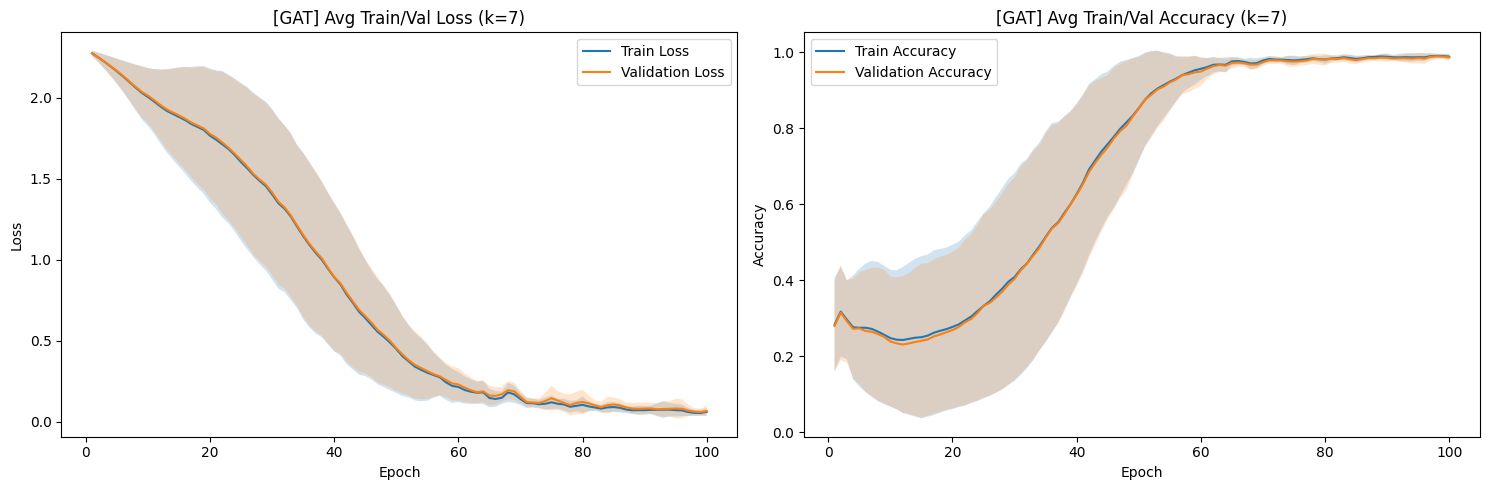

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_7_SAGE
Using existing processed data for k_7_SAGE
Starting k-fold cross-validation for SAGE...

--- Fold 1/10 ---
Epoch 010, Train Loss: 2.3107, Train Acc: 0.1097, Val Loss: 2.3127, Val Acc: 0.1070


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3034, Train Acc: 0.1207, Val Loss: 2.3063, Val Acc: 0.0995
Epoch 030, Train Loss: 2.2869, Train Acc: 0.1216, Val Loss: 2.2910, Val Acc: 0.1057
Epoch 040, Train Loss: 2.2576, Train Acc: 0.1713, Val Loss: 2.2643, Val Acc: 0.1604
Epoch 050, Train Loss: 2.1952, Train Acc: 0.2238, Val Loss: 2.2047, Val Acc: 0.2177
Epoch 060, Train Loss: 2.0916, Train Acc: 0.3167, Val Loss: 2.0988, Val Acc: 0.3085
Epoch 070, Train Loss: 1.9451, Train Acc: 0.4400, Val Loss: 1.9526, Val Acc: 0.4415
Epoch 080, Train Loss: 1.7862, Train Acc: 0.5332, Val Loss: 1.7963, Val Acc: 0.5274
Epoch 090, Train Loss: 1.6516, Train Acc: 0.5931, Val Loss: 1.6657, Val Acc: 0.5771


[I 2025-01-26 16:43:06,545] Trial 0 finished with value: 1.5852190256118774 and parameters: {'hidden_channels': 20, 'dropout': 0.3485719058439827, 'lr': 0.00010297348645482807}. Best is trial 0 with value: 1.5852190256118774.


Epoch 100, Train Loss: 1.5671, Train Acc: 0.6248, Val Loss: 1.5852, Val Acc: 0.6157
Epoch 010, Train Loss: 2.3022, Train Acc: 0.1104, Val Loss: 2.3027, Val Acc: 0.1132


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2924, Train Acc: 0.0991, Val Loss: 2.2927, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2741, Train Acc: 0.1003, Val Loss: 2.2743, Val Acc: 0.1045
Epoch 040, Train Loss: 2.2232, Train Acc: 0.1050, Val Loss: 2.2245, Val Acc: 0.1107
Epoch 050, Train Loss: 2.1220, Train Acc: 0.2476, Val Loss: 2.1251, Val Acc: 0.2450
Epoch 060, Train Loss: 1.9572, Train Acc: 0.4841, Val Loss: 1.9636, Val Acc: 0.4863
Epoch 070, Train Loss: 1.7318, Train Acc: 0.6379, Val Loss: 1.7446, Val Acc: 0.6269
Epoch 080, Train Loss: 1.5081, Train Acc: 0.7412, Val Loss: 1.5224, Val Acc: 0.7201
Epoch 090, Train Loss: 1.3372, Train Acc: 0.7810, Val Loss: 1.3552, Val Acc: 0.7612


[I 2025-01-26 16:43:07,910] Trial 1 finished with value: 1.2440145015716553 and parameters: {'hidden_channels': 35, 'dropout': 0.20126475766155516, 'lr': 0.00011599565042563949}. Best is trial 1 with value: 1.2440145015716553.


Epoch 100, Train Loss: 1.2232, Train Acc: 0.8144, Val Loss: 1.2440, Val Acc: 0.7861
Epoch 010, Train Loss: 2.0968, Train Acc: 0.4211, Val Loss: 2.1024, Val Acc: 0.4378


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.4828, Train Acc: 0.6343, Val Loss: 1.4987, Val Acc: 0.6206
Epoch 030, Train Loss: 0.9487, Train Acc: 0.7569, Val Loss: 0.9713, Val Acc: 0.7413
Epoch 040, Train Loss: 0.6291, Train Acc: 0.8305, Val Loss: 0.6540, Val Acc: 0.8122
Epoch 050, Train Loss: 0.4938, Train Acc: 0.8543, Val Loss: 0.5520, Val Acc: 0.8358
Epoch 060, Train Loss: 0.3714, Train Acc: 0.8963, Val Loss: 0.4031, Val Acc: 0.8881
Epoch 070, Train Loss: 0.2881, Train Acc: 0.9120, Val Loss: 0.3327, Val Acc: 0.8918
Epoch 080, Train Loss: 0.1958, Train Acc: 0.9516, Val Loss: 0.2258, Val Acc: 0.9303
Epoch 090, Train Loss: 0.1596, Train Acc: 0.9580, Val Loss: 0.1800, Val Acc: 0.9515


[I 2025-01-26 16:43:09,174] Trial 2 finished with value: 0.1574997454881668 and parameters: {'hidden_channels': 31, 'dropout': 0.432938285786225, 'lr': 0.005073422523786903}. Best is trial 2 with value: 0.1574997454881668.


Epoch 100, Train Loss: 0.1507, Train Acc: 0.9560, Val Loss: 0.1575, Val Acc: 0.9552
Epoch 010, Train Loss: 2.2995, Train Acc: 0.1017, Val Loss: 2.2978, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2887, Train Acc: 0.1132, Val Loss: 2.2863, Val Acc: 0.1107
Epoch 030, Train Loss: 2.2641, Train Acc: 0.1286, Val Loss: 2.2621, Val Acc: 0.1269
Epoch 040, Train Loss: 2.2148, Train Acc: 0.1397, Val Loss: 2.2157, Val Acc: 0.1343
Epoch 050, Train Loss: 2.0994, Train Acc: 0.2756, Val Loss: 2.1013, Val Acc: 0.2811
Epoch 060, Train Loss: 1.9001, Train Acc: 0.5380, Val Loss: 1.9035, Val Acc: 0.5361
Epoch 070, Train Loss: 1.6928, Train Acc: 0.7238, Val Loss: 1.7004, Val Acc: 0.7114
Epoch 080, Train Loss: 1.4670, Train Acc: 0.7920, Val Loss: 1.4807, Val Acc: 0.7736
Epoch 090, Train Loss: 1.2958, Train Acc: 0.8277, Val Loss: 1.3136, Val Acc: 0.8072


[I 2025-01-26 16:43:10,418] Trial 3 finished with value: 1.230663537979126 and parameters: {'hidden_channels': 26, 'dropout': 0.34923494543010514, 'lr': 0.0002517009436454299}. Best is trial 2 with value: 0.1574997454881668.


Epoch 100, Train Loss: 1.2050, Train Acc: 0.8490, Val Loss: 1.2307, Val Acc: 0.8147
Epoch 010, Train Loss: 1.7791, Train Acc: 0.5430, Val Loss: 1.7948, Val Acc: 0.5336


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.0246, Train Acc: 0.6973, Val Loss: 1.0595, Val Acc: 0.6679
Epoch 030, Train Loss: 0.6692, Train Acc: 0.7846, Val Loss: 0.7245, Val Acc: 0.7488
Epoch 040, Train Loss: 0.4135, Train Acc: 0.8695, Val Loss: 0.4468, Val Acc: 0.8483
Epoch 050, Train Loss: 0.2918, Train Acc: 0.9068, Val Loss: 0.3148, Val Acc: 0.9055
Epoch 060, Train Loss: 0.3811, Train Acc: 0.8877, Val Loss: 0.4166, Val Acc: 0.8856
Epoch 070, Train Loss: 0.2192, Train Acc: 0.9319, Val Loss: 0.2372, Val Acc: 0.9204
Epoch 080, Train Loss: 0.1788, Train Acc: 0.9429, Val Loss: 0.1959, Val Acc: 0.9378
Epoch 090, Train Loss: 0.1450, Train Acc: 0.9540, Val Loss: 0.1663, Val Acc: 0.9552


[I 2025-01-26 16:43:11,808] Trial 4 finished with value: 0.11910755187273026 and parameters: {'hidden_channels': 43, 'dropout': 0.49960147341221905, 'lr': 0.009058090766144956}. Best is trial 4 with value: 0.11910755187273026.


Epoch 100, Train Loss: 0.1134, Train Acc: 0.9681, Val Loss: 0.1191, Val Acc: 0.9652
  Fold 1 - Optuna Best Trial Val Loss: 0.1191
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 43, 'dropout': 0.49960147341221905, 'lr': 0.009058090766144956}
Epoch 010, Train Loss: 1.7663, Train Acc: 0.5607, Val Loss: 1.7749, Val Acc: 0.5473


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.0419, Train Acc: 0.6676, Val Loss: 1.0786, Val Acc: 0.6418
Epoch 030, Train Loss: 0.6598, Train Acc: 0.8003, Val Loss: 0.7095, Val Acc: 0.7811
Epoch 040, Train Loss: 0.4943, Train Acc: 0.8375, Val Loss: 0.5270, Val Acc: 0.8209
Epoch 050, Train Loss: 0.3088, Train Acc: 0.9155, Val Loss: 0.3239, Val Acc: 0.9092
Epoch 060, Train Loss: 0.2483, Train Acc: 0.9160, Val Loss: 0.2744, Val Acc: 0.9104
Epoch 070, Train Loss: 0.2226, Train Acc: 0.9236, Val Loss: 0.2513, Val Acc: 0.9204
Epoch 080, Train Loss: 0.2783, Train Acc: 0.8978, Val Loss: 0.2583, Val Acc: 0.9030
Epoch 090, Train Loss: 0.1469, Train Acc: 0.9471, Val Loss: 0.1605, Val Acc: 0.9428


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0931, Train Acc: 0.9779, Val Loss: 0.0990, Val Acc: 0.9813
  Fold 1 Test Metrics:
  Accuracy: 0.9751
  Precision: 0.9757
  Recall: 0.9751
  F1: 0.9750

--- Fold 2/10 ---
Epoch 010, Train Loss: 2.3032, Train Acc: 0.0969, Val Loss: 2.3039, Val Acc: 0.0970


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2966, Train Acc: 0.1341, Val Loss: 2.2988, Val Acc: 0.1405
Epoch 030, Train Loss: 2.2666, Train Acc: 0.1345, Val Loss: 2.2704, Val Acc: 0.1318
Epoch 040, Train Loss: 2.1995, Train Acc: 0.1681, Val Loss: 2.2029, Val Acc: 0.1741
Epoch 050, Train Loss: 2.0782, Train Acc: 0.2716, Val Loss: 2.0814, Val Acc: 0.2749
Epoch 060, Train Loss: 1.8652, Train Acc: 0.4878, Val Loss: 1.8718, Val Acc: 0.4950
Epoch 070, Train Loss: 1.5638, Train Acc: 0.7220, Val Loss: 1.5673, Val Acc: 0.7201
Epoch 080, Train Loss: 1.2662, Train Acc: 0.8297, Val Loss: 1.2744, Val Acc: 0.8209
Epoch 090, Train Loss: 1.0497, Train Acc: 0.8673, Val Loss: 1.0610, Val Acc: 0.8570


[I 2025-01-26 16:43:14,629] Trial 0 finished with value: 0.9350364804267883 and parameters: {'hidden_channels': 54, 'dropout': 0.20319701819475344, 'lr': 0.00011983894057493712}. Best is trial 0 with value: 0.9350364804267883.


Epoch 100, Train Loss: 0.9188, Train Acc: 0.8833, Val Loss: 0.9350, Val Acc: 0.8818
Epoch 010, Train Loss: 1.9220, Train Acc: 0.4814, Val Loss: 1.9513, Val Acc: 0.4590


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.1149, Train Acc: 0.6572, Val Loss: 1.1267, Val Acc: 0.6555
Epoch 030, Train Loss: 0.7502, Train Acc: 0.7614, Val Loss: 0.7769, Val Acc: 0.7562
Epoch 040, Train Loss: 0.4723, Train Acc: 0.8463, Val Loss: 0.4967, Val Acc: 0.8570
Epoch 050, Train Loss: 0.3080, Train Acc: 0.9014, Val Loss: 0.3189, Val Acc: 0.9092
Epoch 060, Train Loss: 0.2935, Train Acc: 0.9126, Val Loss: 0.3484, Val Acc: 0.8968
Epoch 070, Train Loss: 0.2006, Train Acc: 0.9320, Val Loss: 0.2317, Val Acc: 0.9179
Epoch 080, Train Loss: 0.1694, Train Acc: 0.9432, Val Loss: 0.2090, Val Acc: 0.9316
Epoch 090, Train Loss: 0.1272, Train Acc: 0.9608, Val Loss: 0.1535, Val Acc: 0.9453


[I 2025-01-26 16:43:15,895] Trial 1 finished with value: 0.11151047050952911 and parameters: {'hidden_channels': 32, 'dropout': 0.3110620169804496, 'lr': 0.008393834556884316}. Best is trial 1 with value: 0.11151047050952911.


Epoch 100, Train Loss: 0.0920, Train Acc: 0.9700, Val Loss: 0.1115, Val Acc: 0.9614
Epoch 010, Train Loss: 2.0054, Train Acc: 0.4624, Val Loss: 2.0250, Val Acc: 0.4341


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.3012, Train Acc: 0.6329, Val Loss: 1.3052, Val Acc: 0.6480
Epoch 030, Train Loss: 0.7578, Train Acc: 0.7726, Val Loss: 0.7553, Val Acc: 0.7687
Epoch 040, Train Loss: 0.4724, Train Acc: 0.8473, Val Loss: 0.4892, Val Acc: 0.8420
Epoch 050, Train Loss: 0.3303, Train Acc: 0.8945, Val Loss: 0.3550, Val Acc: 0.8831
Epoch 060, Train Loss: 0.2618, Train Acc: 0.9085, Val Loss: 0.3053, Val Acc: 0.8881
Epoch 070, Train Loss: 0.1527, Train Acc: 0.9638, Val Loss: 0.1830, Val Acc: 0.9540
Epoch 080, Train Loss: 0.2560, Train Acc: 0.9253, Val Loss: 0.3859, Val Acc: 0.9005
Epoch 090, Train Loss: 0.1164, Train Acc: 0.9610, Val Loss: 0.1420, Val Acc: 0.9490


[I 2025-01-26 16:43:17,259] Trial 2 finished with value: 0.10145575553178787 and parameters: {'hidden_channels': 33, 'dropout': 0.4222182525412297, 'lr': 0.006920701392088556}. Best is trial 2 with value: 0.10145575553178787.


Epoch 100, Train Loss: 0.0770, Train Acc: 0.9855, Val Loss: 0.1015, Val Acc: 0.9813
Epoch 010, Train Loss: 2.1783, Train Acc: 0.4013, Val Loss: 2.1732, Val Acc: 0.4117


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8374, Train Acc: 0.5976, Val Loss: 1.8384, Val Acc: 0.5734
Epoch 030, Train Loss: 1.4350, Train Acc: 0.6681, Val Loss: 1.4427, Val Acc: 0.6505
Epoch 040, Train Loss: 0.9662, Train Acc: 0.7718, Val Loss: 0.9874, Val Acc: 0.7575
Epoch 050, Train Loss: 0.5247, Train Acc: 0.8813, Val Loss: 0.5484, Val Acc: 0.8756
Epoch 060, Train Loss: 0.3245, Train Acc: 0.9434, Val Loss: 0.3762, Val Acc: 0.9279
Epoch 070, Train Loss: 0.2225, Train Acc: 0.9432, Val Loss: 0.2592, Val Acc: 0.9279
Epoch 080, Train Loss: 0.1156, Train Acc: 0.9823, Val Loss: 0.1307, Val Acc: 0.9776
Epoch 090, Train Loss: 0.1466, Train Acc: 0.9703, Val Loss: 0.2003, Val Acc: 0.9577


[I 2025-01-26 16:43:18,739] Trial 3 finished with value: 0.08686558157205582 and parameters: {'hidden_channels': 61, 'dropout': 0.33187195469350883, 'lr': 0.001787971537691828}. Best is trial 3 with value: 0.08686558157205582.


Epoch 100, Train Loss: 0.0742, Train Acc: 0.9919, Val Loss: 0.0869, Val Acc: 0.9888
Epoch 010, Train Loss: 2.2743, Train Acc: 0.1114, Val Loss: 2.2736, Val Acc: 0.1182


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1945, Train Acc: 0.1863, Val Loss: 2.1922, Val Acc: 0.1866
Epoch 030, Train Loss: 2.0405, Train Acc: 0.4472, Val Loss: 2.0396, Val Acc: 0.4440
Epoch 040, Train Loss: 1.8112, Train Acc: 0.6328, Val Loss: 1.8140, Val Acc: 0.6244
Epoch 050, Train Loss: 1.4919, Train Acc: 0.7712, Val Loss: 1.4942, Val Acc: 0.7761
Epoch 060, Train Loss: 1.0738, Train Acc: 0.8533, Val Loss: 1.0879, Val Acc: 0.8507
Epoch 070, Train Loss: 0.7249, Train Acc: 0.9065, Val Loss: 0.7390, Val Acc: 0.9005
Epoch 080, Train Loss: 0.5107, Train Acc: 0.9277, Val Loss: 0.5256, Val Acc: 0.9192
Epoch 090, Train Loss: 0.3762, Train Acc: 0.9448, Val Loss: 0.3972, Val Acc: 0.9403


[I 2025-01-26 16:43:20,138] Trial 4 finished with value: 0.3287515342235565 and parameters: {'hidden_channels': 45, 'dropout': 0.2503007570265993, 'lr': 0.0006523616858115997}. Best is trial 3 with value: 0.08686558157205582.


Epoch 100, Train Loss: 0.2999, Train Acc: 0.9563, Val Loss: 0.3288, Val Acc: 0.9403
  Fold 2 - Optuna Best Trial Val Loss: 0.0869
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 61, 'dropout': 0.33187195469350883, 'lr': 0.001787971537691828}
Epoch 010, Train Loss: 2.2056, Train Acc: 0.3794, Val Loss: 2.2003, Val Acc: 0.3781


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9192, Train Acc: 0.5467, Val Loss: 1.9114, Val Acc: 0.5336
Epoch 030, Train Loss: 1.4537, Train Acc: 0.6758, Val Loss: 1.4566, Val Acc: 0.6567
Epoch 040, Train Loss: 0.9304, Train Acc: 0.8137, Val Loss: 0.9518, Val Acc: 0.8035
Epoch 050, Train Loss: 0.5211, Train Acc: 0.8998, Val Loss: 0.5655, Val Acc: 0.8843
Epoch 060, Train Loss: 0.3189, Train Acc: 0.9354, Val Loss: 0.3613, Val Acc: 0.9204
Epoch 070, Train Loss: 0.1895, Train Acc: 0.9633, Val Loss: 0.2138, Val Acc: 0.9565
Epoch 080, Train Loss: 0.1548, Train Acc: 0.9718, Val Loss: 0.1801, Val Acc: 0.9652
Epoch 090, Train Loss: 0.1479, Train Acc: 0.9653, Val Loss: 0.1728, Val Acc: 0.9552


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1553, Train Acc: 0.9575, Val Loss: 0.2089, Val Acc: 0.9490
  Fold 2 Test Metrics:
  Accuracy: 0.9565
  Precision: 0.9612
  Recall: 0.9565
  F1: 0.9568

--- Fold 3/10 ---
Epoch 010, Train Loss: 2.3328, Train Acc: 0.1154, Val Loss: 2.3321, Val Acc: 0.1107


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:43:21,878] Trial 0 finished with value: 2.347219944000244 and parameters: {'hidden_channels': 25, 'dropout': 0.43136623380051253, 'lr': 0.0001245683184698243}. Best is trial 0 with value: 2.347219944000244.


Epoch 020, Train Loss: 2.3484, Train Acc: 0.1787, Val Loss: 2.3482, Val Acc: 0.1692
Early stopping at epoch 22
Epoch 010, Train Loss: 2.2737, Train Acc: 0.1215, Val Loss: 2.2760, Val Acc: 0.1231


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2056, Train Acc: 0.1529, Val Loss: 2.2056, Val Acc: 0.1617
Epoch 030, Train Loss: 2.0686, Train Acc: 0.4281, Val Loss: 2.0661, Val Acc: 0.4478
Epoch 040, Train Loss: 1.8473, Train Acc: 0.5987, Val Loss: 1.8440, Val Acc: 0.5858
Epoch 050, Train Loss: 1.5356, Train Acc: 0.7813, Val Loss: 1.5306, Val Acc: 0.7823
Epoch 060, Train Loss: 1.1563, Train Acc: 0.8611, Val Loss: 1.1682, Val Acc: 0.8557
Epoch 070, Train Loss: 0.7955, Train Acc: 0.9034, Val Loss: 0.8079, Val Acc: 0.8993
Epoch 080, Train Loss: 0.6488, Train Acc: 0.9148, Val Loss: 0.6720, Val Acc: 0.9092
Epoch 090, Train Loss: 0.5013, Train Acc: 0.9194, Val Loss: 0.5296, Val Acc: 0.9117


[I 2025-01-26 16:43:23,113] Trial 1 finished with value: 0.46036970615386963 and parameters: {'hidden_channels': 25, 'dropout': 0.23462631393875583, 'lr': 0.0010586526042679445}. Best is trial 1 with value: 0.46036970615386963.


Epoch 100, Train Loss: 0.4481, Train Acc: 0.9260, Val Loss: 0.4604, Val Acc: 0.9254
Epoch 010, Train Loss: 1.9429, Train Acc: 0.5257, Val Loss: 1.9455, Val Acc: 0.5373


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.1927, Train Acc: 0.6440, Val Loss: 1.1926, Val Acc: 0.6555
Epoch 030, Train Loss: 0.7060, Train Acc: 0.7972, Val Loss: 0.7054, Val Acc: 0.7985
Epoch 040, Train Loss: 0.4435, Train Acc: 0.8706, Val Loss: 0.4438, Val Acc: 0.8706
Epoch 050, Train Loss: 0.3012, Train Acc: 0.9065, Val Loss: 0.2950, Val Acc: 0.9142
Epoch 060, Train Loss: 0.2105, Train Acc: 0.9412, Val Loss: 0.2070, Val Acc: 0.9465
Epoch 070, Train Loss: 0.2641, Train Acc: 0.9311, Val Loss: 0.2342, Val Acc: 0.9316
Epoch 080, Train Loss: 0.1788, Train Acc: 0.9536, Val Loss: 0.1758, Val Acc: 0.9552
Epoch 090, Train Loss: 0.1429, Train Acc: 0.9558, Val Loss: 0.1619, Val Acc: 0.9527


[I 2025-01-26 16:43:24,478] Trial 2 finished with value: 0.07188479602336884 and parameters: {'hidden_channels': 38, 'dropout': 0.20403591335489105, 'lr': 0.0054941391180208235}. Best is trial 2 with value: 0.07188479602336884.


Epoch 100, Train Loss: 0.0744, Train Acc: 0.9893, Val Loss: 0.0719, Val Acc: 0.9851
Epoch 010, Train Loss: 2.2775, Train Acc: 0.1367, Val Loss: 2.2774, Val Acc: 0.1393


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2161, Train Acc: 0.1487, Val Loss: 2.2160, Val Acc: 0.1405
Epoch 030, Train Loss: 2.0830, Train Acc: 0.2175, Val Loss: 2.0853, Val Acc: 0.2090
Epoch 040, Train Loss: 1.8387, Train Acc: 0.5295, Val Loss: 1.8441, Val Acc: 0.5149
Epoch 050, Train Loss: 1.4774, Train Acc: 0.7283, Val Loss: 1.4865, Val Acc: 0.7226
Epoch 060, Train Loss: 1.0264, Train Acc: 0.8591, Val Loss: 1.0410, Val Acc: 0.8507
Epoch 070, Train Loss: 0.7064, Train Acc: 0.9012, Val Loss: 0.7185, Val Acc: 0.9042
Epoch 080, Train Loss: 0.5015, Train Acc: 0.9295, Val Loss: 0.5090, Val Acc: 0.9353
Epoch 090, Train Loss: 0.3758, Train Acc: 0.9378, Val Loss: 0.3971, Val Acc: 0.9378


[I 2025-01-26 16:43:25,848] Trial 3 finished with value: 0.30493438243865967 and parameters: {'hidden_channels': 40, 'dropout': 0.38007857416689816, 'lr': 0.0009139112756209622}. Best is trial 2 with value: 0.07188479602336884.


Epoch 100, Train Loss: 0.3021, Train Acc: 0.9574, Val Loss: 0.3049, Val Acc: 0.9552
Epoch 010, Train Loss: 2.2974, Train Acc: 0.1016, Val Loss: 2.2987, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2737, Train Acc: 0.1218, Val Loss: 2.2778, Val Acc: 0.1132
Epoch 030, Train Loss: 2.2323, Train Acc: 0.1254, Val Loss: 2.2379, Val Acc: 0.1132
Epoch 040, Train Loss: 2.1582, Train Acc: 0.1912, Val Loss: 2.1658, Val Acc: 0.1779
Epoch 050, Train Loss: 2.0317, Train Acc: 0.4183, Val Loss: 2.0423, Val Acc: 0.4005
Epoch 060, Train Loss: 1.8406, Train Acc: 0.6365, Val Loss: 1.8500, Val Acc: 0.6194
Epoch 070, Train Loss: 1.5910, Train Acc: 0.7262, Val Loss: 1.6064, Val Acc: 0.7338
Epoch 080, Train Loss: 1.3561, Train Acc: 0.7732, Val Loss: 1.3711, Val Acc: 0.7699
Epoch 090, Train Loss: 1.2064, Train Acc: 0.7990, Val Loss: 1.2195, Val Acc: 0.7973


[I 2025-01-26 16:43:27,081] Trial 4 finished with value: 1.0909603834152222 and parameters: {'hidden_channels': 24, 'dropout': 0.29156235854377954, 'lr': 0.00031243822392750675}. Best is trial 2 with value: 0.07188479602336884.


Epoch 100, Train Loss: 1.0775, Train Acc: 0.8249, Val Loss: 1.0910, Val Acc: 0.8147
  Fold 3 - Optuna Best Trial Val Loss: 0.0719
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 38, 'dropout': 0.20403591335489105, 'lr': 0.0054941391180208235}
Epoch 010, Train Loss: 2.0336, Train Acc: 0.4993, Val Loss: 2.0587, Val Acc: 0.4938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.3995, Train Acc: 0.6510, Val Loss: 1.4437, Val Acc: 0.6256
Epoch 030, Train Loss: 0.8544, Train Acc: 0.7682, Val Loss: 0.8821, Val Acc: 0.7488
Epoch 040, Train Loss: 0.5014, Train Acc: 0.8697, Val Loss: 0.5090, Val Acc: 0.8731
Epoch 050, Train Loss: 0.3449, Train Acc: 0.8989, Val Loss: 0.3592, Val Acc: 0.8968
Epoch 060, Train Loss: 0.2666, Train Acc: 0.9241, Val Loss: 0.2687, Val Acc: 0.9303
Epoch 070, Train Loss: 0.2916, Train Acc: 0.9034, Val Loss: 0.2933, Val Acc: 0.9030
Epoch 080, Train Loss: 0.1618, Train Acc: 0.9617, Val Loss: 0.1541, Val Acc: 0.9627
Epoch 090, Train Loss: 0.1143, Train Acc: 0.9771, Val Loss: 0.1175, Val Acc: 0.9764


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0819, Train Acc: 0.9852, Val Loss: 0.0827, Val Acc: 0.9813
  Fold 3 Test Metrics:
  Accuracy: 0.9764
  Precision: 0.9770
  Recall: 0.9764
  F1: 0.9763

--- Fold 4/10 ---
Epoch 010, Train Loss: 2.0562, Train Acc: 0.4176, Val Loss: 2.0780, Val Acc: 0.4092


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.4078, Train Acc: 0.5939, Val Loss: 1.4275, Val Acc: 0.5883
Epoch 030, Train Loss: 0.8264, Train Acc: 0.7695, Val Loss: 0.8702, Val Acc: 0.7475
Epoch 040, Train Loss: 0.5346, Train Acc: 0.8298, Val Loss: 0.5568, Val Acc: 0.8097
Epoch 050, Train Loss: 0.3314, Train Acc: 0.9005, Val Loss: 0.3482, Val Acc: 0.8905
Epoch 060, Train Loss: 0.2661, Train Acc: 0.9236, Val Loss: 0.3027, Val Acc: 0.9067
Epoch 070, Train Loss: 0.1904, Train Acc: 0.9428, Val Loss: 0.2184, Val Acc: 0.9303
Epoch 080, Train Loss: 0.1987, Train Acc: 0.9510, Val Loss: 0.2436, Val Acc: 0.9353
Epoch 090, Train Loss: 0.1412, Train Acc: 0.9583, Val Loss: 0.1612, Val Acc: 0.9465


[I 2025-01-26 16:43:29,826] Trial 0 finished with value: 0.1253945380449295 and parameters: {'hidden_channels': 35, 'dropout': 0.3182527801657332, 'lr': 0.005534749202836172}. Best is trial 0 with value: 0.1253945380449295.


Epoch 100, Train Loss: 0.1121, Train Acc: 0.9706, Val Loss: 0.1254, Val Acc: 0.9677
Epoch 010, Train Loss: 2.2979, Train Acc: 0.0994, Val Loss: 2.2967, Val Acc: 0.0983


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2821, Train Acc: 0.1028, Val Loss: 2.2795, Val Acc: 0.1045
Epoch 030, Train Loss: 2.2430, Train Acc: 0.1034, Val Loss: 2.2402, Val Acc: 0.1020
Epoch 040, Train Loss: 2.1517, Train Acc: 0.1565, Val Loss: 2.1471, Val Acc: 0.1679
Epoch 050, Train Loss: 1.9996, Train Acc: 0.3626, Val Loss: 1.9972, Val Acc: 0.3582
Epoch 060, Train Loss: 1.7929, Train Acc: 0.6441, Val Loss: 1.8003, Val Acc: 0.6393
Epoch 070, Train Loss: 1.5693, Train Acc: 0.7642, Val Loss: 1.5832, Val Acc: 0.7450
Epoch 080, Train Loss: 1.3479, Train Acc: 0.8465, Val Loss: 1.3705, Val Acc: 0.8246
Epoch 090, Train Loss: 1.2234, Train Acc: 0.8692, Val Loss: 1.2472, Val Acc: 0.8445


[I 2025-01-26 16:43:31,046] Trial 1 finished with value: 1.143883228302002 and parameters: {'hidden_channels': 17, 'dropout': 0.2553017145755149, 'lr': 0.00038913767914597943}. Best is trial 0 with value: 0.1253945380449295.


Epoch 100, Train Loss: 1.1214, Train Acc: 0.8807, Val Loss: 1.1439, Val Acc: 0.8619
Epoch 010, Train Loss: 2.3120, Train Acc: 0.0966, Val Loss: 2.3138, Val Acc: 0.0958


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3063, Train Acc: 0.0960, Val Loss: 2.3099, Val Acc: 0.0958
Epoch 030, Train Loss: 2.2772, Train Acc: 0.1058, Val Loss: 2.2843, Val Acc: 0.1107
Epoch 040, Train Loss: 2.2104, Train Acc: 0.1092, Val Loss: 2.2167, Val Acc: 0.1119
Epoch 050, Train Loss: 2.0842, Train Acc: 0.2453, Val Loss: 2.0921, Val Acc: 0.2400
Epoch 060, Train Loss: 1.8683, Train Acc: 0.5587, Val Loss: 1.8745, Val Acc: 0.5460
Epoch 070, Train Loss: 1.5998, Train Acc: 0.7368, Val Loss: 1.6083, Val Acc: 0.7338
Epoch 080, Train Loss: 1.3750, Train Acc: 0.7779, Val Loss: 1.3893, Val Acc: 0.7699
Epoch 090, Train Loss: 1.2031, Train Acc: 0.7948, Val Loss: 1.2232, Val Acc: 0.7848


[I 2025-01-26 16:43:32,443] Trial 2 finished with value: 1.1103878021240234 and parameters: {'hidden_channels': 36, 'dropout': 0.32418586524943915, 'lr': 0.00014754402590665824}. Best is trial 0 with value: 0.1253945380449295.


Epoch 100, Train Loss: 1.0856, Train Acc: 0.8214, Val Loss: 1.1104, Val Acc: 0.8147
Epoch 010, Train Loss: 2.3116, Train Acc: 0.1314, Val Loss: 2.3124, Val Acc: 0.1182


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3048, Train Acc: 0.1013, Val Loss: 2.3053, Val Acc: 0.1045
Epoch 030, Train Loss: 2.2819, Train Acc: 0.1000, Val Loss: 2.2834, Val Acc: 0.1007
Epoch 040, Train Loss: 2.2366, Train Acc: 0.1006, Val Loss: 2.2407, Val Acc: 0.1007
Epoch 050, Train Loss: 2.1448, Train Acc: 0.1839, Val Loss: 2.1568, Val Acc: 0.1716
Epoch 060, Train Loss: 1.9898, Train Acc: 0.4931, Val Loss: 2.0049, Val Acc: 0.4776
Epoch 070, Train Loss: 1.7859, Train Acc: 0.6852, Val Loss: 1.8117, Val Acc: 0.6667
Epoch 080, Train Loss: 1.5931, Train Acc: 0.7424, Val Loss: 1.6299, Val Acc: 0.7164
Epoch 090, Train Loss: 1.4530, Train Acc: 0.7763, Val Loss: 1.4941, Val Acc: 0.7450


[I 2025-01-26 16:43:33,722] Trial 3 finished with value: 1.3846298456192017 and parameters: {'hidden_channels': 28, 'dropout': 0.42993275591589564, 'lr': 0.0001466229353563231}. Best is trial 0 with value: 0.1253945380449295.


Epoch 100, Train Loss: 1.3396, Train Acc: 0.7934, Val Loss: 1.3846, Val Acc: 0.7637
Epoch 010, Train Loss: 2.2734, Train Acc: 0.1694, Val Loss: 2.2725, Val Acc: 0.1729


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1921, Train Acc: 0.2683, Val Loss: 2.1915, Val Acc: 0.2662
Epoch 030, Train Loss: 2.0438, Train Acc: 0.3434, Val Loss: 2.0488, Val Acc: 0.3470
Epoch 040, Train Loss: 1.8164, Train Acc: 0.4914, Val Loss: 1.8306, Val Acc: 0.4714
Epoch 050, Train Loss: 1.4703, Train Acc: 0.6995, Val Loss: 1.4967, Val Acc: 0.6542
Epoch 060, Train Loss: 1.0575, Train Acc: 0.8326, Val Loss: 1.0959, Val Acc: 0.8097
Epoch 070, Train Loss: 0.6829, Train Acc: 0.9255, Val Loss: 0.7140, Val Acc: 0.9005
Epoch 080, Train Loss: 0.4085, Train Acc: 0.9496, Val Loss: 0.4381, Val Acc: 0.9415
Epoch 090, Train Loss: 0.2821, Train Acc: 0.9694, Val Loss: 0.3045, Val Acc: 0.9652


[I 2025-01-26 16:43:35,196] Trial 4 finished with value: 0.24803870916366577 and parameters: {'hidden_channels': 61, 'dropout': 0.3381683359256162, 'lr': 0.0005995720297953565}. Best is trial 0 with value: 0.1253945380449295.


Epoch 100, Train Loss: 0.2224, Train Acc: 0.9754, Val Loss: 0.2480, Val Acc: 0.9764
  Fold 4 - Optuna Best Trial Val Loss: 0.1254
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 35, 'dropout': 0.3182527801657332, 'lr': 0.005534749202836172}
Epoch 010, Train Loss: 1.9957, Train Acc: 0.4730, Val Loss: 2.0201, Val Acc: 0.4764


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.4180, Train Acc: 0.6654, Val Loss: 1.4316, Val Acc: 0.6654
Epoch 030, Train Loss: 0.8894, Train Acc: 0.7614, Val Loss: 0.9062, Val Acc: 0.7575
Epoch 040, Train Loss: 0.5036, Train Acc: 0.8533, Val Loss: 0.5271, Val Acc: 0.8483
Epoch 050, Train Loss: 0.3992, Train Acc: 0.8749, Val Loss: 0.4343, Val Acc: 0.8644
Epoch 060, Train Loss: 0.2591, Train Acc: 0.9280, Val Loss: 0.2844, Val Acc: 0.9117
Epoch 070, Train Loss: 0.1852, Train Acc: 0.9515, Val Loss: 0.2009, Val Acc: 0.9453
Epoch 080, Train Loss: 0.2209, Train Acc: 0.9409, Val Loss: 0.2253, Val Acc: 0.9415
Epoch 090, Train Loss: 0.1686, Train Acc: 0.9522, Val Loss: 0.1812, Val Acc: 0.9515


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1165, Train Acc: 0.9641, Val Loss: 0.1378, Val Acc: 0.9540
  Fold 4 Test Metrics:
  Accuracy: 0.9614
  Precision: 0.9648
  Recall: 0.9614
  F1: 0.9621

--- Fold 5/10 ---
Epoch 010, Train Loss: 2.3004, Train Acc: 0.0985, Val Loss: 2.3006, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2924, Train Acc: 0.1006, Val Loss: 2.2926, Val Acc: 0.1045
Epoch 030, Train Loss: 2.2670, Train Acc: 0.1114, Val Loss: 2.2692, Val Acc: 0.1095
Epoch 040, Train Loss: 2.2018, Train Acc: 0.2014, Val Loss: 2.2035, Val Acc: 0.2027
Epoch 050, Train Loss: 2.0666, Train Acc: 0.3224, Val Loss: 2.0707, Val Acc: 0.3060
Epoch 060, Train Loss: 1.8428, Train Acc: 0.5541, Val Loss: 1.8546, Val Acc: 0.5547
Epoch 070, Train Loss: 1.5660, Train Acc: 0.6951, Val Loss: 1.5848, Val Acc: 0.6866
Epoch 080, Train Loss: 1.3145, Train Acc: 0.7858, Val Loss: 1.3427, Val Acc: 0.7923
Epoch 090, Train Loss: 1.1092, Train Acc: 0.8329, Val Loss: 1.1406, Val Acc: 0.8358


[I 2025-01-26 16:43:37,997] Trial 0 finished with value: 1.0165077447891235 and parameters: {'hidden_channels': 39, 'dropout': 0.20725384645207479, 'lr': 0.00018109547029809098}. Best is trial 0 with value: 1.0165077447891235.


Epoch 100, Train Loss: 0.9883, Train Acc: 0.8546, Val Loss: 1.0165, Val Acc: 0.8545
Epoch 010, Train Loss: 2.3129, Train Acc: 0.1182, Val Loss: 2.3132, Val Acc: 0.1368


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2979, Train Acc: 0.1159, Val Loss: 2.3020, Val Acc: 0.1070
Epoch 030, Train Loss: 2.2631, Train Acc: 0.1929, Val Loss: 2.2679, Val Acc: 0.1903
Epoch 040, Train Loss: 2.2010, Train Acc: 0.2297, Val Loss: 2.2054, Val Acc: 0.2239
Epoch 050, Train Loss: 2.1143, Train Acc: 0.3623, Val Loss: 2.1181, Val Acc: 0.3532
Epoch 060, Train Loss: 2.0029, Train Acc: 0.4470, Val Loss: 2.0063, Val Acc: 0.4403
Epoch 070, Train Loss: 1.8725, Train Acc: 0.5072, Val Loss: 1.8793, Val Acc: 0.4988
Epoch 080, Train Loss: 1.7291, Train Acc: 0.5542, Val Loss: 1.7393, Val Acc: 0.5535
Epoch 090, Train Loss: 1.6095, Train Acc: 0.6068, Val Loss: 1.6234, Val Acc: 0.6032


[I 2025-01-26 16:43:39,206] Trial 1 finished with value: 1.5431519746780396 and parameters: {'hidden_channels': 17, 'dropout': 0.3064047268628592, 'lr': 0.0001831358787199314}. Best is trial 0 with value: 1.0165077447891235.


Epoch 100, Train Loss: 1.5231, Train Acc: 0.6737, Val Loss: 1.5432, Val Acc: 0.6592
Epoch 010, Train Loss: 2.2878, Train Acc: 0.1254, Val Loss: 2.2864, Val Acc: 0.1144


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2085, Train Acc: 0.2705, Val Loss: 2.2096, Val Acc: 0.2425
Epoch 030, Train Loss: 2.0829, Train Acc: 0.3982, Val Loss: 2.0837, Val Acc: 0.3893
Epoch 040, Train Loss: 1.8593, Train Acc: 0.5821, Val Loss: 1.8621, Val Acc: 0.5771
Epoch 050, Train Loss: 1.5553, Train Acc: 0.6926, Val Loss: 1.5665, Val Acc: 0.6878
Epoch 060, Train Loss: 1.2461, Train Acc: 0.7673, Val Loss: 1.2389, Val Acc: 0.7774
Epoch 070, Train Loss: 1.0010, Train Acc: 0.8331, Val Loss: 1.0128, Val Acc: 0.8458
Epoch 080, Train Loss: 0.7871, Train Acc: 0.8583, Val Loss: 0.7877, Val Acc: 0.8769
Epoch 090, Train Loss: 0.6860, Train Acc: 0.8818, Val Loss: 0.6775, Val Acc: 0.8993


[I 2025-01-26 16:43:40,412] Trial 2 finished with value: 0.5753264427185059 and parameters: {'hidden_channels': 18, 'dropout': 0.39073132818514744, 'lr': 0.0012823570852872083}. Best is trial 2 with value: 0.5753264427185059.


Epoch 100, Train Loss: 0.5745, Train Acc: 0.8972, Val Loss: 0.5753, Val Acc: 0.9080
Epoch 010, Train Loss: 2.2562, Train Acc: 0.1983, Val Loss: 2.2569, Val Acc: 0.2152


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1313, Train Acc: 0.3683, Val Loss: 2.1223, Val Acc: 0.3719
Epoch 030, Train Loss: 1.9170, Train Acc: 0.4856, Val Loss: 1.9161, Val Acc: 0.4888
Epoch 040, Train Loss: 1.5753, Train Acc: 0.6430, Val Loss: 1.5872, Val Acc: 0.6480
Epoch 050, Train Loss: 1.1445, Train Acc: 0.7690, Val Loss: 1.1631, Val Acc: 0.7637
Epoch 060, Train Loss: 0.7277, Train Acc: 0.8855, Val Loss: 0.7569, Val Acc: 0.8756
Epoch 070, Train Loss: 0.4841, Train Acc: 0.9089, Val Loss: 0.5063, Val Acc: 0.9030
Epoch 080, Train Loss: 0.3508, Train Acc: 0.9398, Val Loss: 0.3772, Val Acc: 0.9266
Epoch 090, Train Loss: 0.2343, Train Acc: 0.9636, Val Loss: 0.2521, Val Acc: 0.9639


[I 2025-01-26 16:43:41,781] Trial 3 finished with value: 0.21231770515441895 and parameters: {'hidden_channels': 39, 'dropout': 0.22135753897429064, 'lr': 0.0012465968751480627}. Best is trial 3 with value: 0.21231770515441895.


Epoch 100, Train Loss: 0.2000, Train Acc: 0.9675, Val Loss: 0.2123, Val Acc: 0.9726
Epoch 010, Train Loss: 2.3044, Train Acc: 0.0985, Val Loss: 2.3001, Val Acc: 0.1045


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2964, Train Acc: 0.1230, Val Loss: 2.2884, Val Acc: 0.1269
Epoch 030, Train Loss: 2.2694, Train Acc: 0.1364, Val Loss: 2.2569, Val Acc: 0.1418
Epoch 040, Train Loss: 2.1974, Train Acc: 0.2332, Val Loss: 2.1818, Val Acc: 0.2313
Epoch 050, Train Loss: 2.0641, Train Acc: 0.4601, Val Loss: 2.0522, Val Acc: 0.4316
Epoch 060, Train Loss: 1.8555, Train Acc: 0.6357, Val Loss: 1.8542, Val Acc: 0.6331
Epoch 070, Train Loss: 1.6170, Train Acc: 0.7388, Val Loss: 1.6270, Val Acc: 0.7264
Epoch 080, Train Loss: 1.3801, Train Acc: 0.8095, Val Loss: 1.3984, Val Acc: 0.7948
Epoch 090, Train Loss: 1.2242, Train Acc: 0.8390, Val Loss: 1.2566, Val Acc: 0.8221


[I 2025-01-26 16:43:43,030] Trial 4 finished with value: 1.149943470954895 and parameters: {'hidden_channels': 29, 'dropout': 0.25308505595309927, 'lr': 0.0002675976949099872}. Best is trial 3 with value: 0.21231770515441895.


Epoch 100, Train Loss: 1.1152, Train Acc: 0.8524, Val Loss: 1.1499, Val Acc: 0.8383
  Fold 5 - Optuna Best Trial Val Loss: 0.2123
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 39, 'dropout': 0.22135753897429064, 'lr': 0.0012465968751480627}
Epoch 010, Train Loss: 2.2499, Train Acc: 0.1843, Val Loss: 2.2519, Val Acc: 0.1828


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1020, Train Acc: 0.3840, Val Loss: 2.1101, Val Acc: 0.3794
Epoch 030, Train Loss: 1.8277, Train Acc: 0.6583, Val Loss: 1.8453, Val Acc: 0.6269
Epoch 040, Train Loss: 1.4263, Train Acc: 0.7843, Val Loss: 1.4543, Val Acc: 0.7600
Epoch 050, Train Loss: 0.9938, Train Acc: 0.8776, Val Loss: 1.0253, Val Acc: 0.8843
Epoch 060, Train Loss: 0.6333, Train Acc: 0.9019, Val Loss: 0.6532, Val Acc: 0.9067
Epoch 070, Train Loss: 0.4026, Train Acc: 0.9350, Val Loss: 0.4168, Val Acc: 0.9440
Epoch 080, Train Loss: 0.2849, Train Acc: 0.9641, Val Loss: 0.2844, Val Acc: 0.9714
Epoch 090, Train Loss: 0.2462, Train Acc: 0.9614, Val Loss: 0.2714, Val Acc: 0.9527


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1831, Train Acc: 0.9796, Val Loss: 0.2044, Val Acc: 0.9739
  Fold 5 Test Metrics:
  Accuracy: 0.9739
  Precision: 0.9747
  Recall: 0.9739
  F1: 0.9741

--- Fold 6/10 ---
Epoch 010, Train Loss: 2.2114, Train Acc: 0.3214, Val Loss: 2.2114, Val Acc: 0.3072


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9381, Train Acc: 0.4550, Val Loss: 1.9332, Val Acc: 0.4490
Epoch 030, Train Loss: 1.5285, Train Acc: 0.6777, Val Loss: 1.5209, Val Acc: 0.6667
Epoch 040, Train Loss: 1.0217, Train Acc: 0.7986, Val Loss: 1.0175, Val Acc: 0.7848
Epoch 050, Train Loss: 0.6711, Train Acc: 0.8438, Val Loss: 0.6734, Val Acc: 0.8433
Epoch 060, Train Loss: 0.4018, Train Acc: 0.9043, Val Loss: 0.4173, Val Acc: 0.8980
Epoch 070, Train Loss: 0.2748, Train Acc: 0.9354, Val Loss: 0.3039, Val Acc: 0.9316
Epoch 080, Train Loss: 0.1759, Train Acc: 0.9627, Val Loss: 0.1856, Val Acc: 0.9639
Epoch 090, Train Loss: 0.1582, Train Acc: 0.9569, Val Loss: 0.1852, Val Acc: 0.9502


[I 2025-01-26 16:43:45,808] Trial 0 finished with value: 0.18142485618591309 and parameters: {'hidden_channels': 47, 'dropout': 0.47255397722990894, 'lr': 0.0020708402101790764}. Best is trial 0 with value: 0.18142485618591309.


Epoch 100, Train Loss: 0.1571, Train Acc: 0.9631, Val Loss: 0.1814, Val Acc: 0.9552
Epoch 010, Train Loss: 2.0602, Train Acc: 0.4606, Val Loss: 2.0642, Val Acc: 0.4627


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.5736, Train Acc: 0.5763, Val Loss: 1.5734, Val Acc: 0.5634
Epoch 030, Train Loss: 1.0231, Train Acc: 0.7648, Val Loss: 1.0235, Val Acc: 0.7600
Epoch 040, Train Loss: 0.5903, Train Acc: 0.8589, Val Loss: 0.6211, Val Acc: 0.8433
Epoch 050, Train Loss: 0.4041, Train Acc: 0.8858, Val Loss: 0.4466, Val Acc: 0.8669
Epoch 060, Train Loss: 0.2592, Train Acc: 0.9277, Val Loss: 0.2800, Val Acc: 0.9229
Epoch 070, Train Loss: 0.2584, Train Acc: 0.9176, Val Loss: 0.3190, Val Acc: 0.8993
Epoch 080, Train Loss: 0.1606, Train Acc: 0.9549, Val Loss: 0.1728, Val Acc: 0.9565
Epoch 090, Train Loss: 0.1290, Train Acc: 0.9619, Val Loss: 0.1437, Val Acc: 0.9627


[I 2025-01-26 16:43:47,195] Trial 1 finished with value: 0.1119808554649353 and parameters: {'hidden_channels': 43, 'dropout': 0.39040993159827786, 'lr': 0.003588269984999717}. Best is trial 1 with value: 0.1119808554649353.


Epoch 100, Train Loss: 0.1128, Train Acc: 0.9732, Val Loss: 0.1120, Val Acc: 0.9764
Epoch 010, Train Loss: 2.2108, Train Acc: 0.1451, Val Loss: 2.2204, Val Acc: 0.1493


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8969, Train Acc: 0.4904, Val Loss: 1.8950, Val Acc: 0.4813
Epoch 030, Train Loss: 1.4300, Train Acc: 0.6522, Val Loss: 1.4312, Val Acc: 0.6405
Epoch 040, Train Loss: 0.9417, Train Acc: 0.7796, Val Loss: 0.9375, Val Acc: 0.7687
Epoch 050, Train Loss: 0.5963, Train Acc: 0.8530, Val Loss: 0.6385, Val Acc: 0.8308
Epoch 060, Train Loss: 0.3537, Train Acc: 0.9242, Val Loss: 0.3561, Val Acc: 0.9167
Epoch 070, Train Loss: 0.2511, Train Acc: 0.9358, Val Loss: 0.2760, Val Acc: 0.9216
Epoch 080, Train Loss: 0.2660, Train Acc: 0.9180, Val Loss: 0.2677, Val Acc: 0.9229
Epoch 090, Train Loss: 0.1842, Train Acc: 0.9561, Val Loss: 0.1870, Val Acc: 0.9565


[I 2025-01-26 16:43:48,542] Trial 2 finished with value: 0.13346822559833527 and parameters: {'hidden_channels': 33, 'dropout': 0.278368987787699, 'lr': 0.002976506194658377}. Best is trial 1 with value: 0.1119808554649353.


Epoch 100, Train Loss: 0.1383, Train Acc: 0.9754, Val Loss: 0.1335, Val Acc: 0.9801
Epoch 010, Train Loss: 2.1656, Train Acc: 0.2523, Val Loss: 2.1724, Val Acc: 0.2512


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7808, Train Acc: 0.4984, Val Loss: 1.7870, Val Acc: 0.4714
Epoch 030, Train Loss: 1.2523, Train Acc: 0.7157, Val Loss: 1.2616, Val Acc: 0.7040
Epoch 040, Train Loss: 0.7810, Train Acc: 0.8331, Val Loss: 0.7977, Val Acc: 0.8159
Epoch 050, Train Loss: 0.4993, Train Acc: 0.8868, Val Loss: 0.5287, Val Acc: 0.8669
Epoch 060, Train Loss: 0.3549, Train Acc: 0.9033, Val Loss: 0.3815, Val Acc: 0.8881
Epoch 070, Train Loss: 0.2688, Train Acc: 0.9292, Val Loss: 0.2902, Val Acc: 0.9192
Epoch 080, Train Loss: 0.2126, Train Acc: 0.9452, Val Loss: 0.2452, Val Acc: 0.9266
Epoch 090, Train Loss: 0.1712, Train Acc: 0.9540, Val Loss: 0.1731, Val Acc: 0.9590


[I 2025-01-26 16:43:49,896] Trial 3 finished with value: 0.13784371316432953 and parameters: {'hidden_channels': 36, 'dropout': 0.45300674149355746, 'lr': 0.0033852255935171746}. Best is trial 1 with value: 0.1119808554649353.


Epoch 100, Train Loss: 0.1221, Train Acc: 0.9774, Val Loss: 0.1378, Val Acc: 0.9677
Epoch 010, Train Loss: 2.2863, Train Acc: 0.1011, Val Loss: 2.2831, Val Acc: 0.1057


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2157, Train Acc: 0.2305, Val Loss: 2.2127, Val Acc: 0.2264
Epoch 030, Train Loss: 2.0675, Train Acc: 0.3878, Val Loss: 2.0644, Val Acc: 0.4005
Epoch 040, Train Loss: 1.8039, Train Acc: 0.6363, Val Loss: 1.8032, Val Acc: 0.6368
Epoch 050, Train Loss: 1.4276, Train Acc: 0.7894, Val Loss: 1.4341, Val Acc: 0.7898
Epoch 060, Train Loss: 1.0010, Train Acc: 0.8602, Val Loss: 1.0251, Val Acc: 0.8420
Epoch 070, Train Loss: 0.6422, Train Acc: 0.9137, Val Loss: 0.6810, Val Acc: 0.8719
Epoch 080, Train Loss: 0.4250, Train Acc: 0.9381, Val Loss: 0.4580, Val Acc: 0.8993
Epoch 090, Train Loss: 0.3126, Train Acc: 0.9543, Val Loss: 0.3263, Val Acc: 0.9478


[I 2025-01-26 16:43:51,340] Trial 4 finished with value: 0.2789202332496643 and parameters: {'hidden_channels': 60, 'dropout': 0.2937233488017194, 'lr': 0.0006164067594249681}. Best is trial 1 with value: 0.1119808554649353.


Epoch 100, Train Loss: 0.2813, Train Acc: 0.9490, Val Loss: 0.2789, Val Acc: 0.9527
  Fold 6 - Optuna Best Trial Val Loss: 0.1120
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 43, 'dropout': 0.39040993159827786, 'lr': 0.003588269984999717}
Epoch 010, Train Loss: 2.1614, Train Acc: 0.4752, Val Loss: 2.1605, Val Acc: 0.4751


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6874, Train Acc: 0.5464, Val Loss: 1.6868, Val Acc: 0.5485
Epoch 030, Train Loss: 1.1435, Train Acc: 0.6779, Val Loss: 1.1529, Val Acc: 0.6853
Epoch 040, Train Loss: 0.7156, Train Acc: 0.8501, Val Loss: 0.7413, Val Acc: 0.8346
Epoch 050, Train Loss: 0.4664, Train Acc: 0.8706, Val Loss: 0.5209, Val Acc: 0.8495
Epoch 060, Train Loss: 0.3147, Train Acc: 0.9031, Val Loss: 0.3488, Val Acc: 0.8831
Epoch 070, Train Loss: 0.2280, Train Acc: 0.9365, Val Loss: 0.2347, Val Acc: 0.9341
Epoch 080, Train Loss: 0.1678, Train Acc: 0.9588, Val Loss: 0.1813, Val Acc: 0.9502
Epoch 090, Train Loss: 0.2132, Train Acc: 0.9407, Val Loss: 0.2121, Val Acc: 0.9403


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1078, Train Acc: 0.9782, Val Loss: 0.1235, Val Acc: 0.9689
  Fold 6 Test Metrics:
  Accuracy: 0.9776
  Precision: 0.9783
  Recall: 0.9776
  F1: 0.9776

--- Fold 7/10 ---
Epoch 010, Train Loss: 2.3172, Train Acc: 0.0947, Val Loss: 2.3150, Val Acc: 0.0909


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3111, Train Acc: 0.0978, Val Loss: 2.3080, Val Acc: 0.0996
Epoch 030, Train Loss: 2.2896, Train Acc: 0.1428, Val Loss: 2.2864, Val Acc: 0.1507
Epoch 040, Train Loss: 2.2476, Train Acc: 0.2257, Val Loss: 2.2452, Val Acc: 0.2354
Epoch 050, Train Loss: 2.1636, Train Acc: 0.3390, Val Loss: 2.1644, Val Acc: 0.3337
Epoch 060, Train Loss: 2.0062, Train Acc: 0.4647, Val Loss: 2.0071, Val Acc: 0.4658
Epoch 070, Train Loss: 1.7886, Train Acc: 0.5736, Val Loss: 1.7891, Val Acc: 0.5816
Epoch 080, Train Loss: 1.5699, Train Acc: 0.6714, Val Loss: 1.5733, Val Acc: 0.6787
Epoch 090, Train Loss: 1.3952, Train Acc: 0.7079, Val Loss: 1.4007, Val Acc: 0.7123


[I 2025-01-26 16:43:54,106] Trial 0 finished with value: 1.2760303020477295 and parameters: {'hidden_channels': 34, 'dropout': 0.29886481165922035, 'lr': 0.00010126590351004895}. Best is trial 0 with value: 1.2760303020477295.


Epoch 100, Train Loss: 1.2670, Train Acc: 0.7593, Val Loss: 1.2760, Val Acc: 0.7472
Epoch 010, Train Loss: 2.2937, Train Acc: 0.0989, Val Loss: 2.2929, Val Acc: 0.0996


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2643, Train Acc: 0.1215, Val Loss: 2.2630, Val Acc: 0.1196
Epoch 030, Train Loss: 2.2106, Train Acc: 0.2540, Val Loss: 2.2101, Val Acc: 0.2503
Epoch 040, Train Loss: 2.1094, Train Acc: 0.4771, Val Loss: 2.1109, Val Acc: 0.4782
Epoch 050, Train Loss: 1.8894, Train Acc: 0.7103, Val Loss: 1.8944, Val Acc: 0.7123
Epoch 060, Train Loss: 1.6008, Train Acc: 0.7938, Val Loss: 1.6067, Val Acc: 0.7733
Epoch 070, Train Loss: 1.2841, Train Acc: 0.8277, Val Loss: 1.2923, Val Acc: 0.8045
Epoch 080, Train Loss: 1.0345, Train Acc: 0.8659, Val Loss: 1.0423, Val Acc: 0.8481
Epoch 090, Train Loss: 0.8321, Train Acc: 0.8932, Val Loss: 0.8360, Val Acc: 0.8829


[I 2025-01-26 16:43:55,478] Trial 1 finished with value: 0.7141944169998169 and parameters: {'hidden_channels': 36, 'dropout': 0.49368713020747546, 'lr': 0.0004337420599816745}. Best is trial 1 with value: 0.7141944169998169.


Epoch 100, Train Loss: 0.6996, Train Acc: 0.9170, Val Loss: 0.7142, Val Acc: 0.9004
Epoch 010, Train Loss: 2.3017, Train Acc: 0.1184, Val Loss: 2.3007, Val Acc: 0.1183


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2914, Train Acc: 0.1325, Val Loss: 2.2902, Val Acc: 0.1345
Epoch 030, Train Loss: 2.2588, Train Acc: 0.2235, Val Loss: 2.2563, Val Acc: 0.2354
Epoch 040, Train Loss: 2.1813, Train Acc: 0.3454, Val Loss: 2.1772, Val Acc: 0.3524
Epoch 050, Train Loss: 2.0601, Train Acc: 0.4785, Val Loss: 2.0540, Val Acc: 0.4882
Epoch 060, Train Loss: 1.8768, Train Acc: 0.5956, Val Loss: 1.8704, Val Acc: 0.5828
Epoch 070, Train Loss: 1.6553, Train Acc: 0.6899, Val Loss: 1.6501, Val Acc: 0.6700
Epoch 080, Train Loss: 1.4378, Train Acc: 0.7635, Val Loss: 1.4365, Val Acc: 0.7447
Epoch 090, Train Loss: 1.2831, Train Acc: 0.7941, Val Loss: 1.2816, Val Acc: 0.7796


[I 2025-01-26 16:43:56,739] Trial 2 finished with value: 1.1954454183578491 and parameters: {'hidden_channels': 28, 'dropout': 0.4530863911816462, 'lr': 0.00021429850023816093}. Best is trial 1 with value: 0.7141944169998169.


Epoch 100, Train Loss: 1.1919, Train Acc: 0.8193, Val Loss: 1.1954, Val Acc: 0.8070
Epoch 010, Train Loss: 2.3097, Train Acc: 0.1016, Val Loss: 2.3076, Val Acc: 0.1009


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3074, Train Acc: 0.0992, Val Loss: 2.3052, Val Acc: 0.0984
Epoch 030, Train Loss: 2.2913, Train Acc: 0.1143, Val Loss: 2.2895, Val Acc: 0.1121
Epoch 040, Train Loss: 2.2523, Train Acc: 0.1624, Val Loss: 2.2506, Val Acc: 0.1669
Epoch 050, Train Loss: 2.1777, Train Acc: 0.2533, Val Loss: 2.1740, Val Acc: 0.2640
Epoch 060, Train Loss: 2.0464, Train Acc: 0.4086, Val Loss: 2.0390, Val Acc: 0.4334
Epoch 070, Train Loss: 1.8509, Train Acc: 0.5453, Val Loss: 1.8380, Val Acc: 0.5492
Epoch 080, Train Loss: 1.6344, Train Acc: 0.6322, Val Loss: 1.6176, Val Acc: 0.6364
Epoch 090, Train Loss: 1.4503, Train Acc: 0.7255, Val Loss: 1.4340, Val Acc: 0.7310


[I 2025-01-26 16:43:58,116] Trial 3 finished with value: 1.3120816946029663 and parameters: {'hidden_channels': 36, 'dropout': 0.4542653771930845, 'lr': 0.0001278164638264085}. Best is trial 1 with value: 0.7141944169998169.


Epoch 100, Train Loss: 1.3233, Train Acc: 0.7659, Val Loss: 1.3121, Val Acc: 0.7534
Epoch 010, Train Loss: 2.2839, Train Acc: 0.1012, Val Loss: 2.2842, Val Acc: 0.0984


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2407, Train Acc: 0.2257, Val Loss: 2.2399, Val Acc: 0.2316
Epoch 030, Train Loss: 2.1554, Train Acc: 0.3086, Val Loss: 2.1522, Val Acc: 0.3138
Epoch 040, Train Loss: 1.9998, Train Acc: 0.4561, Val Loss: 1.9956, Val Acc: 0.4682
Epoch 050, Train Loss: 1.7301, Train Acc: 0.6949, Val Loss: 1.7267, Val Acc: 0.7186
Epoch 060, Train Loss: 1.3708, Train Acc: 0.8571, Val Loss: 1.3694, Val Acc: 0.8431
Epoch 070, Train Loss: 0.9698, Train Acc: 0.9121, Val Loss: 0.9797, Val Acc: 0.8941
Epoch 080, Train Loss: 0.6764, Train Acc: 0.9294, Val Loss: 0.6957, Val Acc: 0.9091
Epoch 090, Train Loss: 0.4942, Train Acc: 0.9426, Val Loss: 0.5184, Val Acc: 0.9303


[I 2025-01-26 16:43:59,579] Trial 4 finished with value: 0.4177141487598419 and parameters: {'hidden_channels': 63, 'dropout': 0.26970737871444045, 'lr': 0.0003229532672708396}. Best is trial 4 with value: 0.4177141487598419.


Epoch 100, Train Loss: 0.3878, Train Acc: 0.9582, Val Loss: 0.4177, Val Acc: 0.9440
  Fold 7 - Optuna Best Trial Val Loss: 0.4177
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 63, 'dropout': 0.26970737871444045, 'lr': 0.0003229532672708396}
Epoch 010, Train Loss: 2.2998, Train Acc: 0.0970, Val Loss: 2.2984, Val Acc: 0.0984


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2753, Train Acc: 0.1012, Val Loss: 2.2736, Val Acc: 0.1034
Epoch 030, Train Loss: 2.2085, Train Acc: 0.1081, Val Loss: 2.2059, Val Acc: 0.1121
Epoch 040, Train Loss: 2.0765, Train Acc: 0.3180, Val Loss: 2.0735, Val Acc: 0.3138
Epoch 050, Train Loss: 1.8282, Train Acc: 0.6824, Val Loss: 1.8262, Val Acc: 0.6986
Epoch 060, Train Loss: 1.4470, Train Acc: 0.8235, Val Loss: 1.4483, Val Acc: 0.8070
Epoch 070, Train Loss: 1.0303, Train Acc: 0.8919, Val Loss: 1.0379, Val Acc: 0.8767
Epoch 080, Train Loss: 0.7151, Train Acc: 0.9229, Val Loss: 0.7300, Val Acc: 0.9004
Epoch 090, Train Loss: 0.5270, Train Acc: 0.9495, Val Loss: 0.5451, Val Acc: 0.9365


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.4075, Train Acc: 0.9565, Val Loss: 0.4290, Val Acc: 0.9415
  Fold 7 Test Metrics:
  Accuracy: 0.9428
  Precision: 0.9448
  Recall: 0.9428
  F1: 0.9422

--- Fold 8/10 ---
Epoch 010, Train Loss: 2.2015, Train Acc: 0.3155, Val Loss: 2.2033, Val Acc: 0.3163


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8896, Train Acc: 0.5645, Val Loss: 1.8869, Val Acc: 0.5704
Epoch 030, Train Loss: 1.4333, Train Acc: 0.7050, Val Loss: 1.4262, Val Acc: 0.7086
Epoch 040, Train Loss: 0.9548, Train Acc: 0.8109, Val Loss: 0.9509, Val Acc: 0.8095
Epoch 050, Train Loss: 0.5798, Train Acc: 0.8865, Val Loss: 0.5887, Val Acc: 0.8692
Epoch 060, Train Loss: 0.3451, Train Acc: 0.9240, Val Loss: 0.3431, Val Acc: 0.9265
Epoch 070, Train Loss: 0.2465, Train Acc: 0.9429, Val Loss: 0.2333, Val Acc: 0.9440
Epoch 080, Train Loss: 0.1864, Train Acc: 0.9557, Val Loss: 0.1922, Val Acc: 0.9539
Epoch 090, Train Loss: 0.1152, Train Acc: 0.9764, Val Loss: 0.1185, Val Acc: 0.9751


[I 2025-01-26 16:44:02,454] Trial 0 finished with value: 0.13154998421669006 and parameters: {'hidden_channels': 44, 'dropout': 0.23176636262003952, 'lr': 0.0022089842521649094}. Best is trial 0 with value: 0.13154998421669006.


Epoch 100, Train Loss: 0.1477, Train Acc: 0.9619, Val Loss: 0.1315, Val Acc: 0.9726
Epoch 010, Train Loss: 2.1879, Train Acc: 0.2429, Val Loss: 2.1885, Val Acc: 0.2117


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9102, Train Acc: 0.5236, Val Loss: 1.9113, Val Acc: 0.5504
Epoch 030, Train Loss: 1.4858, Train Acc: 0.6632, Val Loss: 1.4807, Val Acc: 0.6812
Epoch 040, Train Loss: 1.0809, Train Acc: 0.7377, Val Loss: 1.0703, Val Acc: 0.7460
Epoch 050, Train Loss: 0.7751, Train Acc: 0.7888, Val Loss: 0.7535, Val Acc: 0.8057
Epoch 060, Train Loss: 0.5687, Train Acc: 0.8545, Val Loss: 0.5658, Val Acc: 0.8580
Epoch 070, Train Loss: 0.4340, Train Acc: 0.8905, Val Loss: 0.4461, Val Acc: 0.8804
Epoch 080, Train Loss: 0.3068, Train Acc: 0.9173, Val Loss: 0.3169, Val Acc: 0.9203
Epoch 090, Train Loss: 0.2503, Train Acc: 0.9278, Val Loss: 0.2780, Val Acc: 0.9215


[I 2025-01-26 16:44:03,667] Trial 1 finished with value: 0.23442663252353668 and parameters: {'hidden_channels': 20, 'dropout': 0.27954959956994496, 'lr': 0.0039735218894251835}. Best is trial 0 with value: 0.13154998421669006.


Epoch 100, Train Loss: 0.2146, Train Acc: 0.9414, Val Loss: 0.2344, Val Acc: 0.9340
Epoch 010, Train Loss: 2.2940, Train Acc: 0.0877, Val Loss: 2.2930, Val Acc: 0.0897


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2494, Train Acc: 0.3569, Val Loss: 2.2474, Val Acc: 0.3711
Epoch 030, Train Loss: 2.1526, Train Acc: 0.3816, Val Loss: 2.1505, Val Acc: 0.3973
Epoch 040, Train Loss: 1.9842, Train Acc: 0.5183, Val Loss: 1.9813, Val Acc: 0.5467
Epoch 050, Train Loss: 1.7045, Train Acc: 0.6655, Val Loss: 1.6984, Val Acc: 0.6824
Epoch 060, Train Loss: 1.3140, Train Acc: 0.7890, Val Loss: 1.2962, Val Acc: 0.8120
Epoch 070, Train Loss: 0.9352, Train Acc: 0.8677, Val Loss: 0.9267, Val Acc: 0.8605
Epoch 080, Train Loss: 0.6574, Train Acc: 0.9188, Val Loss: 0.6562, Val Acc: 0.9054
Epoch 090, Train Loss: 0.4943, Train Acc: 0.9366, Val Loss: 0.5017, Val Acc: 0.9215


[I 2025-01-26 16:44:05,090] Trial 2 finished with value: 0.4022124409675598 and parameters: {'hidden_channels': 49, 'dropout': 0.3372570263153274, 'lr': 0.00044362891983994754}. Best is trial 0 with value: 0.13154998421669006.


Epoch 100, Train Loss: 0.3889, Train Acc: 0.9502, Val Loss: 0.4022, Val Acc: 0.9377
Epoch 010, Train Loss: 2.1363, Train Acc: 0.3765, Val Loss: 2.1282, Val Acc: 0.3786


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6270, Train Acc: 0.4754, Val Loss: 1.6171, Val Acc: 0.4844
Epoch 030, Train Loss: 1.1549, Train Acc: 0.6453, Val Loss: 1.1292, Val Acc: 0.6588
Epoch 040, Train Loss: 0.7706, Train Acc: 0.7854, Val Loss: 0.7596, Val Acc: 0.7895
Epoch 050, Train Loss: 0.5844, Train Acc: 0.8276, Val Loss: 0.5609, Val Acc: 0.8406
Epoch 060, Train Loss: 0.3932, Train Acc: 0.8980, Val Loss: 0.4141, Val Acc: 0.8854
Epoch 070, Train Loss: 0.3107, Train Acc: 0.9107, Val Loss: 0.3258, Val Acc: 0.8979
Epoch 080, Train Loss: 0.2228, Train Acc: 0.9380, Val Loss: 0.2254, Val Acc: 0.9315
Epoch 090, Train Loss: 0.1607, Train Acc: 0.9538, Val Loss: 0.1674, Val Acc: 0.9552


[I 2025-01-26 16:44:06,345] Trial 3 finished with value: 0.1865391880273819 and parameters: {'hidden_channels': 27, 'dropout': 0.458961588831074, 'lr': 0.005820041154891036}. Best is trial 0 with value: 0.13154998421669006.


Epoch 100, Train Loss: 0.2000, Train Acc: 0.9398, Val Loss: 0.1865, Val Acc: 0.9514
Epoch 010, Train Loss: 2.2055, Train Acc: 0.2121, Val Loss: 2.2053, Val Acc: 0.2042


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9131, Train Acc: 0.4441, Val Loss: 1.9152, Val Acc: 0.4060
Epoch 030, Train Loss: 1.5224, Train Acc: 0.5966, Val Loss: 1.5214, Val Acc: 0.5803
Epoch 040, Train Loss: 1.0112, Train Acc: 0.7923, Val Loss: 1.0038, Val Acc: 0.7983
Epoch 050, Train Loss: 0.6080, Train Acc: 0.8817, Val Loss: 0.6057, Val Acc: 0.8780
Epoch 060, Train Loss: 0.3599, Train Acc: 0.9266, Val Loss: 0.3514, Val Acc: 0.9290
Epoch 070, Train Loss: 0.2508, Train Acc: 0.9492, Val Loss: 0.2581, Val Acc: 0.9477
Epoch 080, Train Loss: 0.1559, Train Acc: 0.9737, Val Loss: 0.1616, Val Acc: 0.9639
Epoch 090, Train Loss: 0.1231, Train Acc: 0.9742, Val Loss: 0.1215, Val Acc: 0.9738


[I 2025-01-26 16:44:07,780] Trial 4 finished with value: 0.140041783452034 and parameters: {'hidden_channels': 49, 'dropout': 0.31249894419070556, 'lr': 0.0018563439290016916}. Best is trial 0 with value: 0.13154998421669006.


Epoch 100, Train Loss: 0.1446, Train Acc: 0.9681, Val Loss: 0.1400, Val Acc: 0.9726
  Fold 8 - Optuna Best Trial Val Loss: 0.1315
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 44, 'dropout': 0.23176636262003952, 'lr': 0.0022089842521649094}
Epoch 010, Train Loss: 2.2138, Train Acc: 0.1286, Val Loss: 2.2084, Val Acc: 0.1345


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9439, Train Acc: 0.4657, Val Loss: 1.9402, Val Acc: 0.4633
Epoch 030, Train Loss: 1.5528, Train Acc: 0.6119, Val Loss: 1.5491, Val Acc: 0.6189
Epoch 040, Train Loss: 1.0634, Train Acc: 0.7484, Val Loss: 1.0608, Val Acc: 0.7547
Epoch 050, Train Loss: 0.5990, Train Acc: 0.8901, Val Loss: 0.5928, Val Acc: 0.8842
Epoch 060, Train Loss: 0.3605, Train Acc: 0.9283, Val Loss: 0.3653, Val Acc: 0.9191
Epoch 070, Train Loss: 0.2978, Train Acc: 0.9299, Val Loss: 0.3046, Val Acc: 0.9278
Epoch 080, Train Loss: 0.1766, Train Acc: 0.9700, Val Loss: 0.1841, Val Acc: 0.9714
Epoch 090, Train Loss: 0.1271, Train Acc: 0.9720, Val Loss: 0.1259, Val Acc: 0.9751


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0949, Train Acc: 0.9834, Val Loss: 0.0971, Val Acc: 0.9875
  Fold 8 Test Metrics:
  Accuracy: 0.9826
  Precision: 0.9836
  Recall: 0.9826
  F1: 0.9824

--- Fold 9/10 ---
Epoch 010, Train Loss: 2.2308, Train Acc: 0.1527, Val Loss: 2.2337, Val Acc: 0.1457


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0726, Train Acc: 0.4576, Val Loss: 2.0850, Val Acc: 0.4296
Epoch 030, Train Loss: 1.7642, Train Acc: 0.6355, Val Loss: 1.7877, Val Acc: 0.6015
Epoch 040, Train Loss: 1.3464, Train Acc: 0.7815, Val Loss: 1.3763, Val Acc: 0.7771
Epoch 050, Train Loss: 0.7925, Train Acc: 0.8977, Val Loss: 0.8200, Val Acc: 0.8817
Epoch 060, Train Loss: 0.4704, Train Acc: 0.9453, Val Loss: 0.4955, Val Acc: 0.9365
Epoch 070, Train Loss: 0.2647, Train Acc: 0.9575, Val Loss: 0.2776, Val Acc: 0.9552
Epoch 080, Train Loss: 0.2001, Train Acc: 0.9731, Val Loss: 0.2149, Val Acc: 0.9726
Epoch 090, Train Loss: 0.1449, Train Acc: 0.9831, Val Loss: 0.1691, Val Acc: 0.9689


[I 2025-01-26 16:44:10,687] Trial 0 finished with value: 0.1671770066022873 and parameters: {'hidden_channels': 59, 'dropout': 0.2654096368469895, 'lr': 0.0013621060867295826}. Best is trial 0 with value: 0.1671770066022873.


Epoch 100, Train Loss: 0.1595, Train Acc: 0.9667, Val Loss: 0.1672, Val Acc: 0.9564
Epoch 010, Train Loss: 2.2747, Train Acc: 0.1306, Val Loss: 2.2747, Val Acc: 0.1382


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1605, Train Acc: 0.3216, Val Loss: 2.1679, Val Acc: 0.3250
Epoch 030, Train Loss: 1.9304, Train Acc: 0.6033, Val Loss: 1.9526, Val Acc: 0.5853
Epoch 040, Train Loss: 1.5901, Train Acc: 0.7710, Val Loss: 1.6275, Val Acc: 0.7472
Epoch 050, Train Loss: 1.1840, Train Acc: 0.8285, Val Loss: 1.2192, Val Acc: 0.8219
Epoch 060, Train Loss: 0.8538, Train Acc: 0.8758, Val Loss: 0.8849, Val Acc: 0.8780
Epoch 070, Train Loss: 0.5522, Train Acc: 0.9204, Val Loss: 0.5759, Val Acc: 0.9253
Epoch 080, Train Loss: 0.3935, Train Acc: 0.9462, Val Loss: 0.4172, Val Acc: 0.9402
Epoch 090, Train Loss: 0.3228, Train Acc: 0.9415, Val Loss: 0.3292, Val Acc: 0.9377


[I 2025-01-26 16:44:12,085] Trial 1 finished with value: 0.24120976030826569 and parameters: {'hidden_channels': 45, 'dropout': 0.3315642294945863, 'lr': 0.0009603900221272856}. Best is trial 0 with value: 0.1671770066022873.


Epoch 100, Train Loss: 0.2280, Train Acc: 0.9697, Val Loss: 0.2412, Val Acc: 0.9676
Epoch 010, Train Loss: 1.9917, Train Acc: 0.5169, Val Loss: 2.0029, Val Acc: 0.4757


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2883, Train Acc: 0.6839, Val Loss: 1.3301, Val Acc: 0.6675
Epoch 030, Train Loss: 0.6961, Train Acc: 0.8262, Val Loss: 0.7379, Val Acc: 0.8095
Epoch 040, Train Loss: 0.3994, Train Acc: 0.8899, Val Loss: 0.4332, Val Acc: 0.8730
Epoch 050, Train Loss: 0.3739, Train Acc: 0.8935, Val Loss: 0.4014, Val Acc: 0.8692
Epoch 060, Train Loss: 0.1939, Train Acc: 0.9524, Val Loss: 0.2134, Val Acc: 0.9452
Epoch 070, Train Loss: 0.1479, Train Acc: 0.9560, Val Loss: 0.1564, Val Acc: 0.9477
Epoch 080, Train Loss: 0.0818, Train Acc: 0.9846, Val Loss: 0.0902, Val Acc: 0.9813
Epoch 090, Train Loss: 0.1255, Train Acc: 0.9764, Val Loss: 0.1441, Val Acc: 0.9726


[I 2025-01-26 16:44:13,484] Trial 2 finished with value: 0.08019355684518814 and parameters: {'hidden_channels': 46, 'dropout': 0.21320411052638955, 'lr': 0.004787033605022953}. Best is trial 2 with value: 0.08019355684518814.


Epoch 100, Train Loss: 0.0862, Train Acc: 0.9765, Val Loss: 0.0802, Val Acc: 0.9851
Epoch 010, Train Loss: 1.9770, Train Acc: 0.5459, Val Loss: 1.9791, Val Acc: 0.5230


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2144, Train Acc: 0.6767, Val Loss: 1.2634, Val Acc: 0.6563
Epoch 030, Train Loss: 0.7139, Train Acc: 0.7988, Val Loss: 0.7547, Val Acc: 0.7870
Epoch 040, Train Loss: 0.4087, Train Acc: 0.8828, Val Loss: 0.4232, Val Acc: 0.8767
Epoch 050, Train Loss: 0.2834, Train Acc: 0.9101, Val Loss: 0.3131, Val Acc: 0.8991
Epoch 060, Train Loss: 0.1707, Train Acc: 0.9474, Val Loss: 0.1876, Val Acc: 0.9427
Epoch 070, Train Loss: 0.1133, Train Acc: 0.9728, Val Loss: 0.1368, Val Acc: 0.9639
Epoch 080, Train Loss: 0.1978, Train Acc: 0.9465, Val Loss: 0.1999, Val Acc: 0.9340


[I 2025-01-26 16:44:14,758] Trial 3 finished with value: 0.14006251096725464 and parameters: {'hidden_channels': 55, 'dropout': 0.37867597739670344, 'lr': 0.00566449343127426}. Best is trial 2 with value: 0.08019355684518814.


Early stopping at epoch 89
Epoch 010, Train Loss: 2.2930, Train Acc: 0.1000, Val Loss: 2.2938, Val Acc: 0.0984


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2634, Train Acc: 0.1039, Val Loss: 2.2668, Val Acc: 0.1034
Epoch 030, Train Loss: 2.1994, Train Acc: 0.2757, Val Loss: 2.2069, Val Acc: 0.2677
Epoch 040, Train Loss: 2.0764, Train Acc: 0.5411, Val Loss: 2.0886, Val Acc: 0.5218
Epoch 050, Train Loss: 1.8579, Train Acc: 0.7291, Val Loss: 1.8799, Val Acc: 0.7123
Epoch 060, Train Loss: 1.5327, Train Acc: 0.8190, Val Loss: 1.5676, Val Acc: 0.8257
Epoch 070, Train Loss: 1.1381, Train Acc: 0.8902, Val Loss: 1.1779, Val Acc: 0.8755
Epoch 080, Train Loss: 0.8377, Train Acc: 0.9070, Val Loss: 0.8735, Val Acc: 0.9103
Epoch 090, Train Loss: 0.6206, Train Acc: 0.9244, Val Loss: 0.6506, Val Acc: 0.9203


[I 2025-01-26 16:44:16,244] Trial 4 finished with value: 0.5291470885276794 and parameters: {'hidden_channels': 64, 'dropout': 0.21383815143415164, 'lr': 0.000247605637725913}. Best is trial 2 with value: 0.08019355684518814.


Epoch 100, Train Loss: 0.5002, Train Acc: 0.9457, Val Loss: 0.5291, Val Acc: 0.9402
  Fold 9 - Optuna Best Trial Val Loss: 0.0802
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 46, 'dropout': 0.21320411052638955, 'lr': 0.004787033605022953}
Epoch 010, Train Loss: 1.9446, Train Acc: 0.5495, Val Loss: 1.9551, Val Acc: 0.5006


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2063, Train Acc: 0.7021, Val Loss: 1.2579, Val Acc: 0.6513
Epoch 030, Train Loss: 0.7170, Train Acc: 0.7996, Val Loss: 0.7672, Val Acc: 0.7833
Epoch 040, Train Loss: 0.4683, Train Acc: 0.8549, Val Loss: 0.4955, Val Acc: 0.8518
Epoch 050, Train Loss: 0.2860, Train Acc: 0.9087, Val Loss: 0.3013, Val Acc: 0.9128
Epoch 060, Train Loss: 0.2069, Train Acc: 0.9408, Val Loss: 0.2283, Val Acc: 0.9303
Epoch 070, Train Loss: 0.1969, Train Acc: 0.9380, Val Loss: 0.2166, Val Acc: 0.9278
Epoch 080, Train Loss: 0.0687, Train Acc: 0.9877, Val Loss: 0.0901, Val Acc: 0.9751
Epoch 090, Train Loss: 0.1366, Train Acc: 0.9488, Val Loss: 0.1471, Val Acc: 0.9415


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0478, Train Acc: 0.9916, Val Loss: 0.0474, Val Acc: 0.9913
  Fold 9 Test Metrics:
  Accuracy: 0.9900
  Precision: 0.9904
  Recall: 0.9900
  F1: 0.9901

--- Fold 10/10 ---
Epoch 010, Train Loss: 2.3010, Train Acc: 0.1016, Val Loss: 2.3018, Val Acc: 0.0995


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2833, Train Acc: 0.1958, Val Loss: 2.2849, Val Acc: 0.1903
Epoch 030, Train Loss: 2.2407, Train Acc: 0.2162, Val Loss: 2.2419, Val Acc: 0.2127
Epoch 040, Train Loss: 2.1534, Train Acc: 0.4302, Val Loss: 2.1517, Val Acc: 0.4229
Epoch 050, Train Loss: 2.0026, Train Acc: 0.6185, Val Loss: 1.9977, Val Acc: 0.6331
Epoch 060, Train Loss: 1.7853, Train Acc: 0.6966, Val Loss: 1.7772, Val Acc: 0.7139
Epoch 070, Train Loss: 1.5133, Train Acc: 0.7726, Val Loss: 1.5049, Val Acc: 0.7799
Epoch 080, Train Loss: 1.2401, Train Acc: 0.8165, Val Loss: 1.2330, Val Acc: 0.8122
Epoch 090, Train Loss: 1.0444, Train Acc: 0.8479, Val Loss: 1.0370, Val Acc: 0.8557


[I 2025-01-26 16:44:19,098] Trial 0 finished with value: 0.9053969979286194 and parameters: {'hidden_channels': 51, 'dropout': 0.4689729230643912, 'lr': 0.0001862816743089774}. Best is trial 0 with value: 0.9053969979286194.


Epoch 100, Train Loss: 0.9102, Train Acc: 0.8672, Val Loss: 0.9054, Val Acc: 0.8644
Epoch 010, Train Loss: 2.3064, Train Acc: 0.1078, Val Loss: 2.3060, Val Acc: 0.1057


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3018, Train Acc: 0.0994, Val Loss: 2.3007, Val Acc: 0.0983
Epoch 030, Train Loss: 2.2829, Train Acc: 0.0981, Val Loss: 2.2803, Val Acc: 0.0970
Epoch 040, Train Loss: 2.2292, Train Acc: 0.1185, Val Loss: 2.2262, Val Acc: 0.1219
Epoch 050, Train Loss: 2.1056, Train Acc: 0.2341, Val Loss: 2.1033, Val Acc: 0.2313
Epoch 060, Train Loss: 1.8800, Train Acc: 0.4663, Val Loss: 1.8780, Val Acc: 0.4739
Epoch 070, Train Loss: 1.5856, Train Acc: 0.7084, Val Loss: 1.5812, Val Acc: 0.7276
Epoch 080, Train Loss: 1.3227, Train Acc: 0.7882, Val Loss: 1.3160, Val Acc: 0.8060
Epoch 090, Train Loss: 1.1385, Train Acc: 0.8286, Val Loss: 1.1360, Val Acc: 0.8408


[I 2025-01-26 16:44:20,356] Trial 1 finished with value: 1.0211001634597778 and parameters: {'hidden_channels': 30, 'dropout': 0.33359387954860276, 'lr': 0.00024304058742617406}. Best is trial 0 with value: 0.9053969979286194.


Epoch 100, Train Loss: 1.0242, Train Acc: 0.8552, Val Loss: 1.0211, Val Acc: 0.8644
Epoch 010, Train Loss: 2.2776, Train Acc: 0.1904, Val Loss: 2.2780, Val Acc: 0.1953


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2346, Train Acc: 0.2373, Val Loss: 2.2330, Val Acc: 0.2450
Epoch 030, Train Loss: 2.1431, Train Acc: 0.3117, Val Loss: 2.1364, Val Acc: 0.3134
Epoch 040, Train Loss: 1.9461, Train Acc: 0.4753, Val Loss: 1.9345, Val Acc: 0.5025
Epoch 050, Train Loss: 1.6458, Train Acc: 0.6593, Val Loss: 1.6329, Val Acc: 0.6716
Epoch 060, Train Loss: 1.2870, Train Acc: 0.7848, Val Loss: 1.2724, Val Acc: 0.7948
Epoch 070, Train Loss: 0.9785, Train Acc: 0.8460, Val Loss: 0.9662, Val Acc: 0.8420
Epoch 080, Train Loss: 0.7796, Train Acc: 0.8745, Val Loss: 0.7656, Val Acc: 0.8731
Epoch 090, Train Loss: 0.6474, Train Acc: 0.8858, Val Loss: 0.6234, Val Acc: 0.8968


[I 2025-01-26 16:44:21,599] Trial 2 finished with value: 0.5329155921936035 and parameters: {'hidden_channels': 26, 'dropout': 0.3249501057879887, 'lr': 0.0008273769257301002}. Best is trial 2 with value: 0.5329155921936035.


Epoch 100, Train Loss: 0.5650, Train Acc: 0.8997, Val Loss: 0.5329, Val Acc: 0.9042
Epoch 010, Train Loss: 2.1446, Train Acc: 0.3345, Val Loss: 2.1400, Val Acc: 0.3483


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7255, Train Acc: 0.6185, Val Loss: 1.7020, Val Acc: 0.6119
Epoch 030, Train Loss: 1.1771, Train Acc: 0.7975, Val Loss: 1.1460, Val Acc: 0.8159
Epoch 040, Train Loss: 0.7394, Train Acc: 0.8485, Val Loss: 0.7124, Val Acc: 0.8694
Epoch 050, Train Loss: 0.4445, Train Acc: 0.9034, Val Loss: 0.4269, Val Acc: 0.9104
Epoch 060, Train Loss: 0.3356, Train Acc: 0.9090, Val Loss: 0.3113, Val Acc: 0.9154
Epoch 070, Train Loss: 0.2121, Train Acc: 0.9521, Val Loss: 0.1937, Val Acc: 0.9465
Epoch 080, Train Loss: 0.1660, Train Acc: 0.9523, Val Loss: 0.1651, Val Acc: 0.9478
Epoch 090, Train Loss: 0.1601, Train Acc: 0.9647, Val Loss: 0.1615, Val Acc: 0.9577


[I 2025-01-26 16:44:23,030] Trial 3 finished with value: 0.10262160003185272 and parameters: {'hidden_channels': 56, 'dropout': 0.3061275821542993, 'lr': 0.0025044207570988283}. Best is trial 3 with value: 0.10262160003185272.


Epoch 100, Train Loss: 0.1064, Train Acc: 0.9728, Val Loss: 0.1026, Val Acc: 0.9664
Epoch 010, Train Loss: 2.2979, Train Acc: 0.1154, Val Loss: 2.2985, Val Acc: 0.1119


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2881, Train Acc: 0.1109, Val Loss: 2.2890, Val Acc: 0.1107
Epoch 030, Train Loss: 2.2686, Train Acc: 0.1050, Val Loss: 2.2684, Val Acc: 0.1057
Epoch 040, Train Loss: 2.2097, Train Acc: 0.1712, Val Loss: 2.2095, Val Acc: 0.1766
Epoch 050, Train Loss: 2.0912, Train Acc: 0.3645, Val Loss: 2.0906, Val Acc: 0.3794
Epoch 060, Train Loss: 1.8979, Train Acc: 0.6137, Val Loss: 1.8921, Val Acc: 0.6169
Epoch 070, Train Loss: 1.6703, Train Acc: 0.7334, Val Loss: 1.6604, Val Acc: 0.7463
Epoch 080, Train Loss: 1.4465, Train Acc: 0.8045, Val Loss: 1.4351, Val Acc: 0.8147
Epoch 090, Train Loss: 1.2839, Train Acc: 0.8330, Val Loss: 1.2702, Val Acc: 0.8483


[I 2025-01-26 16:44:24,257] Trial 4 finished with value: 1.1284395456314087 and parameters: {'hidden_channels': 23, 'dropout': 0.4752499704203041, 'lr': 0.0004276822793945828}. Best is trial 3 with value: 0.10262160003185272.


Epoch 100, Train Loss: 1.1462, Train Acc: 0.8426, Val Loss: 1.1284, Val Acc: 0.8445
  Fold 10 - Optuna Best Trial Val Loss: 0.1026
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 56, 'dropout': 0.3061275821542993, 'lr': 0.0025044207570988283}
Epoch 010, Train Loss: 2.1455, Train Acc: 0.4913, Val Loss: 2.1432, Val Acc: 0.5149


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6431, Train Acc: 0.6832, Val Loss: 1.6274, Val Acc: 0.6953
Epoch 030, Train Loss: 1.0824, Train Acc: 0.8222, Val Loss: 1.0675, Val Acc: 0.8234
Epoch 040, Train Loss: 0.6421, Train Acc: 0.8728, Val Loss: 0.6285, Val Acc: 0.8843
Epoch 050, Train Loss: 0.3881, Train Acc: 0.9100, Val Loss: 0.3752, Val Acc: 0.9092
Epoch 060, Train Loss: 0.2484, Train Acc: 0.9463, Val Loss: 0.2406, Val Acc: 0.9428
Epoch 070, Train Loss: 0.1700, Train Acc: 0.9622, Val Loss: 0.1685, Val Acc: 0.9552
Epoch 080, Train Loss: 0.1147, Train Acc: 0.9773, Val Loss: 0.1239, Val Acc: 0.9726
Epoch 090, Train Loss: 0.0982, Train Acc: 0.9795, Val Loss: 0.0962, Val Acc: 0.9764
Epoch 100, Train Loss: 0.0715, Train Acc: 0.9852, Val Loss: 0.0692, Val Acc: 0.9813
  Fold 10 Test Metrics:
  Accuracy: 0.9851
  Precision: 0.9853
  Recall: 0.9851
  F1: 0.9849

--- Overall Cross-Validation Results --- 
Accuracy: 0.9721 ± 0.0137
Precision: 0.9736 ± 0.0127
Recall: 0.9721 ± 0.0137
F1: 0.9721 ± 0.0137


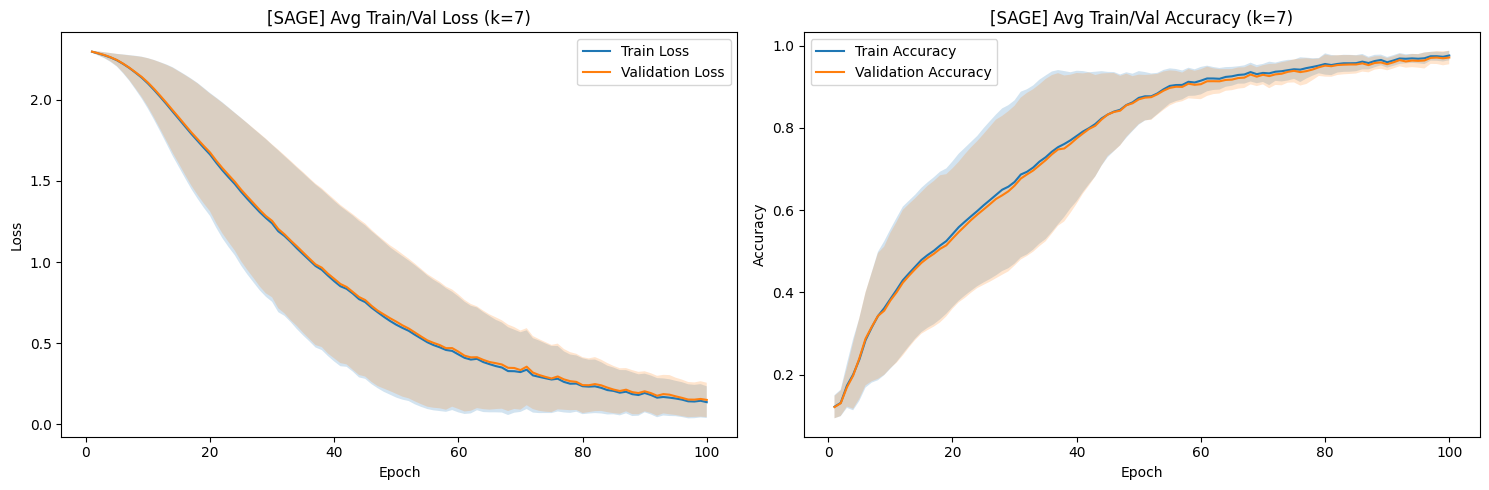

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_10_GCN
Using existing processed data for k_10_GCN
Starting k-fold cross-validation for GCN...

--- Fold 1/10 ---
Epoch 010, Train Loss: 2.2838, Train Acc: 0.1156, Val Loss: 2.2880, Val Acc: 0.1182
Epoch 020, Train Loss: 2.2359, Train Acc: 0.1184, Val Loss: 2.2448, Val Acc: 0.1182


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1116, Train Acc: 0.1689, Val Loss: 2.1213, Val Acc: 0.1891
Epoch 040, Train Loss: 1.8910, Train Acc: 0.4287, Val Loss: 1.9021, Val Acc: 0.4279
Epoch 050, Train Loss: 1.5147, Train Acc: 0.6354, Val Loss: 1.5307, Val Acc: 0.6182
Epoch 060, Train Loss: 1.0992, Train Acc: 0.8144, Val Loss: 1.1167, Val Acc: 0.7910
Epoch 070, Train Loss: 0.7148, Train Acc: 0.9378, Val Loss: 0.7422, Val Acc: 0.9279
Epoch 080, Train Loss: 0.5070, Train Acc: 0.9608, Val Loss: 0.5292, Val Acc: 0.9602
Epoch 090, Train Loss: 0.3679, Train Acc: 0.9754, Val Loss: 0.3912, Val Acc: 0.9701


[I 2025-01-26 16:44:26,534] Trial 0 finished with value: 0.30025458335876465 and parameters: {'hidden_channels': 46, 'dropout': 0.2450549479336691, 'lr': 0.0007531705758867818}. Best is trial 0 with value: 0.30025458335876465.


Epoch 100, Train Loss: 0.2780, Train Acc: 0.9753, Val Loss: 0.3003, Val Acc: 0.9714
Epoch 010, Train Loss: 2.2987, Train Acc: 0.1016, Val Loss: 2.2975, Val Acc: 0.1007
Epoch 020, Train Loss: 2.2806, Train Acc: 0.1299, Val Loss: 2.2801, Val Acc: 0.1294


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.2125, Train Acc: 0.1835, Val Loss: 2.2135, Val Acc: 0.1741
Epoch 040, Train Loss: 2.0750, Train Acc: 0.2734, Val Loss: 2.0777, Val Acc: 0.2674
Epoch 050, Train Loss: 1.8382, Train Acc: 0.4523, Val Loss: 1.8473, Val Acc: 0.4391
Epoch 060, Train Loss: 1.4970, Train Acc: 0.6968, Val Loss: 1.5116, Val Acc: 0.6816
Epoch 070, Train Loss: 1.1081, Train Acc: 0.8459, Val Loss: 1.1331, Val Acc: 0.8346
Epoch 080, Train Loss: 0.8334, Train Acc: 0.8718, Val Loss: 0.8594, Val Acc: 0.8694


[I 2025-01-26 16:44:27,325] Trial 1 finished with value: 0.5950028300285339 and parameters: {'hidden_channels': 58, 'dropout': 0.3895977471120979, 'lr': 0.0003050618031668599}. Best is trial 0 with value: 0.30025458335876465.


Epoch 090, Train Loss: 0.6548, Train Acc: 0.9098, Val Loss: 0.6841, Val Acc: 0.8980
Epoch 100, Train Loss: 0.5615, Train Acc: 0.9242, Val Loss: 0.5950, Val Acc: 0.9104
Epoch 010, Train Loss: 2.2903, Train Acc: 0.1223, Val Loss: 2.2927, Val Acc: 0.1082
Epoch 020, Train Loss: 2.2498, Train Acc: 0.1364, Val Loss: 2.2543, Val Acc: 0.1231


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1683, Train Acc: 0.3405, Val Loss: 2.1751, Val Acc: 0.3246
Epoch 040, Train Loss: 2.0347, Train Acc: 0.5245, Val Loss: 2.0448, Val Acc: 0.5050
Epoch 050, Train Loss: 1.8443, Train Acc: 0.6052, Val Loss: 1.8588, Val Acc: 0.5846
Epoch 060, Train Loss: 1.6004, Train Acc: 0.7323, Val Loss: 1.6182, Val Acc: 0.7027
Epoch 070, Train Loss: 1.3705, Train Acc: 0.7836, Val Loss: 1.3957, Val Acc: 0.7600
Epoch 080, Train Loss: 1.1732, Train Acc: 0.7964, Val Loss: 1.2087, Val Acc: 0.7836
Epoch 090, Train Loss: 1.0170, Train Acc: 0.8448, Val Loss: 1.0515, Val Acc: 0.8333


[I 2025-01-26 16:44:27,835] Trial 2 finished with value: 0.9520627856254578 and parameters: {'hidden_channels': 22, 'dropout': 0.23780353963183415, 'lr': 0.0005512769083064944}. Best is trial 0 with value: 0.30025458335876465.


Epoch 100, Train Loss: 0.9107, Train Acc: 0.8577, Val Loss: 0.9521, Val Acc: 0.8433
Epoch 010, Train Loss: 2.2882, Train Acc: 0.1118, Val Loss: 2.2874, Val Acc: 0.1169
Epoch 020, Train Loss: 2.2345, Train Acc: 0.2077, Val Loss: 2.2367, Val Acc: 0.2077


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1238, Train Acc: 0.2683, Val Loss: 2.1290, Val Acc: 0.2711
Epoch 040, Train Loss: 1.9464, Train Acc: 0.4215, Val Loss: 1.9582, Val Acc: 0.4154
Epoch 050, Train Loss: 1.7083, Train Acc: 0.6524, Val Loss: 1.7263, Val Acc: 0.6430
Epoch 060, Train Loss: 1.3964, Train Acc: 0.7684, Val Loss: 1.4257, Val Acc: 0.7400
Epoch 070, Train Loss: 1.0857, Train Acc: 0.8459, Val Loss: 1.1246, Val Acc: 0.8097
Epoch 080, Train Loss: 0.8611, Train Acc: 0.8788, Val Loss: 0.9110, Val Acc: 0.8507


[I 2025-01-26 16:44:28,498] Trial 3 finished with value: 0.6775389909744263 and parameters: {'hidden_channels': 41, 'dropout': 0.473438196480061, 'lr': 0.00039465013318056046}. Best is trial 0 with value: 0.30025458335876465.


Epoch 090, Train Loss: 0.7162, Train Acc: 0.9081, Val Loss: 0.7668, Val Acc: 0.8905
Epoch 100, Train Loss: 0.6280, Train Acc: 0.9210, Val Loss: 0.6775, Val Acc: 0.9055
Epoch 010, Train Loss: 2.2779, Train Acc: 0.2117, Val Loss: 2.2763, Val Acc: 0.2077


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1904, Train Acc: 0.1775, Val Loss: 2.1904, Val Acc: 0.1816
Epoch 030, Train Loss: 2.0169, Train Acc: 0.1639, Val Loss: 2.0177, Val Acc: 0.1791
Epoch 040, Train Loss: 1.7204, Train Acc: 0.4301, Val Loss: 1.7303, Val Acc: 0.4440
Epoch 050, Train Loss: 1.2891, Train Acc: 0.7591, Val Loss: 1.3091, Val Acc: 0.7488
Epoch 060, Train Loss: 0.8298, Train Acc: 0.8966, Val Loss: 0.8549, Val Acc: 0.8719
Epoch 070, Train Loss: 0.4939, Train Acc: 0.9543, Val Loss: 0.5183, Val Acc: 0.9502
Epoch 080, Train Loss: 0.3289, Train Acc: 0.9675, Val Loss: 0.3608, Val Acc: 0.9652
Epoch 090, Train Loss: 0.2108, Train Acc: 0.9893, Val Loss: 0.2298, Val Acc: 0.9863


[I 2025-01-26 16:44:29,231] Trial 4 finished with value: 0.16359351575374603 and parameters: {'hidden_channels': 52, 'dropout': 0.30794703266291523, 'lr': 0.0010715010132886086}. Best is trial 4 with value: 0.16359351575374603.


Epoch 100, Train Loss: 0.1523, Train Acc: 0.9896, Val Loss: 0.1636, Val Acc: 0.9888
  Fold 1 - Optuna Best Trial Val Loss: 0.1636
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 52, 'dropout': 0.30794703266291523, 'lr': 0.0010715010132886086}
Epoch 010, Train Loss: 2.2665, Train Acc: 0.1778, Val Loss: 2.2689, Val Acc: 0.1903
Epoch 020, Train Loss: 2.1690, Train Acc: 0.4096, Val Loss: 2.1735, Val Acc: 0.3993


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.9878, Train Acc: 0.4792, Val Loss: 1.9956, Val Acc: 0.4701
Epoch 040, Train Loss: 1.6956, Train Acc: 0.6155, Val Loss: 1.7096, Val Acc: 0.5945
Epoch 050, Train Loss: 1.3099, Train Acc: 0.8049, Val Loss: 1.3323, Val Acc: 0.7811
Epoch 060, Train Loss: 0.9052, Train Acc: 0.9126, Val Loss: 0.9360, Val Acc: 0.8918
Epoch 070, Train Loss: 0.5389, Train Acc: 0.9446, Val Loss: 0.5695, Val Acc: 0.9303
Epoch 080, Train Loss: 0.3554, Train Acc: 0.9644, Val Loss: 0.3858, Val Acc: 0.9602
Epoch 090, Train Loss: 0.2557, Train Acc: 0.9790, Val Loss: 0.2822, Val Acc: 0.9813


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1966, Train Acc: 0.9784, Val Loss: 0.2147, Val Acc: 0.9801
  Fold 1 Test Metrics:
  Accuracy: 0.9726
  Precision: 0.9732
  Recall: 0.9726
  F1: 0.9726

--- Fold 2/10 ---
Epoch 010, Train Loss: 2.2983, Train Acc: 0.1098, Val Loss: 2.2975, Val Acc: 0.1206
Epoch 020, Train Loss: 2.2884, Train Acc: 0.1098, Val Loss: 2.2886, Val Acc: 0.1070
Epoch 030, Train Loss: 2.2568, Train Acc: 0.1901, Val Loss: 2.2597, Val Acc: 0.1841


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.1929, Train Acc: 0.2363, Val Loss: 2.1992, Val Acc: 0.2289
Epoch 050, Train Loss: 2.0955, Train Acc: 0.2758, Val Loss: 2.0993, Val Acc: 0.2774
Epoch 060, Train Loss: 1.9322, Train Acc: 0.3742, Val Loss: 1.9358, Val Acc: 0.3694
Epoch 070, Train Loss: 1.7036, Train Acc: 0.5704, Val Loss: 1.7087, Val Acc: 0.5709
Epoch 080, Train Loss: 1.5072, Train Acc: 0.6779, Val Loss: 1.5116, Val Acc: 0.6692


[I 2025-01-26 16:44:30,481] Trial 0 finished with value: 1.3091506958007812 and parameters: {'hidden_channels': 17, 'dropout': 0.4820726215203323, 'lr': 0.0002555343447321702}. Best is trial 0 with value: 1.3091506958007812.


Epoch 090, Train Loss: 1.3799, Train Acc: 0.7136, Val Loss: 1.3830, Val Acc: 0.7090
Epoch 100, Train Loss: 1.3029, Train Acc: 0.7472, Val Loss: 1.3092, Val Acc: 0.7463
Epoch 010, Train Loss: 2.3013, Train Acc: 0.0949, Val Loss: 2.3027, Val Acc: 0.0883
Epoch 020, Train Loss: 2.2759, Train Acc: 0.1034, Val Loss: 2.2768, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2075, Train Acc: 0.1179, Val Loss: 2.2059, Val Acc: 0.1157


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.0875, Train Acc: 0.2470, Val Loss: 2.0832, Val Acc: 0.2624
Epoch 050, Train Loss: 1.9057, Train Acc: 0.4886, Val Loss: 1.9025, Val Acc: 0.4938
Epoch 060, Train Loss: 1.6334, Train Acc: 0.6699, Val Loss: 1.6372, Val Acc: 0.6592
Epoch 070, Train Loss: 1.3493, Train Acc: 0.7374, Val Loss: 1.3664, Val Acc: 0.7239
Epoch 080, Train Loss: 1.1417, Train Acc: 0.7676, Val Loss: 1.1575, Val Acc: 0.7450


[I 2025-01-26 16:44:30,956] Trial 1 finished with value: 1.0042967796325684 and parameters: {'hidden_channels': 16, 'dropout': 0.3381931304494965, 'lr': 0.0008716662460196973}. Best is trial 1 with value: 1.0042967796325684.


Epoch 090, Train Loss: 1.0392, Train Acc: 0.7959, Val Loss: 1.0610, Val Acc: 0.7749
Epoch 100, Train Loss: 0.9733, Train Acc: 0.8147, Val Loss: 1.0043, Val Acc: 0.8022
Epoch 010, Train Loss: 2.1474, Train Acc: 0.3439, Val Loss: 2.1479, Val Acc: 0.3296
Epoch 020, Train Loss: 1.7871, Train Acc: 0.6026, Val Loss: 1.7978, Val Acc: 0.5896


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.2608, Train Acc: 0.7805, Val Loss: 1.2781, Val Acc: 0.7786
Epoch 040, Train Loss: 0.7515, Train Acc: 0.9000, Val Loss: 0.7695, Val Acc: 0.8955
Epoch 050, Train Loss: 0.4224, Train Acc: 0.9306, Val Loss: 0.4317, Val Acc: 0.9216
Epoch 060, Train Loss: 0.2671, Train Acc: 0.9431, Val Loss: 0.2922, Val Acc: 0.9241
Epoch 070, Train Loss: 0.2581, Train Acc: 0.9502, Val Loss: 0.2935, Val Acc: 0.9403
Epoch 080, Train Loss: 0.1775, Train Acc: 0.9614, Val Loss: 0.1975, Val Acc: 0.9540


[I 2025-01-26 16:44:31,651] Trial 2 finished with value: 0.09236308932304382 and parameters: {'hidden_channels': 45, 'dropout': 0.48699183477487695, 'lr': 0.003575919802862357}. Best is trial 2 with value: 0.09236308932304382.


Epoch 090, Train Loss: 0.1026, Train Acc: 0.9844, Val Loss: 0.1292, Val Acc: 0.9789
Epoch 100, Train Loss: 0.0786, Train Acc: 0.9919, Val Loss: 0.0924, Val Acc: 0.9938
Epoch 010, Train Loss: 2.2887, Train Acc: 0.1154, Val Loss: 2.2885, Val Acc: 0.1169


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2540, Train Acc: 0.1905, Val Loss: 2.2539, Val Acc: 0.1841
Epoch 030, Train Loss: 2.1660, Train Acc: 0.2128, Val Loss: 2.1740, Val Acc: 0.2052
Epoch 040, Train Loss: 2.0120, Train Acc: 0.3573, Val Loss: 2.0304, Val Acc: 0.3420
Epoch 050, Train Loss: 1.7707, Train Acc: 0.5847, Val Loss: 1.7962, Val Acc: 0.5709
Epoch 060, Train Loss: 1.3892, Train Acc: 0.7894, Val Loss: 1.4070, Val Acc: 0.7799
Epoch 070, Train Loss: 1.0052, Train Acc: 0.8838, Val Loss: 1.0241, Val Acc: 0.8930
Epoch 080, Train Loss: 0.7557, Train Acc: 0.9071, Val Loss: 0.7688, Val Acc: 0.9104
Epoch 090, Train Loss: 0.6039, Train Acc: 0.9392, Val Loss: 0.6294, Val Acc: 0.9378


[I 2025-01-26 16:44:32,300] Trial 3 finished with value: 0.5086272358894348 and parameters: {'hidden_channels': 37, 'dropout': 0.4923073811649197, 'lr': 0.0006843578175797307}. Best is trial 2 with value: 0.09236308932304382.


Epoch 100, Train Loss: 0.4895, Train Acc: 0.9403, Val Loss: 0.5086, Val Acc: 0.9341
Epoch 010, Train Loss: 2.2051, Train Acc: 0.3756, Val Loss: 2.2027, Val Acc: 0.3769
Epoch 020, Train Loss: 1.9862, Train Acc: 0.4640, Val Loss: 1.9826, Val Acc: 0.4502


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.6806, Train Acc: 0.6534, Val Loss: 1.6787, Val Acc: 0.6542
Epoch 040, Train Loss: 1.2465, Train Acc: 0.7917, Val Loss: 1.2523, Val Acc: 0.7898
Epoch 050, Train Loss: 0.7816, Train Acc: 0.9040, Val Loss: 0.7898, Val Acc: 0.8993
Epoch 060, Train Loss: 0.4512, Train Acc: 0.9468, Val Loss: 0.4555, Val Acc: 0.9502
Epoch 070, Train Loss: 0.2664, Train Acc: 0.9692, Val Loss: 0.2797, Val Acc: 0.9677
Epoch 080, Train Loss: 0.2005, Train Acc: 0.9634, Val Loss: 0.2172, Val Acc: 0.9552


[I 2025-01-26 16:44:33,014] Trial 4 finished with value: 0.17411735653877258 and parameters: {'hidden_channels': 49, 'dropout': 0.48457087379480673, 'lr': 0.0020404027517516195}. Best is trial 2 with value: 0.09236308932304382.


Epoch 090, Train Loss: 0.1396, Train Acc: 0.9858, Val Loss: 0.1464, Val Acc: 0.9863
Epoch 100, Train Loss: 0.1458, Train Acc: 0.9729, Val Loss: 0.1741, Val Acc: 0.9614
  Fold 2 - Optuna Best Trial Val Loss: 0.0924
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 45, 'dropout': 0.48699183477487695, 'lr': 0.003575919802862357}
Epoch 010, Train Loss: 2.1682, Train Acc: 0.3576, Val Loss: 2.1637, Val Acc: 0.3694


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8322, Train Acc: 0.6119, Val Loss: 1.8307, Val Acc: 0.6194
Epoch 030, Train Loss: 1.3946, Train Acc: 0.6967, Val Loss: 1.4150, Val Acc: 0.6978
Epoch 040, Train Loss: 0.8523, Train Acc: 0.8653, Val Loss: 0.8554, Val Acc: 0.8619
Epoch 050, Train Loss: 0.4715, Train Acc: 0.9099, Val Loss: 0.4906, Val Acc: 0.9030
Epoch 060, Train Loss: 0.2658, Train Acc: 0.9354, Val Loss: 0.2954, Val Acc: 0.9266
Epoch 070, Train Loss: 0.1844, Train Acc: 0.9547, Val Loss: 0.2226, Val Acc: 0.9502
Epoch 080, Train Loss: 0.1393, Train Acc: 0.9754, Val Loss: 0.1677, Val Acc: 0.9701
Epoch 090, Train Loss: 0.1789, Train Acc: 0.9667, Val Loss: 0.2301, Val Acc: 0.9577


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1134, Train Acc: 0.9785, Val Loss: 0.1214, Val Acc: 0.9714
  Fold 2 Test Metrics:
  Accuracy: 0.9776
  Precision: 0.9789
  Recall: 0.9776
  F1: 0.9775

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:33,850] Trial 0 finished with value: 2.30381441116333 and parameters: {'hidden_channels': 23, 'dropout': 0.48189491090414704, 'lr': 0.00010541978622242496}. Best is trial 0 with value: 2.30381441116333.


Epoch 010, Train Loss: 2.3054, Train Acc: 0.1562, Val Loss: 2.3027, Val Acc: 0.1679
Epoch 020, Train Loss: 2.3111, Train Acc: 0.1739, Val Loss: 2.3070, Val Acc: 0.1891
Early stopping at epoch 24


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3045, Train Acc: 0.1023, Val Loss: 2.3075, Val Acc: 0.1007
Epoch 020, Train Loss: 2.2984, Train Acc: 0.1037, Val Loss: 2.3031, Val Acc: 0.1007
Epoch 030, Train Loss: 2.2301, Train Acc: 0.1442, Val Loss: 2.2358, Val Acc: 0.1331
Epoch 040, Train Loss: 2.1091, Train Acc: 0.3640, Val Loss: 2.1126, Val Acc: 0.3744
Epoch 050, Train Loss: 1.9218, Train Acc: 0.5433, Val Loss: 1.9226, Val Acc: 0.5435
Epoch 060, Train Loss: 1.6249, Train Acc: 0.7572, Val Loss: 1.6243, Val Acc: 0.7313
Epoch 070, Train Loss: 1.3169, Train Acc: 0.8328, Val Loss: 1.3156, Val Acc: 0.8221
Epoch 080, Train Loss: 1.0637, Train Acc: 0.8746, Val Loss: 1.0581, Val Acc: 0.8669
Epoch 090, Train Loss: 0.9075, Train Acc: 0.8829, Val Loss: 0.9049, Val Acc: 0.8794


[I 2025-01-26 16:44:34,492] Trial 1 finished with value: 0.7949950695037842 and parameters: {'hidden_channels': 37, 'dropout': 0.2860906673271231, 'lr': 0.0003035797953505189}. Best is trial 1 with value: 0.7949950695037842.


Epoch 100, Train Loss: 0.7968, Train Acc: 0.9009, Val Loss: 0.7950, Val Acc: 0.9104
Epoch 010, Train Loss: 2.2884, Train Acc: 0.1009, Val Loss: 2.2862, Val Acc: 0.1007
Epoch 020, Train Loss: 2.2271, Train Acc: 0.2089, Val Loss: 2.2209, Val Acc: 0.2114
Epoch 030, Train Loss: 2.0784, Train Acc: 0.3136, Val Loss: 2.0665, Val Acc: 0.3396
Epoch 040, Train Loss: 1.8690, Train Acc: 0.4859, Val Loss: 1.8525, Val Acc: 0.5199


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 1.5720, Train Acc: 0.7589, Val Loss: 1.5593, Val Acc: 0.7612
Epoch 060, Train Loss: 1.2704, Train Acc: 0.8527, Val Loss: 1.2671, Val Acc: 0.8458
Epoch 070, Train Loss: 1.0034, Train Acc: 0.9009, Val Loss: 1.0059, Val Acc: 0.8843
Epoch 080, Train Loss: 0.8478, Train Acc: 0.8945, Val Loss: 0.8520, Val Acc: 0.8905
Epoch 090, Train Loss: 0.7587, Train Acc: 0.9148, Val Loss: 0.7586, Val Acc: 0.9055


[I 2025-01-26 16:44:34,977] Trial 2 finished with value: 0.6522908210754395 and parameters: {'hidden_channels': 18, 'dropout': 0.2845349538411534, 'lr': 0.0013833925617359653}. Best is trial 2 with value: 0.6522908210754395.


Epoch 100, Train Loss: 0.6340, Train Acc: 0.9309, Val Loss: 0.6523, Val Acc: 0.9204
Epoch 010, Train Loss: 2.2954, Train Acc: 0.1000, Val Loss: 2.2963, Val Acc: 0.0995
Epoch 020, Train Loss: 2.2593, Train Acc: 0.1034, Val Loss: 2.2614, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1725, Train Acc: 0.1185, Val Loss: 2.1742, Val Acc: 0.1194
Epoch 040, Train Loss: 1.9996, Train Acc: 0.1635, Val Loss: 1.9921, Val Acc: 0.1629
Epoch 050, Train Loss: 1.7045, Train Acc: 0.5035, Val Loss: 1.6957, Val Acc: 0.5050
Epoch 060, Train Loss: 1.2752, Train Acc: 0.7821, Val Loss: 1.2657, Val Acc: 0.7836
Epoch 070, Train Loss: 0.8626, Train Acc: 0.8843, Val Loss: 0.8549, Val Acc: 0.8918
Epoch 080, Train Loss: 0.6170, Train Acc: 0.9225, Val Loss: 0.6173, Val Acc: 0.9216


[I 2025-01-26 16:44:35,772] Trial 3 finished with value: 0.3723384141921997 and parameters: {'hidden_channels': 63, 'dropout': 0.46177595428839674, 'lr': 0.0004632435462991909}. Best is trial 3 with value: 0.3723384141921997.


Epoch 090, Train Loss: 0.4667, Train Acc: 0.9420, Val Loss: 0.4686, Val Acc: 0.9428
Epoch 100, Train Loss: 0.3781, Train Acc: 0.9672, Val Loss: 0.3723, Val Acc: 0.9652
Epoch 010, Train Loss: 2.2059, Train Acc: 0.2218, Val Loss: 2.2052, Val Acc: 0.2189


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9888, Train Acc: 0.3245, Val Loss: 1.9878, Val Acc: 0.3085
Epoch 030, Train Loss: 1.6632, Train Acc: 0.4738, Val Loss: 1.6666, Val Acc: 0.4701
Epoch 040, Train Loss: 1.2082, Train Acc: 0.7175, Val Loss: 1.2167, Val Acc: 0.7177
Epoch 050, Train Loss: 0.6844, Train Acc: 0.9169, Val Loss: 0.7016, Val Acc: 0.9204
Epoch 060, Train Loss: 0.3719, Train Acc: 0.9501, Val Loss: 0.3949, Val Acc: 0.9428
Epoch 070, Train Loss: 0.2170, Train Acc: 0.9670, Val Loss: 0.2225, Val Acc: 0.9639
Epoch 080, Train Loss: 0.1362, Train Acc: 0.9784, Val Loss: 0.1389, Val Acc: 0.9801
Epoch 090, Train Loss: 0.1262, Train Acc: 0.9858, Val Loss: 0.1298, Val Acc: 0.9863


[I 2025-01-26 16:44:36,492] Trial 4 finished with value: 0.06647215038537979 and parameters: {'hidden_channels': 47, 'dropout': 0.31700238545356224, 'lr': 0.002523500202536222}. Best is trial 4 with value: 0.06647215038537979.


Epoch 100, Train Loss: 0.0717, Train Acc: 0.9966, Val Loss: 0.0665, Val Acc: 0.9975
  Fold 3 - Optuna Best Trial Val Loss: 0.0665
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 47, 'dropout': 0.31700238545356224, 'lr': 0.002523500202536222}
Epoch 010, Train Loss: 2.2330, Train Acc: 0.1739, Val Loss: 2.2307, Val Acc: 0.1828
Epoch 020, Train Loss: 2.0048, Train Acc: 0.3770, Val Loss: 2.0065, Val Acc: 0.3806


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.7148, Train Acc: 0.4959, Val Loss: 1.7186, Val Acc: 0.4963
Epoch 040, Train Loss: 1.2540, Train Acc: 0.6774, Val Loss: 1.2681, Val Acc: 0.6741
Epoch 050, Train Loss: 0.7102, Train Acc: 0.8765, Val Loss: 0.7050, Val Acc: 0.8769
Epoch 060, Train Loss: 0.3537, Train Acc: 0.9538, Val Loss: 0.3486, Val Acc: 0.9652
Epoch 070, Train Loss: 0.2032, Train Acc: 0.9729, Val Loss: 0.1956, Val Acc: 0.9764
Epoch 080, Train Loss: 0.1865, Train Acc: 0.9773, Val Loss: 0.1588, Val Acc: 0.9776
Epoch 090, Train Loss: 0.1030, Train Acc: 0.9899, Val Loss: 0.1044, Val Acc: 0.9888


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0880, Train Acc: 0.9908, Val Loss: 0.0899, Val Acc: 0.9913
  Fold 3 Test Metrics:
  Accuracy: 0.9863
  Precision: 0.9874
  Recall: 0.9863
  F1: 0.9865

--- Fold 4/10 ---
Epoch 010, Train Loss: 2.1782, Train Acc: 0.3763, Val Loss: 2.1800, Val Acc: 0.3632
Epoch 020, Train Loss: 1.9054, Train Acc: 0.4360, Val Loss: 1.9156, Val Acc: 0.4502


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.5199, Train Acc: 0.6262, Val Loss: 1.5367, Val Acc: 0.6418
Epoch 040, Train Loss: 1.0059, Train Acc: 0.8435, Val Loss: 1.0280, Val Acc: 0.8259
Epoch 050, Train Loss: 0.5796, Train Acc: 0.9214, Val Loss: 0.6089, Val Acc: 0.8993
Epoch 060, Train Loss: 0.3245, Train Acc: 0.9512, Val Loss: 0.3419, Val Acc: 0.9478
Epoch 070, Train Loss: 0.2080, Train Acc: 0.9686, Val Loss: 0.2517, Val Acc: 0.9590
Epoch 080, Train Loss: 0.1387, Train Acc: 0.9807, Val Loss: 0.1502, Val Acc: 0.9776


[I 2025-01-26 16:44:37,942] Trial 0 finished with value: 0.09007643908262253 and parameters: {'hidden_channels': 48, 'dropout': 0.23134487523555897, 'lr': 0.003047717967411398}. Best is trial 0 with value: 0.09007643908262253.


Epoch 090, Train Loss: 0.1184, Train Acc: 0.9812, Val Loss: 0.1411, Val Acc: 0.9751
Epoch 100, Train Loss: 0.0752, Train Acc: 0.9928, Val Loss: 0.0901, Val Acc: 0.9925
Epoch 010, Train Loss: 2.0220, Train Acc: 0.4757, Val Loss: 2.0312, Val Acc: 0.4565


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.4113, Train Acc: 0.6651, Val Loss: 1.4220, Val Acc: 0.6430
Epoch 030, Train Loss: 0.8185, Train Acc: 0.7889, Val Loss: 0.8399, Val Acc: 0.7736
Epoch 040, Train Loss: 0.3880, Train Acc: 0.9127, Val Loss: 0.3961, Val Acc: 0.9216
Epoch 050, Train Loss: 0.2004, Train Acc: 0.9619, Val Loss: 0.2185, Val Acc: 0.9602
Epoch 060, Train Loss: 0.1161, Train Acc: 0.9835, Val Loss: 0.1374, Val Acc: 0.9751
Epoch 070, Train Loss: 0.0705, Train Acc: 0.9961, Val Loss: 0.0780, Val Acc: 0.9900
Epoch 080, Train Loss: 0.1531, Train Acc: 0.9692, Val Loss: 0.1603, Val Acc: 0.9701
Epoch 090, Train Loss: 0.0800, Train Acc: 0.9792, Val Loss: 0.0950, Val Acc: 0.9776


[I 2025-01-26 16:44:38,704] Trial 1 finished with value: 0.09784282743930817 and parameters: {'hidden_channels': 55, 'dropout': 0.42955160732160014, 'lr': 0.006490776843407244}. Best is trial 0 with value: 0.09007643908262253.


Epoch 100, Train Loss: 0.0866, Train Acc: 0.9756, Val Loss: 0.0978, Val Acc: 0.9751
Epoch 010, Train Loss: 2.2648, Train Acc: 0.1758, Val Loss: 2.2647, Val Acc: 0.1654
Epoch 020, Train Loss: 2.1547, Train Acc: 0.2472, Val Loss: 2.1580, Val Acc: 0.2500
Epoch 030, Train Loss: 1.9630, Train Acc: 0.4417, Val Loss: 1.9731, Val Acc: 0.4204


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 1.6632, Train Acc: 0.6482, Val Loss: 1.6823, Val Acc: 0.6405
Epoch 050, Train Loss: 1.2639, Train Acc: 0.8270, Val Loss: 1.2876, Val Acc: 0.8047
Epoch 060, Train Loss: 0.8118, Train Acc: 0.9110, Val Loss: 0.8404, Val Acc: 0.9055
Epoch 070, Train Loss: 0.5531, Train Acc: 0.9225, Val Loss: 0.5635, Val Acc: 0.9279
Epoch 080, Train Loss: 0.3519, Train Acc: 0.9617, Val Loss: 0.3627, Val Acc: 0.9639


[I 2025-01-26 16:44:39,348] Trial 2 finished with value: 0.2828467786312103 and parameters: {'hidden_channels': 37, 'dropout': 0.24658876464943458, 'lr': 0.001399286904448102}. Best is trial 0 with value: 0.09007643908262253.


Epoch 090, Train Loss: 0.2467, Train Acc: 0.9708, Val Loss: 0.2522, Val Acc: 0.9701
Epoch 100, Train Loss: 0.2482, Train Acc: 0.9603, Val Loss: 0.2828, Val Acc: 0.9552
Epoch 010, Train Loss: 2.2207, Train Acc: 0.2283, Val Loss: 2.2254, Val Acc: 0.2152


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0442, Train Acc: 0.4408, Val Loss: 2.0602, Val Acc: 0.4366
Epoch 030, Train Loss: 1.7423, Train Acc: 0.6351, Val Loss: 1.7631, Val Acc: 0.6157
Epoch 040, Train Loss: 1.3135, Train Acc: 0.8068, Val Loss: 1.3363, Val Acc: 0.8047
Epoch 050, Train Loss: 0.8972, Train Acc: 0.9067, Val Loss: 0.9298, Val Acc: 0.9030
Epoch 060, Train Loss: 0.5115, Train Acc: 0.9417, Val Loss: 0.5406, Val Acc: 0.9353
Epoch 070, Train Loss: 0.3582, Train Acc: 0.9316, Val Loss: 0.3837, Val Acc: 0.9266
Epoch 080, Train Loss: 0.2135, Train Acc: 0.9718, Val Loss: 0.2325, Val Acc: 0.9689
Epoch 090, Train Loss: 0.1621, Train Acc: 0.9882, Val Loss: 0.1841, Val Acc: 0.9789


[I 2025-01-26 16:44:40,006] Trial 3 finished with value: 0.1246180385351181 and parameters: {'hidden_channels': 39, 'dropout': 0.35939402918973984, 'lr': 0.002143216017366721}. Best is trial 0 with value: 0.09007643908262253.


Epoch 100, Train Loss: 0.1105, Train Acc: 0.9932, Val Loss: 0.1246, Val Acc: 0.9913
Epoch 010, Train Loss: 2.2786, Train Acc: 0.0969, Val Loss: 2.2770, Val Acc: 0.0883
Epoch 020, Train Loss: 2.1582, Train Acc: 0.1807, Val Loss: 2.1583, Val Acc: 0.1741
Epoch 030, Train Loss: 1.9333, Train Acc: 0.3604, Val Loss: 1.9428, Val Acc: 0.3669
Epoch 040, Train Loss: 1.5718, Train Acc: 0.5555, Val Loss: 1.5879, Val Acc: 0.5336


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 050, Train Loss: 1.1618, Train Acc: 0.8101, Val Loss: 1.1879, Val Acc: 0.8035
Epoch 060, Train Loss: 0.8004, Train Acc: 0.8977, Val Loss: 0.8272, Val Acc: 0.9017
Epoch 070, Train Loss: 0.5742, Train Acc: 0.9213, Val Loss: 0.6089, Val Acc: 0.9104
Epoch 080, Train Loss: 0.4137, Train Acc: 0.9508, Val Loss: 0.4394, Val Acc: 0.9465
Epoch 090, Train Loss: 0.3305, Train Acc: 0.9513, Val Loss: 0.3554, Val Acc: 0.9440


[I 2025-01-26 16:44:40,502] Trial 4 finished with value: 0.29791125655174255 and parameters: {'hidden_channels': 22, 'dropout': 0.45774045707903216, 'lr': 0.002099871659736724}. Best is trial 0 with value: 0.09007643908262253.


Epoch 100, Train Loss: 0.2763, Train Acc: 0.9583, Val Loss: 0.2979, Val Acc: 0.9540
  Fold 4 - Optuna Best Trial Val Loss: 0.0901
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 48, 'dropout': 0.23134487523555897, 'lr': 0.003047717967411398}
Epoch 010, Train Loss: 2.2330, Train Acc: 0.1926, Val Loss: 2.2387, Val Acc: 0.1953
Epoch 020, Train Loss: 2.0148, Train Acc: 0.3615, Val Loss: 2.0234, Val Acc: 0.3818


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.6165, Train Acc: 0.5024, Val Loss: 1.6338, Val Acc: 0.5100
Epoch 040, Train Loss: 1.0361, Train Acc: 0.7668, Val Loss: 1.0758, Val Acc: 0.7400
Epoch 050, Train Loss: 0.5341, Train Acc: 0.9308, Val Loss: 0.5709, Val Acc: 0.9142
Epoch 060, Train Loss: 0.2733, Train Acc: 0.9656, Val Loss: 0.2874, Val Acc: 0.9664
Epoch 070, Train Loss: 0.2204, Train Acc: 0.9711, Val Loss: 0.2560, Val Acc: 0.9664
Epoch 080, Train Loss: 0.1463, Train Acc: 0.9745, Val Loss: 0.1763, Val Acc: 0.9751


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0893, Train Acc: 0.9904, Val Loss: 0.1102, Val Acc: 0.9863
Epoch 100, Train Loss: 0.0642, Train Acc: 0.9939, Val Loss: 0.0755, Val Acc: 0.9925
  Fold 4 Test Metrics:
  Accuracy: 0.9950
  Precision: 0.9952
  Recall: 0.9950
  F1: 0.9950

--- Fold 5/10 ---
Epoch 010, Train Loss: 2.2886, Train Acc: 0.0916, Val Loss: 2.2906, Val Acc: 0.0983


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2335, Train Acc: 0.1843, Val Loss: 2.2406, Val Acc: 0.1791
Epoch 030, Train Loss: 2.1381, Train Acc: 0.2652, Val Loss: 2.1507, Val Acc: 0.2500
Epoch 040, Train Loss: 1.9545, Train Acc: 0.4498, Val Loss: 1.9739, Val Acc: 0.4602
Epoch 050, Train Loss: 1.6819, Train Acc: 0.6727, Val Loss: 1.6996, Val Acc: 0.6716
Epoch 060, Train Loss: 1.3278, Train Acc: 0.8163, Val Loss: 1.3434, Val Acc: 0.8333
Epoch 070, Train Loss: 0.9741, Train Acc: 0.8746, Val Loss: 0.9742, Val Acc: 0.8893
Epoch 080, Train Loss: 0.7167, Train Acc: 0.9115, Val Loss: 0.7137, Val Acc: 0.9179
Epoch 090, Train Loss: 0.5864, Train Acc: 0.9272, Val Loss: 0.5919, Val Acc: 0.9266


[I 2025-01-26 16:44:41,866] Trial 0 finished with value: 0.5046811103820801 and parameters: {'hidden_channels': 35, 'dropout': 0.38479792012262864, 'lr': 0.0006572970882708728}. Best is trial 0 with value: 0.5046811103820801.


Epoch 100, Train Loss: 0.5003, Train Acc: 0.9281, Val Loss: 0.5047, Val Acc: 0.9254
Epoch 010, Train Loss: 2.2017, Train Acc: 0.2804, Val Loss: 2.2019, Val Acc: 0.2811
Epoch 020, Train Loss: 1.8772, Train Acc: 0.5037, Val Loss: 1.8795, Val Acc: 0.4925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.4174, Train Acc: 0.7278, Val Loss: 1.4320, Val Acc: 0.7450
Epoch 040, Train Loss: 0.9417, Train Acc: 0.8518, Val Loss: 0.9685, Val Acc: 0.8470
Epoch 050, Train Loss: 0.5028, Train Acc: 0.9283, Val Loss: 0.5161, Val Acc: 0.9328
Epoch 060, Train Loss: 0.2993, Train Acc: 0.9474, Val Loss: 0.3131, Val Acc: 0.9440
Epoch 070, Train Loss: 0.1700, Train Acc: 0.9745, Val Loss: 0.1702, Val Acc: 0.9789
Epoch 080, Train Loss: 0.1274, Train Acc: 0.9810, Val Loss: 0.1319, Val Acc: 0.9776


[I 2025-01-26 16:44:42,595] Trial 1 finished with value: 0.10853258520364761 and parameters: {'hidden_channels': 48, 'dropout': 0.47620725378631584, 'lr': 0.003085668494104296}. Best is trial 1 with value: 0.10853258520364761.


Epoch 090, Train Loss: 0.2247, Train Acc: 0.9564, Val Loss: 0.2299, Val Acc: 0.9602
Epoch 100, Train Loss: 0.1040, Train Acc: 0.9935, Val Loss: 0.1085, Val Acc: 0.9913
Epoch 010, Train Loss: 2.1821, Train Acc: 0.2112, Val Loss: 2.1885, Val Acc: 0.2102


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9286, Train Acc: 0.3290, Val Loss: 1.9435, Val Acc: 0.3147
Epoch 030, Train Loss: 1.5720, Train Acc: 0.4945, Val Loss: 1.5866, Val Acc: 0.4764
Epoch 040, Train Loss: 1.1108, Train Acc: 0.7332, Val Loss: 1.1306, Val Acc: 0.7214
Epoch 050, Train Loss: 0.6881, Train Acc: 0.8673, Val Loss: 0.6947, Val Acc: 0.8744
Epoch 060, Train Loss: 0.3777, Train Acc: 0.9560, Val Loss: 0.3743, Val Acc: 0.9664
Epoch 070, Train Loss: 0.2446, Train Acc: 0.9729, Val Loss: 0.2626, Val Acc: 0.9701
Epoch 080, Train Loss: 0.1442, Train Acc: 0.9844, Val Loss: 0.1450, Val Acc: 0.9851
Epoch 090, Train Loss: 0.1065, Train Acc: 0.9846, Val Loss: 0.1226, Val Acc: 0.9801


[I 2025-01-26 16:44:43,302] Trial 2 finished with value: 0.29743513464927673 and parameters: {'hidden_channels': 48, 'dropout': 0.2995263690637493, 'lr': 0.00244321766476991}. Best is trial 1 with value: 0.10853258520364761.


Epoch 100, Train Loss: 0.2832, Train Acc: 0.9557, Val Loss: 0.2974, Val Acc: 0.9502
Epoch 010, Train Loss: 2.3097, Train Acc: 0.1003, Val Loss: 2.3105, Val Acc: 0.1007
Epoch 020, Train Loss: 2.3015, Train Acc: 0.2035, Val Loss: 2.3033, Val Acc: 0.1903


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.2700, Train Acc: 0.1983, Val Loss: 2.2706, Val Acc: 0.1965
Epoch 040, Train Loss: 2.2087, Train Acc: 0.2618, Val Loss: 2.2130, Val Acc: 0.2512
Epoch 050, Train Loss: 2.0803, Train Acc: 0.3223, Val Loss: 2.0865, Val Acc: 0.3097
Epoch 060, Train Loss: 1.8710, Train Acc: 0.4551, Val Loss: 1.8885, Val Acc: 0.4478
Epoch 070, Train Loss: 1.6198, Train Acc: 0.5463, Val Loss: 1.6434, Val Acc: 0.5423
Epoch 080, Train Loss: 1.3971, Train Acc: 0.6335, Val Loss: 1.4177, Val Acc: 0.6281
Epoch 090, Train Loss: 1.2353, Train Acc: 0.6884, Val Loss: 1.2531, Val Acc: 0.6891


[I 2025-01-26 16:44:44,048] Trial 3 finished with value: 1.1472125053405762 and parameters: {'hidden_channels': 52, 'dropout': 0.26000751806924044, 'lr': 0.00010689186667853644}. Best is trial 1 with value: 0.10853258520364761.


Epoch 100, Train Loss: 1.1350, Train Acc: 0.7264, Val Loss: 1.1472, Val Acc: 0.7226
Epoch 010, Train Loss: 2.1724, Train Acc: 0.3652, Val Loss: 2.1810, Val Acc: 0.3520
Epoch 020, Train Loss: 1.8387, Train Acc: 0.6329, Val Loss: 1.8526, Val Acc: 0.5920


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.3807, Train Acc: 0.7077, Val Loss: 1.3923, Val Acc: 0.6841
Epoch 040, Train Loss: 0.8843, Train Acc: 0.8491, Val Loss: 0.8993, Val Acc: 0.8333
Epoch 050, Train Loss: 0.5160, Train Acc: 0.9168, Val Loss: 0.5341, Val Acc: 0.9055
Epoch 060, Train Loss: 0.2717, Train Acc: 0.9582, Val Loss: 0.2698, Val Acc: 0.9652
Epoch 070, Train Loss: 0.1873, Train Acc: 0.9585, Val Loss: 0.1802, Val Acc: 0.9627
Epoch 080, Train Loss: 0.1550, Train Acc: 0.9683, Val Loss: 0.1512, Val Acc: 0.9726


[I 2025-01-26 16:44:44,794] Trial 4 finished with value: 0.07272184640169144 and parameters: {'hidden_channels': 52, 'dropout': 0.2723066910628839, 'lr': 0.0029962845670219555}. Best is trial 4 with value: 0.07272184640169144.


Epoch 090, Train Loss: 0.0808, Train Acc: 0.9891, Val Loss: 0.0854, Val Acc: 0.9913
Epoch 100, Train Loss: 0.0940, Train Acc: 0.9838, Val Loss: 0.0727, Val Acc: 0.9888
  Fold 5 - Optuna Best Trial Val Loss: 0.0727
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 52, 'dropout': 0.2723066910628839, 'lr': 0.0029962845670219555}
Epoch 010, Train Loss: 2.1989, Train Acc: 0.2792, Val Loss: 2.1987, Val Acc: 0.2799


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.9625, Train Acc: 0.4424, Val Loss: 1.9604, Val Acc: 0.4540
Epoch 030, Train Loss: 1.5985, Train Acc: 0.5256, Val Loss: 1.6105, Val Acc: 0.5199
Epoch 040, Train Loss: 1.1117, Train Acc: 0.7793, Val Loss: 1.1393, Val Acc: 0.7649
Epoch 050, Train Loss: 0.5390, Train Acc: 0.9337, Val Loss: 0.5547, Val Acc: 0.9391
Epoch 060, Train Loss: 0.2899, Train Acc: 0.9438, Val Loss: 0.3079, Val Acc: 0.9391
Epoch 070, Train Loss: 0.1747, Train Acc: 0.9745, Val Loss: 0.1791, Val Acc: 0.9764
Epoch 080, Train Loss: 0.1226, Train Acc: 0.9753, Val Loss: 0.1197, Val Acc: 0.9789
Epoch 090, Train Loss: 0.1159, Train Acc: 0.9812, Val Loss: 0.1320, Val Acc: 0.9789


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0739, Train Acc: 0.9902, Val Loss: 0.0690, Val Acc: 0.9925
  Fold 5 Test Metrics:
  Accuracy: 0.9888
  Precision: 0.9897
  Recall: 0.9888
  F1: 0.9889

--- Fold 6/10 ---
Epoch 010, Train Loss: 2.2620, Train Acc: 0.1002, Val Loss: 2.2686, Val Acc: 0.0958
Epoch 020, Train Loss: 2.1847, Train Acc: 0.1002, Val Loss: 2.1985, Val Acc: 0.0958


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.0369, Train Acc: 0.1036, Val Loss: 2.0417, Val Acc: 0.1032
Epoch 040, Train Loss: 1.7403, Train Acc: 0.2534, Val Loss: 1.7454, Val Acc: 0.2550
Epoch 050, Train Loss: 1.2598, Train Acc: 0.6051, Val Loss: 1.2726, Val Acc: 0.6119
Epoch 060, Train Loss: 0.7187, Train Acc: 0.8871, Val Loss: 0.7199, Val Acc: 0.8682
Epoch 070, Train Loss: 0.4215, Train Acc: 0.9479, Val Loss: 0.4211, Val Acc: 0.9428
Epoch 080, Train Loss: 0.2404, Train Acc: 0.9846, Val Loss: 0.2381, Val Acc: 0.9851
Epoch 090, Train Loss: 0.1841, Train Acc: 0.9885, Val Loss: 0.1772, Val Acc: 0.9888


[I 2025-01-26 16:44:46,325] Trial 0 finished with value: 0.12723295390605927 and parameters: {'hidden_channels': 57, 'dropout': 0.4357324028833539, 'lr': 0.0010627359617005744}. Best is trial 0 with value: 0.12723295390605927.


Epoch 100, Train Loss: 0.1383, Train Acc: 0.9877, Val Loss: 0.1272, Val Acc: 0.9913
Epoch 010, Train Loss: 2.3113, Train Acc: 0.0851, Val Loss: 2.3195, Val Acc: 0.0933


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:46,471] Trial 1 finished with value: 2.329400062561035 and parameters: {'hidden_channels': 45, 'dropout': 0.34765793109397414, 'lr': 0.00011614896291015596}. Best is trial 0 with value: 0.12723295390605927.


Epoch 020, Train Loss: 2.3097, Train Acc: 0.0843, Val Loss: 2.3290, Val Acc: 0.0896
Early stopping at epoch 21


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2896, Train Acc: 0.0978, Val Loss: 2.2887, Val Acc: 0.0970
Epoch 020, Train Loss: 2.2363, Train Acc: 0.1291, Val Loss: 2.2349, Val Acc: 0.1343
Epoch 030, Train Loss: 2.1376, Train Acc: 0.2493, Val Loss: 2.1433, Val Acc: 0.2251
Epoch 040, Train Loss: 1.9714, Train Acc: 0.4945, Val Loss: 1.9804, Val Acc: 0.4627
Epoch 050, Train Loss: 1.7067, Train Acc: 0.7615, Val Loss: 1.7170, Val Acc: 0.7450
Epoch 060, Train Loss: 1.3259, Train Acc: 0.8620, Val Loss: 1.3313, Val Acc: 0.8657
Epoch 070, Train Loss: 0.9519, Train Acc: 0.9202, Val Loss: 0.9499, Val Acc: 0.9142
Epoch 080, Train Loss: 0.7144, Train Acc: 0.9420, Val Loss: 0.7123, Val Acc: 0.9303


[I 2025-01-26 16:44:47,046] Trial 2 finished with value: 0.42757412791252136 and parameters: {'hidden_channels': 31, 'dropout': 0.20419555239606887, 'lr': 0.0008693350453987177}. Best is trial 0 with value: 0.12723295390605927.


Epoch 090, Train Loss: 0.5360, Train Acc: 0.9588, Val Loss: 0.5367, Val Acc: 0.9565
Epoch 100, Train Loss: 0.4286, Train Acc: 0.9767, Val Loss: 0.4276, Val Acc: 0.9751
Epoch 010, Train Loss: 2.2767, Train Acc: 0.1146, Val Loss: 2.2834, Val Acc: 0.1182


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2083, Train Acc: 0.2058, Val Loss: 2.2202, Val Acc: 0.1915
Epoch 030, Train Loss: 2.0593, Train Acc: 0.3676, Val Loss: 2.0671, Val Acc: 0.3694
Epoch 040, Train Loss: 1.8251, Train Acc: 0.6062, Val Loss: 1.8324, Val Acc: 0.5858
Epoch 050, Train Loss: 1.4566, Train Acc: 0.8053, Val Loss: 1.4633, Val Acc: 0.7973
Epoch 060, Train Loss: 1.0353, Train Acc: 0.8986, Val Loss: 1.0450, Val Acc: 0.8806
Epoch 070, Train Loss: 0.6684, Train Acc: 0.9466, Val Loss: 0.6747, Val Acc: 0.9341


[I 2025-01-26 16:44:47,827] Trial 3 finished with value: 0.2495042383670807 and parameters: {'hidden_channels': 62, 'dropout': 0.24014748088970916, 'lr': 0.0006169267747527609}. Best is trial 0 with value: 0.12723295390605927.


Epoch 080, Train Loss: 0.4351, Train Acc: 0.9633, Val Loss: 0.4365, Val Acc: 0.9614
Epoch 090, Train Loss: 0.3231, Train Acc: 0.9681, Val Loss: 0.3236, Val Acc: 0.9577
Epoch 100, Train Loss: 0.2524, Train Acc: 0.9778, Val Loss: 0.2495, Val Acc: 0.9739


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8902, Train Acc: 0.5712, Val Loss: 1.8925, Val Acc: 0.5647
Epoch 020, Train Loss: 1.1684, Train Acc: 0.7059, Val Loss: 1.1621, Val Acc: 0.7015
Epoch 030, Train Loss: 0.6508, Train Acc: 0.8256, Val Loss: 0.6274, Val Acc: 0.8408
Epoch 040, Train Loss: 0.2890, Train Acc: 0.9396, Val Loss: 0.2911, Val Acc: 0.9328
Epoch 050, Train Loss: 0.2481, Train Acc: 0.9424, Val Loss: 0.2182, Val Acc: 0.9478
Epoch 060, Train Loss: 0.1497, Train Acc: 0.9644, Val Loss: 0.1331, Val Acc: 0.9739
Epoch 070, Train Loss: 0.1018, Train Acc: 0.9764, Val Loss: 0.0883, Val Acc: 0.9776
Epoch 080, Train Loss: 0.2343, Train Acc: 0.9561, Val Loss: 0.2962, Val Acc: 0.9577


[I 2025-01-26 16:44:48,476] Trial 4 finished with value: 0.2313673496246338 and parameters: {'hidden_channels': 40, 'dropout': 0.2943643182787357, 'lr': 0.009417265004175926}. Best is trial 0 with value: 0.12723295390605927.


Epoch 090, Train Loss: 0.0795, Train Acc: 0.9765, Val Loss: 0.0868, Val Acc: 0.9739
Epoch 100, Train Loss: 0.2455, Train Acc: 0.9224, Val Loss: 0.2314, Val Acc: 0.9204
  Fold 6 - Optuna Best Trial Val Loss: 0.1272
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 57, 'dropout': 0.4357324028833539, 'lr': 0.0010627359617005744}
Epoch 010, Train Loss: 2.2641, Train Acc: 0.1695, Val Loss: 2.2664, Val Acc: 0.1741


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1784, Train Acc: 0.1750, Val Loss: 2.1788, Val Acc: 0.1866
Epoch 030, Train Loss: 1.9957, Train Acc: 0.2940, Val Loss: 1.9957, Val Acc: 0.2910
Epoch 040, Train Loss: 1.6705, Train Acc: 0.5416, Val Loss: 1.6773, Val Acc: 0.5585
Epoch 050, Train Loss: 1.2400, Train Acc: 0.7953, Val Loss: 1.2442, Val Acc: 0.7749
Epoch 060, Train Loss: 0.7918, Train Acc: 0.9202, Val Loss: 0.7949, Val Acc: 0.9080
Epoch 070, Train Loss: 0.4629, Train Acc: 0.9549, Val Loss: 0.4805, Val Acc: 0.9403


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.3162, Train Acc: 0.9641, Val Loss: 0.3304, Val Acc: 0.9577
Epoch 090, Train Loss: 0.2050, Train Acc: 0.9771, Val Loss: 0.2093, Val Acc: 0.9751
Epoch 100, Train Loss: 0.1683, Train Acc: 0.9812, Val Loss: 0.1805, Val Acc: 0.9701
  Fold 6 Test Metrics:
  Accuracy: 0.9838
  Precision: 0.9843
  Recall: 0.9838
  F1: 0.9838

--- Fold 7/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3031, Train Acc: 0.1110, Val Loss: 2.3043, Val Acc: 0.1096
Epoch 020, Train Loss: 2.2888, Train Acc: 0.1863, Val Loss: 2.2920, Val Acc: 0.1930
Epoch 030, Train Loss: 2.2211, Train Acc: 0.3086, Val Loss: 2.2235, Val Acc: 0.3076
Epoch 040, Train Loss: 2.0810, Train Acc: 0.3773, Val Loss: 2.0817, Val Acc: 0.3773
Epoch 050, Train Loss: 1.8345, Train Acc: 0.5330, Val Loss: 1.8329, Val Acc: 0.5305
Epoch 060, Train Loss: 1.4673, Train Acc: 0.7412, Val Loss: 1.4652, Val Acc: 0.7310
Epoch 070, Train Loss: 1.0939, Train Acc: 0.8398, Val Loss: 1.0955, Val Acc: 0.8207
Epoch 080, Train Loss: 0.8130, Train Acc: 0.8894, Val Loss: 0.8149, Val Acc: 0.8817
Epoch 090, Train Loss: 0.6559, Train Acc: 0.9191, Val Loss: 0.6667, Val Acc: 0.9091


[I 2025-01-26 16:44:49,974] Trial 0 finished with value: 0.5583263635635376 and parameters: {'hidden_channels': 55, 'dropout': 0.43749991568893765, 'lr': 0.0003254325348678621}. Best is trial 0 with value: 0.5583263635635376.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:50,138] Trial 1 finished with value: 2.3196542263031006 and parameters: {'hidden_channels': 55, 'dropout': 0.39211936341628145, 'lr': 0.00020942920614790193}. Best is trial 0 with value: 0.5583263635635376.


Epoch 100, Train Loss: 0.5461, Train Acc: 0.9320, Val Loss: 0.5583, Val Acc: 0.9128
Epoch 010, Train Loss: 2.3151, Train Acc: 0.0767, Val Loss: 2.3204, Val Acc: 0.0797
Epoch 020, Train Loss: 2.3161, Train Acc: 0.1583, Val Loss: 2.3252, Val Acc: 0.1594
Early stopping at epoch 22


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3024, Train Acc: 0.0992, Val Loss: 2.2986, Val Acc: 0.0984
Epoch 020, Train Loss: 2.2767, Train Acc: 0.0992, Val Loss: 2.2720, Val Acc: 0.0984
Epoch 030, Train Loss: 2.2122, Train Acc: 0.1073, Val Loss: 2.2075, Val Acc: 0.1083
Epoch 040, Train Loss: 2.0168, Train Acc: 0.2295, Val Loss: 2.0105, Val Acc: 0.2416
Epoch 050, Train Loss: 1.7288, Train Acc: 0.5650, Val Loss: 1.7186, Val Acc: 0.5928


[I 2025-01-26 16:44:50,610] Trial 2 finished with value: 0.6839764714241028 and parameters: {'hidden_channels': 18, 'dropout': 0.416428162493941, 'lr': 0.0010198701580590608}. Best is trial 0 with value: 0.5583263635635376.


Epoch 060, Train Loss: 1.3989, Train Acc: 0.7392, Val Loss: 1.3923, Val Acc: 0.7385
Epoch 070, Train Loss: 1.1463, Train Acc: 0.8034, Val Loss: 1.1401, Val Acc: 0.8132
Epoch 080, Train Loss: 0.9310, Train Acc: 0.8571, Val Loss: 0.9262, Val Acc: 0.8518
Epoch 090, Train Loss: 0.7893, Train Acc: 0.8846, Val Loss: 0.7770, Val Acc: 0.8817
Epoch 100, Train Loss: 0.6927, Train Acc: 0.9151, Val Loss: 0.6840, Val Acc: 0.9116


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0706, Train Acc: 0.5569, Val Loss: 2.0569, Val Acc: 0.5828
Epoch 020, Train Loss: 1.5253, Train Acc: 0.6577, Val Loss: 1.4954, Val Acc: 0.6700
Epoch 030, Train Loss: 0.9081, Train Acc: 0.8065, Val Loss: 0.8956, Val Acc: 0.7970
Epoch 040, Train Loss: 0.5402, Train Acc: 0.8694, Val Loss: 0.5524, Val Acc: 0.8506
Epoch 050, Train Loss: 0.3146, Train Acc: 0.9226, Val Loss: 0.3446, Val Acc: 0.9029
Epoch 060, Train Loss: 0.1924, Train Acc: 0.9527, Val Loss: 0.2241, Val Acc: 0.9390
Epoch 070, Train Loss: 0.1834, Train Acc: 0.9477, Val Loss: 0.2082, Val Acc: 0.9390
Epoch 080, Train Loss: 0.1165, Train Acc: 0.9723, Val Loss: 0.1275, Val Acc: 0.9701


[I 2025-01-26 16:44:51,230] Trial 3 finished with value: 0.11870448291301727 and parameters: {'hidden_channels': 34, 'dropout': 0.4422524909451874, 'lr': 0.00875122003207962}. Best is trial 3 with value: 0.11870448291301727.


Epoch 090, Train Loss: 0.0899, Train Acc: 0.9816, Val Loss: 0.0974, Val Acc: 0.9838
Epoch 100, Train Loss: 0.1146, Train Acc: 0.9680, Val Loss: 0.1187, Val Acc: 0.9676
Epoch 010, Train Loss: 2.2194, Train Acc: 0.3207, Val Loss: 2.2075, Val Acc: 0.3337
Epoch 020, Train Loss: 1.9216, Train Acc: 0.5376, Val Loss: 1.9115, Val Acc: 0.5616


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.4411, Train Acc: 0.6722, Val Loss: 1.4297, Val Acc: 0.6687
Epoch 040, Train Loss: 1.0409, Train Acc: 0.7709, Val Loss: 1.0314, Val Acc: 0.7522
Epoch 050, Train Loss: 0.7266, Train Acc: 0.8406, Val Loss: 0.7289, Val Acc: 0.8232
Epoch 060, Train Loss: 0.5582, Train Acc: 0.8785, Val Loss: 0.5649, Val Acc: 0.8692


[I 2025-01-26 16:44:51,727] Trial 4 finished with value: 0.18032461404800415 and parameters: {'hidden_channels': 19, 'dropout': 0.266957242784685, 'lr': 0.0066607323184288275}. Best is trial 3 with value: 0.11870448291301727.


Epoch 070, Train Loss: 0.4086, Train Acc: 0.9114, Val Loss: 0.4196, Val Acc: 0.9029
Epoch 080, Train Loss: 0.2900, Train Acc: 0.9400, Val Loss: 0.3091, Val Acc: 0.9265
Epoch 090, Train Loss: 0.2535, Train Acc: 0.9212, Val Loss: 0.2825, Val Acc: 0.8979
Epoch 100, Train Loss: 0.1655, Train Acc: 0.9670, Val Loss: 0.1803, Val Acc: 0.9639
  Fold 7 - Optuna Best Trial Val Loss: 0.1187
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 34, 'dropout': 0.4422524909451874, 'lr': 0.00875122003207962}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0111, Train Acc: 0.4700, Val Loss: 2.0043, Val Acc: 0.4807
Epoch 020, Train Loss: 1.3328, Train Acc: 0.7196, Val Loss: 1.3214, Val Acc: 0.7136
Epoch 030, Train Loss: 0.7587, Train Acc: 0.8538, Val Loss: 0.7531, Val Acc: 0.8394
Epoch 040, Train Loss: 0.4198, Train Acc: 0.9056, Val Loss: 0.4188, Val Acc: 0.8991
Epoch 050, Train Loss: 0.2759, Train Acc: 0.9316, Val Loss: 0.2874, Val Acc: 0.9240
Epoch 060, Train Loss: 0.2036, Train Acc: 0.9358, Val Loss: 0.2191, Val Acc: 0.9290
Epoch 070, Train Loss: 0.2044, Train Acc: 0.9359, Val Loss: 0.2093, Val Acc: 0.9352
Epoch 080, Train Loss: 0.1164, Train Acc: 0.9742, Val Loss: 0.1300, Val Acc: 0.9714


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0923, Train Acc: 0.9760, Val Loss: 0.0933, Val Acc: 0.9689
Epoch 100, Train Loss: 0.0705, Train Acc: 0.9880, Val Loss: 0.0661, Val Acc: 0.9900
  Fold 7 Test Metrics:
  Accuracy: 0.9789
  Precision: 0.9812
  Recall: 0.9789
  F1: 0.9792

--- Fold 8/10 ---
Epoch 010, Train Loss: 2.2877, Train Acc: 0.1636, Val Loss: 2.2876, Val Acc: 0.1793
Epoch 020, Train Loss: 2.2295, Train Acc: 0.2472, Val Loss: 2.2301, Val Acc: 0.2453


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.0779, Train Acc: 0.3026, Val Loss: 2.0731, Val Acc: 0.3176
Epoch 040, Train Loss: 1.8087, Train Acc: 0.4775, Val Loss: 1.7979, Val Acc: 0.4919
Epoch 050, Train Loss: 1.4708, Train Acc: 0.6946, Val Loss: 1.4540, Val Acc: 0.6949
Epoch 060, Train Loss: 1.0678, Train Acc: 0.8559, Val Loss: 1.0485, Val Acc: 0.8605


[I 2025-01-26 16:44:52,919] Trial 0 finished with value: 0.39991679787635803 and parameters: {'hidden_channels': 32, 'dropout': 0.35377457891799596, 'lr': 0.0009094943855584685}. Best is trial 0 with value: 0.39991679787635803.


Epoch 070, Train Loss: 0.7894, Train Acc: 0.9314, Val Loss: 0.7717, Val Acc: 0.9290
Epoch 080, Train Loss: 0.5872, Train Acc: 0.9420, Val Loss: 0.5745, Val Acc: 0.9377
Epoch 090, Train Loss: 0.4560, Train Acc: 0.9502, Val Loss: 0.4539, Val Acc: 0.9402
Epoch 100, Train Loss: 0.4016, Train Acc: 0.9653, Val Loss: 0.3999, Val Acc: 0.9577


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:53,028] Trial 1 finished with value: 2.3463175296783447 and parameters: {'hidden_channels': 20, 'dropout': 0.2057247812278854, 'lr': 0.00012893711850209104}. Best is trial 0 with value: 0.39991679787635803.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:53,136] Trial 2 finished with value: 2.34381103515625 and parameters: {'hidden_channels': 18, 'dropout': 0.24692542717785204, 'lr': 0.00014411878114200543}. Best is trial 0 with value: 0.39991679787635803.


Epoch 010, Train Loss: 2.3243, Train Acc: 0.1006, Val Loss: 2.3224, Val Acc: 0.0996
Epoch 020, Train Loss: 2.3490, Train Acc: 0.1062, Val Loss: 2.3454, Val Acc: 0.1009
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3176, Train Acc: 0.1546, Val Loss: 2.3174, Val Acc: 0.1644
Epoch 020, Train Loss: 2.3442, Train Acc: 0.1149, Val Loss: 2.3440, Val Acc: 0.1171
Early stopping at epoch 22


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2984, Train Acc: 0.0986, Val Loss: 2.2970, Val Acc: 0.0971
Epoch 020, Train Loss: 2.2764, Train Acc: 0.0989, Val Loss: 2.2721, Val Acc: 0.1021
Epoch 030, Train Loss: 2.1920, Train Acc: 0.1082, Val Loss: 2.1890, Val Acc: 0.1071
Epoch 040, Train Loss: 2.0219, Train Acc: 0.3408, Val Loss: 2.0158, Val Acc: 0.3387
Epoch 050, Train Loss: 1.7106, Train Acc: 0.6330, Val Loss: 1.7009, Val Acc: 0.6438
Epoch 060, Train Loss: 1.3097, Train Acc: 0.7848, Val Loss: 1.2963, Val Acc: 0.7808
Epoch 070, Train Loss: 0.9225, Train Acc: 0.8865, Val Loss: 0.9102, Val Acc: 0.8755
Epoch 080, Train Loss: 0.6720, Train Acc: 0.9282, Val Loss: 0.6660, Val Acc: 0.9191
Epoch 090, Train Loss: 0.5132, Train Acc: 0.9450, Val Loss: 0.5053, Val Acc: 0.9352


[I 2025-01-26 16:44:53,829] Trial 3 finished with value: 0.4015447497367859 and parameters: {'hidden_channels': 45, 'dropout': 0.28246603437441653, 'lr': 0.0005692579334283521}. Best is trial 0 with value: 0.39991679787635803.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:53,997] Trial 4 finished with value: 2.315847158432007 and parameters: {'hidden_channels': 55, 'dropout': 0.48805251339895644, 'lr': 0.00018877258668526325}. Best is trial 0 with value: 0.39991679787635803.


Epoch 100, Train Loss: 0.4055, Train Acc: 0.9518, Val Loss: 0.4015, Val Acc: 0.9440
Epoch 010, Train Loss: 2.3091, Train Acc: 0.1012, Val Loss: 2.3103, Val Acc: 0.0996
Epoch 020, Train Loss: 2.3157, Train Acc: 0.1399, Val Loss: 2.3162, Val Acc: 0.1345
Early stopping at epoch 21
  Fold 8 - Optuna Best Trial Val Loss: 0.3999
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 32, 'dropout': 0.35377457891799596, 'lr': 0.0009094943855584685}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2846, Train Acc: 0.0942, Val Loss: 2.2847, Val Acc: 0.0959
Epoch 020, Train Loss: 2.2240, Train Acc: 0.1894, Val Loss: 2.2254, Val Acc: 0.1743
Epoch 030, Train Loss: 2.1212, Train Acc: 0.2656, Val Loss: 2.1218, Val Acc: 0.2528
Epoch 040, Train Loss: 1.9220, Train Acc: 0.4128, Val Loss: 1.9258, Val Acc: 0.3873
Epoch 050, Train Loss: 1.6116, Train Acc: 0.7161, Val Loss: 1.6174, Val Acc: 0.7123
Epoch 060, Train Loss: 1.2327, Train Acc: 0.8694, Val Loss: 1.2235, Val Acc: 0.8630
Epoch 070, Train Loss: 0.9103, Train Acc: 0.9123, Val Loss: 0.8997, Val Acc: 0.9016
Epoch 080, Train Loss: 0.6679, Train Acc: 0.9378, Val Loss: 0.6645, Val Acc: 0.9228


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.5148, Train Acc: 0.9504, Val Loss: 0.5217, Val Acc: 0.9390
Epoch 100, Train Loss: 0.4197, Train Acc: 0.9619, Val Loss: 0.4250, Val Acc: 0.9440
  Fold 8 Test Metrics:
  Accuracy: 0.9577
  Precision: 0.9591
  Recall: 0.9577
  F1: 0.9576

--- Fold 9/10 ---
Epoch 010, Train Loss: 2.2978, Train Acc: 0.1168, Val Loss: 2.2999, Val Acc: 0.1183
Epoch 020, Train Loss: 2.2600, Train Acc: 0.1205, Val Loss: 2.2661, Val Acc: 0.1196


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1383, Train Acc: 0.2155, Val Loss: 2.1506, Val Acc: 0.1993
Epoch 040, Train Loss: 1.8690, Train Acc: 0.5077, Val Loss: 1.8951, Val Acc: 0.4757
Epoch 050, Train Loss: 1.4871, Train Acc: 0.7526, Val Loss: 1.5268, Val Acc: 0.7123
Epoch 060, Train Loss: 1.0547, Train Acc: 0.8840, Val Loss: 1.0901, Val Acc: 0.8904


[I 2025-01-26 16:44:55,112] Trial 0 finished with value: 0.3347802758216858 and parameters: {'hidden_channels': 26, 'dropout': 0.2516274314314338, 'lr': 0.001352602096830523}. Best is trial 0 with value: 0.3347802758216858.


Epoch 070, Train Loss: 0.7371, Train Acc: 0.9400, Val Loss: 0.7577, Val Acc: 0.9539
Epoch 080, Train Loss: 0.5402, Train Acc: 0.9628, Val Loss: 0.5594, Val Acc: 0.9676
Epoch 090, Train Loss: 0.4146, Train Acc: 0.9689, Val Loss: 0.4259, Val Acc: 0.9776
Epoch 100, Train Loss: 0.3315, Train Acc: 0.9773, Val Loss: 0.3348, Val Acc: 0.9838


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2579, Train Acc: 0.1454, Val Loss: 2.2597, Val Acc: 0.1357
Epoch 020, Train Loss: 2.1278, Train Acc: 0.3365, Val Loss: 2.1348, Val Acc: 0.3250
Epoch 030, Train Loss: 1.9295, Train Acc: 0.5669, Val Loss: 1.9423, Val Acc: 0.5654
Epoch 040, Train Loss: 1.6157, Train Acc: 0.7173, Val Loss: 1.6352, Val Acc: 0.7086
Epoch 050, Train Loss: 1.2098, Train Acc: 0.8882, Val Loss: 1.2269, Val Acc: 0.8842
Epoch 060, Train Loss: 0.7767, Train Acc: 0.9408, Val Loss: 0.7878, Val Acc: 0.9415
Epoch 070, Train Loss: 0.4711, Train Acc: 0.9563, Val Loss: 0.4806, Val Acc: 0.9626
Epoch 080, Train Loss: 0.3471, Train Acc: 0.9614, Val Loss: 0.3480, Val Acc: 0.9689


[I 2025-01-26 16:44:55,755] Trial 1 finished with value: 0.2512339949607849 and parameters: {'hidden_channels': 35, 'dropout': 0.30669923597356386, 'lr': 0.0015599036093937083}. Best is trial 1 with value: 0.2512339949607849.


Epoch 090, Train Loss: 0.2454, Train Acc: 0.9736, Val Loss: 0.2464, Val Acc: 0.9776
Epoch 100, Train Loss: 0.2378, Train Acc: 0.9761, Val Loss: 0.2512, Val Acc: 0.9776
Epoch 010, Train Loss: 2.3184, Train Acc: 0.0969, Val Loss: 2.3185, Val Acc: 0.0984


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:55,907] Trial 2 finished with value: 2.324467182159424 and parameters: {'hidden_channels': 47, 'dropout': 0.23404691906665143, 'lr': 0.0001079429824945016}. Best is trial 1 with value: 0.2512339949607849.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3242, Train Acc: 0.1395, Val Loss: 2.3250, Val Acc: 0.1382
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2879, Train Acc: 0.1308, Val Loss: 2.2872, Val Acc: 0.1370
Epoch 020, Train Loss: 2.2428, Train Acc: 0.2228, Val Loss: 2.2452, Val Acc: 0.2242
Epoch 030, Train Loss: 2.1415, Train Acc: 0.3968, Val Loss: 2.1515, Val Acc: 0.3724
Epoch 040, Train Loss: 1.9357, Train Acc: 0.4974, Val Loss: 1.9558, Val Acc: 0.4832
Epoch 050, Train Loss: 1.5969, Train Acc: 0.7266, Val Loss: 1.6233, Val Acc: 0.7036
Epoch 060, Train Loss: 1.1655, Train Acc: 0.8650, Val Loss: 1.1862, Val Acc: 0.8655
Epoch 070, Train Loss: 0.8095, Train Acc: 0.9132, Val Loss: 0.8290, Val Acc: 0.9290
Epoch 080, Train Loss: 0.5814, Train Acc: 0.9498, Val Loss: 0.5915, Val Acc: 0.9477


[I 2025-01-26 16:44:56,693] Trial 3 finished with value: 0.36706995964050293 and parameters: {'hidden_channels': 60, 'dropout': 0.41911808539427076, 'lr': 0.0004753307917235692}. Best is trial 1 with value: 0.2512339949607849.


Epoch 090, Train Loss: 0.4316, Train Acc: 0.9607, Val Loss: 0.4363, Val Acc: 0.9639
Epoch 100, Train Loss: 0.3579, Train Acc: 0.9627, Val Loss: 0.3671, Val Acc: 0.9577
Epoch 010, Train Loss: 2.3088, Train Acc: 0.1050, Val Loss: 2.3087, Val Acc: 0.1021


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:44:56,851] Trial 4 finished with value: 2.315732955932617 and parameters: {'hidden_channels': 46, 'dropout': 0.44862839013483385, 'lr': 0.00014927744553083655}. Best is trial 1 with value: 0.2512339949607849.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3173, Train Acc: 0.1726, Val Loss: 2.3177, Val Acc: 0.1706
Early stopping at epoch 22
  Fold 9 - Optuna Best Trial Val Loss: 0.2512
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 35, 'dropout': 0.30669923597356386, 'lr': 0.0015599036093937083}
Epoch 010, Train Loss: 2.2608, Train Acc: 0.1176, Val Loss: 2.2639, Val Acc: 0.1146
Epoch 020, Train Loss: 2.1613, Train Acc: 0.2524, Val Loss: 2.1688, Val Acc: 0.2441
Epoch 030, Train Loss: 1.9517, Train Acc: 0.4519, Val Loss: 1.9642, Val Acc: 0.4197
Epoch 040, Train Loss: 1.6178, Train Acc: 0.7126, Val Loss: 1.6360, Val Acc: 0.6924
Epoch 050, Train Loss: 1.1903, Train Acc: 0.8153, Val Loss: 1.2114, Val Acc: 0.8182
Epoch 060, Train Loss: 0.7508, Train Acc: 0.9126, Val Loss: 0.7712, Val Acc: 0.9078


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 070, Train Loss: 0.5092, Train Acc: 0.9352, Val Loss: 0.5249, Val Acc: 0.9377
Epoch 080, Train Loss: 0.3803, Train Acc: 0.9619, Val Loss: 0.3839, Val Acc: 0.9626
Epoch 090, Train Loss: 0.2729, Train Acc: 0.9583, Val Loss: 0.2825, Val Acc: 0.9577
Epoch 100, Train Loss: 0.2624, Train Acc: 0.9492, Val Loss: 0.2517, Val Acc: 0.9589
  Fold 9 Test Metrics:
  Accuracy: 0.9489
  Precision: 0.9526
  Recall: 0.9489
  F1: 0.9473

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3016, Train Acc: 0.1176, Val Loss: 2.3040, Val Acc: 0.1119
Epoch 020, Train Loss: 2.2877, Train Acc: 0.1208, Val Loss: 2.2907, Val Acc: 0.1157
Epoch 030, Train Loss: 2.1937, Train Acc: 0.1333, Val Loss: 2.1934, Val Acc: 0.1269
Epoch 040, Train Loss: 2.0155, Train Acc: 0.3207, Val Loss: 2.0079, Val Acc: 0.3333
Epoch 050, Train Loss: 1.7111, Train Acc: 0.6642, Val Loss: 1.6921, Val Acc: 0.6878
Epoch 060, Train Loss: 1.3057, Train Acc: 0.8056, Val Loss: 1.2866, Val Acc: 0.8159
Epoch 070, Train Loss: 0.9075, Train Acc: 0.8928, Val Loss: 0.8932, Val Acc: 0.8943
Epoch 080, Train Loss: 0.6946, Train Acc: 0.9076, Val Loss: 0.6698, Val Acc: 0.9216


[I 2025-01-26 16:44:58,063] Trial 0 finished with value: 0.4126826822757721 and parameters: {'hidden_channels': 32, 'dropout': 0.25730308320485573, 'lr': 0.0008996362963218813}. Best is trial 0 with value: 0.4126826822757721.


Epoch 090, Train Loss: 0.4908, Train Acc: 0.9521, Val Loss: 0.4763, Val Acc: 0.9565
Epoch 100, Train Loss: 0.4243, Train Acc: 0.9543, Val Loss: 0.4127, Val Acc: 0.9639
Epoch 010, Train Loss: 2.1657, Train Acc: 0.3336, Val Loss: 2.1647, Val Acc: 0.3408
Epoch 020, Train Loss: 1.8169, Train Acc: 0.5404, Val Loss: 1.8064, Val Acc: 0.5473


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.3360, Train Acc: 0.7644, Val Loss: 1.3147, Val Acc: 0.7587
Epoch 040, Train Loss: 0.8618, Train Acc: 0.8624, Val Loss: 0.8348, Val Acc: 0.8794
Epoch 050, Train Loss: 0.4924, Train Acc: 0.9283, Val Loss: 0.4659, Val Acc: 0.9403
Epoch 060, Train Loss: 0.3111, Train Acc: 0.9421, Val Loss: 0.2911, Val Acc: 0.9440


[I 2025-01-26 16:44:58,626] Trial 1 finished with value: 0.1442754715681076 and parameters: {'hidden_channels': 31, 'dropout': 0.4418064095512031, 'lr': 0.004278726840308103}. Best is trial 1 with value: 0.1442754715681076.


Epoch 070, Train Loss: 0.2081, Train Acc: 0.9555, Val Loss: 0.1903, Val Acc: 0.9577
Epoch 080, Train Loss: 0.1264, Train Acc: 0.9792, Val Loss: 0.1175, Val Acc: 0.9813
Epoch 090, Train Loss: 0.1516, Train Acc: 0.9799, Val Loss: 0.1236, Val Acc: 0.9764
Epoch 100, Train Loss: 0.1568, Train Acc: 0.9552, Val Loss: 0.1443, Val Acc: 0.9614


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0915, Train Acc: 0.4725, Val Loss: 2.0887, Val Acc: 0.4826
Epoch 020, Train Loss: 1.6393, Train Acc: 0.6145, Val Loss: 1.6363, Val Acc: 0.6070
Epoch 030, Train Loss: 1.0705, Train Acc: 0.7557, Val Loss: 1.0627, Val Acc: 0.7662
Epoch 040, Train Loss: 0.6598, Train Acc: 0.8566, Val Loss: 0.6491, Val Acc: 0.8719
Epoch 050, Train Loss: 0.4575, Train Acc: 0.8785, Val Loss: 0.4360, Val Acc: 0.9030


[I 2025-01-26 16:44:59,087] Trial 2 finished with value: 0.10291528701782227 and parameters: {'hidden_channels': 16, 'dropout': 0.3791081000334353, 'lr': 0.0088190586786296}. Best is trial 2 with value: 0.10291528701782227.


Epoch 060, Train Loss: 0.2994, Train Acc: 0.9190, Val Loss: 0.2852, Val Acc: 0.9204
Epoch 070, Train Loss: 0.2719, Train Acc: 0.9454, Val Loss: 0.2611, Val Acc: 0.9453
Epoch 080, Train Loss: 0.1921, Train Acc: 0.9432, Val Loss: 0.1814, Val Acc: 0.9415
Epoch 090, Train Loss: 0.1586, Train Acc: 0.9602, Val Loss: 0.1555, Val Acc: 0.9664
Epoch 100, Train Loss: 0.0926, Train Acc: 0.9840, Val Loss: 0.1029, Val Acc: 0.9776


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1857, Train Acc: 0.2334, Val Loss: 2.1818, Val Acc: 0.2400
Epoch 020, Train Loss: 1.9371, Train Acc: 0.3216, Val Loss: 1.9267, Val Acc: 0.3284
Epoch 030, Train Loss: 1.5485, Train Acc: 0.5101, Val Loss: 1.5237, Val Acc: 0.5261
Epoch 040, Train Loss: 1.0092, Train Acc: 0.7627, Val Loss: 0.9823, Val Acc: 0.7861
Epoch 050, Train Loss: 0.5544, Train Acc: 0.9003, Val Loss: 0.5304, Val Acc: 0.9067
Epoch 060, Train Loss: 0.2705, Train Acc: 0.9733, Val Loss: 0.2516, Val Acc: 0.9751
Epoch 070, Train Loss: 0.1582, Train Acc: 0.9818, Val Loss: 0.1588, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0998, Train Acc: 0.9886, Val Loss: 0.0872, Val Acc: 0.9925
Epoch 090, Train Loss: 0.2002, Train Acc: 0.9625, Val Loss: 0.1661, Val Acc: 0.9652


[I 2025-01-26 16:44:59,896] Trial 3 finished with value: 0.10650946199893951 and parameters: {'hidden_channels': 61, 'dropout': 0.26043028057789885, 'lr': 0.002831234939222879}. Best is trial 2 with value: 0.10291528701782227.


Epoch 100, Train Loss: 0.1191, Train Acc: 0.9768, Val Loss: 0.1065, Val Acc: 0.9726
Epoch 010, Train Loss: 2.3122, Train Acc: 0.1040, Val Loss: 2.3126, Val Acc: 0.1095
Epoch 020, Train Loss: 2.3045, Train Acc: 0.1198, Val Loss: 2.3033, Val Acc: 0.1182
Epoch 030, Train Loss: 2.2343, Train Acc: 0.1487, Val Loss: 2.2314, Val Acc: 0.1505


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.0919, Train Acc: 0.2421, Val Loss: 2.0832, Val Acc: 0.2575
Epoch 050, Train Loss: 1.8683, Train Acc: 0.4886, Val Loss: 1.8543, Val Acc: 0.4963
Epoch 060, Train Loss: 1.5904, Train Acc: 0.7247, Val Loss: 1.5719, Val Acc: 0.7338
Epoch 070, Train Loss: 1.3057, Train Acc: 0.8157, Val Loss: 1.2847, Val Acc: 0.8321


[I 2025-01-26 16:45:00,411] Trial 4 finished with value: 0.8740173578262329 and parameters: {'hidden_channels': 23, 'dropout': 0.39561364493464135, 'lr': 0.0006028357778614129}. Best is trial 2 with value: 0.10291528701782227.


Epoch 080, Train Loss: 1.0975, Train Acc: 0.8509, Val Loss: 1.0805, Val Acc: 0.8582
Epoch 090, Train Loss: 0.9622, Train Acc: 0.8656, Val Loss: 0.9510, Val Acc: 0.8706
Epoch 100, Train Loss: 0.8863, Train Acc: 0.8885, Val Loss: 0.8740, Val Acc: 0.8831
  Fold 10 - Optuna Best Trial Val Loss: 0.1029
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 16, 'dropout': 0.3791081000334353, 'lr': 0.0088190586786296}
Epoch 010, Train Loss: 2.1658, Train Acc: 0.4300, Val Loss: 2.1568, Val Acc: 0.4726
Epoch 020, Train Loss: 1.8196, Train Acc: 0.5390, Val Loss: 1.8095, Val Acc: 0.5498


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.2911, Train Acc: 0.7123, Val Loss: 1.2807, Val Acc: 0.7326
Epoch 040, Train Loss: 0.9008, Train Acc: 0.7818, Val Loss: 0.8825, Val Acc: 0.7749
Epoch 050, Train Loss: 0.6064, Train Acc: 0.8633, Val Loss: 0.5922, Val Acc: 0.8669
Epoch 060, Train Loss: 0.4478, Train Acc: 0.8924, Val Loss: 0.4338, Val Acc: 0.8943
Epoch 070, Train Loss: 0.4661, Train Acc: 0.8855, Val Loss: 0.4260, Val Acc: 0.8893
Epoch 080, Train Loss: 0.2880, Train Acc: 0.9100, Val Loss: 0.2842, Val Acc: 0.9204
Epoch 090, Train Loss: 0.3608, Train Acc: 0.8977, Val Loss: 0.3300, Val Acc: 0.9080
Epoch 100, Train Loss: 0.1650, Train Acc: 0.9635, Val Loss: 0.1588, Val Acc: 0.9515
  Fold 10 Test Metrics:
  Accuracy: 0.9614
  Precision: 0.9631
  Recall: 0.9614
  F1: 0.9616

--- Overall Cross-Validation Results --- 
Accuracy: 0.9751 ± 0.0141
Precision: 0.9765 ± 0.0134
Recall: 0.9751 ± 0.0141
F1: 0.9750 ± 0.0144


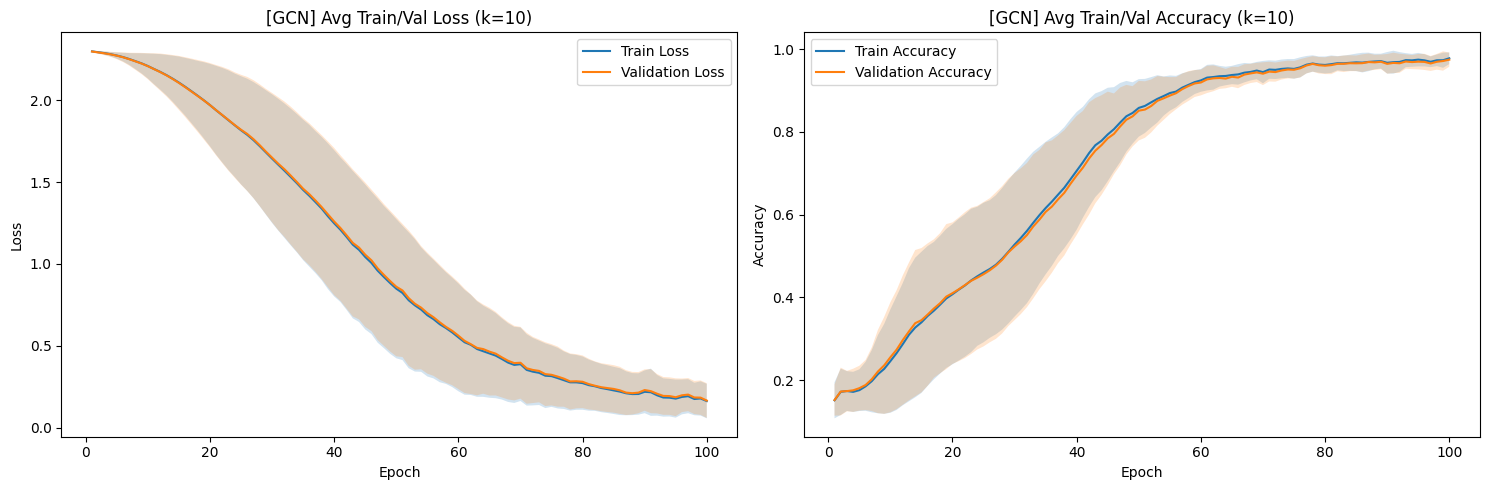

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_10_GAT
Using existing processed data for k_10_GAT
Starting k-fold cross-validation for GAT...

--- Fold 1/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2623, Train Acc: 0.1719, Val Loss: 2.2646, Val Acc: 0.1604
Epoch 020, Train Loss: 2.1652, Train Acc: 0.1924, Val Loss: 2.1691, Val Acc: 0.1878
Epoch 030, Train Loss: 2.0234, Train Acc: 0.1436, Val Loss: 2.0270, Val Acc: 0.1455
Epoch 040, Train Loss: 1.7921, Train Acc: 0.1747, Val Loss: 1.7978, Val Acc: 0.1754
Epoch 050, Train Loss: 1.3676, Train Acc: 0.4568, Val Loss: 1.3802, Val Acc: 0.4677
Epoch 060, Train Loss: 0.8177, Train Acc: 0.8494, Val Loss: 0.8297, Val Acc: 0.8396
Epoch 070, Train Loss: 0.4140, Train Acc: 0.9610, Val Loss: 0.4377, Val Acc: 0.9478
Epoch 080, Train Loss: 0.2450, Train Acc: 0.9830, Val Loss: 0.2600, Val Acc: 0.9789
Epoch 090, Train Loss: 0.1316, Train Acc: 0.9955, Val Loss: 0.1510, Val Acc: 0.9925


[I 2025-01-26 16:45:04,478] Trial 0 finished with value: 0.11409248411655426 and parameters: {'hidden_channels': 35, 'dropout': 0.3951948783147338, 'lr': 0.0003071338246162234}. Best is trial 0 with value: 0.11409248411655426.


Epoch 100, Train Loss: 0.1071, Train Acc: 0.9918, Val Loss: 0.1141, Val Acc: 0.9876


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.5138, Train Acc: 0.6071, Val Loss: 1.5214, Val Acc: 0.6182
Epoch 020, Train Loss: 0.8407, Train Acc: 0.7723, Val Loss: 0.8490, Val Acc: 0.7649
Epoch 030, Train Loss: 0.5062, Train Acc: 0.8571, Val Loss: 0.5196, Val Acc: 0.8545
Epoch 040, Train Loss: 0.2438, Train Acc: 0.9561, Val Loss: 0.2621, Val Acc: 0.9590
Epoch 050, Train Loss: 0.1045, Train Acc: 0.9737, Val Loss: 0.1187, Val Acc: 0.9714
Epoch 060, Train Loss: 0.0815, Train Acc: 0.9921, Val Loss: 0.0991, Val Acc: 0.9925
Epoch 070, Train Loss: 0.0542, Train Acc: 0.9886, Val Loss: 0.0592, Val Acc: 0.9876
Epoch 080, Train Loss: 0.0500, Train Acc: 0.9949, Val Loss: 0.0649, Val Acc: 0.9950
Epoch 090, Train Loss: 0.0308, Train Acc: 0.9970, Val Loss: 0.0344, Val Acc: 0.9950


[I 2025-01-26 16:45:08,162] Trial 1 finished with value: 0.046621743589639664 and parameters: {'hidden_channels': 38, 'dropout': 0.2593596438356992, 'lr': 0.006307806836121585}. Best is trial 1 with value: 0.046621743589639664.


Epoch 100, Train Loss: 0.0569, Train Acc: 0.9941, Val Loss: 0.0466, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0097, Train Acc: 0.1686, Val Loss: 2.0112, Val Acc: 0.1667
Epoch 020, Train Loss: 1.5940, Train Acc: 0.3391, Val Loss: 1.5966, Val Acc: 0.3458
Epoch 030, Train Loss: 1.0149, Train Acc: 0.7177, Val Loss: 0.9931, Val Acc: 0.7164
Epoch 040, Train Loss: 0.4812, Train Acc: 0.8763, Val Loss: 0.5006, Val Acc: 0.8706
Epoch 050, Train Loss: 0.2087, Train Acc: 0.9771, Val Loss: 0.2244, Val Acc: 0.9664
Epoch 060, Train Loss: 0.1419, Train Acc: 0.9709, Val Loss: 0.1647, Val Acc: 0.9677
Epoch 070, Train Loss: 0.1401, Train Acc: 0.9630, Val Loss: 0.1587, Val Acc: 0.9652
Epoch 080, Train Loss: 0.0446, Train Acc: 0.9974, Val Loss: 0.0553, Val Acc: 0.9950
Epoch 090, Train Loss: 0.0796, Train Acc: 0.9854, Val Loss: 0.1030, Val Acc: 0.9826


[I 2025-01-26 16:45:12,895] Trial 2 finished with value: 0.044761091470718384 and parameters: {'hidden_channels': 50, 'dropout': 0.38517677256973637, 'lr': 0.002545524358214129}. Best is trial 2 with value: 0.044761091470718384.


Epoch 100, Train Loss: 0.0410, Train Acc: 0.9942, Val Loss: 0.0448, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.5946, Train Acc: 0.6584, Val Loss: 1.5954, Val Acc: 0.6443
Epoch 020, Train Loss: 0.9328, Train Acc: 0.7412, Val Loss: 0.9199, Val Acc: 0.7512
Epoch 030, Train Loss: 0.5425, Train Acc: 0.8597, Val Loss: 0.5387, Val Acc: 0.8657
Epoch 040, Train Loss: 0.2226, Train Acc: 0.9466, Val Loss: 0.2405, Val Acc: 0.9453
Epoch 050, Train Loss: 0.1804, Train Acc: 0.9580, Val Loss: 0.2185, Val Acc: 0.9453
Epoch 060, Train Loss: 0.1348, Train Acc: 0.9784, Val Loss: 0.1203, Val Acc: 0.9751
Epoch 070, Train Loss: 0.1142, Train Acc: 0.9701, Val Loss: 0.1281, Val Acc: 0.9664


[I 2025-01-26 16:45:14,848] Trial 3 finished with value: 0.1254488229751587 and parameters: {'hidden_channels': 19, 'dropout': 0.33832685924687067, 'lr': 0.007285182981670093}. Best is trial 2 with value: 0.044761091470718384.


Epoch 080, Train Loss: 0.1436, Train Acc: 0.9712, Val Loss: 0.1904, Val Acc: 0.9565
Early stopping at epoch 89


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2485, Train Acc: 0.1022, Val Loss: 2.2472, Val Acc: 0.1032
Epoch 020, Train Loss: 2.2139, Train Acc: 0.1017, Val Loss: 2.2111, Val Acc: 0.1032
Epoch 030, Train Loss: 2.1393, Train Acc: 0.1056, Val Loss: 2.1412, Val Acc: 0.1095
Epoch 040, Train Loss: 1.8341, Train Acc: 0.1450, Val Loss: 1.8361, Val Acc: 0.1455
Epoch 050, Train Loss: 1.1488, Train Acc: 0.4609, Val Loss: 1.1597, Val Acc: 0.4627
Epoch 060, Train Loss: 0.5092, Train Acc: 0.8597, Val Loss: 0.5171, Val Acc: 0.8632
Epoch 070, Train Loss: 0.1983, Train Acc: 0.9838, Val Loss: 0.2120, Val Acc: 0.9776
Epoch 080, Train Loss: 0.1073, Train Acc: 0.9888, Val Loss: 0.1232, Val Acc: 0.9876
Epoch 090, Train Loss: 0.0835, Train Acc: 0.9899, Val Loss: 0.0914, Val Acc: 0.9888


[I 2025-01-26 16:45:18,380] Trial 4 finished with value: 0.06130395829677582 and parameters: {'hidden_channels': 36, 'dropout': 0.33234000714285516, 'lr': 0.0006593806713551513}. Best is trial 2 with value: 0.044761091470718384.


Epoch 100, Train Loss: 0.0568, Train Acc: 0.9938, Val Loss: 0.0613, Val Acc: 0.9938
  Fold 1 - Optuna Best Trial Val Loss: 0.0448
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 50, 'dropout': 0.38517677256973637, 'lr': 0.002545524358214129}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0211, Train Acc: 0.1765, Val Loss: 2.0294, Val Acc: 0.1729
Epoch 020, Train Loss: 1.9454, Train Acc: 0.1543, Val Loss: 1.9601, Val Acc: 0.1642
Epoch 030, Train Loss: 1.4903, Train Acc: 0.2518, Val Loss: 1.4984, Val Acc: 0.2488
Epoch 040, Train Loss: 0.7181, Train Acc: 0.6972, Val Loss: 0.7270, Val Acc: 0.7027
Epoch 050, Train Loss: 0.2261, Train Acc: 0.9667, Val Loss: 0.2441, Val Acc: 0.9590
Epoch 060, Train Loss: 0.1973, Train Acc: 0.9602, Val Loss: 0.2168, Val Acc: 0.9552
Epoch 070, Train Loss: 0.0851, Train Acc: 0.9872, Val Loss: 0.1020, Val Acc: 0.9851
Epoch 080, Train Loss: 0.1112, Train Acc: 0.9798, Val Loss: 0.1148, Val Acc: 0.9751
Epoch 090, Train Loss: 0.0596, Train Acc: 0.9941, Val Loss: 0.0587, Val Acc: 0.9938


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0314, Train Acc: 0.9986, Val Loss: 0.0410, Val Acc: 0.9975
  Fold 1 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Fold 2/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2901, Train Acc: 0.1345, Val Loss: 2.2868, Val Acc: 0.1306
Epoch 020, Train Loss: 2.2406, Train Acc: 0.2145, Val Loss: 2.2353, Val Acc: 0.2177
Epoch 030, Train Loss: 2.1321, Train Acc: 0.3567, Val Loss: 2.1222, Val Acc: 0.3595
Epoch 040, Train Loss: 1.9405, Train Acc: 0.5614, Val Loss: 1.9299, Val Acc: 0.5572
Epoch 050, Train Loss: 1.6173, Train Acc: 0.7603, Val Loss: 1.6064, Val Acc: 0.7687
Epoch 060, Train Loss: 1.1919, Train Acc: 0.8781, Val Loss: 1.1753, Val Acc: 0.8806
Epoch 070, Train Loss: 0.7885, Train Acc: 0.9244, Val Loss: 0.7809, Val Acc: 0.9291
Epoch 080, Train Loss: 0.5172, Train Acc: 0.9390, Val Loss: 0.5113, Val Acc: 0.9415
Epoch 090, Train Loss: 0.3555, Train Acc: 0.9546, Val Loss: 0.3629, Val Acc: 0.9478


[I 2025-01-26 16:45:25,963] Trial 0 finished with value: 0.2834859788417816 and parameters: {'hidden_channels': 26, 'dropout': 0.3327879107140633, 'lr': 0.00015622828149021944}. Best is trial 0 with value: 0.2834859788417816.


Epoch 100, Train Loss: 0.2791, Train Acc: 0.9681, Val Loss: 0.2835, Val Acc: 0.9677


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.3863, Train Acc: 0.6318, Val Loss: 1.4073, Val Acc: 0.6356
Epoch 020, Train Loss: 0.6835, Train Acc: 0.8099, Val Loss: 0.6998, Val Acc: 0.8147
Epoch 030, Train Loss: 0.4334, Train Acc: 0.8849, Val Loss: 0.4505, Val Acc: 0.8657
Epoch 040, Train Loss: 0.2819, Train Acc: 0.9118, Val Loss: 0.3514, Val Acc: 0.8818
Epoch 050, Train Loss: 0.3014, Train Acc: 0.9344, Val Loss: 0.3650, Val Acc: 0.9104
Epoch 060, Train Loss: 0.1621, Train Acc: 0.9736, Val Loss: 0.1660, Val Acc: 0.9689
Epoch 070, Train Loss: 0.1499, Train Acc: 0.9519, Val Loss: 0.1530, Val Acc: 0.9614
Epoch 080, Train Loss: 0.1059, Train Acc: 0.9751, Val Loss: 0.1185, Val Acc: 0.9701
Epoch 090, Train Loss: 0.1244, Train Acc: 0.9806, Val Loss: 0.1277, Val Acc: 0.9739


[I 2025-01-26 16:45:28,693] Trial 1 finished with value: 0.1087048202753067 and parameters: {'hidden_channels': 26, 'dropout': 0.45256704040555557, 'lr': 0.00995686841362075}. Best is trial 1 with value: 0.1087048202753067.


Epoch 100, Train Loss: 0.0724, Train Acc: 0.9841, Val Loss: 0.1087, Val Acc: 0.9751


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3318, Train Acc: 0.0991, Val Loss: 2.3261, Val Acc: 0.1007


[I 2025-01-26 16:45:29,575] Trial 2 finished with value: 2.305737018585205 and parameters: {'hidden_channels': 43, 'dropout': 0.3212329630482432, 'lr': 0.00017626592323189392}. Best is trial 1 with value: 0.1087048202753067.


Epoch 020, Train Loss: 2.3194, Train Acc: 0.1882, Val Loss: 2.3120, Val Acc: 0.1903
Early stopping at epoch 21


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2948, Train Acc: 0.1153, Val Loss: 2.2957, Val Acc: 0.1132
Epoch 020, Train Loss: 2.2481, Train Acc: 0.2237, Val Loss: 2.2507, Val Acc: 0.2351
Epoch 030, Train Loss: 2.1504, Train Acc: 0.3868, Val Loss: 2.1530, Val Acc: 0.3893
Epoch 040, Train Loss: 1.9719, Train Acc: 0.5990, Val Loss: 1.9769, Val Acc: 0.6020
Epoch 050, Train Loss: 1.6727, Train Acc: 0.7925, Val Loss: 1.6800, Val Acc: 0.7848
Epoch 060, Train Loss: 1.2641, Train Acc: 0.8403, Val Loss: 1.2795, Val Acc: 0.8147
Epoch 070, Train Loss: 0.8843, Train Acc: 0.8907, Val Loss: 0.9114, Val Acc: 0.8831
Epoch 080, Train Loss: 0.6113, Train Acc: 0.9297, Val Loss: 0.6146, Val Acc: 0.9378
Epoch 090, Train Loss: 0.4605, Train Acc: 0.9418, Val Loss: 0.4839, Val Acc: 0.9502


[I 2025-01-26 16:45:31,695] Trial 3 finished with value: 0.39211204648017883 and parameters: {'hidden_channels': 18, 'dropout': 0.490001962566256, 'lr': 0.0002284562997042097}. Best is trial 1 with value: 0.1087048202753067.


Epoch 100, Train Loss: 0.3667, Train Acc: 0.9552, Val Loss: 0.3921, Val Acc: 0.9614


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2774, Train Acc: 0.1719, Val Loss: 2.2734, Val Acc: 0.1704
Epoch 020, Train Loss: 2.2196, Train Acc: 0.2332, Val Loss: 2.2119, Val Acc: 0.2289
Epoch 030, Train Loss: 2.0892, Train Acc: 0.3050, Val Loss: 2.0752, Val Acc: 0.3022
Epoch 040, Train Loss: 1.8617, Train Acc: 0.4164, Val Loss: 1.8450, Val Acc: 0.4080
Epoch 050, Train Loss: 1.4228, Train Acc: 0.6874, Val Loss: 1.4097, Val Acc: 0.7052
Epoch 060, Train Loss: 0.8795, Train Acc: 0.9146, Val Loss: 0.8745, Val Acc: 0.8955
Epoch 070, Train Loss: 0.4387, Train Acc: 0.9647, Val Loss: 0.4502, Val Acc: 0.9602
Epoch 080, Train Loss: 0.2277, Train Acc: 0.9829, Val Loss: 0.2377, Val Acc: 0.9801
Epoch 090, Train Loss: 0.1590, Train Acc: 0.9896, Val Loss: 0.1586, Val Acc: 0.9876


[I 2025-01-26 16:45:35,449] Trial 4 finished with value: 0.13344796001911163 and parameters: {'hidden_channels': 38, 'dropout': 0.33617460049605224, 'lr': 0.00024471699659502105}. Best is trial 1 with value: 0.1087048202753067.


Epoch 100, Train Loss: 0.1098, Train Acc: 0.9916, Val Loss: 0.1334, Val Acc: 0.9851
  Fold 2 - Optuna Best Trial Val Loss: 0.1087
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 26, 'dropout': 0.45256704040555557, 'lr': 0.00995686841362075}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.3737, Train Acc: 0.6665, Val Loss: 1.3810, Val Acc: 0.6716
Epoch 020, Train Loss: 0.7896, Train Acc: 0.8185, Val Loss: 0.7846, Val Acc: 0.8172
Epoch 030, Train Loss: 0.3354, Train Acc: 0.9151, Val Loss: 0.3450, Val Acc: 0.9080
Epoch 040, Train Loss: 0.2203, Train Acc: 0.9320, Val Loss: 0.2315, Val Acc: 0.9316
Epoch 050, Train Loss: 0.1080, Train Acc: 0.9852, Val Loss: 0.1122, Val Acc: 0.9838
Epoch 060, Train Loss: 0.2951, Train Acc: 0.9555, Val Loss: 0.2884, Val Acc: 0.9453


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Early stopping at epoch 70
  Fold 2 Test Metrics:
  Accuracy: 0.9353
  Precision: 0.9533
  Recall: 0.9353
  F1: 0.9384

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9388, Train Acc: 0.1809, Val Loss: 1.9399, Val Acc: 0.1803
Epoch 020, Train Loss: 1.6081, Train Acc: 0.2203, Val Loss: 1.6214, Val Acc: 0.2102
Epoch 030, Train Loss: 1.1073, Train Acc: 0.4923, Val Loss: 1.1125, Val Acc: 0.4789
Epoch 040, Train Loss: 0.4542, Train Acc: 0.8903, Val Loss: 0.4511, Val Acc: 0.8781
Epoch 050, Train Loss: 0.1851, Train Acc: 0.9673, Val Loss: 0.1971, Val Acc: 0.9515
Epoch 060, Train Loss: 0.1431, Train Acc: 0.9652, Val Loss: 0.1316, Val Acc: 0.9677
Epoch 070, Train Loss: 0.1353, Train Acc: 0.9762, Val Loss: 0.1403, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0583, Train Acc: 0.9914, Val Loss: 0.0639, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0538, Train Acc: 0.9907, Val Loss: 0.0446, Val Acc: 0.9900


[I 2025-01-26 16:45:41,822] Trial 0 finished with value: 0.02277020737528801 and parameters: {'hidden_channels': 46, 'dropout': 0.35283483044415626, 'lr': 0.002847392255622749}. Best is trial 0 with value: 0.02277020737528801.


Epoch 100, Train Loss: 0.0366, Train Acc: 0.9983, Val Loss: 0.0228, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2618, Train Acc: 0.1167, Val Loss: 2.2651, Val Acc: 0.1132
Epoch 020, Train Loss: 2.1827, Train Acc: 0.1820, Val Loss: 2.1854, Val Acc: 0.1766
Epoch 030, Train Loss: 2.0626, Train Acc: 0.1803, Val Loss: 2.0637, Val Acc: 0.1654
Epoch 040, Train Loss: 1.8224, Train Acc: 0.2495, Val Loss: 1.8236, Val Acc: 0.2326
Epoch 050, Train Loss: 1.3948, Train Acc: 0.5074, Val Loss: 1.3885, Val Acc: 0.4975
Epoch 060, Train Loss: 0.8237, Train Acc: 0.8362, Val Loss: 0.8135, Val Acc: 0.8458
Epoch 070, Train Loss: 0.3773, Train Acc: 0.9728, Val Loss: 0.3709, Val Acc: 0.9739
Epoch 080, Train Loss: 0.1761, Train Acc: 0.9874, Val Loss: 0.1787, Val Acc: 0.9900
Epoch 090, Train Loss: 0.1042, Train Acc: 0.9950, Val Loss: 0.0967, Val Acc: 0.9975


[I 2025-01-26 16:45:46,968] Trial 1 finished with value: 0.07476522773504257 and parameters: {'hidden_channels': 53, 'dropout': 0.4479282890291501, 'lr': 0.00024118054767220893}. Best is trial 0 with value: 0.02277020737528801.


Epoch 100, Train Loss: 0.0762, Train Acc: 0.9969, Val Loss: 0.0748, Val Acc: 0.9975


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0853, Train Acc: 0.1593, Val Loss: 2.0852, Val Acc: 0.1667
Epoch 020, Train Loss: 1.9117, Train Acc: 0.2002, Val Loss: 1.9030, Val Acc: 0.2102
Epoch 030, Train Loss: 1.4318, Train Acc: 0.3595, Val Loss: 1.4268, Val Acc: 0.3744
Epoch 040, Train Loss: 0.7522, Train Acc: 0.7446, Val Loss: 0.7538, Val Acc: 0.7512
Epoch 050, Train Loss: 0.2714, Train Acc: 0.9510, Val Loss: 0.2651, Val Acc: 0.9552
Epoch 060, Train Loss: 0.1417, Train Acc: 0.9782, Val Loss: 0.1235, Val Acc: 0.9776
Epoch 070, Train Loss: 0.1496, Train Acc: 0.9715, Val Loss: 0.1299, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0817, Train Acc: 0.9871, Val Loss: 0.0607, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0465, Train Acc: 0.9908, Val Loss: 0.0428, Val Acc: 0.9925


[I 2025-01-26 16:45:50,784] Trial 2 finished with value: 0.02089417725801468 and parameters: {'hidden_channels': 40, 'dropout': 0.33151544168862923, 'lr': 0.0021087536966580634}. Best is trial 2 with value: 0.02089417725801468.


Epoch 100, Train Loss: 0.0341, Train Acc: 0.9972, Val Loss: 0.0209, Val Acc: 1.0000
Epoch 010, Train Loss: 2.3099, Train Acc: 0.0919, Val Loss: 2.3130, Val Acc: 0.0920


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:45:51,208] Trial 3 finished with value: 2.306490659713745 and parameters: {'hidden_channels': 16, 'dropout': 0.493903547961451, 'lr': 0.0001383316594614096}. Best is trial 2 with value: 0.02089417725801468.


Epoch 020, Train Loss: 2.3054, Train Acc: 0.1867, Val Loss: 2.3126, Val Acc: 0.1779
Early stopping at epoch 22


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2881, Train Acc: 0.1280, Val Loss: 2.2914, Val Acc: 0.1281
Epoch 020, Train Loss: 2.2462, Train Acc: 0.1226, Val Loss: 2.2516, Val Acc: 0.1219
Epoch 030, Train Loss: 2.1389, Train Acc: 0.1940, Val Loss: 2.1468, Val Acc: 0.1990
Epoch 040, Train Loss: 1.9410, Train Acc: 0.4030, Val Loss: 1.9511, Val Acc: 0.3794
Epoch 050, Train Loss: 1.6191, Train Acc: 0.5912, Val Loss: 1.6328, Val Acc: 0.5759
Epoch 060, Train Loss: 1.1807, Train Acc: 0.7805, Val Loss: 1.1937, Val Acc: 0.7587
Epoch 070, Train Loss: 0.7501, Train Acc: 0.8877, Val Loss: 0.7620, Val Acc: 0.8893
Epoch 080, Train Loss: 0.4874, Train Acc: 0.9373, Val Loss: 0.5021, Val Acc: 0.9378
Epoch 090, Train Loss: 0.3549, Train Acc: 0.9508, Val Loss: 0.3644, Val Acc: 0.9490


[I 2025-01-26 16:45:53,386] Trial 4 finished with value: 0.2915119528770447 and parameters: {'hidden_channels': 19, 'dropout': 0.3703512931476717, 'lr': 0.0002243294042483123}. Best is trial 2 with value: 0.02089417725801468.


Epoch 100, Train Loss: 0.2774, Train Acc: 0.9670, Val Loss: 0.2915, Val Acc: 0.9602
  Fold 3 - Optuna Best Trial Val Loss: 0.0209
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 40, 'dropout': 0.33151544168862923, 'lr': 0.0021087536966580634}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1141, Train Acc: 0.1569, Val Loss: 2.1157, Val Acc: 0.1629
Epoch 020, Train Loss: 1.9681, Train Acc: 0.1185, Val Loss: 1.9638, Val Acc: 0.1244
Epoch 030, Train Loss: 1.6436, Train Acc: 0.1776, Val Loss: 1.6455, Val Acc: 0.1754
Epoch 040, Train Loss: 0.9533, Train Acc: 0.5225, Val Loss: 0.9503, Val Acc: 0.5187
Epoch 050, Train Loss: 0.3131, Train Acc: 0.9269, Val Loss: 0.3164, Val Acc: 0.9316
Epoch 060, Train Loss: 0.1656, Train Acc: 0.9708, Val Loss: 0.1642, Val Acc: 0.9689
Epoch 070, Train Loss: 0.1011, Train Acc: 0.9857, Val Loss: 0.0784, Val Acc: 0.9863
Epoch 080, Train Loss: 0.0696, Train Acc: 0.9905, Val Loss: 0.0786, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0361, Train Acc: 0.9974, Val Loss: 0.0378, Val Acc: 0.9975


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0530, Train Acc: 0.9928, Val Loss: 0.0645, Val Acc: 0.9925
  Fold 3 Test Metrics:
  Accuracy: 0.9950
  Precision: 0.9951
  Recall: 0.9950
  F1: 0.9950

--- Fold 4/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2711, Train Acc: 0.1401, Val Loss: 2.2712, Val Acc: 0.1455
Epoch 020, Train Loss: 2.1998, Train Acc: 0.1804, Val Loss: 2.2047, Val Acc: 0.1803
Epoch 030, Train Loss: 2.0602, Train Acc: 0.1963, Val Loss: 2.0717, Val Acc: 0.1853
Epoch 040, Train Loss: 1.8260, Train Acc: 0.2423, Val Loss: 1.8473, Val Acc: 0.2463
Epoch 050, Train Loss: 1.4186, Train Acc: 0.4155, Val Loss: 1.4472, Val Acc: 0.4104
Epoch 060, Train Loss: 0.8568, Train Acc: 0.8143, Val Loss: 0.8965, Val Acc: 0.7910
Epoch 070, Train Loss: 0.3789, Train Acc: 0.9557, Val Loss: 0.4029, Val Acc: 0.9465
Epoch 080, Train Loss: 0.1909, Train Acc: 0.9826, Val Loss: 0.2179, Val Acc: 0.9789
Epoch 090, Train Loss: 0.1116, Train Acc: 0.9958, Val Loss: 0.1342, Val Acc: 0.9950


[I 2025-01-26 16:46:01,466] Trial 0 finished with value: 0.08003665506839752 and parameters: {'hidden_channels': 46, 'dropout': 0.3655953905734919, 'lr': 0.0002593807529204806}. Best is trial 0 with value: 0.08003665506839752.


Epoch 100, Train Loss: 0.0728, Train Acc: 0.9961, Val Loss: 0.0800, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9605, Train Acc: 0.5547, Val Loss: 1.9770, Val Acc: 0.5249
Epoch 020, Train Loss: 1.4815, Train Acc: 0.4295, Val Loss: 1.5041, Val Acc: 0.4204
Epoch 030, Train Loss: 0.9720, Train Acc: 0.6867, Val Loss: 1.0040, Val Acc: 0.6629
Epoch 040, Train Loss: 0.4867, Train Acc: 0.9305, Val Loss: 0.5042, Val Acc: 0.9341
Epoch 050, Train Loss: 0.2688, Train Acc: 0.9667, Val Loss: 0.3081, Val Acc: 0.9515
Epoch 060, Train Loss: 0.1903, Train Acc: 0.9636, Val Loss: 0.2209, Val Acc: 0.9590
Epoch 070, Train Loss: 0.1580, Train Acc: 0.9673, Val Loss: 0.1736, Val Acc: 0.9639
Epoch 080, Train Loss: 0.0777, Train Acc: 0.9935, Val Loss: 0.0906, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0646, Train Acc: 0.9899, Val Loss: 0.0738, Val Acc: 0.9863


[I 2025-01-26 16:46:04,809] Trial 1 finished with value: 0.15906594693660736 and parameters: {'hidden_channels': 33, 'dropout': 0.49508647184243276, 'lr': 0.002789077091357178}. Best is trial 0 with value: 0.08003665506839752.


Epoch 100, Train Loss: 0.1280, Train Acc: 0.9718, Val Loss: 0.1591, Val Acc: 0.9701


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1594, Train Acc: 0.1086, Val Loss: 2.1626, Val Acc: 0.1070
Epoch 020, Train Loss: 2.2453, Train Acc: 0.1016, Val Loss: 2.2456, Val Acc: 0.1020
Epoch 030, Train Loss: 2.0022, Train Acc: 0.1118, Val Loss: 2.0219, Val Acc: 0.1119
Epoch 040, Train Loss: 1.2315, Train Acc: 0.3915, Val Loss: 1.2734, Val Acc: 0.3532
Epoch 050, Train Loss: 0.5501, Train Acc: 0.8333, Val Loss: 0.5968, Val Acc: 0.8097
Epoch 060, Train Loss: 0.1543, Train Acc: 0.9840, Val Loss: 0.1739, Val Acc: 0.9826
Epoch 070, Train Loss: 0.1099, Train Acc: 0.9930, Val Loss: 0.1578, Val Acc: 0.9913
Epoch 080, Train Loss: 0.0798, Train Acc: 0.9890, Val Loss: 0.1095, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0390, Train Acc: 0.9963, Val Loss: 0.0540, Val Acc: 0.9938


[I 2025-01-26 16:46:10,349] Trial 2 finished with value: 0.08478076756000519 and parameters: {'hidden_channels': 60, 'dropout': 0.21213487547169171, 'lr': 0.0013484034834869898}. Best is trial 0 with value: 0.08003665506839752.


Epoch 100, Train Loss: 0.0447, Train Acc: 0.9914, Val Loss: 0.0848, Val Acc: 0.9801


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2792, Train Acc: 0.0997, Val Loss: 2.2803, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2452, Train Acc: 0.1014, Val Loss: 2.2458, Val Acc: 0.0958
Epoch 030, Train Loss: 2.1431, Train Acc: 0.1045, Val Loss: 2.1427, Val Acc: 0.1057
Epoch 040, Train Loss: 1.9046, Train Acc: 0.1442, Val Loss: 1.9054, Val Acc: 0.1468
Epoch 050, Train Loss: 1.5060, Train Acc: 0.4957, Val Loss: 1.5123, Val Acc: 0.4900
Epoch 060, Train Loss: 0.9713, Train Acc: 0.8494, Val Loss: 0.9847, Val Acc: 0.8234
Epoch 070, Train Loss: 0.5112, Train Acc: 0.9650, Val Loss: 0.5249, Val Acc: 0.9577
Epoch 080, Train Loss: 0.2623, Train Acc: 0.9840, Val Loss: 0.2737, Val Acc: 0.9813
Epoch 090, Train Loss: 0.1575, Train Acc: 0.9922, Val Loss: 0.1715, Val Acc: 0.9876


[I 2025-01-26 16:46:14,162] Trial 3 finished with value: 0.12604492902755737 and parameters: {'hidden_channels': 39, 'dropout': 0.20591505914851807, 'lr': 0.0001498704386985802}. Best is trial 0 with value: 0.08003665506839752.


Epoch 100, Train Loss: 0.1142, Train Acc: 0.9950, Val Loss: 0.1260, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1734, Train Acc: 0.1069, Val Loss: 2.1749, Val Acc: 0.1045
Epoch 020, Train Loss: 2.3038, Train Acc: 0.1162, Val Loss: 2.3156, Val Acc: 0.1157
Epoch 030, Train Loss: 2.1177, Train Acc: 0.1398, Val Loss: 2.1369, Val Acc: 0.1480
Epoch 040, Train Loss: 1.4291, Train Acc: 0.3074, Val Loss: 1.4621, Val Acc: 0.3072
Epoch 050, Train Loss: 0.5536, Train Acc: 0.8468, Val Loss: 0.5843, Val Acc: 0.8085
Epoch 060, Train Loss: 0.2016, Train Acc: 0.9770, Val Loss: 0.2158, Val Acc: 0.9776
Epoch 070, Train Loss: 0.1440, Train Acc: 0.9736, Val Loss: 0.1759, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0865, Train Acc: 0.9863, Val Loss: 0.1245, Val Acc: 0.9764
Epoch 090, Train Loss: 0.0621, Train Acc: 0.9904, Val Loss: 0.0825, Val Acc: 0.9826


[I 2025-01-26 16:46:19,566] Trial 4 finished with value: 0.06544618308544159 and parameters: {'hidden_channels': 59, 'dropout': 0.43163918104950627, 'lr': 0.0012329138825986448}. Best is trial 4 with value: 0.06544618308544159.


Epoch 100, Train Loss: 0.0433, Train Acc: 0.9974, Val Loss: 0.0654, Val Acc: 0.9950
  Fold 4 - Optuna Best Trial Val Loss: 0.0654
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 59, 'dropout': 0.43163918104950627, 'lr': 0.0012329138825986448}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1236, Train Acc: 0.2212, Val Loss: 2.1259, Val Acc: 0.2214
Epoch 020, Train Loss: 2.0817, Train Acc: 0.1171, Val Loss: 2.0919, Val Acc: 0.1157
Epoch 030, Train Loss: 1.8676, Train Acc: 0.1541, Val Loss: 1.9022, Val Acc: 0.1493
Epoch 040, Train Loss: 1.1592, Train Acc: 0.4749, Val Loss: 1.2089, Val Acc: 0.4590
Epoch 050, Train Loss: 0.4475, Train Acc: 0.9101, Val Loss: 0.4825, Val Acc: 0.8881
Epoch 060, Train Loss: 0.1746, Train Acc: 0.9844, Val Loss: 0.1919, Val Acc: 0.9826
Epoch 070, Train Loss: 0.1091, Train Acc: 0.9824, Val Loss: 0.1305, Val Acc: 0.9751
Epoch 080, Train Loss: 0.1338, Train Acc: 0.9900, Val Loss: 0.1938, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0639, Train Acc: 0.9872, Val Loss: 0.0770, Val Acc: 0.9826


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0703, Train Acc: 0.9921, Val Loss: 0.1016, Val Acc: 0.9888
  Fold 4 Test Metrics:
  Accuracy: 0.9963
  Precision: 0.9964
  Recall: 0.9963
  F1: 0.9963

--- Fold 5/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2686, Train Acc: 0.2427, Val Loss: 2.2669, Val Acc: 0.2450
Epoch 020, Train Loss: 2.2071, Train Acc: 0.1014, Val Loss: 2.2057, Val Acc: 0.1045
Epoch 030, Train Loss: 2.1000, Train Acc: 0.1014, Val Loss: 2.1051, Val Acc: 0.1045
Epoch 040, Train Loss: 1.8816, Train Acc: 0.1555, Val Loss: 1.9006, Val Acc: 0.1604
Epoch 050, Train Loss: 1.4713, Train Acc: 0.3693, Val Loss: 1.5138, Val Acc: 0.3520
Epoch 060, Train Loss: 0.8572, Train Acc: 0.7573, Val Loss: 0.8999, Val Acc: 0.7313
Epoch 070, Train Loss: 0.3926, Train Acc: 0.9575, Val Loss: 0.4209, Val Acc: 0.9478
Epoch 080, Train Loss: 0.1762, Train Acc: 0.9919, Val Loss: 0.1815, Val Acc: 0.9950
Epoch 090, Train Loss: 0.0961, Train Acc: 0.9972, Val Loss: 0.1025, Val Acc: 0.9963


[I 2025-01-26 16:46:29,690] Trial 0 finished with value: 0.08137844502925873 and parameters: {'hidden_channels': 50, 'dropout': 0.41130214082033806, 'lr': 0.00025822591585789273}. Best is trial 0 with value: 0.08137844502925873.


Epoch 100, Train Loss: 0.0745, Train Acc: 0.9966, Val Loss: 0.0814, Val Acc: 0.9975


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2667, Train Acc: 0.2053, Val Loss: 2.2688, Val Acc: 0.2040
Epoch 020, Train Loss: 2.2030, Train Acc: 0.1022, Val Loss: 2.2043, Val Acc: 0.1045
Epoch 030, Train Loss: 2.1060, Train Acc: 0.1104, Val Loss: 2.1067, Val Acc: 0.1132
Epoch 040, Train Loss: 1.9446, Train Acc: 0.1331, Val Loss: 1.9541, Val Acc: 0.1368
Epoch 050, Train Loss: 1.5908, Train Acc: 0.2822, Val Loss: 1.6083, Val Acc: 0.2836
Epoch 060, Train Loss: 1.0184, Train Acc: 0.6824, Val Loss: 1.0476, Val Acc: 0.6381
Epoch 070, Train Loss: 0.4902, Train Acc: 0.9454, Val Loss: 0.5160, Val Acc: 0.9266
Epoch 080, Train Loss: 0.2398, Train Acc: 0.9862, Val Loss: 0.2550, Val Acc: 0.9888
Epoch 090, Train Loss: 0.1404, Train Acc: 0.9890, Val Loss: 0.1445, Val Acc: 0.9900


[I 2025-01-26 16:46:34,376] Trial 1 finished with value: 0.09490566700696945 and parameters: {'hidden_channels': 49, 'dropout': 0.45069724495926494, 'lr': 0.00022194052722275046}. Best is trial 0 with value: 0.08137844502925873.


Epoch 100, Train Loss: 0.0899, Train Acc: 0.9953, Val Loss: 0.0949, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3013, Train Acc: 0.0882, Val Loss: 2.3040, Val Acc: 0.0833
Epoch 020, Train Loss: 2.2931, Train Acc: 0.1034, Val Loss: 2.2959, Val Acc: 0.1007
Epoch 030, Train Loss: 2.2344, Train Acc: 0.1840, Val Loss: 2.2340, Val Acc: 0.1940
Epoch 040, Train Loss: 2.0844, Train Acc: 0.3192, Val Loss: 2.0901, Val Acc: 0.3134
Epoch 050, Train Loss: 1.8221, Train Acc: 0.5651, Val Loss: 1.8402, Val Acc: 0.5423
Epoch 060, Train Loss: 1.4255, Train Acc: 0.7709, Val Loss: 1.4608, Val Acc: 0.7413
Epoch 070, Train Loss: 1.0222, Train Acc: 0.8381, Val Loss: 1.0525, Val Acc: 0.8284
Epoch 080, Train Loss: 0.7298, Train Acc: 0.8787, Val Loss: 0.7593, Val Acc: 0.8769
Epoch 090, Train Loss: 0.5827, Train Acc: 0.9014, Val Loss: 0.5805, Val Acc: 0.9030


[I 2025-01-26 16:46:36,531] Trial 2 finished with value: 0.4834597408771515 and parameters: {'hidden_channels': 18, 'dropout': 0.489820814563394, 'lr': 0.0001928995442524696}. Best is trial 0 with value: 0.08137844502925873.


Epoch 100, Train Loss: 0.4833, Train Acc: 0.9213, Val Loss: 0.4835, Val Acc: 0.9254


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1617, Train Acc: 0.1014, Val Loss: 2.1655, Val Acc: 0.1045
Epoch 020, Train Loss: 2.0835, Train Acc: 0.1014, Val Loss: 2.0910, Val Acc: 0.1045
Epoch 030, Train Loss: 1.8722, Train Acc: 0.1106, Val Loss: 1.8982, Val Acc: 0.1070
Epoch 040, Train Loss: 1.3259, Train Acc: 0.3235, Val Loss: 1.3635, Val Acc: 0.3246
Epoch 050, Train Loss: 0.6466, Train Acc: 0.7415, Val Loss: 0.6826, Val Acc: 0.7251
Epoch 060, Train Loss: 0.2100, Train Acc: 0.9680, Val Loss: 0.1771, Val Acc: 0.9664
Epoch 070, Train Loss: 0.1485, Train Acc: 0.9799, Val Loss: 0.0797, Val Acc: 0.9876
Epoch 080, Train Loss: 0.1426, Train Acc: 0.9706, Val Loss: 0.1425, Val Acc: 0.9701
Epoch 090, Train Loss: 0.1001, Train Acc: 0.9759, Val Loss: 0.1120, Val Acc: 0.9789


[I 2025-01-26 16:46:41,269] Trial 3 finished with value: 0.05379277467727661 and parameters: {'hidden_channels': 50, 'dropout': 0.2824252577289392, 'lr': 0.0013335493906745746}. Best is trial 3 with value: 0.05379277467727661.


Epoch 100, Train Loss: 0.0528, Train Acc: 0.9908, Val Loss: 0.0538, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2281, Train Acc: 0.1107, Val Loss: 2.2318, Val Acc: 0.1007
Epoch 020, Train Loss: 2.1759, Train Acc: 0.1310, Val Loss: 2.1849, Val Acc: 0.1294
Epoch 030, Train Loss: 2.0791, Train Acc: 0.1114, Val Loss: 2.1035, Val Acc: 0.1107
Epoch 040, Train Loss: 1.6655, Train Acc: 0.2294, Val Loss: 1.7042, Val Acc: 0.2338
Epoch 050, Train Loss: 0.9778, Train Acc: 0.6245, Val Loss: 1.0110, Val Acc: 0.5983
Epoch 060, Train Loss: 0.4118, Train Acc: 0.9210, Val Loss: 0.4371, Val Acc: 0.9005
Epoch 070, Train Loss: 0.1343, Train Acc: 0.9955, Val Loss: 0.1424, Val Acc: 0.9938
Epoch 080, Train Loss: 0.0850, Train Acc: 0.9944, Val Loss: 0.0799, Val Acc: 0.9963
Epoch 090, Train Loss: 0.0539, Train Acc: 0.9967, Val Loss: 0.0544, Val Acc: 0.9963


[I 2025-01-26 16:46:45,404] Trial 4 finished with value: 0.03400908038020134 and parameters: {'hidden_channels': 42, 'dropout': 0.28641370941179545, 'lr': 0.0006647660618361958}. Best is trial 4 with value: 0.03400908038020134.


Epoch 100, Train Loss: 0.0493, Train Acc: 0.9938, Val Loss: 0.0340, Val Acc: 1.0000
  Fold 5 - Optuna Best Trial Val Loss: 0.0340
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 42, 'dropout': 0.28641370941179545, 'lr': 0.0006647660618361958}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2219, Train Acc: 0.1087, Val Loss: 2.2251, Val Acc: 0.0970
Epoch 020, Train Loss: 2.1344, Train Acc: 0.1625, Val Loss: 2.1403, Val Acc: 0.1580
Epoch 030, Train Loss: 2.0326, Train Acc: 0.1170, Val Loss: 2.0452, Val Acc: 0.1157
Epoch 040, Train Loss: 1.7895, Train Acc: 0.1479, Val Loss: 1.8242, Val Acc: 0.1430
Epoch 050, Train Loss: 1.1697, Train Acc: 0.3979, Val Loss: 1.2145, Val Acc: 0.4104
Epoch 060, Train Loss: 0.4588, Train Acc: 0.8725, Val Loss: 0.4855, Val Acc: 0.8495
Epoch 070, Train Loss: 0.1596, Train Acc: 0.9832, Val Loss: 0.1632, Val Acc: 0.9851
Epoch 080, Train Loss: 0.0830, Train Acc: 0.9921, Val Loss: 0.0674, Val Acc: 0.9925
Epoch 090, Train Loss: 0.1069, Train Acc: 0.9771, Val Loss: 0.0991, Val Acc: 0.9813


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0506, Train Acc: 0.9946, Val Loss: 0.0523, Val Acc: 0.9975
  Fold 5 Test Metrics:
  Accuracy: 0.9913
  Precision: 0.9920
  Recall: 0.9913
  F1: 0.9914

--- Fold 6/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2232, Train Acc: 0.2621, Val Loss: 2.2227, Val Acc: 0.2624
Epoch 020, Train Loss: 2.0989, Train Acc: 0.1083, Val Loss: 2.1036, Val Acc: 0.1119
Epoch 030, Train Loss: 1.9239, Train Acc: 0.2171, Val Loss: 1.9338, Val Acc: 0.2139
Epoch 040, Train Loss: 1.5260, Train Acc: 0.4239, Val Loss: 1.5143, Val Acc: 0.4254
Epoch 050, Train Loss: 0.9251, Train Acc: 0.7704, Val Loss: 0.9224, Val Acc: 0.7861
Epoch 060, Train Loss: 0.4060, Train Acc: 0.9420, Val Loss: 0.3940, Val Acc: 0.9478
Epoch 070, Train Loss: 0.1447, Train Acc: 0.9924, Val Loss: 0.1508, Val Acc: 0.9863
Epoch 080, Train Loss: 0.1101, Train Acc: 0.9837, Val Loss: 0.0858, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0722, Train Acc: 0.9941, Val Loss: 0.0493, Val Acc: 0.9963


[I 2025-01-26 16:46:53,624] Trial 0 finished with value: 0.08237383514642715 and parameters: {'hidden_channels': 41, 'dropout': 0.27480527868194987, 'lr': 0.0006219327892349749}. Best is trial 0 with value: 0.08237383514642715.


Epoch 100, Train Loss: 0.0568, Train Acc: 0.9913, Val Loss: 0.0824, Val Acc: 0.9851
Epoch 010, Train Loss: 2.1076, Train Acc: 0.4263, Val Loss: 2.1098, Val Acc: 0.4142


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7498, Train Acc: 0.4956, Val Loss: 1.7404, Val Acc: 0.4876
Epoch 030, Train Loss: 1.3319, Train Acc: 0.5704, Val Loss: 1.3305, Val Acc: 0.5622
Epoch 040, Train Loss: 0.8307, Train Acc: 0.7668, Val Loss: 0.8423, Val Acc: 0.7674
Epoch 050, Train Loss: 0.3465, Train Acc: 0.9359, Val Loss: 0.3551, Val Acc: 0.9241
Epoch 060, Train Loss: 0.1788, Train Acc: 0.9683, Val Loss: 0.1782, Val Acc: 0.9726
Epoch 070, Train Loss: 0.1351, Train Acc: 0.9708, Val Loss: 0.1167, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0984, Train Acc: 0.9848, Val Loss: 0.0787, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0898, Train Acc: 0.9860, Val Loss: 0.0686, Val Acc: 0.9938


[I 2025-01-26 16:46:55,544] Trial 1 finished with value: 0.11743618547916412 and parameters: {'hidden_channels': 16, 'dropout': 0.3463991636285968, 'lr': 0.0026616801174020595}. Best is trial 0 with value: 0.08237383514642715.


Epoch 100, Train Loss: 0.0964, Train Acc: 0.9799, Val Loss: 0.1174, Val Acc: 0.9789


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1397, Train Acc: 0.3808, Val Loss: 2.1373, Val Acc: 0.3706
Epoch 020, Train Loss: 1.7813, Train Acc: 0.5077, Val Loss: 1.7910, Val Acc: 0.5124
Epoch 030, Train Loss: 1.2539, Train Acc: 0.6995, Val Loss: 1.2480, Val Acc: 0.6903
Epoch 040, Train Loss: 0.7557, Train Acc: 0.8320, Val Loss: 0.7501, Val Acc: 0.8408
Epoch 050, Train Loss: 0.3750, Train Acc: 0.9370, Val Loss: 0.3673, Val Acc: 0.9378
Epoch 060, Train Loss: 0.2142, Train Acc: 0.9465, Val Loss: 0.2163, Val Acc: 0.9453
Epoch 070, Train Loss: 0.2184, Train Acc: 0.9558, Val Loss: 0.2410, Val Acc: 0.9515
Epoch 080, Train Loss: 0.1304, Train Acc: 0.9658, Val Loss: 0.1165, Val Acc: 0.9701
Epoch 090, Train Loss: 0.0861, Train Acc: 0.9939, Val Loss: 0.0767, Val Acc: 0.9950


[I 2025-01-26 16:46:57,656] Trial 2 finished with value: 0.09034115821123123 and parameters: {'hidden_channels': 18, 'dropout': 0.4936420728182826, 'lr': 0.002509381187296664}. Best is trial 0 with value: 0.08237383514642715.


Epoch 100, Train Loss: 0.0882, Train Acc: 0.9818, Val Loss: 0.0903, Val Acc: 0.9801


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.1250, Train Acc: 0.7210, Val Loss: 1.1047, Val Acc: 0.7239
Epoch 020, Train Loss: 0.5453, Train Acc: 0.8392, Val Loss: 0.5602, Val Acc: 0.8371
Epoch 030, Train Loss: 0.2959, Train Acc: 0.9068, Val Loss: 0.3073, Val Acc: 0.8993
Epoch 040, Train Loss: 0.1623, Train Acc: 0.9592, Val Loss: 0.1584, Val Acc: 0.9552
Epoch 050, Train Loss: 0.1409, Train Acc: 0.9569, Val Loss: 0.1558, Val Acc: 0.9527
Epoch 060, Train Loss: 0.1127, Train Acc: 0.9809, Val Loss: 0.1534, Val Acc: 0.9801
Epoch 070, Train Loss: 0.0762, Train Acc: 0.9939, Val Loss: 0.0675, Val Acc: 0.9925
Epoch 080, Train Loss: 0.0963, Train Acc: 0.9770, Val Loss: 0.0874, Val Acc: 0.9776
Epoch 090, Train Loss: 0.1349, Train Acc: 0.9739, Val Loss: 0.1957, Val Acc: 0.9639


[I 2025-01-26 16:47:01,187] Trial 3 finished with value: 0.18704354763031006 and parameters: {'hidden_channels': 36, 'dropout': 0.35528417422365133, 'lr': 0.009413580081948121}. Best is trial 0 with value: 0.08237383514642715.


Epoch 100, Train Loss: 0.1692, Train Acc: 0.9569, Val Loss: 0.1870, Val Acc: 0.9540


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0523, Train Acc: 0.2168, Val Loss: 2.0601, Val Acc: 0.1978
Epoch 020, Train Loss: 1.8526, Train Acc: 0.1607, Val Loss: 1.8636, Val Acc: 0.1567
Epoch 030, Train Loss: 1.5236, Train Acc: 0.2481, Val Loss: 1.5207, Val Acc: 0.2537
Epoch 040, Train Loss: 0.8237, Train Acc: 0.6690, Val Loss: 0.7840, Val Acc: 0.6940
Epoch 050, Train Loss: 0.2721, Train Acc: 0.9345, Val Loss: 0.2717, Val Acc: 0.9291
Epoch 060, Train Loss: 0.0894, Train Acc: 0.9961, Val Loss: 0.0999, Val Acc: 0.9925
Epoch 070, Train Loss: 0.0683, Train Acc: 0.9975, Val Loss: 0.0474, Val Acc: 1.0000
Epoch 080, Train Loss: 0.0477, Train Acc: 0.9975, Val Loss: 0.0298, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0624, Train Acc: 0.9863, Val Loss: 0.0556, Val Acc: 0.9851


[I 2025-01-26 16:47:04,185] Trial 4 finished with value: 0.021740399301052094 and parameters: {'hidden_channels': 30, 'dropout': 0.23629308438187882, 'lr': 0.002481265359529067}. Best is trial 4 with value: 0.021740399301052094.


Epoch 100, Train Loss: 0.0448, Train Acc: 0.9966, Val Loss: 0.0217, Val Acc: 1.0000
  Fold 6 - Optuna Best Trial Val Loss: 0.0217
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 30, 'dropout': 0.23629308438187882, 'lr': 0.002481265359529067}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0783, Train Acc: 0.2114, Val Loss: 2.0829, Val Acc: 0.2015
Epoch 020, Train Loss: 1.8708, Train Acc: 0.2151, Val Loss: 1.9103, Val Acc: 0.2027
Epoch 030, Train Loss: 1.3654, Train Acc: 0.4088, Val Loss: 1.3945, Val Acc: 0.4017
Epoch 040, Train Loss: 0.6277, Train Acc: 0.8410, Val Loss: 0.6346, Val Acc: 0.8246
Epoch 050, Train Loss: 0.2464, Train Acc: 0.9662, Val Loss: 0.2543, Val Acc: 0.9602
Epoch 060, Train Loss: 0.1365, Train Acc: 0.9869, Val Loss: 0.0976, Val Acc: 0.9913
Epoch 070, Train Loss: 0.1010, Train Acc: 0.9883, Val Loss: 0.1542, Val Acc: 0.9813
Epoch 080, Train Loss: 0.0810, Train Acc: 0.9768, Val Loss: 0.0831, Val Acc: 0.9801
Epoch 090, Train Loss: 0.0558, Train Acc: 0.9866, Val Loss: 0.0481, Val Acc: 0.9888


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0723, Train Acc: 0.9860, Val Loss: 0.0387, Val Acc: 0.9925
  Fold 6 Test Metrics:
  Accuracy: 0.9863
  Precision: 0.9880
  Recall: 0.9863
  F1: 0.9866

--- Fold 7/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2376, Train Acc: 0.1020, Val Loss: 2.2349, Val Acc: 0.0996
Epoch 020, Train Loss: 2.1788, Train Acc: 0.1526, Val Loss: 2.1771, Val Acc: 0.1569
Epoch 030, Train Loss: 2.0994, Train Acc: 0.1467, Val Loss: 2.1004, Val Acc: 0.1469
Epoch 040, Train Loss: 1.7763, Train Acc: 0.2044, Val Loss: 1.7733, Val Acc: 0.1968
Epoch 050, Train Loss: 1.0488, Train Acc: 0.6103, Val Loss: 1.0490, Val Acc: 0.6102
Epoch 060, Train Loss: 0.4196, Train Acc: 0.9319, Val Loss: 0.4222, Val Acc: 0.9290
Epoch 070, Train Loss: 0.1615, Train Acc: 0.9862, Val Loss: 0.1586, Val Acc: 0.9900
Epoch 080, Train Loss: 0.0823, Train Acc: 0.9922, Val Loss: 0.0916, Val Acc: 0.9875
Epoch 090, Train Loss: 0.0519, Train Acc: 0.9966, Val Loss: 0.0492, Val Acc: 0.9975


[I 2025-01-26 16:47:11,390] Trial 0 finished with value: 0.07858667522668839 and parameters: {'hidden_channels': 45, 'dropout': 0.35876383587990723, 'lr': 0.0005971023174551539}. Best is trial 0 with value: 0.07858667522668839.


Epoch 100, Train Loss: 0.0685, Train Acc: 0.9885, Val Loss: 0.0786, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.2479, Train Acc: 0.6868, Val Loss: 1.2286, Val Acc: 0.6762
Epoch 020, Train Loss: 0.6756, Train Acc: 0.8513, Val Loss: 0.6658, Val Acc: 0.8506
Epoch 030, Train Loss: 0.3424, Train Acc: 0.9294, Val Loss: 0.3310, Val Acc: 0.9240
Epoch 040, Train Loss: 0.1870, Train Acc: 0.9543, Val Loss: 0.1863, Val Acc: 0.9489
Epoch 050, Train Loss: 0.1328, Train Acc: 0.9767, Val Loss: 0.1239, Val Acc: 0.9763
Epoch 060, Train Loss: 0.2175, Train Acc: 0.9465, Val Loss: 0.2016, Val Acc: 0.9377
Epoch 070, Train Loss: 0.1176, Train Acc: 0.9753, Val Loss: 0.1074, Val Acc: 0.9813
Epoch 080, Train Loss: 0.1006, Train Acc: 0.9784, Val Loss: 0.0884, Val Acc: 0.9763
Epoch 090, Train Loss: 0.1053, Train Acc: 0.9804, Val Loss: 0.0854, Val Acc: 0.9801


[I 2025-01-26 16:47:15,118] Trial 1 finished with value: 0.06906634569168091 and parameters: {'hidden_channels': 39, 'dropout': 0.46709014176785657, 'lr': 0.008647127203543338}. Best is trial 1 with value: 0.06906634569168091.


Epoch 100, Train Loss: 0.0697, Train Acc: 0.9834, Val Loss: 0.0691, Val Acc: 0.9813


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2785, Train Acc: 0.1101, Val Loss: 2.2781, Val Acc: 0.1158
Epoch 020, Train Loss: 2.2217, Train Acc: 0.2194, Val Loss: 2.2195, Val Acc: 0.2130
Epoch 030, Train Loss: 2.1165, Train Acc: 0.1333, Val Loss: 2.1101, Val Acc: 0.1220
Epoch 040, Train Loss: 1.9107, Train Acc: 0.1361, Val Loss: 1.8983, Val Acc: 0.1270
Epoch 050, Train Loss: 1.4921, Train Acc: 0.3529, Val Loss: 1.4746, Val Acc: 0.3574
Epoch 060, Train Loss: 0.9287, Train Acc: 0.7891, Val Loss: 0.9041, Val Acc: 0.7883
Epoch 070, Train Loss: 0.4373, Train Acc: 0.9504, Val Loss: 0.4263, Val Acc: 0.9465
Epoch 080, Train Loss: 0.2082, Train Acc: 0.9849, Val Loss: 0.2030, Val Acc: 0.9838
Epoch 090, Train Loss: 0.1118, Train Acc: 0.9928, Val Loss: 0.1222, Val Acc: 0.9900


[I 2025-01-26 16:47:20,590] Trial 2 finished with value: 0.0972500741481781 and parameters: {'hidden_channels': 62, 'dropout': 0.39665745061653845, 'lr': 0.0001863841934889203}. Best is trial 1 with value: 0.06906634569168091.


Epoch 100, Train Loss: 0.1140, Train Acc: 0.9894, Val Loss: 0.0973, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2653, Train Acc: 0.1058, Val Loss: 2.2612, Val Acc: 0.1146
Epoch 020, Train Loss: 2.2122, Train Acc: 0.2266, Val Loss: 2.2053, Val Acc: 0.2279
Epoch 030, Train Loss: 2.1203, Train Acc: 0.1219, Val Loss: 2.1117, Val Acc: 0.1171
Epoch 040, Train Loss: 1.9153, Train Acc: 0.1375, Val Loss: 1.9020, Val Acc: 0.1320
Epoch 050, Train Loss: 1.5035, Train Acc: 0.2891, Val Loss: 1.4902, Val Acc: 0.2839
Epoch 060, Train Loss: 0.8514, Train Acc: 0.7288, Val Loss: 0.8455, Val Acc: 0.7285
Epoch 070, Train Loss: 0.3709, Train Acc: 0.9535, Val Loss: 0.3677, Val Acc: 0.9514
Epoch 080, Train Loss: 0.1587, Train Acc: 0.9888, Val Loss: 0.1684, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0829, Train Acc: 0.9938, Val Loss: 0.0931, Val Acc: 0.9900


[I 2025-01-26 16:47:26,157] Trial 3 finished with value: 0.06520503014326096 and parameters: {'hidden_channels': 63, 'dropout': 0.369138113496241, 'lr': 0.00021232420923463757}. Best is trial 3 with value: 0.06520503014326096.


Epoch 100, Train Loss: 0.0599, Train Acc: 0.9963, Val Loss: 0.0652, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2726, Train Acc: 0.1137, Val Loss: 2.2737, Val Acc: 0.1146
Epoch 020, Train Loss: 2.2096, Train Acc: 0.1020, Val Loss: 2.2118, Val Acc: 0.0996
Epoch 030, Train Loss: 2.1271, Train Acc: 0.1020, Val Loss: 2.1268, Val Acc: 0.0996
Epoch 040, Train Loss: 1.9431, Train Acc: 0.1165, Val Loss: 1.9373, Val Acc: 0.1108
Epoch 050, Train Loss: 1.4847, Train Acc: 0.3216, Val Loss: 1.4736, Val Acc: 0.3238
Epoch 060, Train Loss: 0.8283, Train Acc: 0.7319, Val Loss: 0.8184, Val Acc: 0.7273
Epoch 070, Train Loss: 0.3399, Train Acc: 0.9689, Val Loss: 0.3344, Val Acc: 0.9676
Epoch 080, Train Loss: 0.1362, Train Acc: 0.9890, Val Loss: 0.1398, Val Acc: 0.9875
Epoch 090, Train Loss: 0.0771, Train Acc: 0.9963, Val Loss: 0.0846, Val Acc: 0.9963


[I 2025-01-26 16:47:31,028] Trial 4 finished with value: 0.05714673921465874 and parameters: {'hidden_channels': 52, 'dropout': 0.20448480528518587, 'lr': 0.00022661973850717537}. Best is trial 4 with value: 0.05714673921465874.


Epoch 100, Train Loss: 0.0695, Train Acc: 0.9969, Val Loss: 0.0571, Val Acc: 0.9963
  Fold 7 - Optuna Best Trial Val Loss: 0.0571
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 52, 'dropout': 0.20448480528518587, 'lr': 0.00022661973850717537}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2968, Train Acc: 0.1900, Val Loss: 2.2978, Val Acc: 0.1905
Epoch 020, Train Loss: 2.2653, Train Acc: 0.1020, Val Loss: 2.2650, Val Acc: 0.0996
Epoch 030, Train Loss: 2.1962, Train Acc: 0.1047, Val Loss: 2.1934, Val Acc: 0.1046
Epoch 040, Train Loss: 1.9892, Train Acc: 0.1467, Val Loss: 1.9820, Val Acc: 0.1395
Epoch 050, Train Loss: 1.5200, Train Acc: 0.3544, Val Loss: 1.5041, Val Acc: 0.3636
Epoch 060, Train Loss: 0.8743, Train Acc: 0.7426, Val Loss: 0.8585, Val Acc: 0.7335
Epoch 070, Train Loss: 0.3486, Train Acc: 0.9652, Val Loss: 0.3386, Val Acc: 0.9788
Epoch 080, Train Loss: 0.1659, Train Acc: 0.9890, Val Loss: 0.1720, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0788, Train Acc: 0.9961, Val Loss: 0.0856, Val Acc: 0.9950


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0571, Train Acc: 0.9974, Val Loss: 0.0498, Val Acc: 0.9988
  Fold 7 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Fold 8/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3198, Train Acc: 0.1227, Val Loss: 2.3182, Val Acc: 0.1283


[I 2025-01-26 16:47:36,529] Trial 0 finished with value: 2.3277392387390137 and parameters: {'hidden_channels': 26, 'dropout': 0.23410552571211646, 'lr': 0.00011896206339286797}. Best is trial 0 with value: 2.3277392387390137.


Epoch 020, Train Loss: 2.3375, Train Acc: 0.1252, Val Loss: 2.3337, Val Acc: 0.1432
Early stopping at epoch 22


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1796, Train Acc: 0.1216, Val Loss: 2.1816, Val Acc: 0.1133
Epoch 020, Train Loss: 2.0791, Train Acc: 0.1140, Val Loss: 2.0831, Val Acc: 0.1071
Epoch 030, Train Loss: 1.9115, Train Acc: 0.1331, Val Loss: 1.9185, Val Acc: 0.1208
Epoch 040, Train Loss: 1.4844, Train Acc: 0.2717, Val Loss: 1.4929, Val Acc: 0.2740
Epoch 050, Train Loss: 0.7929, Train Acc: 0.6783, Val Loss: 0.8045, Val Acc: 0.6625
Epoch 060, Train Loss: 0.3029, Train Acc: 0.9406, Val Loss: 0.3025, Val Acc: 0.9265
Epoch 070, Train Loss: 0.1572, Train Acc: 0.9754, Val Loss: 0.1760, Val Acc: 0.9714
Epoch 080, Train Loss: 0.0849, Train Acc: 0.9942, Val Loss: 0.1064, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0454, Train Acc: 0.9978, Val Loss: 0.0488, Val Acc: 0.9963


[I 2025-01-26 16:47:41,981] Trial 1 finished with value: 0.05679314583539963 and parameters: {'hidden_channels': 60, 'dropout': 0.34675396395486446, 'lr': 0.0009616077852301069}. Best is trial 1 with value: 0.05679314583539963.


Epoch 100, Train Loss: 0.0413, Train Acc: 0.9984, Val Loss: 0.0568, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2872, Train Acc: 0.1312, Val Loss: 2.2851, Val Acc: 0.1295
Epoch 020, Train Loss: 2.2452, Train Acc: 0.1039, Val Loss: 2.2422, Val Acc: 0.1034
Epoch 030, Train Loss: 2.1633, Train Acc: 0.1056, Val Loss: 2.1610, Val Acc: 0.1009
Epoch 040, Train Loss: 2.0034, Train Acc: 0.1157, Val Loss: 2.0022, Val Acc: 0.1083
Epoch 050, Train Loss: 1.6612, Train Acc: 0.2903, Val Loss: 1.6591, Val Acc: 0.2839
Epoch 060, Train Loss: 1.1252, Train Acc: 0.6744, Val Loss: 1.1240, Val Acc: 0.6787
Epoch 070, Train Loss: 0.5866, Train Acc: 0.9370, Val Loss: 0.5925, Val Acc: 0.9290
Epoch 080, Train Loss: 0.2788, Train Acc: 0.9846, Val Loss: 0.2865, Val Acc: 0.9726
Epoch 090, Train Loss: 0.1753, Train Acc: 0.9849, Val Loss: 0.1823, Val Acc: 0.9763


[I 2025-01-26 16:47:47,150] Trial 2 finished with value: 0.11876402050256729 and parameters: {'hidden_channels': 54, 'dropout': 0.289042187375403, 'lr': 0.00012175006456144833}. Best is trial 1 with value: 0.05679314583539963.


Epoch 100, Train Loss: 0.1092, Train Acc: 0.9946, Val Loss: 0.1188, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2596, Train Acc: 0.1042, Val Loss: 2.2635, Val Acc: 0.1009
Epoch 020, Train Loss: 2.1786, Train Acc: 0.2308, Val Loss: 2.1820, Val Acc: 0.2329
Epoch 030, Train Loss: 2.0213, Train Acc: 0.2440, Val Loss: 2.0270, Val Acc: 0.2590
Epoch 040, Train Loss: 1.7382, Train Acc: 0.3220, Val Loss: 1.7421, Val Acc: 0.3437
Epoch 050, Train Loss: 1.3017, Train Acc: 0.6019, Val Loss: 1.3117, Val Acc: 0.6276
Epoch 060, Train Loss: 0.7535, Train Acc: 0.8814, Val Loss: 0.7629, Val Acc: 0.8792
Epoch 070, Train Loss: 0.3768, Train Acc: 0.9649, Val Loss: 0.3882, Val Acc: 0.9564
Epoch 080, Train Loss: 0.2072, Train Acc: 0.9823, Val Loss: 0.2060, Val Acc: 0.9776
Epoch 090, Train Loss: 0.1819, Train Acc: 0.9767, Val Loss: 0.1689, Val Acc: 0.9826


[I 2025-01-26 16:47:49,945] Trial 3 finished with value: 0.1347270905971527 and parameters: {'hidden_channels': 27, 'dropout': 0.4348497405411482, 'lr': 0.0004695886662497515}. Best is trial 1 with value: 0.05679314583539963.


Epoch 100, Train Loss: 0.1501, Train Acc: 0.9689, Val Loss: 0.1347, Val Acc: 0.9763


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3027, Train Acc: 0.0994, Val Loss: 2.3009, Val Acc: 0.1034
Epoch 020, Train Loss: 2.2771, Train Acc: 0.0994, Val Loss: 2.2742, Val Acc: 0.1034
Epoch 030, Train Loss: 2.1721, Train Acc: 0.1340, Val Loss: 2.1680, Val Acc: 0.1320
Epoch 040, Train Loss: 1.9698, Train Acc: 0.2343, Val Loss: 1.9651, Val Acc: 0.2403
Epoch 050, Train Loss: 1.6151, Train Acc: 0.4929, Val Loss: 1.6076, Val Acc: 0.5118
Epoch 060, Train Loss: 1.1218, Train Acc: 0.7828, Val Loss: 1.1083, Val Acc: 0.8020
Epoch 070, Train Loss: 0.6297, Train Acc: 0.9308, Val Loss: 0.6183, Val Acc: 0.9253
Epoch 080, Train Loss: 0.3506, Train Acc: 0.9617, Val Loss: 0.3471, Val Acc: 0.9502
Epoch 090, Train Loss: 0.2229, Train Acc: 0.9818, Val Loss: 0.2244, Val Acc: 0.9714


[I 2025-01-26 16:47:54,119] Trial 4 finished with value: 0.17451393604278564 and parameters: {'hidden_channels': 43, 'dropout': 0.29442748839704025, 'lr': 0.0001316603168026644}. Best is trial 1 with value: 0.05679314583539963.


Epoch 100, Train Loss: 0.1668, Train Acc: 0.9840, Val Loss: 0.1745, Val Acc: 0.9714
  Fold 8 - Optuna Best Trial Val Loss: 0.0568
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 60, 'dropout': 0.34675396395486446, 'lr': 0.0009616077852301069}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1935, Train Acc: 0.1317, Val Loss: 2.1874, Val Acc: 0.1532
Epoch 020, Train Loss: 2.2637, Train Acc: 0.1023, Val Loss: 2.2585, Val Acc: 0.0996
Epoch 030, Train Loss: 2.2553, Train Acc: 0.1054, Val Loss: 2.2484, Val Acc: 0.1021
Epoch 040, Train Loss: 1.5957, Train Acc: 0.2121, Val Loss: 1.5861, Val Acc: 0.2179
Epoch 050, Train Loss: 0.7001, Train Acc: 0.7510, Val Loss: 0.6996, Val Acc: 0.7559
Epoch 060, Train Loss: 0.2358, Train Acc: 0.9694, Val Loss: 0.2306, Val Acc: 0.9626
Epoch 070, Train Loss: 0.0824, Train Acc: 0.9918, Val Loss: 0.0879, Val Acc: 0.9900
Epoch 080, Train Loss: 0.0493, Train Acc: 0.9960, Val Loss: 0.0554, Val Acc: 0.9938
Epoch 090, Train Loss: 0.0356, Train Acc: 0.9938, Val Loss: 0.0331, Val Acc: 0.9950


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0303, Train Acc: 0.9984, Val Loss: 0.0397, Val Acc: 0.9963
  Fold 8 Test Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2968, Train Acc: 0.1137, Val Loss: 2.2977, Val Acc: 0.1108
Epoch 020, Train Loss: 2.2655, Train Acc: 0.0997, Val Loss: 2.2688, Val Acc: 0.1021
Epoch 030, Train Loss: 2.1727, Train Acc: 0.1144, Val Loss: 2.1819, Val Acc: 0.1171
Epoch 040, Train Loss: 1.9720, Train Acc: 0.3321, Val Loss: 1.9905, Val Acc: 0.3126
Epoch 050, Train Loss: 1.6418, Train Acc: 0.5881, Val Loss: 1.6722, Val Acc: 0.5741
Epoch 060, Train Loss: 1.1791, Train Acc: 0.8428, Val Loss: 1.2203, Val Acc: 0.8568
Epoch 070, Train Loss: 0.7042, Train Acc: 0.9401, Val Loss: 0.7392, Val Acc: 0.9440
Epoch 080, Train Loss: 0.4099, Train Acc: 0.9754, Val Loss: 0.4290, Val Acc: 0.9763
Epoch 090, Train Loss: 0.2660, Train Acc: 0.9860, Val Loss: 0.2752, Val Acc: 0.9801


[I 2025-01-26 16:48:03,640] Trial 0 finished with value: 0.2070014774799347 and parameters: {'hidden_channels': 41, 'dropout': 0.2923486789808252, 'lr': 0.00011213963021473381}. Best is trial 0 with value: 0.2070014774799347.


Epoch 100, Train Loss: 0.2015, Train Acc: 0.9860, Val Loss: 0.2070, Val Acc: 0.9788


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3030, Train Acc: 0.1882, Val Loss: 2.3047, Val Acc: 0.1880
Epoch 020, Train Loss: 2.2651, Train Acc: 0.1983, Val Loss: 2.2707, Val Acc: 0.1930
Epoch 030, Train Loss: 2.1577, Train Acc: 0.3023, Val Loss: 2.1710, Val Acc: 0.2877
Epoch 040, Train Loss: 1.9744, Train Acc: 0.3248, Val Loss: 1.9990, Val Acc: 0.3039
Epoch 050, Train Loss: 1.6334, Train Acc: 0.5747, Val Loss: 1.6689, Val Acc: 0.5392
Epoch 060, Train Loss: 1.1627, Train Acc: 0.7879, Val Loss: 1.2065, Val Acc: 0.7783
Epoch 070, Train Loss: 0.7021, Train Acc: 0.9030, Val Loss: 0.7373, Val Acc: 0.9054
Epoch 080, Train Loss: 0.4449, Train Acc: 0.9523, Val Loss: 0.4586, Val Acc: 0.9527
Epoch 090, Train Loss: 0.2927, Train Acc: 0.9711, Val Loss: 0.3069, Val Acc: 0.9701


[I 2025-01-26 16:48:07,249] Trial 1 finished with value: 0.23507966101169586 and parameters: {'hidden_channels': 37, 'dropout': 0.48742241492259675, 'lr': 0.00018416534687708204}. Best is trial 0 with value: 0.2070014774799347.


Epoch 100, Train Loss: 0.2317, Train Acc: 0.9796, Val Loss: 0.2351, Val Acc: 0.9751


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3059, Train Acc: 0.1000, Val Loss: 2.3073, Val Acc: 0.1059
Epoch 020, Train Loss: 2.2657, Train Acc: 0.1619, Val Loss: 2.2710, Val Acc: 0.1420
Epoch 030, Train Loss: 2.1795, Train Acc: 0.1787, Val Loss: 2.1938, Val Acc: 0.1606
Epoch 040, Train Loss: 1.9991, Train Acc: 0.2530, Val Loss: 2.0238, Val Acc: 0.2341
Epoch 050, Train Loss: 1.6495, Train Acc: 0.5166, Val Loss: 1.6838, Val Acc: 0.4707
Epoch 060, Train Loss: 1.1557, Train Acc: 0.7730, Val Loss: 1.2005, Val Acc: 0.7609
Epoch 070, Train Loss: 0.6713, Train Acc: 0.9306, Val Loss: 0.6984, Val Acc: 0.9365
Epoch 080, Train Loss: 0.3797, Train Acc: 0.9655, Val Loss: 0.3927, Val Acc: 0.9676
Epoch 090, Train Loss: 0.2276, Train Acc: 0.9854, Val Loss: 0.2392, Val Acc: 0.9838


[I 2025-01-26 16:48:11,509] Trial 2 finished with value: 0.1820281744003296 and parameters: {'hidden_channels': 44, 'dropout': 0.34518146696703356, 'lr': 0.00013906413994718242}. Best is trial 2 with value: 0.1820281744003296.


Epoch 100, Train Loss: 0.1830, Train Acc: 0.9841, Val Loss: 0.1820, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0850, Train Acc: 0.2615, Val Loss: 2.0996, Val Acc: 0.2428
Epoch 020, Train Loss: 1.6745, Train Acc: 0.3609, Val Loss: 1.7184, Val Acc: 0.3325
Epoch 030, Train Loss: 1.1676, Train Acc: 0.6183, Val Loss: 1.2230, Val Acc: 0.5978
Epoch 040, Train Loss: 0.6309, Train Acc: 0.8739, Val Loss: 0.6674, Val Acc: 0.8655
Epoch 050, Train Loss: 0.3636, Train Acc: 0.9356, Val Loss: 0.3841, Val Acc: 0.9303
Epoch 060, Train Loss: 0.2130, Train Acc: 0.9599, Val Loss: 0.2180, Val Acc: 0.9577
Epoch 070, Train Loss: 0.1256, Train Acc: 0.9841, Val Loss: 0.1153, Val Acc: 0.9826
Epoch 080, Train Loss: 0.1162, Train Acc: 0.9762, Val Loss: 0.1107, Val Acc: 0.9738
Epoch 090, Train Loss: 0.1020, Train Acc: 0.9778, Val Loss: 0.0948, Val Acc: 0.9813


[I 2025-01-26 16:48:13,688] Trial 3 finished with value: 0.08712812513113022 and parameters: {'hidden_channels': 19, 'dropout': 0.4808582194253302, 'lr': 0.003133567848891984}. Best is trial 3 with value: 0.08712812513113022.


Epoch 100, Train Loss: 0.0812, Train Acc: 0.9905, Val Loss: 0.0871, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2773, Train Acc: 0.1093, Val Loss: 2.2769, Val Acc: 0.1133
Epoch 020, Train Loss: 2.2011, Train Acc: 0.1235, Val Loss: 2.2020, Val Acc: 0.1208
Epoch 030, Train Loss: 2.0513, Train Acc: 0.2486, Val Loss: 2.0564, Val Acc: 0.2379
Epoch 040, Train Loss: 1.8026, Train Acc: 0.3838, Val Loss: 1.8145, Val Acc: 0.3375
Epoch 050, Train Loss: 1.3995, Train Acc: 0.6683, Val Loss: 1.4212, Val Acc: 0.6638
Epoch 060, Train Loss: 0.8756, Train Acc: 0.8860, Val Loss: 0.8953, Val Acc: 0.9016
Epoch 070, Train Loss: 0.4396, Train Acc: 0.9600, Val Loss: 0.4513, Val Acc: 0.9701
Epoch 080, Train Loss: 0.2154, Train Acc: 0.9858, Val Loss: 0.2234, Val Acc: 0.9875
Epoch 090, Train Loss: 0.1283, Train Acc: 0.9911, Val Loss: 0.1304, Val Acc: 0.9888


[I 2025-01-26 16:48:17,736] Trial 4 finished with value: 0.09466901421546936 and parameters: {'hidden_channels': 41, 'dropout': 0.36145984164193856, 'lr': 0.00023377853766612814}. Best is trial 3 with value: 0.08712812513113022.


Epoch 100, Train Loss: 0.0917, Train Acc: 0.9922, Val Loss: 0.0947, Val Acc: 0.9900
  Fold 9 - Optuna Best Trial Val Loss: 0.0871
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 19, 'dropout': 0.4808582194253302, 'lr': 0.003133567848891984}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0385, Train Acc: 0.5180, Val Loss: 2.0516, Val Acc: 0.4919
Epoch 020, Train Loss: 1.5466, Train Acc: 0.6789, Val Loss: 1.5809, Val Acc: 0.6737
Epoch 030, Train Loss: 1.0217, Train Acc: 0.7764, Val Loss: 1.0465, Val Acc: 0.7709
Epoch 040, Train Loss: 0.5881, Train Acc: 0.9025, Val Loss: 0.5901, Val Acc: 0.9103
Epoch 050, Train Loss: 0.3151, Train Acc: 0.9594, Val Loss: 0.3138, Val Acc: 0.9589
Epoch 060, Train Loss: 0.2428, Train Acc: 0.9527, Val Loss: 0.2113, Val Acc: 0.9514
Epoch 070, Train Loss: 0.1769, Train Acc: 0.9594, Val Loss: 0.1627, Val Acc: 0.9651
Epoch 080, Train Loss: 0.1693, Train Acc: 0.9600, Val Loss: 0.1573, Val Acc: 0.9601
Epoch 090, Train Loss: 0.1109, Train Acc: 0.9796, Val Loss: 0.1031, Val Acc: 0.9875


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1006, Train Acc: 0.9804, Val Loss: 0.0860, Val Acc: 0.9851
  Fold 9 Test Metrics:
  Accuracy: 0.9875
  Precision: 0.9881
  Recall: 0.9875
  F1: 0.9875

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.4847, Train Acc: 0.5656, Val Loss: 1.4591, Val Acc: 0.5970
Epoch 020, Train Loss: 0.7530, Train Acc: 0.7645, Val Loss: 0.7268, Val Acc: 0.7935
Epoch 030, Train Loss: 0.3461, Train Acc: 0.9414, Val Loss: 0.3192, Val Acc: 0.9527
Epoch 040, Train Loss: 0.1761, Train Acc: 0.9802, Val Loss: 0.1494, Val Acc: 0.9764
Epoch 050, Train Loss: 0.0860, Train Acc: 0.9939, Val Loss: 0.0664, Val Acc: 0.9950
Epoch 060, Train Loss: 0.1113, Train Acc: 0.9692, Val Loss: 0.1027, Val Acc: 0.9776
Epoch 070, Train Loss: 0.0814, Train Acc: 0.9821, Val Loss: 0.0749, Val Acc: 0.9826
Epoch 080, Train Loss: 0.0475, Train Acc: 0.9925, Val Loss: 0.0503, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0282, Train Acc: 0.9966, Val Loss: 0.0307, Val Acc: 0.9988


[I 2025-01-26 16:48:23,530] Trial 0 finished with value: 0.05550336092710495 and parameters: {'hidden_channels': 37, 'dropout': 0.3158625483817421, 'lr': 0.007284105492793636}. Best is trial 0 with value: 0.05550336092710495.


Epoch 100, Train Loss: 0.0724, Train Acc: 0.9860, Val Loss: 0.0555, Val Acc: 0.9876


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0202, Train Acc: 0.1583, Val Loss: 2.0094, Val Acc: 0.1542
Epoch 020, Train Loss: 1.8443, Train Acc: 0.1589, Val Loss: 1.7927, Val Acc: 0.1754
Epoch 030, Train Loss: 1.2554, Train Acc: 0.3994, Val Loss: 1.1984, Val Acc: 0.4266
Epoch 040, Train Loss: 0.5523, Train Acc: 0.8731, Val Loss: 0.5069, Val Acc: 0.8794
Epoch 050, Train Loss: 0.2376, Train Acc: 0.9560, Val Loss: 0.2272, Val Acc: 0.9627
Epoch 060, Train Loss: 0.1720, Train Acc: 0.9669, Val Loss: 0.1546, Val Acc: 0.9627
Epoch 070, Train Loss: 0.0978, Train Acc: 0.9865, Val Loss: 0.0795, Val Acc: 0.9838
Epoch 080, Train Loss: 0.0863, Train Acc: 0.9736, Val Loss: 0.0827, Val Acc: 0.9739
Epoch 090, Train Loss: 0.0874, Train Acc: 0.9770, Val Loss: 0.0774, Val Acc: 0.9789


[I 2025-01-26 16:48:28,195] Trial 1 finished with value: 0.04090246558189392 and parameters: {'hidden_channels': 49, 'dropout': 0.3778974047022614, 'lr': 0.0023240164484326234}. Best is trial 1 with value: 0.04090246558189392.


Epoch 100, Train Loss: 0.0671, Train Acc: 0.9908, Val Loss: 0.0409, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3019, Train Acc: 0.1205, Val Loss: 2.3032, Val Acc: 0.1157
Epoch 020, Train Loss: 2.2554, Train Acc: 0.1778, Val Loss: 2.2546, Val Acc: 0.1766
Epoch 030, Train Loss: 2.1427, Train Acc: 0.1600, Val Loss: 2.1365, Val Acc: 0.1592
Epoch 040, Train Loss: 1.9248, Train Acc: 0.3156, Val Loss: 1.9150, Val Acc: 0.3134
Epoch 050, Train Loss: 1.5750, Train Acc: 0.5605, Val Loss: 1.5565, Val Acc: 0.5771
Epoch 060, Train Loss: 1.1076, Train Acc: 0.7750, Val Loss: 1.0862, Val Acc: 0.8022
Epoch 070, Train Loss: 0.6462, Train Acc: 0.9137, Val Loss: 0.6304, Val Acc: 0.9142
Epoch 080, Train Loss: 0.3694, Train Acc: 0.9628, Val Loss: 0.3626, Val Acc: 0.9565
Epoch 090, Train Loss: 0.2457, Train Acc: 0.9757, Val Loss: 0.2376, Val Acc: 0.9714


[I 2025-01-26 16:48:33,409] Trial 2 finished with value: 0.18124720454216003 and parameters: {'hidden_channels': 57, 'dropout': 0.46879380399396015, 'lr': 0.00012063339240599483}. Best is trial 1 with value: 0.04090246558189392.


Epoch 100, Train Loss: 0.2047, Train Acc: 0.9792, Val Loss: 0.1812, Val Acc: 0.9789


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.1889, Train Acc: 0.7090, Val Loss: 1.1473, Val Acc: 0.7189
Epoch 020, Train Loss: 0.6580, Train Acc: 0.8114, Val Loss: 0.6350, Val Acc: 0.8159
Epoch 030, Train Loss: 0.4381, Train Acc: 0.8841, Val Loss: 0.3972, Val Acc: 0.9005
Epoch 040, Train Loss: 0.1764, Train Acc: 0.9645, Val Loss: 0.1713, Val Acc: 0.9639
Epoch 050, Train Loss: 0.2101, Train Acc: 0.9628, Val Loss: 0.1930, Val Acc: 0.9664
Epoch 060, Train Loss: 0.2410, Train Acc: 0.9530, Val Loss: 0.2429, Val Acc: 0.9552


[I 2025-01-26 16:48:36,653] Trial 3 finished with value: 0.19390402734279633 and parameters: {'hidden_channels': 48, 'dropout': 0.23963700872558885, 'lr': 0.009301997096465628}. Best is trial 1 with value: 0.04090246558189392.


Epoch 070, Train Loss: 0.2496, Train Acc: 0.9538, Val Loss: 0.2619, Val Acc: 0.9515
Early stopping at epoch 74


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2004, Train Acc: 0.1050, Val Loss: 2.1954, Val Acc: 0.1057
Epoch 020, Train Loss: 2.3673, Train Acc: 0.1020, Val Loss: 2.3493, Val Acc: 0.1007


[I 2025-01-26 16:48:38,374] Trial 4 finished with value: 2.3971328735351562 and parameters: {'hidden_channels': 58, 'dropout': 0.32616927435243975, 'lr': 0.0009593107528675257}. Best is trial 1 with value: 0.04090246558189392.


Epoch 030, Train Loss: 2.5059, Train Acc: 0.1061, Val Loss: 2.4700, Val Acc: 0.1020
Early stopping at epoch 32
  Fold 10 - Optuna Best Trial Val Loss: 0.0409
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 49, 'dropout': 0.3778974047022614, 'lr': 0.0023240164484326234}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0121, Train Acc: 0.2585, Val Loss: 1.9968, Val Acc: 0.2637
Epoch 020, Train Loss: 1.5227, Train Acc: 0.3753, Val Loss: 1.4901, Val Acc: 0.4042
Epoch 030, Train Loss: 0.9949, Train Acc: 0.6302, Val Loss: 0.9684, Val Acc: 0.6468
Epoch 040, Train Loss: 0.5330, Train Acc: 0.8440, Val Loss: 0.4991, Val Acc: 0.8570
Epoch 050, Train Loss: 0.3242, Train Acc: 0.9411, Val Loss: 0.2768, Val Acc: 0.9403
Epoch 060, Train Loss: 0.2007, Train Acc: 0.9547, Val Loss: 0.1630, Val Acc: 0.9565
Epoch 070, Train Loss: 0.0850, Train Acc: 0.9879, Val Loss: 0.0758, Val Acc: 0.9888
Epoch 080, Train Loss: 0.0500, Train Acc: 0.9975, Val Loss: 0.0448, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0390, Train Acc: 0.9980, Val Loss: 0.0342, Val Acc: 1.0000
Epoch 100, Train Loss: 0.0315, Train Acc: 0.9949, Val Loss: 0.0353, Val Acc: 0.9950
  Fold 10 Test Metrics:
  Accuracy: 0.9975
  Precision: 0.9976
  Recall: 0.9975
  F1: 0.9975

--- Overall Cross-Validation Results --- 
Accuracy: 0.9887 ± 0.018

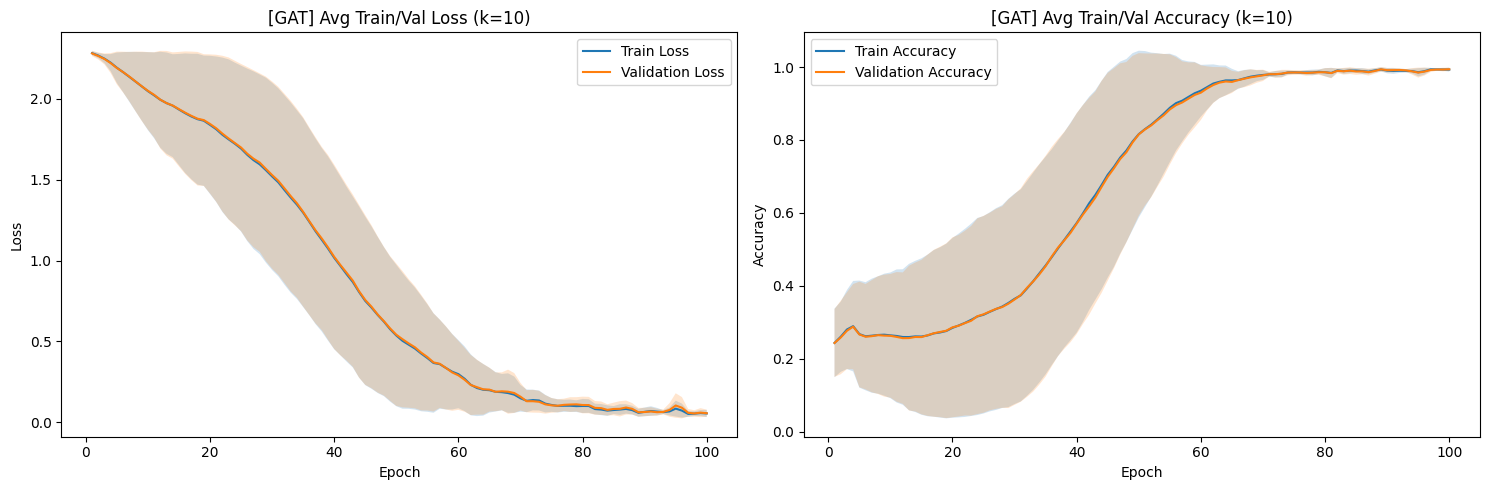

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_10_SAGE
Using existing processed data for k_10_SAGE
Starting k-fold cross-validation for SAGE...

--- Fold 1/10 ---
Epoch 010, Train Loss: 2.3005, Train Acc: 0.1083, Val Loss: 2.3010, Val Acc: 0.1057


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2778, Train Acc: 0.1104, Val Loss: 2.2782, Val Acc: 0.1070
Epoch 030, Train Loss: 2.2190, Train Acc: 0.1750, Val Loss: 2.2199, Val Acc: 0.1654
Epoch 040, Train Loss: 2.1024, Train Acc: 0.3719, Val Loss: 2.1089, Val Acc: 0.3756
Epoch 050, Train Loss: 1.8982, Train Acc: 0.5534, Val Loss: 1.9135, Val Acc: 0.5211
Epoch 060, Train Loss: 1.6542, Train Acc: 0.7021, Val Loss: 1.6769, Val Acc: 0.6642
Epoch 070, Train Loss: 1.3926, Train Acc: 0.7937, Val Loss: 1.4212, Val Acc: 0.7761
Epoch 080, Train Loss: 1.1476, Train Acc: 0.8345, Val Loss: 1.1798, Val Acc: 0.8197
Epoch 090, Train Loss: 1.0424, Train Acc: 0.8665, Val Loss: 1.0733, Val Acc: 0.8520


[I 2025-01-26 16:48:44,791] Trial 0 finished with value: 0.9017550945281982 and parameters: {'hidden_channels': 17, 'dropout': 0.29151691709253474, 'lr': 0.0008132016722274341}. Best is trial 0 with value: 0.9017550945281982.


Epoch 100, Train Loss: 0.8681, Train Acc: 0.8967, Val Loss: 0.9018, Val Acc: 0.8893
Epoch 010, Train Loss: 2.0141, Train Acc: 0.5208, Val Loss: 2.0206, Val Acc: 0.5037


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2828, Train Acc: 0.7231, Val Loss: 1.3003, Val Acc: 0.7177
Epoch 030, Train Loss: 0.6787, Train Acc: 0.8490, Val Loss: 0.7049, Val Acc: 0.8383
Epoch 040, Train Loss: 0.3595, Train Acc: 0.9039, Val Loss: 0.3875, Val Acc: 0.8943
Epoch 050, Train Loss: 0.1969, Train Acc: 0.9446, Val Loss: 0.2229, Val Acc: 0.9341
Epoch 060, Train Loss: 0.1639, Train Acc: 0.9518, Val Loss: 0.1880, Val Acc: 0.9478
Epoch 070, Train Loss: 0.1617, Train Acc: 0.9577, Val Loss: 0.1810, Val Acc: 0.9465
Epoch 080, Train Loss: 0.1539, Train Acc: 0.9560, Val Loss: 0.1547, Val Acc: 0.9552
Epoch 090, Train Loss: 0.0661, Train Acc: 0.9801, Val Loss: 0.0789, Val Acc: 0.9764


[I 2025-01-26 16:48:46,620] Trial 1 finished with value: 0.06362458318471909 and parameters: {'hidden_channels': 63, 'dropout': 0.4331332918918829, 'lr': 0.004077499939523389}. Best is trial 1 with value: 0.06362458318471909.


Epoch 100, Train Loss: 0.0593, Train Acc: 0.9874, Val Loss: 0.0636, Val Acc: 0.9888
Epoch 010, Train Loss: 2.2918, Train Acc: 0.1125, Val Loss: 2.2901, Val Acc: 0.1144


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2536, Train Acc: 0.1117, Val Loss: 2.2517, Val Acc: 0.1157
Epoch 030, Train Loss: 2.1858, Train Acc: 0.1725, Val Loss: 2.1839, Val Acc: 0.1803
Epoch 040, Train Loss: 2.0416, Train Acc: 0.3487, Val Loss: 2.0429, Val Acc: 0.3333
Epoch 050, Train Loss: 1.8093, Train Acc: 0.6010, Val Loss: 1.8147, Val Acc: 0.5945
Epoch 060, Train Loss: 1.4743, Train Acc: 0.8109, Val Loss: 1.4871, Val Acc: 0.8035
Epoch 070, Train Loss: 1.1151, Train Acc: 0.8782, Val Loss: 1.1365, Val Acc: 0.8657
Epoch 080, Train Loss: 0.8190, Train Acc: 0.9025, Val Loss: 0.8412, Val Acc: 0.8905
Epoch 090, Train Loss: 0.6519, Train Acc: 0.9154, Val Loss: 0.6765, Val Acc: 0.9017


[I 2025-01-26 16:48:48,309] Trial 2 finished with value: 0.5586280226707458 and parameters: {'hidden_channels': 33, 'dropout': 0.38014830702698343, 'lr': 0.00057058904039093}. Best is trial 1 with value: 0.06362458318471909.


Epoch 100, Train Loss: 0.5312, Train Acc: 0.9351, Val Loss: 0.5586, Val Acc: 0.9142
Epoch 010, Train Loss: 2.2933, Train Acc: 0.2187, Val Loss: 2.2945, Val Acc: 0.2189


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2680, Train Acc: 0.1577, Val Loss: 2.2697, Val Acc: 0.1443
Epoch 030, Train Loss: 2.2116, Train Acc: 0.3126, Val Loss: 2.2141, Val Acc: 0.3184
Epoch 040, Train Loss: 2.1132, Train Acc: 0.4366, Val Loss: 2.1182, Val Acc: 0.4204
Epoch 050, Train Loss: 1.9368, Train Acc: 0.6186, Val Loss: 1.9476, Val Acc: 0.5871
Epoch 060, Train Loss: 1.6864, Train Acc: 0.7348, Val Loss: 1.7031, Val Acc: 0.7226
Epoch 070, Train Loss: 1.4271, Train Acc: 0.7832, Val Loss: 1.4501, Val Acc: 0.7649
Epoch 080, Train Loss: 1.1764, Train Acc: 0.8328, Val Loss: 1.2090, Val Acc: 0.8271
Epoch 090, Train Loss: 0.9936, Train Acc: 0.8798, Val Loss: 1.0240, Val Acc: 0.8719


[I 2025-01-26 16:48:49,888] Trial 3 finished with value: 0.875742495059967 and parameters: {'hidden_channels': 25, 'dropout': 0.4893778487287345, 'lr': 0.0004963675072072444}. Best is trial 1 with value: 0.06362458318471909.


Epoch 100, Train Loss: 0.8521, Train Acc: 0.9001, Val Loss: 0.8757, Val Acc: 0.8881
Epoch 010, Train Loss: 2.2348, Train Acc: 0.2619, Val Loss: 2.2400, Val Acc: 0.2612


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0539, Train Acc: 0.4002, Val Loss: 2.0576, Val Acc: 0.4154
Epoch 030, Train Loss: 1.7390, Train Acc: 0.6217, Val Loss: 1.7493, Val Acc: 0.6144
Epoch 040, Train Loss: 1.3597, Train Acc: 0.7581, Val Loss: 1.3735, Val Acc: 0.7313
Epoch 050, Train Loss: 0.9172, Train Acc: 0.8857, Val Loss: 0.9408, Val Acc: 0.8632
Epoch 060, Train Loss: 0.4966, Train Acc: 0.9518, Val Loss: 0.5155, Val Acc: 0.9490
Epoch 070, Train Loss: 0.2741, Train Acc: 0.9745, Val Loss: 0.2900, Val Acc: 0.9739
Epoch 080, Train Loss: 0.1995, Train Acc: 0.9767, Val Loss: 0.2201, Val Acc: 0.9789
Epoch 090, Train Loss: 0.1423, Train Acc: 0.9832, Val Loss: 0.1595, Val Acc: 0.9851


[I 2025-01-26 16:48:51,650] Trial 4 finished with value: 0.12437191605567932 and parameters: {'hidden_channels': 48, 'dropout': 0.21360101535528953, 'lr': 0.0012588422628671543}. Best is trial 1 with value: 0.06362458318471909.


Epoch 100, Train Loss: 0.1115, Train Acc: 0.9809, Val Loss: 0.1244, Val Acc: 0.9789
  Fold 1 - Optuna Best Trial Val Loss: 0.0636
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 63, 'dropout': 0.4331332918918829, 'lr': 0.004077499939523389}
Epoch 010, Train Loss: 2.0000, Train Acc: 0.4949, Val Loss: 2.0106, Val Acc: 0.4701


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2958, Train Acc: 0.7070, Val Loss: 1.2995, Val Acc: 0.6928
Epoch 030, Train Loss: 0.7582, Train Acc: 0.8121, Val Loss: 0.7776, Val Acc: 0.7873
Epoch 040, Train Loss: 0.4024, Train Acc: 0.8917, Val Loss: 0.4291, Val Acc: 0.8719
Epoch 050, Train Loss: 0.2569, Train Acc: 0.9241, Val Loss: 0.2799, Val Acc: 0.9092
Epoch 060, Train Loss: 0.1641, Train Acc: 0.9555, Val Loss: 0.1850, Val Acc: 0.9490
Epoch 070, Train Loss: 0.1048, Train Acc: 0.9655, Val Loss: 0.1258, Val Acc: 0.9627
Epoch 080, Train Loss: 0.0626, Train Acc: 0.9848, Val Loss: 0.0775, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0679, Train Acc: 0.9829, Val Loss: 0.0840, Val Acc: 0.9714


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1234, Train Acc: 0.9568, Val Loss: 0.1454, Val Acc: 0.9540
  Fold 1 Test Metrics:
  Accuracy: 0.9652
  Precision: 0.9715
  Recall: 0.9652
  F1: 0.9661

--- Fold 2/10 ---
Epoch 010, Train Loss: 2.2816, Train Acc: 0.1027, Val Loss: 2.2797, Val Acc: 0.1020


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2098, Train Acc: 0.1977, Val Loss: 2.2069, Val Acc: 0.1940
Epoch 030, Train Loss: 2.0661, Train Acc: 0.5027, Val Loss: 2.0630, Val Acc: 0.5012
Epoch 040, Train Loss: 1.8192, Train Acc: 0.7412, Val Loss: 1.8201, Val Acc: 0.7164
Epoch 050, Train Loss: 1.4771, Train Acc: 0.8267, Val Loss: 1.4837, Val Acc: 0.8109
Epoch 060, Train Loss: 1.0838, Train Acc: 0.8795, Val Loss: 1.0993, Val Acc: 0.8632
Epoch 070, Train Loss: 0.7023, Train Acc: 0.9300, Val Loss: 0.7192, Val Acc: 0.9179
Epoch 080, Train Loss: 0.4893, Train Acc: 0.9451, Val Loss: 0.5040, Val Acc: 0.9453
Epoch 090, Train Loss: 0.3292, Train Acc: 0.9658, Val Loss: 0.3515, Val Acc: 0.9540


[I 2025-01-26 16:48:55,272] Trial 0 finished with value: 0.2679130733013153 and parameters: {'hidden_channels': 51, 'dropout': 0.42975097893706626, 'lr': 0.0006396612321529556}. Best is trial 0 with value: 0.2679130733013153.


Epoch 100, Train Loss: 0.2455, Train Acc: 0.9745, Val Loss: 0.2679, Val Acc: 0.9664
Epoch 010, Train Loss: 2.2877, Train Acc: 0.1078, Val Loss: 2.2855, Val Acc: 0.1095


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2543, Train Acc: 0.2882, Val Loss: 2.2502, Val Acc: 0.3035
Epoch 030, Train Loss: 2.1835, Train Acc: 0.2885, Val Loss: 2.1791, Val Acc: 0.2886
Epoch 040, Train Loss: 2.0375, Train Acc: 0.4396, Val Loss: 2.0300, Val Acc: 0.4440
Epoch 050, Train Loss: 1.8131, Train Acc: 0.6485, Val Loss: 1.8042, Val Acc: 0.6505
Epoch 060, Train Loss: 1.4656, Train Acc: 0.8323, Val Loss: 1.4602, Val Acc: 0.8221
Epoch 070, Train Loss: 1.1198, Train Acc: 0.8958, Val Loss: 1.1295, Val Acc: 0.8943
Epoch 080, Train Loss: 0.8011, Train Acc: 0.9406, Val Loss: 0.8170, Val Acc: 0.9415
Epoch 090, Train Loss: 0.5803, Train Acc: 0.9446, Val Loss: 0.5972, Val Acc: 0.9502


[I 2025-01-26 16:48:57,015] Trial 1 finished with value: 0.472893625497818 and parameters: {'hidden_channels': 43, 'dropout': 0.26347066797260504, 'lr': 0.00040292435781144175}. Best is trial 0 with value: 0.2679130733013153.


Epoch 100, Train Loss: 0.4555, Train Acc: 0.9627, Val Loss: 0.4729, Val Acc: 0.9614
Epoch 010, Train Loss: 2.2830, Train Acc: 0.1513, Val Loss: 2.2800, Val Acc: 0.1642


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2362, Train Acc: 0.1568, Val Loss: 2.2298, Val Acc: 0.1604
Epoch 030, Train Loss: 2.1359, Train Acc: 0.2506, Val Loss: 2.1268, Val Acc: 0.2575
Epoch 040, Train Loss: 1.9515, Train Acc: 0.3982, Val Loss: 1.9447, Val Acc: 0.4167
Epoch 050, Train Loss: 1.6545, Train Acc: 0.7115, Val Loss: 1.6512, Val Acc: 0.7177
Epoch 060, Train Loss: 1.2781, Train Acc: 0.8809, Val Loss: 1.2846, Val Acc: 0.8781
Epoch 070, Train Loss: 0.9163, Train Acc: 0.9244, Val Loss: 0.9326, Val Acc: 0.9117
Epoch 080, Train Loss: 0.5942, Train Acc: 0.9499, Val Loss: 0.6166, Val Acc: 0.9440
Epoch 090, Train Loss: 0.4282, Train Acc: 0.9555, Val Loss: 0.4451, Val Acc: 0.9540


[I 2025-01-26 16:48:58,758] Trial 2 finished with value: 0.3835388422012329 and parameters: {'hidden_channels': 42, 'dropout': 0.3309824893521585, 'lr': 0.0005301194234700124}. Best is trial 0 with value: 0.2679130733013153.


Epoch 100, Train Loss: 0.3497, Train Acc: 0.9575, Val Loss: 0.3835, Val Acc: 0.9453
Epoch 010, Train Loss: 2.3059, Train Acc: 0.1072, Val Loss: 2.3050, Val Acc: 0.1107


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2954, Train Acc: 0.1011, Val Loss: 2.2948, Val Acc: 0.1020
Epoch 030, Train Loss: 2.2533, Train Acc: 0.1008, Val Loss: 2.2558, Val Acc: 0.1020
Epoch 040, Train Loss: 2.1381, Train Acc: 0.1019, Val Loss: 2.1423, Val Acc: 0.1032
Epoch 050, Train Loss: 1.9391, Train Acc: 0.2327, Val Loss: 1.9455, Val Acc: 0.2326
Epoch 060, Train Loss: 1.5842, Train Acc: 0.6720, Val Loss: 1.5950, Val Acc: 0.6592
Epoch 070, Train Loss: 1.1890, Train Acc: 0.8706, Val Loss: 1.2054, Val Acc: 0.8744
Epoch 080, Train Loss: 0.8653, Train Acc: 0.9319, Val Loss: 0.8856, Val Acc: 0.9266
Epoch 090, Train Loss: 0.6390, Train Acc: 0.9474, Val Loss: 0.6607, Val Acc: 0.9527


[I 2025-01-26 16:49:00,594] Trial 3 finished with value: 0.5314208269119263 and parameters: {'hidden_channels': 60, 'dropout': 0.21584144847238654, 'lr': 0.00022690412368836093}. Best is trial 0 with value: 0.2679130733013153.


Epoch 100, Train Loss: 0.5051, Train Acc: 0.9538, Val Loss: 0.5314, Val Acc: 0.9502
Epoch 010, Train Loss: 2.2774, Train Acc: 0.1527, Val Loss: 2.2756, Val Acc: 0.1580


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2009, Train Acc: 0.2635, Val Loss: 2.1982, Val Acc: 0.2637
Epoch 030, Train Loss: 2.0547, Train Acc: 0.3481, Val Loss: 2.0497, Val Acc: 0.3607
Epoch 040, Train Loss: 1.8030, Train Acc: 0.5601, Val Loss: 1.7991, Val Acc: 0.5448
Epoch 050, Train Loss: 1.4451, Train Acc: 0.7696, Val Loss: 1.4472, Val Acc: 0.7674
Epoch 060, Train Loss: 0.9924, Train Acc: 0.8886, Val Loss: 0.9984, Val Acc: 0.8918
Epoch 070, Train Loss: 0.6092, Train Acc: 0.9387, Val Loss: 0.6188, Val Acc: 0.9378
Epoch 080, Train Loss: 0.3679, Train Acc: 0.9676, Val Loss: 0.3843, Val Acc: 0.9639
Epoch 090, Train Loss: 0.2903, Train Acc: 0.9648, Val Loss: 0.3339, Val Acc: 0.9540


[I 2025-01-26 16:49:02,431] Trial 4 finished with value: 0.2056114226579666 and parameters: {'hidden_channels': 62, 'dropout': 0.36626698916123124, 'lr': 0.0006168096377642713}. Best is trial 4 with value: 0.2056114226579666.


Epoch 100, Train Loss: 0.1970, Train Acc: 0.9854, Val Loss: 0.2056, Val Acc: 0.9876
  Fold 2 - Optuna Best Trial Val Loss: 0.2056
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 62, 'dropout': 0.36626698916123124, 'lr': 0.0006168096377642713}
Epoch 010, Train Loss: 2.2857, Train Acc: 0.2333, Val Loss: 2.2836, Val Acc: 0.2438


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2362, Train Acc: 0.3004, Val Loss: 2.2314, Val Acc: 0.3333
Epoch 030, Train Loss: 2.1177, Train Acc: 0.4528, Val Loss: 2.1122, Val Acc: 0.4565
Epoch 040, Train Loss: 1.8821, Train Acc: 0.6396, Val Loss: 1.8760, Val Acc: 0.6418
Epoch 050, Train Loss: 1.4877, Train Acc: 0.7860, Val Loss: 1.4851, Val Acc: 0.7786
Epoch 060, Train Loss: 1.0150, Train Acc: 0.9029, Val Loss: 1.0192, Val Acc: 0.9017
Epoch 070, Train Loss: 0.6189, Train Acc: 0.9558, Val Loss: 0.6340, Val Acc: 0.9565
Epoch 080, Train Loss: 0.3743, Train Acc: 0.9661, Val Loss: 0.3948, Val Acc: 0.9602
Epoch 090, Train Loss: 0.2482, Train Acc: 0.9855, Val Loss: 0.2765, Val Acc: 0.9813


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.2190, Train Acc: 0.9767, Val Loss: 0.2265, Val Acc: 0.9701
  Fold 2 Test Metrics:
  Accuracy: 0.9726
  Precision: 0.9754
  Recall: 0.9726
  F1: 0.9732

--- Fold 3/10 ---
Epoch 010, Train Loss: 2.3024, Train Acc: 0.0992, Val Loss: 2.3026, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2927, Train Acc: 0.1167, Val Loss: 2.2942, Val Acc: 0.1144
Epoch 030, Train Loss: 2.2667, Train Acc: 0.1918, Val Loss: 2.2683, Val Acc: 0.1978
Epoch 040, Train Loss: 2.2144, Train Acc: 0.2455, Val Loss: 2.2114, Val Acc: 0.2637
Epoch 050, Train Loss: 2.1039, Train Acc: 0.3319, Val Loss: 2.1016, Val Acc: 0.3358
Epoch 060, Train Loss: 1.9234, Train Acc: 0.4369, Val Loss: 1.9201, Val Acc: 0.4366
Epoch 070, Train Loss: 1.6685, Train Acc: 0.6730, Val Loss: 1.6642, Val Acc: 0.6704
Epoch 080, Train Loss: 1.4159, Train Acc: 0.7741, Val Loss: 1.4152, Val Acc: 0.7711
Epoch 090, Train Loss: 1.2308, Train Acc: 0.8183, Val Loss: 1.2367, Val Acc: 0.8047


[I 2025-01-26 16:49:05,965] Trial 0 finished with value: 1.115539789199829 and parameters: {'hidden_channels': 31, 'dropout': 0.30950420212527685, 'lr': 0.00018609432949171677}. Best is trial 0 with value: 1.115539789199829.


Epoch 100, Train Loss: 1.1053, Train Acc: 0.8311, Val Loss: 1.1155, Val Acc: 0.8221
Epoch 010, Train Loss: 2.0612, Train Acc: 0.4680, Val Loss: 2.0642, Val Acc: 0.4826


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.4672, Train Acc: 0.6978, Val Loss: 1.4715, Val Acc: 0.6891
Epoch 030, Train Loss: 0.8959, Train Acc: 0.8067, Val Loss: 0.8939, Val Acc: 0.8060
Epoch 040, Train Loss: 0.4894, Train Acc: 0.8966, Val Loss: 0.4725, Val Acc: 0.9117
Epoch 050, Train Loss: 0.2354, Train Acc: 0.9459, Val Loss: 0.2404, Val Acc: 0.9502
Epoch 060, Train Loss: 0.1912, Train Acc: 0.9445, Val Loss: 0.1928, Val Acc: 0.9552
Epoch 070, Train Loss: 0.0969, Train Acc: 0.9841, Val Loss: 0.0891, Val Acc: 0.9851
Epoch 080, Train Loss: 0.1526, Train Acc: 0.9697, Val Loss: 0.1536, Val Acc: 0.9701
Epoch 090, Train Loss: 0.1041, Train Acc: 0.9712, Val Loss: 0.0970, Val Acc: 0.9726


[I 2025-01-26 16:49:07,791] Trial 1 finished with value: 0.04222722351551056 and parameters: {'hidden_channels': 59, 'dropout': 0.23177805540802582, 'lr': 0.003136454439204305}. Best is trial 1 with value: 0.04222722351551056.


Epoch 100, Train Loss: 0.0484, Train Acc: 0.9952, Val Loss: 0.0422, Val Acc: 0.9988
Epoch 010, Train Loss: 2.3030, Train Acc: 0.1087, Val Loss: 2.3020, Val Acc: 0.1095


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2850, Train Acc: 0.1840, Val Loss: 2.2829, Val Acc: 0.1978
Epoch 030, Train Loss: 2.2403, Train Acc: 0.2588, Val Loss: 2.2369, Val Acc: 0.2749
Epoch 040, Train Loss: 2.1577, Train Acc: 0.3934, Val Loss: 2.1539, Val Acc: 0.4005
Epoch 050, Train Loss: 1.9752, Train Acc: 0.5071, Val Loss: 1.9746, Val Acc: 0.5112
Epoch 060, Train Loss: 1.7018, Train Acc: 0.6903, Val Loss: 1.6986, Val Acc: 0.6928
Epoch 070, Train Loss: 1.3683, Train Acc: 0.8025, Val Loss: 1.3668, Val Acc: 0.8010
Epoch 080, Train Loss: 1.0700, Train Acc: 0.8609, Val Loss: 1.0710, Val Acc: 0.8458
Epoch 090, Train Loss: 0.8585, Train Acc: 0.8922, Val Loss: 0.8601, Val Acc: 0.8843


[I 2025-01-26 16:49:09,586] Trial 2 finished with value: 0.7215614914894104 and parameters: {'hidden_channels': 57, 'dropout': 0.3681693568106259, 'lr': 0.00017775225975120347}. Best is trial 1 with value: 0.04222722351551056.


Epoch 100, Train Loss: 0.7199, Train Acc: 0.9064, Val Loss: 0.7216, Val Acc: 0.9042
Epoch 010, Train Loss: 2.2969, Train Acc: 0.1051, Val Loss: 2.2979, Val Acc: 0.1107


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2659, Train Acc: 0.2422, Val Loss: 2.2694, Val Acc: 0.2438
Epoch 030, Train Loss: 2.2107, Train Acc: 0.2552, Val Loss: 2.2139, Val Acc: 0.2550
Epoch 040, Train Loss: 2.1115, Train Acc: 0.5439, Val Loss: 2.1130, Val Acc: 0.5535
Epoch 050, Train Loss: 1.9278, Train Acc: 0.6416, Val Loss: 1.9267, Val Acc: 0.6604
Epoch 060, Train Loss: 1.6153, Train Acc: 0.7522, Val Loss: 1.6141, Val Acc: 0.7649
Epoch 070, Train Loss: 1.3114, Train Acc: 0.8407, Val Loss: 1.3104, Val Acc: 0.8371
Epoch 080, Train Loss: 1.0332, Train Acc: 0.8683, Val Loss: 1.0395, Val Acc: 0.8557
Epoch 090, Train Loss: 0.8459, Train Acc: 0.8888, Val Loss: 0.8484, Val Acc: 0.8831


[I 2025-01-26 16:49:11,184] Trial 3 finished with value: 0.717878520488739 and parameters: {'hidden_channels': 30, 'dropout': 0.22047822387407948, 'lr': 0.0004880423735876177}. Best is trial 1 with value: 0.04222722351551056.


Epoch 100, Train Loss: 0.7036, Train Acc: 0.9132, Val Loss: 0.7179, Val Acc: 0.9129
Epoch 010, Train Loss: 2.3109, Train Acc: 0.0986, Val Loss: 2.3135, Val Acc: 0.0945


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3082, Train Acc: 0.1118, Val Loss: 2.3115, Val Acc: 0.1107
Epoch 030, Train Loss: 2.2921, Train Acc: 0.1156, Val Loss: 2.2959, Val Acc: 0.1157
Epoch 040, Train Loss: 2.2369, Train Acc: 0.1795, Val Loss: 2.2422, Val Acc: 0.1779
Epoch 050, Train Loss: 2.1231, Train Acc: 0.3092, Val Loss: 2.1286, Val Acc: 0.3072
Epoch 060, Train Loss: 1.9474, Train Acc: 0.4599, Val Loss: 1.9503, Val Acc: 0.4602
Epoch 070, Train Loss: 1.6930, Train Acc: 0.6180, Val Loss: 1.6937, Val Acc: 0.6169
Epoch 080, Train Loss: 1.4382, Train Acc: 0.7336, Val Loss: 1.4404, Val Acc: 0.7077
Epoch 090, Train Loss: 1.2360, Train Acc: 0.7981, Val Loss: 1.2388, Val Acc: 0.7811


[I 2025-01-26 16:49:12,910] Trial 4 finished with value: 1.1218912601470947 and parameters: {'hidden_channels': 41, 'dropout': 0.2692153587800769, 'lr': 0.00013298310633189163}. Best is trial 1 with value: 0.04222722351551056.


Epoch 100, Train Loss: 1.1165, Train Acc: 0.8342, Val Loss: 1.1219, Val Acc: 0.8147
  Fold 3 - Optuna Best Trial Val Loss: 0.0422
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 59, 'dropout': 0.23177805540802582, 'lr': 0.003136454439204305}
Epoch 010, Train Loss: 2.0641, Train Acc: 0.5737, Val Loss: 2.0682, Val Acc: 0.5821


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.5110, Train Acc: 0.6973, Val Loss: 1.5081, Val Acc: 0.7027
Epoch 030, Train Loss: 0.9176, Train Acc: 0.8177, Val Loss: 0.9176, Val Acc: 0.8172
Epoch 040, Train Loss: 0.4671, Train Acc: 0.9213, Val Loss: 0.4691, Val Acc: 0.9104
Epoch 050, Train Loss: 0.2499, Train Acc: 0.9491, Val Loss: 0.2564, Val Acc: 0.9527
Epoch 060, Train Loss: 0.1310, Train Acc: 0.9785, Val Loss: 0.1477, Val Acc: 0.9726
Epoch 070, Train Loss: 0.0980, Train Acc: 0.9776, Val Loss: 0.0989, Val Acc: 0.9726
Epoch 080, Train Loss: 0.2570, Train Acc: 0.9438, Val Loss: 0.2248, Val Acc: 0.9465
Epoch 090, Train Loss: 0.0946, Train Acc: 0.9745, Val Loss: 0.0979, Val Acc: 0.9726


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0394, Train Acc: 0.9925, Val Loss: 0.0329, Val Acc: 0.9963
  Fold 3 Test Metrics:
  Accuracy: 0.9876
  Precision: 0.9883
  Recall: 0.9876
  F1: 0.9876

--- Fold 4/10 ---
Epoch 010, Train Loss: 2.2961, Train Acc: 0.1392, Val Loss: 2.2964, Val Acc: 0.1343


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2665, Train Acc: 0.1801, Val Loss: 2.2663, Val Acc: 0.1866
Epoch 030, Train Loss: 2.2039, Train Acc: 0.2207, Val Loss: 2.2043, Val Acc: 0.2376
Epoch 040, Train Loss: 2.0924, Train Acc: 0.4551, Val Loss: 2.0968, Val Acc: 0.4552
Epoch 050, Train Loss: 1.9186, Train Acc: 0.6951, Val Loss: 1.9305, Val Acc: 0.6953
Epoch 060, Train Loss: 1.6546, Train Acc: 0.8280, Val Loss: 1.6719, Val Acc: 0.8097
Epoch 070, Train Loss: 1.3192, Train Acc: 0.8813, Val Loss: 1.3426, Val Acc: 0.8756
Epoch 080, Train Loss: 1.0254, Train Acc: 0.9031, Val Loss: 1.0581, Val Acc: 0.8893
Epoch 090, Train Loss: 0.8132, Train Acc: 0.9258, Val Loss: 0.8464, Val Acc: 0.9142


[I 2025-01-26 16:49:16,443] Trial 0 finished with value: 0.7075666189193726 and parameters: {'hidden_channels': 39, 'dropout': 0.23049536484414404, 'lr': 0.00028038420203783867}. Best is trial 0 with value: 0.7075666189193726.


Epoch 100, Train Loss: 0.6748, Train Acc: 0.9372, Val Loss: 0.7076, Val Acc: 0.9341
Epoch 010, Train Loss: 1.5816, Train Acc: 0.5486, Val Loss: 1.6049, Val Acc: 0.5473


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 0.8135, Train Acc: 0.7420, Val Loss: 0.8827, Val Acc: 0.7425
Epoch 030, Train Loss: 0.4080, Train Acc: 0.8616, Val Loss: 0.4636, Val Acc: 0.8433
Epoch 040, Train Loss: 0.2728, Train Acc: 0.9138, Val Loss: 0.3430, Val Acc: 0.9030
Epoch 050, Train Loss: 0.1937, Train Acc: 0.9316, Val Loss: 0.2019, Val Acc: 0.9279
Epoch 060, Train Loss: 0.1005, Train Acc: 0.9795, Val Loss: 0.1117, Val Acc: 0.9801
Epoch 070, Train Loss: 0.1452, Train Acc: 0.9507, Val Loss: 0.1654, Val Acc: 0.9502
Epoch 080, Train Loss: 0.1067, Train Acc: 0.9714, Val Loss: 0.1040, Val Acc: 0.9751
Epoch 090, Train Loss: 0.0522, Train Acc: 0.9874, Val Loss: 0.0564, Val Acc: 0.9851


[I 2025-01-26 16:49:18,249] Trial 1 finished with value: 0.048481859266757965 and parameters: {'hidden_channels': 58, 'dropout': 0.36356816242279244, 'lr': 0.008797556126007498}. Best is trial 1 with value: 0.048481859266757965.


Epoch 100, Train Loss: 0.0388, Train Acc: 0.9907, Val Loss: 0.0485, Val Acc: 0.9876
Epoch 010, Train Loss: 2.2914, Train Acc: 0.1016, Val Loss: 2.2910, Val Acc: 0.1020


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2448, Train Acc: 0.1028, Val Loss: 2.2468, Val Acc: 0.1057
Epoch 030, Train Loss: 2.1643, Train Acc: 0.1293, Val Loss: 2.1710, Val Acc: 0.1269
Epoch 040, Train Loss: 2.0033, Train Acc: 0.3041, Val Loss: 2.0208, Val Acc: 0.2662
Epoch 050, Train Loss: 1.7139, Train Acc: 0.6768, Val Loss: 1.7407, Val Acc: 0.6281
Epoch 060, Train Loss: 1.2998, Train Acc: 0.8698, Val Loss: 1.3336, Val Acc: 0.8483
Epoch 070, Train Loss: 0.8633, Train Acc: 0.9365, Val Loss: 0.8978, Val Acc: 0.9316
Epoch 080, Train Loss: 0.5447, Train Acc: 0.9602, Val Loss: 0.5757, Val Acc: 0.9527
Epoch 090, Train Loss: 0.3619, Train Acc: 0.9782, Val Loss: 0.3937, Val Acc: 0.9689


[I 2025-01-26 16:49:20,076] Trial 2 finished with value: 0.2855033874511719 and parameters: {'hidden_channels': 64, 'dropout': 0.2766530592338942, 'lr': 0.0003936154312523648}. Best is trial 1 with value: 0.048481859266757965.


Epoch 100, Train Loss: 0.2548, Train Acc: 0.9793, Val Loss: 0.2855, Val Acc: 0.9726
Epoch 010, Train Loss: 2.3004, Train Acc: 0.1622, Val Loss: 2.3021, Val Acc: 0.1617


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2807, Train Acc: 0.1781, Val Loss: 2.2844, Val Acc: 0.1654
Epoch 030, Train Loss: 2.2424, Train Acc: 0.2934, Val Loss: 2.2478, Val Acc: 0.2736
Epoch 040, Train Loss: 2.1741, Train Acc: 0.4122, Val Loss: 2.1804, Val Acc: 0.3968
Epoch 050, Train Loss: 2.0563, Train Acc: 0.5967, Val Loss: 2.0646, Val Acc: 0.5995
Epoch 060, Train Loss: 1.8540, Train Acc: 0.7416, Val Loss: 1.8696, Val Acc: 0.7363
Epoch 070, Train Loss: 1.5896, Train Acc: 0.8180, Val Loss: 1.6143, Val Acc: 0.8109
Epoch 080, Train Loss: 1.3207, Train Acc: 0.8431, Val Loss: 1.3512, Val Acc: 0.8358
Epoch 090, Train Loss: 1.1083, Train Acc: 0.8667, Val Loss: 1.1406, Val Acc: 0.8607


[I 2025-01-26 16:49:21,788] Trial 3 finished with value: 1.001922845840454 and parameters: {'hidden_channels': 38, 'dropout': 0.4819611421655849, 'lr': 0.00024657299532978677}. Best is trial 1 with value: 0.048481859266757965.


Epoch 100, Train Loss: 0.9649, Train Acc: 0.8958, Val Loss: 1.0019, Val Acc: 0.8881
Epoch 010, Train Loss: 2.1814, Train Acc: 0.2576, Val Loss: 2.1809, Val Acc: 0.2637


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8037, Train Acc: 0.5918, Val Loss: 1.8106, Val Acc: 0.5933
Epoch 030, Train Loss: 1.3449, Train Acc: 0.7463, Val Loss: 1.3570, Val Acc: 0.7413
Epoch 040, Train Loss: 0.8605, Train Acc: 0.8410, Val Loss: 0.8805, Val Acc: 0.8271
Epoch 050, Train Loss: 0.5029, Train Acc: 0.9028, Val Loss: 0.5334, Val Acc: 0.8968
Epoch 060, Train Loss: 0.2867, Train Acc: 0.9423, Val Loss: 0.3111, Val Acc: 0.9378
Epoch 070, Train Loss: 0.1848, Train Acc: 0.9564, Val Loss: 0.2188, Val Acc: 0.9403
Epoch 080, Train Loss: 0.1430, Train Acc: 0.9807, Val Loss: 0.1714, Val Acc: 0.9764
Epoch 090, Train Loss: 0.1283, Train Acc: 0.9768, Val Loss: 0.1493, Val Acc: 0.9776


[I 2025-01-26 16:49:23,516] Trial 4 finished with value: 0.16866661608219147 and parameters: {'hidden_channels': 41, 'dropout': 0.27027160980059667, 'lr': 0.0024005752603400692}. Best is trial 1 with value: 0.048481859266757965.


Epoch 100, Train Loss: 0.1449, Train Acc: 0.9709, Val Loss: 0.1687, Val Acc: 0.9726
  Fold 4 - Optuna Best Trial Val Loss: 0.0485
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 58, 'dropout': 0.36356816242279244, 'lr': 0.008797556126007498}
Epoch 010, Train Loss: 1.5947, Train Acc: 0.5467, Val Loss: 1.6047, Val Acc: 0.5647


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 0.7654, Train Acc: 0.7559, Val Loss: 0.7775, Val Acc: 0.7388
Epoch 030, Train Loss: 0.4059, Train Acc: 0.8851, Val Loss: 0.4249, Val Acc: 0.8843
Epoch 040, Train Loss: 0.2647, Train Acc: 0.9092, Val Loss: 0.2816, Val Acc: 0.9092
Epoch 050, Train Loss: 0.1416, Train Acc: 0.9541, Val Loss: 0.1537, Val Acc: 0.9540
Epoch 060, Train Loss: 0.3687, Train Acc: 0.9239, Val Loss: 0.3817, Val Acc: 0.9017
Epoch 070, Train Loss: 0.1078, Train Acc: 0.9681, Val Loss: 0.1197, Val Acc: 0.9639
Epoch 080, Train Loss: 0.0693, Train Acc: 0.9843, Val Loss: 0.0808, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0646, Train Acc: 0.9872, Val Loss: 0.0757, Val Acc: 0.9838


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0338, Train Acc: 0.9956, Val Loss: 0.0392, Val Acc: 0.9950
  Fold 4 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Fold 5/10 ---
Epoch 010, Train Loss: 2.3009, Train Acc: 0.1209, Val Loss: 2.3010, Val Acc: 0.1182


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2857, Train Acc: 0.1056, Val Loss: 2.2867, Val Acc: 0.1045
Epoch 030, Train Loss: 2.2481, Train Acc: 0.1149, Val Loss: 2.2516, Val Acc: 0.1082
Epoch 040, Train Loss: 2.1813, Train Acc: 0.1899, Val Loss: 2.1852, Val Acc: 0.1828
Epoch 050, Train Loss: 2.0745, Train Acc: 0.2927, Val Loss: 2.0829, Val Acc: 0.2836
Epoch 060, Train Loss: 1.8803, Train Acc: 0.5332, Val Loss: 1.8932, Val Acc: 0.5187
Epoch 070, Train Loss: 1.6378, Train Acc: 0.6950, Val Loss: 1.6517, Val Acc: 0.6965
Epoch 080, Train Loss: 1.3794, Train Acc: 0.7990, Val Loss: 1.3946, Val Acc: 0.8022
Epoch 090, Train Loss: 1.1896, Train Acc: 0.8451, Val Loss: 1.2026, Val Acc: 0.8445


[I 2025-01-26 16:49:26,911] Trial 0 finished with value: 1.0796478986740112 and parameters: {'hidden_channels': 28, 'dropout': 0.22099850583912703, 'lr': 0.0001699597524907665}. Best is trial 0 with value: 1.0796478986740112.


Epoch 100, Train Loss: 1.0673, Train Acc: 0.8704, Val Loss: 1.0796, Val Acc: 0.8769
Epoch 010, Train Loss: 2.2791, Train Acc: 0.1008, Val Loss: 2.2788, Val Acc: 0.1020


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1970, Train Acc: 0.2646, Val Loss: 2.1966, Val Acc: 0.2600
Epoch 030, Train Loss: 2.0205, Train Acc: 0.5026, Val Loss: 2.0291, Val Acc: 0.5100
Epoch 040, Train Loss: 1.7429, Train Acc: 0.6278, Val Loss: 1.7615, Val Acc: 0.6318
Epoch 050, Train Loss: 1.3411, Train Acc: 0.7760, Val Loss: 1.3665, Val Acc: 0.7736
Epoch 060, Train Loss: 0.8909, Train Acc: 0.8896, Val Loss: 0.9201, Val Acc: 0.8955
Epoch 070, Train Loss: 0.5354, Train Acc: 0.9438, Val Loss: 0.5527, Val Acc: 0.9440
Epoch 080, Train Loss: 0.3590, Train Acc: 0.9527, Val Loss: 0.3681, Val Acc: 0.9515
Epoch 090, Train Loss: 0.2476, Train Acc: 0.9662, Val Loss: 0.2572, Val Acc: 0.9602


[I 2025-01-26 16:49:28,698] Trial 1 finished with value: 0.22969132661819458 and parameters: {'hidden_channels': 54, 'dropout': 0.4451732027455623, 'lr': 0.0008454808951351709}. Best is trial 1 with value: 0.22969132661819458.


Epoch 100, Train Loss: 0.2122, Train Acc: 0.9692, Val Loss: 0.2297, Val Acc: 0.9726
Epoch 010, Train Loss: 2.2743, Train Acc: 0.1020, Val Loss: 2.2754, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1936, Train Acc: 0.3965, Val Loss: 2.1972, Val Acc: 0.3856
Epoch 030, Train Loss: 2.0247, Train Acc: 0.5072, Val Loss: 2.0327, Val Acc: 0.4963
Epoch 040, Train Loss: 1.7462, Train Acc: 0.7001, Val Loss: 1.7605, Val Acc: 0.6791
Epoch 050, Train Loss: 1.3585, Train Acc: 0.8376, Val Loss: 1.3801, Val Acc: 0.8483
Epoch 060, Train Loss: 0.9250, Train Acc: 0.9040, Val Loss: 0.9435, Val Acc: 0.9104
Epoch 070, Train Loss: 0.5602, Train Acc: 0.9406, Val Loss: 0.5788, Val Acc: 0.9490
Epoch 080, Train Loss: 0.3515, Train Acc: 0.9678, Val Loss: 0.3685, Val Acc: 0.9577
Epoch 090, Train Loss: 0.2540, Train Acc: 0.9704, Val Loss: 0.2702, Val Acc: 0.9627


[I 2025-01-26 16:49:30,499] Trial 2 finished with value: 0.20753319561481476 and parameters: {'hidden_channels': 58, 'dropout': 0.2970116327941653, 'lr': 0.0006573822723384955}. Best is trial 2 with value: 0.20753319561481476.


Epoch 100, Train Loss: 0.1938, Train Acc: 0.9826, Val Loss: 0.2075, Val Acc: 0.9838
Epoch 010, Train Loss: 1.7653, Train Acc: 0.5589, Val Loss: 1.7783, Val Acc: 0.5435


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 0.9641, Train Acc: 0.7376, Val Loss: 0.9747, Val Acc: 0.7450
Epoch 030, Train Loss: 0.5872, Train Acc: 0.8323, Val Loss: 0.5549, Val Acc: 0.8420
Epoch 040, Train Loss: 0.3442, Train Acc: 0.8879, Val Loss: 0.3470, Val Acc: 0.8905
Epoch 050, Train Loss: 0.1715, Train Acc: 0.9526, Val Loss: 0.1773, Val Acc: 0.9527
Epoch 060, Train Loss: 0.1930, Train Acc: 0.9504, Val Loss: 0.1459, Val Acc: 0.9552
Epoch 070, Train Loss: 0.0878, Train Acc: 0.9834, Val Loss: 0.0889, Val Acc: 0.9838
Epoch 080, Train Loss: 0.0768, Train Acc: 0.9821, Val Loss: 0.0893, Val Acc: 0.9776
Epoch 090, Train Loss: 0.0713, Train Acc: 0.9871, Val Loss: 0.0466, Val Acc: 0.9938


[I 2025-01-26 16:49:32,263] Trial 3 finished with value: 0.0573904775083065 and parameters: {'hidden_channels': 49, 'dropout': 0.2844203691104722, 'lr': 0.00659906324454031}. Best is trial 3 with value: 0.0573904775083065.


Epoch 100, Train Loss: 0.0596, Train Acc: 0.9852, Val Loss: 0.0574, Val Acc: 0.9876
Epoch 010, Train Loss: 2.1671, Train Acc: 0.3791, Val Loss: 2.1704, Val Acc: 0.3657


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8120, Train Acc: 0.4340, Val Loss: 1.8161, Val Acc: 0.4266
Epoch 030, Train Loss: 1.3693, Train Acc: 0.5733, Val Loss: 1.3840, Val Acc: 0.5572
Epoch 040, Train Loss: 0.8324, Train Acc: 0.8012, Val Loss: 0.8548, Val Acc: 0.8060
Epoch 050, Train Loss: 0.4119, Train Acc: 0.9228, Val Loss: 0.4342, Val Acc: 0.9104
Epoch 060, Train Loss: 0.2120, Train Acc: 0.9634, Val Loss: 0.2236, Val Acc: 0.9552
Epoch 070, Train Loss: 0.1402, Train Acc: 0.9742, Val Loss: 0.1445, Val Acc: 0.9701
Epoch 080, Train Loss: 0.1383, Train Acc: 0.9670, Val Loss: 0.1377, Val Acc: 0.9652
Epoch 090, Train Loss: 0.1447, Train Acc: 0.9661, Val Loss: 0.1484, Val Acc: 0.9677


[I 2025-01-26 16:49:34,053] Trial 4 finished with value: 0.07538771629333496 and parameters: {'hidden_channels': 56, 'dropout': 0.44899979964587133, 'lr': 0.0021984654120656174}. Best is trial 3 with value: 0.0573904775083065.


Epoch 100, Train Loss: 0.0821, Train Acc: 0.9823, Val Loss: 0.0754, Val Acc: 0.9876
  Fold 5 - Optuna Best Trial Val Loss: 0.0574
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 49, 'dropout': 0.2844203691104722, 'lr': 0.00659906324454031}
Epoch 010, Train Loss: 1.8359, Train Acc: 0.5267, Val Loss: 1.8481, Val Acc: 0.5162


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.0369, Train Acc: 0.6674, Val Loss: 1.0531, Val Acc: 0.6468
Epoch 030, Train Loss: 0.5184, Train Acc: 0.8581, Val Loss: 0.5626, Val Acc: 0.8445
Epoch 040, Train Loss: 0.2838, Train Acc: 0.9132, Val Loss: 0.2855, Val Acc: 0.9154
Epoch 050, Train Loss: 0.2476, Train Acc: 0.9162, Val Loss: 0.2408, Val Acc: 0.9167
Epoch 060, Train Loss: 0.1843, Train Acc: 0.9368, Val Loss: 0.1994, Val Acc: 0.9391
Epoch 070, Train Loss: 0.1003, Train Acc: 0.9790, Val Loss: 0.1083, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0711, Train Acc: 0.9844, Val Loss: 0.0715, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0558, Train Acc: 0.9908, Val Loss: 0.0638, Val Acc: 0.9838
Epoch 100, Train Loss: 0.0416, Train Acc: 0.9946, Val Loss: 0.0461, Val Acc: 0.9938
  Fold 5 Test Metrics:
  Accuracy: 0.9900
  Precision: 0.9905
  Recall: 0.9900
  F1: 0.9901

--- Fold 6/10 ---


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 010, Train Loss: 2.3001, Train Acc: 0.1003, Val Loss: 2.3005, Val Acc: 0.1007


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2794, Train Acc: 0.1397, Val Loss: 2.2802, Val Acc: 0.1331
Epoch 030, Train Loss: 2.2258, Train Acc: 0.2170, Val Loss: 2.2272, Val Acc: 0.2015
Epoch 040, Train Loss: 2.1339, Train Acc: 0.3629, Val Loss: 2.1379, Val Acc: 0.3445
Epoch 050, Train Loss: 1.9532, Train Acc: 0.5558, Val Loss: 1.9601, Val Acc: 0.5410
Epoch 060, Train Loss: 1.6738, Train Acc: 0.7306, Val Loss: 1.6835, Val Acc: 0.7276
Epoch 070, Train Loss: 1.3371, Train Acc: 0.8278, Val Loss: 1.3458, Val Acc: 0.7910
Epoch 080, Train Loss: 1.0351, Train Acc: 0.8798, Val Loss: 1.0524, Val Acc: 0.8582
Epoch 090, Train Loss: 0.8253, Train Acc: 0.9078, Val Loss: 0.8452, Val Acc: 0.8868


[I 2025-01-26 16:49:37,563] Trial 0 finished with value: 0.6759857535362244 and parameters: {'hidden_channels': 39, 'dropout': 0.444038084919484, 'lr': 0.0003767343641880147}. Best is trial 0 with value: 0.6759857535362244.


Epoch 100, Train Loss: 0.6571, Train Acc: 0.9255, Val Loss: 0.6760, Val Acc: 0.9080
Epoch 010, Train Loss: 2.3052, Train Acc: 0.0995, Val Loss: 2.3050, Val Acc: 0.1032


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3039, Train Acc: 0.0995, Val Loss: 2.3019, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2902, Train Acc: 0.0995, Val Loss: 2.2854, Val Acc: 0.1032
Epoch 040, Train Loss: 2.2491, Train Acc: 0.0995, Val Loss: 2.2460, Val Acc: 0.1032
Epoch 050, Train Loss: 2.1728, Train Acc: 0.1047, Val Loss: 2.1691, Val Acc: 0.1095
Epoch 060, Train Loss: 2.0377, Train Acc: 0.1943, Val Loss: 2.0355, Val Acc: 0.2077
Epoch 070, Train Loss: 1.8595, Train Acc: 0.4777, Val Loss: 1.8597, Val Acc: 0.4577
Epoch 080, Train Loss: 1.6963, Train Acc: 0.5892, Val Loss: 1.6949, Val Acc: 0.5970
Epoch 090, Train Loss: 1.5739, Train Acc: 0.6307, Val Loss: 1.5733, Val Acc: 0.6393


[I 2025-01-26 16:49:39,116] Trial 1 finished with value: 1.4917547702789307 and parameters: {'hidden_channels': 22, 'dropout': 0.42569670707804264, 'lr': 0.0001066202101545883}. Best is trial 0 with value: 0.6759857535362244.


Epoch 100, Train Loss: 1.4928, Train Acc: 0.6673, Val Loss: 1.4918, Val Acc: 0.6754
Epoch 010, Train Loss: 2.1567, Train Acc: 0.3853, Val Loss: 2.1604, Val Acc: 0.3831


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8476, Train Acc: 0.6219, Val Loss: 1.8511, Val Acc: 0.6107
Epoch 030, Train Loss: 1.3717, Train Acc: 0.7126, Val Loss: 1.3736, Val Acc: 0.7077
Epoch 040, Train Loss: 0.9025, Train Acc: 0.8305, Val Loss: 0.8987, Val Acc: 0.8197
Epoch 050, Train Loss: 0.5109, Train Acc: 0.8785, Val Loss: 0.5192, Val Acc: 0.8595
Epoch 060, Train Loss: 0.2917, Train Acc: 0.9323, Val Loss: 0.2940, Val Acc: 0.9229
Epoch 070, Train Loss: 0.2193, Train Acc: 0.9448, Val Loss: 0.2586, Val Acc: 0.9353
Epoch 080, Train Loss: 0.1107, Train Acc: 0.9754, Val Loss: 0.1167, Val Acc: 0.9714
Epoch 090, Train Loss: 0.1348, Train Acc: 0.9672, Val Loss: 0.1232, Val Acc: 0.9764


[I 2025-01-26 16:49:40,915] Trial 2 finished with value: 0.15311278402805328 and parameters: {'hidden_channels': 56, 'dropout': 0.4681080625850628, 'lr': 0.0022404128775554877}. Best is trial 2 with value: 0.15311278402805328.


Epoch 100, Train Loss: 0.1115, Train Acc: 0.9759, Val Loss: 0.1531, Val Acc: 0.9614
Epoch 010, Train Loss: 2.2833, Train Acc: 0.1552, Val Loss: 2.2861, Val Acc: 0.1480


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2154, Train Acc: 0.2134, Val Loss: 2.2213, Val Acc: 0.1990
Epoch 030, Train Loss: 2.0880, Train Acc: 0.3025, Val Loss: 2.0940, Val Acc: 0.2973
Epoch 040, Train Loss: 1.8721, Train Acc: 0.4673, Val Loss: 1.8808, Val Acc: 0.4502
Epoch 050, Train Loss: 1.5442, Train Acc: 0.7322, Val Loss: 1.5578, Val Acc: 0.7015
Epoch 060, Train Loss: 1.1669, Train Acc: 0.8572, Val Loss: 1.1792, Val Acc: 0.8445
Epoch 070, Train Loss: 0.8058, Train Acc: 0.9036, Val Loss: 0.8294, Val Acc: 0.8818
Epoch 080, Train Loss: 0.5732, Train Acc: 0.9403, Val Loss: 0.5905, Val Acc: 0.9229
Epoch 090, Train Loss: 0.4162, Train Acc: 0.9588, Val Loss: 0.4373, Val Acc: 0.9490


[I 2025-01-26 16:49:42,646] Trial 3 finished with value: 0.3536657392978668 and parameters: {'hidden_channels': 41, 'dropout': 0.20978435873077025, 'lr': 0.0006244131412059282}. Best is trial 2 with value: 0.15311278402805328.


Epoch 100, Train Loss: 0.3390, Train Acc: 0.9541, Val Loss: 0.3537, Val Acc: 0.9428
Epoch 010, Train Loss: 2.2960, Train Acc: 0.1229, Val Loss: 2.2949, Val Acc: 0.1244


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2805, Train Acc: 0.1636, Val Loss: 2.2787, Val Acc: 0.1692
Epoch 030, Train Loss: 2.2460, Train Acc: 0.2629, Val Loss: 2.2436, Val Acc: 0.2587
Epoch 040, Train Loss: 2.1744, Train Acc: 0.4234, Val Loss: 2.1726, Val Acc: 0.4117
Epoch 050, Train Loss: 2.0487, Train Acc: 0.5746, Val Loss: 2.0532, Val Acc: 0.5535
Epoch 060, Train Loss: 1.8437, Train Acc: 0.7168, Val Loss: 1.8501, Val Acc: 0.7114
Epoch 070, Train Loss: 1.5579, Train Acc: 0.7899, Val Loss: 1.5684, Val Acc: 0.7811
Epoch 080, Train Loss: 1.2848, Train Acc: 0.8367, Val Loss: 1.2985, Val Acc: 0.8259
Epoch 090, Train Loss: 1.0723, Train Acc: 0.8566, Val Loss: 1.0922, Val Acc: 0.8433


[I 2025-01-26 16:49:44,450] Trial 4 finished with value: 0.9595606327056885 and parameters: {'hidden_channels': 54, 'dropout': 0.4509265797362646, 'lr': 0.00014114014712708845}. Best is trial 2 with value: 0.15311278402805328.


Epoch 100, Train Loss: 0.9388, Train Acc: 0.8633, Val Loss: 0.9596, Val Acc: 0.8445
  Fold 6 - Optuna Best Trial Val Loss: 0.1531
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 56, 'dropout': 0.4681080625850628, 'lr': 0.0022404128775554877}
Epoch 010, Train Loss: 2.1598, Train Acc: 0.4064, Val Loss: 2.1581, Val Acc: 0.4142


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7573, Train Acc: 0.6354, Val Loss: 1.7681, Val Acc: 0.6343
Epoch 030, Train Loss: 1.2581, Train Acc: 0.7494, Val Loss: 1.2729, Val Acc: 0.7301
Epoch 040, Train Loss: 0.7674, Train Acc: 0.8560, Val Loss: 0.7792, Val Acc: 0.8495
Epoch 050, Train Loss: 0.4026, Train Acc: 0.9246, Val Loss: 0.4020, Val Acc: 0.9192
Epoch 060, Train Loss: 0.2382, Train Acc: 0.9507, Val Loss: 0.2534, Val Acc: 0.9428
Epoch 070, Train Loss: 0.1556, Train Acc: 0.9723, Val Loss: 0.1613, Val Acc: 0.9726
Epoch 080, Train Loss: 0.1203, Train Acc: 0.9737, Val Loss: 0.1277, Val Acc: 0.9701
Epoch 090, Train Loss: 0.0868, Train Acc: 0.9872, Val Loss: 0.0948, Val Acc: 0.9863
Epoch 100, Train Loss: 0.0601, Train Acc: 0.9936, Val Loss: 0.0639, Val Acc: 0.9925
  Fold 6 Test Metrics:
  Accuracy: 0.9938
  Precision: 0.9939
  Recall: 0.9938
  F1: 0.9938

--- Fold 7/10 ---


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 010, Train Loss: 2.2968, Train Acc: 0.1722, Val Loss: 2.2976, Val Acc: 0.1606
Epoch 020, Train Loss: 2.2740, Train Acc: 0.1344, Val Loss: 2.2746, Val Acc: 0.1320
Epoch 030, Train Loss: 2.2211, Train Acc: 0.1876, Val Loss: 2.2220, Val Acc: 0.1768
Epoch 040, Train Loss: 2.1196, Train Acc: 0.3294, Val Loss: 2.1199, Val Acc: 0.3375
Epoch 050, Train Loss: 1.9375, Train Acc: 0.5465, Val Loss: 1.9389, Val Acc: 0.5367
Epoch 060, Train Loss: 1.6669, Train Acc: 0.7790, Val Loss: 1.6685, Val Acc: 0.7771
Epoch 070, Train Loss: 1.3257, Train Acc: 0.8551, Val Loss: 1.3306, Val Acc: 0.8431
Epoch 080, Train Loss: 1.0032, Train Acc: 0.8877, Val Loss: 1.0153, Val Acc: 0.8755


[I 2025-01-26 16:49:48,157] Trial 0 finished with value: 0.6557300090789795 and parameters: {'hidden_channels': 63, 'dropout': 0.43281236505741894, 'lr': 0.00020829427221561751}. Best is trial 0 with value: 0.6557300090789795.


Epoch 090, Train Loss: 0.7677, Train Acc: 0.9224, Val Loss: 0.7851, Val Acc: 0.9004
Epoch 100, Train Loss: 0.6320, Train Acc: 0.9398, Val Loss: 0.6557, Val Acc: 0.9240


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3111, Train Acc: 0.0863, Val Loss: 2.3133, Val Acc: 0.0909
Epoch 020, Train Loss: 2.3078, Train Acc: 0.1075, Val Loss: 2.3103, Val Acc: 0.1034
Epoch 030, Train Loss: 2.2958, Train Acc: 0.1580, Val Loss: 2.2980, Val Acc: 0.1469
Epoch 040, Train Loss: 2.2681, Train Acc: 0.2820, Val Loss: 2.2699, Val Acc: 0.2665
Epoch 050, Train Loss: 2.2130, Train Acc: 0.3246, Val Loss: 2.2133, Val Acc: 0.3088
Epoch 060, Train Loss: 2.1140, Train Acc: 0.4040, Val Loss: 2.1133, Val Acc: 0.3935
Epoch 070, Train Loss: 1.9781, Train Acc: 0.4966, Val Loss: 1.9760, Val Acc: 0.4981
Epoch 080, Train Loss: 1.8255, Train Acc: 0.5701, Val Loss: 1.8264, Val Acc: 0.5616


[I 2025-01-26 16:49:49,732] Trial 1 finished with value: 1.630560040473938 and parameters: {'hidden_channels': 20, 'dropout': 0.3965649017935976, 'lr': 0.00010309424936910809}. Best is trial 0 with value: 0.6557300090789795.


Epoch 090, Train Loss: 1.7110, Train Acc: 0.5843, Val Loss: 1.7103, Val Acc: 0.5816
Epoch 100, Train Loss: 1.6300, Train Acc: 0.5935, Val Loss: 1.6306, Val Acc: 0.5890


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2967, Train Acc: 0.0998, Val Loss: 2.2962, Val Acc: 0.0971
Epoch 020, Train Loss: 2.2652, Train Acc: 0.1058, Val Loss: 2.2650, Val Acc: 0.1034
Epoch 030, Train Loss: 2.1646, Train Acc: 0.1571, Val Loss: 2.1694, Val Acc: 0.1532
Epoch 040, Train Loss: 1.9765, Train Acc: 0.3246, Val Loss: 1.9824, Val Acc: 0.3200
Epoch 050, Train Loss: 1.6565, Train Acc: 0.6070, Val Loss: 1.6692, Val Acc: 0.6077
Epoch 060, Train Loss: 1.3377, Train Acc: 0.7958, Val Loss: 1.3526, Val Acc: 0.7609
Epoch 070, Train Loss: 1.0397, Train Acc: 0.8709, Val Loss: 1.0652, Val Acc: 0.8431
Epoch 080, Train Loss: 0.8269, Train Acc: 0.9123, Val Loss: 0.8485, Val Acc: 0.8854


[I 2025-01-26 16:49:51,287] Trial 2 finished with value: 0.6209278702735901 and parameters: {'hidden_channels': 17, 'dropout': 0.2660123673075149, 'lr': 0.0010406839951295878}. Best is trial 2 with value: 0.6209278702735901.


Epoch 090, Train Loss: 0.6960, Train Acc: 0.9126, Val Loss: 0.7399, Val Acc: 0.8904
Epoch 100, Train Loss: 0.5868, Train Acc: 0.9493, Val Loss: 0.6209, Val Acc: 0.9278


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1843, Train Acc: 0.3582, Val Loss: 2.1828, Val Acc: 0.3537
Epoch 020, Train Loss: 1.8572, Train Acc: 0.5257, Val Loss: 1.8471, Val Acc: 0.5280
Epoch 030, Train Loss: 1.4063, Train Acc: 0.6266, Val Loss: 1.4002, Val Acc: 0.6264
Epoch 040, Train Loss: 1.0200, Train Acc: 0.7624, Val Loss: 1.0246, Val Acc: 0.7659
Epoch 050, Train Loss: 0.7173, Train Acc: 0.8622, Val Loss: 0.7331, Val Acc: 0.8369
Epoch 060, Train Loss: 0.5108, Train Acc: 0.9008, Val Loss: 0.5189, Val Acc: 0.8892
Epoch 070, Train Loss: 0.3663, Train Acc: 0.9213, Val Loss: 0.3861, Val Acc: 0.9004
Epoch 080, Train Loss: 0.2786, Train Acc: 0.9314, Val Loss: 0.3049, Val Acc: 0.9166


[I 2025-01-26 16:49:52,902] Trial 3 finished with value: 0.22626528143882751 and parameters: {'hidden_channels': 25, 'dropout': 0.4829507880682694, 'lr': 0.003489514118491793}. Best is trial 3 with value: 0.22626528143882751.


Epoch 090, Train Loss: 0.1928, Train Acc: 0.9585, Val Loss: 0.2072, Val Acc: 0.9489
Epoch 100, Train Loss: 0.1945, Train Acc: 0.9428, Val Loss: 0.2263, Val Acc: 0.9240


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2885, Train Acc: 0.1865, Val Loss: 2.2913, Val Acc: 0.1831
Epoch 020, Train Loss: 2.2415, Train Acc: 0.2297, Val Loss: 2.2451, Val Acc: 0.2105
Epoch 030, Train Loss: 2.1458, Train Acc: 0.3712, Val Loss: 2.1466, Val Acc: 0.3823
Epoch 040, Train Loss: 1.9508, Train Acc: 0.5932, Val Loss: 1.9490, Val Acc: 0.5841
Epoch 050, Train Loss: 1.6691, Train Acc: 0.7857, Val Loss: 1.6670, Val Acc: 0.7970
Epoch 060, Train Loss: 1.3137, Train Acc: 0.8555, Val Loss: 1.3112, Val Acc: 0.8531
Epoch 070, Train Loss: 0.9301, Train Acc: 0.9103, Val Loss: 0.9334, Val Acc: 0.9054
Epoch 080, Train Loss: 0.6775, Train Acc: 0.9311, Val Loss: 0.6853, Val Acc: 0.9203


[I 2025-01-26 16:49:54,627] Trial 4 finished with value: 0.4012300670146942 and parameters: {'hidden_channels': 37, 'dropout': 0.49791003106129045, 'lr': 0.0006626267821523636}. Best is trial 3 with value: 0.22626528143882751.


Epoch 090, Train Loss: 0.5066, Train Acc: 0.9386, Val Loss: 0.5283, Val Acc: 0.9191
Epoch 100, Train Loss: 0.3921, Train Acc: 0.9538, Val Loss: 0.4012, Val Acc: 0.9440
  Fold 7 - Optuna Best Trial Val Loss: 0.2263
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 25, 'dropout': 0.4829507880682694, 'lr': 0.003489514118491793}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1880, Train Acc: 0.3583, Val Loss: 2.1862, Val Acc: 0.3412
Epoch 020, Train Loss: 1.8319, Train Acc: 0.5631, Val Loss: 1.8269, Val Acc: 0.5542
Epoch 030, Train Loss: 1.3293, Train Acc: 0.7303, Val Loss: 1.3248, Val Acc: 0.7310
Epoch 040, Train Loss: 0.8499, Train Acc: 0.8495, Val Loss: 0.8435, Val Acc: 0.8518
Epoch 050, Train Loss: 0.5542, Train Acc: 0.8784, Val Loss: 0.5605, Val Acc: 0.8842
Epoch 060, Train Loss: 0.3667, Train Acc: 0.9096, Val Loss: 0.3703, Val Acc: 0.9016
Epoch 070, Train Loss: 0.2709, Train Acc: 0.9337, Val Loss: 0.3050, Val Acc: 0.9153
Epoch 080, Train Loss: 0.2414, Train Acc: 0.9358, Val Loss: 0.2689, Val Acc: 0.9253


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.2247, Train Acc: 0.9543, Val Loss: 0.2328, Val Acc: 0.9477
Epoch 100, Train Loss: 0.1490, Train Acc: 0.9774, Val Loss: 0.1653, Val Acc: 0.9714
  Fold 7 Test Metrics:
  Accuracy: 0.9838
  Precision: 0.9840
  Recall: 0.9838
  F1: 0.9838

--- Fold 8/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9073, Train Acc: 0.5127, Val Loss: 1.9100, Val Acc: 0.5143
Epoch 020, Train Loss: 1.0808, Train Acc: 0.7495, Val Loss: 1.0802, Val Acc: 0.7484
Epoch 030, Train Loss: 0.5704, Train Acc: 0.8615, Val Loss: 0.5626, Val Acc: 0.8580
Epoch 040, Train Loss: 0.3180, Train Acc: 0.9128, Val Loss: 0.3272, Val Acc: 0.9066
Epoch 050, Train Loss: 0.1945, Train Acc: 0.9513, Val Loss: 0.2049, Val Acc: 0.9552
Epoch 060, Train Loss: 0.1281, Train Acc: 0.9619, Val Loss: 0.1330, Val Acc: 0.9527
Epoch 070, Train Loss: 0.1396, Train Acc: 0.9524, Val Loss: 0.1467, Val Acc: 0.9465
Epoch 080, Train Loss: 0.0921, Train Acc: 0.9742, Val Loss: 0.0809, Val Acc: 0.9776


[I 2025-01-26 16:49:58,083] Trial 0 finished with value: 0.0435183048248291 and parameters: {'hidden_channels': 63, 'dropout': 0.43426897271929366, 'lr': 0.0048275111997242316}. Best is trial 0 with value: 0.0435183048248291.


Epoch 090, Train Loss: 0.0537, Train Acc: 0.9891, Val Loss: 0.0531, Val Acc: 0.9888
Epoch 100, Train Loss: 0.0473, Train Acc: 0.9905, Val Loss: 0.0435, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2992, Train Acc: 0.1222, Val Loss: 2.3010, Val Acc: 0.1121
Epoch 020, Train Loss: 2.2769, Train Acc: 0.1186, Val Loss: 2.2804, Val Acc: 0.1096
Epoch 030, Train Loss: 2.2173, Train Acc: 0.1305, Val Loss: 2.2208, Val Acc: 0.1183
Epoch 040, Train Loss: 2.1148, Train Acc: 0.2839, Val Loss: 2.1167, Val Acc: 0.2752
Epoch 050, Train Loss: 1.9056, Train Acc: 0.5615, Val Loss: 1.9055, Val Acc: 0.5691
Epoch 060, Train Loss: 1.6227, Train Acc: 0.7343, Val Loss: 1.6246, Val Acc: 0.7360
Epoch 070, Train Loss: 1.2800, Train Acc: 0.8467, Val Loss: 1.2758, Val Acc: 0.8443
Epoch 080, Train Loss: 0.9926, Train Acc: 0.8995, Val Loss: 0.9893, Val Acc: 0.8804


[I 2025-01-26 16:49:59,826] Trial 1 finished with value: 0.6580409407615662 and parameters: {'hidden_channels': 45, 'dropout': 0.3362820155333628, 'lr': 0.000288909699287631}. Best is trial 0 with value: 0.0435183048248291.


Epoch 090, Train Loss: 0.7854, Train Acc: 0.9201, Val Loss: 0.7850, Val Acc: 0.9178
Epoch 100, Train Loss: 0.6545, Train Acc: 0.9338, Val Loss: 0.6580, Val Acc: 0.9240


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3031, Train Acc: 0.1037, Val Loss: 2.3015, Val Acc: 0.1059
Epoch 020, Train Loss: 2.2948, Train Acc: 0.1370, Val Loss: 2.2925, Val Acc: 0.1420
Epoch 030, Train Loss: 2.2703, Train Acc: 0.1239, Val Loss: 2.2664, Val Acc: 0.1295
Epoch 040, Train Loss: 2.2169, Train Acc: 0.1600, Val Loss: 2.2131, Val Acc: 0.1694
Epoch 050, Train Loss: 2.1002, Train Acc: 0.3356, Val Loss: 2.0946, Val Acc: 0.3524
Epoch 060, Train Loss: 1.9057, Train Acc: 0.6534, Val Loss: 1.8979, Val Acc: 0.6874
Epoch 070, Train Loss: 1.6500, Train Acc: 0.7835, Val Loss: 1.6379, Val Acc: 0.8157
Epoch 080, Train Loss: 1.3757, Train Acc: 0.8332, Val Loss: 1.3620, Val Acc: 0.8643


[I 2025-01-26 16:50:01,550] Trial 2 finished with value: 1.0044176578521729 and parameters: {'hidden_channels': 43, 'dropout': 0.2961131519639549, 'lr': 0.00013933376925899288}. Best is trial 0 with value: 0.0435183048248291.


Epoch 090, Train Loss: 1.1504, Train Acc: 0.8671, Val Loss: 1.1377, Val Acc: 0.8705
Epoch 100, Train Loss: 1.0126, Train Acc: 0.8908, Val Loss: 1.0044, Val Acc: 0.8829


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2862, Train Acc: 0.1065, Val Loss: 2.2856, Val Acc: 0.1034
Epoch 020, Train Loss: 2.2416, Train Acc: 0.1120, Val Loss: 2.2397, Val Acc: 0.1071
Epoch 030, Train Loss: 2.1553, Train Acc: 0.2455, Val Loss: 2.1533, Val Acc: 0.2553
Epoch 040, Train Loss: 1.9811, Train Acc: 0.6380, Val Loss: 1.9752, Val Acc: 0.6526
Epoch 050, Train Loss: 1.6938, Train Acc: 0.7912, Val Loss: 1.6834, Val Acc: 0.7945
Epoch 060, Train Loss: 1.3283, Train Acc: 0.8663, Val Loss: 1.3163, Val Acc: 0.8643
Epoch 070, Train Loss: 0.9532, Train Acc: 0.9006, Val Loss: 0.9423, Val Acc: 0.8941
Epoch 080, Train Loss: 0.6807, Train Acc: 0.9275, Val Loss: 0.6808, Val Acc: 0.9153


[I 2025-01-26 16:50:03,305] Trial 3 finished with value: 0.41603314876556396 and parameters: {'hidden_channels': 50, 'dropout': 0.457103933871134, 'lr': 0.00046228568202517136}. Best is trial 0 with value: 0.0435183048248291.


Epoch 090, Train Loss: 0.5049, Train Acc: 0.9345, Val Loss: 0.5105, Val Acc: 0.9278
Epoch 100, Train Loss: 0.4120, Train Acc: 0.9390, Val Loss: 0.4160, Val Acc: 0.9352


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0063, Train Acc: 0.3800, Val Loss: 1.9997, Val Acc: 0.3948
Epoch 020, Train Loss: 1.4009, Train Acc: 0.5851, Val Loss: 1.3859, Val Acc: 0.5940
Epoch 030, Train Loss: 0.8705, Train Acc: 0.7318, Val Loss: 0.8678, Val Acc: 0.7210
Epoch 040, Train Loss: 0.5320, Train Acc: 0.8461, Val Loss: 0.5433, Val Acc: 0.8306
Epoch 050, Train Loss: 0.3181, Train Acc: 0.9198, Val Loss: 0.3307, Val Acc: 0.9041
Epoch 060, Train Loss: 0.2309, Train Acc: 0.9311, Val Loss: 0.2287, Val Acc: 0.9265
Epoch 070, Train Loss: 0.1762, Train Acc: 0.9586, Val Loss: 0.1780, Val Acc: 0.9552
Epoch 080, Train Loss: 0.1385, Train Acc: 0.9734, Val Loss: 0.1465, Val Acc: 0.9614


[I 2025-01-26 16:50:05,037] Trial 4 finished with value: 0.07090725749731064 and parameters: {'hidden_channels': 40, 'dropout': 0.42441203379558357, 'lr': 0.006664987567712071}. Best is trial 0 with value: 0.0435183048248291.


Epoch 090, Train Loss: 0.1531, Train Acc: 0.9611, Val Loss: 0.1348, Val Acc: 0.9651
Epoch 100, Train Loss: 0.0669, Train Acc: 0.9927, Val Loss: 0.0709, Val Acc: 0.9913
  Fold 8 - Optuna Best Trial Val Loss: 0.0435
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 63, 'dropout': 0.43426897271929366, 'lr': 0.0048275111997242316}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9000, Train Acc: 0.5253, Val Loss: 1.8960, Val Acc: 0.5318
Epoch 020, Train Loss: 1.1543, Train Acc: 0.7423, Val Loss: 1.1395, Val Acc: 0.7547
Epoch 030, Train Loss: 0.6802, Train Acc: 0.8220, Val Loss: 0.6752, Val Acc: 0.8057
Epoch 040, Train Loss: 0.3219, Train Acc: 0.9168, Val Loss: 0.3271, Val Acc: 0.9103
Epoch 050, Train Loss: 0.1748, Train Acc: 0.9540, Val Loss: 0.1902, Val Acc: 0.9465
Epoch 060, Train Loss: 0.1639, Train Acc: 0.9574, Val Loss: 0.1807, Val Acc: 0.9601
Epoch 070, Train Loss: 0.1010, Train Acc: 0.9720, Val Loss: 0.1197, Val Acc: 0.9664
Epoch 080, Train Loss: 0.1793, Train Acc: 0.9649, Val Loss: 0.1594, Val Acc: 0.9751


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0757, Train Acc: 0.9789, Val Loss: 0.0692, Val Acc: 0.9801
Epoch 100, Train Loss: 0.0313, Train Acc: 0.9969, Val Loss: 0.0355, Val Acc: 0.9950
  Fold 8 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0802, Train Acc: 0.5012, Val Loss: 2.0927, Val Acc: 0.4682
Epoch 020, Train Loss: 1.5528, Train Acc: 0.6109, Val Loss: 1.5948, Val Acc: 0.5866
Epoch 030, Train Loss: 0.9205, Train Acc: 0.7828, Val Loss: 0.9672, Val Acc: 0.7597
Epoch 040, Train Loss: 0.5225, Train Acc: 0.8608, Val Loss: 0.5510, Val Acc: 0.8680
Epoch 050, Train Loss: 0.2982, Train Acc: 0.9210, Val Loss: 0.3139, Val Acc: 0.9178
Epoch 060, Train Loss: 0.1797, Train Acc: 0.9509, Val Loss: 0.1878, Val Acc: 0.9452
Epoch 070, Train Loss: 0.1014, Train Acc: 0.9846, Val Loss: 0.1158, Val Acc: 0.9763
Epoch 080, Train Loss: 0.0687, Train Acc: 0.9947, Val Loss: 0.0696, Val Acc: 0.9925


[I 2025-01-26 16:50:08,676] Trial 0 finished with value: 0.0772295594215393 and parameters: {'hidden_channels': 51, 'dropout': 0.26869603854414187, 'lr': 0.0034503012976805567}. Best is trial 0 with value: 0.0772295594215393.


Epoch 090, Train Loss: 0.0779, Train Acc: 0.9770, Val Loss: 0.0735, Val Acc: 0.9788
Epoch 100, Train Loss: 0.0733, Train Acc: 0.9801, Val Loss: 0.0772, Val Acc: 0.9776


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3050, Train Acc: 0.0986, Val Loss: 2.3036, Val Acc: 0.1021
Epoch 020, Train Loss: 2.2905, Train Acc: 0.0970, Val Loss: 2.2889, Val Acc: 0.1021
Epoch 030, Train Loss: 2.2578, Train Acc: 0.0998, Val Loss: 2.2573, Val Acc: 0.1046
Epoch 040, Train Loss: 2.1976, Train Acc: 0.1452, Val Loss: 2.2010, Val Acc: 0.1420
Epoch 050, Train Loss: 2.0775, Train Acc: 0.2785, Val Loss: 2.0887, Val Acc: 0.2478
Epoch 060, Train Loss: 1.8721, Train Acc: 0.5148, Val Loss: 1.8916, Val Acc: 0.4919
Epoch 070, Train Loss: 1.6115, Train Acc: 0.7035, Val Loss: 1.6391, Val Acc: 0.6750
Epoch 080, Train Loss: 1.3445, Train Acc: 0.7815, Val Loss: 1.3773, Val Acc: 0.7671


[I 2025-01-26 16:50:10,481] Trial 1 finished with value: 1.0231618881225586 and parameters: {'hidden_channels': 60, 'dropout': 0.4114487771102298, 'lr': 0.00011695689118774058}. Best is trial 0 with value: 0.0772295594215393.


Epoch 090, Train Loss: 1.1338, Train Acc: 0.8314, Val Loss: 1.1701, Val Acc: 0.8294
Epoch 100, Train Loss: 0.9899, Train Acc: 0.8510, Val Loss: 1.0232, Val Acc: 0.8531


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2602, Train Acc: 0.1090, Val Loss: 2.2611, Val Acc: 0.1108
Epoch 020, Train Loss: 2.1437, Train Acc: 0.2740, Val Loss: 2.1528, Val Acc: 0.2603
Epoch 030, Train Loss: 1.8935, Train Acc: 0.5928, Val Loss: 1.9155, Val Acc: 0.5567
Epoch 040, Train Loss: 1.4907, Train Acc: 0.7456, Val Loss: 1.5212, Val Acc: 0.7347
Epoch 050, Train Loss: 1.0028, Train Acc: 0.8706, Val Loss: 1.0393, Val Acc: 0.8680
Epoch 060, Train Loss: 0.6011, Train Acc: 0.9240, Val Loss: 0.6215, Val Acc: 0.9240
Epoch 070, Train Loss: 0.3621, Train Acc: 0.9450, Val Loss: 0.3681, Val Acc: 0.9489
Epoch 080, Train Loss: 0.2127, Train Acc: 0.9751, Val Loss: 0.2256, Val Acc: 0.9689


[I 2025-01-26 16:50:12,283] Trial 2 finished with value: 0.11126615107059479 and parameters: {'hidden_channels': 62, 'dropout': 0.42532149196903263, 'lr': 0.0009466047585164328}. Best is trial 0 with value: 0.0772295594215393.


Epoch 090, Train Loss: 0.1589, Train Acc: 0.9795, Val Loss: 0.1746, Val Acc: 0.9726
Epoch 100, Train Loss: 0.1035, Train Acc: 0.9879, Val Loss: 0.1113, Val Acc: 0.9826


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3018, Train Acc: 0.1319, Val Loss: 2.3027, Val Acc: 0.1196
Epoch 020, Train Loss: 2.2892, Train Acc: 0.1127, Val Loss: 2.2909, Val Acc: 0.1146
Epoch 030, Train Loss: 2.2586, Train Acc: 0.1808, Val Loss: 2.2638, Val Acc: 0.1868
Epoch 040, Train Loss: 2.2043, Train Acc: 0.3029, Val Loss: 2.2132, Val Acc: 0.2976
Epoch 050, Train Loss: 2.1182, Train Acc: 0.4113, Val Loss: 2.1335, Val Acc: 0.4022
Epoch 060, Train Loss: 1.9763, Train Acc: 0.5623, Val Loss: 1.9992, Val Acc: 0.5355
Epoch 070, Train Loss: 1.7585, Train Acc: 0.6864, Val Loss: 1.7856, Val Acc: 0.6812
Epoch 080, Train Loss: 1.5431, Train Acc: 0.7632, Val Loss: 1.5752, Val Acc: 0.7472


[I 2025-01-26 16:50:13,863] Trial 3 finished with value: 1.2747857570648193 and parameters: {'hidden_channels': 30, 'dropout': 0.4912852953419667, 'lr': 0.00017167653307808002}. Best is trial 0 with value: 0.0772295594215393.


Epoch 090, Train Loss: 1.3643, Train Acc: 0.8143, Val Loss: 1.3948, Val Acc: 0.8157
Epoch 100, Train Loss: 1.2431, Train Acc: 0.8429, Val Loss: 1.2748, Val Acc: 0.8431


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2312, Train Acc: 0.1031, Val Loss: 2.2340, Val Acc: 0.1046
Epoch 020, Train Loss: 2.0687, Train Acc: 0.1882, Val Loss: 2.0811, Val Acc: 0.1818
Epoch 030, Train Loss: 1.8325, Train Acc: 0.3603, Val Loss: 1.8604, Val Acc: 0.3362
Epoch 040, Train Loss: 1.4157, Train Acc: 0.6445, Val Loss: 1.4496, Val Acc: 0.6214
Epoch 050, Train Loss: 0.8782, Train Acc: 0.8092, Val Loss: 0.9075, Val Acc: 0.8082
Epoch 060, Train Loss: 0.4710, Train Acc: 0.9131, Val Loss: 0.4902, Val Acc: 0.9078
Epoch 070, Train Loss: 0.2437, Train Acc: 0.9711, Val Loss: 0.2538, Val Acc: 0.9714
Epoch 080, Train Loss: 0.1710, Train Acc: 0.9750, Val Loss: 0.1749, Val Acc: 0.9714


[I 2025-01-26 16:50:15,674] Trial 4 finished with value: 0.1008395403623581 and parameters: {'hidden_channels': 64, 'dropout': 0.42543338586713847, 'lr': 0.0012207145200349811}. Best is trial 0 with value: 0.0772295594215393.


Epoch 090, Train Loss: 0.1249, Train Acc: 0.9852, Val Loss: 0.1232, Val Acc: 0.9913
Epoch 100, Train Loss: 0.0937, Train Acc: 0.9804, Val Loss: 0.1008, Val Acc: 0.9826
  Fold 9 - Optuna Best Trial Val Loss: 0.0772
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 51, 'dropout': 0.26869603854414187, 'lr': 0.0034503012976805567}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0539, Train Acc: 0.5012, Val Loss: 2.0579, Val Acc: 0.4882
Epoch 020, Train Loss: 1.5082, Train Acc: 0.5887, Val Loss: 1.5327, Val Acc: 0.5554
Epoch 030, Train Loss: 0.9429, Train Acc: 0.7576, Val Loss: 0.9831, Val Acc: 0.7347
Epoch 040, Train Loss: 0.5139, Train Acc: 0.8876, Val Loss: 0.5330, Val Acc: 0.8867
Epoch 050, Train Loss: 0.3428, Train Acc: 0.9202, Val Loss: 0.3663, Val Acc: 0.9215
Epoch 060, Train Loss: 0.1581, Train Acc: 0.9613, Val Loss: 0.1640, Val Acc: 0.9626
Epoch 070, Train Loss: 0.1125, Train Acc: 0.9694, Val Loss: 0.1159, Val Acc: 0.9676
Epoch 080, Train Loss: 0.1512, Train Acc: 0.9558, Val Loss: 0.1577, Val Acc: 0.9577


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1074, Train Acc: 0.9705, Val Loss: 0.1101, Val Acc: 0.9701
Epoch 100, Train Loss: 0.0527, Train Acc: 0.9930, Val Loss: 0.0608, Val Acc: 0.9888
  Fold 9 Test Metrics:
  Accuracy: 0.9950
  Precision: 0.9952
  Recall: 0.9950
  F1: 0.9950

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2910, Train Acc: 0.1002, Val Loss: 2.2882, Val Acc: 0.0995
Epoch 020, Train Loss: 2.2383, Train Acc: 0.1047, Val Loss: 2.2336, Val Acc: 0.1082
Epoch 030, Train Loss: 2.1182, Train Acc: 0.2624, Val Loss: 2.1098, Val Acc: 0.2649
Epoch 040, Train Loss: 1.9128, Train Acc: 0.3711, Val Loss: 1.8964, Val Acc: 0.3980
Epoch 050, Train Loss: 1.5488, Train Acc: 0.6793, Val Loss: 1.5284, Val Acc: 0.6878
Epoch 060, Train Loss: 1.1157, Train Acc: 0.8624, Val Loss: 1.0963, Val Acc: 0.8893
Epoch 070, Train Loss: 0.7243, Train Acc: 0.9303, Val Loss: 0.7166, Val Acc: 0.9303
Epoch 080, Train Loss: 0.4956, Train Acc: 0.9393, Val Loss: 0.4866, Val Acc: 0.9391


[I 2025-01-26 16:50:19,154] Trial 0 finished with value: 0.250458300113678 and parameters: {'hidden_channels': 38, 'dropout': 0.22801297436547044, 'lr': 0.0007637228130089152}. Best is trial 0 with value: 0.250458300113678.


Epoch 090, Train Loss: 0.3433, Train Acc: 0.9575, Val Loss: 0.3339, Val Acc: 0.9565
Epoch 100, Train Loss: 0.2467, Train Acc: 0.9773, Val Loss: 0.2505, Val Acc: 0.9652


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3045, Train Acc: 0.1076, Val Loss: 2.3055, Val Acc: 0.1082
Epoch 020, Train Loss: 2.2910, Train Acc: 0.1652, Val Loss: 2.2917, Val Acc: 0.1617
Epoch 030, Train Loss: 2.2597, Train Acc: 0.1885, Val Loss: 2.2595, Val Acc: 0.1891
Epoch 040, Train Loss: 2.2190, Train Acc: 0.2512, Val Loss: 2.2168, Val Acc: 0.2525
Epoch 050, Train Loss: 2.1460, Train Acc: 0.3285, Val Loss: 2.1392, Val Acc: 0.3520
Epoch 060, Train Loss: 2.0052, Train Acc: 0.5019, Val Loss: 1.9931, Val Acc: 0.5037
Epoch 070, Train Loss: 1.8238, Train Acc: 0.6407, Val Loss: 1.8090, Val Acc: 0.6455
Epoch 080, Train Loss: 1.6448, Train Acc: 0.7274, Val Loss: 1.6274, Val Acc: 0.7189


[I 2025-01-26 16:50:20,691] Trial 1 finished with value: 1.3657536506652832 and parameters: {'hidden_channels': 21, 'dropout': 0.47113628031237537, 'lr': 0.0002112440340787353}. Best is trial 0 with value: 0.250458300113678.


Epoch 090, Train Loss: 1.4877, Train Acc: 0.7781, Val Loss: 1.4729, Val Acc: 0.7699
Epoch 100, Train Loss: 1.3767, Train Acc: 0.8051, Val Loss: 1.3658, Val Acc: 0.7910


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1766, Train Acc: 0.5165, Val Loss: 2.1762, Val Acc: 0.5336
Epoch 020, Train Loss: 1.8476, Train Acc: 0.6305, Val Loss: 1.8334, Val Acc: 0.6493
Epoch 030, Train Loss: 1.3575, Train Acc: 0.7481, Val Loss: 1.3322, Val Acc: 0.7687
Epoch 040, Train Loss: 0.8340, Train Acc: 0.8627, Val Loss: 0.8006, Val Acc: 0.8744
Epoch 050, Train Loss: 0.4778, Train Acc: 0.9089, Val Loss: 0.4597, Val Acc: 0.9092
Epoch 060, Train Loss: 0.2767, Train Acc: 0.9496, Val Loss: 0.2596, Val Acc: 0.9478
Epoch 070, Train Loss: 0.1676, Train Acc: 0.9743, Val Loss: 0.1667, Val Acc: 0.9664
Epoch 080, Train Loss: 0.1235, Train Acc: 0.9703, Val Loss: 0.1205, Val Acc: 0.9639


[I 2025-01-26 16:50:22,403] Trial 2 finished with value: 0.1075289249420166 and parameters: {'hidden_channels': 41, 'dropout': 0.36817843880866385, 'lr': 0.002448775033586704}. Best is trial 2 with value: 0.1075289249420166.


Epoch 090, Train Loss: 0.1214, Train Acc: 0.9695, Val Loss: 0.1167, Val Acc: 0.9701
Epoch 100, Train Loss: 0.1154, Train Acc: 0.9711, Val Loss: 0.1075, Val Acc: 0.9714


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8538, Train Acc: 0.4678, Val Loss: 1.8528, Val Acc: 0.4490
Epoch 020, Train Loss: 1.0574, Train Acc: 0.6740, Val Loss: 1.0380, Val Acc: 0.6729
Epoch 030, Train Loss: 0.5708, Train Acc: 0.8280, Val Loss: 0.5391, Val Acc: 0.8433
Epoch 040, Train Loss: 0.3494, Train Acc: 0.8907, Val Loss: 0.3380, Val Acc: 0.9055
Epoch 050, Train Loss: 0.2833, Train Acc: 0.8980, Val Loss: 0.2854, Val Acc: 0.9080
Epoch 060, Train Loss: 0.1557, Train Acc: 0.9509, Val Loss: 0.1626, Val Acc: 0.9478
Epoch 070, Train Loss: 0.1700, Train Acc: 0.9474, Val Loss: 0.1678, Val Acc: 0.9366
Epoch 080, Train Loss: 0.1019, Train Acc: 0.9743, Val Loss: 0.1020, Val Acc: 0.9677


[I 2025-01-26 16:50:23,998] Trial 3 finished with value: 0.09736081957817078 and parameters: {'hidden_channels': 32, 'dropout': 0.24707277847853354, 'lr': 0.009493747679279178}. Best is trial 3 with value: 0.09736081957817078.


Epoch 090, Train Loss: 0.0856, Train Acc: 0.9743, Val Loss: 0.0849, Val Acc: 0.9701
Epoch 100, Train Loss: 0.0895, Train Acc: 0.9717, Val Loss: 0.0974, Val Acc: 0.9726


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2878, Train Acc: 0.1036, Val Loss: 2.2881, Val Acc: 0.1020
Epoch 020, Train Loss: 2.2533, Train Acc: 0.1033, Val Loss: 2.2524, Val Acc: 0.1020
Epoch 030, Train Loss: 2.1771, Train Acc: 0.2184, Val Loss: 2.1725, Val Acc: 0.2264
Epoch 040, Train Loss: 2.0244, Train Acc: 0.4180, Val Loss: 2.0171, Val Acc: 0.4415
Epoch 050, Train Loss: 1.7753, Train Acc: 0.6980, Val Loss: 1.7635, Val Acc: 0.7052
Epoch 060, Train Loss: 1.4170, Train Acc: 0.8457, Val Loss: 1.4030, Val Acc: 0.8495
Epoch 070, Train Loss: 1.0532, Train Acc: 0.8981, Val Loss: 1.0407, Val Acc: 0.8980
Epoch 080, Train Loss: 0.7459, Train Acc: 0.9236, Val Loss: 0.7368, Val Acc: 0.9328


[I 2025-01-26 16:50:25,784] Trial 4 finished with value: 0.4456427991390228 and parameters: {'hidden_channels': 58, 'dropout': 0.29822517110408153, 'lr': 0.00030655665036234946}. Best is trial 3 with value: 0.09736081957817078.


Epoch 090, Train Loss: 0.5743, Train Acc: 0.9376, Val Loss: 0.5692, Val Acc: 0.9378
Epoch 100, Train Loss: 0.4440, Train Acc: 0.9558, Val Loss: 0.4456, Val Acc: 0.9515
  Fold 10 - Optuna Best Trial Val Loss: 0.0974
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 32, 'dropout': 0.24707277847853354, 'lr': 0.009493747679279178}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7238, Train Acc: 0.5815, Val Loss: 1.7232, Val Acc: 0.5784
Epoch 020, Train Loss: 1.0006, Train Acc: 0.6708, Val Loss: 0.9750, Val Acc: 0.6729
Epoch 030, Train Loss: 0.5050, Train Acc: 0.8348, Val Loss: 0.4887, Val Acc: 0.8445
Epoch 040, Train Loss: 0.3145, Train Acc: 0.9095, Val Loss: 0.2983, Val Acc: 0.9216
Epoch 050, Train Loss: 0.2058, Train Acc: 0.9370, Val Loss: 0.1939, Val Acc: 0.9403
Epoch 060, Train Loss: 0.3831, Train Acc: 0.8722, Val Loss: 0.3215, Val Acc: 0.8868
Epoch 070, Train Loss: 0.1230, Train Acc: 0.9709, Val Loss: 0.1219, Val Acc: 0.9639
Epoch 080, Train Loss: 0.0877, Train Acc: 0.9809, Val Loss: 0.0947, Val Acc: 0.9714
Epoch 090, Train Loss: 0.0730, Train Acc: 0.9798, Val Loss: 0.0733, Val Acc: 0.9701
Epoch 100, Train Loss: 0.0387, Train Acc: 0.9942, Val Loss: 0.0430, Val Acc: 0.9900
  Fold 10 Test Metrics:
  Accuracy: 0.9950
  Precision: 0.9952
  Recall: 0.9950
  F1: 0.9950

--- Overall Cross-Validation Results --- 
Accuracy: 0.9881 ± 0.010

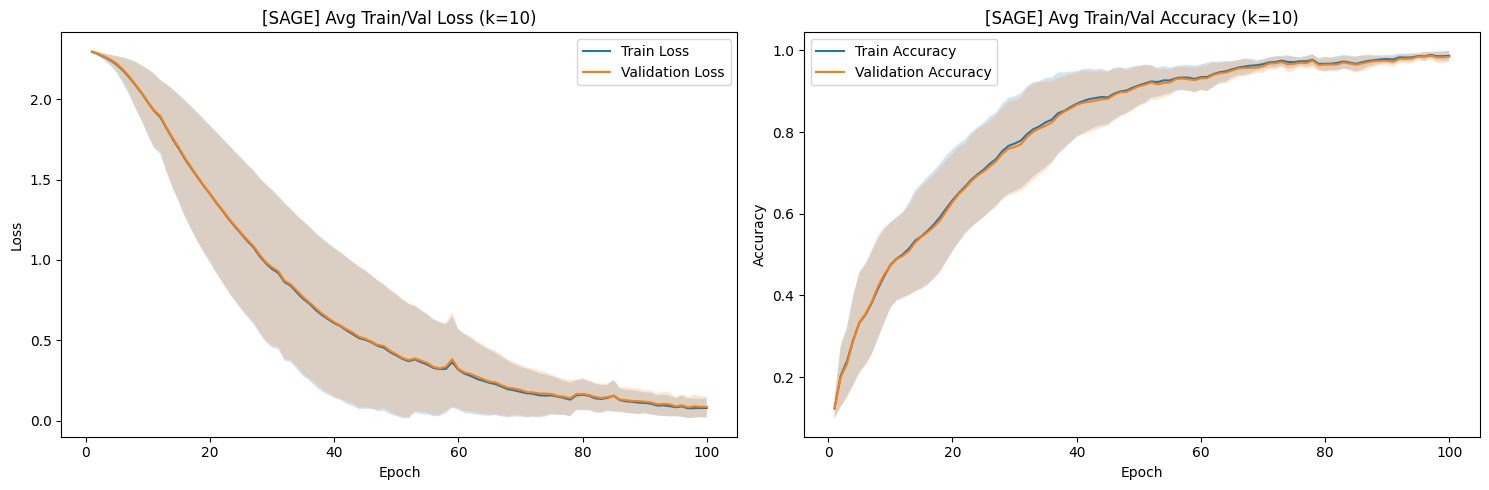

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_15_GCN
Using existing processed data for k_15_GCN
Starting k-fold cross-validation for GCN...

--- Fold 1/10 ---
Epoch 010, Train Loss: 2.2768, Train Acc: 0.1787, Val Loss: 2.2778, Val Acc: 0.1692
Epoch 020, Train Loss: 2.1991, Train Acc: 0.2056, Val Loss: 2.2016, Val Acc: 0.2065


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.0493, Train Acc: 0.2748, Val Loss: 2.0526, Val Acc: 0.2600
Epoch 040, Train Loss: 1.8011, Train Acc: 0.5285, Val Loss: 1.8096, Val Acc: 0.5236
Epoch 050, Train Loss: 1.4230, Train Acc: 0.7516, Val Loss: 1.4351, Val Acc: 0.7475
Epoch 060, Train Loss: 0.9331, Train Acc: 0.9224, Val Loss: 0.9515, Val Acc: 0.9192
Epoch 070, Train Loss: 0.5452, Train Acc: 0.9756, Val Loss: 0.5628, Val Acc: 0.9751
Epoch 080, Train Loss: 0.3425, Train Acc: 0.9768, Val Loss: 0.3560, Val Acc: 0.9801


[I 2025-01-26 16:50:28,470] Trial 0 finished with value: 0.18499182164669037 and parameters: {'hidden_channels': 63, 'dropout': 0.4580853223682649, 'lr': 0.0006544675826576418}. Best is trial 0 with value: 0.18499182164669037.


Epoch 090, Train Loss: 0.2299, Train Acc: 0.9918, Val Loss: 0.2420, Val Acc: 0.9938
Epoch 100, Train Loss: 0.1721, Train Acc: 0.9900, Val Loss: 0.1850, Val Acc: 0.9851
Epoch 010, Train Loss: 2.2431, Train Acc: 0.2294, Val Loss: 2.2497, Val Acc: 0.2326


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0773, Train Acc: 0.3728, Val Loss: 2.0845, Val Acc: 0.3831
Epoch 030, Train Loss: 1.7836, Train Acc: 0.6608, Val Loss: 1.7879, Val Acc: 0.6592
Epoch 040, Train Loss: 1.3870, Train Acc: 0.7906, Val Loss: 1.3929, Val Acc: 0.7774
Epoch 050, Train Loss: 0.8407, Train Acc: 0.9145, Val Loss: 0.8543, Val Acc: 0.9042
Epoch 060, Train Loss: 0.5220, Train Acc: 0.9465, Val Loss: 0.5374, Val Acc: 0.9440
Epoch 070, Train Loss: 0.2782, Train Acc: 0.9888, Val Loss: 0.2907, Val Acc: 0.9851


[I 2025-01-26 16:50:29,232] Trial 1 finished with value: 0.15137235820293427 and parameters: {'hidden_channels': 38, 'dropout': 0.2825994732427694, 'lr': 0.0020243543978463573}. Best is trial 1 with value: 0.15137235820293427.


Epoch 080, Train Loss: 0.2049, Train Acc: 0.9899, Val Loss: 0.2171, Val Acc: 0.9863
Epoch 090, Train Loss: 0.1628, Train Acc: 0.9784, Val Loss: 0.1777, Val Acc: 0.9739
Epoch 100, Train Loss: 0.1357, Train Acc: 0.9843, Val Loss: 0.1514, Val Acc: 0.9789


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2933, Train Acc: 0.1569, Val Loss: 2.2935, Val Acc: 0.1493
Epoch 020, Train Loss: 2.2683, Train Acc: 0.1515, Val Loss: 2.2701, Val Acc: 0.1517
Epoch 030, Train Loss: 2.1911, Train Acc: 0.1498, Val Loss: 2.1940, Val Acc: 0.1480
Epoch 040, Train Loss: 2.0178, Train Acc: 0.2795, Val Loss: 2.0229, Val Acc: 0.2724
Epoch 050, Train Loss: 1.7002, Train Acc: 0.5634, Val Loss: 1.7111, Val Acc: 0.5622
Epoch 060, Train Loss: 1.2416, Train Acc: 0.8437, Val Loss: 1.2520, Val Acc: 0.8445
Epoch 070, Train Loss: 0.8062, Train Acc: 0.9190, Val Loss: 0.8198, Val Acc: 0.9129
Epoch 080, Train Loss: 0.5412, Train Acc: 0.9639, Val Loss: 0.5535, Val Acc: 0.9565
Epoch 090, Train Loss: 0.3830, Train Acc: 0.9714, Val Loss: 0.3961, Val Acc: 0.9664


[I 2025-01-26 16:50:30,103] Trial 2 finished with value: 0.31699320673942566 and parameters: {'hidden_channels': 52, 'dropout': 0.4501757235046661, 'lr': 0.0005737811724086493}. Best is trial 1 with value: 0.15137235820293427.


Epoch 100, Train Loss: 0.3020, Train Acc: 0.9851, Val Loss: 0.3170, Val Acc: 0.9838
Epoch 010, Train Loss: 2.3032, Train Acc: 0.1417, Val Loss: 2.3011, Val Acc: 0.1555
Epoch 020, Train Loss: 2.2906, Train Acc: 0.1582, Val Loss: 2.2882, Val Acc: 0.1642
Epoch 030, Train Loss: 2.2432, Train Acc: 0.2442, Val Loss: 2.2413, Val Acc: 0.2649


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 040, Train Loss: 2.1709, Train Acc: 0.2719, Val Loss: 2.1736, Val Acc: 0.2761
Epoch 050, Train Loss: 2.0475, Train Acc: 0.3546, Val Loss: 2.0608, Val Acc: 0.3433
Epoch 060, Train Loss: 1.8720, Train Acc: 0.5418, Val Loss: 1.8865, Val Acc: 0.5261
Epoch 070, Train Loss: 1.6400, Train Acc: 0.7527, Val Loss: 1.6478, Val Acc: 0.7388


[I 2025-01-26 16:50:30,684] Trial 3 finished with value: 1.115480661392212 and parameters: {'hidden_channels': 25, 'dropout': 0.2690540190120573, 'lr': 0.0002468720730137791}. Best is trial 1 with value: 0.15137235820293427.


Epoch 080, Train Loss: 1.4175, Train Acc: 0.7874, Val Loss: 1.4245, Val Acc: 0.7724
Epoch 090, Train Loss: 1.2235, Train Acc: 0.8123, Val Loss: 1.2435, Val Acc: 0.7973
Epoch 100, Train Loss: 1.0930, Train Acc: 0.8415, Val Loss: 1.1155, Val Acc: 0.8284
Epoch 010, Train Loss: 2.3129, Train Acc: 0.1471, Val Loss: 2.3117, Val Acc: 0.1356


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:30,805] Trial 4 finished with value: 2.3105340003967285 and parameters: {'hidden_channels': 21, 'dropout': 0.29447897436026277, 'lr': 0.00011178729223653021}. Best is trial 1 with value: 0.15137235820293427.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3142, Train Acc: 0.1305, Val Loss: 2.3118, Val Acc: 0.1194
Early stopping at epoch 21
  Fold 1 - Optuna Best Trial Val Loss: 0.1514
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 38, 'dropout': 0.2825994732427694, 'lr': 0.0020243543978463573}
Epoch 010, Train Loss: 2.2422, Train Acc: 0.1333, Val Loss: 2.2489, Val Acc: 0.1194
Epoch 020, Train Loss: 2.1287, Train Acc: 0.2246, Val Loss: 2.1409, Val Acc: 0.2090
Epoch 030, Train Loss: 1.9039, Train Acc: 0.2442, Val Loss: 1.9174, Val Acc: 0.2363
Epoch 040, Train Loss: 1.5374, Train Acc: 0.3668, Val Loss: 1.5499, Val Acc: 0.3731
Epoch 050, Train Loss: 1.0006, Train Acc: 0.7626, Val Loss: 1.0187, Val Acc: 0.7525
Epoch 060, Train Loss: 0.5446, Train Acc: 0.9277, Val Loss: 0.5686, Val Acc: 0.9229
Epoch 070, Train Loss: 0.3295, Train Acc: 0.9686, Val Loss: 0.3502, Val Acc: 0.9639
Epoch 080, Train Loss: 0.2065, Train Acc: 0.9879, Val Loss: 0.2144, Val Acc: 0.9900


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1286, Train Acc: 0.9885, Val Loss: 0.1356, Val Acc: 0.9913
Epoch 100, Train Loss: 0.1050, Train Acc: 0.9928, Val Loss: 0.1164, Val Acc: 0.9888
  Fold 1 Test Metrics:
  Accuracy: 0.9913
  Precision: 0.9920
  Recall: 0.9913
  F1: 0.9913

--- Fold 2/10 ---
Epoch 010, Train Loss: 2.1355, Train Acc: 0.3596, Val Loss: 2.1283, Val Acc: 0.3731


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7164, Train Acc: 0.6195, Val Loss: 1.7113, Val Acc: 0.5920
Epoch 030, Train Loss: 1.1333, Train Acc: 0.8079, Val Loss: 1.1358, Val Acc: 0.8035
Epoch 040, Train Loss: 0.6021, Train Acc: 0.9190, Val Loss: 0.6154, Val Acc: 0.9142
Epoch 050, Train Loss: 0.2853, Train Acc: 0.9648, Val Loss: 0.3081, Val Acc: 0.9590
Epoch 060, Train Loss: 0.1950, Train Acc: 0.9725, Val Loss: 0.2573, Val Acc: 0.9602
Epoch 070, Train Loss: 0.0963, Train Acc: 0.9921, Val Loss: 0.1167, Val Acc: 0.9913


[I 2025-01-26 16:50:32,450] Trial 0 finished with value: 0.051060665398836136 and parameters: {'hidden_channels': 55, 'dropout': 0.2911497361688647, 'lr': 0.004135618784653531}. Best is trial 0 with value: 0.051060665398836136.


Epoch 080, Train Loss: 0.0781, Train Acc: 0.9939, Val Loss: 0.0966, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0524, Train Acc: 0.9964, Val Loss: 0.0686, Val Acc: 0.9925
Epoch 100, Train Loss: 0.0418, Train Acc: 0.9988, Val Loss: 0.0511, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2920, Train Acc: 0.1167, Val Loss: 2.2875, Val Acc: 0.1219
Epoch 020, Train Loss: 2.2650, Train Acc: 0.1307, Val Loss: 2.2602, Val Acc: 0.1343
Epoch 030, Train Loss: 2.2013, Train Acc: 0.1643, Val Loss: 2.1999, Val Acc: 0.1567
Epoch 040, Train Loss: 2.0459, Train Acc: 0.2313, Val Loss: 2.0440, Val Acc: 0.2164
Epoch 050, Train Loss: 1.8103, Train Acc: 0.5169, Val Loss: 1.8092, Val Acc: 0.5025
Epoch 060, Train Loss: 1.5092, Train Acc: 0.7620, Val Loss: 1.5091, Val Acc: 0.7624
Epoch 070, Train Loss: 1.2315, Train Acc: 0.8693, Val Loss: 1.2345, Val Acc: 0.8769
Epoch 080, Train Loss: 1.0188, Train Acc: 0.9084, Val Loss: 1.0232, Val Acc: 0.9129


[I 2025-01-26 16:50:32,977] Trial 1 finished with value: 0.7689599394798279 and parameters: {'hidden_channels': 18, 'dropout': 0.2866280921922297, 'lr': 0.0008077655538926945}. Best is trial 0 with value: 0.051060665398836136.


Epoch 090, Train Loss: 0.8700, Train Acc: 0.9320, Val Loss: 0.8760, Val Acc: 0.9366
Epoch 100, Train Loss: 0.7631, Train Acc: 0.9333, Val Loss: 0.7690, Val Acc: 0.9341
Epoch 010, Train Loss: 2.2937, Train Acc: 0.0972, Val Loss: 2.2962, Val Acc: 0.0908
Epoch 020, Train Loss: 2.2629, Train Acc: 0.2296, Val Loss: 2.2680, Val Acc: 0.2226


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1933, Train Acc: 0.2464, Val Loss: 2.1976, Val Acc: 0.2413
Epoch 040, Train Loss: 2.0187, Train Acc: 0.3234, Val Loss: 2.0218, Val Acc: 0.3172
Epoch 050, Train Loss: 1.7573, Train Acc: 0.5657, Val Loss: 1.7637, Val Acc: 0.5373
Epoch 060, Train Loss: 1.4374, Train Acc: 0.7609, Val Loss: 1.4503, Val Acc: 0.7351


[I 2025-01-26 16:50:33,572] Trial 2 finished with value: 0.5894896388053894 and parameters: {'hidden_channels': 24, 'dropout': 0.43004421573983953, 'lr': 0.0010042622016803826}. Best is trial 0 with value: 0.051060665398836136.


Epoch 070, Train Loss: 1.1041, Train Acc: 0.9054, Val Loss: 1.1233, Val Acc: 0.8930
Epoch 080, Train Loss: 0.8389, Train Acc: 0.9340, Val Loss: 0.8505, Val Acc: 0.9341
Epoch 090, Train Loss: 0.6854, Train Acc: 0.9487, Val Loss: 0.7051, Val Acc: 0.9577
Epoch 100, Train Loss: 0.5670, Train Acc: 0.9585, Val Loss: 0.5895, Val Acc: 0.9664


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8551, Train Acc: 0.6601, Val Loss: 1.8752, Val Acc: 0.6480
Epoch 020, Train Loss: 1.0431, Train Acc: 0.7720, Val Loss: 1.0354, Val Acc: 0.7537
Epoch 030, Train Loss: 0.4847, Train Acc: 0.9043, Val Loss: 0.4970, Val Acc: 0.8905
Epoch 040, Train Loss: 0.2517, Train Acc: 0.9468, Val Loss: 0.2852, Val Acc: 0.9428
Epoch 050, Train Loss: 0.1575, Train Acc: 0.9652, Val Loss: 0.1968, Val Acc: 0.9590
Epoch 060, Train Loss: 0.1873, Train Acc: 0.9561, Val Loss: 0.2109, Val Acc: 0.9440
Epoch 070, Train Loss: 0.1549, Train Acc: 0.9560, Val Loss: 0.2169, Val Acc: 0.9478
Epoch 080, Train Loss: 0.1397, Train Acc: 0.9715, Val Loss: 0.2027, Val Acc: 0.9590
Epoch 090, Train Loss: 0.0397, Train Acc: 0.9967, Val Loss: 0.0465, Val Acc: 0.9925


[I 2025-01-26 16:50:34,386] Trial 3 finished with value: 0.02549608424305916 and parameters: {'hidden_channels': 47, 'dropout': 0.3808139571734229, 'lr': 0.009886726862145305}. Best is trial 3 with value: 0.02549608424305916.


Epoch 100, Train Loss: 0.0257, Train Acc: 0.9981, Val Loss: 0.0255, Val Acc: 0.9975
Epoch 010, Train Loss: 2.2953, Train Acc: 0.1106, Val Loss: 2.2874, Val Acc: 0.1107
Epoch 020, Train Loss: 2.2597, Train Acc: 0.1279, Val Loss: 2.2470, Val Acc: 0.1244


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1573, Train Acc: 0.2366, Val Loss: 2.1521, Val Acc: 0.2388
Epoch 040, Train Loss: 1.9593, Train Acc: 0.4601, Val Loss: 1.9614, Val Acc: 0.4540
Epoch 050, Train Loss: 1.6843, Train Acc: 0.6786, Val Loss: 1.6949, Val Acc: 0.6766
Epoch 060, Train Loss: 1.3143, Train Acc: 0.8639, Val Loss: 1.3282, Val Acc: 0.8595
Epoch 070, Train Loss: 0.9245, Train Acc: 0.9154, Val Loss: 0.9432, Val Acc: 0.9129
Epoch 080, Train Loss: 0.6573, Train Acc: 0.9230, Val Loss: 0.6813, Val Acc: 0.9129


[I 2025-01-26 16:50:35,109] Trial 4 finished with value: 0.41212785243988037 and parameters: {'hidden_channels': 36, 'dropout': 0.2842652029473553, 'lr': 0.0006568472196606931}. Best is trial 3 with value: 0.02549608424305916.


Epoch 090, Train Loss: 0.4871, Train Acc: 0.9538, Val Loss: 0.5075, Val Acc: 0.9540
Epoch 100, Train Loss: 0.3971, Train Acc: 0.9613, Val Loss: 0.4121, Val Acc: 0.9602
  Fold 2 - Optuna Best Trial Val Loss: 0.0255
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 47, 'dropout': 0.3808139571734229, 'lr': 0.009886726862145305}
Epoch 010, Train Loss: 1.8650, Train Acc: 0.6295, Val Loss: 1.8565, Val Acc: 0.6206


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 0.9243, Train Acc: 0.8357, Val Loss: 0.9362, Val Acc: 0.8184
Epoch 030, Train Loss: 0.4281, Train Acc: 0.9288, Val Loss: 0.4521, Val Acc: 0.9266
Epoch 040, Train Loss: 0.2600, Train Acc: 0.9382, Val Loss: 0.2906, Val Acc: 0.9341
Epoch 050, Train Loss: 0.2160, Train Acc: 0.9449, Val Loss: 0.2377, Val Acc: 0.9303
Epoch 060, Train Loss: 0.1589, Train Acc: 0.9613, Val Loss: 0.1984, Val Acc: 0.9440
Epoch 070, Train Loss: 0.0918, Train Acc: 0.9801, Val Loss: 0.1194, Val Acc: 0.9776


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.0508, Train Acc: 0.9939, Val Loss: 0.0597, Val Acc: 0.9900
Epoch 090, Train Loss: 0.0407, Train Acc: 0.9913, Val Loss: 0.0410, Val Acc: 0.9938
Epoch 100, Train Loss: 0.0489, Train Acc: 0.9944, Val Loss: 0.0814, Val Acc: 0.9913
  Fold 2 Test Metrics:
  Accuracy: 0.9938
  Precision: 0.9940
  Recall: 0.9938
  F1: 0.9938

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3046, Train Acc: 0.0989, Val Loss: 2.2999, Val Acc: 0.1020
Epoch 020, Train Loss: 2.2799, Train Acc: 0.0989, Val Loss: 2.2704, Val Acc: 0.1020
Epoch 030, Train Loss: 2.1816, Train Acc: 0.1490, Val Loss: 2.1695, Val Acc: 0.1716
Epoch 040, Train Loss: 1.9803, Train Acc: 0.3355, Val Loss: 1.9706, Val Acc: 0.3520
Epoch 050, Train Loss: 1.5906, Train Acc: 0.7144, Val Loss: 1.5815, Val Acc: 0.7226
Epoch 060, Train Loss: 1.1402, Train Acc: 0.9022, Val Loss: 1.1274, Val Acc: 0.9080
Epoch 070, Train Loss: 0.7894, Train Acc: 0.9502, Val Loss: 0.7852, Val Acc: 0.9490
Epoch 080, Train Loss: 0.5645, Train Acc: 0.9641, Val Loss: 0.5585, Val Acc: 0.9677
Epoch 090, Train Loss: 0.4397, Train Acc: 0.9714, Val Loss: 0.4348, Val Acc: 0.9789


[I 2025-01-26 16:50:36,716] Trial 0 finished with value: 0.3434651792049408 and parameters: {'hidden_channels': 40, 'dropout': 0.4707388087693619, 'lr': 0.0006796820837761655}. Best is trial 0 with value: 0.3434651792049408.


Epoch 100, Train Loss: 0.3497, Train Acc: 0.9787, Val Loss: 0.3435, Val Acc: 0.9838
Epoch 010, Train Loss: 2.2188, Train Acc: 0.2080, Val Loss: 2.2284, Val Acc: 0.2114
Epoch 020, Train Loss: 1.9661, Train Acc: 0.4057, Val Loss: 1.9787, Val Acc: 0.3893


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.5728, Train Acc: 0.6723, Val Loss: 1.5786, Val Acc: 0.6542
Epoch 040, Train Loss: 1.0377, Train Acc: 0.8521, Val Loss: 1.0289, Val Acc: 0.8619
Epoch 050, Train Loss: 0.5594, Train Acc: 0.9488, Val Loss: 0.5559, Val Acc: 0.9515
Epoch 060, Train Loss: 0.2752, Train Acc: 0.9863, Val Loss: 0.2683, Val Acc: 0.9938
Epoch 070, Train Loss: 0.1505, Train Acc: 0.9919, Val Loss: 0.1441, Val Acc: 0.9950
Epoch 080, Train Loss: 0.1317, Train Acc: 0.9734, Val Loss: 0.1233, Val Acc: 0.9751


[I 2025-01-26 16:50:37,496] Trial 1 finished with value: 0.0578572154045105 and parameters: {'hidden_channels': 42, 'dropout': 0.26760038829337807, 'lr': 0.0031408430705410595}. Best is trial 1 with value: 0.0578572154045105.


Epoch 090, Train Loss: 0.1123, Train Acc: 0.9742, Val Loss: 0.1014, Val Acc: 0.9764
Epoch 100, Train Loss: 0.0593, Train Acc: 0.9952, Val Loss: 0.0579, Val Acc: 0.9963
Epoch 010, Train Loss: 2.3116, Train Acc: 0.1016, Val Loss: 2.3138, Val Acc: 0.1032
Epoch 020, Train Loss: 2.3125, Train Acc: 0.0893, Val Loss: 2.3159, Val Acc: 0.0908


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:37,622] Trial 2 finished with value: 2.3149938583374023 and parameters: {'hidden_channels': 25, 'dropout': 0.495151886295764, 'lr': 0.00017574220226452658}. Best is trial 1 with value: 0.0578572154045105.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 21
Epoch 010, Train Loss: 2.1779, Train Acc: 0.3414, Val Loss: 2.1779, Val Acc: 0.3246
Epoch 020, Train Loss: 1.8557, Train Acc: 0.6020, Val Loss: 1.8506, Val Acc: 0.6244
Epoch 030, Train Loss: 1.4224, Train Acc: 0.6788, Val Loss: 1.4209, Val Acc: 0.6978
Epoch 040, Train Loss: 0.9298, Train Acc: 0.8130, Val Loss: 0.9162, Val Acc: 0.8234
Epoch 050, Train Loss: 0.5092, Train Acc: 0.9302, Val Loss: 0.5139, Val Acc: 0.9328
Epoch 060, Train Loss: 0.2660, Train Acc: 0.9594, Val Loss: 0.2562, Val Acc: 0.9701
Epoch 070, Train Loss: 0.2034, Train Acc: 0.9715, Val Loss: 0.1714, Val Acc: 0.9863
Epoch 080, Train Loss: 0.1491, Train Acc: 0.9821, Val Loss: 0.1384, Val Acc: 0.9900


[I 2025-01-26 16:50:38,342] Trial 3 finished with value: 0.11306633800268173 and parameters: {'hidden_channels': 34, 'dropout': 0.4131984622212016, 'lr': 0.004042265878861133}. Best is trial 1 with value: 0.0578572154045105.


Epoch 090, Train Loss: 0.0709, Train Acc: 0.9958, Val Loss: 0.0665, Val Acc: 1.0000
Epoch 100, Train Loss: 0.1327, Train Acc: 0.9636, Val Loss: 0.1131, Val Acc: 0.9652
Epoch 010, Train Loss: 2.3112, Train Acc: 0.1000, Val Loss: 2.3097, Val Acc: 0.0995


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:38,536] Trial 4 finished with value: 2.311649799346924 and parameters: {'hidden_channels': 52, 'dropout': 0.29303723922921315, 'lr': 0.000239594020664362}. Best is trial 1 with value: 0.0578572154045105.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3148, Train Acc: 0.1000, Val Loss: 2.3123, Val Acc: 0.0995
Early stopping at epoch 21
  Fold 3 - Optuna Best Trial Val Loss: 0.0579
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 42, 'dropout': 0.26760038829337807, 'lr': 0.0031408430705410595}
Epoch 010, Train Loss: 2.1833, Train Acc: 0.3257, Val Loss: 2.1876, Val Acc: 0.3184
Epoch 020, Train Loss: 1.9174, Train Acc: 0.5219, Val Loss: 1.9194, Val Acc: 0.5211
Epoch 030, Train Loss: 1.4761, Train Acc: 0.7336, Val Loss: 1.4826, Val Acc: 0.7214
Epoch 040, Train Loss: 1.0069, Train Acc: 0.8829, Val Loss: 1.0116, Val Acc: 0.8706
Epoch 050, Train Loss: 0.5546, Train Acc: 0.9168, Val Loss: 0.5405, Val Acc: 0.9279
Epoch 060, Train Loss: 0.2882, Train Acc: 0.9611, Val Loss: 0.2777, Val Acc: 0.9701
Epoch 070, Train Loss: 0.1675, Train Acc: 0.9830, Val Loss: 0.1710, Val Acc: 0.9776
Epoch 080, Train Loss: 0.1159, Train Acc: 0.9896, Val Loss: 0.1174, Val Acc: 0.9913


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.1025, Train Acc: 0.9835, Val Loss: 0.0871, Val Acc: 0.9826
Epoch 100, Train Loss: 0.0868, Train Acc: 0.9890, Val Loss: 0.0879, Val Acc: 0.9888
  Fold 3 Test Metrics:
  Accuracy: 0.9900
  Precision: 0.9906
  Recall: 0.9900
  F1: 0.9901

--- Fold 4/10 ---
Epoch 010, Train Loss: 2.2330, Train Acc: 0.1008, Val Loss: 2.2323, Val Acc: 0.1007


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.0593, Train Acc: 0.2285, Val Loss: 2.0652, Val Acc: 0.2425
Epoch 030, Train Loss: 1.7022, Train Acc: 0.4767, Val Loss: 1.7078, Val Acc: 0.4826
Epoch 040, Train Loss: 1.2284, Train Acc: 0.7749, Val Loss: 1.2397, Val Acc: 0.7575
Epoch 050, Train Loss: 0.6904, Train Acc: 0.9087, Val Loss: 0.6937, Val Acc: 0.9055
Epoch 060, Train Loss: 0.4103, Train Acc: 0.9502, Val Loss: 0.4111, Val Acc: 0.9502
Epoch 070, Train Loss: 0.1914, Train Acc: 0.9829, Val Loss: 0.1949, Val Acc: 0.9813


[I 2025-01-26 16:50:40,081] Trial 0 finished with value: 0.10109158605337143 and parameters: {'hidden_channels': 37, 'dropout': 0.4568234330546546, 'lr': 0.002621435672943121}. Best is trial 0 with value: 0.10109158605337143.


Epoch 080, Train Loss: 0.1881, Train Acc: 0.9628, Val Loss: 0.2039, Val Acc: 0.9602
Epoch 090, Train Loss: 0.1261, Train Acc: 0.9918, Val Loss: 0.1293, Val Acc: 0.9888
Epoch 100, Train Loss: 0.1033, Train Acc: 0.9812, Val Loss: 0.1011, Val Acc: 0.9851


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:40,217] Trial 1 finished with value: 2.3276336193084717 and parameters: {'hidden_channels': 29, 'dropout': 0.3523303968975894, 'lr': 0.00011836143113943526}. Best is trial 0 with value: 0.10109158605337143.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3130, Train Acc: 0.1117, Val Loss: 2.3131, Val Acc: 0.1269
Epoch 020, Train Loss: 2.3239, Train Acc: 0.1061, Val Loss: 2.3270, Val Acc: 0.1119
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3044, Train Acc: 0.0826, Val Loss: 2.3049, Val Acc: 0.0846
Epoch 020, Train Loss: 2.2953, Train Acc: 0.1520, Val Loss: 2.2961, Val Acc: 0.1418
Epoch 030, Train Loss: 2.2421, Train Acc: 0.1353, Val Loss: 2.2423, Val Acc: 0.1281
Epoch 040, Train Loss: 2.1357, Train Acc: 0.2168, Val Loss: 2.1367, Val Acc: 0.2164
Epoch 050, Train Loss: 1.9410, Train Acc: 0.4211, Val Loss: 1.9426, Val Acc: 0.4540
Epoch 060, Train Loss: 1.6654, Train Acc: 0.6536, Val Loss: 1.6788, Val Acc: 0.6418
Epoch 070, Train Loss: 1.3772, Train Acc: 0.7950, Val Loss: 1.3925, Val Acc: 0.7960


[I 2025-01-26 16:50:40,978] Trial 2 finished with value: 0.8302303552627563 and parameters: {'hidden_channels': 38, 'dropout': 0.43654031107945845, 'lr': 0.00024190068990607194}. Best is trial 0 with value: 0.10109158605337143.


Epoch 080, Train Loss: 1.1051, Train Acc: 0.8664, Val Loss: 1.1221, Val Acc: 0.8557
Epoch 090, Train Loss: 0.9377, Train Acc: 0.8748, Val Loss: 0.9554, Val Acc: 0.8669
Epoch 100, Train Loss: 0.8136, Train Acc: 0.9134, Val Loss: 0.8302, Val Acc: 0.9154


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1446, Train Acc: 0.4590, Val Loss: 2.1472, Val Acc: 0.4714
Epoch 020, Train Loss: 1.7436, Train Acc: 0.6304, Val Loss: 1.7505, Val Acc: 0.6132
Epoch 030, Train Loss: 1.2154, Train Acc: 0.8093, Val Loss: 1.2263, Val Acc: 0.8072
Epoch 040, Train Loss: 0.6821, Train Acc: 0.9078, Val Loss: 0.7060, Val Acc: 0.9030
Epoch 050, Train Loss: 0.3146, Train Acc: 0.9776, Val Loss: 0.3254, Val Acc: 0.9776
Epoch 060, Train Loss: 0.1579, Train Acc: 0.9899, Val Loss: 0.1667, Val Acc: 0.9900
Epoch 070, Train Loss: 0.1000, Train Acc: 0.9949, Val Loss: 0.1084, Val Acc: 0.9938
Epoch 080, Train Loss: 0.0625, Train Acc: 0.9975, Val Loss: 0.0692, Val Acc: 0.9963
Epoch 090, Train Loss: 0.0602, Train Acc: 0.9921, Val Loss: 0.0714, Val Acc: 0.9913


[I 2025-01-26 16:50:41,864] Trial 3 finished with value: 0.05711222067475319 and parameters: {'hidden_channels': 53, 'dropout': 0.3467980217749468, 'lr': 0.0034164905269108196}. Best is trial 3 with value: 0.05711222067475319.


Epoch 100, Train Loss: 0.0539, Train Acc: 0.9840, Val Loss: 0.0571, Val Acc: 0.9813
Epoch 010, Train Loss: 2.2692, Train Acc: 0.1013, Val Loss: 2.2681, Val Acc: 0.0983
Epoch 020, Train Loss: 2.1826, Train Acc: 0.1666, Val Loss: 2.1894, Val Acc: 0.1766


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.0185, Train Acc: 0.2039, Val Loss: 2.0254, Val Acc: 0.2040
Epoch 040, Train Loss: 1.7009, Train Acc: 0.4372, Val Loss: 1.7097, Val Acc: 0.4341
Epoch 050, Train Loss: 1.2505, Train Acc: 0.7881, Val Loss: 1.2750, Val Acc: 0.7674
Epoch 060, Train Loss: 0.7808, Train Acc: 0.9169, Val Loss: 0.8114, Val Acc: 0.9005
Epoch 070, Train Loss: 0.4615, Train Acc: 0.9610, Val Loss: 0.4858, Val Acc: 0.9478
Epoch 080, Train Loss: 0.2939, Train Acc: 0.9838, Val Loss: 0.3132, Val Acc: 0.9826


[I 2025-01-26 16:50:42,670] Trial 4 finished with value: 0.18644000589847565 and parameters: {'hidden_channels': 46, 'dropout': 0.3694718352969939, 'lr': 0.001148972241894982}. Best is trial 3 with value: 0.05711222067475319.


Epoch 090, Train Loss: 0.1948, Train Acc: 0.9961, Val Loss: 0.2013, Val Acc: 0.9950
Epoch 100, Train Loss: 0.1728, Train Acc: 0.9832, Val Loss: 0.1864, Val Acc: 0.9838
  Fold 4 - Optuna Best Trial Val Loss: 0.0571
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 53, 'dropout': 0.3467980217749468, 'lr': 0.0034164905269108196}
Epoch 010, Train Loss: 2.1609, Train Acc: 0.2935, Val Loss: 2.1625, Val Acc: 0.2687


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.8768, Train Acc: 0.4772, Val Loss: 1.8913, Val Acc: 0.4577
Epoch 030, Train Loss: 1.4136, Train Acc: 0.6132, Val Loss: 1.4297, Val Acc: 0.6057
Epoch 040, Train Loss: 0.8231, Train Acc: 0.8746, Val Loss: 0.8414, Val Acc: 0.8595
Epoch 050, Train Loss: 0.3902, Train Acc: 0.9519, Val Loss: 0.4038, Val Acc: 0.9502
Epoch 060, Train Loss: 0.1685, Train Acc: 0.9785, Val Loss: 0.1779, Val Acc: 0.9776
Epoch 070, Train Loss: 0.0908, Train Acc: 0.9972, Val Loss: 0.0972, Val Acc: 0.9938


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.0734, Train Acc: 0.9824, Val Loss: 0.0849, Val Acc: 0.9751
Epoch 090, Train Loss: 0.0776, Train Acc: 0.9877, Val Loss: 0.0992, Val Acc: 0.9838
Epoch 100, Train Loss: 0.0591, Train Acc: 0.9835, Val Loss: 0.0671, Val Acc: 0.9826
  Fold 4 Test Metrics:
  Accuracy: 0.9863
  Precision: 0.9872
  Recall: 0.9863
  F1: 0.9863

--- Fold 5/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1118, Train Acc: 0.4923, Val Loss: 2.1050, Val Acc: 0.4950
Epoch 020, Train Loss: 1.5727, Train Acc: 0.6979, Val Loss: 1.5667, Val Acc: 0.6928
Epoch 030, Train Loss: 0.8928, Train Acc: 0.8532, Val Loss: 0.9130, Val Acc: 0.8296
Epoch 040, Train Loss: 0.4653, Train Acc: 0.9325, Val Loss: 0.4856, Val Acc: 0.9303
Epoch 050, Train Loss: 0.2822, Train Acc: 0.9292, Val Loss: 0.3068, Val Acc: 0.9192
Epoch 060, Train Loss: 0.1262, Train Acc: 0.9776, Val Loss: 0.1359, Val Acc: 0.9789
Epoch 070, Train Loss: 0.0975, Train Acc: 0.9796, Val Loss: 0.0691, Val Acc: 0.9963
Epoch 080, Train Loss: 0.1039, Train Acc: 0.9746, Val Loss: 0.1073, Val Acc: 0.9714
Epoch 090, Train Loss: 0.0599, Train Acc: 0.9932, Val Loss: 0.0687, Val Acc: 0.9950


[I 2025-01-26 16:50:44,345] Trial 0 finished with value: 0.04435376822948456 and parameters: {'hidden_channels': 40, 'dropout': 0.42199551879419095, 'lr': 0.006226618607923326}. Best is trial 0 with value: 0.04435376822948456.


Epoch 100, Train Loss: 0.0398, Train Acc: 0.9941, Val Loss: 0.0444, Val Acc: 0.9888
Epoch 010, Train Loss: 2.1556, Train Acc: 0.3697, Val Loss: 2.1481, Val Acc: 0.3769
Epoch 020, Train Loss: 1.8163, Train Acc: 0.5866, Val Loss: 1.8114, Val Acc: 0.5746


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.2979, Train Acc: 0.7704, Val Loss: 1.3075, Val Acc: 0.7799
Epoch 040, Train Loss: 0.8318, Train Acc: 0.8389, Val Loss: 0.8448, Val Acc: 0.8632
Epoch 050, Train Loss: 0.4031, Train Acc: 0.9543, Val Loss: 0.4060, Val Acc: 0.9552
Epoch 060, Train Loss: 0.2132, Train Acc: 0.9729, Val Loss: 0.2195, Val Acc: 0.9689
Epoch 070, Train Loss: 0.1385, Train Acc: 0.9793, Val Loss: 0.1379, Val Acc: 0.9789
Epoch 080, Train Loss: 0.0840, Train Acc: 0.9938, Val Loss: 0.0740, Val Acc: 0.9975


[I 2025-01-26 16:50:45,306] Trial 1 finished with value: 0.04971041902899742 and parameters: {'hidden_channels': 61, 'dropout': 0.4451278792490019, 'lr': 0.0031523281230562564}. Best is trial 0 with value: 0.04435376822948456.


Epoch 090, Train Loss: 0.0781, Train Acc: 0.9894, Val Loss: 0.0585, Val Acc: 0.9938
Epoch 100, Train Loss: 0.0472, Train Acc: 0.9988, Val Loss: 0.0497, Val Acc: 0.9975
Epoch 010, Train Loss: 2.2526, Train Acc: 0.1289, Val Loss: 2.2564, Val Acc: 0.1231


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.1463, Train Acc: 0.1744, Val Loss: 2.1499, Val Acc: 0.1729
Epoch 030, Train Loss: 1.9472, Train Acc: 0.3380, Val Loss: 1.9503, Val Acc: 0.3420
Epoch 040, Train Loss: 1.6039, Train Acc: 0.4999, Val Loss: 1.6126, Val Acc: 0.4776
Epoch 050, Train Loss: 1.1744, Train Acc: 0.7709, Val Loss: 1.1772, Val Acc: 0.7898
Epoch 060, Train Loss: 0.7197, Train Acc: 0.9330, Val Loss: 0.7267, Val Acc: 0.9328
Epoch 070, Train Loss: 0.4760, Train Acc: 0.9583, Val Loss: 0.4850, Val Acc: 0.9565


[I 2025-01-26 16:50:46,028] Trial 2 finished with value: 0.19646930694580078 and parameters: {'hidden_channels': 33, 'dropout': 0.40976756557938127, 'lr': 0.0016134491526887814}. Best is trial 0 with value: 0.04435376822948456.


Epoch 080, Train Loss: 0.3041, Train Acc: 0.9754, Val Loss: 0.3050, Val Acc: 0.9751
Epoch 090, Train Loss: 0.2414, Train Acc: 0.9759, Val Loss: 0.2437, Val Acc: 0.9726
Epoch 100, Train Loss: 0.1861, Train Acc: 0.9787, Val Loss: 0.1965, Val Acc: 0.9751


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1596, Train Acc: 0.2372, Val Loss: 2.1628, Val Acc: 0.2214
Epoch 020, Train Loss: 1.8077, Train Acc: 0.4442, Val Loss: 1.8224, Val Acc: 0.4030
Epoch 030, Train Loss: 1.2541, Train Acc: 0.7888, Val Loss: 1.2854, Val Acc: 0.7699
Epoch 040, Train Loss: 0.6986, Train Acc: 0.9029, Val Loss: 0.7262, Val Acc: 0.8881
Epoch 050, Train Loss: 0.3687, Train Acc: 0.9470, Val Loss: 0.3691, Val Acc: 0.9527
Epoch 060, Train Loss: 0.2045, Train Acc: 0.9792, Val Loss: 0.2050, Val Acc: 0.9739
Epoch 070, Train Loss: 0.1379, Train Acc: 0.9788, Val Loss: 0.1382, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0962, Train Acc: 0.9863, Val Loss: 0.0989, Val Acc: 0.9876
Epoch 090, Train Loss: 0.0970, Train Acc: 0.9826, Val Loss: 0.0759, Val Acc: 0.9876


[I 2025-01-26 16:50:46,752] Trial 3 finished with value: 0.06353531032800674 and parameters: {'hidden_channels': 34, 'dropout': 0.2880496262519179, 'lr': 0.004387781369954123}. Best is trial 0 with value: 0.04435376822948456.


Epoch 100, Train Loss: 0.0609, Train Acc: 0.9966, Val Loss: 0.0635, Val Acc: 0.9963
Epoch 010, Train Loss: 2.2918, Train Acc: 0.1134, Val Loss: 2.2976, Val Acc: 0.1070
Epoch 020, Train Loss: 2.2636, Train Acc: 0.1101, Val Loss: 2.2762, Val Acc: 0.1045


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1903, Train Acc: 0.1394, Val Loss: 2.2057, Val Acc: 0.1318
Epoch 040, Train Loss: 2.0341, Train Acc: 0.3122, Val Loss: 2.0519, Val Acc: 0.2811
Epoch 050, Train Loss: 1.7482, Train Acc: 0.6636, Val Loss: 1.7666, Val Acc: 0.6480
Epoch 060, Train Loss: 1.3484, Train Acc: 0.8435, Val Loss: 1.3572, Val Acc: 0.8470
Epoch 070, Train Loss: 0.9902, Train Acc: 0.8935, Val Loss: 0.9971, Val Acc: 0.8930
Epoch 080, Train Loss: 0.7131, Train Acc: 0.9202, Val Loss: 0.7146, Val Acc: 0.9279


[I 2025-01-26 16:50:47,503] Trial 4 finished with value: 0.45207372307777405 and parameters: {'hidden_channels': 38, 'dropout': 0.45650981544504604, 'lr': 0.00055360547297202}. Best is trial 0 with value: 0.04435376822948456.


Epoch 090, Train Loss: 0.5506, Train Acc: 0.9401, Val Loss: 0.5578, Val Acc: 0.9266
Epoch 100, Train Loss: 0.4579, Train Acc: 0.9412, Val Loss: 0.4521, Val Acc: 0.9403
  Fold 5 - Optuna Best Trial Val Loss: 0.0444
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 40, 'dropout': 0.42199551879419095, 'lr': 0.006226618607923326}
Epoch 010, Train Loss: 2.1070, Train Acc: 0.4380, Val Loss: 2.1148, Val Acc: 0.4291


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.5768, Train Acc: 0.6584, Val Loss: 1.5829, Val Acc: 0.6530
Epoch 030, Train Loss: 0.9369, Train Acc: 0.8252, Val Loss: 0.9582, Val Acc: 0.8184
Epoch 040, Train Loss: 0.4938, Train Acc: 0.9180, Val Loss: 0.4976, Val Acc: 0.9241
Epoch 050, Train Loss: 0.2484, Train Acc: 0.9653, Val Loss: 0.2636, Val Acc: 0.9627
Epoch 060, Train Loss: 0.1546, Train Acc: 0.9798, Val Loss: 0.1502, Val Acc: 0.9776
Epoch 070, Train Loss: 0.1438, Train Acc: 0.9670, Val Loss: 0.1268, Val Acc: 0.9627


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.1070, Train Acc: 0.9720, Val Loss: 0.1111, Val Acc: 0.9664
Epoch 090, Train Loss: 0.0803, Train Acc: 0.9835, Val Loss: 0.0820, Val Acc: 0.9801
Epoch 100, Train Loss: 0.0904, Train Acc: 0.9781, Val Loss: 0.1108, Val Acc: 0.9764
  Fold 5 Test Metrics:
  Accuracy: 0.9776
  Precision: 0.9812
  Recall: 0.9776
  F1: 0.9781

--- Fold 6/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:48,403] Trial 0 finished with value: 2.3258321285247803 and parameters: {'hidden_channels': 23, 'dropout': 0.387339161846759, 'lr': 0.0002064166537517977}. Best is trial 0 with value: 2.3258321285247803.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3183, Train Acc: 0.1003, Val Loss: 2.3192, Val Acc: 0.1007
Epoch 020, Train Loss: 2.3227, Train Acc: 0.1072, Val Loss: 2.3264, Val Acc: 0.1045
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2320, Train Acc: 0.0989, Val Loss: 2.2358, Val Acc: 0.0983
Epoch 020, Train Loss: 2.0578, Train Acc: 0.1865, Val Loss: 2.0708, Val Acc: 0.1716
Epoch 030, Train Loss: 1.7267, Train Acc: 0.4052, Val Loss: 1.7475, Val Acc: 0.3794
Epoch 040, Train Loss: 1.2764, Train Acc: 0.6942, Val Loss: 1.3062, Val Acc: 0.6791
Epoch 050, Train Loss: 0.7368, Train Acc: 0.9270, Val Loss: 0.7546, Val Acc: 0.9042
Epoch 060, Train Loss: 0.3722, Train Acc: 0.9818, Val Loss: 0.3772, Val Acc: 0.9813
Epoch 070, Train Loss: 0.2201, Train Acc: 0.9678, Val Loss: 0.2306, Val Acc: 0.9614


[I 2025-01-26 16:50:49,315] Trial 1 finished with value: 0.08809308707714081 and parameters: {'hidden_channels': 57, 'dropout': 0.3232986154341719, 'lr': 0.001726518818874885}. Best is trial 1 with value: 0.08809308707714081.


Epoch 080, Train Loss: 0.1214, Train Acc: 0.9966, Val Loss: 0.1295, Val Acc: 0.9938
Epoch 090, Train Loss: 0.0927, Train Acc: 0.9863, Val Loss: 0.1026, Val Acc: 0.9776
Epoch 100, Train Loss: 0.0687, Train Acc: 0.9938, Val Loss: 0.0881, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3096, Train Acc: 0.1036, Val Loss: 2.3145, Val Acc: 0.1020
Epoch 020, Train Loss: 2.3016, Train Acc: 0.1014, Val Loss: 2.3023, Val Acc: 0.1020
Epoch 030, Train Loss: 2.2404, Train Acc: 0.1034, Val Loss: 2.2428, Val Acc: 0.0970
Epoch 040, Train Loss: 2.0651, Train Acc: 0.1610, Val Loss: 2.0677, Val Acc: 0.1592
Epoch 050, Train Loss: 1.7658, Train Acc: 0.4010, Val Loss: 1.7670, Val Acc: 0.3980
Epoch 060, Train Loss: 1.3308, Train Acc: 0.7891, Val Loss: 1.3365, Val Acc: 0.7774
Epoch 070, Train Loss: 0.9182, Train Acc: 0.9148, Val Loss: 0.9249, Val Acc: 0.9030
Epoch 080, Train Loss: 0.6491, Train Acc: 0.9403, Val Loss: 0.6591, Val Acc: 0.9328
Epoch 090, Train Loss: 0.4901, Train Acc: 0.9578, Val Loss: 0.4965, Val Acc: 0.9552


[I 2025-01-26 16:50:50,164] Trial 2 finished with value: 0.4096919298171997 and parameters: {'hidden_channels': 47, 'dropout': 0.3555881566346195, 'lr': 0.000431815299045579}. Best is trial 1 with value: 0.08809308707714081.


Epoch 100, Train Loss: 0.4037, Train Acc: 0.9697, Val Loss: 0.4097, Val Acc: 0.9639
Epoch 010, Train Loss: 2.2847, Train Acc: 0.0995, Val Loss: 2.2894, Val Acc: 0.0995
Epoch 020, Train Loss: 2.2523, Train Acc: 0.1142, Val Loss: 2.2584, Val Acc: 0.1107


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1564, Train Acc: 0.2111, Val Loss: 2.1609, Val Acc: 0.2139
Epoch 040, Train Loss: 1.9188, Train Acc: 0.4842, Val Loss: 1.9159, Val Acc: 0.4876
Epoch 050, Train Loss: 1.5083, Train Acc: 0.7188, Val Loss: 1.5053, Val Acc: 0.7127
Epoch 060, Train Loss: 1.0164, Train Acc: 0.8619, Val Loss: 1.0145, Val Acc: 0.8532
Epoch 070, Train Loss: 0.6360, Train Acc: 0.9630, Val Loss: 0.6392, Val Acc: 0.9664
Epoch 080, Train Loss: 0.4100, Train Acc: 0.9827, Val Loss: 0.4142, Val Acc: 0.9838


[I 2025-01-26 16:50:51,020] Trial 3 finished with value: 0.24245691299438477 and parameters: {'hidden_channels': 50, 'dropout': 0.2972443786314958, 'lr': 0.0005994384376709965}. Best is trial 1 with value: 0.08809308707714081.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:51,130] Trial 4 finished with value: 2.3758623600006104 and parameters: {'hidden_channels': 16, 'dropout': 0.41029614623915467, 'lr': 0.0002600141021753672}. Best is trial 1 with value: 0.08809308707714081.


Epoch 090, Train Loss: 0.2878, Train Acc: 0.9913, Val Loss: 0.3002, Val Acc: 0.9900
Epoch 100, Train Loss: 0.2359, Train Acc: 0.9922, Val Loss: 0.2425, Val Acc: 0.9925
Epoch 010, Train Loss: 2.3342, Train Acc: 0.0961, Val Loss: 2.3327, Val Acc: 0.0983
Epoch 020, Train Loss: 2.3743, Train Acc: 0.1078, Val Loss: 2.3738, Val Acc: 0.1007
Early stopping at epoch 21
  Fold 6 - Optuna Best Trial Val Loss: 0.0881
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 57, 'dropout': 0.3232986154341719, 'lr': 0.001726518818874885}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2482, Train Acc: 0.1549, Val Loss: 2.2463, Val Acc: 0.1542
Epoch 020, Train Loss: 2.0933, Train Acc: 0.1692, Val Loss: 2.0873, Val Acc: 0.1716
Epoch 030, Train Loss: 1.8369, Train Acc: 0.3657, Val Loss: 1.8367, Val Acc: 0.3532
Epoch 040, Train Loss: 1.4164, Train Acc: 0.6612, Val Loss: 1.4234, Val Acc: 0.6468
Epoch 050, Train Loss: 0.8755, Train Acc: 0.9123, Val Loss: 0.8779, Val Acc: 0.9167
Epoch 060, Train Loss: 0.4516, Train Acc: 0.9788, Val Loss: 0.4564, Val Acc: 0.9726
Epoch 070, Train Loss: 0.2069, Train Acc: 0.9919, Val Loss: 0.2176, Val Acc: 0.9838
Epoch 080, Train Loss: 0.1208, Train Acc: 0.9936, Val Loss: 0.1242, Val Acc: 0.9950
Epoch 090, Train Loss: 0.0883, Train Acc: 0.9932, Val Loss: 0.1010, Val Acc: 0.9876


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0682, Train Acc: 0.9978, Val Loss: 0.0746, Val Acc: 0.9963
  Fold 6 Test Metrics:
  Accuracy: 0.9963
  Precision: 0.9964
  Recall: 0.9963
  F1: 0.9963

--- Fold 7/10 ---
Epoch 010, Train Loss: 2.1285, Train Acc: 0.2333, Val Loss: 2.1193, Val Acc: 0.2366


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6275, Train Acc: 0.5597, Val Loss: 1.6175, Val Acc: 0.5753
Epoch 030, Train Loss: 1.1101, Train Acc: 0.6815, Val Loss: 1.0984, Val Acc: 0.6936
Epoch 040, Train Loss: 0.5844, Train Acc: 0.8960, Val Loss: 0.5771, Val Acc: 0.8954
Epoch 050, Train Loss: 0.2511, Train Acc: 0.9821, Val Loss: 0.2505, Val Acc: 0.9751
Epoch 060, Train Loss: 0.1343, Train Acc: 0.9709, Val Loss: 0.1463, Val Acc: 0.9664
Epoch 070, Train Loss: 0.0681, Train Acc: 0.9949, Val Loss: 0.0762, Val Acc: 0.9963


[I 2025-01-26 16:50:53,017] Trial 0 finished with value: 0.03240000456571579 and parameters: {'hidden_channels': 61, 'dropout': 0.23375072258089388, 'lr': 0.004204458970483804}. Best is trial 0 with value: 0.03240000456571579.


Epoch 080, Train Loss: 0.0921, Train Acc: 0.9832, Val Loss: 0.0856, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0453, Train Acc: 0.9930, Val Loss: 0.0438, Val Acc: 0.9938
Epoch 100, Train Loss: 0.0303, Train Acc: 0.9970, Val Loss: 0.0324, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3095, Train Acc: 0.1306, Val Loss: 2.3075, Val Acc: 0.1457
Epoch 020, Train Loss: 2.2894, Train Acc: 0.1311, Val Loss: 2.2878, Val Acc: 0.1345
Epoch 030, Train Loss: 2.2202, Train Acc: 0.2156, Val Loss: 2.2182, Val Acc: 0.2105
Epoch 040, Train Loss: 2.0460, Train Acc: 0.3344, Val Loss: 2.0439, Val Acc: 0.3151
Epoch 050, Train Loss: 1.6861, Train Acc: 0.6174, Val Loss: 1.6879, Val Acc: 0.6202
Epoch 060, Train Loss: 1.2093, Train Acc: 0.8224, Val Loss: 1.2152, Val Acc: 0.7858
Epoch 070, Train Loss: 0.7485, Train Acc: 0.9342, Val Loss: 0.7512, Val Acc: 0.9141
Epoch 080, Train Loss: 0.4776, Train Acc: 0.9650, Val Loss: 0.4822, Val Acc: 0.9539
Epoch 090, Train Loss: 0.3354, Train Acc: 0.9809, Val Loss: 0.3355, Val Acc: 0.9838


[I 2025-01-26 16:50:53,934] Trial 1 finished with value: 0.25906112790107727 and parameters: {'hidden_channels': 59, 'dropout': 0.3125462686711632, 'lr': 0.0004607548314321078}. Best is trial 0 with value: 0.03240000456571579.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:54,114] Trial 2 finished with value: 2.345998764038086 and parameters: {'hidden_channels': 46, 'dropout': 0.42298673583762525, 'lr': 0.00010271787886587588}. Best is trial 0 with value: 0.03240000456571579.


Epoch 100, Train Loss: 0.2561, Train Acc: 0.9871, Val Loss: 0.2591, Val Acc: 0.9875
Epoch 010, Train Loss: 2.3278, Train Acc: 0.0844, Val Loss: 2.3302, Val Acc: 0.0897
Epoch 020, Train Loss: 2.3410, Train Acc: 0.0844, Val Loss: 2.3462, Val Acc: 0.0897
Early stopping at epoch 21


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:54,240] Trial 3 finished with value: 2.311232805252075 and parameters: {'hidden_channels': 21, 'dropout': 0.3401624483595253, 'lr': 0.000588079516745515}. Best is trial 0 with value: 0.03240000456571579.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3095, Train Acc: 0.1471, Val Loss: 2.3118, Val Acc: 0.1532
Epoch 020, Train Loss: 2.3107, Train Acc: 0.0998, Val Loss: 2.3126, Val Acc: 0.1009
Early stopping at epoch 21
Epoch 010, Train Loss: 2.3173, Train Acc: 0.1005, Val Loss: 2.3180, Val Acc: 0.1034


[I 2025-01-26 16:50:54,433] Trial 4 finished with value: 2.33215594291687 and parameters: {'hidden_channels': 55, 'dropout': 0.24040631351807543, 'lr': 0.0001273430999232121}. Best is trial 0 with value: 0.03240000456571579.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3312, Train Acc: 0.0970, Val Loss: 2.3328, Val Acc: 0.0996
Early stopping at epoch 21
  Fold 7 - Optuna Best Trial Val Loss: 0.0324
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 61, 'dropout': 0.23375072258089388, 'lr': 0.004204458970483804}
Epoch 010, Train Loss: 2.1507, Train Acc: 0.4586, Val Loss: 2.1448, Val Acc: 0.4819
Epoch 020, Train Loss: 1.6818, Train Acc: 0.5291, Val Loss: 1.6636, Val Acc: 0.5529
Epoch 030, Train Loss: 1.0250, Train Acc: 0.8224, Val Loss: 1.0049, Val Acc: 0.8244
Epoch 040, Train Loss: 0.5329, Train Acc: 0.9137, Val Loss: 0.5221, Val Acc: 0.9054
Epoch 050, Train Loss: 0.2172, Train Acc: 0.9863, Val Loss: 0.2213, Val Acc: 0.9801
Epoch 060, Train Loss: 0.1228, Train Acc: 0.9815, Val Loss: 0.1248, Val Acc: 0.9751
Epoch 070, Train Loss: 0.0749, Train Acc: 0.9855, Val Loss: 0.0825, Val Acc: 0.9813
Epoch 080, Train Loss: 0.0797, Train Acc: 0.9872, Val Loss: 0.0614, Val Acc: 0.9851


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0763, Train Acc: 0.9907, Val Loss: 0.0505, Val Acc: 0.9913
Epoch 100, Train Loss: 0.0431, Train Acc: 0.9955, Val Loss: 0.0286, Val Acc: 0.9950
  Fold 7 Test Metrics:
  Accuracy: 0.9950
  Precision: 0.9951
  Recall: 0.9950
  F1: 0.9950

--- Fold 8/10 ---
Epoch 010, Train Loss: 2.1300, Train Acc: 0.4139, Val Loss: 2.1235, Val Acc: 0.4296


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.7348, Train Acc: 0.6347, Val Loss: 1.7199, Val Acc: 0.6451
Epoch 030, Train Loss: 1.1734, Train Acc: 0.7517, Val Loss: 1.1550, Val Acc: 0.7584
Epoch 040, Train Loss: 0.6287, Train Acc: 0.8977, Val Loss: 0.6026, Val Acc: 0.8892
Epoch 050, Train Loss: 0.2604, Train Acc: 0.9694, Val Loss: 0.2612, Val Acc: 0.9651
Epoch 060, Train Loss: 0.2250, Train Acc: 0.9555, Val Loss: 0.2024, Val Acc: 0.9589
Epoch 070, Train Loss: 0.1414, Train Acc: 0.9719, Val Loss: 0.1241, Val Acc: 0.9801


[I 2025-01-26 16:50:56,304] Trial 0 finished with value: 0.03137104958295822 and parameters: {'hidden_channels': 59, 'dropout': 0.2351094707999381, 'lr': 0.004060641776566236}. Best is trial 0 with value: 0.03137104958295822.


Epoch 080, Train Loss: 0.0645, Train Acc: 0.9918, Val Loss: 0.0765, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0399, Train Acc: 0.9983, Val Loss: 0.0430, Val Acc: 0.9988
Epoch 100, Train Loss: 0.0273, Train Acc: 1.0000, Val Loss: 0.0314, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:56,428] Trial 1 finished with value: 2.315906524658203 and parameters: {'hidden_channels': 19, 'dropout': 0.41882367529816616, 'lr': 0.0005835337841528961}. Best is trial 0 with value: 0.03137104958295822.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3107, Train Acc: 0.1101, Val Loss: 2.3111, Val Acc: 0.1059
Epoch 020, Train Loss: 2.3137, Train Acc: 0.1040, Val Loss: 2.3160, Val Acc: 0.1046
Early stopping at epoch 22
Epoch 010, Train Loss: 2.3159, Train Acc: 0.0967, Val Loss: 2.3140, Val Acc: 0.1021


[I 2025-01-26 16:50:56,629] Trial 2 finished with value: 2.3267195224761963 and parameters: {'hidden_channels': 59, 'dropout': 0.2624469395119782, 'lr': 0.00015327524858103466}. Best is trial 0 with value: 0.03137104958295822.


Epoch 020, Train Loss: 2.3318, Train Acc: 0.0945, Val Loss: 2.3271, Val Acc: 0.1021
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2890, Train Acc: 0.1172, Val Loss: 2.2885, Val Acc: 0.1183
Epoch 020, Train Loss: 2.2483, Train Acc: 0.1659, Val Loss: 2.2484, Val Acc: 0.1656


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.1357, Train Acc: 0.2930, Val Loss: 2.1357, Val Acc: 0.2914
Epoch 040, Train Loss: 1.9317, Train Acc: 0.5145, Val Loss: 1.9323, Val Acc: 0.5305
Epoch 050, Train Loss: 1.6284, Train Acc: 0.7521, Val Loss: 1.6317, Val Acc: 0.7733
Epoch 060, Train Loss: 1.2381, Train Acc: 0.8910, Val Loss: 1.2410, Val Acc: 0.8917
Epoch 070, Train Loss: 0.8240, Train Acc: 0.9237, Val Loss: 0.8219, Val Acc: 0.9166
Epoch 080, Train Loss: 0.5319, Train Acc: 0.9572, Val Loss: 0.5312, Val Acc: 0.9402


[I 2025-01-26 16:50:57,551] Trial 3 finished with value: 0.30582109093666077 and parameters: {'hidden_channels': 60, 'dropout': 0.40817720390018786, 'lr': 0.0004601185270700492}. Best is trial 0 with value: 0.03137104958295822.


Epoch 090, Train Loss: 0.3838, Train Acc: 0.9737, Val Loss: 0.3921, Val Acc: 0.9502
Epoch 100, Train Loss: 0.3053, Train Acc: 0.9742, Val Loss: 0.3058, Val Acc: 0.9614
Epoch 010, Train Loss: 2.3088, Train Acc: 0.1336, Val Loss: 2.3079, Val Acc: 0.1308


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2935, Train Acc: 0.1342, Val Loss: 2.2883, Val Acc: 0.1357
Epoch 030, Train Loss: 2.2345, Train Acc: 0.2462, Val Loss: 2.2267, Val Acc: 0.2603
Epoch 040, Train Loss: 2.1286, Train Acc: 0.2881, Val Loss: 2.1170, Val Acc: 0.3026
Epoch 050, Train Loss: 1.9566, Train Acc: 0.4209, Val Loss: 1.9367, Val Acc: 0.4384
Epoch 060, Train Loss: 1.7011, Train Acc: 0.6221, Val Loss: 1.6818, Val Acc: 0.6413
Epoch 070, Train Loss: 1.4281, Train Acc: 0.7403, Val Loss: 1.4094, Val Acc: 0.7634
Epoch 080, Train Loss: 1.2037, Train Acc: 0.8148, Val Loss: 1.1971, Val Acc: 0.8182
Epoch 090, Train Loss: 1.0434, Train Acc: 0.8423, Val Loss: 1.0373, Val Acc: 0.8319


[I 2025-01-26 16:50:58,159] Trial 4 finished with value: 0.9377233982086182 and parameters: {'hidden_channels': 27, 'dropout': 0.20645097228913173, 'lr': 0.0003041671501657585}. Best is trial 0 with value: 0.03137104958295822.


Epoch 100, Train Loss: 0.9436, Train Acc: 0.8667, Val Loss: 0.9377, Val Acc: 0.8605
  Fold 8 - Optuna Best Trial Val Loss: 0.0314
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 59, 'dropout': 0.2351094707999381, 'lr': 0.004060641776566236}
Epoch 010, Train Loss: 2.1282, Train Acc: 0.4189, Val Loss: 2.1311, Val Acc: 0.4035
Epoch 020, Train Loss: 1.6494, Train Acc: 0.7596, Val Loss: 1.6493, Val Acc: 0.7559


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 1.0542, Train Acc: 0.8296, Val Loss: 1.0576, Val Acc: 0.8232
Epoch 040, Train Loss: 0.5405, Train Acc: 0.9367, Val Loss: 0.5417, Val Acc: 0.9340
Epoch 050, Train Loss: 0.3472, Train Acc: 0.9283, Val Loss: 0.3576, Val Acc: 0.9178
Epoch 060, Train Loss: 0.1771, Train Acc: 0.9557, Val Loss: 0.1868, Val Acc: 0.9626
Epoch 070, Train Loss: 0.0781, Train Acc: 0.9893, Val Loss: 0.0877, Val Acc: 0.9888
Epoch 080, Train Loss: 0.0514, Train Acc: 0.9946, Val Loss: 0.0529, Val Acc: 0.9938


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 090, Train Loss: 0.0339, Train Acc: 0.9969, Val Loss: 0.0390, Val Acc: 0.9913
Epoch 100, Train Loss: 0.0325, Train Acc: 0.9964, Val Loss: 0.0353, Val Acc: 0.9963
  Fold 8 Test Metrics:
  Accuracy: 0.9950
  Precision: 0.9953
  Recall: 0.9950
  F1: 0.9950

--- Fold 9/10 ---
Epoch 010, Train Loss: 2.3204, Train Acc: 0.1160, Val Loss: 2.3199, Val Acc: 0.1233


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:50:59,235] Trial 0 finished with value: 2.3317432403564453 and parameters: {'hidden_channels': 33, 'dropout': 0.45512186797579196, 'lr': 0.00016728057110834268}. Best is trial 0 with value: 2.3317432403564453.
/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.3301, Train Acc: 0.1106, Val Loss: 2.3316, Val Acc: 0.1146
Early stopping at epoch 21
Epoch 010, Train Loss: 2.2999, Train Acc: 0.1000, Val Loss: 2.2994, Val Acc: 0.1009
Epoch 020, Train Loss: 2.2586, Train Acc: 0.1160, Val Loss: 2.2607, Val Acc: 0.1158
Epoch 030, Train Loss: 2.1137, Train Acc: 0.2000, Val Loss: 2.1207, Val Acc: 0.2017
Epoch 040, Train Loss: 1.8320, Train Acc: 0.2566, Val Loss: 1.8453, Val Acc: 0.2366
Epoch 050, Train Loss: 1.3983, Train Acc: 0.7660, Val Loss: 1.4210, Val Acc: 0.7572
Epoch 060, Train Loss: 0.9344, Train Acc: 0.9510, Val Loss: 0.9575, Val Acc: 0.9452
Epoch 070, Train Loss: 0.5823, Train Acc: 0.9779, Val Loss: 0.6027, Val Acc: 0.9763
Epoch 080, Train Loss: 0.3484, Train Acc: 0.9874, Val Loss: 0.3604, Val Acc: 0.9913


[I 2025-01-26 16:50:59,953] Trial 1 finished with value: 0.20109781622886658 and parameters: {'hidden_channels': 35, 'dropout': 0.24459422416091314, 'lr': 0.0010984182224423689}. Best is trial 1 with value: 0.20109781622886658.


Epoch 090, Train Loss: 0.2512, Train Acc: 0.9863, Val Loss: 0.2561, Val Acc: 0.9925
Epoch 100, Train Loss: 0.1974, Train Acc: 0.9941, Val Loss: 0.2011, Val Acc: 0.9975
Epoch 010, Train Loss: 2.2902, Train Acc: 0.1216, Val Loss: 2.2931, Val Acc: 0.1196


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 2.2635, Train Acc: 0.1221, Val Loss: 2.2694, Val Acc: 0.1196
Epoch 030, Train Loss: 2.1606, Train Acc: 0.1578, Val Loss: 2.1708, Val Acc: 0.1507
Epoch 040, Train Loss: 1.9759, Train Acc: 0.3043, Val Loss: 1.9913, Val Acc: 0.2839
Epoch 050, Train Loss: 1.7053, Train Acc: 0.5570, Val Loss: 1.7317, Val Acc: 0.5455
Epoch 060, Train Loss: 1.3411, Train Acc: 0.7784, Val Loss: 1.3721, Val Acc: 0.7671
Epoch 070, Train Loss: 0.9701, Train Acc: 0.8876, Val Loss: 0.9981, Val Acc: 0.8842


[I 2025-01-26 16:51:00,776] Trial 2 finished with value: 0.4791487157344818 and parameters: {'hidden_channels': 48, 'dropout': 0.24191809241779083, 'lr': 0.0003571670380874391}. Best is trial 1 with value: 0.20109781622886658.


Epoch 080, Train Loss: 0.7023, Train Acc: 0.9386, Val Loss: 0.7214, Val Acc: 0.9365
Epoch 090, Train Loss: 0.5618, Train Acc: 0.9554, Val Loss: 0.5753, Val Acc: 0.9489
Epoch 100, Train Loss: 0.4677, Train Acc: 0.9639, Val Loss: 0.4791, Val Acc: 0.9639


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1765, Train Acc: 0.1497, Val Loss: 2.1764, Val Acc: 0.1557
Epoch 020, Train Loss: 1.8017, Train Acc: 0.4960, Val Loss: 1.8240, Val Acc: 0.4695
Epoch 030, Train Loss: 1.2689, Train Acc: 0.7251, Val Loss: 1.2972, Val Acc: 0.7123
Epoch 040, Train Loss: 0.7394, Train Acc: 0.8831, Val Loss: 0.7655, Val Acc: 0.8842
Epoch 050, Train Loss: 0.3635, Train Acc: 0.9429, Val Loss: 0.3753, Val Acc: 0.9402
Epoch 060, Train Loss: 0.2142, Train Acc: 0.9574, Val Loss: 0.1958, Val Acc: 0.9701
Epoch 070, Train Loss: 0.1253, Train Acc: 0.9761, Val Loss: 0.1225, Val Acc: 0.9776
Epoch 080, Train Loss: 0.1021, Train Acc: 0.9795, Val Loss: 0.1028, Val Acc: 0.9788
Epoch 090, Train Loss: 0.0673, Train Acc: 0.9930, Val Loss: 0.0678, Val Acc: 0.9925


[I 2025-01-26 16:51:01,589] Trial 3 finished with value: 0.0361570306122303 and parameters: {'hidden_channels': 46, 'dropout': 0.2651591086169618, 'lr': 0.0040404001712297435}. Best is trial 3 with value: 0.0361570306122303.


Epoch 100, Train Loss: 0.0356, Train Acc: 0.9984, Val Loss: 0.0362, Val Acc: 1.0000
Epoch 010, Train Loss: 2.3010, Train Acc: 0.1076, Val Loss: 2.2989, Val Acc: 0.1220
Epoch 020, Train Loss: 2.2981, Train Acc: 0.0966, Val Loss: 2.2955, Val Acc: 0.1009


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.2623, Train Acc: 0.1023, Val Loss: 2.2603, Val Acc: 0.1021
Epoch 040, Train Loss: 2.1537, Train Acc: 0.1658, Val Loss: 2.1532, Val Acc: 0.1544
Epoch 050, Train Loss: 1.9573, Train Acc: 0.4113, Val Loss: 1.9616, Val Acc: 0.3873
Epoch 060, Train Loss: 1.6977, Train Acc: 0.6172, Val Loss: 1.7071, Val Acc: 0.5791
Epoch 070, Train Loss: 1.3792, Train Acc: 0.7762, Val Loss: 1.3959, Val Acc: 0.7771
Epoch 080, Train Loss: 1.1293, Train Acc: 0.8207, Val Loss: 1.1509, Val Acc: 0.8207


[I 2025-01-26 16:51:02,454] Trial 4 finished with value: 0.8553652763366699 and parameters: {'hidden_channels': 53, 'dropout': 0.25752090791781757, 'lr': 0.00012530854748206752}. Best is trial 3 with value: 0.0361570306122303.


Epoch 090, Train Loss: 0.9652, Train Acc: 0.8464, Val Loss: 0.9884, Val Acc: 0.8531
Epoch 100, Train Loss: 0.8407, Train Acc: 0.8730, Val Loss: 0.8554, Val Acc: 0.8792
  Fold 9 - Optuna Best Trial Val Loss: 0.0362
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 46, 'dropout': 0.2651591086169618, 'lr': 0.0040404001712297435}
Epoch 010, Train Loss: 2.1315, Train Acc: 0.4020, Val Loss: 2.1339, Val Acc: 0.3973


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.6604, Train Acc: 0.6557, Val Loss: 1.6821, Val Acc: 0.6389
Epoch 030, Train Loss: 1.1808, Train Acc: 0.7483, Val Loss: 1.2086, Val Acc: 0.7323
Epoch 040, Train Loss: 0.6920, Train Acc: 0.9020, Val Loss: 0.7108, Val Acc: 0.8941
Epoch 050, Train Loss: 0.3460, Train Acc: 0.9656, Val Loss: 0.3552, Val Acc: 0.9714
Epoch 060, Train Loss: 0.1587, Train Acc: 0.9798, Val Loss: 0.1689, Val Acc: 0.9701
Epoch 070, Train Loss: 0.1061, Train Acc: 0.9877, Val Loss: 0.1043, Val Acc: 0.9863


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 080, Train Loss: 0.1059, Train Acc: 0.9838, Val Loss: 0.1100, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0772, Train Acc: 0.9851, Val Loss: 0.0794, Val Acc: 0.9813
Epoch 100, Train Loss: 0.0675, Train Acc: 0.9866, Val Loss: 0.0644, Val Acc: 0.9900
  Fold 9 Test Metrics:
  Accuracy: 0.9888
  Precision: 0.9894
  Recall: 0.9888
  F1: 0.9888

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1731, Train Acc: 0.2563, Val Loss: 2.1752, Val Acc: 0.2612
Epoch 020, Train Loss: 1.7714, Train Acc: 0.6323, Val Loss: 1.7631, Val Acc: 0.6517
Epoch 030, Train Loss: 1.1385, Train Acc: 0.8051, Val Loss: 1.1206, Val Acc: 0.8172
Epoch 040, Train Loss: 0.6767, Train Acc: 0.8711, Val Loss: 0.6572, Val Acc: 0.8781
Epoch 050, Train Loss: 0.3859, Train Acc: 0.9336, Val Loss: 0.3752, Val Acc: 0.9403
Epoch 060, Train Loss: 0.2389, Train Acc: 0.9457, Val Loss: 0.2278, Val Acc: 0.9552
Epoch 070, Train Loss: 0.2301, Train Acc: 0.9505, Val Loss: 0.1972, Val Acc: 0.9552
Epoch 080, Train Loss: 0.2529, Train Acc: 0.9308, Val Loss: 0.2266, Val Acc: 0.9391


[I 2025-01-26 16:51:03,856] Trial 0 finished with value: 0.10477539896965027 and parameters: {'hidden_channels': 24, 'dropout': 0.4286169122003933, 'lr': 0.005589585442074363}. Best is trial 0 with value: 0.10477539896965027.


Epoch 090, Train Loss: 0.1350, Train Acc: 0.9818, Val Loss: 0.1264, Val Acc: 0.9838
Epoch 100, Train Loss: 0.1078, Train Acc: 0.9862, Val Loss: 0.1048, Val Acc: 0.9913
Epoch 010, Train Loss: 1.9690, Train Acc: 0.6515, Val Loss: 1.9621, Val Acc: 0.6654


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.2279, Train Acc: 0.8042, Val Loss: 1.2151, Val Acc: 0.8085
Epoch 030, Train Loss: 0.6416, Train Acc: 0.8944, Val Loss: 0.6273, Val Acc: 0.9117
Epoch 040, Train Loss: 0.3367, Train Acc: 0.9406, Val Loss: 0.3254, Val Acc: 0.9440
Epoch 050, Train Loss: 0.1567, Train Acc: 0.9753, Val Loss: 0.1536, Val Acc: 0.9801
Epoch 060, Train Loss: 0.1545, Train Acc: 0.9748, Val Loss: 0.1302, Val Acc: 0.9751
Epoch 070, Train Loss: 0.0928, Train Acc: 0.9846, Val Loss: 0.0764, Val Acc: 0.9888


[I 2025-01-26 16:51:04,697] Trial 1 finished with value: 0.05041361227631569 and parameters: {'hidden_channels': 50, 'dropout': 0.3403906692519717, 'lr': 0.00662807547235971}. Best is trial 1 with value: 0.05041361227631569.


Epoch 080, Train Loss: 0.1211, Train Acc: 0.9723, Val Loss: 0.1221, Val Acc: 0.9764
Epoch 090, Train Loss: 0.0924, Train Acc: 0.9809, Val Loss: 0.0782, Val Acc: 0.9801
Epoch 100, Train Loss: 0.0514, Train Acc: 0.9911, Val Loss: 0.0504, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1787, Train Acc: 0.3465, Val Loss: 2.1803, Val Acc: 0.3545
Epoch 020, Train Loss: 1.8429, Train Acc: 0.6048, Val Loss: 1.8384, Val Acc: 0.6169
Epoch 030, Train Loss: 1.4329, Train Acc: 0.7070, Val Loss: 1.4273, Val Acc: 0.7077
Epoch 040, Train Loss: 0.9241, Train Acc: 0.8501, Val Loss: 0.9172, Val Acc: 0.8470
Epoch 050, Train Loss: 0.4783, Train Acc: 0.9129, Val Loss: 0.4695, Val Acc: 0.9154
Epoch 060, Train Loss: 0.3306, Train Acc: 0.9330, Val Loss: 0.3151, Val Acc: 0.9428
Epoch 070, Train Loss: 0.1855, Train Acc: 0.9703, Val Loss: 0.1770, Val Acc: 0.9739
Epoch 080, Train Loss: 0.1429, Train Acc: 0.9740, Val Loss: 0.1282, Val Acc: 0.9751


[I 2025-01-26 16:51:05,323] Trial 2 finished with value: 0.05880565941333771 and parameters: {'hidden_channels': 29, 'dropout': 0.43265433292831035, 'lr': 0.004900126315098693}. Best is trial 1 with value: 0.05041361227631569.


Epoch 090, Train Loss: 0.1252, Train Acc: 0.9714, Val Loss: 0.1153, Val Acc: 0.9726
Epoch 100, Train Loss: 0.0641, Train Acc: 0.9911, Val Loss: 0.0588, Val Acc: 0.9950
Epoch 010, Train Loss: 2.2782, Train Acc: 0.1883, Val Loss: 2.2768, Val Acc: 0.1841
Epoch 020, Train Loss: 2.2301, Train Acc: 0.1950, Val Loss: 2.2238, Val Acc: 0.1978


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 030, Train Loss: 2.0830, Train Acc: 0.3031, Val Loss: 2.0721, Val Acc: 0.3060
Epoch 040, Train Loss: 1.8643, Train Acc: 0.4927, Val Loss: 1.8482, Val Acc: 0.5199
Epoch 050, Train Loss: 1.4808, Train Acc: 0.7858, Val Loss: 1.4619, Val Acc: 0.7848
Epoch 060, Train Loss: 1.0522, Train Acc: 0.8633, Val Loss: 1.0370, Val Acc: 0.8657


[I 2025-01-26 16:51:05,952] Trial 3 finished with value: 0.30106303095817566 and parameters: {'hidden_channels': 29, 'dropout': 0.26736361852732726, 'lr': 0.0011261782812681067}. Best is trial 1 with value: 0.05041361227631569.


Epoch 070, Train Loss: 0.7348, Train Acc: 0.9145, Val Loss: 0.7249, Val Acc: 0.9129
Epoch 080, Train Loss: 0.4892, Train Acc: 0.9364, Val Loss: 0.4881, Val Acc: 0.9366
Epoch 090, Train Loss: 0.3725, Train Acc: 0.9664, Val Loss: 0.3766, Val Acc: 0.9701
Epoch 100, Train Loss: 0.2969, Train Acc: 0.9691, Val Loss: 0.3011, Val Acc: 0.9689


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-01-26 16:51:06,165] Trial 4 finished with value: 2.350522994995117 and parameters: {'hidden_channels': 63, 'dropout': 0.32682894183431466, 'lr': 0.00010709466941617526}. Best is trial 1 with value: 0.05041361227631569.


Epoch 010, Train Loss: 2.3181, Train Acc: 0.0998, Val Loss: 2.3174, Val Acc: 0.0983
Epoch 020, Train Loss: 2.3492, Train Acc: 0.0998, Val Loss: 2.3483, Val Acc: 0.0983
Early stopping at epoch 22
  Fold 10 - Optuna Best Trial Val Loss: 0.0504
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 50, 'dropout': 0.3403906692519717, 'lr': 0.00662807547235971}
Epoch 010, Train Loss: 2.0691, Train Acc: 0.4555, Val Loss: 2.0561, Val Acc: 0.4739


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 020, Train Loss: 1.3904, Train Acc: 0.6826, Val Loss: 1.3733, Val Acc: 0.6915
Epoch 030, Train Loss: 0.8004, Train Acc: 0.8232, Val Loss: 0.7866, Val Acc: 0.8184
Epoch 040, Train Loss: 0.3178, Train Acc: 0.9703, Val Loss: 0.3176, Val Acc: 0.9664
Epoch 050, Train Loss: 0.1574, Train Acc: 0.9778, Val Loss: 0.1423, Val Acc: 0.9789
Epoch 060, Train Loss: 0.1274, Train Acc: 0.9753, Val Loss: 0.1071, Val Acc: 0.9751
Epoch 070, Train Loss: 0.0583, Train Acc: 0.9932, Val Loss: 0.0465, Val Acc: 0.9975
Epoch 080, Train Loss: 0.0507, Train Acc: 0.9910, Val Loss: 0.0355, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0300, Train Acc: 0.9975, Val Loss: 0.0261, Val Acc: 1.0000
Epoch 100, Train Loss: 0.1170, Train Acc: 0.9647, Val Loss: 0.0996, Val Acc: 0.9714
  Fold 10 Test Metrics:
  Accuracy: 0.9601
  Precision: 0.9690
  Recall: 0.9601
  F1: 0.9610

--- Overall Cross-Validation Results --- 
Accuracy: 0.9874 ± 0.0105
Precision: 0.9890 ± 0.0079
Recall: 0.9874 ± 0.0105
F1: 0.9876 ± 0.0102


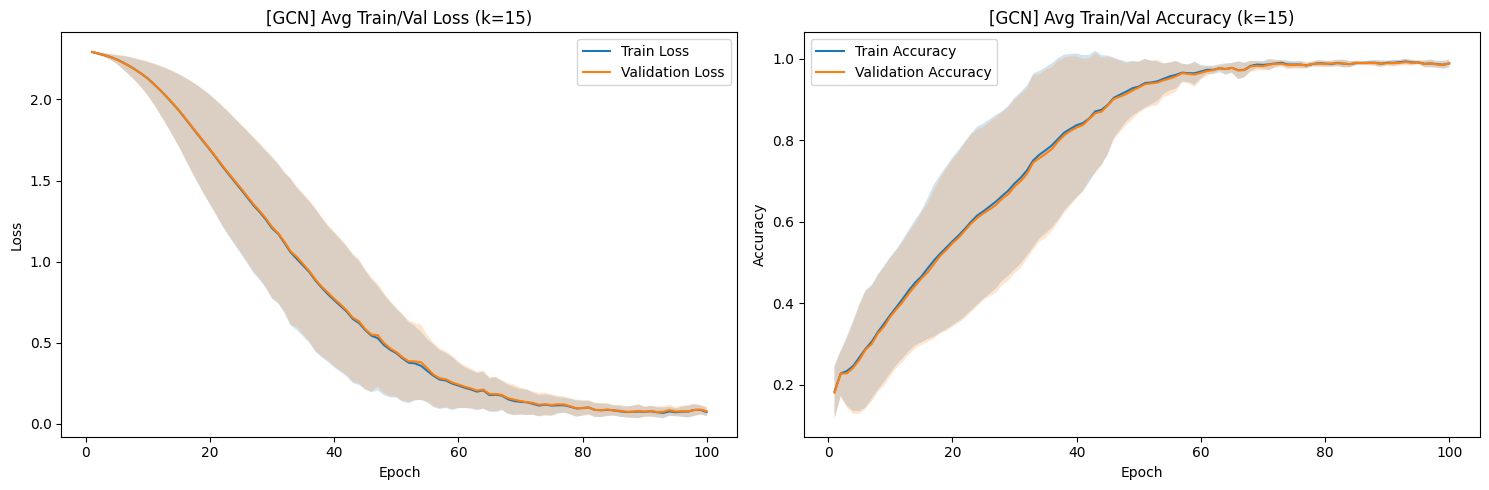

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_15_GAT
Using existing processed data for k_15_GAT
Starting k-fold cross-validation for GAT...

--- Fold 1/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2814, Train Acc: 0.1853, Val Loss: 2.2779, Val Acc: 0.1940
Epoch 020, Train Loss: 2.2202, Train Acc: 0.1613, Val Loss: 2.2126, Val Acc: 0.1580
Epoch 030, Train Loss: 2.1207, Train Acc: 0.1330, Val Loss: 2.1070, Val Acc: 0.1269
Epoch 040, Train Loss: 1.9023, Train Acc: 0.1695, Val Loss: 1.8845, Val Acc: 0.1667
Epoch 050, Train Loss: 1.4873, Train Acc: 0.4082, Val Loss: 1.4726, Val Acc: 0.4117
Epoch 060, Train Loss: 0.8975, Train Acc: 0.8452, Val Loss: 0.8913, Val Acc: 0.8595
Epoch 070, Train Loss: 0.3994, Train Acc: 0.9603, Val Loss: 0.4029, Val Acc: 0.9577
Epoch 080, Train Loss: 0.1638, Train Acc: 0.9946, Val Loss: 0.1756, Val Acc: 0.9938
Epoch 090, Train Loss: 0.0810, Train Acc: 0.9967, Val Loss: 0.0899, Val Acc: 0.9950


[I 2025-01-26 16:51:14,128] Trial 0 finished with value: 0.07358454167842865 and parameters: {'hidden_channels': 60, 'dropout': 0.27018963528550777, 'lr': 0.00018159325171272715}. Best is trial 0 with value: 0.07358454167842865.


Epoch 100, Train Loss: 0.0673, Train Acc: 0.9942, Val Loss: 0.0736, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2442, Train Acc: 0.1694, Val Loss: 2.2439, Val Acc: 0.1667
Epoch 020, Train Loss: 2.1341, Train Acc: 0.2025, Val Loss: 2.1307, Val Acc: 0.2040
Epoch 030, Train Loss: 1.9995, Train Acc: 0.1226, Val Loss: 1.9940, Val Acc: 0.1294
Epoch 040, Train Loss: 1.6940, Train Acc: 0.2566, Val Loss: 1.6856, Val Acc: 0.2488
Epoch 050, Train Loss: 1.1236, Train Acc: 0.5842, Val Loss: 1.1239, Val Acc: 0.5821
Epoch 060, Train Loss: 0.4904, Train Acc: 0.9488, Val Loss: 0.5031, Val Acc: 0.9366
Epoch 070, Train Loss: 0.1990, Train Acc: 0.9818, Val Loss: 0.2065, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0712, Train Acc: 0.9989, Val Loss: 0.0777, Val Acc: 0.9975
Epoch 090, Train Loss: 0.0717, Train Acc: 0.9882, Val Loss: 0.0876, Val Acc: 0.9838


[I 2025-01-26 16:51:18,281] Trial 1 finished with value: 0.0303949024528265 and parameters: {'hidden_channels': 32, 'dropout': 0.3001811156009972, 'lr': 0.0005896922135150143}. Best is trial 1 with value: 0.0303949024528265.


Epoch 100, Train Loss: 0.0277, Train Acc: 0.9995, Val Loss: 0.0304, Val Acc: 0.9975


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2764, Train Acc: 0.1148, Val Loss: 2.2785, Val Acc: 0.1045
Epoch 020, Train Loss: 2.2101, Train Acc: 0.1008, Val Loss: 2.2129, Val Acc: 0.0983
Epoch 030, Train Loss: 2.0785, Train Acc: 0.3036, Val Loss: 2.0818, Val Acc: 0.3159
Epoch 040, Train Loss: 1.8433, Train Acc: 0.4859, Val Loss: 1.8477, Val Acc: 0.4677
Epoch 050, Train Loss: 1.4483, Train Acc: 0.7587, Val Loss: 1.4579, Val Acc: 0.7400
Epoch 060, Train Loss: 0.9229, Train Acc: 0.9093, Val Loss: 0.9355, Val Acc: 0.8943
Epoch 070, Train Loss: 0.4674, Train Acc: 0.9715, Val Loss: 0.4799, Val Acc: 0.9602
Epoch 080, Train Loss: 0.2275, Train Acc: 0.9885, Val Loss: 0.2453, Val Acc: 0.9838
Epoch 090, Train Loss: 0.1552, Train Acc: 0.9897, Val Loss: 0.1651, Val Acc: 0.9888


[I 2025-01-26 16:51:23,246] Trial 2 finished with value: 0.12664858996868134 and parameters: {'hidden_channels': 40, 'dropout': 0.3563744241779274, 'lr': 0.00021282278269605805}. Best is trial 1 with value: 0.0303949024528265.


Epoch 100, Train Loss: 0.1195, Train Acc: 0.9899, Val Loss: 0.1266, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.1203, Train Acc: 0.7367, Val Loss: 1.1388, Val Acc: 0.7301
Epoch 020, Train Loss: 0.5858, Train Acc: 0.8385, Val Loss: 0.5655, Val Acc: 0.8483
Epoch 030, Train Loss: 0.2942, Train Acc: 0.9353, Val Loss: 0.2964, Val Acc: 0.9303
Epoch 040, Train Loss: 0.2604, Train Acc: 0.9376, Val Loss: 0.2395, Val Acc: 0.9453
Epoch 050, Train Loss: 0.1407, Train Acc: 0.9572, Val Loss: 0.1438, Val Acc: 0.9577
Epoch 060, Train Loss: 0.1107, Train Acc: 0.9625, Val Loss: 0.1008, Val Acc: 0.9701
Epoch 070, Train Loss: 0.0621, Train Acc: 0.9897, Val Loss: 0.0635, Val Acc: 0.9900


[I 2025-01-26 16:51:26,479] Trial 3 finished with value: 0.11821411550045013 and parameters: {'hidden_channels': 31, 'dropout': 0.41428321584704, 'lr': 0.009692275407889634}. Best is trial 1 with value: 0.0303949024528265.


Epoch 080, Train Loss: 0.1418, Train Acc: 0.9512, Val Loss: 0.1321, Val Acc: 0.9565
Early stopping at epoch 83


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9472, Train Acc: 0.1773, Val Loss: 1.9574, Val Acc: 0.1779
Epoch 020, Train Loss: 1.6605, Train Acc: 0.2433, Val Loss: 1.6683, Val Acc: 0.2363
Epoch 030, Train Loss: 1.0590, Train Acc: 0.5317, Val Loss: 1.0437, Val Acc: 0.5560
Epoch 040, Train Loss: 0.4003, Train Acc: 0.9213, Val Loss: 0.3994, Val Acc: 0.9328
Epoch 050, Train Loss: 0.1540, Train Acc: 0.9820, Val Loss: 0.1616, Val Acc: 0.9838
Epoch 060, Train Loss: 0.0600, Train Acc: 0.9983, Val Loss: 0.0670, Val Acc: 0.9950
Epoch 070, Train Loss: 0.0194, Train Acc: 1.0000, Val Loss: 0.0236, Val Acc: 1.0000
Epoch 080, Train Loss: 0.0090, Train Acc: 1.0000, Val Loss: 0.0111, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0071, Train Acc: 0.9998, Val Loss: 0.0101, Val Acc: 0.9988


[I 2025-01-26 16:51:33,527] Trial 4 finished with value: 0.0052518476732075214 and parameters: {'hidden_channels': 62, 'dropout': 0.31036473497268396, 'lr': 0.0027583743683228944}. Best is trial 4 with value: 0.0052518476732075214.


Epoch 100, Train Loss: 0.0039, Train Acc: 1.0000, Val Loss: 0.0053, Val Acc: 1.0000
  Fold 1 - Optuna Best Trial Val Loss: 0.0053
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 62, 'dropout': 0.31036473497268396, 'lr': 0.0027583743683228944}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9118, Train Acc: 0.1871, Val Loss: 1.9226, Val Acc: 0.1828
Epoch 020, Train Loss: 1.5593, Train Acc: 0.3116, Val Loss: 1.5644, Val Acc: 0.3159
Epoch 030, Train Loss: 1.0046, Train Acc: 0.5430, Val Loss: 1.0128, Val Acc: 0.5473
Epoch 040, Train Loss: 0.4395, Train Acc: 0.9001, Val Loss: 0.4390, Val Acc: 0.9042
Epoch 050, Train Loss: 0.1900, Train Acc: 0.9742, Val Loss: 0.1963, Val Acc: 0.9764
Epoch 060, Train Loss: 0.0881, Train Acc: 0.9841, Val Loss: 0.1061, Val Acc: 0.9776
Epoch 070, Train Loss: 0.0613, Train Acc: 0.9840, Val Loss: 0.0711, Val Acc: 0.9801
Epoch 080, Train Loss: 0.0199, Train Acc: 1.0000, Val Loss: 0.0217, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0586, Train Acc: 0.9877, Val Loss: 0.0499, Val Acc: 0.9913


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0687, Train Acc: 0.9815, Val Loss: 0.0864, Val Acc: 0.9764
  Fold 1 Test Metrics:
  Accuracy: 0.9813
  Precision: 0.9842
  Recall: 0.9813
  F1: 0.9818

--- Fold 2/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0238, Train Acc: 0.3296, Val Loss: 2.0180, Val Acc: 0.3109
Epoch 020, Train Loss: 1.6341, Train Acc: 0.2896, Val Loss: 1.6228, Val Acc: 0.2985
Epoch 030, Train Loss: 1.1112, Train Acc: 0.5404, Val Loss: 1.1142, Val Acc: 0.5149
Epoch 040, Train Loss: 0.4992, Train Acc: 0.8602, Val Loss: 0.5011, Val Acc: 0.8557
Epoch 050, Train Loss: 0.2242, Train Acc: 0.9465, Val Loss: 0.2288, Val Acc: 0.9415
Epoch 060, Train Loss: 0.1349, Train Acc: 0.9854, Val Loss: 0.1193, Val Acc: 0.9851
Epoch 070, Train Loss: 0.0621, Train Acc: 0.9810, Val Loss: 0.0688, Val Acc: 0.9764
Epoch 080, Train Loss: 0.0813, Train Acc: 0.9764, Val Loss: 0.1005, Val Acc: 0.9677
Epoch 090, Train Loss: 0.1026, Train Acc: 0.9784, Val Loss: 0.1716, Val Acc: 0.9639


[I 2025-01-26 16:51:44,366] Trial 0 finished with value: 0.08125562220811844 and parameters: {'hidden_channels': 27, 'dropout': 0.46616246304449105, 'lr': 0.0031140852884569397}. Best is trial 0 with value: 0.08125562220811844.


Epoch 100, Train Loss: 0.0533, Train Acc: 0.9843, Val Loss: 0.0813, Val Acc: 0.9714


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2685, Train Acc: 0.1187, Val Loss: 2.2666, Val Acc: 0.1219
Epoch 020, Train Loss: 2.2101, Train Acc: 0.1016, Val Loss: 2.2104, Val Acc: 0.1020
Epoch 030, Train Loss: 2.0726, Train Acc: 0.1016, Val Loss: 2.0712, Val Acc: 0.1020
Epoch 040, Train Loss: 1.8105, Train Acc: 0.1126, Val Loss: 1.8096, Val Acc: 0.1107
Epoch 050, Train Loss: 1.2780, Train Acc: 0.3767, Val Loss: 1.2932, Val Acc: 0.3669
Epoch 060, Train Loss: 0.6756, Train Acc: 0.8675, Val Loss: 0.7033, Val Acc: 0.8470
Epoch 070, Train Loss: 0.2982, Train Acc: 0.9729, Val Loss: 0.3272, Val Acc: 0.9652
Epoch 080, Train Loss: 0.1170, Train Acc: 0.9972, Val Loss: 0.1259, Val Acc: 0.9938
Epoch 090, Train Loss: 0.0667, Train Acc: 0.9981, Val Loss: 0.0799, Val Acc: 0.9963


[I 2025-01-26 16:51:47,620] Trial 1 finished with value: 0.0930197611451149 and parameters: {'hidden_channels': 24, 'dropout': 0.2472070449372692, 'lr': 0.0005625959387346115}. Best is trial 0 with value: 0.08125562220811844.


Epoch 100, Train Loss: 0.0699, Train Acc: 0.9942, Val Loss: 0.0930, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3081, Train Acc: 0.0999, Val Loss: 2.3059, Val Acc: 0.1020
Epoch 020, Train Loss: 2.2932, Train Acc: 0.1476, Val Loss: 2.2919, Val Acc: 0.1418
Epoch 030, Train Loss: 2.2416, Train Acc: 0.1499, Val Loss: 2.2431, Val Acc: 0.1443
Epoch 040, Train Loss: 2.1004, Train Acc: 0.1748, Val Loss: 2.1140, Val Acc: 0.1729
Epoch 050, Train Loss: 1.7908, Train Acc: 0.3756, Val Loss: 1.8151, Val Acc: 0.3694
Epoch 060, Train Loss: 1.2846, Train Acc: 0.7612, Val Loss: 1.3059, Val Acc: 0.7363
Epoch 070, Train Loss: 0.7780, Train Acc: 0.9162, Val Loss: 0.7935, Val Acc: 0.9092
Epoch 080, Train Loss: 0.4629, Train Acc: 0.9575, Val Loss: 0.4814, Val Acc: 0.9565
Epoch 090, Train Loss: 0.3049, Train Acc: 0.9810, Val Loss: 0.3190, Val Acc: 0.9751


[I 2025-01-26 16:51:50,806] Trial 2 finished with value: 0.24454225599765778 and parameters: {'hidden_channels': 24, 'dropout': 0.32053423361333144, 'lr': 0.00015543141631111797}. Best is trial 0 with value: 0.08125562220811844.


Epoch 100, Train Loss: 0.2302, Train Acc: 0.9891, Val Loss: 0.2445, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3018, Train Acc: 0.0946, Val Loss: 2.3017, Val Acc: 0.0746
Epoch 020, Train Loss: 2.2714, Train Acc: 0.2137, Val Loss: 2.2677, Val Acc: 0.2002
Epoch 030, Train Loss: 2.1928, Train Acc: 0.2862, Val Loss: 2.1894, Val Acc: 0.2749
Epoch 040, Train Loss: 2.0420, Train Acc: 0.3061, Val Loss: 2.0385, Val Acc: 0.2898
Epoch 050, Train Loss: 1.7562, Train Acc: 0.4920, Val Loss: 1.7506, Val Acc: 0.4938
Epoch 060, Train Loss: 1.2924, Train Acc: 0.8619, Val Loss: 1.2924, Val Acc: 0.8532
Epoch 070, Train Loss: 0.8044, Train Acc: 0.9308, Val Loss: 0.8018, Val Acc: 0.9303
Epoch 080, Train Loss: 0.4603, Train Acc: 0.9630, Val Loss: 0.4651, Val Acc: 0.9689
Epoch 090, Train Loss: 0.2952, Train Acc: 0.9823, Val Loss: 0.2967, Val Acc: 0.9863


[I 2025-01-26 16:51:55,154] Trial 3 finished with value: 0.2197517305612564 and parameters: {'hidden_channels': 34, 'dropout': 0.33187130901579676, 'lr': 0.00011015943683157741}. Best is trial 0 with value: 0.08125562220811844.


Epoch 100, Train Loss: 0.2201, Train Acc: 0.9816, Val Loss: 0.2198, Val Acc: 0.9876


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2057, Train Acc: 0.1016, Val Loss: 2.2009, Val Acc: 0.1020
Epoch 020, Train Loss: 2.1618, Train Acc: 0.1075, Val Loss: 2.1566, Val Acc: 0.1057
Epoch 030, Train Loss: 2.1087, Train Acc: 0.1176, Val Loss: 2.1091, Val Acc: 0.1157
Epoch 040, Train Loss: 1.9304, Train Acc: 0.1265, Val Loss: 1.9440, Val Acc: 0.1256
Epoch 050, Train Loss: 1.2964, Train Acc: 0.2846, Val Loss: 1.3328, Val Acc: 0.2823
Epoch 060, Train Loss: 0.4824, Train Acc: 0.8687, Val Loss: 0.5115, Val Acc: 0.8507
Epoch 070, Train Loss: 0.1605, Train Acc: 0.9821, Val Loss: 0.1991, Val Acc: 0.9726
Epoch 080, Train Loss: 0.0618, Train Acc: 0.9927, Val Loss: 0.0720, Val Acc: 0.9876
Epoch 090, Train Loss: 0.0305, Train Acc: 0.9997, Val Loss: 0.0357, Val Acc: 0.9988


[I 2025-01-26 16:52:01,554] Trial 4 finished with value: 0.07032103091478348 and parameters: {'hidden_channels': 53, 'dropout': 0.3615259857176836, 'lr': 0.0007157919290021373}. Best is trial 4 with value: 0.07032103091478348.


Epoch 100, Train Loss: 0.0496, Train Acc: 0.9844, Val Loss: 0.0703, Val Acc: 0.9801
  Fold 2 - Optuna Best Trial Val Loss: 0.0703
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 53, 'dropout': 0.3615259857176836, 'lr': 0.0007157919290021373}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2036, Train Acc: 0.2249, Val Loss: 2.1993, Val Acc: 0.2239
Epoch 020, Train Loss: 2.1470, Train Acc: 0.1131, Val Loss: 2.1439, Val Acc: 0.1119
Epoch 030, Train Loss: 2.1694, Train Acc: 0.1285, Val Loss: 2.1812, Val Acc: 0.1269
Epoch 040, Train Loss: 1.7818, Train Acc: 0.2087, Val Loss: 1.8145, Val Acc: 0.2177
Epoch 050, Train Loss: 1.0169, Train Acc: 0.5158, Val Loss: 1.0447, Val Acc: 0.5037
Epoch 060, Train Loss: 0.3939, Train Acc: 0.9202, Val Loss: 0.4449, Val Acc: 0.9129
Epoch 070, Train Loss: 0.1045, Train Acc: 0.9922, Val Loss: 0.1165, Val Acc: 0.9888
Epoch 080, Train Loss: 0.0416, Train Acc: 0.9986, Val Loss: 0.0487, Val Acc: 0.9950
Epoch 090, Train Loss: 0.0283, Train Acc: 0.9975, Val Loss: 0.0330, Val Acc: 0.9950


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0276, Train Acc: 0.9956, Val Loss: 0.0228, Val Acc: 0.9975
  Fold 2 Test Metrics:
  Accuracy: 0.9975
  Precision: 0.9976
  Recall: 0.9975
  F1: 0.9975

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2252, Train Acc: 0.2465, Val Loss: 2.2239, Val Acc: 0.2537
Epoch 020, Train Loss: 2.0643, Train Acc: 0.2283, Val Loss: 2.0577, Val Acc: 0.2338
Epoch 030, Train Loss: 1.8711, Train Acc: 0.1825, Val Loss: 1.8578, Val Acc: 0.1828
Epoch 040, Train Loss: 1.4696, Train Acc: 0.2991, Val Loss: 1.4567, Val Acc: 0.3109
Epoch 050, Train Loss: 0.8669, Train Acc: 0.7261, Val Loss: 0.8610, Val Acc: 0.7301
Epoch 060, Train Loss: 0.3464, Train Acc: 0.9564, Val Loss: 0.3380, Val Acc: 0.9590
Epoch 070, Train Loss: 0.1508, Train Acc: 0.9902, Val Loss: 0.1517, Val Acc: 0.9863
Epoch 080, Train Loss: 0.1121, Train Acc: 0.9918, Val Loss: 0.1220, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0702, Train Acc: 0.9935, Val Loss: 0.0625, Val Acc: 0.9950


[I 2025-01-26 16:52:10,944] Trial 0 finished with value: 0.036096010357141495 and parameters: {'hidden_channels': 22, 'dropout': 0.2315142298187456, 'lr': 0.0009328374967398935}. Best is trial 0 with value: 0.036096010357141495.


Epoch 100, Train Loss: 0.0386, Train Acc: 1.0000, Val Loss: 0.0361, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1038, Train Acc: 0.2302, Val Loss: 2.1073, Val Acc: 0.2450
Epoch 020, Train Loss: 1.8898, Train Acc: 0.1759, Val Loss: 1.8860, Val Acc: 0.1915
Epoch 030, Train Loss: 1.6762, Train Acc: 0.2231, Val Loss: 1.6737, Val Acc: 0.2351
Epoch 040, Train Loss: 1.0661, Train Acc: 0.5993, Val Loss: 1.0652, Val Acc: 0.5945
Epoch 050, Train Loss: 0.4800, Train Acc: 0.8735, Val Loss: 0.4565, Val Acc: 0.8731
Epoch 060, Train Loss: 0.1426, Train Acc: 0.9866, Val Loss: 0.1430, Val Acc: 0.9913
Epoch 070, Train Loss: 0.1619, Train Acc: 0.9639, Val Loss: 0.1441, Val Acc: 0.9701
Epoch 080, Train Loss: 0.0592, Train Acc: 0.9835, Val Loss: 0.0574, Val Acc: 0.9863
Epoch 090, Train Loss: 0.0345, Train Acc: 0.9998, Val Loss: 0.0341, Val Acc: 0.9988


[I 2025-01-26 16:52:14,641] Trial 1 finished with value: 0.025787780061364174 and parameters: {'hidden_channels': 29, 'dropout': 0.3698226326801988, 'lr': 0.0017011757475132864}. Best is trial 1 with value: 0.025787780061364174.


Epoch 100, Train Loss: 0.0261, Train Acc: 0.9992, Val Loss: 0.0258, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.3241, Train Acc: 0.5862, Val Loss: 1.3303, Val Acc: 0.5821
Epoch 020, Train Loss: 0.7491, Train Acc: 0.7612, Val Loss: 0.7560, Val Acc: 0.7537
Epoch 030, Train Loss: 0.3654, Train Acc: 0.9350, Val Loss: 0.3972, Val Acc: 0.9328
Epoch 040, Train Loss: 0.1695, Train Acc: 0.9737, Val Loss: 0.1844, Val Acc: 0.9701
Epoch 050, Train Loss: 0.1217, Train Acc: 0.9779, Val Loss: 0.1203, Val Acc: 0.9863
Epoch 060, Train Loss: 0.1965, Train Acc: 0.9566, Val Loss: 0.1336, Val Acc: 0.9714
Epoch 070, Train Loss: 0.0977, Train Acc: 0.9770, Val Loss: 0.0784, Val Acc: 0.9826
Epoch 080, Train Loss: 0.0307, Train Acc: 0.9995, Val Loss: 0.0298, Val Acc: 0.9988
Epoch 090, Train Loss: 0.0344, Train Acc: 0.9997, Val Loss: 0.0346, Val Acc: 0.9988


[I 2025-01-26 16:52:21,558] Trial 2 finished with value: 0.05037878453731537 and parameters: {'hidden_channels': 61, 'dropout': 0.3433471032962718, 'lr': 0.006509265403606153}. Best is trial 1 with value: 0.025787780061364174.


Early stopping at epoch 100


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2758, Train Acc: 0.2650, Val Loss: 2.2753, Val Acc: 0.2562
Epoch 020, Train Loss: 2.2089, Train Acc: 0.1913, Val Loss: 2.2062, Val Acc: 0.1928
Epoch 030, Train Loss: 2.0914, Train Acc: 0.2120, Val Loss: 2.0861, Val Acc: 0.2164
Epoch 040, Train Loss: 1.9033, Train Acc: 0.2195, Val Loss: 1.8927, Val Acc: 0.2065
Epoch 050, Train Loss: 1.5549, Train Acc: 0.4128, Val Loss: 1.5423, Val Acc: 0.4254
Epoch 060, Train Loss: 1.0281, Train Acc: 0.7353, Val Loss: 1.0066, Val Acc: 0.7226
Epoch 070, Train Loss: 0.5201, Train Acc: 0.9317, Val Loss: 0.5058, Val Acc: 0.9440
Epoch 080, Train Loss: 0.2366, Train Acc: 0.9897, Val Loss: 0.2323, Val Acc: 0.9900
Epoch 090, Train Loss: 0.1327, Train Acc: 0.9967, Val Loss: 0.1291, Val Acc: 0.9975


[I 2025-01-26 16:52:27,064] Trial 3 finished with value: 0.08824063837528229 and parameters: {'hidden_channels': 47, 'dropout': 0.32103867894134014, 'lr': 0.00014470090218868248}. Best is trial 1 with value: 0.025787780061364174.


Epoch 100, Train Loss: 0.0902, Train Acc: 0.9977, Val Loss: 0.0882, Val Acc: 0.9975


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1028, Train Acc: 0.2192, Val Loss: 2.1074, Val Acc: 0.2127
Epoch 020, Train Loss: 1.7322, Train Acc: 0.3548, Val Loss: 1.7408, Val Acc: 0.3408
Epoch 030, Train Loss: 1.2187, Train Acc: 0.6013, Val Loss: 1.2299, Val Acc: 0.5920
Epoch 040, Train Loss: 0.6591, Train Acc: 0.8745, Val Loss: 0.6637, Val Acc: 0.8781
Epoch 050, Train Loss: 0.2458, Train Acc: 0.9827, Val Loss: 0.2648, Val Acc: 0.9701
Epoch 060, Train Loss: 0.1208, Train Acc: 0.9760, Val Loss: 0.1184, Val Acc: 0.9789
Epoch 070, Train Loss: 0.0967, Train Acc: 0.9832, Val Loss: 0.1164, Val Acc: 0.9776
Epoch 080, Train Loss: 0.0633, Train Acc: 0.9826, Val Loss: 0.0673, Val Acc: 0.9813
Epoch 090, Train Loss: 0.0398, Train Acc: 0.9953, Val Loss: 0.0448, Val Acc: 0.9938


[I 2025-01-26 16:52:29,863] Trial 4 finished with value: 0.041996944695711136 and parameters: {'hidden_channels': 20, 'dropout': 0.42047608409070597, 'lr': 0.0024923815250801245}. Best is trial 1 with value: 0.025787780061364174.


Epoch 100, Train Loss: 0.0381, Train Acc: 0.9949, Val Loss: 0.0420, Val Acc: 0.9938
  Fold 3 - Optuna Best Trial Val Loss: 0.0258
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 29, 'dropout': 0.3698226326801988, 'lr': 0.0017011757475132864}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1330, Train Acc: 0.1168, Val Loss: 2.1337, Val Acc: 0.1095
Epoch 020, Train Loss: 1.9412, Train Acc: 0.1055, Val Loss: 1.9384, Val Acc: 0.1082
Epoch 030, Train Loss: 1.6785, Train Acc: 0.1319, Val Loss: 1.6802, Val Acc: 0.1294
Epoch 040, Train Loss: 1.1241, Train Acc: 0.4464, Val Loss: 1.1335, Val Acc: 0.4453
Epoch 050, Train Loss: 0.5769, Train Acc: 0.7984, Val Loss: 0.6004, Val Acc: 0.7786
Epoch 060, Train Loss: 0.1784, Train Acc: 0.9662, Val Loss: 0.1849, Val Acc: 0.9652
Epoch 070, Train Loss: 0.0695, Train Acc: 0.9927, Val Loss: 0.0713, Val Acc: 0.9925
Epoch 080, Train Loss: 0.0680, Train Acc: 0.9928, Val Loss: 0.0778, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0234, Train Acc: 0.9994, Val Loss: 0.0254, Val Acc: 0.9988


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0787, Train Acc: 0.9734, Val Loss: 0.0621, Val Acc: 0.9751
  Fold 3 Test Metrics:
  Accuracy: 0.9602
  Precision: 0.9714
  Recall: 0.9602
  F1: 0.9616

--- Fold 4/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0496, Train Acc: 0.2083, Val Loss: 2.0601, Val Acc: 0.2102
Epoch 020, Train Loss: 1.8240, Train Acc: 0.1554, Val Loss: 1.8462, Val Acc: 0.1430
Epoch 030, Train Loss: 1.3925, Train Acc: 0.3184, Val Loss: 1.4449, Val Acc: 0.3022
Epoch 040, Train Loss: 0.5364, Train Acc: 0.8017, Val Loss: 0.5508, Val Acc: 0.7848
Epoch 050, Train Loss: 0.1962, Train Acc: 0.9648, Val Loss: 0.2249, Val Acc: 0.9590
Epoch 060, Train Loss: 0.0575, Train Acc: 0.9964, Val Loss: 0.0590, Val Acc: 0.9963
Epoch 070, Train Loss: 0.0221, Train Acc: 0.9995, Val Loss: 0.0218, Val Acc: 1.0000
Epoch 080, Train Loss: 0.0139, Train Acc: 0.9984, Val Loss: 0.0155, Val Acc: 0.9963
Epoch 090, Train Loss: 0.0111, Train Acc: 0.9988, Val Loss: 0.0124, Val Acc: 0.9963


[I 2025-01-26 16:52:40,272] Trial 0 finished with value: 0.04818843677639961 and parameters: {'hidden_channels': 54, 'dropout': 0.29571074714816464, 'lr': 0.0024538892620766203}. Best is trial 0 with value: 0.04818843677639961.


Epoch 100, Train Loss: 0.0297, Train Acc: 0.9961, Val Loss: 0.0482, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2806, Train Acc: 0.1888, Val Loss: 2.2798, Val Acc: 0.1953
Epoch 020, Train Loss: 2.2151, Train Acc: 0.2612, Val Loss: 2.2177, Val Acc: 0.2600
Epoch 030, Train Loss: 2.0403, Train Acc: 0.3713, Val Loss: 2.0453, Val Acc: 0.3706
Epoch 040, Train Loss: 1.7187, Train Acc: 0.4851, Val Loss: 1.7256, Val Acc: 0.4950
Epoch 050, Train Loss: 1.2480, Train Acc: 0.7256, Val Loss: 1.2510, Val Acc: 0.7114
Epoch 060, Train Loss: 0.7340, Train Acc: 0.9093, Val Loss: 0.7354, Val Acc: 0.9042
Epoch 070, Train Loss: 0.3482, Train Acc: 0.9871, Val Loss: 0.3528, Val Acc: 0.9888
Epoch 080, Train Loss: 0.1752, Train Acc: 0.9955, Val Loss: 0.1768, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0968, Train Acc: 0.9994, Val Loss: 0.1009, Val Acc: 0.9988


[I 2025-01-26 16:52:44,152] Trial 1 finished with value: 0.0779326781630516 and parameters: {'hidden_channels': 30, 'dropout': 0.35455109903717996, 'lr': 0.0003072019641857504}. Best is trial 0 with value: 0.04818843677639961.


Epoch 100, Train Loss: 0.0707, Train Acc: 0.9966, Val Loss: 0.0779, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0376, Train Acc: 0.1591, Val Loss: 2.0383, Val Acc: 0.1642
Epoch 020, Train Loss: 1.9006, Train Acc: 0.1737, Val Loss: 1.9362, Val Acc: 0.1741
Epoch 030, Train Loss: 1.3128, Train Acc: 0.3388, Val Loss: 1.3611, Val Acc: 0.3296
Epoch 040, Train Loss: 0.5676, Train Acc: 0.8319, Val Loss: 0.6179, Val Acc: 0.7898
Epoch 050, Train Loss: 0.2114, Train Acc: 0.9482, Val Loss: 0.2183, Val Acc: 0.9502
Epoch 060, Train Loss: 0.0828, Train Acc: 0.9899, Val Loss: 0.1030, Val Acc: 0.9826
Epoch 070, Train Loss: 0.0266, Train Acc: 0.9998, Val Loss: 0.0308, Val Acc: 0.9988
Epoch 080, Train Loss: 0.1020, Train Acc: 0.9743, Val Loss: 0.1416, Val Acc: 0.9714
Epoch 090, Train Loss: 0.0179, Train Acc: 0.9994, Val Loss: 0.0173, Val Acc: 1.0000


[I 2025-01-26 16:52:50,914] Trial 2 finished with value: 0.024777794256806374 and parameters: {'hidden_channels': 58, 'dropout': 0.3641215184513654, 'lr': 0.002216833477454739}. Best is trial 2 with value: 0.024777794256806374.


Epoch 100, Train Loss: 0.0239, Train Acc: 0.9927, Val Loss: 0.0248, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2627, Train Acc: 0.1173, Val Loss: 2.2625, Val Acc: 0.1157
Epoch 020, Train Loss: 2.1849, Train Acc: 0.1470, Val Loss: 2.1842, Val Acc: 0.1443
Epoch 030, Train Loss: 2.0450, Train Acc: 0.2602, Val Loss: 2.0437, Val Acc: 0.2525
Epoch 040, Train Loss: 1.7922, Train Acc: 0.3274, Val Loss: 1.7923, Val Acc: 0.3259
Epoch 050, Train Loss: 1.3680, Train Acc: 0.5212, Val Loss: 1.3823, Val Acc: 0.5050
Epoch 060, Train Loss: 0.8043, Train Acc: 0.8235, Val Loss: 0.8245, Val Acc: 0.7998
Epoch 070, Train Loss: 0.3940, Train Acc: 0.9676, Val Loss: 0.4193, Val Acc: 0.9515
Epoch 080, Train Loss: 0.1848, Train Acc: 0.9896, Val Loss: 0.1954, Val Acc: 0.9851
Epoch 090, Train Loss: 0.1111, Train Acc: 0.9930, Val Loss: 0.1259, Val Acc: 0.9888


[I 2025-01-26 16:52:55,825] Trial 3 finished with value: 0.09614565968513489 and parameters: {'hidden_channels': 40, 'dropout': 0.4972100926977988, 'lr': 0.00029342295359745545}. Best is trial 2 with value: 0.024777794256806374.


Epoch 100, Train Loss: 0.0804, Train Acc: 0.9933, Val Loss: 0.0961, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2690, Train Acc: 0.1425, Val Loss: 2.2712, Val Acc: 0.1393
Epoch 020, Train Loss: 2.1835, Train Acc: 0.1689, Val Loss: 2.1877, Val Acc: 0.1617
Epoch 030, Train Loss: 2.0409, Train Acc: 0.2518, Val Loss: 2.0491, Val Acc: 0.2475
Epoch 040, Train Loss: 1.8086, Train Acc: 0.2119, Val Loss: 1.8198, Val Acc: 0.1978
Epoch 050, Train Loss: 1.4079, Train Acc: 0.4256, Val Loss: 1.4243, Val Acc: 0.4067
Epoch 060, Train Loss: 0.8315, Train Acc: 0.8185, Val Loss: 0.8522, Val Acc: 0.7774
Epoch 070, Train Loss: 0.3626, Train Acc: 0.9718, Val Loss: 0.3764, Val Acc: 0.9639
Epoch 080, Train Loss: 0.1451, Train Acc: 0.9949, Val Loss: 0.1568, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0772, Train Acc: 0.9952, Val Loss: 0.0862, Val Acc: 0.9938


[I 2025-01-26 16:53:00,261] Trial 4 finished with value: 0.05015874654054642 and parameters: {'hidden_channels': 34, 'dropout': 0.3633715380145907, 'lr': 0.00032558505726980856}. Best is trial 2 with value: 0.024777794256806374.


Epoch 100, Train Loss: 0.0463, Train Acc: 0.9988, Val Loss: 0.0502, Val Acc: 0.9963
  Fold 4 - Optuna Best Trial Val Loss: 0.0248
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 58, 'dropout': 0.3641215184513654, 'lr': 0.002216833477454739}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9849, Train Acc: 0.2738, Val Loss: 1.9882, Val Acc: 0.2674
Epoch 020, Train Loss: 1.6180, Train Acc: 0.2602, Val Loss: 1.6308, Val Acc: 0.2761
Epoch 030, Train Loss: 1.1637, Train Acc: 0.4290, Val Loss: 1.1851, Val Acc: 0.4092
Epoch 040, Train Loss: 0.5795, Train Acc: 0.7788, Val Loss: 0.5964, Val Acc: 0.7587
Epoch 050, Train Loss: 0.2047, Train Acc: 0.9493, Val Loss: 0.2173, Val Acc: 0.9465
Epoch 060, Train Loss: 0.0917, Train Acc: 0.9832, Val Loss: 0.1107, Val Acc: 0.9776
Epoch 070, Train Loss: 0.0290, Train Acc: 0.9995, Val Loss: 0.0318, Val Acc: 0.9988
Epoch 080, Train Loss: 0.0564, Train Acc: 0.9879, Val Loss: 0.0454, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0136, Train Acc: 1.0000, Val Loss: 0.0146, Val Acc: 1.0000


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0094, Train Acc: 0.9997, Val Loss: 0.0096, Val Acc: 1.0000
  Fold 4 Test Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000

--- Fold 5/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2682, Train Acc: 0.2056, Val Loss: 2.2662, Val Acc: 0.2077
Epoch 020, Train Loss: 2.1803, Train Acc: 0.5803, Val Loss: 2.1798, Val Acc: 0.5945
Epoch 030, Train Loss: 2.0142, Train Acc: 0.5583, Val Loss: 2.0212, Val Acc: 0.5249
Epoch 040, Train Loss: 1.7515, Train Acc: 0.6225, Val Loss: 1.7672, Val Acc: 0.5920
Epoch 050, Train Loss: 1.3310, Train Acc: 0.7804, Val Loss: 1.3561, Val Acc: 0.7600
Epoch 060, Train Loss: 0.8153, Train Acc: 0.8860, Val Loss: 0.8383, Val Acc: 0.8694
Epoch 070, Train Loss: 0.3907, Train Acc: 0.9676, Val Loss: 0.3905, Val Acc: 0.9664
Epoch 080, Train Loss: 0.1752, Train Acc: 0.9866, Val Loss: 0.1749, Val Acc: 0.9913
Epoch 090, Train Loss: 0.1160, Train Acc: 0.9932, Val Loss: 0.0963, Val Acc: 0.9988


[I 2025-01-26 16:53:12,740] Trial 0 finished with value: 0.06995870172977448 and parameters: {'hidden_channels': 46, 'dropout': 0.48792920136544415, 'lr': 0.00025098372327267014}. Best is trial 0 with value: 0.06995870172977448.


Epoch 100, Train Loss: 0.0665, Train Acc: 0.9988, Val Loss: 0.0700, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3009, Train Acc: 0.1275, Val Loss: 2.2985, Val Acc: 0.1306
Epoch 020, Train Loss: 2.2785, Train Acc: 0.1657, Val Loss: 2.2747, Val Acc: 0.1654
Epoch 030, Train Loss: 2.2104, Train Acc: 0.2045, Val Loss: 2.2037, Val Acc: 0.1965
Epoch 040, Train Loss: 2.0647, Train Acc: 0.3654, Val Loss: 2.0577, Val Acc: 0.3669
Epoch 050, Train Loss: 1.7955, Train Acc: 0.6002, Val Loss: 1.7984, Val Acc: 0.5796
Epoch 060, Train Loss: 1.3738, Train Acc: 0.8231, Val Loss: 1.3832, Val Acc: 0.8346
Epoch 070, Train Loss: 0.9251, Train Acc: 0.8949, Val Loss: 0.9325, Val Acc: 0.9030
Epoch 080, Train Loss: 0.5783, Train Acc: 0.9452, Val Loss: 0.5848, Val Acc: 0.9565
Epoch 090, Train Loss: 0.3931, Train Acc: 0.9711, Val Loss: 0.3973, Val Acc: 0.9689


[I 2025-01-26 16:53:16,224] Trial 1 finished with value: 0.3120649755001068 and parameters: {'hidden_channels': 26, 'dropout': 0.2665007636314764, 'lr': 0.00010694298266938334}. Best is trial 0 with value: 0.06995870172977448.


Epoch 100, Train Loss: 0.3091, Train Acc: 0.9776, Val Loss: 0.3121, Val Acc: 0.9776


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0617, Train Acc: 0.1030, Val Loss: 2.0634, Val Acc: 0.1070
Epoch 020, Train Loss: 1.9010, Train Acc: 0.1126, Val Loss: 1.9296, Val Acc: 0.1169
Epoch 030, Train Loss: 1.4582, Train Acc: 0.2910, Val Loss: 1.5106, Val Acc: 0.2774
Epoch 040, Train Loss: 0.6860, Train Acc: 0.7024, Val Loss: 0.7168, Val Acc: 0.6729
Epoch 050, Train Loss: 0.2934, Train Acc: 0.9202, Val Loss: 0.2968, Val Acc: 0.9092
Epoch 060, Train Loss: 0.1758, Train Acc: 0.9633, Val Loss: 0.1691, Val Acc: 0.9639
Epoch 070, Train Loss: 0.0329, Train Acc: 0.9984, Val Loss: 0.0377, Val Acc: 0.9975
Epoch 080, Train Loss: 0.0167, Train Acc: 1.0000, Val Loss: 0.0151, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0662, Train Acc: 0.9782, Val Loss: 0.0484, Val Acc: 0.9888


[I 2025-01-26 16:53:21,617] Trial 2 finished with value: 0.025632191449403763 and parameters: {'hidden_channels': 45, 'dropout': 0.40142242021053354, 'lr': 0.002075831024123601}. Best is trial 2 with value: 0.025632191449403763.


Epoch 100, Train Loss: 0.0305, Train Acc: 0.9933, Val Loss: 0.0256, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1890, Train Acc: 0.1562, Val Loss: 2.1838, Val Acc: 0.1517
Epoch 020, Train Loss: 2.1019, Train Acc: 0.1176, Val Loss: 2.1007, Val Acc: 0.1182
Epoch 030, Train Loss: 2.0690, Train Acc: 0.1047, Val Loss: 2.0864, Val Acc: 0.1082
Epoch 040, Train Loss: 1.5205, Train Acc: 0.1896, Val Loss: 1.5368, Val Acc: 0.1828
Epoch 050, Train Loss: 0.7142, Train Acc: 0.7334, Val Loss: 0.7332, Val Acc: 0.7226
Epoch 060, Train Loss: 0.2048, Train Acc: 0.9764, Val Loss: 0.1946, Val Acc: 0.9776
Epoch 070, Train Loss: 0.0689, Train Acc: 0.9933, Val Loss: 0.0837, Val Acc: 0.9876
Epoch 080, Train Loss: 0.0429, Train Acc: 0.9924, Val Loss: 0.0519, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0366, Train Acc: 0.9949, Val Loss: 0.0180, Val Acc: 1.0000


[I 2025-01-26 16:53:27,178] Trial 3 finished with value: 0.010352805256843567 and parameters: {'hidden_channels': 47, 'dropout': 0.28575049977558525, 'lr': 0.0010425088064180562}. Best is trial 3 with value: 0.010352805256843567.


Epoch 100, Train Loss: 0.0101, Train Acc: 1.0000, Val Loss: 0.0104, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2413, Train Acc: 0.1261, Val Loss: 2.2442, Val Acc: 0.1144
Epoch 020, Train Loss: 2.1092, Train Acc: 0.1545, Val Loss: 2.1100, Val Acc: 0.1542
Epoch 030, Train Loss: 1.8477, Train Acc: 0.1655, Val Loss: 1.8534, Val Acc: 0.1592
Epoch 040, Train Loss: 1.3550, Train Acc: 0.4974, Val Loss: 1.3660, Val Acc: 0.4925
Epoch 050, Train Loss: 0.8508, Train Acc: 0.7986, Val Loss: 0.8784, Val Acc: 0.7811
Epoch 060, Train Loss: 0.4077, Train Acc: 0.9246, Val Loss: 0.4173, Val Acc: 0.9216
Epoch 070, Train Loss: 0.1961, Train Acc: 0.9871, Val Loss: 0.2047, Val Acc: 0.9838
Epoch 080, Train Loss: 0.1136, Train Acc: 0.9813, Val Loss: 0.1176, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0654, Train Acc: 0.9975, Val Loss: 0.0704, Val Acc: 0.9950


[I 2025-01-26 16:53:29,891] Trial 4 finished with value: 0.08405888825654984 and parameters: {'hidden_channels': 18, 'dropout': 0.38063076188945244, 'lr': 0.0011568957695809268}. Best is trial 3 with value: 0.010352805256843567.


Epoch 100, Train Loss: 0.0862, Train Acc: 0.9865, Val Loss: 0.0841, Val Acc: 0.9900
  Fold 5 - Optuna Best Trial Val Loss: 0.0104
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 47, 'dropout': 0.28575049977558525, 'lr': 0.0010425088064180562}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1710, Train Acc: 0.1047, Val Loss: 2.1703, Val Acc: 0.1007
Epoch 020, Train Loss: 1.9921, Train Acc: 0.1504, Val Loss: 1.9968, Val Acc: 0.1555
Epoch 030, Train Loss: 1.6828, Train Acc: 0.2045, Val Loss: 1.6870, Val Acc: 0.2077
Epoch 040, Train Loss: 1.1475, Train Acc: 0.4887, Val Loss: 1.1861, Val Acc: 0.4726
Epoch 050, Train Loss: 0.5202, Train Acc: 0.8958, Val Loss: 0.5484, Val Acc: 0.8769
Epoch 060, Train Loss: 0.1632, Train Acc: 0.9928, Val Loss: 0.1725, Val Acc: 0.9938
Epoch 070, Train Loss: 0.0675, Train Acc: 0.9966, Val Loss: 0.0743, Val Acc: 0.9925
Epoch 080, Train Loss: 0.0271, Train Acc: 1.0000, Val Loss: 0.0282, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0130, Train Acc: 1.0000, Val Loss: 0.0135, Val Acc: 1.0000


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0082, Train Acc: 1.0000, Val Loss: 0.0086, Val Acc: 1.0000
  Fold 5 Test Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000

--- Fold 6/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2816, Train Acc: 0.2274, Val Loss: 2.2843, Val Acc: 0.2214
Epoch 020, Train Loss: 2.2358, Train Acc: 0.2624, Val Loss: 2.2432, Val Acc: 0.2612
Epoch 030, Train Loss: 2.1397, Train Acc: 0.3803, Val Loss: 2.1515, Val Acc: 0.3657
Epoch 040, Train Loss: 1.9426, Train Acc: 0.4239, Val Loss: 1.9606, Val Acc: 0.4092
Epoch 050, Train Loss: 1.5878, Train Acc: 0.6763, Val Loss: 1.5976, Val Acc: 0.6542
Epoch 060, Train Loss: 1.0965, Train Acc: 0.8715, Val Loss: 1.1009, Val Acc: 0.8632
Epoch 070, Train Loss: 0.5783, Train Acc: 0.9627, Val Loss: 0.5787, Val Acc: 0.9664
Epoch 080, Train Loss: 0.2808, Train Acc: 0.9840, Val Loss: 0.2866, Val Acc: 0.9739
Epoch 090, Train Loss: 0.1551, Train Acc: 0.9966, Val Loss: 0.1583, Val Acc: 0.9963


[I 2025-01-26 16:53:40,949] Trial 0 finished with value: 0.12015736848115921 and parameters: {'hidden_channels': 46, 'dropout': 0.321451044695956, 'lr': 0.0001402442768915823}. Best is trial 0 with value: 0.12015736848115921.


Epoch 100, Train Loss: 0.1083, Train Acc: 0.9938, Val Loss: 0.1202, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3104, Train Acc: 0.1615, Val Loss: 2.3140, Val Acc: 0.1517
Epoch 020, Train Loss: 2.2950, Train Acc: 0.1518, Val Loss: 2.3015, Val Acc: 0.1480
Epoch 030, Train Loss: 2.2224, Train Acc: 0.2030, Val Loss: 2.2289, Val Acc: 0.1940
Epoch 040, Train Loss: 2.0423, Train Acc: 0.3308, Val Loss: 2.0519, Val Acc: 0.3109
Epoch 050, Train Loss: 1.6920, Train Acc: 0.5086, Val Loss: 1.7032, Val Acc: 0.4988
Epoch 060, Train Loss: 1.1737, Train Acc: 0.7930, Val Loss: 1.1774, Val Acc: 0.7674
Epoch 070, Train Loss: 0.6435, Train Acc: 0.9512, Val Loss: 0.6463, Val Acc: 0.9490
Epoch 080, Train Loss: 0.3362, Train Acc: 0.9837, Val Loss: 0.3325, Val Acc: 0.9888
Epoch 090, Train Loss: 0.1889, Train Acc: 0.9910, Val Loss: 0.1885, Val Acc: 0.9950


[I 2025-01-26 16:53:47,158] Trial 1 finished with value: 0.12655037641525269 and parameters: {'hidden_channels': 52, 'dropout': 0.4107379427629746, 'lr': 0.0001128202808787222}. Best is trial 0 with value: 0.12015736848115921.


Epoch 100, Train Loss: 0.1264, Train Acc: 0.9941, Val Loss: 0.1266, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3183, Train Acc: 0.1000, Val Loss: 2.3195, Val Acc: 0.1007


[I 2025-01-26 16:53:47,744] Trial 2 finished with value: 2.327390670776367 and parameters: {'hidden_channels': 19, 'dropout': 0.25995036957855, 'lr': 0.00010229784677693244}. Best is trial 0 with value: 0.12015736848115921.


Epoch 020, Train Loss: 2.3308, Train Acc: 0.1039, Val Loss: 2.3282, Val Acc: 0.1095
Early stopping at epoch 21


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2704, Train Acc: 0.1034, Val Loss: 2.2670, Val Acc: 0.1082
Epoch 020, Train Loss: 2.1828, Train Acc: 0.1767, Val Loss: 2.1795, Val Acc: 0.1779
Epoch 030, Train Loss: 2.0139, Train Acc: 0.1890, Val Loss: 2.0076, Val Acc: 0.2002
Epoch 040, Train Loss: 1.6601, Train Acc: 0.3357, Val Loss: 1.6464, Val Acc: 0.3396
Epoch 050, Train Loss: 1.0743, Train Acc: 0.6884, Val Loss: 1.0624, Val Acc: 0.6965
Epoch 060, Train Loss: 0.4769, Train Acc: 0.9549, Val Loss: 0.4784, Val Acc: 0.9565
Epoch 070, Train Loss: 0.1918, Train Acc: 0.9896, Val Loss: 0.1886, Val Acc: 0.9888
Epoch 080, Train Loss: 0.0838, Train Acc: 0.9961, Val Loss: 0.0849, Val Acc: 0.9975
Epoch 090, Train Loss: 0.0571, Train Acc: 0.9938, Val Loss: 0.0601, Val Acc: 0.9938


[I 2025-01-26 16:53:51,191] Trial 3 finished with value: 0.038718923926353455 and parameters: {'hidden_channels': 26, 'dropout': 0.2520759885804836, 'lr': 0.0006380625304722753}. Best is trial 3 with value: 0.038718923926353455.


Epoch 100, Train Loss: 0.0352, Train Acc: 0.9986, Val Loss: 0.0387, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2949, Train Acc: 0.1002, Val Loss: 2.2956, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2572, Train Acc: 0.1002, Val Loss: 2.2572, Val Acc: 0.0958
Epoch 030, Train Loss: 2.1773, Train Acc: 0.1002, Val Loss: 2.1837, Val Acc: 0.0958
Epoch 040, Train Loss: 1.9851, Train Acc: 0.1482, Val Loss: 1.9955, Val Acc: 0.1405
Epoch 050, Train Loss: 1.6217, Train Acc: 0.3304, Val Loss: 1.6321, Val Acc: 0.3308
Epoch 060, Train Loss: 1.0654, Train Acc: 0.7432, Val Loss: 1.0716, Val Acc: 0.7463
Epoch 070, Train Loss: 0.5378, Train Acc: 0.9373, Val Loss: 0.5479, Val Acc: 0.9229
Epoch 080, Train Loss: 0.2531, Train Acc: 0.9854, Val Loss: 0.2586, Val Acc: 0.9838
Epoch 090, Train Loss: 0.1362, Train Acc: 0.9944, Val Loss: 0.1450, Val Acc: 0.9938


[I 2025-01-26 16:53:57,634] Trial 4 finished with value: 0.10033673048019409 and parameters: {'hidden_channels': 53, 'dropout': 0.40018285959691746, 'lr': 0.00012182594455257181}. Best is trial 3 with value: 0.038718923926353455.


Epoch 100, Train Loss: 0.0958, Train Acc: 0.9953, Val Loss: 0.1003, Val Acc: 0.9950
  Fold 6 - Optuna Best Trial Val Loss: 0.0387
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 26, 'dropout': 0.2520759885804836, 'lr': 0.0006380625304722753}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2474, Train Acc: 0.1993, Val Loss: 2.2507, Val Acc: 0.1990
Epoch 020, Train Loss: 2.1206, Train Acc: 0.1560, Val Loss: 2.1209, Val Acc: 0.1493
Epoch 030, Train Loss: 1.9072, Train Acc: 0.1686, Val Loss: 1.9086, Val Acc: 0.1629
Epoch 040, Train Loss: 1.5258, Train Acc: 0.3092, Val Loss: 1.5208, Val Acc: 0.3209
Epoch 050, Train Loss: 0.9714, Train Acc: 0.7477, Val Loss: 0.9789, Val Acc: 0.7512
Epoch 060, Train Loss: 0.4210, Train Acc: 0.9815, Val Loss: 0.4318, Val Acc: 0.9701
Epoch 070, Train Loss: 0.1607, Train Acc: 0.9939, Val Loss: 0.1727, Val Acc: 0.9851
Epoch 080, Train Loss: 0.0642, Train Acc: 0.9992, Val Loss: 0.0677, Val Acc: 0.9963
Epoch 090, Train Loss: 0.0617, Train Acc: 0.9904, Val Loss: 0.0734, Val Acc: 0.9851


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0332, Train Acc: 0.9981, Val Loss: 0.0340, Val Acc: 0.9975
  Fold 6 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Fold 7/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2443, Train Acc: 0.2023, Val Loss: 2.2451, Val Acc: 0.2042
Epoch 020, Train Loss: 2.0928, Train Acc: 0.2053, Val Loss: 2.0927, Val Acc: 0.2130
Epoch 030, Train Loss: 1.8371, Train Acc: 0.4736, Val Loss: 1.8345, Val Acc: 0.4770
Epoch 040, Train Loss: 1.4608, Train Acc: 0.6981, Val Loss: 1.4591, Val Acc: 0.6887
Epoch 050, Train Loss: 0.9972, Train Acc: 0.8863, Val Loss: 0.9970, Val Acc: 0.8705
Epoch 060, Train Loss: 0.5397, Train Acc: 0.9806, Val Loss: 0.5424, Val Acc: 0.9788
Epoch 070, Train Loss: 0.2561, Train Acc: 0.9897, Val Loss: 0.2618, Val Acc: 0.9925
Epoch 080, Train Loss: 0.1213, Train Acc: 0.9921, Val Loss: 0.1245, Val Acc: 0.9963
Epoch 090, Train Loss: 0.0857, Train Acc: 0.9936, Val Loss: 0.0891, Val Acc: 0.9938


[I 2025-01-26 16:54:03,937] Trial 0 finished with value: 0.06302085518836975 and parameters: {'hidden_channels': 19, 'dropout': 0.35464004951902434, 'lr': 0.0006745527432803056}. Best is trial 0 with value: 0.06302085518836975.


Epoch 100, Train Loss: 0.0600, Train Acc: 0.9952, Val Loss: 0.0630, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3078, Train Acc: 0.1946, Val Loss: 2.3061, Val Acc: 0.1968
Epoch 020, Train Loss: 2.2842, Train Acc: 0.2608, Val Loss: 2.2819, Val Acc: 0.2727
Epoch 030, Train Loss: 2.1842, Train Acc: 0.3036, Val Loss: 2.1813, Val Acc: 0.3064
Epoch 040, Train Loss: 1.9993, Train Acc: 0.3964, Val Loss: 1.9950, Val Acc: 0.4022
Epoch 050, Train Loss: 1.6878, Train Acc: 0.6473, Val Loss: 1.6823, Val Acc: 0.6389
Epoch 060, Train Loss: 1.2331, Train Acc: 0.8269, Val Loss: 1.2295, Val Acc: 0.8144
Epoch 070, Train Loss: 0.7560, Train Acc: 0.9334, Val Loss: 0.7535, Val Acc: 0.9153
Epoch 080, Train Loss: 0.4443, Train Acc: 0.9631, Val Loss: 0.4466, Val Acc: 0.9552
Epoch 090, Train Loss: 0.2826, Train Acc: 0.9774, Val Loss: 0.2844, Val Acc: 0.9763


[I 2025-01-26 16:54:07,401] Trial 1 finished with value: 0.20994359254837036 and parameters: {'hidden_channels': 26, 'dropout': 0.34376629010624576, 'lr': 0.00014244128108149232}. Best is trial 0 with value: 0.06302085518836975.


Epoch 100, Train Loss: 0.2016, Train Acc: 0.9849, Val Loss: 0.2099, Val Acc: 0.9838


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3021, Train Acc: 0.0998, Val Loss: 2.3008, Val Acc: 0.1009
Epoch 020, Train Loss: 2.2786, Train Acc: 0.0998, Val Loss: 2.2772, Val Acc: 0.1009
Epoch 030, Train Loss: 2.1761, Train Acc: 0.1156, Val Loss: 2.1735, Val Acc: 0.1108
Epoch 040, Train Loss: 1.9729, Train Acc: 0.2128, Val Loss: 1.9701, Val Acc: 0.2229
Epoch 050, Train Loss: 1.6464, Train Acc: 0.5941, Val Loss: 1.6407, Val Acc: 0.6077
Epoch 060, Train Loss: 1.1937, Train Acc: 0.8557, Val Loss: 1.1906, Val Acc: 0.8331
Epoch 070, Train Loss: 0.7565, Train Acc: 0.9109, Val Loss: 0.7601, Val Acc: 0.8892
Epoch 080, Train Loss: 0.5262, Train Acc: 0.9208, Val Loss: 0.5471, Val Acc: 0.8929
Epoch 090, Train Loss: 0.3271, Train Acc: 0.9661, Val Loss: 0.3402, Val Acc: 0.9651


[I 2025-01-26 16:54:11,561] Trial 2 finished with value: 0.30029451847076416 and parameters: {'hidden_channels': 32, 'dropout': 0.4661816321730106, 'lr': 0.00016326469519229283}. Best is trial 0 with value: 0.06302085518836975.


Epoch 100, Train Loss: 0.2775, Train Acc: 0.9554, Val Loss: 0.3003, Val Acc: 0.9477


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2469, Train Acc: 0.1594, Val Loss: 2.2476, Val Acc: 0.1644
Epoch 020, Train Loss: 2.1435, Train Acc: 0.1561, Val Loss: 2.1433, Val Acc: 0.1569
Epoch 030, Train Loss: 1.9817, Train Acc: 0.2190, Val Loss: 1.9807, Val Acc: 0.2167
Epoch 040, Train Loss: 1.7538, Train Acc: 0.1600, Val Loss: 1.7519, Val Acc: 0.1557
Epoch 050, Train Loss: 1.3211, Train Acc: 0.3479, Val Loss: 1.3189, Val Acc: 0.3474
Epoch 060, Train Loss: 0.6789, Train Acc: 0.8075, Val Loss: 0.6768, Val Acc: 0.7995
Epoch 070, Train Loss: 0.2588, Train Acc: 0.9673, Val Loss: 0.2579, Val Acc: 0.9651
Epoch 080, Train Loss: 0.0883, Train Acc: 0.9980, Val Loss: 0.0900, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0410, Train Acc: 0.9991, Val Loss: 0.0421, Val Acc: 1.0000


[I 2025-01-26 16:54:18,209] Trial 3 finished with value: 0.028172282502055168 and parameters: {'hidden_channels': 55, 'dropout': 0.35243400161408167, 'lr': 0.0003092073972208469}. Best is trial 3 with value: 0.028172282502055168.


Epoch 100, Train Loss: 0.0313, Train Acc: 0.9980, Val Loss: 0.0282, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2109, Train Acc: 0.1247, Val Loss: 2.2087, Val Acc: 0.1158
Epoch 020, Train Loss: 2.2060, Train Acc: 0.1020, Val Loss: 2.2039, Val Acc: 0.0996
Epoch 030, Train Loss: 2.2108, Train Acc: 0.1051, Val Loss: 2.2096, Val Acc: 0.1034
Epoch 040, Train Loss: 1.6851, Train Acc: 0.1563, Val Loss: 1.6792, Val Acc: 0.1557
Epoch 050, Train Loss: 0.8330, Train Acc: 0.6793, Val Loss: 0.8308, Val Acc: 0.6638
Epoch 060, Train Loss: 0.2631, Train Acc: 0.9653, Val Loss: 0.2684, Val Acc: 0.9614
Epoch 070, Train Loss: 0.0825, Train Acc: 0.9950, Val Loss: 0.0871, Val Acc: 0.9938
Epoch 080, Train Loss: 0.0476, Train Acc: 0.9902, Val Loss: 0.0528, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0908, Train Acc: 0.9778, Val Loss: 0.1029, Val Acc: 0.9726


[I 2025-01-26 16:54:24,773] Trial 4 finished with value: 0.02992287091910839 and parameters: {'hidden_channels': 54, 'dropout': 0.3282115113112458, 'lr': 0.0008244741969633781}. Best is trial 3 with value: 0.028172282502055168.


Epoch 100, Train Loss: 0.0286, Train Acc: 0.9975, Val Loss: 0.0299, Val Acc: 0.9988
  Fold 7 - Optuna Best Trial Val Loss: 0.0282
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 55, 'dropout': 0.35243400161408167, 'lr': 0.0003092073972208469}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2637, Train Acc: 0.1557, Val Loss: 2.2635, Val Acc: 0.1494
Epoch 020, Train Loss: 2.2597, Train Acc: 0.1020, Val Loss: 2.2575, Val Acc: 0.0996
Epoch 030, Train Loss: 2.2713, Train Acc: 0.1020, Val Loss: 2.2653, Val Acc: 0.0996
Epoch 040, Train Loss: 2.0911, Train Acc: 0.1078, Val Loss: 2.0793, Val Acc: 0.1071
Epoch 050, Train Loss: 1.5008, Train Acc: 0.2830, Val Loss: 1.4875, Val Acc: 0.2690
Epoch 060, Train Loss: 0.7680, Train Acc: 0.7365, Val Loss: 0.7599, Val Acc: 0.7298
Epoch 070, Train Loss: 0.2603, Train Acc: 0.9586, Val Loss: 0.2578, Val Acc: 0.9601
Epoch 080, Train Loss: 0.0931, Train Acc: 0.9924, Val Loss: 0.0991, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0533, Train Acc: 0.9961, Val Loss: 0.0460, Val Acc: 0.9988


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0321, Train Acc: 0.9977, Val Loss: 0.0323, Val Acc: 1.0000
  Fold 7 Test Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000

--- Fold 8/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.2729, Train Acc: 0.7058, Val Loss: 1.2537, Val Acc: 0.7323
Epoch 020, Train Loss: 0.6358, Train Acc: 0.8341, Val Loss: 0.6131, Val Acc: 0.8356
Epoch 030, Train Loss: 0.3075, Train Acc: 0.9515, Val Loss: 0.2987, Val Acc: 0.9502
Epoch 040, Train Loss: 0.1961, Train Acc: 0.9506, Val Loss: 0.1824, Val Acc: 0.9527
Epoch 050, Train Loss: 0.1471, Train Acc: 0.9633, Val Loss: 0.1338, Val Acc: 0.9639
Epoch 060, Train Loss: 0.0423, Train Acc: 0.9975, Val Loss: 0.0553, Val Acc: 0.9925
Epoch 070, Train Loss: 0.0329, Train Acc: 0.9930, Val Loss: 0.0371, Val Acc: 0.9925
Epoch 080, Train Loss: 0.1625, Train Acc: 0.9681, Val Loss: 0.1335, Val Acc: 0.9738


[I 2025-01-26 16:54:35,476] Trial 0 finished with value: 0.10518305748701096 and parameters: {'hidden_channels': 36, 'dropout': 0.3068188279674363, 'lr': 0.008546291193206965}. Best is trial 0 with value: 0.10518305748701096.


Early stopping at epoch 88


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1810, Train Acc: 0.1631, Val Loss: 2.1831, Val Acc: 0.1743
Epoch 020, Train Loss: 2.0415, Train Acc: 0.1180, Val Loss: 2.0486, Val Acc: 0.1245
Epoch 030, Train Loss: 1.7768, Train Acc: 0.1186, Val Loss: 1.7902, Val Acc: 0.1121
Epoch 040, Train Loss: 1.2821, Train Acc: 0.3436, Val Loss: 1.2879, Val Acc: 0.3400
Epoch 050, Train Loss: 0.6509, Train Acc: 0.7832, Val Loss: 0.6476, Val Acc: 0.7933
Epoch 060, Train Loss: 0.2158, Train Acc: 0.9876, Val Loss: 0.2223, Val Acc: 0.9838
Epoch 070, Train Loss: 0.0633, Train Acc: 0.9981, Val Loss: 0.0692, Val Acc: 0.9950
Epoch 080, Train Loss: 0.0274, Train Acc: 1.0000, Val Loss: 0.0296, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0140, Train Acc: 1.0000, Val Loss: 0.0159, Val Acc: 1.0000


[I 2025-01-26 16:54:39,853] Trial 1 finished with value: 0.02486814185976982 and parameters: {'hidden_channels': 34, 'dropout': 0.29369718404863865, 'lr': 0.001057635011945586}. Best is trial 1 with value: 0.02486814185976982.


Epoch 100, Train Loss: 0.0213, Train Acc: 0.9980, Val Loss: 0.0249, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.3764, Train Acc: 0.6455, Val Loss: 1.3846, Val Acc: 0.6575
Epoch 020, Train Loss: 0.6705, Train Acc: 0.8230, Val Loss: 0.6572, Val Acc: 0.8219
Epoch 030, Train Loss: 0.3364, Train Acc: 0.9300, Val Loss: 0.3273, Val Acc: 0.9278
Epoch 040, Train Loss: 0.1362, Train Acc: 0.9621, Val Loss: 0.1343, Val Acc: 0.9601
Epoch 050, Train Loss: 0.0782, Train Acc: 0.9916, Val Loss: 0.0784, Val Acc: 0.9925
Epoch 060, Train Loss: 0.0683, Train Acc: 0.9835, Val Loss: 0.0632, Val Acc: 0.9863
Epoch 070, Train Loss: 0.0492, Train Acc: 0.9960, Val Loss: 0.0492, Val Acc: 0.9950
Epoch 080, Train Loss: 0.0466, Train Acc: 0.9960, Val Loss: 0.0471, Val Acc: 0.9963
Epoch 090, Train Loss: 0.0393, Train Acc: 0.9960, Val Loss: 0.0418, Val Acc: 0.9963


[I 2025-01-26 16:54:43,507] Trial 2 finished with value: 0.05732054263353348 and parameters: {'hidden_channels': 28, 'dropout': 0.3554799280978357, 'lr': 0.008069332937287817}. Best is trial 1 with value: 0.02486814185976982.


Epoch 100, Train Loss: 0.0469, Train Acc: 0.9858, Val Loss: 0.0573, Val Acc: 0.9826


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2994, Train Acc: 0.1023, Val Loss: 2.2990, Val Acc: 0.0996
Epoch 020, Train Loss: 2.2742, Train Acc: 0.1023, Val Loss: 2.2718, Val Acc: 0.0996
Epoch 030, Train Loss: 2.2156, Train Acc: 0.1023, Val Loss: 2.2130, Val Acc: 0.0996
Epoch 040, Train Loss: 2.0647, Train Acc: 0.1092, Val Loss: 2.0614, Val Acc: 0.1071
Epoch 050, Train Loss: 1.7297, Train Acc: 0.2051, Val Loss: 1.7255, Val Acc: 0.2030
Epoch 060, Train Loss: 1.1429, Train Acc: 0.6598, Val Loss: 1.1362, Val Acc: 0.6725
Epoch 070, Train Loss: 0.5620, Train Acc: 0.9521, Val Loss: 0.5579, Val Acc: 0.9514
Epoch 080, Train Loss: 0.2506, Train Acc: 0.9947, Val Loss: 0.2549, Val Acc: 0.9888
Epoch 090, Train Loss: 0.1362, Train Acc: 0.9938, Val Loss: 0.1425, Val Acc: 0.9888


[I 2025-01-26 16:54:50,269] Trial 3 finished with value: 0.10122691839933395 and parameters: {'hidden_channels': 56, 'dropout': 0.40657362890989834, 'lr': 0.00012400704307898876}. Best is trial 1 with value: 0.02486814185976982.


Epoch 100, Train Loss: 0.0959, Train Acc: 0.9938, Val Loss: 0.1012, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8571, Train Acc: 0.3399, Val Loss: 1.8511, Val Acc: 0.3313
Epoch 020, Train Loss: 1.3138, Train Acc: 0.5254, Val Loss: 1.2985, Val Acc: 0.5405
Epoch 030, Train Loss: 0.7473, Train Acc: 0.8115, Val Loss: 0.7394, Val Acc: 0.8281
Epoch 040, Train Loss: 0.2846, Train Acc: 0.9474, Val Loss: 0.2805, Val Acc: 0.9402
Epoch 050, Train Loss: 0.2457, Train Acc: 0.9560, Val Loss: 0.2295, Val Acc: 0.9614
Epoch 060, Train Loss: 0.3040, Train Acc: 0.9478, Val Loss: 0.2743, Val Acc: 0.9601
Epoch 070, Train Loss: 0.1566, Train Acc: 0.9715, Val Loss: 0.1476, Val Acc: 0.9751
Epoch 080, Train Loss: 0.1325, Train Acc: 0.9764, Val Loss: 0.1133, Val Acc: 0.9838
Epoch 090, Train Loss: 0.0953, Train Acc: 0.9902, Val Loss: 0.0945, Val Acc: 0.9913


[I 2025-01-26 16:54:53,238] Trial 4 finished with value: 0.04666593298316002 and parameters: {'hidden_channels': 22, 'dropout': 0.4987454363886965, 'lr': 0.005099027738124463}. Best is trial 1 with value: 0.02486814185976982.


Epoch 100, Train Loss: 0.0514, Train Acc: 0.9936, Val Loss: 0.0467, Val Acc: 0.9963
  Fold 8 - Optuna Best Trial Val Loss: 0.0249
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 34, 'dropout': 0.29369718404863865, 'lr': 0.001057635011945586}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1676, Train Acc: 0.2406, Val Loss: 2.1661, Val Acc: 0.2416
Epoch 020, Train Loss: 2.0096, Train Acc: 0.1146, Val Loss: 2.0082, Val Acc: 0.1158
Epoch 030, Train Loss: 1.8440, Train Acc: 0.1092, Val Loss: 1.8423, Val Acc: 0.1083
Epoch 040, Train Loss: 1.3514, Train Acc: 0.2693, Val Loss: 1.3538, Val Acc: 0.2628
Epoch 050, Train Loss: 0.6839, Train Acc: 0.7742, Val Loss: 0.6740, Val Acc: 0.7870
Epoch 060, Train Loss: 0.2370, Train Acc: 0.9549, Val Loss: 0.2486, Val Acc: 0.9514
Epoch 070, Train Loss: 0.0806, Train Acc: 0.9904, Val Loss: 0.0856, Val Acc: 0.9913
Epoch 080, Train Loss: 0.0541, Train Acc: 0.9913, Val Loss: 0.0643, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0495, Train Acc: 0.9860, Val Loss: 0.0383, Val Acc: 0.9913


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0167, Train Acc: 1.0000, Val Loss: 0.0180, Val Acc: 1.0000
  Fold 8 Test Metrics:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.1623, Train Acc: 0.6862, Val Loss: 1.1961, Val Acc: 0.6762
Epoch 020, Train Loss: 0.5361, Train Acc: 0.8557, Val Loss: 0.5811, Val Acc: 0.8232
Epoch 030, Train Loss: 0.2357, Train Acc: 0.9342, Val Loss: 0.2439, Val Acc: 0.9340
Epoch 040, Train Loss: 0.0992, Train Acc: 0.9798, Val Loss: 0.1004, Val Acc: 0.9875
Epoch 050, Train Loss: 0.1284, Train Acc: 0.9748, Val Loss: 0.1118, Val Acc: 0.9801
Epoch 060, Train Loss: 0.1796, Train Acc: 0.9837, Val Loss: 0.2084, Val Acc: 0.9838
Epoch 070, Train Loss: 0.0450, Train Acc: 0.9952, Val Loss: 0.0463, Val Acc: 0.9925
Epoch 080, Train Loss: 0.0700, Train Acc: 0.9831, Val Loss: 0.0652, Val Acc: 0.9838
Epoch 090, Train Loss: 0.0188, Train Acc: 0.9997, Val Loss: 0.0210, Val Acc: 1.0000


[I 2025-01-26 16:55:03,058] Trial 0 finished with value: 0.044858161360025406 and parameters: {'hidden_channels': 44, 'dropout': 0.3727233289027204, 'lr': 0.009100747492758006}. Best is trial 0 with value: 0.044858161360025406.


Epoch 100, Train Loss: 0.0408, Train Acc: 0.9924, Val Loss: 0.0449, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2460, Train Acc: 0.1244, Val Loss: 2.2511, Val Acc: 0.1133
Epoch 020, Train Loss: 2.1309, Train Acc: 0.1423, Val Loss: 2.1456, Val Acc: 0.1258
Epoch 030, Train Loss: 1.9705, Train Acc: 0.1353, Val Loss: 1.9973, Val Acc: 0.1208
Epoch 040, Train Loss: 1.6263, Train Acc: 0.1936, Val Loss: 1.6662, Val Acc: 0.1681
Epoch 050, Train Loss: 1.0640, Train Acc: 0.5421, Val Loss: 1.1094, Val Acc: 0.5230
Epoch 060, Train Loss: 0.4271, Train Acc: 0.9213, Val Loss: 0.4528, Val Acc: 0.9141
Epoch 070, Train Loss: 0.1549, Train Acc: 0.9863, Val Loss: 0.1658, Val Acc: 0.9875
Epoch 080, Train Loss: 0.0606, Train Acc: 0.9988, Val Loss: 0.0632, Val Acc: 0.9988
Epoch 090, Train Loss: 0.0420, Train Acc: 0.9950, Val Loss: 0.0461, Val Acc: 0.9925


[I 2025-01-26 16:55:08,465] Trial 1 finished with value: 0.1332801878452301 and parameters: {'hidden_channels': 44, 'dropout': 0.4622398892398513, 'lr': 0.0006408996420276145}. Best is trial 0 with value: 0.044858161360025406.


Epoch 100, Train Loss: 0.1762, Train Acc: 0.9549, Val Loss: 0.1333, Val Acc: 0.9614


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.0041, Train Acc: 0.7596, Val Loss: 1.0425, Val Acc: 0.7522
Epoch 020, Train Loss: 0.5216, Train Acc: 0.8569, Val Loss: 0.5754, Val Acc: 0.8331
Epoch 030, Train Loss: 0.2480, Train Acc: 0.9347, Val Loss: 0.2617, Val Acc: 0.9253
Epoch 040, Train Loss: 0.1906, Train Acc: 0.9666, Val Loss: 0.2289, Val Acc: 0.9589
Epoch 050, Train Loss: 0.1133, Train Acc: 0.9739, Val Loss: 0.1120, Val Acc: 0.9788
Epoch 060, Train Loss: 0.0721, Train Acc: 0.9905, Val Loss: 0.0780, Val Acc: 0.9900
Epoch 070, Train Loss: 0.0429, Train Acc: 0.9956, Val Loss: 0.0404, Val Acc: 1.0000
Epoch 080, Train Loss: 0.0460, Train Acc: 0.9936, Val Loss: 0.0467, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0902, Train Acc: 0.9781, Val Loss: 0.0791, Val Acc: 0.9801


[I 2025-01-26 16:55:15,071] Trial 2 finished with value: 0.07422257214784622 and parameters: {'hidden_channels': 62, 'dropout': 0.4384346590891426, 'lr': 0.009305502866823728}. Best is trial 0 with value: 0.044858161360025406.


Early stopping at epoch 94


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1974, Train Acc: 0.2847, Val Loss: 2.1998, Val Acc: 0.2777
Epoch 020, Train Loss: 2.1116, Train Acc: 0.1092, Val Loss: 2.1212, Val Acc: 0.1083
Epoch 030, Train Loss: 2.0351, Train Acc: 0.1068, Val Loss: 2.0566, Val Acc: 0.1071
Epoch 040, Train Loss: 1.6963, Train Acc: 0.1441, Val Loss: 1.7325, Val Acc: 0.1258
Epoch 050, Train Loss: 0.9471, Train Acc: 0.4915, Val Loss: 0.9830, Val Acc: 0.4608
Epoch 060, Train Loss: 0.3150, Train Acc: 0.9350, Val Loss: 0.3385, Val Acc: 0.9240
Epoch 070, Train Loss: 0.0698, Train Acc: 0.9981, Val Loss: 0.0780, Val Acc: 0.9988
Epoch 080, Train Loss: 0.0454, Train Acc: 0.9972, Val Loss: 0.0390, Val Acc: 0.9988
Epoch 090, Train Loss: 0.0169, Train Acc: 1.0000, Val Loss: 0.0190, Val Acc: 1.0000


[I 2025-01-26 16:55:19,708] Trial 3 finished with value: 0.011804835870862007 and parameters: {'hidden_channels': 37, 'dropout': 0.23630787663036357, 'lr': 0.0009818778955258357}. Best is trial 3 with value: 0.011804835870862007.


Epoch 100, Train Loss: 0.0104, Train Acc: 1.0000, Val Loss: 0.0118, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2531, Train Acc: 0.0991, Val Loss: 2.2526, Val Acc: 0.0996
Epoch 020, Train Loss: 2.1427, Train Acc: 0.2015, Val Loss: 2.1485, Val Acc: 0.1893
Epoch 030, Train Loss: 1.9704, Train Acc: 0.1642, Val Loss: 1.9841, Val Acc: 0.1482
Epoch 040, Train Loss: 1.6524, Train Acc: 0.2444, Val Loss: 1.6751, Val Acc: 0.2403
Epoch 050, Train Loss: 1.1344, Train Acc: 0.5489, Val Loss: 1.1640, Val Acc: 0.5467
Epoch 060, Train Loss: 0.5228, Train Acc: 0.9134, Val Loss: 0.5477, Val Acc: 0.8892
Epoch 070, Train Loss: 0.1734, Train Acc: 0.9916, Val Loss: 0.1818, Val Acc: 0.9938
Epoch 080, Train Loss: 0.0673, Train Acc: 0.9974, Val Loss: 0.0676, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0368, Train Acc: 0.9984, Val Loss: 0.0350, Val Acc: 1.0000


[I 2025-01-26 16:55:23,594] Trial 4 finished with value: 0.025295350700616837 and parameters: {'hidden_channels': 31, 'dropout': 0.2391794979011681, 'lr': 0.000549127753152881}. Best is trial 3 with value: 0.011804835870862007.


Epoch 100, Train Loss: 0.0362, Train Acc: 0.9970, Val Loss: 0.0253, Val Acc: 1.0000
  Fold 9 - Optuna Best Trial Val Loss: 0.0118
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 37, 'dropout': 0.23630787663036357, 'lr': 0.0009818778955258357}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2199, Train Acc: 0.1914, Val Loss: 2.2243, Val Acc: 0.1831
Epoch 020, Train Loss: 2.1312, Train Acc: 0.1798, Val Loss: 2.1484, Val Acc: 0.1781
Epoch 030, Train Loss: 1.8854, Train Acc: 0.1972, Val Loss: 1.9187, Val Acc: 0.1955
Epoch 040, Train Loss: 1.2953, Train Acc: 0.3799, Val Loss: 1.3470, Val Acc: 0.3450
Epoch 050, Train Loss: 0.5960, Train Acc: 0.8698, Val Loss: 0.6244, Val Acc: 0.8618
Epoch 060, Train Loss: 0.2166, Train Acc: 0.9787, Val Loss: 0.2325, Val Acc: 0.9751
Epoch 070, Train Loss: 0.1059, Train Acc: 0.9831, Val Loss: 0.1042, Val Acc: 0.9888
Epoch 080, Train Loss: 0.0459, Train Acc: 0.9986, Val Loss: 0.0446, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0281, Train Acc: 0.9980, Val Loss: 0.0261, Val Acc: 1.0000


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0124, Train Acc: 1.0000, Val Loss: 0.0133, Val Acc: 1.0000
  Fold 9 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9395, Train Acc: 0.2044, Val Loss: 1.9311, Val Acc: 0.2251
Epoch 020, Train Loss: 1.5011, Train Acc: 0.3827, Val Loss: 1.4550, Val Acc: 0.4216
Epoch 030, Train Loss: 0.8849, Train Acc: 0.7353, Val Loss: 0.8227, Val Acc: 0.7836
Epoch 040, Train Loss: 0.4240, Train Acc: 0.9162, Val Loss: 0.3987, Val Acc: 0.9229
Epoch 050, Train Loss: 0.2111, Train Acc: 0.9796, Val Loss: 0.2045, Val Acc: 0.9801
Epoch 060, Train Loss: 0.1841, Train Acc: 0.9628, Val Loss: 0.1771, Val Acc: 0.9689
Epoch 070, Train Loss: 0.1687, Train Acc: 0.9826, Val Loss: 0.1131, Val Acc: 0.9888
Epoch 080, Train Loss: 0.1039, Train Acc: 0.9795, Val Loss: 0.1092, Val Acc: 0.9838
Epoch 090, Train Loss: 0.1033, Train Acc: 0.9818, Val Loss: 0.0976, Val Acc: 0.9838


[I 2025-01-26 16:55:34,376] Trial 0 finished with value: 0.06182249262928963 and parameters: {'hidden_channels': 51, 'dropout': 0.47987185201462446, 'lr': 0.0030540919993817498}. Best is trial 0 with value: 0.06182249262928963.


Epoch 100, Train Loss: 0.0589, Train Acc: 0.9939, Val Loss: 0.0618, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2611, Train Acc: 0.2327, Val Loss: 2.2609, Val Acc: 0.2326
Epoch 020, Train Loss: 2.1721, Train Acc: 0.2860, Val Loss: 2.1687, Val Acc: 0.3010
Epoch 030, Train Loss: 1.9987, Train Acc: 0.2188, Val Loss: 1.9916, Val Acc: 0.2400
Epoch 040, Train Loss: 1.6996, Train Acc: 0.3460, Val Loss: 1.6857, Val Acc: 0.3682
Epoch 050, Train Loss: 1.2674, Train Acc: 0.7056, Val Loss: 1.2426, Val Acc: 0.7139
Epoch 060, Train Loss: 0.7093, Train Acc: 0.8840, Val Loss: 0.6946, Val Acc: 0.8905
Epoch 070, Train Loss: 0.3179, Train Acc: 0.9745, Val Loss: 0.3085, Val Acc: 0.9689
Epoch 080, Train Loss: 0.1416, Train Acc: 0.9905, Val Loss: 0.1371, Val Acc: 0.9925
Epoch 090, Train Loss: 0.0762, Train Acc: 1.0000, Val Loss: 0.0745, Val Acc: 1.0000


[I 2025-01-26 16:55:38,007] Trial 1 finished with value: 0.047106899321079254 and parameters: {'hidden_channels': 28, 'dropout': 0.225708843622423, 'lr': 0.0003709091187835586}. Best is trial 1 with value: 0.047106899321079254.


Epoch 100, Train Loss: 0.0477, Train Acc: 1.0000, Val Loss: 0.0471, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2961, Train Acc: 0.1837, Val Loss: 2.2950, Val Acc: 0.1903
Epoch 020, Train Loss: 2.2637, Train Acc: 0.1919, Val Loss: 2.2622, Val Acc: 0.1965
Epoch 030, Train Loss: 2.1735, Train Acc: 0.2054, Val Loss: 2.1699, Val Acc: 0.2065
Epoch 040, Train Loss: 2.0148, Train Acc: 0.2717, Val Loss: 2.0084, Val Acc: 0.2898
Epoch 050, Train Loss: 1.7512, Train Acc: 0.4734, Val Loss: 1.7408, Val Acc: 0.4826
Epoch 060, Train Loss: 1.3457, Train Acc: 0.7188, Val Loss: 1.3270, Val Acc: 0.7488
Epoch 070, Train Loss: 0.8991, Train Acc: 0.8795, Val Loss: 0.8810, Val Acc: 0.8756
Epoch 080, Train Loss: 0.5889, Train Acc: 0.9411, Val Loss: 0.5758, Val Acc: 0.9366
Epoch 090, Train Loss: 0.4017, Train Acc: 0.9594, Val Loss: 0.3977, Val Acc: 0.9614


[I 2025-01-26 16:55:41,641] Trial 2 finished with value: 0.30393990874290466 and parameters: {'hidden_channels': 28, 'dropout': 0.4696575890477124, 'lr': 0.00014577922380601638}. Best is trial 1 with value: 0.047106899321079254.


Epoch 100, Train Loss: 0.3045, Train Acc: 0.9736, Val Loss: 0.3039, Val Acc: 0.9813


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7633, Train Acc: 0.6369, Val Loss: 1.7296, Val Acc: 0.6704
Epoch 020, Train Loss: 1.1063, Train Acc: 0.7210, Val Loss: 1.0227, Val Acc: 0.7226
Epoch 030, Train Loss: 0.5900, Train Acc: 0.8400, Val Loss: 0.5451, Val Acc: 0.8458
Epoch 040, Train Loss: 0.3822, Train Acc: 0.8874, Val Loss: 0.3676, Val Acc: 0.8943
Epoch 050, Train Loss: 0.1267, Train Acc: 0.9759, Val Loss: 0.1245, Val Acc: 0.9726
Epoch 060, Train Loss: 0.1170, Train Acc: 0.9683, Val Loss: 0.1197, Val Acc: 0.9627
Epoch 070, Train Loss: 0.0568, Train Acc: 0.9919, Val Loss: 0.0609, Val Acc: 0.9838
Epoch 080, Train Loss: 0.0630, Train Acc: 0.9832, Val Loss: 0.0637, Val Acc: 0.9876
Epoch 090, Train Loss: 0.0438, Train Acc: 0.9950, Val Loss: 0.0393, Val Acc: 0.9950


[I 2025-01-26 16:55:46,211] Trial 3 finished with value: 0.06186681240797043 and parameters: {'hidden_channels': 36, 'dropout': 0.4789932212625236, 'lr': 0.004966167347790295}. Best is trial 1 with value: 0.047106899321079254.


Epoch 100, Train Loss: 0.0558, Train Acc: 0.9832, Val Loss: 0.0619, Val Acc: 0.9789


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.6381, Train Acc: 0.3810, Val Loss: 1.5539, Val Acc: 0.4241
Epoch 020, Train Loss: 1.1761, Train Acc: 0.6093, Val Loss: 1.0513, Val Acc: 0.6306
Epoch 030, Train Loss: 0.6011, Train Acc: 0.8733, Val Loss: 0.4920, Val Acc: 0.8968
Epoch 040, Train Loss: 0.2243, Train Acc: 0.9465, Val Loss: 0.2280, Val Acc: 0.9440
Epoch 050, Train Loss: 0.1619, Train Acc: 0.9840, Val Loss: 0.0905, Val Acc: 0.9863
Epoch 060, Train Loss: 0.2122, Train Acc: 0.9695, Val Loss: 0.1131, Val Acc: 0.9751
Epoch 070, Train Loss: 0.1967, Train Acc: 0.9502, Val Loss: 0.1826, Val Acc: 0.9565
Epoch 080, Train Loss: 0.1047, Train Acc: 0.9893, Val Loss: 0.0659, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0882, Train Acc: 0.9829, Val Loss: 0.0630, Val Acc: 0.9863


[I 2025-01-26 16:55:53,141] Trial 4 finished with value: 0.08540612459182739 and parameters: {'hidden_channels': 61, 'dropout': 0.43268924235379075, 'lr': 0.005664010353179569}. Best is trial 1 with value: 0.047106899321079254.


Epoch 100, Train Loss: 0.0846, Train Acc: 0.9736, Val Loss: 0.0854, Val Acc: 0.9776
  Fold 10 - Optuna Best Trial Val Loss: 0.0471
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 28, 'dropout': 0.225708843622423, 'lr': 0.0003709091187835586}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3071, Train Acc: 0.0998, Val Loss: 2.3062, Val Acc: 0.0983
Epoch 020, Train Loss: 2.2621, Train Acc: 0.1210, Val Loss: 2.2589, Val Acc: 0.1182
Epoch 030, Train Loss: 2.1293, Train Acc: 0.2788, Val Loss: 2.1200, Val Acc: 0.2836
Epoch 040, Train Loss: 1.8151, Train Acc: 0.3980, Val Loss: 1.7989, Val Acc: 0.4366
Epoch 050, Train Loss: 1.3183, Train Acc: 0.6571, Val Loss: 1.2971, Val Acc: 0.6928
Epoch 060, Train Loss: 0.7210, Train Acc: 0.9275, Val Loss: 0.7072, Val Acc: 0.9303
Epoch 070, Train Loss: 0.3173, Train Acc: 0.9891, Val Loss: 0.3078, Val Acc: 0.9863
Epoch 080, Train Loss: 0.1478, Train Acc: 0.9930, Val Loss: 0.1399, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0891, Train Acc: 0.9975, Val Loss: 0.0852, Val Acc: 0.9950
Epoch 100, Train Loss: 0.0796, Train Acc: 0.9947, Val Loss: 0.0707, Val Acc: 0.9938
  Fold 10 Test Metrics:
  Accuracy: 0.9975
  Precision: 0.9976
  Recall: 0.9975
  F1: 0.9975

--- Overall Cross-Validation Results --- 
Accuracy: 0.9934 ± 0.012

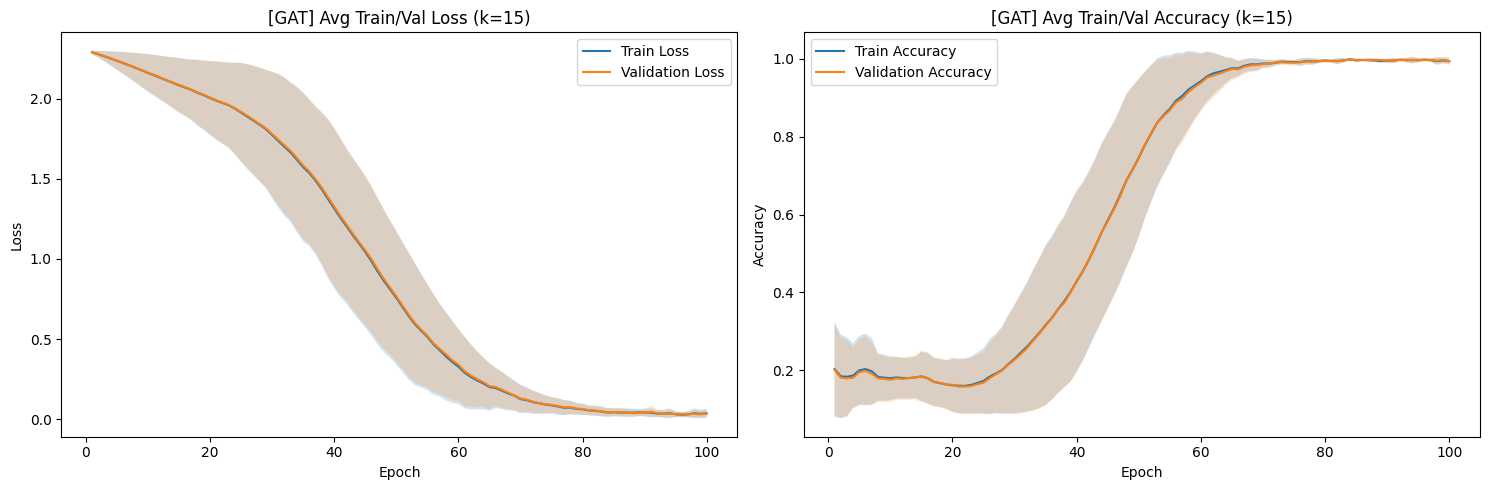

/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr


Starting Experiment: k_15_SAGE
Using existing processed data for k_15_SAGE
Starting k-fold cross-validation for SAGE...

--- Fold 1/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3022, Train Acc: 0.1008, Val Loss: 2.3039, Val Acc: 0.0995
Epoch 020, Train Loss: 2.2875, Train Acc: 0.1042, Val Loss: 2.2906, Val Acc: 0.0995
Epoch 030, Train Loss: 2.2474, Train Acc: 0.1051, Val Loss: 2.2528, Val Acc: 0.1020
Epoch 040, Train Loss: 2.1683, Train Acc: 0.2571, Val Loss: 2.1754, Val Acc: 0.2600
Epoch 050, Train Loss: 2.0216, Train Acc: 0.4068, Val Loss: 2.0325, Val Acc: 0.3831
Epoch 060, Train Loss: 1.8007, Train Acc: 0.6458, Val Loss: 1.8144, Val Acc: 0.6144
Epoch 070, Train Loss: 1.5178, Train Acc: 0.7773, Val Loss: 1.5372, Val Acc: 0.7450
Epoch 080, Train Loss: 1.2371, Train Acc: 0.8359, Val Loss: 1.2613, Val Acc: 0.8097
Epoch 090, Train Loss: 1.0273, Train Acc: 0.8793, Val Loss: 1.0587, Val Acc: 0.8483


[I 2025-01-26 16:55:59,330] Trial 0 finished with value: 0.9132746458053589 and parameters: {'hidden_channels': 51, 'dropout': 0.4573573504120702, 'lr': 0.00015801779771573737}. Best is trial 0 with value: 0.9132746458053589.


Epoch 100, Train Loss: 0.8807, Train Acc: 0.9051, Val Loss: 0.9133, Val Acc: 0.8868


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2962, Train Acc: 0.1014, Val Loss: 2.2969, Val Acc: 0.0983
Epoch 020, Train Loss: 2.2628, Train Acc: 0.2417, Val Loss: 2.2630, Val Acc: 0.2363
Epoch 030, Train Loss: 2.1891, Train Acc: 0.3438, Val Loss: 2.1925, Val Acc: 0.3184
Epoch 040, Train Loss: 2.0621, Train Acc: 0.5667, Val Loss: 2.0704, Val Acc: 0.5572
Epoch 050, Train Loss: 1.8677, Train Acc: 0.7091, Val Loss: 1.8816, Val Acc: 0.6853
Epoch 060, Train Loss: 1.6263, Train Acc: 0.7852, Val Loss: 1.6461, Val Acc: 0.7475
Epoch 070, Train Loss: 1.3624, Train Acc: 0.8588, Val Loss: 1.3871, Val Acc: 0.8433
Epoch 080, Train Loss: 1.1225, Train Acc: 0.9050, Val Loss: 1.1451, Val Acc: 0.9005
Epoch 090, Train Loss: 0.9264, Train Acc: 0.9000, Val Loss: 0.9506, Val Acc: 0.8856


[I 2025-01-26 16:56:01,514] Trial 1 finished with value: 0.8117679357528687 and parameters: {'hidden_channels': 29, 'dropout': 0.283970344366323, 'lr': 0.0004083184953415727}. Best is trial 1 with value: 0.8117679357528687.


Epoch 100, Train Loss: 0.7868, Train Acc: 0.9322, Val Loss: 0.8118, Val Acc: 0.9266


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2775, Train Acc: 0.1218, Val Loss: 2.2783, Val Acc: 0.1318
Epoch 020, Train Loss: 2.2109, Train Acc: 0.1532, Val Loss: 2.2130, Val Acc: 0.1480
Epoch 030, Train Loss: 2.1070, Train Acc: 0.1951, Val Loss: 2.1093, Val Acc: 0.1990
Epoch 040, Train Loss: 1.9069, Train Acc: 0.3032, Val Loss: 1.9131, Val Acc: 0.3047
Epoch 050, Train Loss: 1.5791, Train Acc: 0.5992, Val Loss: 1.5901, Val Acc: 0.5672
Epoch 060, Train Loss: 1.1500, Train Acc: 0.8182, Val Loss: 1.1631, Val Acc: 0.8060
Epoch 070, Train Loss: 0.7052, Train Acc: 0.9196, Val Loss: 0.7316, Val Acc: 0.9080
Epoch 080, Train Loss: 0.4498, Train Acc: 0.9619, Val Loss: 0.4775, Val Acc: 0.9565
Epoch 090, Train Loss: 0.3041, Train Acc: 0.9785, Val Loss: 0.3226, Val Acc: 0.9764


[I 2025-01-26 16:56:03,829] Trial 2 finished with value: 0.2456880658864975 and parameters: {'hidden_channels': 39, 'dropout': 0.22914945649365623, 'lr': 0.0007648876733056409}. Best is trial 2 with value: 0.2456880658864975.


Epoch 100, Train Loss: 0.2239, Train Acc: 0.9880, Val Loss: 0.2457, Val Acc: 0.9826


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2745, Train Acc: 0.2190, Val Loss: 2.2746, Val Acc: 0.2164
Epoch 020, Train Loss: 2.1747, Train Acc: 0.3436, Val Loss: 2.1775, Val Acc: 0.3458
Epoch 030, Train Loss: 1.9686, Train Acc: 0.5917, Val Loss: 1.9774, Val Acc: 0.5572
Epoch 040, Train Loss: 1.6738, Train Acc: 0.7491, Val Loss: 1.6908, Val Acc: 0.7239
Epoch 050, Train Loss: 1.3197, Train Acc: 0.8529, Val Loss: 1.3435, Val Acc: 0.8234
Epoch 060, Train Loss: 0.9632, Train Acc: 0.9001, Val Loss: 0.9873, Val Acc: 0.8843
Epoch 070, Train Loss: 0.6913, Train Acc: 0.9274, Val Loss: 0.7201, Val Acc: 0.9167
Epoch 080, Train Loss: 0.5289, Train Acc: 0.9392, Val Loss: 0.5495, Val Acc: 0.9391
Epoch 090, Train Loss: 0.3670, Train Acc: 0.9622, Val Loss: 0.3939, Val Acc: 0.9540


[I 2025-01-26 16:56:06,006] Trial 3 finished with value: 0.3509875535964966 and parameters: {'hidden_channels': 29, 'dropout': 0.42314426951584605, 'lr': 0.0009709822058163555}. Best is trial 2 with value: 0.2456880658864975.


Epoch 100, Train Loss: 0.3221, Train Acc: 0.9620, Val Loss: 0.3510, Val Acc: 0.9565


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9646, Train Acc: 0.4368, Val Loss: 1.9771, Val Acc: 0.4254
Epoch 020, Train Loss: 1.1167, Train Acc: 0.7107, Val Loss: 1.1265, Val Acc: 0.7102
Epoch 030, Train Loss: 0.6320, Train Acc: 0.8124, Val Loss: 0.6890, Val Acc: 0.7923
Epoch 040, Train Loss: 0.3155, Train Acc: 0.9190, Val Loss: 0.3358, Val Acc: 0.9154
Epoch 050, Train Loss: 0.2569, Train Acc: 0.9270, Val Loss: 0.2845, Val Acc: 0.9229
Epoch 060, Train Loss: 0.1608, Train Acc: 0.9578, Val Loss: 0.1862, Val Acc: 0.9478
Epoch 070, Train Loss: 0.1064, Train Acc: 0.9726, Val Loss: 0.1235, Val Acc: 0.9664
Epoch 080, Train Loss: 0.0584, Train Acc: 0.9899, Val Loss: 0.0657, Val Acc: 0.9851
Epoch 090, Train Loss: 0.0376, Train Acc: 0.9911, Val Loss: 0.0431, Val Acc: 0.9876


[I 2025-01-26 16:56:08,301] Trial 4 finished with value: 0.04176729544997215 and parameters: {'hidden_channels': 37, 'dropout': 0.2778308084096746, 'lr': 0.007007526473498781}. Best is trial 4 with value: 0.04176729544997215.


Epoch 100, Train Loss: 0.0362, Train Acc: 0.9950, Val Loss: 0.0418, Val Acc: 0.9938
  Fold 1 - Optuna Best Trial Val Loss: 0.0418
  Fold 1 - Optuna Best Trial Params: {'hidden_channels': 37, 'dropout': 0.2778308084096746, 'lr': 0.007007526473498781}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9111, Train Acc: 0.5452, Val Loss: 1.9274, Val Acc: 0.5274
Epoch 020, Train Loss: 1.0806, Train Acc: 0.7085, Val Loss: 1.1039, Val Acc: 0.6940
Epoch 030, Train Loss: 0.5388, Train Acc: 0.8511, Val Loss: 0.5559, Val Acc: 0.8408
Epoch 040, Train Loss: 0.2908, Train Acc: 0.9250, Val Loss: 0.3043, Val Acc: 0.9254
Epoch 050, Train Loss: 0.1496, Train Acc: 0.9664, Val Loss: 0.1563, Val Acc: 0.9664
Epoch 060, Train Loss: 0.0746, Train Acc: 0.9854, Val Loss: 0.0829, Val Acc: 0.9813
Epoch 070, Train Loss: 0.0720, Train Acc: 0.9790, Val Loss: 0.0697, Val Acc: 0.9851
Epoch 080, Train Loss: 0.1784, Train Acc: 0.9473, Val Loss: 0.1889, Val Acc: 0.9478


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Early stopping at epoch 89
  Fold 1 Test Metrics:
  Accuracy: 0.9838
  Precision: 0.9846
  Recall: 0.9838
  F1: 0.9840

--- Fold 2/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2570, Train Acc: 0.2968, Val Loss: 2.2578, Val Acc: 0.2848
Epoch 020, Train Loss: 2.1118, Train Acc: 0.3606, Val Loss: 2.1116, Val Acc: 0.3619
Epoch 030, Train Loss: 1.8548, Train Acc: 0.4856, Val Loss: 1.8592, Val Acc: 0.4714
Epoch 040, Train Loss: 1.4688, Train Acc: 0.6888, Val Loss: 1.4846, Val Acc: 0.6878
Epoch 050, Train Loss: 0.9313, Train Acc: 0.8776, Val Loss: 0.9479, Val Acc: 0.8595
Epoch 060, Train Loss: 0.5042, Train Acc: 0.9504, Val Loss: 0.5217, Val Acc: 0.9415
Epoch 070, Train Loss: 0.2961, Train Acc: 0.9740, Val Loss: 0.3233, Val Acc: 0.9664
Epoch 080, Train Loss: 0.2002, Train Acc: 0.9683, Val Loss: 0.2228, Val Acc: 0.9602
Epoch 090, Train Loss: 0.1506, Train Acc: 0.9834, Val Loss: 0.1640, Val Acc: 0.9813


[I 2025-01-26 16:56:12,713] Trial 0 finished with value: 0.12520526349544525 and parameters: {'hidden_channels': 48, 'dropout': 0.209492088510827, 'lr': 0.0011759147513438959}. Best is trial 0 with value: 0.12520526349544525.


Epoch 100, Train Loss: 0.1108, Train Acc: 0.9913, Val Loss: 0.1252, Val Acc: 0.9900


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8354, Train Acc: 0.5926, Val Loss: 1.8310, Val Acc: 0.5858
Epoch 020, Train Loss: 0.9667, Train Acc: 0.7673, Val Loss: 0.9949, Val Acc: 0.7500
Epoch 030, Train Loss: 0.3831, Train Acc: 0.9159, Val Loss: 0.4007, Val Acc: 0.9192
Epoch 040, Train Loss: 0.1864, Train Acc: 0.9555, Val Loss: 0.2020, Val Acc: 0.9515
Epoch 050, Train Loss: 0.0832, Train Acc: 0.9862, Val Loss: 0.0887, Val Acc: 0.9838
Epoch 060, Train Loss: 0.3627, Train Acc: 0.9283, Val Loss: 0.5317, Val Acc: 0.9017
Epoch 070, Train Loss: 0.0753, Train Acc: 0.9860, Val Loss: 0.0885, Val Acc: 0.9863
Epoch 080, Train Loss: 0.0397, Train Acc: 0.9961, Val Loss: 0.0454, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0271, Train Acc: 0.9956, Val Loss: 0.0302, Val Acc: 0.9963


[I 2025-01-26 16:56:15,127] Trial 1 finished with value: 0.03089859150350094 and parameters: {'hidden_channels': 58, 'dropout': 0.34266436106096926, 'lr': 0.006286378618324473}. Best is trial 1 with value: 0.03089859150350094.


Epoch 100, Train Loss: 0.0190, Train Acc: 0.9983, Val Loss: 0.0309, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2872, Train Acc: 0.0986, Val Loss: 2.2882, Val Acc: 0.0970
Epoch 020, Train Loss: 2.2327, Train Acc: 0.1048, Val Loss: 2.2352, Val Acc: 0.1082
Epoch 030, Train Loss: 2.1199, Train Acc: 0.3002, Val Loss: 2.1222, Val Acc: 0.2960
Epoch 040, Train Loss: 1.9306, Train Acc: 0.5418, Val Loss: 1.9327, Val Acc: 0.5224
Epoch 050, Train Loss: 1.6280, Train Acc: 0.7712, Val Loss: 1.6302, Val Acc: 0.7674
Epoch 060, Train Loss: 1.2277, Train Acc: 0.8894, Val Loss: 1.2336, Val Acc: 0.8868
Epoch 070, Train Loss: 0.8410, Train Acc: 0.9508, Val Loss: 0.8542, Val Acc: 0.9515
Epoch 080, Train Loss: 0.5222, Train Acc: 0.9762, Val Loss: 0.5330, Val Acc: 0.9826
Epoch 090, Train Loss: 0.3736, Train Acc: 0.9745, Val Loss: 0.3965, Val Acc: 0.9764


[I 2025-01-26 16:56:17,450] Trial 2 finished with value: 0.29954221844673157 and parameters: {'hidden_channels': 44, 'dropout': 0.41299460780715636, 'lr': 0.0005519092830735148}. Best is trial 1 with value: 0.03089859150350094.


Epoch 100, Train Loss: 0.2930, Train Acc: 0.9774, Val Loss: 0.2995, Val Acc: 0.9776


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2322, Train Acc: 0.2181, Val Loss: 2.2345, Val Acc: 0.2065
Epoch 020, Train Loss: 2.0036, Train Acc: 0.4648, Val Loss: 2.0033, Val Acc: 0.4627
Epoch 030, Train Loss: 1.6675, Train Acc: 0.6534, Val Loss: 1.6731, Val Acc: 0.6405
Epoch 040, Train Loss: 1.2853, Train Acc: 0.7745, Val Loss: 1.2918, Val Acc: 0.7649
Epoch 050, Train Loss: 0.9241, Train Acc: 0.8283, Val Loss: 0.9374, Val Acc: 0.8159
Epoch 060, Train Loss: 0.6745, Train Acc: 0.9014, Val Loss: 0.7113, Val Acc: 0.8881
Epoch 070, Train Loss: 0.4474, Train Acc: 0.9345, Val Loss: 0.4661, Val Acc: 0.9254
Epoch 080, Train Loss: 0.3232, Train Acc: 0.9504, Val Loss: 0.3363, Val Acc: 0.9478
Epoch 090, Train Loss: 0.2952, Train Acc: 0.9358, Val Loss: 0.3388, Val Acc: 0.9154


[I 2025-01-26 16:56:19,557] Trial 3 finished with value: 0.35181924700737 and parameters: {'hidden_channels': 18, 'dropout': 0.2037825448860452, 'lr': 0.002558278835726885}. Best is trial 1 with value: 0.03089859150350094.


Epoch 100, Train Loss: 0.3118, Train Acc: 0.9510, Val Loss: 0.3518, Val Acc: 0.9341


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2416, Train Acc: 0.1461, Val Loss: 2.2439, Val Acc: 0.1405
Epoch 020, Train Loss: 2.0857, Train Acc: 0.4441, Val Loss: 2.0894, Val Acc: 0.4341
Epoch 030, Train Loss: 1.7673, Train Acc: 0.6906, Val Loss: 1.7718, Val Acc: 0.6779
Epoch 040, Train Loss: 1.3406, Train Acc: 0.8085, Val Loss: 1.3529, Val Acc: 0.8047
Epoch 050, Train Loss: 0.9003, Train Acc: 0.8796, Val Loss: 0.9257, Val Acc: 0.8694
Epoch 060, Train Loss: 0.5923, Train Acc: 0.9202, Val Loss: 0.6195, Val Acc: 0.9167
Epoch 070, Train Loss: 0.4022, Train Acc: 0.9387, Val Loss: 0.4275, Val Acc: 0.9303
Epoch 080, Train Loss: 0.2724, Train Acc: 0.9582, Val Loss: 0.3010, Val Acc: 0.9490
Epoch 090, Train Loss: 0.1891, Train Acc: 0.9670, Val Loss: 0.2041, Val Acc: 0.9627


[I 2025-01-26 16:56:21,701] Trial 4 finished with value: 0.2078646421432495 and parameters: {'hidden_channels': 23, 'dropout': 0.38629539543030766, 'lr': 0.002095697569267966}. Best is trial 1 with value: 0.03089859150350094.


Epoch 100, Train Loss: 0.1840, Train Acc: 0.9477, Val Loss: 0.2079, Val Acc: 0.9403
  Fold 2 - Optuna Best Trial Val Loss: 0.0309
  Fold 2 - Optuna Best Trial Params: {'hidden_channels': 58, 'dropout': 0.34266436106096926, 'lr': 0.006286378618324473}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7914, Train Acc: 0.5453, Val Loss: 1.7864, Val Acc: 0.5435
Epoch 020, Train Loss: 0.9655, Train Acc: 0.7166, Val Loss: 0.9760, Val Acc: 0.7201
Epoch 030, Train Loss: 0.5033, Train Acc: 0.8589, Val Loss: 0.5471, Val Acc: 0.8507
Epoch 040, Train Loss: 0.2349, Train Acc: 0.9384, Val Loss: 0.2430, Val Acc: 0.9403
Epoch 050, Train Loss: 0.1527, Train Acc: 0.9603, Val Loss: 0.1682, Val Acc: 0.9527
Epoch 060, Train Loss: 0.0882, Train Acc: 0.9779, Val Loss: 0.1168, Val Acc: 0.9652
Epoch 070, Train Loss: 0.0859, Train Acc: 0.9757, Val Loss: 0.1194, Val Acc: 0.9639
Epoch 080, Train Loss: 0.0392, Train Acc: 0.9930, Val Loss: 0.0443, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0429, Train Acc: 0.9936, Val Loss: 0.0651, Val Acc: 0.9888


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0276, Train Acc: 0.9922, Val Loss: 0.0257, Val Acc: 0.9938
  Fold 2 Test Metrics:
  Accuracy: 0.9925
  Precision: 0.9928
  Recall: 0.9925
  F1: 0.9925

--- Fold 3/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.5776, Train Acc: 0.5936, Val Loss: 1.5958, Val Acc: 0.5908
Epoch 020, Train Loss: 0.8042, Train Acc: 0.7620, Val Loss: 0.8041, Val Acc: 0.7575
Epoch 030, Train Loss: 0.3518, Train Acc: 0.9103, Val Loss: 0.3483, Val Acc: 0.9129
Epoch 040, Train Loss: 0.2004, Train Acc: 0.9487, Val Loss: 0.1859, Val Acc: 0.9552
Epoch 050, Train Loss: 0.1483, Train Acc: 0.9571, Val Loss: 0.1296, Val Acc: 0.9602
Epoch 060, Train Loss: 0.0873, Train Acc: 0.9799, Val Loss: 0.0826, Val Acc: 0.9801
Epoch 070, Train Loss: 0.0512, Train Acc: 0.9900, Val Loss: 0.0430, Val Acc: 0.9963
Epoch 080, Train Loss: 0.0297, Train Acc: 0.9969, Val Loss: 0.0206, Val Acc: 1.0000
Epoch 090, Train Loss: 0.0499, Train Acc: 0.9882, Val Loss: 0.0496, Val Acc: 0.9888


[I 2025-01-26 16:56:26,630] Trial 0 finished with value: 0.038682833313941956 and parameters: {'hidden_channels': 64, 'dropout': 0.3651195952041668, 'lr': 0.007863174335703719}. Best is trial 0 with value: 0.038682833313941956.


Epoch 100, Train Loss: 0.0388, Train Acc: 0.9877, Val Loss: 0.0387, Val Acc: 0.9863


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2953, Train Acc: 0.1011, Val Loss: 2.2972, Val Acc: 0.1020
Epoch 020, Train Loss: 2.2669, Train Acc: 0.1506, Val Loss: 2.2671, Val Acc: 0.1555
Epoch 030, Train Loss: 2.1809, Train Acc: 0.3217, Val Loss: 2.1800, Val Acc: 0.3097
Epoch 040, Train Loss: 2.0147, Train Acc: 0.4374, Val Loss: 2.0108, Val Acc: 0.4316
Epoch 050, Train Loss: 1.7370, Train Acc: 0.7280, Val Loss: 1.7319, Val Acc: 0.7301
Epoch 060, Train Loss: 1.4356, Train Acc: 0.8367, Val Loss: 1.4265, Val Acc: 0.8458
Epoch 070, Train Loss: 1.1239, Train Acc: 0.9129, Val Loss: 1.1169, Val Acc: 0.9179
Epoch 080, Train Loss: 0.8678, Train Acc: 0.9311, Val Loss: 0.8641, Val Acc: 0.9341
Epoch 090, Train Loss: 0.6979, Train Acc: 0.9241, Val Loss: 0.6963, Val Acc: 0.9328


[I 2025-01-26 16:56:28,939] Trial 1 finished with value: 0.5669743418693542 and parameters: {'hidden_channels': 41, 'dropout': 0.4194139607986672, 'lr': 0.0003433782519498109}. Best is trial 0 with value: 0.038682833313941956.


Epoch 100, Train Loss: 0.5728, Train Acc: 0.9454, Val Loss: 0.5670, Val Acc: 0.9565


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3049, Train Acc: 0.1361, Val Loss: 2.3067, Val Acc: 0.1393
Epoch 020, Train Loss: 2.2897, Train Acc: 0.1019, Val Loss: 2.2930, Val Acc: 0.0995
Epoch 030, Train Loss: 2.2671, Train Acc: 0.1649, Val Loss: 2.2699, Val Acc: 0.1580
Epoch 040, Train Loss: 2.2234, Train Acc: 0.1870, Val Loss: 2.2267, Val Acc: 0.1803
Epoch 050, Train Loss: 2.1508, Train Acc: 0.2162, Val Loss: 2.1552, Val Acc: 0.2077
Epoch 060, Train Loss: 2.0467, Train Acc: 0.3564, Val Loss: 2.0511, Val Acc: 0.3383
Epoch 070, Train Loss: 1.9230, Train Acc: 0.4713, Val Loss: 1.9256, Val Acc: 0.4714
Epoch 080, Train Loss: 1.7839, Train Acc: 0.5376, Val Loss: 1.7874, Val Acc: 0.5498
Epoch 090, Train Loss: 1.6469, Train Acc: 0.5749, Val Loss: 1.6520, Val Acc: 0.5846


[I 2025-01-26 16:56:31,006] Trial 2 finished with value: 1.5545299053192139 and parameters: {'hidden_channels': 16, 'dropout': 0.2458529395497782, 'lr': 0.00018467693747618532}. Best is trial 0 with value: 0.038682833313941956.


Epoch 100, Train Loss: 1.5502, Train Acc: 0.6146, Val Loss: 1.5545, Val Acc: 0.6256


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2977, Train Acc: 0.1053, Val Loss: 2.2970, Val Acc: 0.1070
Epoch 020, Train Loss: 2.2805, Train Acc: 0.1070, Val Loss: 2.2807, Val Acc: 0.0983
Epoch 030, Train Loss: 2.2328, Train Acc: 0.2123, Val Loss: 2.2331, Val Acc: 0.2114
Epoch 040, Train Loss: 2.1204, Train Acc: 0.4870, Val Loss: 2.1209, Val Acc: 0.4652
Epoch 050, Train Loss: 1.9222, Train Acc: 0.7191, Val Loss: 1.9254, Val Acc: 0.7077
Epoch 060, Train Loss: 1.6205, Train Acc: 0.8175, Val Loss: 1.6247, Val Acc: 0.8197
Epoch 070, Train Loss: 1.2680, Train Acc: 0.8872, Val Loss: 1.2728, Val Acc: 0.8980
Epoch 080, Train Loss: 0.9796, Train Acc: 0.9157, Val Loss: 0.9813, Val Acc: 0.9266
Epoch 090, Train Loss: 0.7904, Train Acc: 0.9291, Val Loss: 0.7898, Val Acc: 0.9403


[I 2025-01-26 16:56:33,279] Trial 3 finished with value: 0.6619108319282532 and parameters: {'hidden_channels': 36, 'dropout': 0.39686073903778335, 'lr': 0.00032663432154841893}. Best is trial 0 with value: 0.038682833313941956.


Epoch 100, Train Loss: 0.6593, Train Acc: 0.9396, Val Loss: 0.6619, Val Acc: 0.9465


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.6370, Train Acc: 0.5998, Val Loss: 1.6572, Val Acc: 0.5908
Epoch 020, Train Loss: 0.8514, Train Acc: 0.7388, Val Loss: 0.8600, Val Acc: 0.7214
Epoch 030, Train Loss: 0.3523, Train Acc: 0.8894, Val Loss: 0.3585, Val Acc: 0.8980
Epoch 040, Train Loss: 0.1925, Train Acc: 0.9505, Val Loss: 0.2061, Val Acc: 0.9403
Epoch 050, Train Loss: 0.0914, Train Acc: 0.9722, Val Loss: 0.0957, Val Acc: 0.9689
Epoch 060, Train Loss: 0.1463, Train Acc: 0.9680, Val Loss: 0.1222, Val Acc: 0.9726
Epoch 070, Train Loss: 0.0636, Train Acc: 0.9840, Val Loss: 0.0593, Val Acc: 0.9863
Epoch 080, Train Loss: 0.0462, Train Acc: 0.9899, Val Loss: 0.0372, Val Acc: 0.9938
Epoch 090, Train Loss: 0.0248, Train Acc: 0.9966, Val Loss: 0.0191, Val Acc: 0.9988


[I 2025-01-26 16:56:35,685] Trial 4 finished with value: 0.028713060542941093 and parameters: {'hidden_channels': 59, 'dropout': 0.2119631159427005, 'lr': 0.006680844070047983}. Best is trial 4 with value: 0.028713060542941093.


Epoch 100, Train Loss: 0.0260, Train Acc: 0.9947, Val Loss: 0.0287, Val Acc: 0.9938
  Fold 3 - Optuna Best Trial Val Loss: 0.0287
  Fold 3 - Optuna Best Trial Params: {'hidden_channels': 59, 'dropout': 0.2119631159427005, 'lr': 0.006680844070047983}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.6503, Train Acc: 0.6220, Val Loss: 1.6618, Val Acc: 0.6306
Epoch 020, Train Loss: 0.7977, Train Acc: 0.7748, Val Loss: 0.8095, Val Acc: 0.7799
Epoch 030, Train Loss: 0.3595, Train Acc: 0.9113, Val Loss: 0.3504, Val Acc: 0.9216
Epoch 040, Train Loss: 0.1725, Train Acc: 0.9494, Val Loss: 0.1557, Val Acc: 0.9602
Epoch 050, Train Loss: 0.0801, Train Acc: 0.9832, Val Loss: 0.0749, Val Acc: 0.9838
Epoch 060, Train Loss: 0.0534, Train Acc: 0.9879, Val Loss: 0.0577, Val Acc: 0.9838
Epoch 070, Train Loss: 0.0446, Train Acc: 0.9927, Val Loss: 0.0388, Val Acc: 0.9950
Epoch 080, Train Loss: 0.0285, Train Acc: 0.9972, Val Loss: 0.0257, Val Acc: 0.9988
Epoch 090, Train Loss: 0.0123, Train Acc: 0.9998, Val Loss: 0.0111, Val Acc: 1.0000


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0126, Train Acc: 0.9983, Val Loss: 0.0113, Val Acc: 0.9988
  Fold 3 Test Metrics:
  Accuracy: 0.9963
  Precision: 0.9963
  Recall: 0.9963
  F1: 0.9963

--- Fold 4/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3040, Train Acc: 0.1513, Val Loss: 2.3039, Val Acc: 0.1580
Epoch 020, Train Loss: 2.2863, Train Acc: 0.1168, Val Loss: 2.2862, Val Acc: 0.1294
Epoch 030, Train Loss: 2.2370, Train Acc: 0.1748, Val Loss: 2.2381, Val Acc: 0.1866
Epoch 040, Train Loss: 2.1311, Train Acc: 0.3074, Val Loss: 2.1313, Val Acc: 0.3022
Epoch 050, Train Loss: 1.9604, Train Acc: 0.4643, Val Loss: 1.9613, Val Acc: 0.4602
Epoch 060, Train Loss: 1.6974, Train Acc: 0.7194, Val Loss: 1.7071, Val Acc: 0.6828
Epoch 070, Train Loss: 1.4267, Train Acc: 0.8521, Val Loss: 1.4456, Val Acc: 0.8458
Epoch 080, Train Loss: 1.1525, Train Acc: 0.9084, Val Loss: 1.1834, Val Acc: 0.9042
Epoch 090, Train Loss: 0.9492, Train Acc: 0.9224, Val Loss: 0.9795, Val Acc: 0.9303


[I 2025-01-26 16:56:40,246] Trial 0 finished with value: 0.8825522661209106 and parameters: {'hidden_channels': 26, 'dropout': 0.4783938478658325, 'lr': 0.0004066018564140765}. Best is trial 0 with value: 0.8825522661209106.


Epoch 100, Train Loss: 0.8514, Train Acc: 0.9225, Val Loss: 0.8826, Val Acc: 0.9216


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2408, Train Acc: 0.3126, Val Loss: 2.2357, Val Acc: 0.2998
Epoch 020, Train Loss: 2.0917, Train Acc: 0.3797, Val Loss: 2.0874, Val Acc: 0.3955
Epoch 030, Train Loss: 1.8236, Train Acc: 0.5128, Val Loss: 1.8252, Val Acc: 0.5075
Epoch 040, Train Loss: 1.4433, Train Acc: 0.6788, Val Loss: 1.4539, Val Acc: 0.6654
Epoch 050, Train Loss: 0.9370, Train Acc: 0.8415, Val Loss: 0.9476, Val Acc: 0.8483
Epoch 060, Train Loss: 0.5419, Train Acc: 0.9261, Val Loss: 0.5551, Val Acc: 0.9204
Epoch 070, Train Loss: 0.3155, Train Acc: 0.9505, Val Loss: 0.3314, Val Acc: 0.9440
Epoch 080, Train Loss: 0.2602, Train Acc: 0.9614, Val Loss: 0.2796, Val Acc: 0.9565
Epoch 090, Train Loss: 0.2093, Train Acc: 0.9795, Val Loss: 0.2333, Val Acc: 0.9664


[I 2025-01-26 16:56:42,449] Trial 1 finished with value: 0.15659187734127045 and parameters: {'hidden_channels': 32, 'dropout': 0.21488379775598837, 'lr': 0.0016050477134963847}. Best is trial 1 with value: 0.15659187734127045.


Epoch 100, Train Loss: 0.1387, Train Acc: 0.9900, Val Loss: 0.1566, Val Acc: 0.9813


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2958, Train Acc: 0.1014, Val Loss: 2.2989, Val Acc: 0.1007
Epoch 020, Train Loss: 2.2691, Train Acc: 0.1101, Val Loss: 2.2746, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2193, Train Acc: 0.1076, Val Loss: 2.2245, Val Acc: 0.1020
Epoch 040, Train Loss: 2.1229, Train Acc: 0.2178, Val Loss: 2.1301, Val Acc: 0.1965
Epoch 050, Train Loss: 1.9808, Train Acc: 0.5593, Val Loss: 1.9882, Val Acc: 0.5361
Epoch 060, Train Loss: 1.7941, Train Acc: 0.6942, Val Loss: 1.8002, Val Acc: 0.6903
Epoch 070, Train Loss: 1.5895, Train Acc: 0.7698, Val Loss: 1.5971, Val Acc: 0.7525
Epoch 080, Train Loss: 1.3810, Train Acc: 0.8112, Val Loss: 1.3921, Val Acc: 0.7998
Epoch 090, Train Loss: 1.2307, Train Acc: 0.8508, Val Loss: 1.2428, Val Acc: 0.8433


[I 2025-01-26 16:56:44,630] Trial 2 finished with value: 1.1334971189498901 and parameters: {'hidden_channels': 28, 'dropout': 0.3813178465938619, 'lr': 0.00022749564825973672}. Best is trial 1 with value: 0.15659187734127045.


Epoch 100, Train Loss: 1.1146, Train Acc: 0.8697, Val Loss: 1.1335, Val Acc: 0.8470


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2237, Train Acc: 0.1898, Val Loss: 2.2249, Val Acc: 0.1841
Epoch 020, Train Loss: 2.0139, Train Acc: 0.4962, Val Loss: 2.0205, Val Acc: 0.4876
Epoch 030, Train Loss: 1.6518, Train Acc: 0.7314, Val Loss: 1.6665, Val Acc: 0.7040
Epoch 040, Train Loss: 1.1085, Train Acc: 0.8585, Val Loss: 1.1361, Val Acc: 0.8234
Epoch 050, Train Loss: 0.6034, Train Acc: 0.9387, Val Loss: 0.6392, Val Acc: 0.9266
Epoch 060, Train Loss: 0.3400, Train Acc: 0.9603, Val Loss: 0.3585, Val Acc: 0.9565
Epoch 070, Train Loss: 0.2040, Train Acc: 0.9681, Val Loss: 0.2204, Val Acc: 0.9627
Epoch 080, Train Loss: 0.1643, Train Acc: 0.9798, Val Loss: 0.1912, Val Acc: 0.9739
Epoch 090, Train Loss: 0.0918, Train Acc: 0.9944, Val Loss: 0.0991, Val Acc: 0.9900


[I 2025-01-26 16:56:46,929] Trial 3 finished with value: 0.07999219000339508 and parameters: {'hidden_channels': 38, 'dropout': 0.26247574738708573, 'lr': 0.0019159753988743416}. Best is trial 3 with value: 0.07999219000339508.


Epoch 100, Train Loss: 0.0690, Train Acc: 0.9919, Val Loss: 0.0800, Val Acc: 0.9913


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0027, Train Acc: 0.5124, Val Loss: 1.9984, Val Acc: 0.5348
Epoch 020, Train Loss: 1.2648, Train Acc: 0.6771, Val Loss: 1.2682, Val Acc: 0.6779
Epoch 030, Train Loss: 0.6777, Train Acc: 0.8221, Val Loss: 0.6962, Val Acc: 0.8085
Epoch 040, Train Loss: 0.3270, Train Acc: 0.9126, Val Loss: 0.3383, Val Acc: 0.9154
Epoch 050, Train Loss: 0.1856, Train Acc: 0.9558, Val Loss: 0.1910, Val Acc: 0.9552
Epoch 060, Train Loss: 0.1223, Train Acc: 0.9742, Val Loss: 0.1292, Val Acc: 0.9739
Epoch 070, Train Loss: 0.0776, Train Acc: 0.9888, Val Loss: 0.0831, Val Acc: 0.9851
Epoch 080, Train Loss: 0.0479, Train Acc: 0.9941, Val Loss: 0.0544, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0271, Train Acc: 0.9977, Val Loss: 0.0305, Val Acc: 0.9963


[I 2025-01-26 16:56:49,254] Trial 4 finished with value: 0.09038832038640976 and parameters: {'hidden_channels': 41, 'dropout': 0.44804842507858883, 'lr': 0.00515306327663334}. Best is trial 3 with value: 0.07999219000339508.


Epoch 100, Train Loss: 0.0864, Train Acc: 0.9824, Val Loss: 0.0904, Val Acc: 0.9826
  Fold 4 - Optuna Best Trial Val Loss: 0.0800
  Fold 4 - Optuna Best Trial Params: {'hidden_channels': 38, 'dropout': 0.26247574738708573, 'lr': 0.0019159753988743416}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2327, Train Acc: 0.2112, Val Loss: 2.2320, Val Acc: 0.2077
Epoch 020, Train Loss: 2.0528, Train Acc: 0.2716, Val Loss: 2.0611, Val Acc: 0.2624
Epoch 030, Train Loss: 1.7214, Train Acc: 0.4055, Val Loss: 1.7405, Val Acc: 0.3769
Epoch 040, Train Loss: 1.2339, Train Acc: 0.6827, Val Loss: 1.2576, Val Acc: 0.6667
Epoch 050, Train Loss: 0.7018, Train Acc: 0.9067, Val Loss: 0.7227, Val Acc: 0.9117
Epoch 060, Train Loss: 0.3464, Train Acc: 0.9549, Val Loss: 0.3701, Val Acc: 0.9478
Epoch 070, Train Loss: 0.2301, Train Acc: 0.9765, Val Loss: 0.2456, Val Acc: 0.9726
Epoch 080, Train Loss: 0.1810, Train Acc: 0.9784, Val Loss: 0.2007, Val Acc: 0.9789
Epoch 090, Train Loss: 0.1334, Train Acc: 0.9798, Val Loss: 0.1473, Val Acc: 0.9776


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0910, Train Acc: 0.9933, Val Loss: 0.1171, Val Acc: 0.9900
  Fold 4 Test Metrics:
  Accuracy: 0.9963
  Precision: 0.9964
  Recall: 0.9963
  F1: 0.9963

--- Fold 5/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3025, Train Acc: 0.0997, Val Loss: 2.3032, Val Acc: 0.0995
Epoch 020, Train Loss: 2.2976, Train Acc: 0.1011, Val Loss: 2.2997, Val Acc: 0.1032
Epoch 030, Train Loss: 2.2721, Train Acc: 0.1681, Val Loss: 2.2755, Val Acc: 0.1679
Epoch 040, Train Loss: 2.2137, Train Acc: 0.1952, Val Loss: 2.2185, Val Acc: 0.2040
Epoch 050, Train Loss: 2.0975, Train Acc: 0.3411, Val Loss: 2.1038, Val Acc: 0.3321
Epoch 060, Train Loss: 1.8971, Train Acc: 0.6276, Val Loss: 1.9072, Val Acc: 0.6157
Epoch 070, Train Loss: 1.6353, Train Acc: 0.7421, Val Loss: 1.6472, Val Acc: 0.7463
Epoch 080, Train Loss: 1.3724, Train Acc: 0.8121, Val Loss: 1.3864, Val Acc: 0.8184
Epoch 090, Train Loss: 1.1735, Train Acc: 0.8465, Val Loss: 1.1882, Val Acc: 0.8433


[I 2025-01-26 16:56:53,923] Trial 0 finished with value: 1.0634058713912964 and parameters: {'hidden_channels': 49, 'dropout': 0.30557097662550403, 'lr': 0.00010746224347538204}. Best is trial 0 with value: 1.0634058713912964.


Epoch 100, Train Loss: 1.0486, Train Acc: 0.8796, Val Loss: 1.0634, Val Acc: 0.8930


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1273, Train Acc: 0.3224, Val Loss: 2.1364, Val Acc: 0.3010
Epoch 020, Train Loss: 1.5976, Train Acc: 0.6307, Val Loss: 1.6140, Val Acc: 0.6356
Epoch 030, Train Loss: 1.0150, Train Acc: 0.7639, Val Loss: 1.0395, Val Acc: 0.7687
Epoch 040, Train Loss: 0.6009, Train Acc: 0.8672, Val Loss: 0.5952, Val Acc: 0.8806
Epoch 050, Train Loss: 0.3666, Train Acc: 0.8994, Val Loss: 0.3523, Val Acc: 0.9104
Epoch 060, Train Loss: 0.2465, Train Acc: 0.9317, Val Loss: 0.2354, Val Acc: 0.9353
Epoch 070, Train Loss: 0.1523, Train Acc: 0.9653, Val Loss: 0.1455, Val Acc: 0.9726
Epoch 080, Train Loss: 0.1550, Train Acc: 0.9501, Val Loss: 0.1256, Val Acc: 0.9565
Epoch 090, Train Loss: 0.0828, Train Acc: 0.9743, Val Loss: 0.0944, Val Acc: 0.9689


[I 2025-01-26 16:56:56,047] Trial 1 finished with value: 0.043038178235292435 and parameters: {'hidden_channels': 25, 'dropout': 0.45031387499589703, 'lr': 0.005759764858701}. Best is trial 1 with value: 0.043038178235292435.


Epoch 100, Train Loss: 0.0653, Train Acc: 0.9877, Val Loss: 0.0430, Val Acc: 0.9925


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3080, Train Acc: 0.1014, Val Loss: 2.3076, Val Acc: 0.1045
Epoch 020, Train Loss: 2.3040, Train Acc: 0.1013, Val Loss: 2.3046, Val Acc: 0.1045
Epoch 030, Train Loss: 2.2856, Train Acc: 0.1020, Val Loss: 2.2879, Val Acc: 0.1070
Epoch 040, Train Loss: 2.2360, Train Acc: 0.1825, Val Loss: 2.2403, Val Acc: 0.1816
Epoch 050, Train Loss: 2.1402, Train Acc: 0.3438, Val Loss: 2.1452, Val Acc: 0.3308
Epoch 060, Train Loss: 1.9779, Train Acc: 0.5998, Val Loss: 1.9851, Val Acc: 0.5759
Epoch 070, Train Loss: 1.7728, Train Acc: 0.7250, Val Loss: 1.7829, Val Acc: 0.7425
Epoch 080, Train Loss: 1.5573, Train Acc: 0.8095, Val Loss: 1.5685, Val Acc: 0.8197
Epoch 090, Train Loss: 1.3874, Train Acc: 0.8208, Val Loss: 1.3954, Val Acc: 0.8321


[I 2025-01-26 16:56:58,343] Trial 2 finished with value: 1.290020227432251 and parameters: {'hidden_channels': 40, 'dropout': 0.47645722376406907, 'lr': 0.00010649544710441313}. Best is trial 1 with value: 0.043038178235292435.


Epoch 100, Train Loss: 1.2790, Train Acc: 0.8522, Val Loss: 1.2900, Val Acc: 0.8657


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2316, Train Acc: 0.1968, Val Loss: 2.2311, Val Acc: 0.1978
Epoch 020, Train Loss: 1.9694, Train Acc: 0.4833, Val Loss: 1.9741, Val Acc: 0.4614
Epoch 030, Train Loss: 1.5447, Train Acc: 0.7224, Val Loss: 1.5563, Val Acc: 0.7239
Epoch 040, Train Loss: 1.1001, Train Acc: 0.8415, Val Loss: 1.1092, Val Acc: 0.8520
Epoch 050, Train Loss: 0.7320, Train Acc: 0.8987, Val Loss: 0.7438, Val Acc: 0.9104
Epoch 060, Train Loss: 0.5128, Train Acc: 0.9008, Val Loss: 0.5200, Val Acc: 0.9117
Epoch 070, Train Loss: 0.3560, Train Acc: 0.9204, Val Loss: 0.3529, Val Acc: 0.9254
Epoch 080, Train Loss: 0.2738, Train Acc: 0.9488, Val Loss: 0.2843, Val Acc: 0.9490
Epoch 090, Train Loss: 0.2449, Train Acc: 0.9409, Val Loss: 0.2647, Val Acc: 0.9316


[I 2025-01-26 16:57:00,478] Trial 3 finished with value: 0.1559157371520996 and parameters: {'hidden_channels': 24, 'dropout': 0.4180628696912407, 'lr': 0.002461372175848483}. Best is trial 1 with value: 0.043038178235292435.


Epoch 100, Train Loss: 0.1539, Train Acc: 0.9669, Val Loss: 0.1559, Val Acc: 0.9664


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3015, Train Acc: 0.1002, Val Loss: 2.3017, Val Acc: 0.0995
Epoch 020, Train Loss: 2.2798, Train Acc: 0.1378, Val Loss: 2.2806, Val Acc: 0.1343
Epoch 030, Train Loss: 2.2352, Train Acc: 0.3052, Val Loss: 2.2374, Val Acc: 0.2973
Epoch 040, Train Loss: 2.1445, Train Acc: 0.4498, Val Loss: 2.1481, Val Acc: 0.4415
Epoch 050, Train Loss: 1.9863, Train Acc: 0.6141, Val Loss: 1.9919, Val Acc: 0.6045
Epoch 060, Train Loss: 1.7493, Train Acc: 0.7656, Val Loss: 1.7590, Val Acc: 0.7823
Epoch 070, Train Loss: 1.4439, Train Acc: 0.8426, Val Loss: 1.4553, Val Acc: 0.8557
Epoch 080, Train Loss: 1.1563, Train Acc: 0.8871, Val Loss: 1.1697, Val Acc: 0.8930
Epoch 090, Train Loss: 0.9402, Train Acc: 0.9078, Val Loss: 0.9563, Val Acc: 0.9092


[I 2025-01-26 16:57:02,866] Trial 4 finished with value: 0.809563934803009 and parameters: {'hidden_channels': 53, 'dropout': 0.27948367727933376, 'lr': 0.00015973482509352042}. Best is trial 1 with value: 0.043038178235292435.


Epoch 100, Train Loss: 0.7938, Train Acc: 0.9211, Val Loss: 0.8096, Val Acc: 0.9254
  Fold 5 - Optuna Best Trial Val Loss: 0.0430
  Fold 5 - Optuna Best Trial Params: {'hidden_channels': 25, 'dropout': 0.45031387499589703, 'lr': 0.005759764858701}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0890, Train Acc: 0.3685, Val Loss: 2.0975, Val Acc: 0.3557
Epoch 020, Train Loss: 1.5151, Train Acc: 0.5903, Val Loss: 1.5330, Val Acc: 0.5771
Epoch 030, Train Loss: 0.9664, Train Acc: 0.7468, Val Loss: 0.9666, Val Acc: 0.7587
Epoch 040, Train Loss: 0.5569, Train Acc: 0.8692, Val Loss: 0.5609, Val Acc: 0.8694
Epoch 050, Train Loss: 0.3340, Train Acc: 0.9193, Val Loss: 0.3400, Val Acc: 0.9129
Epoch 060, Train Loss: 0.2379, Train Acc: 0.9255, Val Loss: 0.2478, Val Acc: 0.9104
Epoch 070, Train Loss: 0.1502, Train Acc: 0.9586, Val Loss: 0.1358, Val Acc: 0.9639
Epoch 080, Train Loss: 0.0902, Train Acc: 0.9809, Val Loss: 0.0853, Val Acc: 0.9789
Epoch 090, Train Loss: 0.1394, Train Acc: 0.9645, Val Loss: 0.1554, Val Acc: 0.9701


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1735, Train Acc: 0.9536, Val Loss: 0.1821, Val Acc: 0.9627
  Fold 5 Test Metrics:
  Accuracy: 0.9391
  Precision: 0.9504
  Recall: 0.9391
  F1: 0.9389

--- Fold 6/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2610, Train Acc: 0.1854, Val Loss: 2.2694, Val Acc: 0.2015
Epoch 020, Train Loss: 2.1619, Train Acc: 0.2097, Val Loss: 2.1637, Val Acc: 0.2102
Epoch 030, Train Loss: 1.9503, Train Acc: 0.4215, Val Loss: 1.9519, Val Acc: 0.4266
Epoch 040, Train Loss: 1.6190, Train Acc: 0.6573, Val Loss: 1.6227, Val Acc: 0.6530
Epoch 050, Train Loss: 1.2457, Train Acc: 0.8076, Val Loss: 1.2387, Val Acc: 0.7948
Epoch 060, Train Loss: 0.8725, Train Acc: 0.9036, Val Loss: 0.8700, Val Acc: 0.8818
Epoch 070, Train Loss: 0.6352, Train Acc: 0.9020, Val Loss: 0.6352, Val Acc: 0.8868
Epoch 080, Train Loss: 0.5303, Train Acc: 0.9076, Val Loss: 0.5350, Val Acc: 0.8843
Epoch 090, Train Loss: 0.4492, Train Acc: 0.9305, Val Loss: 0.4471, Val Acc: 0.9279


[I 2025-01-26 16:57:07,131] Trial 0 finished with value: 0.3274093568325043 and parameters: {'hidden_channels': 16, 'dropout': 0.39131370104174656, 'lr': 0.00207857106568726}. Best is trial 0 with value: 0.3274093568325043.


Epoch 100, Train Loss: 0.3126, Train Acc: 0.9502, Val Loss: 0.3274, Val Acc: 0.9453


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2638, Train Acc: 0.1067, Val Loss: 2.2609, Val Acc: 0.1020
Epoch 020, Train Loss: 2.1915, Train Acc: 0.2447, Val Loss: 2.1945, Val Acc: 0.2463
Epoch 030, Train Loss: 2.0433, Train Acc: 0.3872, Val Loss: 2.0453, Val Acc: 0.3843
Epoch 040, Train Loss: 1.7568, Train Acc: 0.7180, Val Loss: 1.7579, Val Acc: 0.7127
Epoch 050, Train Loss: 1.3425, Train Acc: 0.8796, Val Loss: 1.3519, Val Acc: 0.8694
Epoch 060, Train Loss: 0.8727, Train Acc: 0.9294, Val Loss: 0.8718, Val Acc: 0.9192
Epoch 070, Train Loss: 0.5038, Train Acc: 0.9608, Val Loss: 0.5134, Val Acc: 0.9565
Epoch 080, Train Loss: 0.2916, Train Acc: 0.9768, Val Loss: 0.3020, Val Acc: 0.9689
Epoch 090, Train Loss: 0.1906, Train Acc: 0.9919, Val Loss: 0.2019, Val Acc: 0.9851


[I 2025-01-26 16:57:09,469] Trial 1 finished with value: 0.1433059275150299 and parameters: {'hidden_channels': 43, 'dropout': 0.24806032619863158, 'lr': 0.0009778255479173533}. Best is trial 1 with value: 0.1433059275150299.


Epoch 100, Train Loss: 0.1355, Train Acc: 0.9910, Val Loss: 0.1433, Val Acc: 0.9876


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2201, Train Acc: 0.1591, Val Loss: 2.2228, Val Acc: 0.1667
Epoch 020, Train Loss: 2.0741, Train Acc: 0.2633, Val Loss: 2.0800, Val Acc: 0.2637
Epoch 030, Train Loss: 1.8348, Train Acc: 0.3198, Val Loss: 1.8406, Val Acc: 0.3085
Epoch 040, Train Loss: 1.4090, Train Acc: 0.5671, Val Loss: 1.4105, Val Acc: 0.5386
Epoch 050, Train Loss: 0.8467, Train Acc: 0.8331, Val Loss: 0.8549, Val Acc: 0.8296
Epoch 060, Train Loss: 0.4089, Train Acc: 0.9501, Val Loss: 0.4248, Val Acc: 0.9303
Epoch 070, Train Loss: 0.2615, Train Acc: 0.9606, Val Loss: 0.2663, Val Acc: 0.9552
Epoch 080, Train Loss: 0.1587, Train Acc: 0.9849, Val Loss: 0.1979, Val Acc: 0.9776
Epoch 090, Train Loss: 0.0748, Train Acc: 0.9966, Val Loss: 0.0729, Val Acc: 0.9988


[I 2025-01-26 16:57:11,853] Trial 2 finished with value: 0.1107327938079834 and parameters: {'hidden_channels': 52, 'dropout': 0.2540228689592837, 'lr': 0.0013074515240286903}. Best is trial 2 with value: 0.1107327938079834.


Epoch 100, Train Loss: 0.0834, Train Acc: 0.9890, Val Loss: 0.1107, Val Acc: 0.9813


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7060, Train Acc: 0.5229, Val Loss: 1.7000, Val Acc: 0.5187
Epoch 020, Train Loss: 0.8738, Train Acc: 0.7096, Val Loss: 0.8745, Val Acc: 0.7164
Epoch 030, Train Loss: 0.4551, Train Acc: 0.8644, Val Loss: 0.4589, Val Acc: 0.8619
Epoch 040, Train Loss: 0.2496, Train Acc: 0.9225, Val Loss: 0.2800, Val Acc: 0.9080
Epoch 050, Train Loss: 0.1465, Train Acc: 0.9550, Val Loss: 0.1596, Val Acc: 0.9502
Epoch 060, Train Loss: 0.1042, Train Acc: 0.9812, Val Loss: 0.1182, Val Acc: 0.9764
Epoch 070, Train Loss: 0.0780, Train Acc: 0.9792, Val Loss: 0.0889, Val Acc: 0.9739
Epoch 080, Train Loss: 0.0774, Train Acc: 0.9745, Val Loss: 0.0781, Val Acc: 0.9726
Epoch 090, Train Loss: 0.0544, Train Acc: 0.9857, Val Loss: 0.0636, Val Acc: 0.9789


[I 2025-01-26 16:57:14,194] Trial 3 finished with value: 0.019755464047193527 and parameters: {'hidden_channels': 47, 'dropout': 0.2676839603475646, 'lr': 0.007704593453854819}. Best is trial 3 with value: 0.019755464047193527.


Epoch 100, Train Loss: 0.0187, Train Acc: 0.9975, Val Loss: 0.0198, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.7472, Train Acc: 0.5516, Val Loss: 1.7443, Val Acc: 0.5473
Epoch 020, Train Loss: 0.8186, Train Acc: 0.7782, Val Loss: 0.8241, Val Acc: 0.7786
Epoch 030, Train Loss: 0.4420, Train Acc: 0.8639, Val Loss: 0.4555, Val Acc: 0.8619
Epoch 040, Train Loss: 0.2361, Train Acc: 0.9274, Val Loss: 0.2517, Val Acc: 0.9204
Epoch 050, Train Loss: 0.1679, Train Acc: 0.9561, Val Loss: 0.1542, Val Acc: 0.9552
Epoch 060, Train Loss: 0.1061, Train Acc: 0.9711, Val Loss: 0.1150, Val Acc: 0.9677
Epoch 070, Train Loss: 0.0960, Train Acc: 0.9756, Val Loss: 0.1088, Val Acc: 0.9714
Epoch 080, Train Loss: 0.0517, Train Acc: 0.9911, Val Loss: 0.0636, Val Acc: 0.9913
Epoch 090, Train Loss: 0.0444, Train Acc: 0.9862, Val Loss: 0.0498, Val Acc: 0.9826


[I 2025-01-26 16:57:16,515] Trial 4 finished with value: 0.035892385989427567 and parameters: {'hidden_channels': 44, 'dropout': 0.2694456699729958, 'lr': 0.007082342668130262}. Best is trial 3 with value: 0.019755464047193527.


Epoch 100, Train Loss: 0.0304, Train Acc: 0.9942, Val Loss: 0.0359, Val Acc: 0.9938
  Fold 6 - Optuna Best Trial Val Loss: 0.0198
  Fold 6 - Optuna Best Trial Params: {'hidden_channels': 47, 'dropout': 0.2676839603475646, 'lr': 0.007704593453854819}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8081, Train Acc: 0.5841, Val Loss: 1.8312, Val Acc: 0.5958
Epoch 020, Train Loss: 0.8770, Train Acc: 0.7861, Val Loss: 0.8658, Val Acc: 0.7998
Epoch 030, Train Loss: 0.3974, Train Acc: 0.8849, Val Loss: 0.4053, Val Acc: 0.8719
Epoch 040, Train Loss: 0.2421, Train Acc: 0.9221, Val Loss: 0.2598, Val Acc: 0.9129
Epoch 050, Train Loss: 0.1666, Train Acc: 0.9494, Val Loss: 0.1954, Val Acc: 0.9453
Epoch 060, Train Loss: 0.2100, Train Acc: 0.9463, Val Loss: 0.2346, Val Acc: 0.9440
Epoch 070, Train Loss: 0.0488, Train Acc: 0.9918, Val Loss: 0.0457, Val Acc: 0.9938
Epoch 080, Train Loss: 0.0247, Train Acc: 0.9981, Val Loss: 0.0286, Val Acc: 0.9975
Epoch 090, Train Loss: 0.2307, Train Acc: 0.9536, Val Loss: 0.2625, Val Acc: 0.9502


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.1314, Train Acc: 0.9536, Val Loss: 0.1273, Val Acc: 0.9490
  Fold 6 Test Metrics:
  Accuracy: 0.9502
  Precision: 0.9567
  Recall: 0.9502
  F1: 0.9507

--- Fold 7/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0225, Train Acc: 0.4854, Val Loss: 2.0124, Val Acc: 0.5068
Epoch 020, Train Loss: 1.2824, Train Acc: 0.7118, Val Loss: 1.2743, Val Acc: 0.7098
Epoch 030, Train Loss: 0.7015, Train Acc: 0.8575, Val Loss: 0.7023, Val Acc: 0.8605
Epoch 040, Train Loss: 0.3439, Train Acc: 0.9143, Val Loss: 0.3560, Val Acc: 0.8991
Epoch 050, Train Loss: 0.2257, Train Acc: 0.9474, Val Loss: 0.2466, Val Acc: 0.9315
Epoch 060, Train Loss: 0.1197, Train Acc: 0.9764, Val Loss: 0.1343, Val Acc: 0.9751
Epoch 070, Train Loss: 0.0739, Train Acc: 0.9865, Val Loss: 0.0881, Val Acc: 0.9813
Epoch 080, Train Loss: 0.0770, Train Acc: 0.9757, Val Loss: 0.0848, Val Acc: 0.9726
Epoch 090, Train Loss: 0.0602, Train Acc: 0.9855, Val Loss: 0.0654, Val Acc: 0.9838


[I 2025-01-26 16:57:21,302] Trial 0 finished with value: 0.25666019320487976 and parameters: {'hidden_channels': 63, 'dropout': 0.3604997236759323, 'lr': 0.003841162758650913}. Best is trial 0 with value: 0.25666019320487976.


Epoch 100, Train Loss: 0.2402, Train Acc: 0.9543, Val Loss: 0.2567, Val Acc: 0.9539


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0169, Train Acc: 0.4645, Val Loss: 2.0143, Val Acc: 0.4807
Epoch 020, Train Loss: 1.2837, Train Acc: 0.7320, Val Loss: 1.2901, Val Acc: 0.7210
Epoch 030, Train Loss: 0.6669, Train Acc: 0.8367, Val Loss: 0.6824, Val Acc: 0.8219
Epoch 040, Train Loss: 0.3449, Train Acc: 0.9355, Val Loss: 0.3525, Val Acc: 0.9253
Epoch 050, Train Loss: 0.2646, Train Acc: 0.9421, Val Loss: 0.2759, Val Acc: 0.9340
Epoch 060, Train Loss: 0.1453, Train Acc: 0.9740, Val Loss: 0.1539, Val Acc: 0.9763
Epoch 070, Train Loss: 0.0946, Train Acc: 0.9722, Val Loss: 0.1084, Val Acc: 0.9639
Epoch 080, Train Loss: 0.1283, Train Acc: 0.9582, Val Loss: 0.1348, Val Acc: 0.9502
Epoch 090, Train Loss: 0.0772, Train Acc: 0.9807, Val Loss: 0.0795, Val Acc: 0.9776


[I 2025-01-26 16:57:23,429] Trial 1 finished with value: 0.04746980220079422 and parameters: {'hidden_channels': 25, 'dropout': 0.47500739139333, 'lr': 0.006253281281470443}. Best is trial 1 with value: 0.04746980220079422.


Epoch 100, Train Loss: 0.0426, Train Acc: 0.9932, Val Loss: 0.0475, Val Acc: 0.9938


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3026, Train Acc: 0.1159, Val Loss: 2.3032, Val Acc: 0.1171
Epoch 020, Train Loss: 2.2923, Train Acc: 0.2112, Val Loss: 2.2928, Val Acc: 0.2030
Epoch 030, Train Loss: 2.2700, Train Acc: 0.2515, Val Loss: 2.2705, Val Acc: 0.2379
Epoch 040, Train Loss: 2.2196, Train Acc: 0.3048, Val Loss: 2.2209, Val Acc: 0.2976
Epoch 050, Train Loss: 2.0899, Train Acc: 0.5048, Val Loss: 2.0923, Val Acc: 0.4907
Epoch 060, Train Loss: 1.9017, Train Acc: 0.5806, Val Loss: 1.9064, Val Acc: 0.5604
Epoch 070, Train Loss: 1.6931, Train Acc: 0.6331, Val Loss: 1.7005, Val Acc: 0.6214
Epoch 080, Train Loss: 1.4698, Train Acc: 0.6695, Val Loss: 1.4784, Val Acc: 0.6538
Epoch 090, Train Loss: 1.3525, Train Acc: 0.7070, Val Loss: 1.3619, Val Acc: 0.6924


[I 2025-01-26 16:57:25,502] Trial 2 finished with value: 1.2587307691574097 and parameters: {'hidden_channels': 16, 'dropout': 0.4144861211722394, 'lr': 0.000544349423426457}. Best is trial 1 with value: 0.04746980220079422.


Epoch 100, Train Loss: 1.2430, Train Acc: 0.7319, Val Loss: 1.2587, Val Acc: 0.7161


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.3025, Train Acc: 0.1045, Val Loss: 2.3021, Val Acc: 0.1046
Epoch 020, Train Loss: 2.2915, Train Acc: 0.1463, Val Loss: 2.2924, Val Acc: 0.1519
Epoch 030, Train Loss: 2.2499, Train Acc: 0.1844, Val Loss: 2.2516, Val Acc: 0.1831
Epoch 040, Train Loss: 2.1615, Train Acc: 0.2336, Val Loss: 2.1624, Val Acc: 0.2279
Epoch 050, Train Loss: 1.9986, Train Acc: 0.3932, Val Loss: 1.9987, Val Acc: 0.3923
Epoch 060, Train Loss: 1.7312, Train Acc: 0.6969, Val Loss: 1.7294, Val Acc: 0.7049
Epoch 070, Train Loss: 1.4050, Train Acc: 0.8392, Val Loss: 1.4024, Val Acc: 0.8281
Epoch 080, Train Loss: 1.0848, Train Acc: 0.8958, Val Loss: 1.0843, Val Acc: 0.8817
Epoch 090, Train Loss: 0.8359, Train Acc: 0.9173, Val Loss: 0.8385, Val Acc: 0.9029


[I 2025-01-26 16:57:27,901] Trial 3 finished with value: 0.6751962304115295 and parameters: {'hidden_channels': 53, 'dropout': 0.47640521131556857, 'lr': 0.00021859695023656355}. Best is trial 1 with value: 0.04746980220079422.


Epoch 100, Train Loss: 0.6703, Train Acc: 0.9272, Val Loss: 0.6752, Val Acc: 0.9091


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2179, Train Acc: 0.2565, Val Loss: 2.2119, Val Acc: 0.2802
Epoch 020, Train Loss: 1.9467, Train Acc: 0.5084, Val Loss: 1.9272, Val Acc: 0.5268
Epoch 030, Train Loss: 1.5327, Train Acc: 0.6118, Val Loss: 1.5133, Val Acc: 0.6538
Epoch 040, Train Loss: 1.0961, Train Acc: 0.7440, Val Loss: 1.0854, Val Acc: 0.7509
Epoch 050, Train Loss: 0.7615, Train Acc: 0.8261, Val Loss: 0.7596, Val Acc: 0.8182
Epoch 060, Train Loss: 0.4655, Train Acc: 0.9019, Val Loss: 0.4757, Val Acc: 0.8929
Epoch 070, Train Loss: 0.3320, Train Acc: 0.9275, Val Loss: 0.3435, Val Acc: 0.9203
Epoch 080, Train Loss: 0.2560, Train Acc: 0.9465, Val Loss: 0.2693, Val Acc: 0.9303
Epoch 090, Train Loss: 0.1796, Train Acc: 0.9635, Val Loss: 0.1810, Val Acc: 0.9664


[I 2025-01-26 16:57:30,029] Trial 4 finished with value: 0.12964099645614624 and parameters: {'hidden_channels': 18, 'dropout': 0.3829781780492645, 'lr': 0.003901742325479897}. Best is trial 1 with value: 0.04746980220079422.


Epoch 100, Train Loss: 0.1194, Train Acc: 0.9778, Val Loss: 0.1296, Val Acc: 0.9788
  Fold 7 - Optuna Best Trial Val Loss: 0.0475
  Fold 7 - Optuna Best Trial Params: {'hidden_channels': 25, 'dropout': 0.47500739139333, 'lr': 0.006253281281470443}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.0396, Train Acc: 0.4317, Val Loss: 2.0291, Val Acc: 0.4184
Epoch 020, Train Loss: 1.3923, Train Acc: 0.6641, Val Loss: 1.3776, Val Acc: 0.6750
Epoch 030, Train Loss: 0.8025, Train Acc: 0.8221, Val Loss: 0.8088, Val Acc: 0.8032
Epoch 040, Train Loss: 0.4144, Train Acc: 0.9095, Val Loss: 0.4288, Val Acc: 0.8904
Epoch 050, Train Loss: 0.2691, Train Acc: 0.9309, Val Loss: 0.2908, Val Acc: 0.9103
Epoch 060, Train Loss: 0.1767, Train Acc: 0.9516, Val Loss: 0.1791, Val Acc: 0.9489
Epoch 070, Train Loss: 0.1409, Train Acc: 0.9596, Val Loss: 0.1461, Val Acc: 0.9614
Epoch 080, Train Loss: 0.1303, Train Acc: 0.9498, Val Loss: 0.1396, Val Acc: 0.9440
Epoch 090, Train Loss: 0.0692, Train Acc: 0.9816, Val Loss: 0.0689, Val Acc: 0.9813


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0569, Train Acc: 0.9925, Val Loss: 0.0579, Val Acc: 0.9925
  Fold 7 Test Metrics:
  Accuracy: 0.9876
  Precision: 0.9882
  Recall: 0.9876
  F1: 0.9873

--- Fold 8/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2364, Train Acc: 0.2269, Val Loss: 2.2303, Val Acc: 0.2316
Epoch 020, Train Loss: 2.0118, Train Acc: 0.3867, Val Loss: 2.0007, Val Acc: 0.3985
Epoch 030, Train Loss: 1.6486, Train Acc: 0.5890, Val Loss: 1.6367, Val Acc: 0.5853
Epoch 040, Train Loss: 1.2466, Train Acc: 0.7336, Val Loss: 1.2290, Val Acc: 0.7460
Epoch 050, Train Loss: 0.8150, Train Acc: 0.8489, Val Loss: 0.8020, Val Acc: 0.8468
Epoch 060, Train Loss: 0.5629, Train Acc: 0.8851, Val Loss: 0.5711, Val Acc: 0.8817
Epoch 070, Train Loss: 0.3921, Train Acc: 0.9117, Val Loss: 0.3870, Val Acc: 0.9078
Epoch 080, Train Loss: 0.2497, Train Acc: 0.9529, Val Loss: 0.2509, Val Acc: 0.9465
Epoch 090, Train Loss: 0.2287, Train Acc: 0.9596, Val Loss: 0.2283, Val Acc: 0.9589


[I 2025-01-26 16:57:34,273] Trial 0 finished with value: 0.19091016054153442 and parameters: {'hidden_channels': 19, 'dropout': 0.451437140920199, 'lr': 0.002926470280541805}. Best is trial 0 with value: 0.19091016054153442.


Epoch 100, Train Loss: 0.1953, Train Acc: 0.9759, Val Loss: 0.1909, Val Acc: 0.9888


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2994, Train Acc: 0.1281, Val Loss: 2.2981, Val Acc: 0.1283
Epoch 020, Train Loss: 2.2826, Train Acc: 0.1983, Val Loss: 2.2796, Val Acc: 0.2017
Epoch 030, Train Loss: 2.2421, Train Acc: 0.1885, Val Loss: 2.2376, Val Acc: 0.1943
Epoch 040, Train Loss: 2.1804, Train Acc: 0.2693, Val Loss: 2.1761, Val Acc: 0.2765
Epoch 050, Train Loss: 2.0862, Train Acc: 0.3863, Val Loss: 2.0831, Val Acc: 0.3724
Epoch 060, Train Loss: 1.9209, Train Acc: 0.5540, Val Loss: 1.9154, Val Acc: 0.5641
Epoch 070, Train Loss: 1.6879, Train Acc: 0.7542, Val Loss: 1.6791, Val Acc: 0.7634
Epoch 080, Train Loss: 1.4471, Train Acc: 0.8468, Val Loss: 1.4355, Val Acc: 0.8593
Epoch 090, Train Loss: 1.2714, Train Acc: 0.8952, Val Loss: 1.2607, Val Acc: 0.8941


[I 2025-01-26 16:57:36,445] Trial 1 finished with value: 1.1465110778808594 and parameters: {'hidden_channels': 30, 'dropout': 0.25804161037313866, 'lr': 0.00019832963212852017}. Best is trial 0 with value: 0.19091016054153442.


Epoch 100, Train Loss: 1.1554, Train Acc: 0.9041, Val Loss: 1.1465, Val Acc: 0.9054


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2921, Train Acc: 0.1225, Val Loss: 2.2926, Val Acc: 0.1171
Epoch 020, Train Loss: 2.2687, Train Acc: 0.1925, Val Loss: 2.2682, Val Acc: 0.2055
Epoch 030, Train Loss: 2.2115, Train Acc: 0.2508, Val Loss: 2.2099, Val Acc: 0.2702
Epoch 040, Train Loss: 2.1113, Train Acc: 0.4062, Val Loss: 2.1086, Val Acc: 0.4321
Epoch 050, Train Loss: 1.9394, Train Acc: 0.6438, Val Loss: 1.9351, Val Acc: 0.6426
Epoch 060, Train Loss: 1.6262, Train Acc: 0.8328, Val Loss: 1.6173, Val Acc: 0.8281
Epoch 070, Train Loss: 1.2565, Train Acc: 0.9020, Val Loss: 1.2428, Val Acc: 0.9004
Epoch 080, Train Loss: 0.9422, Train Acc: 0.9291, Val Loss: 0.9282, Val Acc: 0.9091
Epoch 090, Train Loss: 0.7393, Train Acc: 0.9474, Val Loss: 0.7290, Val Acc: 0.9303


[I 2025-01-26 16:57:38,725] Trial 2 finished with value: 0.569787323474884 and parameters: {'hidden_channels': 36, 'dropout': 0.30529216559582345, 'lr': 0.0003385632358182248}. Best is trial 0 with value: 0.19091016054153442.


Epoch 100, Train Loss: 0.5720, Train Acc: 0.9572, Val Loss: 0.5698, Val Acc: 0.9365


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1963, Train Acc: 0.2693, Val Loss: 2.1941, Val Acc: 0.2603
Epoch 020, Train Loss: 1.8622, Train Acc: 0.5310, Val Loss: 1.8570, Val Acc: 0.5380
Epoch 030, Train Loss: 1.3961, Train Acc: 0.7371, Val Loss: 1.3833, Val Acc: 0.7360
Epoch 040, Train Loss: 0.8746, Train Acc: 0.8610, Val Loss: 0.8548, Val Acc: 0.8730
Epoch 050, Train Loss: 0.4945, Train Acc: 0.9215, Val Loss: 0.4942, Val Acc: 0.9128
Epoch 060, Train Loss: 0.2918, Train Acc: 0.9457, Val Loss: 0.2903, Val Acc: 0.9352
Epoch 070, Train Loss: 0.1981, Train Acc: 0.9546, Val Loss: 0.1918, Val Acc: 0.9552
Epoch 080, Train Loss: 0.1312, Train Acc: 0.9826, Val Loss: 0.1440, Val Acc: 0.9788
Epoch 090, Train Loss: 0.0866, Train Acc: 0.9916, Val Loss: 0.1084, Val Acc: 0.9888


[I 2025-01-26 16:57:41,036] Trial 3 finished with value: 0.07024897634983063 and parameters: {'hidden_channels': 37, 'dropout': 0.3301367440336984, 'lr': 0.002195067660842423}. Best is trial 3 with value: 0.07024897634983063.


Epoch 100, Train Loss: 0.0640, Train Acc: 0.9941, Val Loss: 0.0702, Val Acc: 0.9950


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8259, Train Acc: 0.5786, Val Loss: 1.8256, Val Acc: 0.5791
Epoch 020, Train Loss: 0.9833, Train Acc: 0.7534, Val Loss: 0.9665, Val Acc: 0.7721
Epoch 030, Train Loss: 0.4521, Train Acc: 0.8921, Val Loss: 0.4436, Val Acc: 0.8879
Epoch 040, Train Loss: 0.2287, Train Acc: 0.9485, Val Loss: 0.2282, Val Acc: 0.9514
Epoch 050, Train Loss: 0.1508, Train Acc: 0.9602, Val Loss: 0.1510, Val Acc: 0.9614
Epoch 060, Train Loss: 0.0983, Train Acc: 0.9757, Val Loss: 0.1026, Val Acc: 0.9676
Epoch 070, Train Loss: 0.1178, Train Acc: 0.9594, Val Loss: 0.1337, Val Acc: 0.9514
Epoch 080, Train Loss: 0.0527, Train Acc: 0.9866, Val Loss: 0.0583, Val Acc: 0.9888
Epoch 090, Train Loss: 0.0345, Train Acc: 0.9942, Val Loss: 0.0370, Val Acc: 0.9925


[I 2025-01-26 16:57:43,436] Trial 4 finished with value: 0.03668029606342316 and parameters: {'hidden_channels': 57, 'dropout': 0.4954075887613274, 'lr': 0.0061500137166044565}. Best is trial 4 with value: 0.03668029606342316.


Epoch 100, Train Loss: 0.0270, Train Acc: 0.9952, Val Loss: 0.0367, Val Acc: 0.9925
  Fold 8 - Optuna Best Trial Val Loss: 0.0367
  Fold 8 - Optuna Best Trial Params: {'hidden_channels': 57, 'dropout': 0.4954075887613274, 'lr': 0.0061500137166044565}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.8562, Train Acc: 0.5148, Val Loss: 1.8516, Val Acc: 0.5380
Epoch 020, Train Loss: 0.9839, Train Acc: 0.7347, Val Loss: 0.9566, Val Acc: 0.7372
Epoch 030, Train Loss: 0.4617, Train Acc: 0.8908, Val Loss: 0.4560, Val Acc: 0.8892
Epoch 040, Train Loss: 0.2486, Train Acc: 0.9353, Val Loss: 0.2383, Val Acc: 0.9452
Epoch 050, Train Loss: 0.1424, Train Acc: 0.9588, Val Loss: 0.1416, Val Acc: 0.9552
Epoch 060, Train Loss: 0.1233, Train Acc: 0.9575, Val Loss: 0.1164, Val Acc: 0.9601
Epoch 070, Train Loss: 0.1109, Train Acc: 0.9645, Val Loss: 0.0952, Val Acc: 0.9738
Epoch 080, Train Loss: 0.0398, Train Acc: 0.9972, Val Loss: 0.0447, Val Acc: 0.9938
Epoch 090, Train Loss: 0.0258, Train Acc: 0.9953, Val Loss: 0.0269, Val Acc: 0.9963


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0264, Train Acc: 0.9970, Val Loss: 0.0248, Val Acc: 0.9975
  Fold 8 Test Metrics:
  Accuracy: 0.9988
  Precision: 0.9988
  Recall: 0.9988
  F1: 0.9988

--- Fold 9/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2981, Train Acc: 0.0991, Val Loss: 2.2975, Val Acc: 0.0996
Epoch 020, Train Loss: 2.2718, Train Acc: 0.1144, Val Loss: 2.2716, Val Acc: 0.1171
Epoch 030, Train Loss: 2.2202, Train Acc: 0.1393, Val Loss: 2.2230, Val Acc: 0.1432
Epoch 040, Train Loss: 2.1219, Train Acc: 0.1771, Val Loss: 2.1286, Val Acc: 0.1781
Epoch 050, Train Loss: 1.9669, Train Acc: 0.3116, Val Loss: 1.9783, Val Acc: 0.3051
Epoch 060, Train Loss: 1.7288, Train Acc: 0.5802, Val Loss: 1.7404, Val Acc: 0.5729
Epoch 070, Train Loss: 1.4477, Train Acc: 0.7752, Val Loss: 1.4651, Val Acc: 0.7584
Epoch 080, Train Loss: 1.2235, Train Acc: 0.8624, Val Loss: 1.2468, Val Acc: 0.8481
Epoch 090, Train Loss: 1.0201, Train Acc: 0.8994, Val Loss: 1.0470, Val Acc: 0.8842


[I 2025-01-26 16:57:47,960] Trial 0 finished with value: 0.9291726350784302 and parameters: {'hidden_channels': 17, 'dropout': 0.2708275020960213, 'lr': 0.0006612342876841108}. Best is trial 0 with value: 0.9291726350784302.


Epoch 100, Train Loss: 0.8965, Train Acc: 0.9342, Val Loss: 0.9292, Val Acc: 0.9166


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1596, Train Acc: 0.3926, Val Loss: 2.1637, Val Acc: 0.3923
Epoch 020, Train Loss: 1.7800, Train Acc: 0.6088, Val Loss: 1.8044, Val Acc: 0.5803
Epoch 030, Train Loss: 1.2988, Train Acc: 0.7800, Val Loss: 1.3355, Val Acc: 0.7609
Epoch 040, Train Loss: 0.7595, Train Acc: 0.8821, Val Loss: 0.7864, Val Acc: 0.8829
Epoch 050, Train Loss: 0.4350, Train Acc: 0.9280, Val Loss: 0.4497, Val Acc: 0.9240
Epoch 060, Train Loss: 0.2799, Train Acc: 0.9420, Val Loss: 0.2911, Val Acc: 0.9427
Epoch 070, Train Loss: 0.1634, Train Acc: 0.9781, Val Loss: 0.1619, Val Acc: 0.9776
Epoch 080, Train Loss: 0.1022, Train Acc: 0.9809, Val Loss: 0.1100, Val Acc: 0.9788
Epoch 090, Train Loss: 0.0720, Train Acc: 0.9871, Val Loss: 0.0730, Val Acc: 0.9888


[I 2025-01-26 16:57:50,278] Trial 1 finished with value: 0.04789452999830246 and parameters: {'hidden_channels': 42, 'dropout': 0.43702627617645645, 'lr': 0.002449359119033989}. Best is trial 1 with value: 0.04789452999830246.


Epoch 100, Train Loss: 0.0488, Train Acc: 0.9942, Val Loss: 0.0479, Val Acc: 0.9963


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2281, Train Acc: 0.3146, Val Loss: 2.2292, Val Acc: 0.3225
Epoch 020, Train Loss: 2.0178, Train Acc: 0.3478, Val Loss: 2.0331, Val Acc: 0.3412
Epoch 030, Train Loss: 1.6154, Train Acc: 0.6134, Val Loss: 1.6460, Val Acc: 0.5890
Epoch 040, Train Loss: 1.0628, Train Acc: 0.8106, Val Loss: 1.0848, Val Acc: 0.8120
Epoch 050, Train Loss: 0.6062, Train Acc: 0.9076, Val Loss: 0.6212, Val Acc: 0.9116
Epoch 060, Train Loss: 0.3636, Train Acc: 0.9516, Val Loss: 0.3793, Val Acc: 0.9452
Epoch 070, Train Loss: 0.2342, Train Acc: 0.9608, Val Loss: 0.2433, Val Acc: 0.9502
Epoch 080, Train Loss: 0.1468, Train Acc: 0.9860, Val Loss: 0.1546, Val Acc: 0.9813
Epoch 090, Train Loss: 0.1065, Train Acc: 0.9857, Val Loss: 0.1139, Val Acc: 0.9851


[I 2025-01-26 16:57:52,447] Trial 2 finished with value: 0.07216579467058182 and parameters: {'hidden_channels': 31, 'dropout': 0.3567548889839528, 'lr': 0.002326360879559291}. Best is trial 1 with value: 0.04789452999830246.


Epoch 100, Train Loss: 0.0612, Train Acc: 0.9933, Val Loss: 0.0722, Val Acc: 0.9838


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2698, Train Acc: 0.2378, Val Loss: 2.2722, Val Acc: 0.2329
Epoch 020, Train Loss: 2.1777, Train Acc: 0.3710, Val Loss: 2.1882, Val Acc: 0.3474
Epoch 030, Train Loss: 1.9871, Train Acc: 0.5433, Val Loss: 2.0015, Val Acc: 0.5131
Epoch 040, Train Loss: 1.7025, Train Acc: 0.7123, Val Loss: 1.7247, Val Acc: 0.6837
Epoch 050, Train Loss: 1.2660, Train Acc: 0.8580, Val Loss: 1.2939, Val Acc: 0.8531
Epoch 060, Train Loss: 0.8448, Train Acc: 0.9162, Val Loss: 0.8688, Val Acc: 0.9215
Epoch 070, Train Loss: 0.5101, Train Acc: 0.9366, Val Loss: 0.5242, Val Acc: 0.9465
Epoch 080, Train Loss: 0.3601, Train Acc: 0.9546, Val Loss: 0.3659, Val Acc: 0.9589
Epoch 090, Train Loss: 0.2868, Train Acc: 0.9619, Val Loss: 0.3037, Val Acc: 0.9601


[I 2025-01-26 16:57:54,610] Trial 3 finished with value: 0.2240726798772812 and parameters: {'hidden_channels': 30, 'dropout': 0.44329659235655916, 'lr': 0.0012800668281430913}. Best is trial 1 with value: 0.04789452999830246.


Epoch 100, Train Loss: 0.2251, Train Acc: 0.9810, Val Loss: 0.2241, Val Acc: 0.9875


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 1.9203, Train Acc: 0.5649, Val Loss: 1.9403, Val Acc: 0.5342
Epoch 020, Train Loss: 0.9769, Train Acc: 0.7179, Val Loss: 1.0023, Val Acc: 0.7223
Epoch 030, Train Loss: 0.5253, Train Acc: 0.8467, Val Loss: 0.5470, Val Acc: 0.8431
Epoch 040, Train Loss: 0.2641, Train Acc: 0.9168, Val Loss: 0.2737, Val Acc: 0.9191
Epoch 050, Train Loss: 0.1514, Train Acc: 0.9566, Val Loss: 0.1576, Val Acc: 0.9539
Epoch 060, Train Loss: 0.1483, Train Acc: 0.9588, Val Loss: 0.1590, Val Acc: 0.9502
Epoch 070, Train Loss: 0.1428, Train Acc: 0.9569, Val Loss: 0.1436, Val Acc: 0.9539
Epoch 080, Train Loss: 0.0512, Train Acc: 0.9857, Val Loss: 0.0592, Val Acc: 0.9813
Epoch 090, Train Loss: 0.0321, Train Acc: 0.9946, Val Loss: 0.0388, Val Acc: 0.9900


[I 2025-01-26 16:57:56,893] Trial 4 finished with value: 0.049116697162389755 and parameters: {'hidden_channels': 38, 'dropout': 0.2378598844009296, 'lr': 0.007222833717220644}. Best is trial 1 with value: 0.04789452999830246.


Epoch 100, Train Loss: 0.0356, Train Acc: 0.9913, Val Loss: 0.0491, Val Acc: 0.9838
  Fold 9 - Optuna Best Trial Val Loss: 0.0479
  Fold 9 - Optuna Best Trial Params: {'hidden_channels': 42, 'dropout': 0.43702627617645645, 'lr': 0.002449359119033989}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.1983, Train Acc: 0.3073, Val Loss: 2.2039, Val Acc: 0.2690
Epoch 020, Train Loss: 1.8962, Train Acc: 0.6089, Val Loss: 1.9165, Val Acc: 0.5741
Epoch 030, Train Loss: 1.4403, Train Acc: 0.7318, Val Loss: 1.4763, Val Acc: 0.7024
Epoch 040, Train Loss: 0.8834, Train Acc: 0.8758, Val Loss: 0.9149, Val Acc: 0.8717
Epoch 050, Train Loss: 0.4493, Train Acc: 0.9561, Val Loss: 0.4619, Val Acc: 0.9539
Epoch 060, Train Loss: 0.2857, Train Acc: 0.9574, Val Loss: 0.2997, Val Acc: 0.9477
Epoch 070, Train Loss: 0.1676, Train Acc: 0.9723, Val Loss: 0.1812, Val Acc: 0.9651
Epoch 080, Train Loss: 0.1022, Train Acc: 0.9862, Val Loss: 0.1047, Val Acc: 0.9826
Epoch 090, Train Loss: 0.0675, Train Acc: 0.9904, Val Loss: 0.0689, Val Acc: 0.9913


/tmp/ipykernel_8216/3101942375.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(osp.join(self.processed_dir, self.processed_file_names[idx])) # Use pr

Epoch 100, Train Loss: 0.0474, Train Acc: 0.9925, Val Loss: 0.0442, Val Acc: 0.9988
  Fold 9 Test Metrics:
  Accuracy: 0.9938
  Precision: 0.9939
  Recall: 0.9938
  F1: 0.9938

--- Fold 10/10 ---


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2973, Train Acc: 0.0994, Val Loss: 2.2998, Val Acc: 0.0958
Epoch 020, Train Loss: 2.2766, Train Acc: 0.2031, Val Loss: 2.2789, Val Acc: 0.2027
Epoch 030, Train Loss: 2.2473, Train Acc: 0.2477, Val Loss: 2.2485, Val Acc: 0.2388
Epoch 040, Train Loss: 2.1699, Train Acc: 0.4373, Val Loss: 2.1709, Val Acc: 0.4403
Epoch 050, Train Loss: 2.0359, Train Acc: 0.4785, Val Loss: 2.0353, Val Acc: 0.4900
Epoch 060, Train Loss: 1.8364, Train Acc: 0.6082, Val Loss: 1.8347, Val Acc: 0.6331
Epoch 070, Train Loss: 1.5838, Train Acc: 0.7216, Val Loss: 1.5817, Val Acc: 0.7276
Epoch 080, Train Loss: 1.3464, Train Acc: 0.7863, Val Loss: 1.3459, Val Acc: 0.7861
Epoch 090, Train Loss: 1.1793, Train Acc: 0.8017, Val Loss: 1.1808, Val Acc: 0.7923


[I 2025-01-26 16:58:01,340] Trial 0 finished with value: 1.0526251792907715 and parameters: {'hidden_channels': 24, 'dropout': 0.23374020516929409, 'lr': 0.00026749733718568167}. Best is trial 0 with value: 1.0526251792907715.


Epoch 100, Train Loss: 1.0490, Train Acc: 0.8392, Val Loss: 1.0526, Val Acc: 0.8184


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2758, Train Acc: 0.1095, Val Loss: 2.2749, Val Acc: 0.1144
Epoch 020, Train Loss: 2.1976, Train Acc: 0.1095, Val Loss: 2.1944, Val Acc: 0.1182
Epoch 030, Train Loss: 2.0536, Train Acc: 0.1252, Val Loss: 2.0490, Val Acc: 0.1331
Epoch 040, Train Loss: 1.7992, Train Acc: 0.2454, Val Loss: 1.7928, Val Acc: 0.2687
Epoch 050, Train Loss: 1.4381, Train Acc: 0.5582, Val Loss: 1.4291, Val Acc: 0.5821
Epoch 060, Train Loss: 0.9015, Train Acc: 0.8666, Val Loss: 0.8970, Val Acc: 0.8744
Epoch 070, Train Loss: 0.5293, Train Acc: 0.9440, Val Loss: 0.5277, Val Acc: 0.9415
Epoch 080, Train Loss: 0.3166, Train Acc: 0.9697, Val Loss: 0.3152, Val Acc: 0.9789
Epoch 090, Train Loss: 0.2183, Train Acc: 0.9823, Val Loss: 0.2193, Val Acc: 0.9838


[I 2025-01-26 16:58:03,629] Trial 1 finished with value: 0.17333091795444489 and parameters: {'hidden_channels': 38, 'dropout': 0.28266082494026273, 'lr': 0.0009629579675843629}. Best is trial 1 with value: 0.17333091795444489.


Epoch 100, Train Loss: 0.1799, Train Acc: 0.9661, Val Loss: 0.1733, Val Acc: 0.9701


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2259, Train Acc: 0.2607, Val Loss: 2.2248, Val Acc: 0.2711
Epoch 020, Train Loss: 1.9918, Train Acc: 0.5180, Val Loss: 1.9882, Val Acc: 0.5274
Epoch 030, Train Loss: 1.6125, Train Acc: 0.7736, Val Loss: 1.6030, Val Acc: 0.7861
Epoch 040, Train Loss: 1.1495, Train Acc: 0.8773, Val Loss: 1.1363, Val Acc: 0.8905
Epoch 050, Train Loss: 0.7593, Train Acc: 0.9201, Val Loss: 0.7433, Val Acc: 0.9254
Epoch 060, Train Loss: 0.4519, Train Acc: 0.9470, Val Loss: 0.4353, Val Acc: 0.9502
Epoch 070, Train Loss: 0.2956, Train Acc: 0.9507, Val Loss: 0.2758, Val Acc: 0.9540
Epoch 080, Train Loss: 0.1804, Train Acc: 0.9639, Val Loss: 0.1679, Val Acc: 0.9677
Epoch 090, Train Loss: 0.1266, Train Acc: 0.9897, Val Loss: 0.1238, Val Acc: 0.9888


[I 2025-01-26 16:58:05,963] Trial 2 finished with value: 0.07587513327598572 and parameters: {'hidden_channels': 42, 'dropout': 0.43747975985344667, 'lr': 0.0016299311345151736}. Best is trial 2 with value: 0.07587513327598572.


Epoch 100, Train Loss: 0.0846, Train Acc: 0.9960, Val Loss: 0.0759, Val Acc: 1.0000


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2948, Train Acc: 0.1000, Val Loss: 2.2952, Val Acc: 0.0995
Epoch 020, Train Loss: 2.2692, Train Acc: 0.1045, Val Loss: 2.2689, Val Acc: 0.1082
Epoch 030, Train Loss: 2.2167, Train Acc: 0.1547, Val Loss: 2.2160, Val Acc: 0.1542
Epoch 040, Train Loss: 2.1157, Train Acc: 0.4350, Val Loss: 2.1133, Val Acc: 0.4428
Epoch 050, Train Loss: 1.9255, Train Acc: 0.6728, Val Loss: 1.9204, Val Acc: 0.6704
Epoch 060, Train Loss: 1.6296, Train Acc: 0.8107, Val Loss: 1.6249, Val Acc: 0.8147
Epoch 070, Train Loss: 1.3032, Train Acc: 0.8751, Val Loss: 1.2981, Val Acc: 0.8794
Epoch 080, Train Loss: 0.9749, Train Acc: 0.9056, Val Loss: 0.9763, Val Acc: 0.9030
Epoch 090, Train Loss: 0.7789, Train Acc: 0.9117, Val Loss: 0.7802, Val Acc: 0.9117


[I 2025-01-26 16:58:08,353] Trial 3 finished with value: 0.6304306387901306 and parameters: {'hidden_channels': 51, 'dropout': 0.3589700554681424, 'lr': 0.0002465368712989465}. Best is trial 2 with value: 0.07587513327598572.


Epoch 100, Train Loss: 0.6271, Train Acc: 0.9331, Val Loss: 0.6304, Val Acc: 0.9341


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2400, Train Acc: 0.1541, Val Loss: 2.2431, Val Acc: 0.1580
Epoch 020, Train Loss: 2.0604, Train Acc: 0.4115, Val Loss: 2.0598, Val Acc: 0.4179
Epoch 030, Train Loss: 1.7178, Train Acc: 0.6100, Val Loss: 1.7117, Val Acc: 0.6194
Epoch 040, Train Loss: 1.2705, Train Acc: 0.7826, Val Loss: 1.2568, Val Acc: 0.8035
Epoch 050, Train Loss: 0.7539, Train Acc: 0.9163, Val Loss: 0.7334, Val Acc: 0.9453
Epoch 060, Train Loss: 0.4170, Train Acc: 0.9474, Val Loss: 0.3986, Val Acc: 0.9527
Epoch 070, Train Loss: 0.2295, Train Acc: 0.9799, Val Loss: 0.2238, Val Acc: 0.9813
Epoch 080, Train Loss: 0.1315, Train Acc: 0.9778, Val Loss: 0.1312, Val Acc: 0.9751
Epoch 090, Train Loss: 0.0812, Train Acc: 0.9944, Val Loss: 0.0759, Val Acc: 0.9950


[I 2025-01-26 16:58:10,739] Trial 4 finished with value: 0.05744012072682381 and parameters: {'hidden_channels': 56, 'dropout': 0.2941497288577307, 'lr': 0.0013832689491261438}. Best is trial 4 with value: 0.05744012072682381.


Epoch 100, Train Loss: 0.0707, Train Acc: 0.9927, Val Loss: 0.0574, Val Acc: 0.9975
  Fold 10 - Optuna Best Trial Val Loss: 0.0574
  Fold 10 - Optuna Best Trial Params: {'hidden_channels': 56, 'dropout': 0.2941497288577307, 'lr': 0.0013832689491261438}


/home/ai-132/miniconda3/envs/semproject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 010, Train Loss: 2.2225, Train Acc: 0.1813, Val Loss: 2.2243, Val Acc: 0.1766
Epoch 020, Train Loss: 1.9844, Train Acc: 0.4995, Val Loss: 1.9797, Val Acc: 0.5100
Epoch 030, Train Loss: 1.6195, Train Acc: 0.6333, Val Loss: 1.6018, Val Acc: 0.6580
Epoch 040, Train Loss: 1.1681, Train Acc: 0.7605, Val Loss: 1.1450, Val Acc: 0.7786
Epoch 050, Train Loss: 0.6957, Train Acc: 0.8829, Val Loss: 0.6756, Val Acc: 0.8918
Epoch 060, Train Loss: 0.3772, Train Acc: 0.9392, Val Loss: 0.3719, Val Acc: 0.9366
Epoch 070, Train Loss: 0.1981, Train Acc: 0.9776, Val Loss: 0.1938, Val Acc: 0.9764
Epoch 080, Train Loss: 0.1379, Train Acc: 0.9827, Val Loss: 0.1334, Val Acc: 0.9801
Epoch 090, Train Loss: 0.0934, Train Acc: 0.9896, Val Loss: 0.0903, Val Acc: 0.9938
Epoch 100, Train Loss: 0.0600, Train Acc: 0.9964, Val Loss: 0.0610, Val Acc: 0.9950
  Fold 10 Test Metrics:
  Accuracy: 0.9963
  Precision: 0.9964
  Recall: 0.9963
  F1: 0.9963

--- Overall Cross-Validation Results --- 
Accuracy: 0.9835 ± 0.020

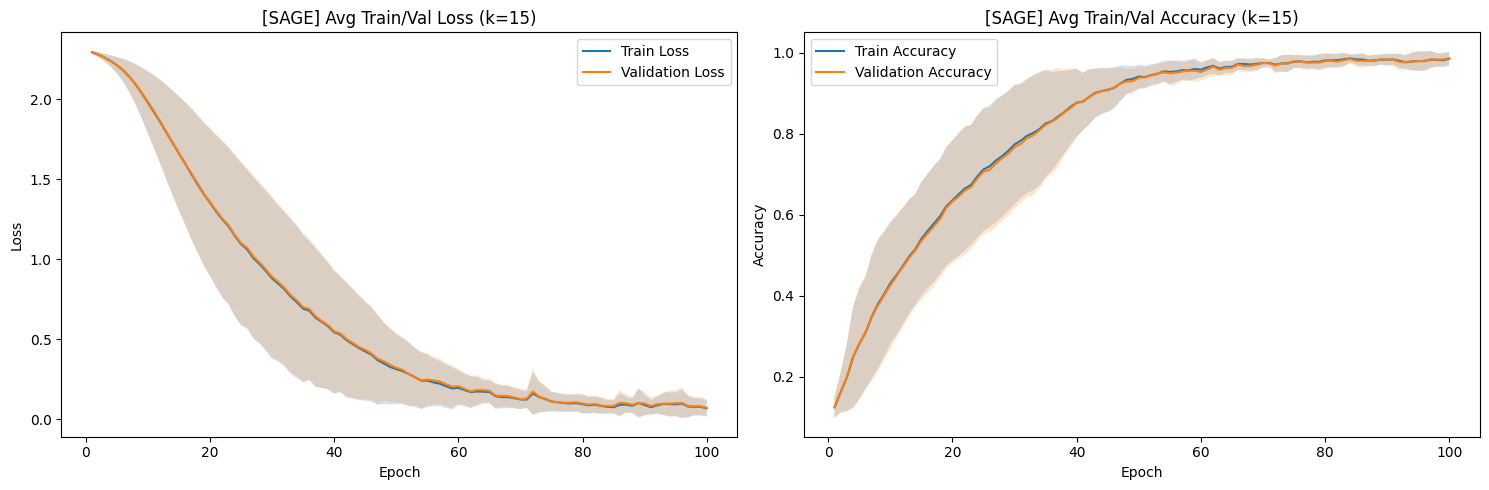


--- Experiment Summary --- 
Experiment: k_5_GCN, Avg. Accuracy: 0.9424 ± 0.0519
Experiment: k_5_GAT, Avg. Accuracy: 0.8985 ± 0.2535
Experiment: k_5_SAGE, Avg. Accuracy: 0.9538 ± 0.0207
Experiment: k_7_GCN, Avg. Accuracy: 0.9715 ± 0.0143
Experiment: k_7_GAT, Avg. Accuracy: 0.9856 ± 0.0119
Experiment: k_7_SAGE, Avg. Accuracy: 0.9721 ± 0.0137
Experiment: k_10_GCN, Avg. Accuracy: 0.9751 ± 0.0141
Experiment: k_10_GAT, Avg. Accuracy: 0.9887 ± 0.0184
Experiment: k_10_SAGE, Avg. Accuracy: 0.9881 ± 0.0107
Experiment: k_15_GCN, Avg. Accuracy: 0.9874 ± 0.0105
Experiment: k_15_GAT, Avg. Accuracy: 0.9934 ± 0.0123
Experiment: k_15_SAGE, Avg. Accuracy: 0.9835 ± 0.0200

Best Experiment: k_15_GAT with Avg. Accuracy: 0.9934


In [21]:
# --- Parameters for Experiments --- #
K_VALUES_TO_TEST = [5, 7,10, 15] # Add or modify k values to test
GNN_MODELS_TO_TEST = {
    'GCN': GCNAudioClassifier,
    'GAT': GATAudioClassifier, # If you have GATClassifier defined
    'SAGE': SAGEAudioClassifier,
} # Add or remove GNN models
OPTUNA_TRIALS_PER_FOLD = 5 # Reduced trials for faster testing, increase for thoroughness
EPOCHS = 100 # Reduced epochs for faster testing, increase for better convergence
OPTUNA_RANGES = {
    'hidden_channels': [16, 64], # Example ranges, adjust based on your needs
    'lr': [1e-4, 1e-2],
    'dropout': [0.2, 0.5],
}

# --- File Paths (Ensure these match your generated files) --- #
ROOT_PROCESSED_DATA = 'processed_data'
METADATA_FILE = 'nepali_music_metadata.csv'
FEATURE_FILE = 'nepali_features_mean.hdf5' # Path to your SINGLE feature file (mean features in this example)

# --- Experiment Loop --- #
experiment_results = {}

for k_value in K_VALUES_TO_TEST: # Loop over k values only
    for model_name, model_class in GNN_MODELS_TO_TEST.items():
        experiment_id = f'k_{k_value}_{model_name}' # Experiment ID simpler now
        print(f"\nStarting Experiment: {experiment_id}")

        # 1. Create Dataset for current config
        current_dataset = AudioGraphDataset(
            root=ROOT_PROCESSED_DATA,
            metadata_csv_path=METADATA_FILE,
            features_hdf5_path=FEATURE_FILE, # Using SINGLE feature file
            k_neigh=k_value,
        )

        # 2. Process Dataset (creates processed files if they don't exist)
        if not current_dataset.processed_file_names or not all([osp.exists(osp.join(current_dataset.processed_dir, f)) for f in current_dataset.processed_file_names]):
            print(f"Processing dataset for {experiment_id}...")
            current_dataset.process()
        else:
            print(f"Using existing processed data for {experiment_id}")

        # 3. Train k-fold and Evaluate
        fold_metrics, curves, best_hparams = train_k_fold(
            dataset=current_dataset,
            model_class=model_class,
            model_name=model_name,
            k_values_to_test = K_VALUES_TO_TEST, # Pass k_values for logging/future use
            hidden_channels_optuna_range=OPTUNA_RANGES['hidden_channels'],
            lr_optuna_range=OPTUNA_RANGES['lr'],
            dropout_optuna_range=OPTUNA_RANGES['dropout'],
            epochs=EPOCHS,
            optuna_trials=OPTUNA_TRIALS_PER_FOLD,
        )

        # 4. Store Results
        experiment_results[experiment_id] = {
            'fold_metrics': fold_metrics,
            'curves': curves,
            'best_hparams_per_fold': best_hparams,
            'config': {
                'k_value': k_value,
                'model_name': model_name,
                'optuna_ranges': OPTUNA_RANGES,
                'optuna_trials': OPTUNA_TRIALS_PER_FOLD,
                'epochs': EPOCHS,
            }
        }

        # 5. Plot Learning Curves
        all_train_losses, all_val_losses, all_train_accs, all_val_accs = curves
        plot_k_fold_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs, model_name, k_value) # Removed agg_type from plot function call

# --- Analyze and Print Best Results (Example) --- #
print("\n--- Experiment Summary --- ")
best_accuracy = 0
best_experiment_id = None

for experiment_id, results in experiment_results.items():
    mean_accuracy = np.mean(results['fold_metrics']['accuracy'])
    std_accuracy = np.std(results['fold_metrics']['accuracy'])
    print(f"Experiment: {experiment_id}, Avg. Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_experiment_id = experiment_id

if best_experiment_id:
    print(f"\nBest Experiment: {best_experiment_id} with Avg. Accuracy: {best_accuracy:.4f}")
else:
    print("No experiments were run or results are empty.")